## Rover Project Test Notebook
This notebook contains the functions from the lesson and provides the scaffolding you need to test out your mapping methods.  The steps you need to complete in this notebook for the project are the following:

* First just run each of the cells in the notebook, examine the code and the results of each.
* Run the simulator in "Training Mode" and record some data. Note: the simulator may crash if you try to record a large (longer than a few minutes) dataset, but you don't need a ton of data, just some example images to work with.   
* Change the data directory path (2 cells below) to be the directory where you saved data
* Test out the functions provided on your data
* Write new functions (or modify existing ones) to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Once you have mapping working, move on to modifying `perception.py` and `decision.py` to allow your rover to navigate and map in autonomous mode!

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

**Run the next cell to get code highlighting in the markdown cells.**

In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [2]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder

## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

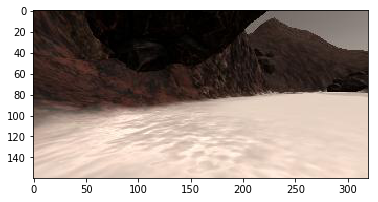

In [3]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

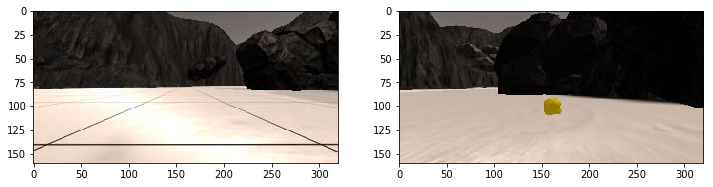

In [4]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

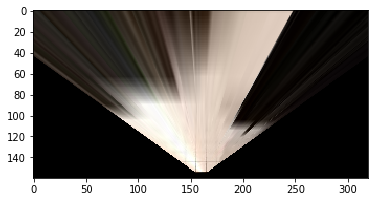

In [5]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(grid_img, source, destination)
plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

**TODO:** Ultimately, you want your map to not just include navigable terrain but also obstacles and the positions of the rock samples you're searching for.  Modify this function or write a new function that returns the pixel locations of obstacles (areas below the threshold) and rock samples (yellow rocks in calibration images), such that you can map these areas into world coordinates as well.  
**Hints and Suggestion:** 
* For obstacles you can just invert your color selection that you used to detect ground pixels, i.e., if you've decided that everything above the threshold is navigable terrain, then everthing below the threshold must be an obstacle!


* For rocks, think about imposing a lower and upper boundary in your color selection to be more specific about choosing colors.  You can investigate the colors of the rocks (the RGB pixel values) in an interactive matplotlib window to get a feel for the appropriate threshold range (keep in mind you may want different ranges for each of R, G and B!).  Feel free to get creative and even bring in functions from other libraries.  Here's an example of [color selection](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) using OpenCV.  

* **Beware However:** if you start manipulating images with OpenCV, keep in mind that it defaults to `BGR` instead of `RGB` color space when reading/writing images, so things can get confusing.

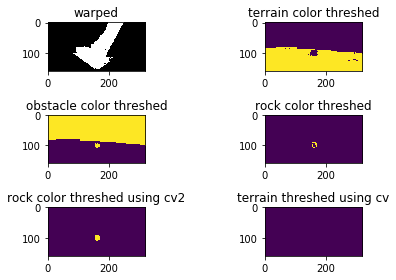

In [27]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh_cv(img, rgb_thresh=np.array([160, 160, 160])):
    # Create an array of zeros same xy size as img, but single channel
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    terrain = cv2.inRange(img_hsv, rgb_thresh, np.array([255,255,255]))
    # Return the binary image
    return terrain

# Identify pixels below the threshold
# Threshold of RGB < 160 does a nice job of identifying obstacles pixels only
def color_below_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be below all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] < rgb_thresh[0]) \
                & (img[:,:,1] < rgb_thresh[1]) \
                & (img[:,:,2] < rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

# Identify pixels below the threshold
# Threshold of RGB < 160 does a nice job of identifying obstacles pixels only
#def color_within_thresh(img, rgb_thresh_min=(192, 192, 51), rgb_thresh_max= (255, 255, 114)):
def color_within_thresh(img, rgb_thresh_min=(110, 110, 5), rgb_thresh_max= (255, 255, 90)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be below all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] < rgb_thresh_max[0]) \
                & (img[:,:,1] < rgb_thresh_max[1]) \
                & (img[:,:,2] < rgb_thresh_max[2]) \
                & (img[:,:,0] > rgb_thresh_min[0]) \
                & (img[:,:,1] > rgb_thresh_min[1]) \
                & (img[:,:,2] > rgb_thresh_min[2]) 
    # Index the array of zeros with the boolean array and set to 1
    #print(np.any(above_thresh))
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

# Identify pixels below the threshold
# Threshold of RGB < 160 does a nice job of identifying obstacles pixels only
#def color_within_thresh(img, rgb_thresh_min=(192, 192, 51), rgb_thresh_max= (255, 255, 114)):
def color_within_thresh_cv(img, rgb_thresh_min=np.array([5, 110, 110]), rgb_thresh_max= np.array([90, 255, 255])):
    # rgb_thresh_min=(110, 110, 5), rgb_thresh_max= (255, 255, 90)
    # convert to hsv
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    rock = cv2.inRange(img_hsv, rgb_thresh_min, rgb_thresh_max)
    return rock



fig = plt.figure(figsize=(24,36))
plt.subplots(nrows=3, ncols=2)
threshed = color_thresh(warped)
axwarped = plt.subplot(321)
axwarped.set_title('warped')
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)
terrain_threshed = color_thresh(rock_img)
axterr = plt.subplot(322)
axterr.set_title('terrain color threshed')
plt.imshow(terrain_threshed)
axobst = plt.subplot(323)
axobst.set_title('obstacle color threshed')
obstacles_threshed = color_below_thresh(rock_img)
plt.imshow(obstacles_threshed)
axrock = plt.subplot(324)
axrock.set_title('rock color threshed')
rocks_threshed = color_within_thresh(rock_img)
plt.imshow(rocks_threshed)
axrockcv = plt.subplot(325)
axrockcv.set_title('rock color threshed using cv2')
#img_rock_cv = cv2.imread(example_rock)
rock_threshed_cv2 = color_within_thresh_cv(rock_img)
plt.imshow(rock_threshed_cv2)

terraincv = color_thresh_cv(rock_img)
axterrcv = plt.subplot(326)
axterrcv.set_title('terrain threshed using cv')
plt.imshow(terraincv)
plt.tight_layout()
plt.show()

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

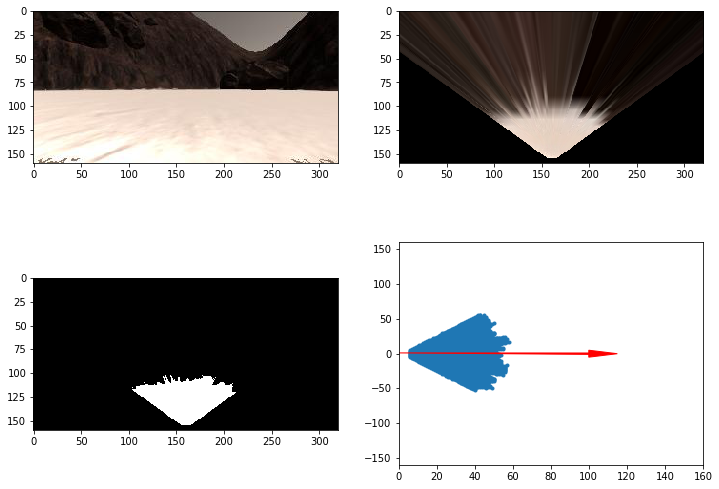

In [7]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = np.absolute(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[0]).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    # TODO:
    # Convert yaw to radians
    # Apply a rotation
    yawrad = yaw * np.pi / 180
    xpix_rotated = xpix * np.cos(yawrad) - ypix * np.sin(yawrad)
    ypix_rotated = xpix * np.sin(yawrad) + ypix * np.cos(yawrad)
    # Return the result  
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # TODO:
    # Apply a scaling and a translation
    xpix_translated = np.int_(xpos + xpix_rot / scale)
    ypix_translated = np.int_(ypos + ypix_rot / scale)
    # Return the result  
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)



## Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell.  


In [8]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('../custom/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = -1 # This will be a running index, setting to -1 is a hack
                        # because moviepy (below) seems to run one extra iteration
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


## Write a function to process stored images

Modify the `process_image()` function below by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the images you saved taking data in the simulator.  

In short, you will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of video.  You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).  



To start with, you can simply run the next three cells to see what happens, but then go ahead and modify them such that the output video demonstrates your mapping process.  Feel free to get creative!

In [20]:

# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # TODO: 
    # 1) Define source and destination points for perspective transform
    
    # 2) Apply perspective transform
    warped = perspect_transform(img, source, destination)
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    terrain_img = color_thresh(img)
    obstacles_img = color_below_thresh(img)
    rocks_img = color_within_thresh(img)
    # 4) Convert thresholded image pixel values to rover-centric coords
    terrain_pixels_rover_x,terrain_pixels_rover_y  = rover_coords(terrain_img)
    obstacles_pixels_rover_x,obstacles_pixels_rover_y  = rover_coords(obstacles_img)
    rock_pixels_rover_x, rock_pixels_rover_y = rover_coords(rocks_img)
    # 5) Convert rover-centric pixel values to world coords
    xpos = data.xpos[data.count]
    ypos = data.ypos[data.count]
    yaw = data.yaw[data.count]
    scale = 10
    world_size = 200
    for xpix, ypix in zip(terrain_pixels_rover_x,terrain_pixels_rover_y):
        
        navigable_x_world, navigable_y_world = pix_to_world(xpix, \
                                                        ypix, \
                                                        xpos, ypos, yaw, \
                                                        world_size, \
                                                        scale) 
        data.worldmap[navigable_y_world, navigable_x_world, 2] += 1    
    
    for xpix, ypix in zip(obstacles_pixels_rover_x, obstacles_pixels_rover_y):
        obstacle_x_world, obstacle_y_world = pix_to_world(xpix, \
                                                      ypix, \
                                                      xpos, ypos, yaw, \
                                                      world_size, \
                                                        scale) 
        data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1                                                    
    
    for xpix, ypix in zip(rock_pixels_rover_x, rock_pixels_rover_y):
        rock_x_world, rock_y_world = pix_to_world(xpix, \
                                                  ypix, \
                                                  xpos, ypos, yaw, \
                                                  world_size, \
                                                  scale) 
        data.worldmap[rock_y_world, rock_x_world, 1] += 1
        
    # 6) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1
    
    
    

    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
    warped = perspect_transform(img, source, destination)
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

## Make a video from processed image data
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
  

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

False
[MoviePy] >>>> Building video ../output/test_mapping.mp4
[MoviePy] Writing video ../output/test_mapping.mp4


  0%|          | 0/10608 [00:00<?, ?it/s]

False


  0%|          | 1/10608 [00:00<1:55:56,  1.52it/s]

False


  0%|          | 2/10608 [00:01<1:56:23,  1.52it/s]

False


  0%|          | 3/10608 [00:02<2:01:07,  1.46it/s]

False


  0%|          | 4/10608 [00:02<1:59:12,  1.48it/s]

False


  0%|          | 5/10608 [00:03<1:57:57,  1.50it/s]

False


  0%|          | 6/10608 [00:04<1:57:38,  1.50it/s]

False


  0%|          | 7/10608 [00:04<1:57:01,  1.51it/s]

False


  0%|          | 8/10608 [00:05<1:56:30,  1.52it/s]

False


  0%|          | 9/10608 [00:05<1:56:26,  1.52it/s]

False


  0%|          | 10/10608 [00:06<1:56:40,  1.51it/s]

False


  0%|          | 11/10608 [00:07<1:56:43,  1.51it/s]

False


  0%|          | 12/10608 [00:07<1:56:11,  1.52it/s]

False


  0%|          | 13/10608 [00:08<1:59:42,  1.48it/s]

False


  0%|          | 14/10608 [00:09<1:58:23,  1.49it/s]

False


  0%|          | 15/10608 [00:09<1:57:05,  1.51it/s]

False


  0%|          | 16/10608 [00:10<1:56:25,  1.52it/s]

False


  0%|          | 17/10608 [00:11<1:58:12,  1.49it/s]

False


  0%|          | 18/10608 [00:12<1:59:48,  1.47it/s]

False


  0%|          | 19/10608 [00:12<1:58:19,  1.49it/s]

False


  0%|          | 20/10608 [00:13<1:57:43,  1.50it/s]

False


  0%|          | 21/10608 [00:13<1:56:34,  1.51it/s]

False


  0%|          | 22/10608 [00:14<1:59:11,  1.48it/s]

False


  0%|          | 23/10608 [00:15<2:03:44,  1.43it/s]

False


  0%|          | 24/10608 [00:16<2:00:50,  1.46it/s]

False


  0%|          | 25/10608 [00:17<2:20:41,  1.25it/s]

False


  0%|          | 26/10608 [00:17<2:13:56,  1.32it/s]

False


  0%|          | 27/10608 [00:18<2:08:25,  1.37it/s]

False


  0%|          | 28/10608 [00:19<2:08:26,  1.37it/s]

False


  0%|          | 29/10608 [00:19<2:03:56,  1.42it/s]

False


  0%|          | 30/10608 [00:20<2:01:40,  1.45it/s]

False


  0%|          | 31/10608 [00:21<2:00:05,  1.47it/s]

False


  0%|          | 32/10608 [00:21<1:59:24,  1.48it/s]

False


  0%|          | 33/10608 [00:22<1:57:32,  1.50it/s]

False


  0%|          | 34/10608 [00:23<1:56:15,  1.52it/s]

False


  0%|          | 35/10608 [00:23<1:55:14,  1.53it/s]

False


  0%|          | 36/10608 [00:24<1:59:54,  1.47it/s]

False


  0%|          | 37/10608 [00:25<2:01:17,  1.45it/s]

False


  0%|          | 38/10608 [00:26<2:05:53,  1.40it/s]

False


  0%|          | 39/10608 [00:26<2:05:03,  1.41it/s]

False


  0%|          | 40/10608 [00:27<2:02:05,  1.44it/s]

False


  0%|          | 41/10608 [00:28<2:02:33,  1.44it/s]

False


  0%|          | 42/10608 [00:28<2:01:33,  1.45it/s]

False


  0%|          | 43/10608 [00:29<2:04:29,  1.41it/s]

False


  0%|          | 44/10608 [00:30<2:03:18,  1.43it/s]

False


  0%|          | 45/10608 [00:30<2:00:01,  1.47it/s]

False


  0%|          | 46/10608 [00:31<1:58:17,  1.49it/s]

False


  0%|          | 47/10608 [00:32<1:57:46,  1.49it/s]

False


  0%|          | 48/10608 [00:32<1:58:00,  1.49it/s]

False


  0%|          | 49/10608 [00:33<1:56:48,  1.51it/s]

False


  0%|          | 50/10608 [00:34<1:56:08,  1.52it/s]

False


  0%|          | 51/10608 [00:34<1:54:49,  1.53it/s]

False


  0%|          | 52/10608 [00:35<2:00:18,  1.46it/s]

False


  0%|          | 53/10608 [00:36<1:58:02,  1.49it/s]

False


  1%|          | 54/10608 [00:36<1:56:37,  1.51it/s]

False


  1%|          | 55/10608 [00:37<1:59:40,  1.47it/s]

False


  1%|          | 56/10608 [00:38<2:01:04,  1.45it/s]

False


  1%|          | 57/10608 [00:38<1:58:38,  1.48it/s]

False


  1%|          | 58/10608 [00:39<1:57:28,  1.50it/s]

False


  1%|          | 59/10608 [00:40<1:56:10,  1.51it/s]

False


  1%|          | 60/10608 [00:40<1:58:41,  1.48it/s]

False


  1%|          | 61/10608 [00:41<2:00:15,  1.46it/s]

False


  1%|          | 62/10608 [00:42<1:58:27,  1.48it/s]

False


  1%|          | 63/10608 [00:42<1:56:52,  1.50it/s]

False


  1%|          | 64/10608 [00:43<1:56:06,  1.51it/s]

False


  1%|          | 65/10608 [00:44<1:55:21,  1.52it/s]

False


  1%|          | 66/10608 [00:44<1:54:50,  1.53it/s]

False


  1%|          | 67/10608 [00:45<2:02:51,  1.43it/s]

False


  1%|          | 68/10608 [00:46<2:07:45,  1.38it/s]

False


  1%|          | 69/10608 [00:47<2:06:14,  1.39it/s]

False


  1%|          | 70/10608 [00:47<2:02:36,  1.43it/s]

False


  1%|          | 71/10608 [00:48<1:59:43,  1.47it/s]

False


  1%|          | 72/10608 [00:49<1:58:41,  1.48it/s]

False


  1%|          | 73/10608 [00:49<1:57:49,  1.49it/s]

False


  1%|          | 74/10608 [00:50<2:01:15,  1.45it/s]

False


  1%|          | 75/10608 [00:51<1:59:59,  1.46it/s]

False


  1%|          | 76/10608 [00:51<1:58:41,  1.48it/s]

False


  1%|          | 77/10608 [00:52<1:56:45,  1.50it/s]

False


  1%|          | 78/10608 [00:53<1:55:55,  1.51it/s]

False


  1%|          | 79/10608 [00:53<1:55:18,  1.52it/s]

False


  1%|          | 80/10608 [00:54<1:54:49,  1.53it/s]

False


  1%|          | 81/10608 [00:55<1:54:18,  1.53it/s]

False


  1%|          | 82/10608 [00:55<1:54:25,  1.53it/s]

False


  1%|          | 83/10608 [00:56<1:54:14,  1.54it/s]

False


  1%|          | 84/10608 [00:56<1:54:19,  1.53it/s]

False


  1%|          | 85/10608 [00:57<1:53:50,  1.54it/s]

False


  1%|          | 86/10608 [00:58<1:53:55,  1.54it/s]

False


  1%|          | 87/10608 [00:58<1:55:18,  1.52it/s]

False


  1%|          | 88/10608 [00:59<1:54:52,  1.53it/s]

False


  1%|          | 89/10608 [01:00<1:58:41,  1.48it/s]

False


  1%|          | 90/10608 [01:01<2:00:51,  1.45it/s]

False


  1%|          | 91/10608 [01:01<1:58:26,  1.48it/s]

False


  1%|          | 92/10608 [01:02<1:56:41,  1.50it/s]

False


  1%|          | 93/10608 [01:03<2:02:22,  1.43it/s]

False


  1%|          | 94/10608 [01:03<2:00:02,  1.46it/s]

False


  1%|          | 95/10608 [01:04<1:58:06,  1.48it/s]

False


  1%|          | 96/10608 [01:05<1:57:03,  1.50it/s]

False


  1%|          | 97/10608 [01:05<1:56:35,  1.50it/s]

False


  1%|          | 98/10608 [01:06<1:55:51,  1.51it/s]

False


  1%|          | 99/10608 [01:07<1:55:23,  1.52it/s]

False


  1%|          | 100/10608 [01:07<1:54:48,  1.53it/s]

False


  1%|          | 101/10608 [01:08<1:54:32,  1.53it/s]

False


  1%|          | 102/10608 [01:08<1:54:53,  1.52it/s]

False


  1%|          | 104/10608 [01:10<1:54:25,  1.53it/s]

False
False


  1%|          | 105/10608 [01:10<1:54:16,  1.53it/s]

False


  1%|          | 106/10608 [01:11<1:53:45,  1.54it/s]

False


  1%|          | 107/10608 [01:12<1:53:39,  1.54it/s]

False


  1%|          | 108/10608 [01:12<1:53:38,  1.54it/s]

False


  1%|          | 109/10608 [01:13<1:54:31,  1.53it/s]

False


  1%|          | 110/10608 [01:14<1:57:30,  1.49it/s]

False


  1%|          | 111/10608 [01:14<1:55:55,  1.51it/s]

False


  1%|          | 112/10608 [01:15<1:55:03,  1.52it/s]

False


  1%|          | 113/10608 [01:16<1:54:37,  1.53it/s]

False


  1%|          | 114/10608 [01:16<1:53:59,  1.53it/s]

False


  1%|          | 115/10608 [01:17<1:53:09,  1.55it/s]

False


  1%|          | 116/10608 [01:18<1:53:19,  1.54it/s]

False


  1%|          | 117/10608 [01:18<1:52:30,  1.55it/s]

False


  1%|          | 118/10608 [01:19<1:52:50,  1.55it/s]

False


  1%|          | 119/10608 [01:20<1:53:02,  1.55it/s]

False


  1%|          | 120/10608 [01:20<1:53:05,  1.55it/s]

False


  1%|          | 121/10608 [01:21<1:53:00,  1.55it/s]

False


  1%|          | 122/10608 [01:21<1:52:56,  1.55it/s]

False


  1%|          | 123/10608 [01:22<1:52:54,  1.55it/s]

False


  1%|          | 124/10608 [01:23<1:53:00,  1.55it/s]

False


  1%|          | 125/10608 [01:23<1:52:47,  1.55it/s]

False


  1%|          | 126/10608 [01:24<1:52:47,  1.55it/s]

False


  1%|          | 127/10608 [01:25<1:53:43,  1.54it/s]

False


  1%|          | 128/10608 [01:25<1:53:47,  1.53it/s]

False


  1%|          | 129/10608 [01:26<1:53:19,  1.54it/s]

False


  1%|          | 130/10608 [01:27<1:53:55,  1.53it/s]

False


  1%|          | 131/10608 [01:27<1:54:28,  1.53it/s]

False


  1%|          | 132/10608 [01:28<1:54:00,  1.53it/s]

False


  1%|▏         | 133/10608 [01:29<1:53:34,  1.54it/s]

False


  1%|▏         | 134/10608 [01:29<1:53:35,  1.54it/s]

False


  1%|▏         | 135/10608 [01:30<1:54:41,  1.52it/s]

False


  1%|▏         | 136/10608 [01:31<1:57:56,  1.48it/s]

False


  1%|▏         | 137/10608 [01:31<1:57:08,  1.49it/s]

False


  1%|▏         | 138/10608 [01:32<1:56:12,  1.50it/s]

False


  1%|▏         | 139/10608 [01:33<1:55:38,  1.51it/s]

False


  1%|▏         | 140/10608 [01:33<1:54:49,  1.52it/s]

False


  1%|▏         | 141/10608 [01:34<1:54:46,  1.52it/s]

False


  1%|▏         | 142/10608 [01:35<1:54:52,  1.52it/s]

False


  1%|▏         | 143/10608 [01:35<1:54:47,  1.52it/s]

False


  1%|▏         | 144/10608 [01:36<1:54:10,  1.53it/s]

False


  1%|▏         | 145/10608 [01:37<1:54:09,  1.53it/s]

False


  1%|▏         | 146/10608 [01:37<1:54:14,  1.53it/s]

False


  1%|▏         | 147/10608 [01:38<1:58:18,  1.47it/s]

False


  1%|▏         | 148/10608 [01:39<2:00:13,  1.45it/s]

False


  1%|▏         | 149/10608 [01:39<1:58:16,  1.47it/s]

False


  1%|▏         | 150/10608 [01:40<1:56:26,  1.50it/s]

False


  1%|▏         | 151/10608 [01:41<1:55:44,  1.51it/s]

False


  1%|▏         | 152/10608 [01:41<1:54:49,  1.52it/s]

False


  1%|▏         | 153/10608 [01:42<1:58:13,  1.47it/s]

False


  1%|▏         | 154/10608 [01:43<1:56:50,  1.49it/s]

False


  1%|▏         | 155/10608 [01:43<2:00:30,  1.45it/s]

False


  1%|▏         | 156/10608 [01:44<1:58:42,  1.47it/s]

True


  1%|▏         | 157/10608 [01:45<1:57:17,  1.48it/s]

False


  1%|▏         | 158/10608 [01:45<1:55:40,  1.51it/s]

False


  1%|▏         | 159/10608 [01:46<1:54:58,  1.51it/s]

False


  2%|▏         | 160/10608 [01:47<1:54:45,  1.52it/s]

False


  2%|▏         | 161/10608 [01:47<1:55:48,  1.50it/s]

False


  2%|▏         | 162/10608 [01:48<1:55:25,  1.51it/s]

False


  2%|▏         | 163/10608 [01:49<1:55:27,  1.51it/s]

False


  2%|▏         | 164/10608 [01:49<1:55:20,  1.51it/s]

False


  2%|▏         | 165/10608 [01:50<1:59:15,  1.46it/s]

False


  2%|▏         | 166/10608 [01:51<2:01:39,  1.43it/s]

False


  2%|▏         | 167/10608 [01:51<2:00:59,  1.44it/s]

False


  2%|▏         | 168/10608 [01:52<1:59:19,  1.46it/s]

False


  2%|▏         | 169/10608 [01:53<1:57:17,  1.48it/s]

False


  2%|▏         | 170/10608 [01:53<1:55:15,  1.51it/s]

False


  2%|▏         | 171/10608 [01:54<1:54:52,  1.51it/s]

False


  2%|▏         | 172/10608 [01:55<1:55:01,  1.51it/s]

False


  2%|▏         | 173/10608 [01:55<1:54:19,  1.52it/s]

False


  2%|▏         | 174/10608 [01:56<1:53:43,  1.53it/s]

False


  2%|▏         | 175/10608 [01:57<1:57:02,  1.49it/s]

False


  2%|▏         | 176/10608 [01:57<1:56:43,  1.49it/s]

False


  2%|▏         | 177/10608 [01:58<1:59:18,  1.46it/s]

False


  2%|▏         | 178/10608 [01:59<1:56:55,  1.49it/s]

False


  2%|▏         | 179/10608 [01:59<1:55:43,  1.50it/s]

False


  2%|▏         | 180/10608 [02:00<1:55:19,  1.51it/s]

False


  2%|▏         | 181/10608 [02:01<1:58:41,  1.46it/s]

False


  2%|▏         | 182/10608 [02:01<1:57:17,  1.48it/s]

False


  2%|▏         | 183/10608 [02:02<1:56:03,  1.50it/s]

False


  2%|▏         | 184/10608 [02:03<1:54:46,  1.51it/s]

False


  2%|▏         | 185/10608 [02:03<1:58:05,  1.47it/s]

False


  2%|▏         | 186/10608 [02:04<1:56:09,  1.50it/s]

False


  2%|▏         | 187/10608 [02:05<1:54:56,  1.51it/s]

False


  2%|▏         | 188/10608 [02:05<1:53:48,  1.53it/s]

False


  2%|▏         | 189/10608 [02:06<1:56:29,  1.49it/s]

False


  2%|▏         | 190/10608 [02:07<1:59:28,  1.45it/s]

False


  2%|▏         | 191/10608 [02:08<2:01:52,  1.42it/s]

False


  2%|▏         | 192/10608 [02:08<2:03:47,  1.40it/s]

False


  2%|▏         | 193/10608 [02:09<2:05:41,  1.38it/s]

True


  2%|▏         | 194/10608 [02:10<2:05:26,  1.38it/s]

True


  2%|▏         | 195/10608 [02:10<2:01:35,  1.43it/s]

True


  2%|▏         | 196/10608 [02:11<2:02:42,  1.41it/s]

True


  2%|▏         | 197/10608 [02:12<1:59:38,  1.45it/s]

True


  2%|▏         | 198/10608 [02:12<1:57:34,  1.48it/s]

True


  2%|▏         | 199/10608 [02:13<1:55:29,  1.50it/s]

True


  2%|▏         | 200/10608 [02:14<1:54:27,  1.52it/s]

True


  2%|▏         | 201/10608 [02:14<1:54:42,  1.51it/s]

True


  2%|▏         | 202/10608 [02:15<1:56:29,  1.49it/s]

True


  2%|▏         | 203/10608 [02:16<1:56:28,  1.49it/s]

True


  2%|▏         | 204/10608 [02:16<1:55:43,  1.50it/s]

True


  2%|▏         | 205/10608 [02:17<1:55:00,  1.51it/s]

True


  2%|▏         | 206/10608 [02:18<1:53:58,  1.52it/s]

True


  2%|▏         | 207/10608 [02:18<1:53:49,  1.52it/s]

True


  2%|▏         | 208/10608 [02:19<1:53:14,  1.53it/s]

True


  2%|▏         | 209/10608 [02:20<1:53:15,  1.53it/s]

True


  2%|▏         | 210/10608 [02:20<1:52:31,  1.54it/s]

True


  2%|▏         | 211/10608 [02:21<1:52:42,  1.54it/s]

True


  2%|▏         | 212/10608 [02:22<1:52:30,  1.54it/s]

True


  2%|▏         | 213/10608 [02:22<1:52:12,  1.54it/s]

True


  2%|▏         | 214/10608 [02:23<1:52:15,  1.54it/s]

True


  2%|▏         | 215/10608 [02:24<1:52:55,  1.53it/s]

True


  2%|▏         | 216/10608 [02:24<1:55:14,  1.50it/s]

True


  2%|▏         | 217/10608 [02:25<1:54:23,  1.51it/s]

True


  2%|▏         | 218/10608 [02:26<1:53:32,  1.53it/s]

True


  2%|▏         | 219/10608 [02:26<1:52:48,  1.53it/s]

True


  2%|▏         | 220/10608 [02:27<1:52:46,  1.54it/s]

True


  2%|▏         | 221/10608 [02:28<1:52:57,  1.53it/s]

True


  2%|▏         | 222/10608 [02:28<1:53:45,  1.52it/s]

True


  2%|▏         | 223/10608 [02:29<1:52:56,  1.53it/s]

True


  2%|▏         | 224/10608 [02:29<1:52:23,  1.54it/s]

True


  2%|▏         | 225/10608 [02:30<1:52:27,  1.54it/s]

True


  2%|▏         | 226/10608 [02:31<1:51:51,  1.55it/s]

True


  2%|▏         | 227/10608 [02:31<1:51:52,  1.55it/s]

True


  2%|▏         | 228/10608 [02:32<1:51:34,  1.55it/s]

True


  2%|▏         | 229/10608 [02:33<1:51:39,  1.55it/s]

True


  2%|▏         | 230/10608 [02:33<1:54:41,  1.51it/s]

True


  2%|▏         | 231/10608 [02:34<1:59:10,  1.45it/s]

True


  2%|▏         | 232/10608 [02:35<1:56:34,  1.48it/s]

True


  2%|▏         | 233/10608 [02:36<2:00:27,  1.44it/s]

True


  2%|▏         | 234/10608 [02:36<1:58:03,  1.46it/s]

True


  2%|▏         | 235/10608 [02:37<1:56:18,  1.49it/s]

True


  2%|▏         | 236/10608 [02:38<1:56:19,  1.49it/s]

True


  2%|▏         | 237/10608 [02:38<1:55:31,  1.50it/s]

True


  2%|▏         | 238/10608 [02:39<1:54:25,  1.51it/s]

True


  2%|▏         | 239/10608 [02:39<1:54:18,  1.51it/s]

True


  2%|▏         | 240/10608 [02:40<1:56:48,  1.48it/s]

True


  2%|▏         | 241/10608 [02:41<1:55:15,  1.50it/s]

True


  2%|▏         | 242/10608 [02:41<1:54:50,  1.50it/s]

True


  2%|▏         | 243/10608 [02:42<1:54:21,  1.51it/s]

True


  2%|▏         | 244/10608 [02:43<1:53:31,  1.52it/s]

True


  2%|▏         | 245/10608 [02:43<1:53:02,  1.53it/s]

True


  2%|▏         | 246/10608 [02:44<1:57:54,  1.46it/s]

True


  2%|▏         | 247/10608 [02:45<1:55:49,  1.49it/s]

True


  2%|▏         | 248/10608 [02:45<1:54:23,  1.51it/s]

True


  2%|▏         | 249/10608 [02:46<1:53:16,  1.52it/s]

True


  2%|▏         | 250/10608 [02:47<1:53:00,  1.53it/s]

True


  2%|▏         | 251/10608 [02:47<1:52:33,  1.53it/s]

True


  2%|▏         | 252/10608 [02:48<1:52:32,  1.53it/s]

True


  2%|▏         | 253/10608 [02:49<1:52:21,  1.54it/s]

True


  2%|▏         | 254/10608 [02:49<1:53:20,  1.52it/s]

True


  2%|▏         | 255/10608 [02:50<2:06:00,  1.37it/s]

True


  2%|▏         | 256/10608 [02:51<2:01:10,  1.42it/s]

True


  2%|▏         | 257/10608 [02:52<1:57:45,  1.47it/s]

True


  2%|▏         | 258/10608 [02:52<1:59:12,  1.45it/s]

True


  2%|▏         | 259/10608 [02:53<2:01:36,  1.42it/s]

True


  2%|▏         | 260/10608 [02:54<1:59:00,  1.45it/s]

True


  2%|▏         | 261/10608 [02:54<1:56:44,  1.48it/s]

True


  2%|▏         | 262/10608 [02:55<1:55:10,  1.50it/s]

True


  2%|▏         | 263/10608 [02:56<1:54:55,  1.50it/s]

True


  2%|▏         | 264/10608 [02:56<1:54:40,  1.50it/s]

True


  2%|▏         | 265/10608 [02:57<1:53:48,  1.51it/s]

True


  3%|▎         | 266/10608 [02:58<1:53:12,  1.52it/s]

True


  3%|▎         | 267/10608 [02:58<1:52:32,  1.53it/s]

True


  3%|▎         | 268/10608 [02:59<1:52:29,  1.53it/s]

True


  3%|▎         | 269/10608 [03:00<1:52:36,  1.53it/s]

True


  3%|▎         | 270/10608 [03:00<1:52:03,  1.54it/s]

True


  3%|▎         | 271/10608 [03:01<1:51:45,  1.54it/s]

True


  3%|▎         | 272/10608 [03:02<1:57:16,  1.47it/s]

True


  3%|▎         | 273/10608 [03:02<1:56:13,  1.48it/s]

True


  3%|▎         | 274/10608 [03:03<1:57:44,  1.46it/s]

True


  3%|▎         | 275/10608 [03:04<1:55:56,  1.49it/s]

True


  3%|▎         | 276/10608 [03:04<1:59:00,  1.45it/s]

True


  3%|▎         | 277/10608 [03:05<2:00:37,  1.43it/s]

True


  3%|▎         | 278/10608 [03:06<1:58:03,  1.46it/s]

True


  3%|▎         | 279/10608 [03:06<1:58:50,  1.45it/s]

True


  3%|▎         | 280/10608 [03:07<1:58:47,  1.45it/s]

True


  3%|▎         | 281/10608 [03:08<1:57:23,  1.47it/s]

True


  3%|▎         | 282/10608 [03:08<1:55:47,  1.49it/s]

True


  3%|▎         | 283/10608 [03:09<1:54:40,  1.50it/s]

True


  3%|▎         | 284/10608 [03:10<1:54:00,  1.51it/s]

True


  3%|▎         | 285/10608 [03:10<1:53:36,  1.51it/s]

True


  3%|▎         | 286/10608 [03:11<1:54:25,  1.50it/s]

True


  3%|▎         | 287/10608 [03:12<1:53:08,  1.52it/s]

True


  3%|▎         | 288/10608 [03:12<1:55:23,  1.49it/s]

True


  3%|▎         | 289/10608 [03:13<1:57:10,  1.47it/s]

True


  3%|▎         | 290/10608 [03:14<2:03:22,  1.39it/s]

True


  3%|▎         | 291/10608 [03:15<2:00:27,  1.43it/s]

True


  3%|▎         | 292/10608 [03:15<1:58:19,  1.45it/s]

True


  3%|▎         | 293/10608 [03:16<1:58:13,  1.45it/s]

True


  3%|▎         | 294/10608 [03:17<2:04:48,  1.38it/s]

True


  3%|▎         | 295/10608 [03:17<2:01:13,  1.42it/s]

True


  3%|▎         | 296/10608 [03:18<2:06:02,  1.36it/s]

True


  3%|▎         | 297/10608 [03:19<2:02:40,  1.40it/s]

True


  3%|▎         | 298/10608 [03:19<1:59:29,  1.44it/s]

True


  3%|▎         | 299/10608 [03:20<1:56:32,  1.47it/s]

True


  3%|▎         | 300/10608 [03:21<1:57:06,  1.47it/s]

False


  3%|▎         | 301/10608 [03:21<1:55:07,  1.49it/s]

False


  3%|▎         | 303/10608 [03:23<1:53:23,  1.51it/s]

False
False


  3%|▎         | 304/10608 [03:23<1:53:09,  1.52it/s]

False


  3%|▎         | 305/10608 [03:24<1:53:56,  1.51it/s]

False


  3%|▎         | 306/10608 [03:25<1:53:14,  1.52it/s]

False


  3%|▎         | 307/10608 [03:25<1:53:13,  1.52it/s]

False


  3%|▎         | 308/10608 [03:26<1:52:24,  1.53it/s]

False


  3%|▎         | 309/10608 [03:27<1:52:05,  1.53it/s]

False


  3%|▎         | 310/10608 [03:28<2:02:53,  1.40it/s]

False


  3%|▎         | 311/10608 [03:29<2:27:10,  1.17it/s]

False


  3%|▎         | 312/10608 [03:29<2:16:39,  1.26it/s]

False


  3%|▎         | 313/10608 [03:30<2:09:27,  1.33it/s]

False


  3%|▎         | 314/10608 [03:31<2:08:39,  1.33it/s]

False


  3%|▎         | 315/10608 [03:31<2:04:46,  1.37it/s]

False


  3%|▎         | 316/10608 [03:32<2:01:21,  1.41it/s]

False


  3%|▎         | 317/10608 [03:33<1:58:17,  1.45it/s]

False


  3%|▎         | 318/10608 [03:33<1:57:29,  1.46it/s]

False


  3%|▎         | 319/10608 [03:34<1:55:49,  1.48it/s]

False


  3%|▎         | 320/10608 [03:35<1:54:33,  1.50it/s]

False


  3%|▎         | 321/10608 [03:35<1:53:56,  1.50it/s]

False


  3%|▎         | 322/10608 [03:36<1:54:04,  1.50it/s]

False


  3%|▎         | 323/10608 [03:37<1:53:22,  1.51it/s]

False


  3%|▎         | 324/10608 [03:37<1:57:25,  1.46it/s]

False


  3%|▎         | 325/10608 [03:38<1:59:08,  1.44it/s]

False


  3%|▎         | 326/10608 [03:39<1:58:32,  1.45it/s]

False


  3%|▎         | 327/10608 [03:40<1:56:57,  1.47it/s]

False


  3%|▎         | 328/10608 [03:40<1:55:04,  1.49it/s]

False


  3%|▎         | 329/10608 [03:41<1:53:57,  1.50it/s]

False


  3%|▎         | 330/10608 [03:41<1:53:03,  1.52it/s]

False


  3%|▎         | 331/10608 [03:42<1:52:24,  1.52it/s]

False


  3%|▎         | 332/10608 [03:43<1:51:32,  1.54it/s]

False


  3%|▎         | 333/10608 [03:43<1:51:50,  1.53it/s]

False


  3%|▎         | 334/10608 [03:44<1:58:33,  1.44it/s]

False


  3%|▎         | 335/10608 [03:45<1:58:38,  1.44it/s]

False


  3%|▎         | 336/10608 [03:46<1:56:56,  1.46it/s]

False


  3%|▎         | 337/10608 [03:46<1:55:30,  1.48it/s]

False


  3%|▎         | 338/10608 [03:47<1:54:18,  1.50it/s]

False


  3%|▎         | 339/10608 [03:48<1:53:54,  1.50it/s]

False


  3%|▎         | 340/10608 [03:48<1:53:30,  1.51it/s]

False


  3%|▎         | 341/10608 [03:49<1:52:23,  1.52it/s]

False


  3%|▎         | 342/10608 [03:49<1:51:39,  1.53it/s]

False


  3%|▎         | 343/10608 [03:50<1:51:22,  1.54it/s]

False


  3%|▎         | 344/10608 [03:51<1:50:47,  1.54it/s]

False


  3%|▎         | 345/10608 [03:51<1:51:01,  1.54it/s]

False


  3%|▎         | 346/10608 [03:52<1:51:57,  1.53it/s]

False


  3%|▎         | 347/10608 [03:53<1:55:31,  1.48it/s]

False


  3%|▎         | 348/10608 [03:54<1:57:15,  1.46it/s]

False


  3%|▎         | 349/10608 [03:54<1:55:14,  1.48it/s]

False


  3%|▎         | 350/10608 [03:55<1:53:17,  1.51it/s]

False


  3%|▎         | 351/10608 [03:55<1:53:19,  1.51it/s]

False


  3%|▎         | 353/10608 [03:57<1:52:21,  1.52it/s]

False
False


  3%|▎         | 354/10608 [03:57<1:51:48,  1.53it/s]

False


  3%|▎         | 355/10608 [03:58<1:52:12,  1.52it/s]

False


  3%|▎         | 356/10608 [03:59<1:51:53,  1.53it/s]

False


  3%|▎         | 357/10608 [03:59<1:51:56,  1.53it/s]

False


  3%|▎         | 358/10608 [04:00<1:51:42,  1.53it/s]

False


  3%|▎         | 359/10608 [04:01<1:55:10,  1.48it/s]

False


  3%|▎         | 360/10608 [04:01<1:58:01,  1.45it/s]

False


  3%|▎         | 361/10608 [04:02<1:55:55,  1.47it/s]

False


  3%|▎         | 362/10608 [04:03<1:54:17,  1.49it/s]

False


  3%|▎         | 363/10608 [04:03<1:53:49,  1.50it/s]

False


  3%|▎         | 364/10608 [04:04<1:53:47,  1.50it/s]

False


  3%|▎         | 365/10608 [04:05<1:52:40,  1.52it/s]

False


  3%|▎         | 366/10608 [04:05<1:51:53,  1.53it/s]

False


  3%|▎         | 367/10608 [04:06<1:55:58,  1.47it/s]

False


  3%|▎         | 368/10608 [04:07<1:57:17,  1.45it/s]

False


  3%|▎         | 369/10608 [04:08<1:58:37,  1.44it/s]

False


  3%|▎         | 371/10608 [04:09<1:56:12,  1.47it/s]

False
False


  4%|▎         | 372/10608 [04:10<1:54:12,  1.49it/s]

False


  4%|▎         | 373/10608 [04:10<1:53:01,  1.51it/s]

False


  4%|▎         | 374/10608 [04:11<1:55:53,  1.47it/s]

False


  4%|▎         | 375/10608 [04:12<1:54:11,  1.49it/s]

False


  4%|▎         | 376/10608 [04:12<1:53:02,  1.51it/s]

False


  4%|▎         | 377/10608 [04:13<1:52:47,  1.51it/s]

False


  4%|▎         | 378/10608 [04:14<1:52:08,  1.52it/s]

False


  4%|▎         | 379/10608 [04:14<1:51:18,  1.53it/s]

False


  4%|▎         | 380/10608 [04:15<1:50:50,  1.54it/s]

False


  4%|▎         | 381/10608 [04:15<1:50:20,  1.54it/s]

False


  4%|▎         | 382/10608 [04:16<1:50:44,  1.54it/s]

False


  4%|▎         | 383/10608 [04:17<1:50:17,  1.55it/s]

False


  4%|▎         | 384/10608 [04:17<1:49:52,  1.55it/s]

False


  4%|▎         | 385/10608 [04:18<1:52:57,  1.51it/s]

False


  4%|▎         | 386/10608 [04:19<1:52:52,  1.51it/s]

False


  4%|▎         | 387/10608 [04:19<1:52:03,  1.52it/s]

False


  4%|▎         | 388/10608 [04:20<1:51:56,  1.52it/s]

False


  4%|▎         | 389/10608 [04:21<1:52:23,  1.52it/s]

False


  4%|▎         | 390/10608 [04:21<1:52:29,  1.51it/s]

False


  4%|▎         | 391/10608 [04:22<1:51:47,  1.52it/s]

False


  4%|▎         | 393/10608 [04:23<1:51:37,  1.53it/s]

False
False


  4%|▎         | 394/10608 [04:24<1:51:29,  1.53it/s]

False


  4%|▎         | 395/10608 [04:25<1:51:35,  1.53it/s]

False


  4%|▎         | 396/10608 [04:25<1:51:03,  1.53it/s]

False


  4%|▎         | 397/10608 [04:26<1:51:22,  1.53it/s]

False


  4%|▍         | 398/10608 [04:27<1:51:07,  1.53it/s]

False


  4%|▍         | 399/10608 [04:27<1:51:48,  1.52it/s]

False


  4%|▍         | 400/10608 [04:28<1:51:32,  1.53it/s]

False


  4%|▍         | 401/10608 [04:29<1:51:43,  1.52it/s]

False


  4%|▍         | 402/10608 [04:29<1:51:30,  1.53it/s]

False


  4%|▍         | 403/10608 [04:30<1:51:12,  1.53it/s]

False


  4%|▍         | 404/10608 [04:31<1:50:41,  1.54it/s]

False


  4%|▍         | 405/10608 [04:31<1:51:12,  1.53it/s]

False


  4%|▍         | 406/10608 [04:32<1:51:17,  1.53it/s]

False


  4%|▍         | 407/10608 [04:32<1:50:58,  1.53it/s]

False


  4%|▍         | 408/10608 [04:33<1:50:49,  1.53it/s]

False


  4%|▍         | 409/10608 [04:34<1:50:31,  1.54it/s]

False


  4%|▍         | 410/10608 [04:34<1:50:23,  1.54it/s]

False


  4%|▍         | 411/10608 [04:35<1:50:38,  1.54it/s]

False


  4%|▍         | 412/10608 [04:36<1:50:24,  1.54it/s]

False


  4%|▍         | 413/10608 [04:36<1:50:08,  1.54it/s]

False


  4%|▍         | 414/10608 [04:37<1:50:14,  1.54it/s]

False


  4%|▍         | 415/10608 [04:38<1:50:50,  1.53it/s]

False


  4%|▍         | 416/10608 [04:38<1:50:43,  1.53it/s]

False


  4%|▍         | 417/10608 [04:39<1:50:32,  1.54it/s]

False


  4%|▍         | 418/10608 [04:40<1:50:18,  1.54it/s]

False


  4%|▍         | 419/10608 [04:40<1:50:31,  1.54it/s]

False


  4%|▍         | 420/10608 [04:41<1:50:24,  1.54it/s]

False


  4%|▍         | 421/10608 [04:42<1:55:09,  1.47it/s]

False


  4%|▍         | 422/10608 [04:42<1:53:36,  1.49it/s]

False


  4%|▍         | 423/10608 [04:43<1:53:46,  1.49it/s]

False


  4%|▍         | 424/10608 [04:44<1:55:58,  1.46it/s]

False


  4%|▍         | 425/10608 [04:44<1:56:56,  1.45it/s]

False


  4%|▍         | 426/10608 [04:45<1:55:49,  1.47it/s]

False


  4%|▍         | 427/10608 [04:46<1:57:56,  1.44it/s]

False


  4%|▍         | 428/10608 [04:46<1:55:09,  1.47it/s]

False


  4%|▍         | 430/10608 [04:48<1:52:20,  1.51it/s]

False
False


  4%|▍         | 431/10608 [04:48<1:53:14,  1.50it/s]

False


  4%|▍         | 432/10608 [04:49<1:51:51,  1.52it/s]

False


  4%|▍         | 433/10608 [04:50<1:51:15,  1.52it/s]

False


  4%|▍         | 434/10608 [04:50<1:51:15,  1.52it/s]

False


  4%|▍         | 435/10608 [04:51<1:51:01,  1.53it/s]

False


  4%|▍         | 436/10608 [04:52<1:51:05,  1.53it/s]

False


  4%|▍         | 437/10608 [04:52<1:51:26,  1.52it/s]

False


  4%|▍         | 438/10608 [04:53<1:51:08,  1.53it/s]

False


  4%|▍         | 439/10608 [04:54<1:52:35,  1.51it/s]

False


  4%|▍         | 440/10608 [04:54<1:56:15,  1.46it/s]

False


  4%|▍         | 441/10608 [04:55<1:54:34,  1.48it/s]

False


  4%|▍         | 442/10608 [04:56<1:56:30,  1.45it/s]

False


  4%|▍         | 443/10608 [04:56<1:54:27,  1.48it/s]

False


  4%|▍         | 444/10608 [04:57<1:53:05,  1.50it/s]

False


  4%|▍         | 445/10608 [04:58<1:52:31,  1.51it/s]

False


  4%|▍         | 446/10608 [04:58<1:51:50,  1.51it/s]

False


  4%|▍         | 447/10608 [04:59<1:51:44,  1.52it/s]

False


  4%|▍         | 448/10608 [05:00<1:51:46,  1.51it/s]

False


  4%|▍         | 449/10608 [05:00<1:51:30,  1.52it/s]

False


  4%|▍         | 450/10608 [05:01<1:54:33,  1.48it/s]

False


  4%|▍         | 451/10608 [05:02<1:53:08,  1.50it/s]

False


  4%|▍         | 452/10608 [05:02<1:52:26,  1.51it/s]

False


  4%|▍         | 453/10608 [05:03<1:52:25,  1.51it/s]

False


  4%|▍         | 454/10608 [05:04<1:52:28,  1.50it/s]

False


  4%|▍         | 455/10608 [05:04<1:52:24,  1.51it/s]

False


  4%|▍         | 456/10608 [05:05<1:52:37,  1.50it/s]

False


  4%|▍         | 457/10608 [05:06<1:55:35,  1.46it/s]

False


  4%|▍         | 458/10608 [05:06<1:54:38,  1.48it/s]

False


  4%|▍         | 459/10608 [05:07<1:57:51,  1.44it/s]

False


  4%|▍         | 460/10608 [05:08<1:56:19,  1.45it/s]

False


  4%|▍         | 461/10608 [05:08<1:55:04,  1.47it/s]

False


  4%|▍         | 462/10608 [05:09<1:58:52,  1.42it/s]

False


  4%|▍         | 463/10608 [05:10<2:00:20,  1.41it/s]

False


  4%|▍         | 464/10608 [05:11<2:01:29,  1.39it/s]

False


  4%|▍         | 465/10608 [05:11<1:58:37,  1.43it/s]

False


  4%|▍         | 466/10608 [05:12<1:56:55,  1.45it/s]

False


  4%|▍         | 467/10608 [05:13<1:55:08,  1.47it/s]

False


  4%|▍         | 468/10608 [05:13<1:54:11,  1.48it/s]

False


  4%|▍         | 469/10608 [05:14<1:53:15,  1.49it/s]

False


  4%|▍         | 470/10608 [05:15<1:56:34,  1.45it/s]

False


  4%|▍         | 471/10608 [05:15<1:54:58,  1.47it/s]

False


  4%|▍         | 472/10608 [05:16<1:53:17,  1.49it/s]

False


  4%|▍         | 473/10608 [05:17<1:53:11,  1.49it/s]

False


  4%|▍         | 474/10608 [05:17<1:52:42,  1.50it/s]

False


  4%|▍         | 475/10608 [05:18<1:51:51,  1.51it/s]

False


  4%|▍         | 476/10608 [05:19<1:50:54,  1.52it/s]

False


  4%|▍         | 477/10608 [05:19<1:50:22,  1.53it/s]

False


  5%|▍         | 478/10608 [05:20<1:50:56,  1.52it/s]

False


  5%|▍         | 479/10608 [05:21<1:56:37,  1.45it/s]

False


  5%|▍         | 480/10608 [05:22<2:12:03,  1.28it/s]

False


  5%|▍         | 481/10608 [05:22<2:09:29,  1.30it/s]

False


  5%|▍         | 482/10608 [05:23<2:07:53,  1.32it/s]

False


  5%|▍         | 483/10608 [05:24<2:02:32,  1.38it/s]

False


  5%|▍         | 484/10608 [05:25<1:59:44,  1.41it/s]

False


  5%|▍         | 485/10608 [05:25<1:59:48,  1.41it/s]

False


  5%|▍         | 486/10608 [05:26<1:59:51,  1.41it/s]

False


  5%|▍         | 487/10608 [05:27<1:56:52,  1.44it/s]

False


  5%|▍         | 488/10608 [05:27<1:54:32,  1.47it/s]

False


  5%|▍         | 489/10608 [05:28<1:52:41,  1.50it/s]

False


  5%|▍         | 490/10608 [05:29<1:53:57,  1.48it/s]

False


  5%|▍         | 491/10608 [05:29<1:53:31,  1.49it/s]

False


  5%|▍         | 492/10608 [05:30<1:56:52,  1.44it/s]

False


  5%|▍         | 493/10608 [05:31<1:54:50,  1.47it/s]

False


  5%|▍         | 494/10608 [05:31<1:53:15,  1.49it/s]

False


  5%|▍         | 495/10608 [05:32<1:52:13,  1.50it/s]

False


  5%|▍         | 496/10608 [05:33<1:51:48,  1.51it/s]

False


  5%|▍         | 497/10608 [05:33<1:51:17,  1.51it/s]

False


  5%|▍         | 499/10608 [05:35<1:51:00,  1.52it/s]

False
False


  5%|▍         | 500/10608 [05:35<1:50:53,  1.52it/s]

False


  5%|▍         | 501/10608 [05:36<1:51:24,  1.51it/s]

False


  5%|▍         | 502/10608 [05:37<1:51:11,  1.51it/s]

False


  5%|▍         | 503/10608 [05:37<1:50:36,  1.52it/s]

False


  5%|▍         | 504/10608 [05:38<1:50:01,  1.53it/s]

False


  5%|▍         | 505/10608 [05:39<1:50:01,  1.53it/s]

False


  5%|▍         | 506/10608 [05:39<1:49:56,  1.53it/s]

False


  5%|▍         | 507/10608 [05:40<1:48:54,  1.55it/s]

False


  5%|▍         | 508/10608 [05:40<1:48:50,  1.55it/s]

False


  5%|▍         | 509/10608 [05:41<1:48:13,  1.56it/s]

False


  5%|▍         | 510/10608 [05:42<1:48:32,  1.55it/s]

False


  5%|▍         | 511/10608 [05:42<1:48:11,  1.56it/s]

False


  5%|▍         | 512/10608 [05:43<1:54:15,  1.47it/s]

False


  5%|▍         | 513/10608 [05:44<1:52:00,  1.50it/s]

False


  5%|▍         | 514/10608 [05:44<1:54:11,  1.47it/s]

False


  5%|▍         | 515/10608 [05:45<1:52:04,  1.50it/s]

False


  5%|▍         | 516/10608 [05:46<2:00:07,  1.40it/s]

False


  5%|▍         | 517/10608 [05:47<1:57:13,  1.43it/s]

False


  5%|▍         | 518/10608 [05:47<1:54:29,  1.47it/s]

False


  5%|▍         | 519/10608 [05:48<2:13:17,  1.26it/s]

False


  5%|▍         | 520/10608 [05:49<2:09:43,  1.30it/s]

False


  5%|▍         | 521/10608 [05:50<2:20:54,  1.19it/s]

False


  5%|▍         | 522/10608 [05:51<2:16:58,  1.23it/s]

False


  5%|▍         | 523/10608 [05:51<2:07:24,  1.32it/s]

False


  5%|▍         | 524/10608 [05:52<2:01:58,  1.38it/s]

False


  5%|▍         | 525/10608 [05:53<1:59:22,  1.41it/s]

False


  5%|▍         | 526/10608 [05:53<1:54:30,  1.47it/s]

False


  5%|▍         | 527/10608 [05:54<1:50:12,  1.52it/s]

False


  5%|▍         | 528/10608 [05:55<1:47:04,  1.57it/s]

False


  5%|▍         | 529/10608 [05:55<1:44:45,  1.60it/s]

False


  5%|▍         | 530/10608 [05:56<1:44:02,  1.61it/s]

False


  5%|▌         | 531/10608 [05:56<1:43:40,  1.62it/s]

False


  5%|▌         | 532/10608 [05:57<1:43:42,  1.62it/s]

False


  5%|▌         | 533/10608 [05:58<1:47:44,  1.56it/s]

False


  5%|▌         | 534/10608 [05:59<2:07:53,  1.31it/s]

False


  5%|▌         | 535/10608 [05:59<2:00:08,  1.40it/s]

False


  5%|▌         | 536/10608 [06:00<1:54:57,  1.46it/s]

False


  5%|▌         | 537/10608 [06:01<1:50:57,  1.51it/s]

False


  5%|▌         | 538/10608 [06:01<1:48:54,  1.54it/s]

False


  5%|▌         | 539/10608 [06:02<1:47:33,  1.56it/s]

False


  5%|▌         | 540/10608 [06:02<1:48:44,  1.54it/s]

False


  5%|▌         | 541/10608 [06:03<1:45:58,  1.58it/s]

False


  5%|▌         | 542/10608 [06:04<1:46:09,  1.58it/s]

False


  5%|▌         | 543/10608 [06:04<1:44:42,  1.60it/s]

False


  5%|▌         | 544/10608 [06:05<1:44:28,  1.61it/s]

False


  5%|▌         | 545/10608 [06:06<1:43:45,  1.62it/s]

False


  5%|▌         | 546/10608 [06:06<1:42:47,  1.63it/s]

False


  5%|▌         | 547/10608 [06:07<1:41:36,  1.65it/s]

False


  5%|▌         | 548/10608 [06:07<1:41:15,  1.66it/s]

False


  5%|▌         | 549/10608 [06:08<1:40:44,  1.66it/s]

False


  5%|▌         | 550/10608 [06:08<1:41:03,  1.66it/s]

False


  5%|▌         | 551/10608 [06:09<1:49:04,  1.54it/s]

False


  5%|▌         | 552/10608 [06:10<1:50:10,  1.52it/s]

False


  5%|▌         | 553/10608 [06:11<1:47:23,  1.56it/s]

False


  5%|▌         | 554/10608 [06:11<1:48:28,  1.54it/s]

False


  5%|▌         | 556/10608 [06:12<1:45:15,  1.59it/s]

False
False


  5%|▌         | 557/10608 [06:13<1:43:53,  1.61it/s]

False


  5%|▌         | 558/10608 [06:14<1:45:12,  1.59it/s]

False


  5%|▌         | 559/10608 [06:14<1:44:10,  1.61it/s]

False


  5%|▌         | 560/10608 [06:15<1:44:08,  1.61it/s]

False


  5%|▌         | 561/10608 [06:16<1:44:44,  1.60it/s]

False


  5%|▌         | 562/10608 [06:16<1:44:01,  1.61it/s]

False


  5%|▌         | 563/10608 [06:17<1:43:24,  1.62it/s]

False


  5%|▌         | 564/10608 [06:17<1:42:46,  1.63it/s]

False


  5%|▌         | 565/10608 [06:18<1:42:01,  1.64it/s]

False


  5%|▌         | 566/10608 [06:19<1:42:02,  1.64it/s]

False


  5%|▌         | 567/10608 [06:19<1:42:10,  1.64it/s]

False


  5%|▌         | 568/10608 [06:20<1:42:16,  1.64it/s]

False


  5%|▌         | 569/10608 [06:20<1:42:21,  1.63it/s]

False


  5%|▌         | 570/10608 [06:21<1:42:15,  1.64it/s]

False


  5%|▌         | 571/10608 [06:22<1:42:03,  1.64it/s]

False


  5%|▌         | 572/10608 [06:22<1:41:45,  1.64it/s]

False


  5%|▌         | 573/10608 [06:23<1:42:01,  1.64it/s]

False


  5%|▌         | 574/10608 [06:23<1:41:40,  1.64it/s]

False


  5%|▌         | 575/10608 [06:24<1:41:05,  1.65it/s]

False


  5%|▌         | 576/10608 [06:25<1:41:39,  1.64it/s]

False


  5%|▌         | 577/10608 [06:25<1:41:57,  1.64it/s]

False


  5%|▌         | 578/10608 [06:26<1:41:50,  1.64it/s]

False


  5%|▌         | 579/10608 [06:27<1:43:33,  1.61it/s]

False


  5%|▌         | 580/10608 [06:27<1:43:25,  1.62it/s]

False


  5%|▌         | 581/10608 [06:28<1:49:00,  1.53it/s]

False


  5%|▌         | 582/10608 [06:28<1:46:34,  1.57it/s]

False


  5%|▌         | 583/10608 [06:29<1:44:54,  1.59it/s]

False


  6%|▌         | 584/10608 [06:30<1:47:13,  1.56it/s]

False


  6%|▌         | 585/10608 [06:30<1:46:30,  1.57it/s]

False


  6%|▌         | 586/10608 [06:31<1:47:35,  1.55it/s]

False


  6%|▌         | 587/10608 [06:32<1:45:59,  1.58it/s]

False


  6%|▌         | 588/10608 [06:32<1:44:49,  1.59it/s]

False


  6%|▌         | 589/10608 [06:33<1:47:18,  1.56it/s]

False


  6%|▌         | 590/10608 [06:34<1:45:21,  1.58it/s]

False


  6%|▌         | 591/10608 [06:34<1:43:24,  1.61it/s]

False


  6%|▌         | 592/10608 [06:35<1:42:21,  1.63it/s]

False


  6%|▌         | 593/10608 [06:35<1:41:41,  1.64it/s]

False


  6%|▌         | 594/10608 [06:36<1:40:43,  1.66it/s]

False


  6%|▌         | 595/10608 [06:37<1:40:30,  1.66it/s]

False


  6%|▌         | 596/10608 [06:37<1:41:46,  1.64it/s]

False


  6%|▌         | 597/10608 [06:38<1:43:12,  1.62it/s]

False


  6%|▌         | 598/10608 [06:38<1:42:16,  1.63it/s]

False


  6%|▌         | 599/10608 [06:39<1:42:31,  1.63it/s]

False


  6%|▌         | 600/10608 [06:40<1:42:38,  1.63it/s]

False


  6%|▌         | 601/10608 [06:40<1:42:04,  1.63it/s]

False


  6%|▌         | 602/10608 [06:41<1:41:25,  1.64it/s]

False


  6%|▌         | 603/10608 [06:41<1:41:00,  1.65it/s]

False


  6%|▌         | 604/10608 [06:42<1:55:45,  1.44it/s]

False


  6%|▌         | 605/10608 [06:43<1:52:19,  1.48it/s]

False


  6%|▌         | 606/10608 [06:44<1:49:31,  1.52it/s]

False


  6%|▌         | 607/10608 [06:44<1:47:12,  1.55it/s]

False


  6%|▌         | 608/10608 [06:45<1:47:52,  1.54it/s]

False


  6%|▌         | 609/10608 [06:45<1:45:56,  1.57it/s]

False


  6%|▌         | 610/10608 [06:46<1:50:25,  1.51it/s]

False


  6%|▌         | 611/10608 [06:47<1:47:49,  1.55it/s]

False


  6%|▌         | 612/10608 [06:47<1:46:32,  1.56it/s]

False


  6%|▌         | 613/10608 [06:48<1:44:22,  1.60it/s]

False


  6%|▌         | 614/10608 [06:49<1:43:07,  1.62it/s]

False


  6%|▌         | 615/10608 [06:49<1:42:21,  1.63it/s]

False


  6%|▌         | 616/10608 [06:50<1:41:56,  1.63it/s]

False


  6%|▌         | 617/10608 [06:50<1:42:06,  1.63it/s]

False


  6%|▌         | 618/10608 [06:51<1:42:40,  1.62it/s]

False


  6%|▌         | 619/10608 [06:52<1:42:52,  1.62it/s]

True


  6%|▌         | 620/10608 [06:52<1:43:18,  1.61it/s]

True


  6%|▌         | 621/10608 [06:53<1:43:37,  1.61it/s]

True


  6%|▌         | 622/10608 [06:54<1:43:39,  1.61it/s]

True


  6%|▌         | 623/10608 [06:54<1:43:30,  1.61it/s]

True


  6%|▌         | 624/10608 [06:55<1:43:41,  1.60it/s]

True


  6%|▌         | 625/10608 [06:55<1:44:24,  1.59it/s]

True


  6%|▌         | 626/10608 [06:56<1:44:49,  1.59it/s]

True


  6%|▌         | 627/10608 [06:57<1:45:42,  1.57it/s]

True


  6%|▌         | 628/10608 [06:57<1:46:27,  1.56it/s]

True


  6%|▌         | 629/10608 [06:58<1:46:29,  1.56it/s]

True


  6%|▌         | 630/10608 [06:59<1:47:05,  1.55it/s]

True


  6%|▌         | 631/10608 [06:59<1:47:52,  1.54it/s]

True


  6%|▌         | 632/10608 [07:00<1:48:51,  1.53it/s]

True


  6%|▌         | 633/10608 [07:01<1:48:35,  1.53it/s]

True


  6%|▌         | 634/10608 [07:01<1:48:30,  1.53it/s]

True


  6%|▌         | 635/10608 [07:02<1:48:22,  1.53it/s]

True


  6%|▌         | 636/10608 [07:03<1:49:43,  1.51it/s]

True


  6%|▌         | 637/10608 [07:03<1:49:16,  1.52it/s]

True


  6%|▌         | 638/10608 [07:04<1:49:00,  1.52it/s]

False


  6%|▌         | 639/10608 [07:05<1:49:29,  1.52it/s]

True


  6%|▌         | 640/10608 [07:05<1:49:35,  1.52it/s]

True


  6%|▌         | 641/10608 [07:06<1:50:19,  1.51it/s]

True


  6%|▌         | 642/10608 [07:07<1:53:37,  1.46it/s]

True


  6%|▌         | 643/10608 [07:07<1:52:17,  1.48it/s]

True


  6%|▌         | 644/10608 [07:08<1:50:54,  1.50it/s]

True


  6%|▌         | 645/10608 [07:09<1:50:03,  1.51it/s]

True


  6%|▌         | 646/10608 [07:10<2:07:36,  1.30it/s]

True


  6%|▌         | 647/10608 [07:11<2:23:53,  1.15it/s]

True


  6%|▌         | 648/10608 [07:11<2:12:35,  1.25it/s]

True


  6%|▌         | 649/10608 [07:12<2:04:54,  1.33it/s]

True


  6%|▌         | 650/10608 [07:13<2:00:07,  1.38it/s]

True


  6%|▌         | 651/10608 [07:13<1:56:26,  1.43it/s]

True


  6%|▌         | 652/10608 [07:14<1:54:25,  1.45it/s]

True


  6%|▌         | 653/10608 [07:15<1:54:13,  1.45it/s]

True


  6%|▌         | 654/10608 [07:15<1:52:18,  1.48it/s]

True


  6%|▌         | 655/10608 [07:16<1:56:41,  1.42it/s]

True


  6%|▌         | 656/10608 [07:17<1:53:50,  1.46it/s]

True


  6%|▌         | 657/10608 [07:17<1:51:46,  1.48it/s]

True


  6%|▌         | 658/10608 [07:18<1:50:31,  1.50it/s]

True


  6%|▌         | 659/10608 [07:19<1:51:36,  1.49it/s]

True


  6%|▌         | 660/10608 [07:19<1:51:16,  1.49it/s]

True


  6%|▌         | 661/10608 [07:20<1:51:02,  1.49it/s]

True


  6%|▌         | 662/10608 [07:21<1:52:32,  1.47it/s]

True


  6%|▋         | 663/10608 [07:21<1:56:01,  1.43it/s]

True


  6%|▋         | 664/10608 [07:22<1:54:12,  1.45it/s]

True


  6%|▋         | 665/10608 [07:23<1:52:19,  1.48it/s]

True


  6%|▋         | 666/10608 [07:24<1:53:37,  1.46it/s]

True


  6%|▋         | 667/10608 [07:24<1:52:49,  1.47it/s]

True


  6%|▋         | 668/10608 [07:25<1:56:29,  1.42it/s]

True


  6%|▋         | 669/10608 [07:26<1:59:38,  1.38it/s]

True


  6%|▋         | 670/10608 [07:26<1:57:17,  1.41it/s]

True


  6%|▋         | 671/10608 [07:27<1:54:55,  1.44it/s]

True


  6%|▋         | 672/10608 [07:28<1:53:28,  1.46it/s]

True


  6%|▋         | 673/10608 [07:28<1:55:59,  1.43it/s]

True


  6%|▋         | 674/10608 [07:29<2:00:57,  1.37it/s]

True


  6%|▋         | 675/10608 [07:30<1:57:53,  1.40it/s]

True


  6%|▋         | 676/10608 [07:31<1:59:57,  1.38it/s]

True


  6%|▋         | 677/10608 [07:31<1:58:05,  1.40it/s]

True


  6%|▋         | 678/10608 [07:32<1:55:11,  1.44it/s]

True


  6%|▋         | 679/10608 [07:33<1:53:31,  1.46it/s]

True


  6%|▋         | 680/10608 [07:33<1:52:19,  1.47it/s]

True


  6%|▋         | 681/10608 [07:34<1:51:18,  1.49it/s]

True


  6%|▋         | 682/10608 [07:35<1:49:57,  1.50it/s]

True


  6%|▋         | 683/10608 [07:35<1:49:18,  1.51it/s]

True


  6%|▋         | 684/10608 [07:36<1:48:46,  1.52it/s]

True


  6%|▋         | 685/10608 [07:37<1:48:48,  1.52it/s]

True


  6%|▋         | 686/10608 [07:37<1:48:40,  1.52it/s]

True


  6%|▋         | 687/10608 [07:38<1:48:11,  1.53it/s]

True


  6%|▋         | 688/10608 [07:39<1:48:07,  1.53it/s]

True


  6%|▋         | 689/10608 [07:39<1:48:50,  1.52it/s]

True


  7%|▋         | 690/10608 [07:40<1:48:04,  1.53it/s]

True


  7%|▋         | 691/10608 [07:41<1:48:44,  1.52it/s]

True


  7%|▋         | 692/10608 [07:41<1:48:50,  1.52it/s]

True


  7%|▋         | 693/10608 [07:42<1:48:54,  1.52it/s]

True


  7%|▋         | 694/10608 [07:43<1:49:04,  1.51it/s]

True


  7%|▋         | 695/10608 [07:43<1:48:51,  1.52it/s]

True


  7%|▋         | 696/10608 [07:44<1:48:33,  1.52it/s]

True


  7%|▋         | 697/10608 [07:45<1:57:34,  1.41it/s]

True


  7%|▋         | 698/10608 [07:45<1:54:23,  1.44it/s]

True


  7%|▋         | 699/10608 [07:46<1:52:19,  1.47it/s]

True


  7%|▋         | 700/10608 [07:47<1:50:36,  1.49it/s]

True


  7%|▋         | 701/10608 [07:47<1:49:06,  1.51it/s]

True


  7%|▋         | 702/10608 [07:48<1:48:06,  1.53it/s]

True


  7%|▋         | 703/10608 [07:49<1:47:47,  1.53it/s]

True


  7%|▋         | 704/10608 [07:49<1:50:59,  1.49it/s]

True


  7%|▋         | 705/10608 [07:50<1:49:29,  1.51it/s]

True


  7%|▋         | 706/10608 [07:51<1:54:40,  1.44it/s]

True


  7%|▋         | 707/10608 [07:51<1:55:03,  1.43it/s]

True


  7%|▋         | 708/10608 [07:52<1:53:05,  1.46it/s]

True


  7%|▋         | 709/10608 [07:53<1:51:30,  1.48it/s]

True


  7%|▋         | 710/10608 [07:53<1:54:42,  1.44it/s]

True


  7%|▋         | 711/10608 [07:54<1:52:43,  1.46it/s]

True


  7%|▋         | 712/10608 [07:55<1:54:42,  1.44it/s]

True


  7%|▋         | 713/10608 [07:56<1:56:28,  1.42it/s]

True


  7%|▋         | 714/10608 [07:56<1:54:01,  1.45it/s]

True


  7%|▋         | 715/10608 [07:57<1:54:57,  1.43it/s]

True


  7%|▋         | 716/10608 [07:58<1:52:54,  1.46it/s]

True


  7%|▋         | 717/10608 [07:58<1:51:27,  1.48it/s]

True


  7%|▋         | 718/10608 [07:59<1:50:41,  1.49it/s]

True


  7%|▋         | 719/10608 [08:00<1:49:39,  1.50it/s]

True


  7%|▋         | 720/10608 [08:00<1:49:01,  1.51it/s]

True


  7%|▋         | 721/10608 [08:01<1:48:50,  1.51it/s]

True


  7%|▋         | 722/10608 [08:01<1:48:20,  1.52it/s]

True


  7%|▋         | 723/10608 [08:02<1:51:38,  1.48it/s]

True


  7%|▋         | 724/10608 [08:03<1:51:13,  1.48it/s]

True


  7%|▋         | 725/10608 [08:04<1:51:20,  1.48it/s]

True


  7%|▋         | 726/10608 [08:05<2:07:38,  1.29it/s]

True


  7%|▋         | 727/10608 [08:05<2:07:17,  1.29it/s]

True


  7%|▋         | 728/10608 [08:06<2:00:50,  1.36it/s]

True


  7%|▋         | 729/10608 [08:07<1:56:32,  1.41it/s]

True


  7%|▋         | 730/10608 [08:07<1:53:29,  1.45it/s]

True


  7%|▋         | 731/10608 [08:08<1:53:05,  1.46it/s]

True


  7%|▋         | 732/10608 [08:09<1:50:59,  1.48it/s]

True


  7%|▋         | 733/10608 [08:09<1:49:59,  1.50it/s]

True


  7%|▋         | 734/10608 [08:10<1:48:43,  1.51it/s]

True


  7%|▋         | 735/10608 [08:11<1:50:15,  1.49it/s]

True


  7%|▋         | 736/10608 [08:11<1:50:53,  1.48it/s]

True


  7%|▋         | 737/10608 [08:12<1:53:22,  1.45it/s]

True


  7%|▋         | 738/10608 [08:13<1:51:27,  1.48it/s]

True


  7%|▋         | 739/10608 [08:13<1:50:00,  1.50it/s]

True


  7%|▋         | 740/10608 [08:14<1:49:19,  1.50it/s]

True


  7%|▋         | 741/10608 [08:15<1:49:04,  1.51it/s]

True


  7%|▋         | 742/10608 [08:15<1:49:35,  1.50it/s]

True


  7%|▋         | 743/10608 [08:16<1:49:13,  1.51it/s]

True


  7%|▋         | 744/10608 [08:17<1:49:49,  1.50it/s]

True


  7%|▋         | 745/10608 [08:17<1:48:58,  1.51it/s]

True


  7%|▋         | 746/10608 [08:18<1:49:20,  1.50it/s]

True


  7%|▋         | 747/10608 [08:19<1:49:27,  1.50it/s]

False


  7%|▋         | 748/10608 [08:19<1:49:27,  1.50it/s]

False


  7%|▋         | 749/10608 [08:20<1:49:32,  1.50it/s]

False


  7%|▋         | 750/10608 [08:21<1:48:50,  1.51it/s]

False


  7%|▋         | 751/10608 [08:21<1:48:12,  1.52it/s]

False


  7%|▋         | 752/10608 [08:22<1:47:55,  1.52it/s]

False


  7%|▋         | 753/10608 [08:23<1:47:53,  1.52it/s]

False


  7%|▋         | 754/10608 [08:23<1:47:18,  1.53it/s]

False


  7%|▋         | 755/10608 [08:24<1:47:03,  1.53it/s]

False


  7%|▋         | 756/10608 [08:25<1:47:07,  1.53it/s]

False


  7%|▋         | 757/10608 [08:25<1:47:17,  1.53it/s]

False


  7%|▋         | 758/10608 [08:26<1:46:55,  1.54it/s]

False


  7%|▋         | 759/10608 [08:26<1:47:05,  1.53it/s]

False


  7%|▋         | 760/10608 [08:27<1:47:03,  1.53it/s]

False


  7%|▋         | 761/10608 [08:28<1:47:01,  1.53it/s]

False


  7%|▋         | 762/10608 [08:28<1:46:55,  1.53it/s]

False


  7%|▋         | 763/10608 [08:29<1:47:17,  1.53it/s]

False


  7%|▋         | 764/10608 [08:30<1:47:57,  1.52it/s]

False


  7%|▋         | 765/10608 [08:30<1:48:48,  1.51it/s]

False


  7%|▋         | 766/10608 [08:31<1:48:08,  1.52it/s]

False


  7%|▋         | 767/10608 [08:32<1:47:16,  1.53it/s]

False


  7%|▋         | 768/10608 [08:32<1:50:45,  1.48it/s]

False


  7%|▋         | 769/10608 [08:33<2:02:48,  1.34it/s]

False


  7%|▋         | 770/10608 [08:34<1:57:35,  1.39it/s]

False


  7%|▋         | 771/10608 [08:35<2:03:30,  1.33it/s]

False


  7%|▋         | 772/10608 [08:36<1:59:46,  1.37it/s]

False


  7%|▋         | 773/10608 [08:36<1:55:45,  1.42it/s]

False


  7%|▋         | 774/10608 [08:37<1:55:09,  1.42it/s]

False


  7%|▋         | 775/10608 [08:38<1:53:10,  1.45it/s]

False


  7%|▋         | 776/10608 [08:38<1:51:55,  1.46it/s]

False


  7%|▋         | 777/10608 [08:39<1:50:49,  1.48it/s]

False


  7%|▋         | 778/10608 [08:40<1:53:08,  1.45it/s]

False


  7%|▋         | 779/10608 [08:40<1:57:30,  1.39it/s]

False


  7%|▋         | 780/10608 [08:41<1:54:43,  1.43it/s]

False


  7%|▋         | 781/10608 [08:42<1:52:41,  1.45it/s]

False


  7%|▋         | 782/10608 [08:42<1:51:24,  1.47it/s]

False


  7%|▋         | 783/10608 [08:43<1:52:56,  1.45it/s]

False


  7%|▋         | 784/10608 [08:44<1:51:55,  1.46it/s]

False


  7%|▋         | 785/10608 [08:44<1:53:58,  1.44it/s]

False


  7%|▋         | 786/10608 [08:45<1:52:08,  1.46it/s]

False


  7%|▋         | 787/10608 [08:46<1:53:31,  1.44it/s]

False


  7%|▋         | 788/10608 [08:47<1:53:54,  1.44it/s]

False


  7%|▋         | 789/10608 [08:47<1:51:21,  1.47it/s]

False


  7%|▋         | 790/10608 [08:48<1:55:34,  1.42it/s]

False


  7%|▋         | 791/10608 [08:49<1:52:36,  1.45it/s]

False


  7%|▋         | 792/10608 [08:49<1:50:26,  1.48it/s]

False


  7%|▋         | 793/10608 [08:50<1:48:34,  1.51it/s]

False


  7%|▋         | 794/10608 [08:51<1:50:04,  1.49it/s]

False


  7%|▋         | 795/10608 [08:51<1:50:56,  1.47it/s]

False


  8%|▊         | 796/10608 [08:52<1:49:58,  1.49it/s]

False


  8%|▊         | 797/10608 [08:53<1:49:45,  1.49it/s]

False


  8%|▊         | 798/10608 [08:53<1:52:30,  1.45it/s]

False


  8%|▊         | 799/10608 [08:54<1:54:11,  1.43it/s]

False


  8%|▊         | 800/10608 [08:55<1:55:37,  1.41it/s]

False


  8%|▊         | 801/10608 [08:55<1:53:01,  1.45it/s]

False


  8%|▊         | 802/10608 [08:56<1:51:40,  1.46it/s]

False


  8%|▊         | 803/10608 [08:57<1:50:11,  1.48it/s]

False


  8%|▊         | 804/10608 [08:57<1:49:49,  1.49it/s]

False


  8%|▊         | 805/10608 [08:58<1:49:19,  1.49it/s]

False


  8%|▊         | 806/10608 [08:59<1:48:54,  1.50it/s]

False


  8%|▊         | 807/10608 [08:59<1:48:17,  1.51it/s]

False


  8%|▊         | 808/10608 [09:00<1:47:26,  1.52it/s]

False


  8%|▊         | 809/10608 [09:01<1:46:51,  1.53it/s]

False


  8%|▊         | 810/10608 [09:01<1:46:38,  1.53it/s]

False


  8%|▊         | 811/10608 [09:02<1:46:12,  1.54it/s]

False


  8%|▊         | 812/10608 [09:03<1:49:10,  1.50it/s]

False


  8%|▊         | 813/10608 [09:03<1:49:37,  1.49it/s]

False


  8%|▊         | 814/10608 [09:04<1:48:44,  1.50it/s]

False


  8%|▊         | 815/10608 [09:05<1:51:29,  1.46it/s]

False


  8%|▊         | 816/10608 [09:05<1:52:48,  1.45it/s]

False


  8%|▊         | 817/10608 [09:06<1:50:56,  1.47it/s]

False


  8%|▊         | 818/10608 [09:07<1:49:48,  1.49it/s]

False


  8%|▊         | 819/10608 [09:07<1:49:11,  1.49it/s]

False


  8%|▊         | 820/10608 [09:08<1:54:30,  1.42it/s]

False


  8%|▊         | 821/10608 [09:09<1:51:36,  1.46it/s]

False


  8%|▊         | 822/10608 [09:10<1:55:05,  1.42it/s]

False


  8%|▊         | 823/10608 [09:10<1:52:51,  1.45it/s]

False


  8%|▊         | 824/10608 [09:11<1:51:38,  1.46it/s]

False


  8%|▊         | 825/10608 [09:12<1:50:43,  1.47it/s]

False


  8%|▊         | 826/10608 [09:12<1:51:33,  1.46it/s]

False


  8%|▊         | 827/10608 [09:13<1:49:17,  1.49it/s]

False


  8%|▊         | 828/10608 [09:14<1:49:24,  1.49it/s]

False


  8%|▊         | 829/10608 [09:14<1:48:37,  1.50it/s]

False


  8%|▊         | 830/10608 [09:15<1:52:53,  1.44it/s]

False


  8%|▊         | 831/10608 [09:16<1:51:33,  1.46it/s]

False


  8%|▊         | 832/10608 [09:16<1:50:27,  1.48it/s]

False


  8%|▊         | 833/10608 [09:17<1:49:44,  1.48it/s]

False


  8%|▊         | 834/10608 [09:18<1:48:46,  1.50it/s]

False


  8%|▊         | 835/10608 [09:18<1:47:35,  1.51it/s]

False


  8%|▊         | 836/10608 [09:19<1:46:27,  1.53it/s]

False


  8%|▊         | 837/10608 [09:20<1:48:46,  1.50it/s]

False


  8%|▊         | 838/10608 [09:20<1:49:34,  1.49it/s]

False


  8%|▊         | 839/10608 [09:21<1:48:59,  1.49it/s]

False


  8%|▊         | 840/10608 [09:22<1:49:17,  1.49it/s]

False


  8%|▊         | 841/10608 [09:22<1:48:30,  1.50it/s]

False


  8%|▊         | 842/10608 [09:23<1:47:25,  1.52it/s]

False


  8%|▊         | 843/10608 [09:24<1:46:30,  1.53it/s]

False


  8%|▊         | 844/10608 [09:24<1:48:43,  1.50it/s]

False


  8%|▊         | 845/10608 [09:25<1:48:16,  1.50it/s]

False


  8%|▊         | 846/10608 [09:26<1:51:45,  1.46it/s]

False


  8%|▊         | 847/10608 [09:26<1:50:11,  1.48it/s]

False


  8%|▊         | 848/10608 [09:27<1:49:31,  1.49it/s]

False


  8%|▊         | 849/10608 [09:28<1:48:39,  1.50it/s]

False


  8%|▊         | 850/10608 [09:28<1:48:41,  1.50it/s]

False


  8%|▊         | 851/10608 [09:29<1:47:56,  1.51it/s]

False


  8%|▊         | 852/10608 [09:30<1:47:59,  1.51it/s]

False


  8%|▊         | 853/10608 [09:30<1:47:41,  1.51it/s]

False


  8%|▊         | 854/10608 [09:31<1:48:31,  1.50it/s]

False


  8%|▊         | 855/10608 [09:32<1:47:41,  1.51it/s]

False


  8%|▊         | 856/10608 [09:32<1:47:06,  1.52it/s]

False


  8%|▊         | 857/10608 [09:33<1:51:18,  1.46it/s]

False


  8%|▊         | 858/10608 [09:34<1:49:28,  1.48it/s]

False


  8%|▊         | 859/10608 [09:34<1:47:42,  1.51it/s]

False


  8%|▊         | 860/10608 [09:35<1:47:02,  1.52it/s]

False


  8%|▊         | 861/10608 [09:36<1:46:47,  1.52it/s]

False


  8%|▊         | 862/10608 [09:36<1:46:44,  1.52it/s]

False


  8%|▊         | 863/10608 [09:37<1:45:53,  1.53it/s]

False


  8%|▊         | 864/10608 [09:38<1:46:09,  1.53it/s]

False


  8%|▊         | 865/10608 [09:38<1:45:33,  1.54it/s]

False


  8%|▊         | 866/10608 [09:39<1:46:03,  1.53it/s]

False


  8%|▊         | 867/10608 [09:40<1:49:33,  1.48it/s]

False


  8%|▊         | 868/10608 [09:40<1:47:46,  1.51it/s]

False


  8%|▊         | 869/10608 [09:41<1:46:12,  1.53it/s]

False


  8%|▊         | 870/10608 [09:41<1:45:37,  1.54it/s]

False


  8%|▊         | 871/10608 [09:42<1:45:13,  1.54it/s]

False


  8%|▊         | 872/10608 [09:43<1:44:42,  1.55it/s]

False


  8%|▊         | 873/10608 [09:43<1:44:59,  1.55it/s]

False


  8%|▊         | 874/10608 [09:44<1:45:09,  1.54it/s]

False


  8%|▊         | 875/10608 [09:45<1:45:48,  1.53it/s]

False


  8%|▊         | 876/10608 [09:45<1:44:59,  1.54it/s]

False


  8%|▊         | 877/10608 [09:46<1:44:37,  1.55it/s]

False


  8%|▊         | 878/10608 [09:47<1:44:08,  1.56it/s]

False


  8%|▊         | 879/10608 [09:47<1:43:23,  1.57it/s]

False


  8%|▊         | 880/10608 [09:48<1:42:27,  1.58it/s]

False


  8%|▊         | 881/10608 [09:49<1:41:21,  1.60it/s]

False


  8%|▊         | 882/10608 [09:49<1:39:57,  1.62it/s]

False


  8%|▊         | 883/10608 [09:50<1:40:33,  1.61it/s]

False


  8%|▊         | 884/10608 [09:50<1:40:30,  1.61it/s]

False


  8%|▊         | 885/10608 [09:51<1:36:50,  1.67it/s]

False


  8%|▊         | 886/10608 [09:51<1:34:56,  1.71it/s]

False


  8%|▊         | 887/10608 [09:52<1:50:18,  1.47it/s]

False


  8%|▊         | 888/10608 [09:53<1:51:58,  1.45it/s]

False


  8%|▊         | 889/10608 [09:54<1:46:36,  1.52it/s]

False


  8%|▊         | 890/10608 [09:54<1:43:07,  1.57it/s]

False


  8%|▊         | 891/10608 [09:55<1:41:44,  1.59it/s]

False


  8%|▊         | 892/10608 [09:55<1:40:08,  1.62it/s]

False


  8%|▊         | 893/10608 [09:56<1:42:01,  1.59it/s]

False


  8%|▊         | 894/10608 [09:57<1:42:06,  1.59it/s]

False


  8%|▊         | 895/10608 [09:57<1:43:10,  1.57it/s]

False


  8%|▊         | 896/10608 [09:58<1:47:31,  1.51it/s]

False


  8%|▊         | 897/10608 [09:59<1:46:41,  1.52it/s]

False


  8%|▊         | 898/10608 [09:59<1:45:52,  1.53it/s]

False


  8%|▊         | 899/10608 [10:00<1:46:28,  1.52it/s]

False


  8%|▊         | 900/10608 [10:01<1:46:54,  1.51it/s]

False


  8%|▊         | 901/10608 [10:01<1:47:24,  1.51it/s]

False


  9%|▊         | 902/10608 [10:02<1:47:31,  1.50it/s]

False


  9%|▊         | 903/10608 [10:03<1:47:31,  1.50it/s]

False


  9%|▊         | 904/10608 [10:03<1:47:07,  1.51it/s]

False


  9%|▊         | 905/10608 [10:04<1:47:34,  1.50it/s]

False


  9%|▊         | 906/10608 [10:05<1:51:32,  1.45it/s]

False


  9%|▊         | 907/10608 [10:05<1:49:48,  1.47it/s]

False


  9%|▊         | 908/10608 [10:06<1:47:41,  1.50it/s]

False


  9%|▊         | 909/10608 [10:07<1:46:19,  1.52it/s]

False


  9%|▊         | 910/10608 [10:08<1:53:26,  1.42it/s]

False


  9%|▊         | 911/10608 [10:08<1:49:59,  1.47it/s]

False


  9%|▊         | 912/10608 [10:09<1:47:28,  1.50it/s]

False


  9%|▊         | 913/10608 [10:09<1:45:47,  1.53it/s]

False


  9%|▊         | 914/10608 [10:10<1:44:26,  1.55it/s]

False


  9%|▊         | 915/10608 [10:11<1:43:10,  1.57it/s]

False


  9%|▊         | 916/10608 [10:11<1:42:06,  1.58it/s]

False


  9%|▊         | 917/10608 [10:12<2:03:31,  1.31it/s]

False


  9%|▊         | 918/10608 [10:13<1:56:43,  1.38it/s]

False


  9%|▊         | 919/10608 [10:14<1:51:48,  1.44it/s]

False


  9%|▊         | 920/10608 [10:14<1:46:48,  1.51it/s]

False


  9%|▊         | 921/10608 [10:15<1:42:29,  1.58it/s]

False


  9%|▊         | 922/10608 [10:15<1:39:03,  1.63it/s]

False


  9%|▊         | 923/10608 [10:16<1:36:10,  1.68it/s]

False


  9%|▊         | 924/10608 [10:16<1:34:11,  1.71it/s]

False


  9%|▊         | 925/10608 [10:17<1:32:28,  1.75it/s]

False


  9%|▊         | 926/10608 [10:18<1:31:55,  1.76it/s]

False


  9%|▊         | 927/10608 [10:18<1:31:20,  1.77it/s]

False


  9%|▊         | 928/10608 [10:19<1:30:38,  1.78it/s]

False


  9%|▉         | 929/10608 [10:19<1:30:10,  1.79it/s]

False


  9%|▉         | 930/10608 [10:20<1:30:08,  1.79it/s]

False


  9%|▉         | 931/10608 [10:20<1:30:52,  1.77it/s]

False


  9%|▉         | 932/10608 [10:21<1:30:17,  1.79it/s]

False


  9%|▉         | 933/10608 [10:21<1:30:08,  1.79it/s]

False


  9%|▉         | 934/10608 [10:22<1:46:37,  1.51it/s]

False


  9%|▉         | 935/10608 [10:23<1:55:58,  1.39it/s]

False


  9%|▉         | 936/10608 [10:24<1:47:57,  1.49it/s]

False


  9%|▉         | 937/10608 [10:24<1:42:11,  1.58it/s]

False


  9%|▉         | 938/10608 [10:25<1:41:40,  1.59it/s]

False


  9%|▉         | 939/10608 [10:26<1:37:57,  1.64it/s]

False


  9%|▉         | 940/10608 [10:26<1:35:10,  1.69it/s]

False


  9%|▉         | 941/10608 [10:27<1:33:05,  1.73it/s]

False


  9%|▉         | 942/10608 [10:27<1:32:13,  1.75it/s]

False


  9%|▉         | 943/10608 [10:28<1:31:56,  1.75it/s]

False


  9%|▉         | 944/10608 [10:28<1:32:09,  1.75it/s]

False


  9%|▉         | 945/10608 [10:29<1:32:21,  1.74it/s]

False


  9%|▉         | 946/10608 [10:29<1:31:53,  1.75it/s]

False


  9%|▉         | 947/10608 [10:30<1:32:46,  1.74it/s]

False


  9%|▉         | 948/10608 [10:31<1:35:10,  1.69it/s]

False


  9%|▉         | 949/10608 [10:31<1:32:44,  1.74it/s]

False


  9%|▉         | 950/10608 [10:32<1:32:31,  1.74it/s]

False


  9%|▉         | 951/10608 [10:32<1:33:30,  1.72it/s]

False


  9%|▉         | 952/10608 [10:33<1:32:30,  1.74it/s]

False


  9%|▉         | 953/10608 [10:34<1:32:18,  1.74it/s]

False


  9%|▉         | 954/10608 [10:34<1:31:48,  1.75it/s]

False


  9%|▉         | 955/10608 [10:35<1:30:54,  1.77it/s]

False


  9%|▉         | 956/10608 [10:35<1:30:59,  1.77it/s]

False


  9%|▉         | 957/10608 [10:36<1:30:36,  1.78it/s]

False


  9%|▉         | 958/10608 [10:36<1:30:39,  1.77it/s]

False


  9%|▉         | 959/10608 [10:37<1:30:07,  1.78it/s]

False


  9%|▉         | 960/10608 [10:37<1:30:14,  1.78it/s]

False


  9%|▉         | 961/10608 [10:38<1:30:56,  1.77it/s]

False


  9%|▉         | 962/10608 [10:39<1:35:04,  1.69it/s]

False


  9%|▉         | 963/10608 [10:39<1:33:12,  1.72it/s]

False


  9%|▉         | 964/10608 [10:40<1:35:30,  1.68it/s]

False


  9%|▉         | 965/10608 [10:40<1:33:45,  1.71it/s]

False


  9%|▉         | 966/10608 [10:41<1:32:14,  1.74it/s]

False


  9%|▉         | 967/10608 [10:41<1:31:13,  1.76it/s]

False


  9%|▉         | 968/10608 [10:42<1:32:33,  1.74it/s]

False


  9%|▉         | 969/10608 [10:43<1:30:51,  1.77it/s]

False


  9%|▉         | 970/10608 [10:43<1:30:07,  1.78it/s]

False


  9%|▉         | 971/10608 [10:44<1:29:19,  1.80it/s]

False


  9%|▉         | 972/10608 [10:44<1:28:54,  1.81it/s]

False


  9%|▉         | 973/10608 [10:45<1:28:23,  1.82it/s]

False


  9%|▉         | 974/10608 [10:45<1:28:26,  1.82it/s]

False


  9%|▉         | 975/10608 [10:46<1:28:31,  1.81it/s]

False


  9%|▉         | 976/10608 [10:46<1:28:42,  1.81it/s]

False


  9%|▉         | 977/10608 [10:47<1:29:03,  1.80it/s]

False


  9%|▉         | 978/10608 [10:48<1:29:50,  1.79it/s]

False


  9%|▉         | 979/10608 [10:48<1:29:18,  1.80it/s]

False


  9%|▉         | 980/10608 [10:49<1:31:39,  1.75it/s]

False


  9%|▉         | 981/10608 [10:49<1:38:25,  1.63it/s]

False


  9%|▉         | 982/10608 [10:50<1:35:27,  1.68it/s]

False


  9%|▉         | 983/10608 [10:51<1:33:43,  1.71it/s]

False


  9%|▉         | 984/10608 [10:51<1:31:34,  1.75it/s]

False


  9%|▉         | 985/10608 [10:52<1:30:53,  1.76it/s]

False


  9%|▉         | 986/10608 [10:52<1:31:44,  1.75it/s]

False


  9%|▉         | 987/10608 [10:53<1:32:48,  1.73it/s]

False


  9%|▉         | 988/10608 [10:53<1:34:22,  1.70it/s]

False


  9%|▉         | 989/10608 [10:54<1:33:54,  1.71it/s]

False


  9%|▉         | 990/10608 [10:55<1:33:10,  1.72it/s]

False


  9%|▉         | 991/10608 [10:55<1:35:12,  1.68it/s]

False


  9%|▉         | 992/10608 [10:56<1:34:55,  1.69it/s]

False


  9%|▉         | 993/10608 [10:56<1:34:38,  1.69it/s]

False


  9%|▉         | 994/10608 [10:57<1:38:09,  1.63it/s]

False


  9%|▉         | 995/10608 [10:58<1:36:51,  1.65it/s]

False


  9%|▉         | 996/10608 [10:58<1:36:07,  1.67it/s]

False


  9%|▉         | 997/10608 [10:59<1:38:32,  1.63it/s]

False


  9%|▉         | 998/10608 [10:59<1:36:21,  1.66it/s]

False


  9%|▉         | 999/10608 [11:00<1:35:58,  1.67it/s]

False


  9%|▉         | 1000/10608 [11:01<1:36:01,  1.67it/s]

False


  9%|▉         | 1001/10608 [11:01<1:36:00,  1.67it/s]

False


  9%|▉         | 1002/10608 [11:02<1:36:00,  1.67it/s]

False


  9%|▉         | 1003/10608 [11:03<1:37:14,  1.65it/s]

False


  9%|▉         | 1004/10608 [11:03<1:40:47,  1.59it/s]

False


  9%|▉         | 1005/10608 [11:04<1:39:22,  1.61it/s]

False


  9%|▉         | 1006/10608 [11:04<1:38:58,  1.62it/s]

False


  9%|▉         | 1007/10608 [11:05<1:38:25,  1.63it/s]

False


 10%|▉         | 1008/10608 [11:06<1:38:44,  1.62it/s]

False


 10%|▉         | 1009/10608 [11:06<1:38:14,  1.63it/s]

False


 10%|▉         | 1010/10608 [11:07<1:37:30,  1.64it/s]

False


 10%|▉         | 1011/10608 [11:07<1:37:07,  1.65it/s]

False


 10%|▉         | 1012/10608 [11:08<1:36:10,  1.66it/s]

False


 10%|▉         | 1013/10608 [11:09<1:34:54,  1.68it/s]

False


 10%|▉         | 1014/10608 [11:09<1:36:00,  1.67it/s]

False


 10%|▉         | 1015/10608 [11:10<1:38:15,  1.63it/s]

False


 10%|▉         | 1016/10608 [11:10<1:36:23,  1.66it/s]

False


 10%|▉         | 1017/10608 [11:11<1:36:13,  1.66it/s]

False


 10%|▉         | 1018/10608 [11:12<1:37:57,  1.63it/s]

False


 10%|▉         | 1019/10608 [11:12<1:36:00,  1.66it/s]

False


 10%|▉         | 1020/10608 [11:13<1:36:22,  1.66it/s]

False


 10%|▉         | 1021/10608 [11:13<1:37:32,  1.64it/s]

False


 10%|▉         | 1022/10608 [11:14<1:36:57,  1.65it/s]

False


 10%|▉         | 1023/10608 [11:15<1:38:47,  1.62it/s]

False


 10%|▉         | 1024/10608 [11:15<1:37:24,  1.64it/s]

False


 10%|▉         | 1025/10608 [11:16<1:37:28,  1.64it/s]

False


 10%|▉         | 1026/10608 [11:17<1:37:31,  1.64it/s]

False


 10%|▉         | 1027/10608 [11:17<1:36:55,  1.65it/s]

False


 10%|▉         | 1028/10608 [11:18<1:35:56,  1.66it/s]

False


 10%|▉         | 1029/10608 [11:18<1:36:20,  1.66it/s]

False


 10%|▉         | 1030/10608 [11:19<1:36:17,  1.66it/s]

False


 10%|▉         | 1031/10608 [11:20<1:36:16,  1.66it/s]

False


 10%|▉         | 1032/10608 [11:20<1:35:35,  1.67it/s]

False


 10%|▉         | 1033/10608 [11:21<1:38:42,  1.62it/s]

False


 10%|▉         | 1034/10608 [11:21<1:36:59,  1.65it/s]

False


 10%|▉         | 1035/10608 [11:22<1:35:39,  1.67it/s]

False


 10%|▉         | 1036/10608 [11:23<1:35:11,  1.68it/s]

False


 10%|▉         | 1037/10608 [11:23<1:33:45,  1.70it/s]

False


 10%|▉         | 1038/10608 [11:24<1:37:03,  1.64it/s]

False


 10%|▉         | 1039/10608 [11:24<1:36:12,  1.66it/s]

False


 10%|▉         | 1040/10608 [11:25<1:39:09,  1.61it/s]

False


 10%|▉         | 1041/10608 [11:26<1:38:33,  1.62it/s]

False


 10%|▉         | 1042/10608 [11:26<1:37:10,  1.64it/s]

False


 10%|▉         | 1043/10608 [11:27<1:36:36,  1.65it/s]

False


 10%|▉         | 1044/10608 [11:27<1:35:38,  1.67it/s]

False


 10%|▉         | 1045/10608 [11:28<1:35:45,  1.66it/s]

False


 10%|▉         | 1046/10608 [11:29<1:34:26,  1.69it/s]

False


 10%|▉         | 1047/10608 [11:29<1:33:20,  1.71it/s]

False


 10%|▉         | 1048/10608 [11:30<1:32:39,  1.72it/s]

False


 10%|▉         | 1049/10608 [11:30<1:32:10,  1.73it/s]

False


 10%|▉         | 1050/10608 [11:31<1:32:19,  1.73it/s]

False


 10%|▉         | 1051/10608 [11:32<1:36:16,  1.65it/s]

False


 10%|▉         | 1052/10608 [11:32<1:35:39,  1.66it/s]

False


 10%|▉         | 1053/10608 [11:33<1:34:44,  1.68it/s]

False


 10%|▉         | 1054/10608 [11:33<1:34:56,  1.68it/s]

False


 10%|▉         | 1055/10608 [11:34<1:35:03,  1.67it/s]

False


 10%|▉         | 1056/10608 [11:34<1:34:15,  1.69it/s]

False


 10%|▉         | 1057/10608 [11:35<1:32:48,  1.72it/s]

False


 10%|▉         | 1058/10608 [11:36<1:31:18,  1.74it/s]

True


 10%|▉         | 1059/10608 [11:36<1:30:31,  1.76it/s]

True


 10%|▉         | 1060/10608 [11:37<1:29:46,  1.77it/s]

True


 10%|█         | 1061/10608 [11:37<1:28:56,  1.79it/s]

True


 10%|█         | 1062/10608 [11:38<1:30:20,  1.76it/s]

True


 10%|█         | 1063/10608 [11:38<1:30:50,  1.75it/s]

True


 10%|█         | 1064/10608 [11:39<1:30:23,  1.76it/s]

True


 10%|█         | 1065/10608 [11:40<1:29:46,  1.77it/s]

True


 10%|█         | 1066/10608 [11:40<1:30:34,  1.76it/s]

True


 10%|█         | 1067/10608 [11:41<1:30:26,  1.76it/s]

True


 10%|█         | 1068/10608 [11:41<1:30:44,  1.75it/s]

True


 10%|█         | 1069/10608 [11:42<1:30:37,  1.75it/s]

True


 10%|█         | 1070/10608 [11:42<1:31:04,  1.75it/s]

True


 10%|█         | 1071/10608 [11:43<1:30:53,  1.75it/s]

True


 10%|█         | 1072/10608 [11:44<1:32:03,  1.73it/s]

True


 10%|█         | 1073/10608 [11:44<1:32:17,  1.72it/s]

True


 10%|█         | 1074/10608 [11:45<1:33:11,  1.71it/s]

True


 10%|█         | 1075/10608 [11:45<1:33:54,  1.69it/s]

True


 10%|█         | 1076/10608 [11:46<1:34:39,  1.68it/s]

True


 10%|█         | 1077/10608 [11:47<1:33:50,  1.69it/s]

False


 10%|█         | 1078/10608 [11:47<1:33:45,  1.69it/s]

False


 10%|█         | 1079/10608 [11:48<1:32:52,  1.71it/s]

True


 10%|█         | 1080/10608 [11:48<1:34:15,  1.68it/s]

True


 10%|█         | 1081/10608 [11:49<1:32:14,  1.72it/s]

True


 10%|█         | 1082/10608 [11:49<1:32:30,  1.72it/s]

True


 10%|█         | 1083/10608 [11:50<1:33:58,  1.69it/s]

True


 10%|█         | 1084/10608 [11:51<1:35:39,  1.66it/s]

True


 10%|█         | 1085/10608 [11:51<1:35:59,  1.65it/s]

True


 10%|█         | 1086/10608 [11:52<1:37:29,  1.63it/s]

True


 10%|█         | 1087/10608 [11:53<1:37:41,  1.62it/s]

True


 10%|█         | 1088/10608 [11:53<1:38:27,  1.61it/s]

True


 10%|█         | 1089/10608 [11:54<1:38:41,  1.61it/s]

True


 10%|█         | 1090/10608 [11:55<1:43:27,  1.53it/s]

True


 10%|█         | 1091/10608 [11:55<1:45:12,  1.51it/s]

True


 10%|█         | 1092/10608 [11:56<1:46:56,  1.48it/s]

True


 10%|█         | 1093/10608 [11:57<1:45:27,  1.50it/s]

False


 10%|█         | 1094/10608 [11:57<1:44:12,  1.52it/s]

True


 10%|█         | 1095/10608 [11:58<1:43:40,  1.53it/s]

True


 10%|█         | 1096/10608 [11:59<1:43:04,  1.54it/s]

True


 10%|█         | 1097/10608 [11:59<1:43:10,  1.54it/s]

True


 10%|█         | 1098/10608 [12:00<1:42:45,  1.54it/s]

False


 10%|█         | 1099/10608 [12:00<1:41:51,  1.56it/s]

True


 10%|█         | 1100/10608 [12:01<1:42:19,  1.55it/s]

True


 10%|█         | 1101/10608 [12:02<1:42:42,  1.54it/s]

False


 10%|█         | 1102/10608 [12:02<1:43:18,  1.53it/s]

True


 10%|█         | 1103/10608 [12:03<1:43:12,  1.53it/s]

True


 10%|█         | 1104/10608 [12:04<1:44:08,  1.52it/s]

True


 10%|█         | 1105/10608 [12:04<1:43:14,  1.53it/s]

True


 10%|█         | 1106/10608 [12:05<1:43:26,  1.53it/s]

False


 10%|█         | 1107/10608 [12:06<1:42:42,  1.54it/s]

False


 10%|█         | 1108/10608 [12:06<1:42:56,  1.54it/s]

False


 10%|█         | 1109/10608 [12:07<1:42:53,  1.54it/s]

True


 10%|█         | 1110/10608 [12:08<1:46:08,  1.49it/s]

False


 10%|█         | 1112/10608 [12:09<1:44:38,  1.51it/s]

False
True


 10%|█         | 1113/10608 [12:10<1:44:02,  1.52it/s]

True


 11%|█         | 1114/10608 [12:10<1:43:46,  1.52it/s]

False


 11%|█         | 1115/10608 [12:11<1:46:02,  1.49it/s]

True


 11%|█         | 1116/10608 [12:12<1:46:29,  1.49it/s]

True


 11%|█         | 1117/10608 [12:12<1:48:43,  1.45it/s]

False


 11%|█         | 1118/10608 [12:13<1:47:24,  1.47it/s]

True


 11%|█         | 1119/10608 [12:14<1:46:09,  1.49it/s]

True


 11%|█         | 1120/10608 [12:14<1:45:43,  1.50it/s]

True


 11%|█         | 1121/10608 [12:15<1:44:49,  1.51it/s]

True


 11%|█         | 1122/10608 [12:16<1:44:53,  1.51it/s]

True


 11%|█         | 1123/10608 [12:16<1:44:39,  1.51it/s]

True


 11%|█         | 1124/10608 [12:17<1:47:00,  1.48it/s]

True


 11%|█         | 1125/10608 [12:18<1:46:24,  1.49it/s]

True


 11%|█         | 1126/10608 [12:18<1:49:35,  1.44it/s]

True


 11%|█         | 1127/10608 [12:19<1:47:14,  1.47it/s]

True


 11%|█         | 1128/10608 [12:20<1:48:43,  1.45it/s]

True


 11%|█         | 1129/10608 [12:20<1:47:10,  1.47it/s]

True


 11%|█         | 1130/10608 [12:21<1:50:04,  1.44it/s]

True


 11%|█         | 1131/10608 [12:22<1:50:55,  1.42it/s]

True


 11%|█         | 1132/10608 [12:23<1:48:21,  1.46it/s]

True


 11%|█         | 1133/10608 [12:23<1:46:56,  1.48it/s]

True


 11%|█         | 1134/10608 [12:24<1:46:23,  1.48it/s]

True


 11%|█         | 1135/10608 [12:25<1:45:07,  1.50it/s]

True


 11%|█         | 1136/10608 [12:25<1:44:39,  1.51it/s]

True


 11%|█         | 1137/10608 [12:26<1:46:07,  1.49it/s]

True


 11%|█         | 1138/10608 [12:27<1:45:42,  1.49it/s]

True


 11%|█         | 1139/10608 [12:27<1:45:30,  1.50it/s]

True


 11%|█         | 1140/10608 [12:28<1:49:09,  1.45it/s]

True


 11%|█         | 1141/10608 [12:29<1:47:33,  1.47it/s]

True


 11%|█         | 1142/10608 [12:29<1:47:09,  1.47it/s]

True


 11%|█         | 1143/10608 [12:30<1:46:22,  1.48it/s]

False


 11%|█         | 1144/10608 [12:31<1:47:44,  1.46it/s]

True


 11%|█         | 1145/10608 [12:31<1:46:11,  1.49it/s]

True


 11%|█         | 1146/10608 [12:32<1:45:38,  1.49it/s]

True


 11%|█         | 1147/10608 [12:33<1:47:30,  1.47it/s]

True


 11%|█         | 1148/10608 [12:33<1:48:12,  1.46it/s]

True


 11%|█         | 1149/10608 [12:34<1:46:44,  1.48it/s]

True


 11%|█         | 1150/10608 [12:35<1:48:21,  1.45it/s]

True


 11%|█         | 1151/10608 [12:35<1:46:33,  1.48it/s]

True


 11%|█         | 1152/10608 [12:36<1:45:34,  1.49it/s]

True


 11%|█         | 1153/10608 [12:37<1:44:18,  1.51it/s]

True


 11%|█         | 1154/10608 [12:37<1:46:44,  1.48it/s]

True


 11%|█         | 1155/10608 [12:38<1:49:03,  1.44it/s]

True


 11%|█         | 1156/10608 [12:39<1:48:20,  1.45it/s]

True


 11%|█         | 1157/10608 [12:40<1:50:44,  1.42it/s]

True


 11%|█         | 1158/10608 [12:40<1:48:01,  1.46it/s]

True


 11%|█         | 1159/10608 [12:41<1:46:03,  1.48it/s]

True


 11%|█         | 1160/10608 [12:42<1:45:30,  1.49it/s]

True


 11%|█         | 1161/10608 [12:42<1:44:49,  1.50it/s]

True


 11%|█         | 1162/10608 [12:43<1:44:04,  1.51it/s]

True


 11%|█         | 1163/10608 [12:43<1:42:50,  1.53it/s]

True


 11%|█         | 1164/10608 [12:44<1:42:35,  1.53it/s]

True


 11%|█         | 1165/10608 [12:45<1:43:09,  1.53it/s]

True


 11%|█         | 1166/10608 [12:45<1:42:35,  1.53it/s]

True


 11%|█         | 1167/10608 [12:46<1:42:35,  1.53it/s]

True


 11%|█         | 1168/10608 [12:47<1:42:19,  1.54it/s]

False


 11%|█         | 1169/10608 [12:47<1:41:58,  1.54it/s]

True


 11%|█         | 1170/10608 [12:48<1:42:23,  1.54it/s]

False


 11%|█         | 1171/10608 [12:49<1:42:17,  1.54it/s]

True


 11%|█         | 1172/10608 [12:49<1:42:25,  1.54it/s]

True


 11%|█         | 1173/10608 [12:50<1:51:18,  1.41it/s]

True


 11%|█         | 1174/10608 [12:51<1:52:40,  1.40it/s]

True


 11%|█         | 1175/10608 [12:52<1:49:19,  1.44it/s]

True


 11%|█         | 1176/10608 [12:52<1:47:49,  1.46it/s]

True


 11%|█         | 1177/10608 [12:53<1:48:36,  1.45it/s]

True


 11%|█         | 1178/10608 [12:54<1:48:36,  1.45it/s]

True


 11%|█         | 1179/10608 [12:54<1:48:49,  1.44it/s]

True


 11%|█         | 1180/10608 [12:55<1:47:00,  1.47it/s]

True


 11%|█         | 1181/10608 [12:56<1:45:37,  1.49it/s]

True


 11%|█         | 1182/10608 [12:56<1:44:47,  1.50it/s]

True


 11%|█         | 1183/10608 [12:57<1:43:49,  1.51it/s]

True


 11%|█         | 1184/10608 [12:58<1:44:08,  1.51it/s]

True


 11%|█         | 1185/10608 [12:58<1:43:18,  1.52it/s]

True


 11%|█         | 1186/10608 [12:59<1:43:37,  1.52it/s]

True


 11%|█         | 1187/10608 [13:00<1:43:05,  1.52it/s]

True


 11%|█         | 1188/10608 [13:00<1:42:35,  1.53it/s]

True


 11%|█         | 1189/10608 [13:01<1:43:12,  1.52it/s]

True


 11%|█         | 1190/10608 [13:01<1:43:09,  1.52it/s]

True


 11%|█         | 1191/10608 [13:02<1:42:38,  1.53it/s]

True


 11%|█         | 1192/10608 [13:03<1:42:21,  1.53it/s]

True


 11%|█         | 1193/10608 [13:03<1:41:50,  1.54it/s]

True


 11%|█▏        | 1194/10608 [13:04<1:41:43,  1.54it/s]

True


 11%|█▏        | 1195/10608 [13:05<1:41:50,  1.54it/s]

True


 11%|█▏        | 1196/10608 [13:05<1:42:00,  1.54it/s]

True


 11%|█▏        | 1197/10608 [13:06<1:41:40,  1.54it/s]

True


 11%|█▏        | 1198/10608 [13:07<1:41:57,  1.54it/s]

True


 11%|█▏        | 1199/10608 [13:07<1:41:53,  1.54it/s]

False


 11%|█▏        | 1200/10608 [13:08<1:42:07,  1.54it/s]

True


 11%|█▏        | 1201/10608 [13:09<1:41:38,  1.54it/s]

True


 11%|█▏        | 1202/10608 [13:09<1:41:48,  1.54it/s]

True


 11%|█▏        | 1203/10608 [13:10<1:41:32,  1.54it/s]

True


 11%|█▏        | 1204/10608 [13:11<1:41:55,  1.54it/s]

True


 11%|█▏        | 1205/10608 [13:11<1:41:37,  1.54it/s]

True


 11%|█▏        | 1206/10608 [13:12<1:41:41,  1.54it/s]

True


 11%|█▏        | 1207/10608 [13:13<1:41:28,  1.54it/s]

True


 11%|█▏        | 1208/10608 [13:13<1:41:54,  1.54it/s]

True


 11%|█▏        | 1209/10608 [13:14<1:42:02,  1.54it/s]

False


 11%|█▏        | 1210/10608 [13:14<1:42:14,  1.53it/s]

False


 11%|█▏        | 1211/10608 [13:15<1:42:07,  1.53it/s]

False


 11%|█▏        | 1212/10608 [13:16<1:42:15,  1.53it/s]

False


 11%|█▏        | 1213/10608 [13:16<1:42:49,  1.52it/s]

False


 11%|█▏        | 1214/10608 [13:17<1:43:41,  1.51it/s]

False


 11%|█▏        | 1215/10608 [13:18<1:43:09,  1.52it/s]

False


 11%|█▏        | 1216/10608 [13:19<1:46:31,  1.47it/s]

False


 11%|█▏        | 1217/10608 [13:19<1:45:22,  1.49it/s]

False


 11%|█▏        | 1218/10608 [13:20<1:45:10,  1.49it/s]

False


 11%|█▏        | 1219/10608 [13:20<1:44:43,  1.49it/s]

False


 12%|█▏        | 1220/10608 [13:21<1:44:05,  1.50it/s]

False


 12%|█▏        | 1221/10608 [13:22<1:44:08,  1.50it/s]

False


 12%|█▏        | 1222/10608 [13:22<1:43:51,  1.51it/s]

False


 12%|█▏        | 1223/10608 [13:23<1:43:57,  1.50it/s]

False


 12%|█▏        | 1224/10608 [13:24<1:43:03,  1.52it/s]

False


 12%|█▏        | 1225/10608 [13:24<1:42:19,  1.53it/s]

False


 12%|█▏        | 1226/10608 [13:25<1:43:42,  1.51it/s]

False


 12%|█▏        | 1227/10608 [13:26<1:42:58,  1.52it/s]

False


 12%|█▏        | 1228/10608 [13:27<1:48:22,  1.44it/s]

False


 12%|█▏        | 1229/10608 [13:27<1:46:23,  1.47it/s]

False


 12%|█▏        | 1230/10608 [13:28<1:45:11,  1.49it/s]

False


 12%|█▏        | 1231/10608 [13:29<1:45:15,  1.48it/s]

False


 12%|█▏        | 1232/10608 [13:29<1:44:08,  1.50it/s]

False


 12%|█▏        | 1233/10608 [13:30<1:43:18,  1.51it/s]

False


 12%|█▏        | 1234/10608 [13:30<1:42:42,  1.52it/s]

False


 12%|█▏        | 1235/10608 [13:31<1:42:03,  1.53it/s]

False


 12%|█▏        | 1236/10608 [13:32<1:41:47,  1.53it/s]

False


 12%|█▏        | 1237/10608 [13:32<1:45:29,  1.48it/s]

False


 12%|█▏        | 1238/10608 [13:33<1:44:24,  1.50it/s]

False


 12%|█▏        | 1239/10608 [13:34<1:43:08,  1.51it/s]

False


 12%|█▏        | 1240/10608 [13:34<1:42:45,  1.52it/s]

False


 12%|█▏        | 1241/10608 [13:35<1:42:33,  1.52it/s]

False


 12%|█▏        | 1242/10608 [13:36<1:42:10,  1.53it/s]

False


 12%|█▏        | 1243/10608 [13:36<1:41:51,  1.53it/s]

False


 12%|█▏        | 1244/10608 [13:37<1:41:33,  1.54it/s]

False


 12%|█▏        | 1245/10608 [13:38<1:41:00,  1.54it/s]

False


 12%|█▏        | 1246/10608 [13:38<1:41:12,  1.54it/s]

False


 12%|█▏        | 1247/10608 [13:39<1:44:32,  1.49it/s]

False


 12%|█▏        | 1248/10608 [13:40<1:43:52,  1.50it/s]

False


 12%|█▏        | 1249/10608 [13:40<1:42:32,  1.52it/s]

False


 12%|█▏        | 1250/10608 [13:41<1:44:38,  1.49it/s]

False


 12%|█▏        | 1251/10608 [13:42<1:43:13,  1.51it/s]

False


 12%|█▏        | 1252/10608 [13:42<1:42:38,  1.52it/s]

False


 12%|█▏        | 1253/10608 [13:43<1:46:43,  1.46it/s]

False


 12%|█▏        | 1254/10608 [13:44<1:49:18,  1.43it/s]

False


 12%|█▏        | 1255/10608 [13:44<1:46:51,  1.46it/s]

False


 12%|█▏        | 1256/10608 [13:45<1:46:41,  1.46it/s]

False


 12%|█▏        | 1257/10608 [13:46<1:45:13,  1.48it/s]

False


 12%|█▏        | 1258/10608 [13:46<1:43:56,  1.50it/s]

False


 12%|█▏        | 1259/10608 [13:47<1:43:13,  1.51it/s]

False


 12%|█▏        | 1260/10608 [13:48<1:42:20,  1.52it/s]

False


 12%|█▏        | 1261/10608 [13:48<1:45:34,  1.48it/s]

False


 12%|█▏        | 1262/10608 [13:49<1:47:58,  1.44it/s]

False


 12%|█▏        | 1264/10608 [13:51<1:46:22,  1.46it/s]

False
False


 12%|█▏        | 1265/10608 [13:51<1:48:18,  1.44it/s]

False


 12%|█▏        | 1266/10608 [13:52<1:46:22,  1.46it/s]

False


 12%|█▏        | 1267/10608 [13:53<1:44:33,  1.49it/s]

False


 12%|█▏        | 1268/10608 [13:53<1:43:23,  1.51it/s]

False


 12%|█▏        | 1269/10608 [13:54<1:45:00,  1.48it/s]

False


 12%|█▏        | 1270/10608 [13:55<1:44:12,  1.49it/s]

True


 12%|█▏        | 1271/10608 [13:55<1:43:44,  1.50it/s]

False


 12%|█▏        | 1272/10608 [13:56<1:45:27,  1.48it/s]

True


 12%|█▏        | 1273/10608 [13:57<1:48:15,  1.44it/s]

False


 12%|█▏        | 1274/10608 [13:57<1:46:44,  1.46it/s]

False


 12%|█▏        | 1275/10608 [13:58<1:45:29,  1.47it/s]

True


 12%|█▏        | 1276/10608 [13:59<1:45:05,  1.48it/s]

True


 12%|█▏        | 1277/10608 [13:59<1:44:13,  1.49it/s]

False


 12%|█▏        | 1278/10608 [14:00<1:43:53,  1.50it/s]

True


 12%|█▏        | 1279/10608 [14:01<1:43:26,  1.50it/s]

False


 12%|█▏        | 1280/10608 [14:01<1:43:34,  1.50it/s]

True


 12%|█▏        | 1281/10608 [14:02<1:42:57,  1.51it/s]

False


 12%|█▏        | 1282/10608 [14:03<1:42:10,  1.52it/s]

False


 12%|█▏        | 1283/10608 [14:03<1:42:11,  1.52it/s]

False


 12%|█▏        | 1284/10608 [14:04<1:43:45,  1.50it/s]

True


 12%|█▏        | 1285/10608 [14:05<1:43:12,  1.51it/s]

False


 12%|█▏        | 1286/10608 [14:05<1:42:47,  1.51it/s]

False


 12%|█▏        | 1287/10608 [14:06<1:42:36,  1.51it/s]

True


 12%|█▏        | 1288/10608 [14:07<1:44:14,  1.49it/s]

False


 12%|█▏        | 1289/10608 [14:07<1:45:19,  1.47it/s]

False


 12%|█▏        | 1290/10608 [14:08<1:45:59,  1.47it/s]

True


 12%|█▏        | 1291/10608 [14:09<1:44:54,  1.48it/s]

False


 12%|█▏        | 1292/10608 [14:10<1:52:19,  1.38it/s]

True


 12%|█▏        | 1293/10608 [14:10<1:52:50,  1.38it/s]

True


 12%|█▏        | 1294/10608 [14:11<1:49:43,  1.41it/s]

False


 12%|█▏        | 1295/10608 [14:12<1:46:43,  1.45it/s]

True


 12%|█▏        | 1296/10608 [14:12<1:45:04,  1.48it/s]

True


 12%|█▏        | 1297/10608 [14:13<1:46:59,  1.45it/s]

True


 12%|█▏        | 1298/10608 [14:14<1:44:55,  1.48it/s]

True


 12%|█▏        | 1299/10608 [14:14<1:43:44,  1.50it/s]

True


 12%|█▏        | 1300/10608 [14:15<1:43:17,  1.50it/s]

True


 12%|█▏        | 1301/10608 [14:16<1:42:10,  1.52it/s]

True


 12%|█▏        | 1302/10608 [14:17<2:02:48,  1.26it/s]

False


 12%|█▏        | 1303/10608 [14:17<1:59:27,  1.30it/s]

True


 12%|█▏        | 1304/10608 [14:18<1:53:19,  1.37it/s]

True


 12%|█▏        | 1305/10608 [14:19<1:52:36,  1.38it/s]

True


 12%|█▏        | 1306/10608 [14:19<1:49:05,  1.42it/s]

True


 12%|█▏        | 1307/10608 [14:20<1:46:43,  1.45it/s]

True


 12%|█▏        | 1308/10608 [14:21<1:45:21,  1.47it/s]

True


 12%|█▏        | 1309/10608 [14:21<1:44:04,  1.49it/s]

True


 12%|█▏        | 1310/10608 [14:22<1:43:24,  1.50it/s]

True


 12%|█▏        | 1311/10608 [14:23<1:42:23,  1.51it/s]

True


 12%|█▏        | 1312/10608 [14:23<1:43:26,  1.50it/s]

True


 12%|█▏        | 1313/10608 [14:24<1:42:24,  1.51it/s]

True


 12%|█▏        | 1314/10608 [14:25<1:41:34,  1.53it/s]

True


 12%|█▏        | 1315/10608 [14:25<1:41:05,  1.53it/s]

True


 12%|█▏        | 1316/10608 [14:26<1:40:36,  1.54it/s]

True


 12%|█▏        | 1317/10608 [14:27<1:40:08,  1.55it/s]

True


 12%|█▏        | 1318/10608 [14:27<1:39:11,  1.56it/s]

True


 12%|█▏        | 1319/10608 [14:28<1:38:50,  1.57it/s]

True


 12%|█▏        | 1320/10608 [14:28<1:38:39,  1.57it/s]

True


 12%|█▏        | 1321/10608 [14:29<1:38:31,  1.57it/s]

True


 12%|█▏        | 1322/10608 [14:30<1:37:59,  1.58it/s]

True


 12%|█▏        | 1323/10608 [14:30<1:37:57,  1.58it/s]

True


 12%|█▏        | 1324/10608 [14:31<1:38:00,  1.58it/s]

True


 12%|█▏        | 1325/10608 [14:32<1:39:42,  1.55it/s]

True


 12%|█▎        | 1326/10608 [14:32<1:39:04,  1.56it/s]

True


 13%|█▎        | 1327/10608 [14:33<1:39:44,  1.55it/s]

True


 13%|█▎        | 1328/10608 [14:34<1:40:10,  1.54it/s]

True


 13%|█▎        | 1329/10608 [14:34<1:40:29,  1.54it/s]

True


 13%|█▎        | 1330/10608 [14:35<1:44:20,  1.48it/s]

True


 13%|█▎        | 1331/10608 [14:36<1:43:54,  1.49it/s]

True


 13%|█▎        | 1332/10608 [14:36<1:46:07,  1.46it/s]

True


 13%|█▎        | 1333/10608 [14:37<1:43:57,  1.49it/s]

True


 13%|█▎        | 1334/10608 [14:38<1:42:16,  1.51it/s]

True


 13%|█▎        | 1335/10608 [14:38<1:41:22,  1.52it/s]

True


 13%|█▎        | 1336/10608 [14:39<1:41:14,  1.53it/s]

True


 13%|█▎        | 1337/10608 [14:40<1:42:38,  1.51it/s]

True


 13%|█▎        | 1338/10608 [14:40<1:45:15,  1.47it/s]

True


 13%|█▎        | 1339/10608 [14:41<1:44:26,  1.48it/s]

True


 13%|█▎        | 1340/10608 [14:42<1:42:35,  1.51it/s]

True


 13%|█▎        | 1341/10608 [14:42<1:42:33,  1.51it/s]

True


 13%|█▎        | 1342/10608 [14:43<1:45:57,  1.46it/s]

True


 13%|█▎        | 1343/10608 [14:44<1:47:27,  1.44it/s]

True


 13%|█▎        | 1344/10608 [14:44<1:45:33,  1.46it/s]

True


 13%|█▎        | 1345/10608 [14:45<1:43:45,  1.49it/s]

True


 13%|█▎        | 1346/10608 [14:46<1:42:17,  1.51it/s]

True


 13%|█▎        | 1347/10608 [14:46<1:40:59,  1.53it/s]

True


 13%|█▎        | 1348/10608 [14:47<1:40:12,  1.54it/s]

True


 13%|█▎        | 1349/10608 [14:48<1:39:54,  1.54it/s]

True


 13%|█▎        | 1350/10608 [14:48<1:39:51,  1.55it/s]

True


 13%|█▎        | 1351/10608 [14:49<1:41:25,  1.52it/s]

True


 13%|█▎        | 1352/10608 [14:50<1:40:50,  1.53it/s]

True


 13%|█▎        | 1353/10608 [14:50<1:39:53,  1.54it/s]

True


 13%|█▎        | 1354/10608 [14:51<1:42:25,  1.51it/s]

True


 13%|█▎        | 1355/10608 [14:52<1:44:45,  1.47it/s]

True


 13%|█▎        | 1356/10608 [14:52<1:43:11,  1.49it/s]

True


 13%|█▎        | 1357/10608 [14:53<1:43:27,  1.49it/s]

True


 13%|█▎        | 1358/10608 [14:54<1:45:01,  1.47it/s]

True


 13%|█▎        | 1359/10608 [14:54<1:43:31,  1.49it/s]

True


 13%|█▎        | 1360/10608 [14:55<1:42:16,  1.51it/s]

True


 13%|█▎        | 1361/10608 [14:56<1:41:20,  1.52it/s]

True


 13%|█▎        | 1362/10608 [14:56<1:40:52,  1.53it/s]

True


 13%|█▎        | 1363/10608 [14:57<1:40:05,  1.54it/s]

True


 13%|█▎        | 1364/10608 [14:57<1:39:34,  1.55it/s]

True


 13%|█▎        | 1365/10608 [14:58<1:39:19,  1.55it/s]

True


 13%|█▎        | 1366/10608 [14:59<1:39:18,  1.55it/s]

True


 13%|█▎        | 1367/10608 [14:59<1:38:31,  1.56it/s]

True


 13%|█▎        | 1368/10608 [15:00<1:38:27,  1.56it/s]

True


 13%|█▎        | 1369/10608 [15:01<1:41:58,  1.51it/s]

True


 13%|█▎        | 1370/10608 [15:01<1:44:13,  1.48it/s]

True


 13%|█▎        | 1371/10608 [15:02<1:45:55,  1.45it/s]

True


 13%|█▎        | 1372/10608 [15:03<1:43:26,  1.49it/s]

True


 13%|█▎        | 1373/10608 [15:03<1:41:18,  1.52it/s]

True


 13%|█▎        | 1374/10608 [15:04<1:40:52,  1.53it/s]

True


 13%|█▎        | 1375/10608 [15:05<1:39:58,  1.54it/s]

True


 13%|█▎        | 1376/10608 [15:05<1:39:03,  1.55it/s]

True


 13%|█▎        | 1377/10608 [15:06<1:38:38,  1.56it/s]

True


 13%|█▎        | 1378/10608 [15:07<1:38:06,  1.57it/s]

True


 13%|█▎        | 1379/10608 [15:07<1:41:15,  1.52it/s]

True


 13%|█▎        | 1380/10608 [15:08<1:42:57,  1.49it/s]

True


 13%|█▎        | 1381/10608 [15:09<1:39:15,  1.55it/s]

True


 13%|█▎        | 1382/10608 [15:09<1:37:04,  1.58it/s]

True


 13%|█▎        | 1383/10608 [15:10<1:39:00,  1.55it/s]

True


 13%|█▎        | 1384/10608 [15:11<1:45:16,  1.46it/s]

True


 13%|█▎        | 1385/10608 [15:11<1:40:03,  1.54it/s]

True


 13%|█▎        | 1386/10608 [15:12<1:39:07,  1.55it/s]

True


 13%|█▎        | 1387/10608 [15:12<1:35:58,  1.60it/s]

True


 13%|█▎        | 1388/10608 [15:13<1:37:44,  1.57it/s]

True


 13%|█▎        | 1389/10608 [15:14<1:37:01,  1.58it/s]

True


 13%|█▎        | 1390/10608 [15:14<1:35:01,  1.62it/s]

True


 13%|█▎        | 1391/10608 [15:15<1:33:36,  1.64it/s]

True


 13%|█▎        | 1392/10608 [15:15<1:32:50,  1.65it/s]

True


 13%|█▎        | 1393/10608 [15:16<1:31:56,  1.67it/s]

True


 13%|█▎        | 1394/10608 [15:17<1:35:59,  1.60it/s]

True


 13%|█▎        | 1395/10608 [15:17<1:34:32,  1.62it/s]

True


 13%|█▎        | 1396/10608 [15:18<1:34:27,  1.63it/s]

True


 13%|█▎        | 1397/10608 [15:19<1:34:17,  1.63it/s]

True


 13%|█▎        | 1398/10608 [15:19<1:35:10,  1.61it/s]

True


 13%|█▎        | 1399/10608 [15:20<1:35:30,  1.61it/s]

True


 13%|█▎        | 1400/10608 [15:20<1:35:26,  1.61it/s]

True


 13%|█▎        | 1401/10608 [15:21<1:34:52,  1.62it/s]

True


 13%|█▎        | 1402/10608 [15:22<1:34:36,  1.62it/s]

True


 13%|█▎        | 1403/10608 [15:22<1:35:24,  1.61it/s]

True


 13%|█▎        | 1404/10608 [15:23<1:34:39,  1.62it/s]

True


 13%|█▎        | 1405/10608 [15:24<1:33:53,  1.63it/s]

True


 13%|█▎        | 1406/10608 [15:24<1:36:50,  1.58it/s]

True


 13%|█▎        | 1407/10608 [15:25<1:35:07,  1.61it/s]

True


 13%|█▎        | 1408/10608 [15:25<1:36:55,  1.58it/s]

True


 13%|█▎        | 1409/10608 [15:26<1:37:32,  1.57it/s]

True


 13%|█▎        | 1410/10608 [15:27<1:36:57,  1.58it/s]

True


 13%|█▎        | 1411/10608 [15:27<1:34:22,  1.62it/s]

True


 13%|█▎        | 1412/10608 [15:28<1:32:35,  1.66it/s]

True


 13%|█▎        | 1413/10608 [15:28<1:31:06,  1.68it/s]

True


 13%|█▎        | 1414/10608 [15:29<1:34:16,  1.63it/s]

True


 13%|█▎        | 1415/10608 [15:30<1:32:56,  1.65it/s]

True


 13%|█▎        | 1416/10608 [15:30<1:31:43,  1.67it/s]

True


 13%|█▎        | 1417/10608 [15:31<1:31:10,  1.68it/s]

True


 13%|█▎        | 1418/10608 [15:31<1:31:12,  1.68it/s]

True


 13%|█▎        | 1419/10608 [15:32<1:31:13,  1.68it/s]

True


 13%|█▎        | 1420/10608 [15:33<1:31:32,  1.67it/s]

True


 13%|█▎        | 1421/10608 [15:33<1:31:31,  1.67it/s]

True


 13%|█▎        | 1422/10608 [15:34<1:31:49,  1.67it/s]

True


 13%|█▎        | 1423/10608 [15:34<1:31:50,  1.67it/s]

True


 13%|█▎        | 1424/10608 [15:35<1:32:15,  1.66it/s]

True


 13%|█▎        | 1425/10608 [15:36<1:32:44,  1.65it/s]

True


 13%|█▎        | 1426/10608 [15:36<1:36:12,  1.59it/s]

True


 13%|█▎        | 1427/10608 [15:37<1:39:17,  1.54it/s]

True


 13%|█▎        | 1428/10608 [15:38<1:37:45,  1.57it/s]

True


 13%|█▎        | 1429/10608 [15:38<1:36:07,  1.59it/s]

True


 13%|█▎        | 1430/10608 [15:39<1:35:12,  1.61it/s]

True


 13%|█▎        | 1431/10608 [15:40<1:34:05,  1.63it/s]

True


 13%|█▎        | 1432/10608 [15:40<1:34:01,  1.63it/s]

True


 14%|█▎        | 1433/10608 [15:41<1:34:03,  1.63it/s]

True


 14%|█▎        | 1434/10608 [15:41<1:33:44,  1.63it/s]

True


 14%|█▎        | 1435/10608 [15:42<1:32:54,  1.65it/s]

True


 14%|█▎        | 1436/10608 [15:43<1:32:45,  1.65it/s]

True


 14%|█▎        | 1437/10608 [15:43<1:32:09,  1.66it/s]

True


 14%|█▎        | 1438/10608 [15:44<1:31:13,  1.68it/s]

True


 14%|█▎        | 1439/10608 [15:44<1:30:55,  1.68it/s]

True


 14%|█▎        | 1440/10608 [15:45<1:30:16,  1.69it/s]

True


 14%|█▎        | 1441/10608 [15:45<1:30:03,  1.70it/s]

True


 14%|█▎        | 1442/10608 [15:46<1:29:45,  1.70it/s]

True


 14%|█▎        | 1443/10608 [15:47<1:32:58,  1.64it/s]

True


 14%|█▎        | 1444/10608 [15:47<1:32:07,  1.66it/s]

True


 14%|█▎        | 1445/10608 [15:48<1:31:50,  1.66it/s]

True


 14%|█▎        | 1446/10608 [15:49<1:31:49,  1.66it/s]

True


 14%|█▎        | 1447/10608 [15:49<1:36:15,  1.59it/s]

True


 14%|█▎        | 1448/10608 [15:50<1:35:04,  1.61it/s]

True


 14%|█▎        | 1449/10608 [15:50<1:33:51,  1.63it/s]

True


 14%|█▎        | 1450/10608 [15:51<1:33:24,  1.63it/s]

True


 14%|█▎        | 1451/10608 [15:52<1:33:18,  1.64it/s]

True


 14%|█▎        | 1452/10608 [15:52<1:33:48,  1.63it/s]

True


 14%|█▎        | 1453/10608 [15:53<1:33:40,  1.63it/s]

True


 14%|█▎        | 1454/10608 [15:53<1:33:53,  1.62it/s]

True


 14%|█▎        | 1455/10608 [15:54<1:33:48,  1.63it/s]

True


 14%|█▎        | 1456/10608 [15:55<1:33:12,  1.64it/s]

True


 14%|█▎        | 1457/10608 [15:55<1:34:19,  1.62it/s]

True


 14%|█▎        | 1458/10608 [15:56<1:33:12,  1.64it/s]

True


 14%|█▍        | 1459/10608 [15:57<1:34:54,  1.61it/s]

True


 14%|█▍        | 1460/10608 [15:57<1:37:18,  1.57it/s]

True


 14%|█▍        | 1461/10608 [15:58<1:35:04,  1.60it/s]

True


 14%|█▍        | 1462/10608 [15:58<1:33:33,  1.63it/s]

True


 14%|█▍        | 1463/10608 [15:59<1:35:50,  1.59it/s]

True


 14%|█▍        | 1464/10608 [16:00<1:34:30,  1.61it/s]

True


 14%|█▍        | 1465/10608 [16:00<1:33:27,  1.63it/s]

True


 14%|█▍        | 1466/10608 [16:01<1:32:16,  1.65it/s]

True


 14%|█▍        | 1467/10608 [16:01<1:31:30,  1.66it/s]

True


 14%|█▍        | 1468/10608 [16:02<1:31:23,  1.67it/s]

True


 14%|█▍        | 1469/10608 [16:03<1:31:56,  1.66it/s]

True


 14%|█▍        | 1470/10608 [16:03<1:31:44,  1.66it/s]

True


 14%|█▍        | 1471/10608 [16:04<1:31:16,  1.67it/s]

True


 14%|█▍        | 1472/10608 [16:04<1:30:46,  1.68it/s]

True


 14%|█▍        | 1473/10608 [16:05<1:30:26,  1.68it/s]

True


 14%|█▍        | 1474/10608 [16:06<1:30:45,  1.68it/s]

True


 14%|█▍        | 1475/10608 [16:06<1:30:41,  1.68it/s]

True


 14%|█▍        | 1476/10608 [16:07<1:30:57,  1.67it/s]

True


 14%|█▍        | 1477/10608 [16:07<1:31:05,  1.67it/s]

True


 14%|█▍        | 1478/10608 [16:08<1:31:42,  1.66it/s]

True


 14%|█▍        | 1479/10608 [16:09<1:32:09,  1.65it/s]

True


 14%|█▍        | 1480/10608 [16:09<1:31:55,  1.65it/s]

True


 14%|█▍        | 1481/10608 [16:10<1:32:11,  1.65it/s]

True


 14%|█▍        | 1482/10608 [16:10<1:32:44,  1.64it/s]

True


 14%|█▍        | 1483/10608 [16:11<1:32:59,  1.64it/s]

True


 14%|█▍        | 1484/10608 [16:12<1:33:12,  1.63it/s]

True


 14%|█▍        | 1485/10608 [16:12<1:32:37,  1.64it/s]

True


 14%|█▍        | 1486/10608 [16:13<1:32:24,  1.65it/s]

True


 14%|█▍        | 1487/10608 [16:14<1:31:51,  1.65it/s]

True


 14%|█▍        | 1488/10608 [16:14<1:32:21,  1.65it/s]

True


 14%|█▍        | 1489/10608 [16:15<1:32:03,  1.65it/s]

True


 14%|█▍        | 1490/10608 [16:15<1:32:12,  1.65it/s]

True


 14%|█▍        | 1491/10608 [16:16<1:37:47,  1.55it/s]

True


 14%|█▍        | 1492/10608 [16:17<1:36:04,  1.58it/s]

True


 14%|█▍        | 1493/10608 [16:17<1:36:32,  1.57it/s]

True


 14%|█▍        | 1494/10608 [16:18<1:37:56,  1.55it/s]

True


 14%|█▍        | 1495/10608 [16:19<1:39:26,  1.53it/s]

True


 14%|█▍        | 1496/10608 [16:19<1:39:18,  1.53it/s]

True


 14%|█▍        | 1497/10608 [16:20<1:39:14,  1.53it/s]

True


 14%|█▍        | 1498/10608 [16:21<1:39:40,  1.52it/s]

True


 14%|█▍        | 1499/10608 [16:21<1:39:44,  1.52it/s]

True


 14%|█▍        | 1500/10608 [16:22<1:36:43,  1.57it/s]

True


 14%|█▍        | 1501/10608 [16:23<1:37:09,  1.56it/s]

True


 14%|█▍        | 1502/10608 [16:23<1:35:10,  1.59it/s]

True


 14%|█▍        | 1503/10608 [16:24<1:36:56,  1.57it/s]

True


 14%|█▍        | 1504/10608 [16:24<1:38:44,  1.54it/s]

True


 14%|█▍        | 1505/10608 [16:25<1:37:16,  1.56it/s]

True


 14%|█▍        | 1506/10608 [16:26<1:35:30,  1.59it/s]

True


 14%|█▍        | 1507/10608 [16:26<1:34:49,  1.60it/s]

True


 14%|█▍        | 1508/10608 [16:27<1:33:35,  1.62it/s]

True


 14%|█▍        | 1509/10608 [16:28<1:33:23,  1.62it/s]

True


 14%|█▍        | 1510/10608 [16:28<1:33:23,  1.62it/s]

True


 14%|█▍        | 1511/10608 [16:29<1:32:49,  1.63it/s]

True


 14%|█▍        | 1512/10608 [16:29<1:32:07,  1.65it/s]

True


 14%|█▍        | 1513/10608 [16:30<1:31:30,  1.66it/s]

True


 14%|█▍        | 1514/10608 [16:31<1:31:15,  1.66it/s]

True


 14%|█▍        | 1515/10608 [16:31<1:34:45,  1.60it/s]

True


 14%|█▍        | 1516/10608 [16:32<1:33:22,  1.62it/s]

True


 14%|█▍        | 1517/10608 [16:32<1:32:15,  1.64it/s]

True


 14%|█▍        | 1518/10608 [16:33<1:32:02,  1.65it/s]

True


 14%|█▍        | 1519/10608 [16:34<1:31:03,  1.66it/s]

True


 14%|█▍        | 1520/10608 [16:34<1:30:32,  1.67it/s]

True


 14%|█▍        | 1521/10608 [16:35<1:30:07,  1.68it/s]

True


 14%|█▍        | 1522/10608 [16:35<1:29:58,  1.68it/s]

True


 14%|█▍        | 1523/10608 [16:36<1:29:35,  1.69it/s]

True


 14%|█▍        | 1524/10608 [16:37<1:29:12,  1.70it/s]

True


 14%|█▍        | 1525/10608 [16:37<1:32:42,  1.63it/s]

True


 14%|█▍        | 1526/10608 [16:38<1:31:54,  1.65it/s]

True


 14%|█▍        | 1527/10608 [16:38<1:31:21,  1.66it/s]

True


 14%|█▍        | 1528/10608 [16:39<1:31:03,  1.66it/s]

True


 14%|█▍        | 1529/10608 [16:40<1:30:17,  1.68it/s]

True


 14%|█▍        | 1530/10608 [16:40<1:29:57,  1.68it/s]

True


 14%|█▍        | 1531/10608 [16:41<1:29:40,  1.69it/s]

True


 14%|█▍        | 1532/10608 [16:41<1:29:39,  1.69it/s]

True


 14%|█▍        | 1533/10608 [16:42<1:29:56,  1.68it/s]

True


 14%|█▍        | 1534/10608 [16:43<1:30:16,  1.68it/s]

True


 14%|█▍        | 1535/10608 [16:43<1:31:24,  1.65it/s]

True


 14%|█▍        | 1536/10608 [16:44<1:32:41,  1.63it/s]

True


 14%|█▍        | 1537/10608 [16:44<1:33:52,  1.61it/s]

True


 14%|█▍        | 1538/10608 [16:45<1:32:59,  1.63it/s]

True


 15%|█▍        | 1539/10608 [16:46<1:32:20,  1.64it/s]

True


 15%|█▍        | 1540/10608 [16:46<1:31:54,  1.64it/s]

True


 15%|█▍        | 1541/10608 [16:47<1:31:31,  1.65it/s]

True


 15%|█▍        | 1542/10608 [16:47<1:31:09,  1.66it/s]

True


 15%|█▍        | 1543/10608 [16:48<1:31:02,  1.66it/s]

True


 15%|█▍        | 1544/10608 [16:49<1:30:42,  1.67it/s]

True


 15%|█▍        | 1545/10608 [16:49<1:31:18,  1.65it/s]

True


 15%|█▍        | 1546/10608 [16:50<1:31:25,  1.65it/s]

True


 15%|█▍        | 1547/10608 [16:50<1:30:58,  1.66it/s]

True


 15%|█▍        | 1548/10608 [16:51<1:31:47,  1.65it/s]

True


 15%|█▍        | 1549/10608 [16:52<1:30:49,  1.66it/s]

True


 15%|█▍        | 1550/10608 [16:52<1:32:36,  1.63it/s]

True


 15%|█▍        | 1551/10608 [16:53<1:34:08,  1.60it/s]

True


 15%|█▍        | 1552/10608 [16:54<1:35:23,  1.58it/s]

True


 15%|█▍        | 1553/10608 [16:54<1:37:22,  1.55it/s]

True


 15%|█▍        | 1554/10608 [16:55<1:37:05,  1.55it/s]

True


 15%|█▍        | 1555/10608 [16:56<1:34:33,  1.60it/s]

True


 15%|█▍        | 1556/10608 [16:56<1:33:05,  1.62it/s]

True


 15%|█▍        | 1557/10608 [16:57<1:32:19,  1.63it/s]

True


 15%|█▍        | 1558/10608 [16:57<1:31:47,  1.64it/s]

True


 15%|█▍        | 1559/10608 [16:58<1:31:44,  1.64it/s]

True


 15%|█▍        | 1560/10608 [16:59<1:32:12,  1.64it/s]

True


 15%|█▍        | 1561/10608 [16:59<1:31:27,  1.65it/s]

True


 15%|█▍        | 1562/10608 [17:00<1:31:05,  1.66it/s]

True


 15%|█▍        | 1563/10608 [17:00<1:30:22,  1.67it/s]

True


 15%|█▍        | 1564/10608 [17:01<1:30:06,  1.67it/s]

True


 15%|█▍        | 1565/10608 [17:01<1:29:46,  1.68it/s]

True


 15%|█▍        | 1566/10608 [17:02<1:30:48,  1.66it/s]

True


 15%|█▍        | 1567/10608 [17:03<1:30:19,  1.67it/s]

True


 15%|█▍        | 1568/10608 [17:03<1:30:17,  1.67it/s]

True


 15%|█▍        | 1569/10608 [17:04<1:30:22,  1.67it/s]

True


 15%|█▍        | 1570/10608 [17:05<1:34:07,  1.60it/s]

True


 15%|█▍        | 1571/10608 [17:05<1:33:39,  1.61it/s]

True


 15%|█▍        | 1572/10608 [17:06<1:34:47,  1.59it/s]

True


 15%|█▍        | 1573/10608 [17:06<1:33:24,  1.61it/s]

True


 15%|█▍        | 1574/10608 [17:07<1:32:38,  1.63it/s]

True


 15%|█▍        | 1575/10608 [17:08<1:31:54,  1.64it/s]

True


 15%|█▍        | 1576/10608 [17:08<1:31:17,  1.65it/s]

True


 15%|█▍        | 1577/10608 [17:09<1:30:56,  1.66it/s]

True


 15%|█▍        | 1578/10608 [17:10<1:33:16,  1.61it/s]

True


 15%|█▍        | 1579/10608 [17:10<1:32:28,  1.63it/s]

True


 15%|█▍        | 1580/10608 [17:11<1:35:37,  1.57it/s]

True


 15%|█▍        | 1581/10608 [17:11<1:33:57,  1.60it/s]

True


 15%|█▍        | 1582/10608 [17:12<1:33:12,  1.61it/s]

True


 15%|█▍        | 1583/10608 [17:13<1:32:31,  1.63it/s]

True


 15%|█▍        | 1584/10608 [17:13<1:31:34,  1.64it/s]

True


 15%|█▍        | 1585/10608 [17:14<1:30:48,  1.66it/s]

True


 15%|█▍        | 1586/10608 [17:14<1:30:08,  1.67it/s]

True


 15%|█▍        | 1587/10608 [17:15<1:30:18,  1.66it/s]

True


 15%|█▍        | 1588/10608 [17:16<1:30:17,  1.66it/s]

True


 15%|█▍        | 1589/10608 [17:16<1:29:40,  1.68it/s]

True


 15%|█▍        | 1590/10608 [17:17<1:29:24,  1.68it/s]

True


 15%|█▍        | 1591/10608 [17:17<1:29:02,  1.69it/s]

True


 15%|█▌        | 1592/10608 [17:18<1:29:28,  1.68it/s]

True


 15%|█▌        | 1593/10608 [17:19<1:29:28,  1.68it/s]

True


 15%|█▌        | 1594/10608 [17:19<1:33:01,  1.61it/s]

True


 15%|█▌        | 1595/10608 [17:20<1:31:47,  1.64it/s]

True


 15%|█▌        | 1596/10608 [17:20<1:31:18,  1.64it/s]

True


 15%|█▌        | 1597/10608 [17:21<1:30:42,  1.66it/s]

True


 15%|█▌        | 1598/10608 [17:22<1:30:20,  1.66it/s]

True


 15%|█▌        | 1599/10608 [17:22<1:30:29,  1.66it/s]

True


 15%|█▌        | 1600/10608 [17:23<1:30:40,  1.66it/s]

True


 15%|█▌        | 1601/10608 [17:23<1:30:26,  1.66it/s]

True


 15%|█▌        | 1602/10608 [17:24<1:30:39,  1.66it/s]

True


 15%|█▌        | 1603/10608 [17:25<1:32:20,  1.63it/s]

True


 15%|█▌        | 1604/10608 [17:25<1:31:11,  1.65it/s]

True


 15%|█▌        | 1605/10608 [17:26<1:34:17,  1.59it/s]

True


 15%|█▌        | 1606/10608 [17:27<1:32:22,  1.62it/s]

True


 15%|█▌        | 1607/10608 [17:27<1:32:50,  1.62it/s]

True


 15%|█▌        | 1608/10608 [17:28<1:31:54,  1.63it/s]

True


 15%|█▌        | 1609/10608 [17:28<1:33:41,  1.60it/s]

True


 15%|█▌        | 1610/10608 [17:29<1:36:04,  1.56it/s]

True


 15%|█▌        | 1611/10608 [17:30<1:33:45,  1.60it/s]

True


 15%|█▌        | 1612/10608 [17:30<1:35:37,  1.57it/s]

True


 15%|█▌        | 1613/10608 [17:31<1:35:50,  1.56it/s]

True


 15%|█▌        | 1614/10608 [17:32<1:34:04,  1.59it/s]

True


 15%|█▌        | 1615/10608 [17:32<1:35:51,  1.56it/s]

True


 15%|█▌        | 1616/10608 [17:33<1:33:47,  1.60it/s]

True


 15%|█▌        | 1617/10608 [17:34<1:36:13,  1.56it/s]

True


 15%|█▌        | 1618/10608 [17:34<1:34:05,  1.59it/s]

True


 15%|█▌        | 1619/10608 [17:35<1:32:31,  1.62it/s]

True


 15%|█▌        | 1620/10608 [17:35<1:31:45,  1.63it/s]

True


 15%|█▌        | 1621/10608 [17:36<1:32:06,  1.63it/s]

True


 15%|█▌        | 1622/10608 [17:37<1:30:48,  1.65it/s]

True


 15%|█▌        | 1623/10608 [17:37<1:31:07,  1.64it/s]

True


 15%|█▌        | 1624/10608 [17:38<1:31:13,  1.64it/s]

True


 15%|█▌        | 1625/10608 [17:38<1:31:45,  1.63it/s]

True


 15%|█▌        | 1626/10608 [17:39<1:31:26,  1.64it/s]

True


 15%|█▌        | 1627/10608 [17:40<1:30:58,  1.65it/s]

True


 15%|█▌        | 1628/10608 [17:40<1:30:29,  1.65it/s]

True


 15%|█▌        | 1629/10608 [17:41<1:30:13,  1.66it/s]

True


 15%|█▌        | 1630/10608 [17:41<1:30:34,  1.65it/s]

True


 15%|█▌        | 1631/10608 [17:42<1:30:23,  1.66it/s]

True


 15%|█▌        | 1632/10608 [17:43<1:30:02,  1.66it/s]

True


 15%|█▌        | 1633/10608 [17:43<1:29:45,  1.67it/s]

True


 15%|█▌        | 1634/10608 [17:44<1:30:41,  1.65it/s]

True


 15%|█▌        | 1635/10608 [17:44<1:30:53,  1.65it/s]

True


 15%|█▌        | 1636/10608 [17:45<1:30:10,  1.66it/s]

True


 15%|█▌        | 1637/10608 [17:46<1:31:49,  1.63it/s]

True


 15%|█▌        | 1638/10608 [17:46<1:32:29,  1.62it/s]

True


 15%|█▌        | 1639/10608 [17:47<1:31:44,  1.63it/s]

True


 15%|█▌        | 1640/10608 [17:47<1:31:07,  1.64it/s]

True


 15%|█▌        | 1641/10608 [17:48<1:31:57,  1.63it/s]

True


 15%|█▌        | 1642/10608 [17:49<1:30:43,  1.65it/s]

True


 15%|█▌        | 1643/10608 [17:49<1:29:57,  1.66it/s]

True


 15%|█▌        | 1644/10608 [17:50<1:29:34,  1.67it/s]

True


 16%|█▌        | 1645/10608 [17:50<1:28:52,  1.68it/s]

True


 16%|█▌        | 1646/10608 [17:51<1:29:01,  1.68it/s]

True


 16%|█▌        | 1647/10608 [17:52<1:29:26,  1.67it/s]

True


 16%|█▌        | 1648/10608 [17:52<1:30:49,  1.64it/s]

True


 16%|█▌        | 1649/10608 [17:53<1:35:33,  1.56it/s]

True


 16%|█▌        | 1650/10608 [17:54<1:33:45,  1.59it/s]

True


 16%|█▌        | 1651/10608 [17:54<1:32:13,  1.62it/s]

True


 16%|█▌        | 1652/10608 [17:55<1:31:39,  1.63it/s]

True


 16%|█▌        | 1653/10608 [17:55<1:31:32,  1.63it/s]

True


 16%|█▌        | 1654/10608 [17:56<1:34:13,  1.58it/s]

True


 16%|█▌        | 1655/10608 [17:57<1:33:24,  1.60it/s]

True


 16%|█▌        | 1656/10608 [17:57<1:33:28,  1.60it/s]

True


 16%|█▌        | 1657/10608 [17:58<1:36:21,  1.55it/s]

True


 16%|█▌        | 1658/10608 [17:59<1:35:07,  1.57it/s]

True


 16%|█▌        | 1659/10608 [17:59<1:33:52,  1.59it/s]

True


 16%|█▌        | 1660/10608 [18:00<1:32:50,  1.61it/s]

True


 16%|█▌        | 1661/10608 [18:00<1:31:50,  1.62it/s]

True


 16%|█▌        | 1662/10608 [18:01<1:31:20,  1.63it/s]

True


 16%|█▌        | 1663/10608 [18:02<1:30:46,  1.64it/s]

True


 16%|█▌        | 1664/10608 [18:02<1:30:05,  1.65it/s]

True


 16%|█▌        | 1665/10608 [18:03<1:30:59,  1.64it/s]

True


 16%|█▌        | 1666/10608 [18:04<1:33:03,  1.60it/s]

True


 16%|█▌        | 1667/10608 [18:04<1:36:20,  1.55it/s]

True


 16%|█▌        | 1668/10608 [18:05<1:33:55,  1.59it/s]

True


 16%|█▌        | 1669/10608 [18:05<1:31:56,  1.62it/s]

True


 16%|█▌        | 1670/10608 [18:06<1:31:52,  1.62it/s]

True


 16%|█▌        | 1671/10608 [18:07<1:30:57,  1.64it/s]

True


 16%|█▌        | 1672/10608 [18:07<1:32:19,  1.61it/s]

True


 16%|█▌        | 1673/10608 [18:08<1:31:07,  1.63it/s]

True


 16%|█▌        | 1674/10608 [18:08<1:30:58,  1.64it/s]

True


 16%|█▌        | 1675/10608 [18:09<1:30:22,  1.65it/s]

True


 16%|█▌        | 1676/10608 [18:10<1:29:55,  1.66it/s]

True


 16%|█▌        | 1677/10608 [18:10<1:29:57,  1.65it/s]

True


 16%|█▌        | 1678/10608 [18:11<1:29:25,  1.66it/s]

True


 16%|█▌        | 1679/10608 [18:11<1:29:10,  1.67it/s]

True


 16%|█▌        | 1680/10608 [18:12<1:29:07,  1.67it/s]

True


 16%|█▌        | 1681/10608 [18:13<1:30:20,  1.65it/s]

True


 16%|█▌        | 1682/10608 [18:13<1:29:46,  1.66it/s]

True


 16%|█▌        | 1683/10608 [18:14<1:29:18,  1.67it/s]

True


 16%|█▌        | 1684/10608 [18:14<1:29:26,  1.66it/s]

True


 16%|█▌        | 1685/10608 [18:15<1:32:36,  1.61it/s]

True


 16%|█▌        | 1686/10608 [18:16<1:32:49,  1.60it/s]

True


 16%|█▌        | 1687/10608 [18:16<1:31:20,  1.63it/s]

True


 16%|█▌        | 1688/10608 [18:17<1:30:50,  1.64it/s]

True


 16%|█▌        | 1689/10608 [18:18<1:30:15,  1.65it/s]

True


 16%|█▌        | 1690/10608 [18:18<1:29:44,  1.66it/s]

True


 16%|█▌        | 1691/10608 [18:19<1:29:28,  1.66it/s]

True


 16%|█▌        | 1692/10608 [18:19<1:28:53,  1.67it/s]

True


 16%|█▌        | 1693/10608 [18:20<1:32:21,  1.61it/s]

True


 16%|█▌        | 1694/10608 [18:21<1:31:46,  1.62it/s]

True


 16%|█▌        | 1695/10608 [18:21<1:30:48,  1.64it/s]

True


 16%|█▌        | 1696/10608 [18:22<1:30:58,  1.63it/s]

True


 16%|█▌        | 1697/10608 [18:22<1:30:34,  1.64it/s]

True


 16%|█▌        | 1698/10608 [18:23<1:30:07,  1.65it/s]

True


 16%|█▌        | 1699/10608 [18:24<1:30:00,  1.65it/s]

True


 16%|█▌        | 1700/10608 [18:24<1:33:20,  1.59it/s]

True


 16%|█▌        | 1701/10608 [18:25<1:32:07,  1.61it/s]

True


 16%|█▌        | 1702/10608 [18:26<1:32:24,  1.61it/s]

True


 16%|█▌        | 1703/10608 [18:26<1:31:44,  1.62it/s]

True


 16%|█▌        | 1704/10608 [18:27<1:30:16,  1.64it/s]

True


 16%|█▌        | 1705/10608 [18:27<1:34:38,  1.57it/s]

True


 16%|█▌        | 1706/10608 [18:28<1:33:56,  1.58it/s]

True


 16%|█▌        | 1707/10608 [18:29<1:31:37,  1.62it/s]

True


 16%|█▌        | 1708/10608 [18:29<1:34:03,  1.58it/s]

True


 16%|█▌        | 1709/10608 [18:30<1:33:57,  1.58it/s]

True


 16%|█▌        | 1710/10608 [18:31<1:33:27,  1.59it/s]

True


 16%|█▌        | 1711/10608 [18:31<1:32:30,  1.60it/s]

True


 16%|█▌        | 1712/10608 [18:32<1:33:29,  1.59it/s]

True


 16%|█▌        | 1713/10608 [18:32<1:31:39,  1.62it/s]

True


 16%|█▌        | 1714/10608 [18:33<1:32:15,  1.61it/s]

True


 16%|█▌        | 1715/10608 [18:34<1:34:38,  1.57it/s]

True


 16%|█▌        | 1716/10608 [18:34<1:33:11,  1.59it/s]

True


 16%|█▌        | 1717/10608 [18:35<1:32:06,  1.61it/s]

True


 16%|█▌        | 1718/10608 [18:36<1:30:41,  1.63it/s]

True


 16%|█▌        | 1719/10608 [18:36<1:28:56,  1.67it/s]

True


 16%|█▌        | 1720/10608 [18:37<1:30:46,  1.63it/s]

True


 16%|█▌        | 1721/10608 [18:37<1:29:29,  1.66it/s]

True


 16%|█▌        | 1722/10608 [18:38<1:29:00,  1.66it/s]

True


 16%|█▌        | 1723/10608 [18:39<1:29:10,  1.66it/s]

True


 16%|█▋        | 1724/10608 [18:39<1:31:50,  1.61it/s]

True


 16%|█▋        | 1725/10608 [18:40<1:34:07,  1.57it/s]

True


 16%|█▋        | 1726/10608 [18:40<1:32:22,  1.60it/s]

True


 16%|█▋        | 1727/10608 [18:41<1:36:42,  1.53it/s]

True


 16%|█▋        | 1728/10608 [18:42<1:34:28,  1.57it/s]

True


 16%|█▋        | 1729/10608 [18:42<1:32:24,  1.60it/s]

True


 16%|█▋        | 1730/10608 [18:43<1:31:13,  1.62it/s]

True


 16%|█▋        | 1731/10608 [18:44<1:30:16,  1.64it/s]

True


 16%|█▋        | 1732/10608 [18:44<1:30:03,  1.64it/s]

True


 16%|█▋        | 1733/10608 [18:45<1:31:30,  1.62it/s]

True


 16%|█▋        | 1734/10608 [18:45<1:29:59,  1.64it/s]

True


 16%|█▋        | 1735/10608 [18:46<1:28:54,  1.66it/s]

True


 16%|█▋        | 1736/10608 [18:47<1:28:25,  1.67it/s]

True


 16%|█▋        | 1737/10608 [18:47<1:27:52,  1.68it/s]

True


 16%|█▋        | 1738/10608 [18:48<1:27:31,  1.69it/s]

True


 16%|█▋        | 1739/10608 [18:48<1:27:44,  1.68it/s]

True


 16%|█▋        | 1740/10608 [18:49<1:28:13,  1.68it/s]

True


 16%|█▋        | 1741/10608 [18:50<1:28:03,  1.68it/s]

True


 16%|█▋        | 1742/10608 [18:50<1:28:14,  1.67it/s]

True


 16%|█▋        | 1743/10608 [18:51<1:31:57,  1.61it/s]

True


 16%|█▋        | 1744/10608 [18:51<1:31:40,  1.61it/s]

True


 16%|█▋        | 1745/10608 [18:52<1:33:45,  1.58it/s]

True


 16%|█▋        | 1746/10608 [18:53<1:33:29,  1.58it/s]

True


 16%|█▋        | 1747/10608 [18:53<1:32:01,  1.60it/s]

True


 16%|█▋        | 1748/10608 [18:54<1:31:51,  1.61it/s]

True


 16%|█▋        | 1749/10608 [18:55<1:30:39,  1.63it/s]

True


 16%|█▋        | 1750/10608 [18:55<1:31:21,  1.62it/s]

True


 17%|█▋        | 1751/10608 [18:56<1:31:59,  1.60it/s]

True


 17%|█▋        | 1752/10608 [18:56<1:32:30,  1.60it/s]

True


 17%|█▋        | 1753/10608 [18:57<1:32:54,  1.59it/s]

True


 17%|█▋        | 1754/10608 [18:58<1:32:30,  1.60it/s]

True


 17%|█▋        | 1755/10608 [18:58<1:37:20,  1.52it/s]

True


 17%|█▋        | 1756/10608 [18:59<1:37:56,  1.51it/s]

True


 17%|█▋        | 1757/10608 [19:00<1:36:00,  1.54it/s]

True


 17%|█▋        | 1758/10608 [19:00<1:37:10,  1.52it/s]

True


 17%|█▋        | 1759/10608 [19:01<1:35:12,  1.55it/s]

True


 17%|█▋        | 1760/10608 [19:02<1:33:11,  1.58it/s]

True


 17%|█▋        | 1761/10608 [19:02<1:31:22,  1.61it/s]

True


 17%|█▋        | 1762/10608 [19:03<1:30:11,  1.63it/s]

True


 17%|█▋        | 1763/10608 [19:03<1:29:11,  1.65it/s]

True


 17%|█▋        | 1764/10608 [19:04<1:28:29,  1.67it/s]

True


 17%|█▋        | 1765/10608 [19:05<1:27:53,  1.68it/s]

True


 17%|█▋        | 1766/10608 [19:05<1:27:58,  1.68it/s]

True


 17%|█▋        | 1767/10608 [19:06<1:30:50,  1.62it/s]

True


 17%|█▋        | 1768/10608 [19:06<1:30:17,  1.63it/s]

True


 17%|█▋        | 1769/10608 [19:07<1:29:24,  1.65it/s]

True


 17%|█▋        | 1770/10608 [19:08<1:29:19,  1.65it/s]

True


 17%|█▋        | 1771/10608 [19:08<1:29:44,  1.64it/s]

True


 17%|█▋        | 1772/10608 [19:09<1:29:16,  1.65it/s]

True


 17%|█▋        | 1773/10608 [19:09<1:28:44,  1.66it/s]

True


 17%|█▋        | 1774/10608 [19:10<1:32:29,  1.59it/s]

True


 17%|█▋        | 1775/10608 [19:11<1:31:22,  1.61it/s]

True


 17%|█▋        | 1776/10608 [19:11<1:29:36,  1.64it/s]

True


 17%|█▋        | 1777/10608 [19:12<1:29:11,  1.65it/s]

True


 17%|█▋        | 1778/10608 [19:13<1:28:28,  1.66it/s]

False


 17%|█▋        | 1779/10608 [19:13<1:30:59,  1.62it/s]

False


 17%|█▋        | 1780/10608 [19:14<1:30:24,  1.63it/s]

False


 17%|█▋        | 1781/10608 [19:14<1:32:15,  1.59it/s]

False


 17%|█▋        | 1782/10608 [19:15<1:30:49,  1.62it/s]

False


 17%|█▋        | 1783/10608 [19:16<1:33:39,  1.57it/s]

False


 17%|█▋        | 1784/10608 [19:16<1:31:38,  1.60it/s]

False


 17%|█▋        | 1785/10608 [19:17<1:30:06,  1.63it/s]

False


 17%|█▋        | 1786/10608 [19:18<1:33:20,  1.58it/s]

False


 17%|█▋        | 1787/10608 [19:18<1:31:50,  1.60it/s]

False


 17%|█▋        | 1788/10608 [19:19<1:30:44,  1.62it/s]

False


 17%|█▋        | 1789/10608 [19:19<1:30:00,  1.63it/s]

False


 17%|█▋        | 1790/10608 [19:20<1:31:47,  1.60it/s]

False


 17%|█▋        | 1791/10608 [19:21<1:35:00,  1.55it/s]

False


 17%|█▋        | 1792/10608 [19:21<1:32:48,  1.58it/s]

False


 17%|█▋        | 1793/10608 [19:22<1:31:03,  1.61it/s]

False


 17%|█▋        | 1794/10608 [19:23<1:29:54,  1.63it/s]

False


 17%|█▋        | 1795/10608 [19:23<1:29:17,  1.64it/s]

False


 17%|█▋        | 1796/10608 [19:24<1:28:25,  1.66it/s]

False


 17%|█▋        | 1797/10608 [19:24<1:27:51,  1.67it/s]

False


 17%|█▋        | 1798/10608 [19:25<1:27:57,  1.67it/s]

False


 17%|█▋        | 1799/10608 [19:25<1:27:54,  1.67it/s]

False


 17%|█▋        | 1800/10608 [19:26<1:27:27,  1.68it/s]

False


 17%|█▋        | 1801/10608 [19:27<1:27:22,  1.68it/s]

False


 17%|█▋        | 1802/10608 [19:27<1:30:41,  1.62it/s]

False


 17%|█▋        | 1803/10608 [19:28<1:33:01,  1.58it/s]

False


 17%|█▋        | 1804/10608 [19:29<1:31:32,  1.60it/s]

False


 17%|█▋        | 1805/10608 [19:29<1:31:08,  1.61it/s]

False


 17%|█▋        | 1806/10608 [19:30<1:30:24,  1.62it/s]

False


 17%|█▋        | 1807/10608 [19:30<1:32:10,  1.59it/s]

False


 17%|█▋        | 1808/10608 [19:31<1:30:33,  1.62it/s]

False


 17%|█▋        | 1809/10608 [19:32<1:33:20,  1.57it/s]

False


 17%|█▋        | 1810/10608 [19:32<1:31:29,  1.60it/s]

False


 17%|█▋        | 1811/10608 [19:33<1:29:58,  1.63it/s]

False


 17%|█▋        | 1812/10608 [19:34<1:28:39,  1.65it/s]

False


 17%|█▋        | 1813/10608 [19:34<1:28:07,  1.66it/s]

False


 17%|█▋        | 1814/10608 [19:35<1:29:08,  1.64it/s]

False


 17%|█▋        | 1815/10608 [19:35<1:29:02,  1.65it/s]

False


 17%|█▋        | 1816/10608 [19:36<1:32:16,  1.59it/s]

False


 17%|█▋        | 1817/10608 [19:37<1:30:52,  1.61it/s]

False


 17%|█▋        | 1818/10608 [19:37<1:30:01,  1.63it/s]

False


 17%|█▋        | 1819/10608 [19:38<1:29:24,  1.64it/s]

False


 17%|█▋        | 1820/10608 [19:38<1:29:33,  1.64it/s]

False


 17%|█▋        | 1821/10608 [19:39<1:29:13,  1.64it/s]

False


 17%|█▋        | 1822/10608 [19:40<1:31:50,  1.59it/s]

False


 17%|█▋        | 1823/10608 [19:40<1:30:02,  1.63it/s]

False


 17%|█▋        | 1824/10608 [19:41<1:32:31,  1.58it/s]

False


 17%|█▋        | 1825/10608 [19:42<1:31:18,  1.60it/s]

False


 17%|█▋        | 1826/10608 [19:42<1:33:24,  1.57it/s]

False


 17%|█▋        | 1827/10608 [19:43<1:31:28,  1.60it/s]

False


 17%|█▋        | 1828/10608 [19:43<1:30:11,  1.62it/s]

False


 17%|█▋        | 1829/10608 [19:44<1:29:19,  1.64it/s]

False


 17%|█▋        | 1830/10608 [19:45<1:28:55,  1.65it/s]

False


 17%|█▋        | 1831/10608 [19:45<1:28:11,  1.66it/s]

False


 17%|█▋        | 1832/10608 [19:46<1:27:47,  1.67it/s]

False


 17%|█▋        | 1833/10608 [19:47<1:31:15,  1.60it/s]

False


 17%|█▋        | 1834/10608 [19:47<1:29:51,  1.63it/s]

False


 17%|█▋        | 1835/10608 [19:48<1:28:49,  1.65it/s]

False


 17%|█▋        | 1836/10608 [19:48<1:33:52,  1.56it/s]

False


 17%|█▋        | 1837/10608 [19:49<1:31:56,  1.59it/s]

False


 17%|█▋        | 1838/10608 [19:50<1:30:36,  1.61it/s]

False


 17%|█▋        | 1839/10608 [19:50<1:30:30,  1.61it/s]

False


 17%|█▋        | 1840/10608 [19:51<1:29:56,  1.62it/s]

False


 17%|█▋        | 1841/10608 [19:51<1:29:27,  1.63it/s]

False


 17%|█▋        | 1842/10608 [19:52<1:29:23,  1.63it/s]

False


 17%|█▋        | 1843/10608 [19:53<1:29:47,  1.63it/s]

False


 17%|█▋        | 1844/10608 [19:53<1:28:58,  1.64it/s]

False


 17%|█▋        | 1845/10608 [19:54<1:30:07,  1.62it/s]

False


 17%|█▋        | 1846/10608 [19:55<1:32:18,  1.58it/s]

False


 17%|█▋        | 1847/10608 [19:55<1:30:47,  1.61it/s]

False


 17%|█▋        | 1848/10608 [19:56<1:30:35,  1.61it/s]

False


 17%|█▋        | 1849/10608 [19:56<1:28:56,  1.64it/s]

False


 17%|█▋        | 1850/10608 [19:57<1:28:21,  1.65it/s]

False


 17%|█▋        | 1851/10608 [19:58<1:28:37,  1.65it/s]

False


 17%|█▋        | 1852/10608 [19:58<1:28:25,  1.65it/s]

False


 17%|█▋        | 1853/10608 [19:59<1:28:13,  1.65it/s]

False


 17%|█▋        | 1854/10608 [19:59<1:27:44,  1.66it/s]

False


 17%|█▋        | 1855/10608 [20:00<1:27:29,  1.67it/s]

False


 17%|█▋        | 1856/10608 [20:01<1:30:10,  1.62it/s]

False


 18%|█▊        | 1857/10608 [20:01<1:29:24,  1.63it/s]

False


 18%|█▊        | 1858/10608 [20:02<1:33:15,  1.56it/s]

False


 18%|█▊        | 1859/10608 [20:03<1:34:25,  1.54it/s]

False


 18%|█▊        | 1860/10608 [20:03<1:34:39,  1.54it/s]

False


 18%|█▊        | 1861/10608 [20:04<1:32:03,  1.58it/s]

False


 18%|█▊        | 1862/10608 [20:04<1:30:17,  1.61it/s]

False


 18%|█▊        | 1863/10608 [20:05<1:29:40,  1.63it/s]

False


 18%|█▊        | 1864/10608 [20:06<1:31:29,  1.59it/s]

False


 18%|█▊        | 1865/10608 [20:06<1:30:00,  1.62it/s]

False


 18%|█▊        | 1866/10608 [20:07<1:28:54,  1.64it/s]

False


 18%|█▊        | 1867/10608 [20:08<1:30:10,  1.62it/s]

False


 18%|█▊        | 1868/10608 [20:08<1:30:58,  1.60it/s]

False


 18%|█▊        | 1869/10608 [20:09<1:31:14,  1.60it/s]

False


 18%|█▊        | 1870/10608 [20:09<1:31:19,  1.59it/s]

False


 18%|█▊        | 1871/10608 [20:10<1:31:43,  1.59it/s]

False


 18%|█▊        | 1872/10608 [20:11<1:31:44,  1.59it/s]

False


 18%|█▊        | 1873/10608 [20:11<1:31:33,  1.59it/s]

False


 18%|█▊        | 1874/10608 [20:12<1:31:18,  1.59it/s]

False


 18%|█▊        | 1875/10608 [20:13<1:29:42,  1.62it/s]

False


 18%|█▊        | 1876/10608 [20:13<1:31:11,  1.60it/s]

False


 18%|█▊        | 1877/10608 [20:14<1:31:27,  1.59it/s]

False


 18%|█▊        | 1878/10608 [20:14<1:29:45,  1.62it/s]

False


 18%|█▊        | 1879/10608 [20:15<1:32:29,  1.57it/s]

False


 18%|█▊        | 1880/10608 [20:16<1:31:06,  1.60it/s]

False


 18%|█▊        | 1881/10608 [20:16<1:32:41,  1.57it/s]

False


 18%|█▊        | 1882/10608 [20:17<1:31:09,  1.60it/s]

False


 18%|█▊        | 1883/10608 [20:18<1:31:00,  1.60it/s]

False


 18%|█▊        | 1884/10608 [20:18<1:30:36,  1.60it/s]

False


 18%|█▊        | 1885/10608 [20:19<1:32:22,  1.57it/s]

False


 18%|█▊        | 1886/10608 [20:19<1:30:34,  1.60it/s]

False


 18%|█▊        | 1887/10608 [20:20<1:30:00,  1.61it/s]

False


 18%|█▊        | 1888/10608 [20:21<1:29:36,  1.62it/s]

False


 18%|█▊        | 1889/10608 [20:21<1:32:38,  1.57it/s]

False


 18%|█▊        | 1890/10608 [20:22<1:31:36,  1.59it/s]

False


 18%|█▊        | 1891/10608 [20:23<1:31:00,  1.60it/s]

False


 18%|█▊        | 1892/10608 [20:23<1:30:38,  1.60it/s]

False


 18%|█▊        | 1893/10608 [20:24<1:29:23,  1.62it/s]

False


 18%|█▊        | 1894/10608 [20:24<1:28:32,  1.64it/s]

False


 18%|█▊        | 1895/10608 [20:25<1:28:01,  1.65it/s]

False


 18%|█▊        | 1896/10608 [20:26<1:27:29,  1.66it/s]

False


 18%|█▊        | 1897/10608 [20:26<1:30:32,  1.60it/s]

False


 18%|█▊        | 1898/10608 [20:27<1:28:48,  1.63it/s]

False


 18%|█▊        | 1899/10608 [20:27<1:28:02,  1.65it/s]

False


 18%|█▊        | 1900/10608 [20:28<1:30:17,  1.61it/s]

False


 18%|█▊        | 1901/10608 [20:29<1:30:53,  1.60it/s]

False


 18%|█▊        | 1902/10608 [20:29<1:30:50,  1.60it/s]

False


 18%|█▊        | 1903/10608 [20:30<1:29:14,  1.63it/s]

False


 18%|█▊        | 1904/10608 [20:31<1:29:56,  1.61it/s]

False


 18%|█▊        | 1905/10608 [20:31<1:32:18,  1.57it/s]

False


 18%|█▊        | 1906/10608 [20:32<1:31:12,  1.59it/s]

False


 18%|█▊        | 1907/10608 [20:32<1:29:40,  1.62it/s]

False


 18%|█▊        | 1908/10608 [20:33<1:28:46,  1.63it/s]

False


 18%|█▊        | 1909/10608 [20:34<1:27:46,  1.65it/s]

False


 18%|█▊        | 1910/10608 [20:34<1:27:13,  1.66it/s]

False


 18%|█▊        | 1911/10608 [20:35<1:26:45,  1.67it/s]

False


 18%|█▊        | 1912/10608 [20:35<1:27:10,  1.66it/s]

False


 18%|█▊        | 1913/10608 [20:36<1:26:56,  1.67it/s]

False


 18%|█▊        | 1914/10608 [20:37<1:26:47,  1.67it/s]

False


 18%|█▊        | 1915/10608 [20:37<1:27:39,  1.65it/s]

False


 18%|█▊        | 1916/10608 [20:38<1:29:32,  1.62it/s]

False


 18%|█▊        | 1917/10608 [20:39<1:32:16,  1.57it/s]

False


 18%|█▊        | 1918/10608 [20:39<1:31:06,  1.59it/s]

False


 18%|█▊        | 1919/10608 [20:40<1:29:55,  1.61it/s]

False


 18%|█▊        | 1920/10608 [20:40<1:29:29,  1.62it/s]

False


 18%|█▊        | 1921/10608 [20:41<1:30:04,  1.61it/s]

False


 18%|█▊        | 1922/10608 [20:42<1:28:53,  1.63it/s]

False


 18%|█▊        | 1923/10608 [20:42<1:30:05,  1.61it/s]

False


 18%|█▊        | 1924/10608 [20:43<1:30:14,  1.60it/s]

False


 18%|█▊        | 1925/10608 [20:44<1:29:11,  1.62it/s]

False


 18%|█▊        | 1926/10608 [20:44<1:28:14,  1.64it/s]

False


 18%|█▊        | 1927/10608 [20:45<1:27:12,  1.66it/s]

False


 18%|█▊        | 1928/10608 [20:45<1:26:50,  1.67it/s]

False


 18%|█▊        | 1929/10608 [20:46<1:30:43,  1.59it/s]

False


 18%|█▊        | 1930/10608 [20:47<1:29:36,  1.61it/s]

False


 18%|█▊        | 1931/10608 [20:47<1:28:32,  1.63it/s]

False


 18%|█▊        | 1932/10608 [20:48<1:27:54,  1.64it/s]

False


 18%|█▊        | 1933/10608 [20:48<1:27:11,  1.66it/s]

False


 18%|█▊        | 1934/10608 [20:49<1:27:26,  1.65it/s]

False


 18%|█▊        | 1935/10608 [20:50<1:26:54,  1.66it/s]

False


 18%|█▊        | 1936/10608 [20:50<1:26:43,  1.67it/s]

False


 18%|█▊        | 1937/10608 [20:51<1:26:41,  1.67it/s]

False


 18%|█▊        | 1938/10608 [20:51<1:31:13,  1.58it/s]

False


 18%|█▊        | 1939/10608 [20:52<1:29:47,  1.61it/s]

False


 18%|█▊        | 1940/10608 [20:53<1:28:41,  1.63it/s]

False


 18%|█▊        | 1941/10608 [20:53<1:28:05,  1.64it/s]

False


 18%|█▊        | 1942/10608 [20:54<1:30:26,  1.60it/s]

False


 18%|█▊        | 1943/10608 [20:55<1:28:40,  1.63it/s]

False


 18%|█▊        | 1944/10608 [20:55<1:27:46,  1.65it/s]

False


 18%|█▊        | 1945/10608 [20:56<1:27:10,  1.66it/s]

False


 18%|█▊        | 1946/10608 [20:56<1:26:53,  1.66it/s]

False


 18%|█▊        | 1947/10608 [20:57<1:26:30,  1.67it/s]

False


 18%|█▊        | 1948/10608 [20:58<1:29:47,  1.61it/s]

False


 18%|█▊        | 1949/10608 [20:58<1:31:35,  1.58it/s]

False


 18%|█▊        | 1950/10608 [20:59<1:29:40,  1.61it/s]

False


 18%|█▊        | 1951/10608 [20:59<1:28:12,  1.64it/s]

False


 18%|█▊        | 1952/10608 [21:00<1:27:23,  1.65it/s]

False


 18%|█▊        | 1953/10608 [21:01<1:30:20,  1.60it/s]

False


 18%|█▊        | 1954/10608 [21:01<1:29:41,  1.61it/s]

False


 18%|█▊        | 1955/10608 [21:02<1:28:25,  1.63it/s]

False


 18%|█▊        | 1956/10608 [21:02<1:28:26,  1.63it/s]

False


 18%|█▊        | 1957/10608 [21:03<1:28:00,  1.64it/s]

False


 18%|█▊        | 1958/10608 [21:04<1:27:20,  1.65it/s]

False


 18%|█▊        | 1959/10608 [21:04<1:27:58,  1.64it/s]

False


 18%|█▊        | 1960/10608 [21:05<1:27:30,  1.65it/s]

False


 18%|█▊        | 1961/10608 [21:06<1:27:47,  1.64it/s]

False


 18%|█▊        | 1962/10608 [21:06<1:27:24,  1.65it/s]

False


 19%|█▊        | 1963/10608 [21:07<1:26:29,  1.67it/s]

False


 19%|█▊        | 1964/10608 [21:07<1:26:09,  1.67it/s]

False


 19%|█▊        | 1965/10608 [21:08<1:25:56,  1.68it/s]

False


 19%|█▊        | 1966/10608 [21:09<1:28:04,  1.64it/s]

False


 19%|█▊        | 1967/10608 [21:09<1:27:57,  1.64it/s]

False


 19%|█▊        | 1968/10608 [21:10<1:27:22,  1.65it/s]

False


 19%|█▊        | 1969/10608 [21:10<1:26:45,  1.66it/s]

False


 19%|█▊        | 1970/10608 [21:11<1:26:58,  1.66it/s]

False


 19%|█▊        | 1971/10608 [21:12<1:27:00,  1.65it/s]

False


 19%|█▊        | 1972/10608 [21:12<1:26:26,  1.67it/s]

False


 19%|█▊        | 1973/10608 [21:13<1:25:39,  1.68it/s]

False


 19%|█▊        | 1974/10608 [21:13<1:25:18,  1.69it/s]

False


 19%|█▊        | 1975/10608 [21:14<1:24:55,  1.69it/s]

False


 19%|█▊        | 1976/10608 [21:14<1:24:50,  1.70it/s]

False


 19%|█▊        | 1977/10608 [21:15<1:27:43,  1.64it/s]

False


 19%|█▊        | 1978/10608 [21:16<1:26:22,  1.67it/s]

False


 19%|█▊        | 1979/10608 [21:16<1:25:27,  1.68it/s]

False


 19%|█▊        | 1980/10608 [21:17<1:29:50,  1.60it/s]

False


 19%|█▊        | 1981/10608 [21:18<1:30:10,  1.59it/s]

False


 19%|█▊        | 1982/10608 [21:18<1:28:29,  1.62it/s]

False


 19%|█▊        | 1983/10608 [21:19<1:27:15,  1.65it/s]

False


 19%|█▊        | 1984/10608 [21:19<1:26:52,  1.65it/s]

False


 19%|█▊        | 1985/10608 [21:20<1:26:09,  1.67it/s]

False


 19%|█▊        | 1986/10608 [21:21<1:53:28,  1.27it/s]

False


 19%|█▊        | 1987/10608 [21:22<1:47:53,  1.33it/s]

False


 19%|█▊        | 1988/10608 [21:22<1:41:35,  1.41it/s]

False


 19%|█▉        | 1989/10608 [21:23<1:36:26,  1.49it/s]

False


 19%|█▉        | 1990/10608 [21:24<1:33:14,  1.54it/s]

False


 19%|█▉        | 1991/10608 [21:24<1:29:57,  1.60it/s]

False


 19%|█▉        | 1992/10608 [21:25<1:27:48,  1.64it/s]

False


 19%|█▉        | 1993/10608 [21:25<1:26:01,  1.67it/s]

False


 19%|█▉        | 1994/10608 [21:26<1:25:00,  1.69it/s]

False


 19%|█▉        | 1995/10608 [21:27<1:24:03,  1.71it/s]

False


 19%|█▉        | 1996/10608 [21:27<1:24:13,  1.70it/s]

False


 19%|█▉        | 1997/10608 [21:28<1:23:37,  1.72it/s]

False


 19%|█▉        | 1998/10608 [21:28<1:24:14,  1.70it/s]

False


 19%|█▉        | 1999/10608 [21:29<1:27:09,  1.65it/s]

False


 19%|█▉        | 2000/10608 [21:30<1:29:37,  1.60it/s]

False


 19%|█▉        | 2001/10608 [21:30<1:27:33,  1.64it/s]

False


 19%|█▉        | 2002/10608 [21:31<1:25:39,  1.67it/s]

False


 19%|█▉        | 2003/10608 [21:31<1:23:44,  1.71it/s]

False


 19%|█▉        | 2004/10608 [21:32<1:22:09,  1.75it/s]

False


 19%|█▉        | 2005/10608 [21:32<1:20:32,  1.78it/s]

False


 19%|█▉        | 2006/10608 [21:33<1:19:37,  1.80it/s]

False


 19%|█▉        | 2007/10608 [21:34<1:21:47,  1.75it/s]

False


 19%|█▉        | 2008/10608 [21:34<1:26:05,  1.66it/s]

False


 19%|█▉        | 2009/10608 [21:35<1:24:19,  1.70it/s]

False


 19%|█▉        | 2010/10608 [21:35<1:23:17,  1.72it/s]

False


 19%|█▉        | 2011/10608 [21:36<1:23:31,  1.72it/s]

False


 19%|█▉        | 2012/10608 [21:37<1:23:19,  1.72it/s]

False


 19%|█▉        | 2013/10608 [21:37<1:23:13,  1.72it/s]

False


 19%|█▉        | 2014/10608 [21:38<1:23:28,  1.72it/s]

False


 19%|█▉        | 2015/10608 [21:38<1:25:49,  1.67it/s]

False


 19%|█▉        | 2016/10608 [21:39<1:27:38,  1.63it/s]

False


 19%|█▉        | 2017/10608 [21:40<1:26:15,  1.66it/s]

False


 19%|█▉        | 2018/10608 [21:40<1:25:29,  1.67it/s]

False


 19%|█▉        | 2019/10608 [21:41<1:28:31,  1.62it/s]

False


 19%|█▉        | 2020/10608 [21:41<1:30:35,  1.58it/s]

False


 19%|█▉        | 2021/10608 [21:42<1:32:15,  1.55it/s]

False


 19%|█▉        | 2022/10608 [21:43<1:35:07,  1.50it/s]

False


 19%|█▉        | 2023/10608 [21:44<1:36:20,  1.49it/s]

False


 19%|█▉        | 2024/10608 [21:44<1:33:19,  1.53it/s]

False


 19%|█▉        | 2025/10608 [21:45<1:30:20,  1.58it/s]

False


 19%|█▉        | 2026/10608 [21:45<1:28:22,  1.62it/s]

False


 19%|█▉        | 2027/10608 [21:46<1:27:33,  1.63it/s]

False


 19%|█▉        | 2028/10608 [21:47<1:27:20,  1.64it/s]

False


 19%|█▉        | 2029/10608 [21:47<1:27:42,  1.63it/s]

False


 19%|█▉        | 2030/10608 [21:48<1:27:58,  1.62it/s]

False


 19%|█▉        | 2031/10608 [21:48<1:31:52,  1.56it/s]

False


 19%|█▉        | 2032/10608 [21:49<1:34:14,  1.52it/s]

False


 19%|█▉        | 2033/10608 [21:50<1:35:42,  1.49it/s]

False


 19%|█▉        | 2034/10608 [21:50<1:33:40,  1.53it/s]

False


 19%|█▉        | 2035/10608 [21:51<1:31:13,  1.57it/s]

False


 19%|█▉        | 2036/10608 [21:52<1:29:17,  1.60it/s]

False


 19%|█▉        | 2037/10608 [21:52<1:28:18,  1.62it/s]

False


 19%|█▉        | 2038/10608 [21:53<1:28:44,  1.61it/s]

False


 19%|█▉        | 2039/10608 [21:54<1:29:12,  1.60it/s]

False


 19%|█▉        | 2040/10608 [21:54<1:29:40,  1.59it/s]

False


 19%|█▉        | 2041/10608 [21:55<1:29:31,  1.59it/s]

False


 19%|█▉        | 2042/10608 [21:55<1:29:51,  1.59it/s]

False


 19%|█▉        | 2043/10608 [21:56<1:29:38,  1.59it/s]

False


 19%|█▉        | 2044/10608 [21:57<1:29:46,  1.59it/s]

False


 19%|█▉        | 2045/10608 [21:57<1:30:01,  1.59it/s]

False


 19%|█▉        | 2046/10608 [21:58<1:31:28,  1.56it/s]

False


 19%|█▉        | 2047/10608 [21:59<1:32:01,  1.55it/s]

False


 19%|█▉        | 2048/10608 [21:59<1:35:45,  1.49it/s]

False


 19%|█▉        | 2049/10608 [22:00<1:34:52,  1.50it/s]

False


 19%|█▉        | 2050/10608 [22:01<1:36:50,  1.47it/s]

False


 19%|█▉        | 2051/10608 [22:02<1:47:37,  1.33it/s]

False


 19%|█▉        | 2052/10608 [22:02<1:47:52,  1.32it/s]

False


 19%|█▉        | 2053/10608 [22:03<1:43:37,  1.38it/s]

False


 19%|█▉        | 2054/10608 [22:04<1:42:54,  1.39it/s]

False


 19%|█▉        | 2055/10608 [22:04<1:39:10,  1.44it/s]

False


 19%|█▉        | 2056/10608 [22:05<1:39:38,  1.43it/s]

False


 19%|█▉        | 2057/10608 [22:06<1:36:59,  1.47it/s]

False


 19%|█▉        | 2058/10608 [22:06<1:35:01,  1.50it/s]

False


 19%|█▉        | 2059/10608 [22:07<1:33:40,  1.52it/s]

False


 19%|█▉        | 2060/10608 [22:08<1:33:07,  1.53it/s]

False


 19%|█▉        | 2061/10608 [22:08<1:32:47,  1.54it/s]

False


 19%|█▉        | 2062/10608 [22:09<1:32:07,  1.55it/s]

False


 19%|█▉        | 2063/10608 [22:10<1:31:19,  1.56it/s]

False


 19%|█▉        | 2064/10608 [22:10<1:30:40,  1.57it/s]

False


 19%|█▉        | 2065/10608 [22:11<1:30:13,  1.58it/s]

False


 19%|█▉        | 2066/10608 [22:11<1:30:13,  1.58it/s]

False


 19%|█▉        | 2067/10608 [22:12<1:30:35,  1.57it/s]

False


 19%|█▉        | 2068/10608 [22:13<1:30:42,  1.57it/s]

False


 20%|█▉        | 2069/10608 [22:13<1:30:50,  1.57it/s]

False


 20%|█▉        | 2070/10608 [22:14<1:30:26,  1.57it/s]

False


 20%|█▉        | 2071/10608 [22:15<1:30:52,  1.57it/s]

False


 20%|█▉        | 2072/10608 [22:15<1:32:32,  1.54it/s]

False


 20%|█▉        | 2073/10608 [22:16<1:32:18,  1.54it/s]

False


 20%|█▉        | 2074/10608 [22:17<1:32:14,  1.54it/s]

False


 20%|█▉        | 2075/10608 [22:17<1:33:10,  1.53it/s]

False


 20%|█▉        | 2076/10608 [22:18<1:32:12,  1.54it/s]

False


 20%|█▉        | 2077/10608 [22:19<1:31:42,  1.55it/s]

False


 20%|█▉        | 2078/10608 [22:19<1:31:26,  1.55it/s]

False


 20%|█▉        | 2079/10608 [22:20<1:33:39,  1.52it/s]

False


 20%|█▉        | 2080/10608 [22:21<1:33:08,  1.53it/s]

False


 20%|█▉        | 2081/10608 [22:21<1:35:52,  1.48it/s]

False


 20%|█▉        | 2082/10608 [22:22<1:33:43,  1.52it/s]

False


 20%|█▉        | 2083/10608 [22:23<1:33:45,  1.52it/s]

False


 20%|█▉        | 2084/10608 [22:23<1:32:28,  1.54it/s]

False


 20%|█▉        | 2085/10608 [22:24<1:31:26,  1.55it/s]

False


 20%|█▉        | 2086/10608 [22:24<1:31:44,  1.55it/s]

False


 20%|█▉        | 2087/10608 [22:25<1:34:50,  1.50it/s]

False


 20%|█▉        | 2088/10608 [22:26<1:33:25,  1.52it/s]

False


 20%|█▉        | 2089/10608 [22:26<1:32:53,  1.53it/s]

False


 20%|█▉        | 2090/10608 [22:27<1:32:08,  1.54it/s]

False


 20%|█▉        | 2091/10608 [22:28<1:35:19,  1.49it/s]

False


 20%|█▉        | 2092/10608 [22:29<1:37:36,  1.45it/s]

False


 20%|█▉        | 2093/10608 [22:29<1:35:15,  1.49it/s]

False


 20%|█▉        | 2094/10608 [22:30<1:33:42,  1.51it/s]

False


 20%|█▉        | 2095/10608 [22:30<1:33:13,  1.52it/s]

False


 20%|█▉        | 2096/10608 [22:31<1:32:58,  1.53it/s]

False


 20%|█▉        | 2097/10608 [22:32<1:32:57,  1.53it/s]

False


 20%|█▉        | 2098/10608 [22:33<1:35:31,  1.48it/s]

False


 20%|█▉        | 2099/10608 [22:33<1:34:33,  1.50it/s]

False


 20%|█▉        | 2100/10608 [22:34<1:33:14,  1.52it/s]

False


 20%|█▉        | 2101/10608 [22:34<1:32:28,  1.53it/s]

False


 20%|█▉        | 2102/10608 [22:35<1:31:34,  1.55it/s]

False


 20%|█▉        | 2103/10608 [22:36<1:31:17,  1.55it/s]

False


 20%|█▉        | 2104/10608 [22:36<1:33:33,  1.51it/s]

False


 20%|█▉        | 2105/10608 [22:37<1:32:57,  1.52it/s]

False


 20%|█▉        | 2106/10608 [22:38<1:31:56,  1.54it/s]

False


 20%|█▉        | 2107/10608 [22:38<1:34:47,  1.49it/s]

False


 20%|█▉        | 2108/10608 [22:39<1:33:16,  1.52it/s]

False


 20%|█▉        | 2109/10608 [22:40<1:32:11,  1.54it/s]

False


 20%|█▉        | 2110/10608 [22:40<1:31:17,  1.55it/s]

False


 20%|█▉        | 2112/10608 [22:42<1:32:31,  1.53it/s]

False
False


 20%|█▉        | 2113/10608 [22:42<1:31:29,  1.55it/s]

False


 20%|█▉        | 2114/10608 [22:43<1:34:02,  1.51it/s]

False


 20%|█▉        | 2115/10608 [22:44<1:34:13,  1.50it/s]

False


 20%|█▉        | 2116/10608 [22:44<1:35:35,  1.48it/s]

False


 20%|█▉        | 2117/10608 [22:45<1:33:43,  1.51it/s]

False


 20%|█▉        | 2118/10608 [22:46<1:32:40,  1.53it/s]

False


 20%|█▉        | 2119/10608 [22:46<1:34:11,  1.50it/s]

False


 20%|█▉        | 2120/10608 [22:47<1:32:45,  1.53it/s]

False


 20%|█▉        | 2121/10608 [22:48<1:35:39,  1.48it/s]

False


 20%|██        | 2122/10608 [22:48<1:33:44,  1.51it/s]

False


 20%|██        | 2123/10608 [22:49<1:32:29,  1.53it/s]

False


 20%|██        | 2124/10608 [22:50<1:31:30,  1.55it/s]

False


 20%|██        | 2125/10608 [22:50<1:30:48,  1.56it/s]

False


 20%|██        | 2126/10608 [22:51<1:33:47,  1.51it/s]

False


 20%|██        | 2127/10608 [22:52<1:32:28,  1.53it/s]

False


 20%|██        | 2128/10608 [22:52<1:32:06,  1.53it/s]

False


 20%|██        | 2129/10608 [22:53<1:31:57,  1.54it/s]

False


 20%|██        | 2130/10608 [22:53<1:31:36,  1.54it/s]

False


 20%|██        | 2131/10608 [22:54<1:31:18,  1.55it/s]

False


 20%|██        | 2132/10608 [22:55<1:31:17,  1.55it/s]

False


 20%|██        | 2133/10608 [22:55<1:31:12,  1.55it/s]

False


 20%|██        | 2134/10608 [22:56<1:31:01,  1.55it/s]

False


 20%|██        | 2135/10608 [22:57<1:35:52,  1.47it/s]

False


 20%|██        | 2137/10608 [22:58<1:33:58,  1.50it/s]

False
False


 20%|██        | 2138/10608 [22:59<1:32:48,  1.52it/s]

False


 20%|██        | 2139/10608 [22:59<1:32:15,  1.53it/s]

False


 20%|██        | 2140/10608 [23:00<1:31:49,  1.54it/s]

False


 20%|██        | 2141/10608 [23:01<1:31:44,  1.54it/s]

False


 20%|██        | 2142/10608 [23:01<1:31:48,  1.54it/s]

False


 20%|██        | 2143/10608 [23:02<1:34:23,  1.49it/s]

False


 20%|██        | 2144/10608 [23:03<1:36:45,  1.46it/s]

False


 20%|██        | 2145/10608 [23:03<1:34:29,  1.49it/s]

False


 20%|██        | 2146/10608 [23:04<1:33:33,  1.51it/s]

False


 20%|██        | 2147/10608 [23:05<1:32:50,  1.52it/s]

False


 20%|██        | 2148/10608 [23:05<1:32:01,  1.53it/s]

False


 20%|██        | 2149/10608 [23:06<1:31:39,  1.54it/s]

False


 20%|██        | 2150/10608 [23:07<1:31:18,  1.54it/s]

False


 20%|██        | 2151/10608 [23:07<1:30:41,  1.55it/s]

False


 20%|██        | 2152/10608 [23:08<1:30:56,  1.55it/s]

False


 20%|██        | 2153/10608 [23:09<1:30:34,  1.56it/s]

False


 20%|██        | 2154/10608 [23:09<1:30:24,  1.56it/s]

False


 20%|██        | 2155/10608 [23:10<1:30:34,  1.56it/s]

False


 20%|██        | 2156/10608 [23:11<1:35:41,  1.47it/s]

False


 20%|██        | 2157/10608 [23:11<1:36:24,  1.46it/s]

False


 20%|██        | 2158/10608 [23:12<1:34:33,  1.49it/s]

False


 20%|██        | 2159/10608 [23:13<1:33:08,  1.51it/s]

False


 20%|██        | 2160/10608 [23:13<1:36:11,  1.46it/s]

False


 20%|██        | 2161/10608 [23:14<1:36:44,  1.46it/s]

False


 20%|██        | 2162/10608 [23:15<1:49:29,  1.29it/s]

False


 20%|██        | 2163/10608 [23:16<1:43:49,  1.36it/s]

False


 20%|██        | 2164/10608 [23:16<1:48:12,  1.30it/s]

False


 20%|██        | 2165/10608 [23:17<1:44:01,  1.35it/s]

False


 20%|██        | 2166/10608 [23:18<1:39:53,  1.41it/s]

False


 20%|██        | 2167/10608 [23:18<1:38:07,  1.43it/s]

False


 20%|██        | 2168/10608 [23:19<1:41:02,  1.39it/s]

False


 20%|██        | 2169/10608 [23:20<1:40:56,  1.39it/s]

False


 20%|██        | 2170/10608 [23:21<1:37:48,  1.44it/s]

False


 20%|██        | 2171/10608 [23:21<1:35:31,  1.47it/s]

False


 20%|██        | 2172/10608 [23:22<1:34:39,  1.49it/s]

False


 20%|██        | 2173/10608 [23:23<1:33:22,  1.51it/s]

False


 20%|██        | 2174/10608 [23:23<1:32:47,  1.51it/s]

False


 21%|██        | 2175/10608 [23:24<1:31:53,  1.53it/s]

False


 21%|██        | 2176/10608 [23:25<1:34:26,  1.49it/s]

False


 21%|██        | 2177/10608 [23:25<1:35:51,  1.47it/s]

False


 21%|██        | 2178/10608 [23:26<1:34:28,  1.49it/s]

False


 21%|██        | 2179/10608 [23:27<1:36:42,  1.45it/s]

False


 21%|██        | 2180/10608 [23:27<1:34:54,  1.48it/s]

False


 21%|██        | 2181/10608 [23:28<1:33:20,  1.50it/s]

False


 21%|██        | 2182/10608 [23:29<1:34:29,  1.49it/s]

False


 21%|██        | 2183/10608 [23:29<1:35:37,  1.47it/s]

False


 21%|██        | 2184/10608 [23:30<1:35:42,  1.47it/s]

False


 21%|██        | 2185/10608 [23:31<1:33:18,  1.50it/s]

False


 21%|██        | 2186/10608 [23:31<1:32:32,  1.52it/s]

False


 21%|██        | 2187/10608 [23:32<1:32:58,  1.51it/s]

False


 21%|██        | 2188/10608 [23:33<1:33:47,  1.50it/s]

False


 21%|██        | 2189/10608 [23:33<1:32:13,  1.52it/s]

False


 21%|██        | 2190/10608 [23:34<1:41:58,  1.38it/s]

False


 21%|██        | 2192/10608 [23:35<1:38:07,  1.43it/s]

False
False


 21%|██        | 2193/10608 [23:36<1:35:59,  1.46it/s]

False


 21%|██        | 2194/10608 [23:37<1:35:34,  1.47it/s]

False


 21%|██        | 2195/10608 [23:37<1:33:45,  1.50it/s]

False


 21%|██        | 2196/10608 [23:38<1:33:10,  1.50it/s]

False


 21%|██        | 2197/10608 [23:39<1:32:36,  1.51it/s]

False


 21%|██        | 2198/10608 [23:39<1:31:39,  1.53it/s]

False


 21%|██        | 2199/10608 [23:40<1:31:06,  1.54it/s]

False


 21%|██        | 2200/10608 [23:41<1:34:40,  1.48it/s]

False


 21%|██        | 2201/10608 [23:41<1:33:16,  1.50it/s]

False


 21%|██        | 2202/10608 [23:42<1:32:58,  1.51it/s]

False


 21%|██        | 2203/10608 [23:43<1:32:08,  1.52it/s]

False


 21%|██        | 2204/10608 [23:43<1:31:36,  1.53it/s]

False


 21%|██        | 2205/10608 [23:44<1:30:53,  1.54it/s]

False


 21%|██        | 2206/10608 [23:45<1:30:22,  1.55it/s]

False


 21%|██        | 2207/10608 [23:45<1:31:16,  1.53it/s]

False


 21%|██        | 2208/10608 [23:46<1:33:25,  1.50it/s]

False


 21%|██        | 2209/10608 [23:47<1:32:50,  1.51it/s]

False


 21%|██        | 2210/10608 [23:47<1:34:22,  1.48it/s]

False


 21%|██        | 2211/10608 [23:48<1:35:17,  1.47it/s]

False


 21%|██        | 2212/10608 [23:49<1:34:00,  1.49it/s]

False


 21%|██        | 2213/10608 [23:49<1:33:18,  1.50it/s]

False


 21%|██        | 2214/10608 [23:50<1:33:33,  1.50it/s]

False


 21%|██        | 2215/10608 [23:51<1:36:00,  1.46it/s]

False


 21%|██        | 2216/10608 [23:51<1:37:53,  1.43it/s]

False


 21%|██        | 2217/10608 [23:52<1:39:14,  1.41it/s]

False


 21%|██        | 2218/10608 [23:53<1:37:15,  1.44it/s]

False


 21%|██        | 2219/10608 [23:54<1:35:19,  1.47it/s]

False


 21%|██        | 2220/10608 [23:54<1:34:32,  1.48it/s]

False


 21%|██        | 2221/10608 [23:55<1:33:45,  1.49it/s]

False


 21%|██        | 2222/10608 [23:56<1:33:55,  1.49it/s]

False


 21%|██        | 2223/10608 [23:56<1:33:16,  1.50it/s]

False


 21%|██        | 2224/10608 [23:57<1:32:47,  1.51it/s]

False


 21%|██        | 2225/10608 [23:58<1:33:28,  1.49it/s]

False


 21%|██        | 2226/10608 [23:58<1:33:33,  1.49it/s]

False


 21%|██        | 2227/10608 [23:59<1:50:47,  1.26it/s]

False


 21%|██        | 2228/10608 [24:00<1:49:54,  1.27it/s]

False


 21%|██        | 2229/10608 [24:01<1:47:29,  1.30it/s]

False


 21%|██        | 2230/10608 [24:01<1:43:49,  1.34it/s]

False


 21%|██        | 2231/10608 [24:02<1:41:42,  1.37it/s]

False


 21%|██        | 2232/10608 [24:03<1:51:20,  1.25it/s]

False


 21%|██        | 2233/10608 [24:04<1:47:04,  1.30it/s]

False


 21%|██        | 2234/10608 [24:05<1:45:10,  1.33it/s]

False


 21%|██        | 2235/10608 [24:05<1:41:15,  1.38it/s]

False


 21%|██        | 2236/10608 [24:06<1:38:23,  1.42it/s]

False


 21%|██        | 2237/10608 [24:06<1:36:22,  1.45it/s]

False


 21%|██        | 2238/10608 [24:07<1:35:08,  1.47it/s]

False


 21%|██        | 2239/10608 [24:08<1:33:54,  1.49it/s]

False


 21%|██        | 2240/10608 [24:08<1:33:00,  1.50it/s]

False


 21%|██        | 2241/10608 [24:09<1:35:38,  1.46it/s]

False


 21%|██        | 2242/10608 [24:10<1:34:34,  1.47it/s]

False


 21%|██        | 2243/10608 [24:11<1:37:16,  1.43it/s]

False


 21%|██        | 2244/10608 [24:11<1:36:01,  1.45it/s]

False


 21%|██        | 2245/10608 [24:12<1:36:39,  1.44it/s]

False


 21%|██        | 2246/10608 [24:13<1:37:29,  1.43it/s]

False


 21%|██        | 2247/10608 [24:13<1:38:17,  1.42it/s]

False


 21%|██        | 2248/10608 [24:14<1:35:59,  1.45it/s]

False


 21%|██        | 2249/10608 [24:15<1:34:17,  1.48it/s]

False


 21%|██        | 2250/10608 [24:15<1:33:15,  1.49it/s]

False


 21%|██        | 2251/10608 [24:16<1:32:30,  1.51it/s]

False


 21%|██        | 2252/10608 [24:17<1:32:10,  1.51it/s]

False


 21%|██        | 2253/10608 [24:17<1:33:40,  1.49it/s]

False


 21%|██        | 2254/10608 [24:18<1:32:58,  1.50it/s]

False


 21%|██▏       | 2255/10608 [24:19<1:37:48,  1.42it/s]

False


 21%|██▏       | 2256/10608 [24:20<1:39:29,  1.40it/s]

False


 21%|██▏       | 2257/10608 [24:20<1:36:20,  1.44it/s]

False


 21%|██▏       | 2258/10608 [24:21<1:34:08,  1.48it/s]

False


 21%|██▏       | 2259/10608 [24:21<1:32:15,  1.51it/s]

False


 21%|██▏       | 2260/10608 [24:22<1:35:00,  1.46it/s]

False


 21%|██▏       | 2261/10608 [24:23<1:36:28,  1.44it/s]

False


 21%|██▏       | 2262/10608 [24:24<1:35:39,  1.45it/s]

False


 21%|██▏       | 2263/10608 [24:24<1:35:06,  1.46it/s]

False


 21%|██▏       | 2264/10608 [24:25<1:36:33,  1.44it/s]

False


 21%|██▏       | 2265/10608 [24:26<1:36:37,  1.44it/s]

False


 21%|██▏       | 2266/10608 [24:26<1:35:58,  1.45it/s]

False


 21%|██▏       | 2267/10608 [24:27<1:34:34,  1.47it/s]

False


 21%|██▏       | 2268/10608 [24:28<1:33:19,  1.49it/s]

False


 21%|██▏       | 2269/10608 [24:28<1:32:04,  1.51it/s]

False


 21%|██▏       | 2270/10608 [24:29<1:31:18,  1.52it/s]

False


 21%|██▏       | 2271/10608 [24:30<1:30:19,  1.54it/s]

False


 21%|██▏       | 2272/10608 [24:30<1:30:19,  1.54it/s]

False


 21%|██▏       | 2273/10608 [24:31<1:30:51,  1.53it/s]

False


 21%|██▏       | 2274/10608 [24:32<1:34:42,  1.47it/s]

False


 21%|██▏       | 2275/10608 [24:32<1:33:14,  1.49it/s]

False


 21%|██▏       | 2276/10608 [24:33<1:33:24,  1.49it/s]

False


 21%|██▏       | 2277/10608 [24:34<1:32:11,  1.51it/s]

False


 21%|██▏       | 2278/10608 [24:34<1:35:25,  1.45it/s]

False


 21%|██▏       | 2279/10608 [24:35<1:33:11,  1.49it/s]

False


 21%|██▏       | 2280/10608 [24:36<1:32:39,  1.50it/s]

False


 22%|██▏       | 2281/10608 [24:36<1:32:34,  1.50it/s]

False


 22%|██▏       | 2282/10608 [24:37<1:32:09,  1.51it/s]

False


 22%|██▏       | 2283/10608 [24:38<1:31:28,  1.52it/s]

False


 22%|██▏       | 2284/10608 [24:38<1:31:43,  1.51it/s]

False


 22%|██▏       | 2285/10608 [24:39<1:31:24,  1.52it/s]

False


 22%|██▏       | 2286/10608 [24:40<1:31:13,  1.52it/s]

False


 22%|██▏       | 2287/10608 [24:41<1:50:02,  1.26it/s]

False


 22%|██▏       | 2288/10608 [24:41<1:45:52,  1.31it/s]

False


 22%|██▏       | 2289/10608 [24:42<1:40:56,  1.37it/s]

False


 22%|██▏       | 2290/10608 [24:43<1:37:49,  1.42it/s]

False


 22%|██▏       | 2291/10608 [24:43<1:35:07,  1.46it/s]

False


 22%|██▏       | 2292/10608 [24:44<1:33:45,  1.48it/s]

False


 22%|██▏       | 2293/10608 [24:45<1:33:00,  1.49it/s]

False


 22%|██▏       | 2294/10608 [24:45<1:33:29,  1.48it/s]

False


 22%|██▏       | 2295/10608 [24:46<1:32:03,  1.50it/s]

False


 22%|██▏       | 2296/10608 [24:47<1:31:49,  1.51it/s]

False


 22%|██▏       | 2297/10608 [24:47<1:31:35,  1.51it/s]

False


 22%|██▏       | 2298/10608 [24:48<1:31:08,  1.52it/s]

False


 22%|██▏       | 2299/10608 [24:49<1:30:56,  1.52it/s]

False


 22%|██▏       | 2300/10608 [24:49<1:32:20,  1.50it/s]

False


 22%|██▏       | 2301/10608 [24:50<1:32:53,  1.49it/s]

False


 22%|██▏       | 2302/10608 [24:51<1:33:19,  1.48it/s]

False


 22%|██▏       | 2303/10608 [24:51<1:32:34,  1.50it/s]

False


 22%|██▏       | 2304/10608 [24:52<1:32:41,  1.49it/s]

False


 22%|██▏       | 2305/10608 [24:53<1:35:25,  1.45it/s]

False


 22%|██▏       | 2306/10608 [24:53<1:34:39,  1.46it/s]

False


 22%|██▏       | 2307/10608 [24:54<1:33:52,  1.47it/s]

False


 22%|██▏       | 2308/10608 [24:55<1:33:17,  1.48it/s]

False


 22%|██▏       | 2309/10608 [24:55<1:32:59,  1.49it/s]

False


 22%|██▏       | 2310/10608 [24:56<1:33:29,  1.48it/s]

False


 22%|██▏       | 2311/10608 [24:57<1:35:00,  1.46it/s]

False


 22%|██▏       | 2312/10608 [24:57<1:34:42,  1.46it/s]

False


 22%|██▏       | 2313/10608 [24:58<1:43:15,  1.34it/s]

False


 22%|██▏       | 2314/10608 [24:59<1:39:15,  1.39it/s]

False


 22%|██▏       | 2315/10608 [25:00<1:36:37,  1.43it/s]

False


 22%|██▏       | 2316/10608 [25:00<1:34:55,  1.46it/s]

False


 22%|██▏       | 2317/10608 [25:01<1:33:41,  1.47it/s]

False


 22%|██▏       | 2319/10608 [25:02<1:31:36,  1.51it/s]

False
False


 22%|██▏       | 2320/10608 [25:03<1:31:03,  1.52it/s]

False


 22%|██▏       | 2321/10608 [25:04<1:37:00,  1.42it/s]

False


 22%|██▏       | 2322/10608 [25:04<1:34:27,  1.46it/s]

False


 22%|██▏       | 2323/10608 [25:05<1:33:48,  1.47it/s]

False


 22%|██▏       | 2324/10608 [25:06<1:32:35,  1.49it/s]

False


 22%|██▏       | 2325/10608 [25:06<1:34:06,  1.47it/s]

False


 22%|██▏       | 2326/10608 [25:07<1:33:00,  1.48it/s]

False


 22%|██▏       | 2327/10608 [25:08<1:32:16,  1.50it/s]

False


 22%|██▏       | 2328/10608 [25:08<1:31:31,  1.51it/s]

False


 22%|██▏       | 2329/10608 [25:09<1:30:54,  1.52it/s]

False


 22%|██▏       | 2330/10608 [25:10<1:30:33,  1.52it/s]

False


 22%|██▏       | 2331/10608 [25:10<1:31:30,  1.51it/s]

False


 22%|██▏       | 2332/10608 [25:11<1:31:01,  1.52it/s]

False


 22%|██▏       | 2333/10608 [25:12<1:30:39,  1.52it/s]

False


 22%|██▏       | 2334/10608 [25:12<1:30:27,  1.52it/s]

False


 22%|██▏       | 2335/10608 [25:13<1:30:09,  1.53it/s]

False


 22%|██▏       | 2336/10608 [25:14<1:30:11,  1.53it/s]

False


 22%|██▏       | 2337/10608 [25:14<1:29:44,  1.54it/s]

False


 22%|██▏       | 2338/10608 [25:15<1:29:25,  1.54it/s]

False


 22%|██▏       | 2339/10608 [25:16<1:32:08,  1.50it/s]

False


 22%|██▏       | 2340/10608 [25:16<1:31:32,  1.51it/s]

False


 22%|██▏       | 2341/10608 [25:17<1:30:10,  1.53it/s]

False


 22%|██▏       | 2342/10608 [25:18<1:29:44,  1.54it/s]

False


 22%|██▏       | 2343/10608 [25:18<1:32:35,  1.49it/s]

False


 22%|██▏       | 2344/10608 [25:19<1:32:43,  1.49it/s]

False


 22%|██▏       | 2345/10608 [25:20<1:32:26,  1.49it/s]

False


 22%|██▏       | 2346/10608 [25:20<1:31:43,  1.50it/s]

False


 22%|██▏       | 2347/10608 [25:21<1:31:01,  1.51it/s]

False


 22%|██▏       | 2348/10608 [25:22<1:30:42,  1.52it/s]

False


 22%|██▏       | 2349/10608 [25:22<1:31:26,  1.51it/s]

False


 22%|██▏       | 2350/10608 [25:23<1:30:58,  1.51it/s]

False


 22%|██▏       | 2351/10608 [25:23<1:30:19,  1.52it/s]

False


 22%|██▏       | 2352/10608 [25:24<1:30:36,  1.52it/s]

False


 22%|██▏       | 2353/10608 [25:25<1:29:50,  1.53it/s]

False


 22%|██▏       | 2354/10608 [25:25<1:29:30,  1.54it/s]

False


 22%|██▏       | 2355/10608 [25:26<1:29:16,  1.54it/s]

False


 22%|██▏       | 2356/10608 [25:27<1:32:11,  1.49it/s]

False


 22%|██▏       | 2357/10608 [25:27<1:30:44,  1.52it/s]

False


 22%|██▏       | 2358/10608 [25:28<1:32:38,  1.48it/s]

False


 22%|██▏       | 2359/10608 [25:29<1:47:21,  1.28it/s]

False


 22%|██▏       | 2360/10608 [25:30<1:48:36,  1.27it/s]

False


 22%|██▏       | 2361/10608 [25:31<1:42:14,  1.34it/s]

False


 22%|██▏       | 2362/10608 [25:31<1:38:57,  1.39it/s]

False


 22%|██▏       | 2363/10608 [25:32<1:35:44,  1.44it/s]

False


 22%|██▏       | 2364/10608 [25:33<1:33:52,  1.46it/s]

False


 22%|██▏       | 2365/10608 [25:33<1:32:24,  1.49it/s]

False


 22%|██▏       | 2366/10608 [25:34<1:32:17,  1.49it/s]

False


 22%|██▏       | 2367/10608 [25:35<1:34:15,  1.46it/s]

False


 22%|██▏       | 2368/10608 [25:35<1:32:41,  1.48it/s]

False


 22%|██▏       | 2369/10608 [25:36<1:31:12,  1.51it/s]

False


 22%|██▏       | 2370/10608 [25:37<1:31:58,  1.49it/s]

False


 22%|██▏       | 2371/10608 [25:37<1:31:55,  1.49it/s]

False


 22%|██▏       | 2372/10608 [25:38<1:32:21,  1.49it/s]

False


 22%|██▏       | 2373/10608 [25:39<1:30:40,  1.51it/s]

False


 22%|██▏       | 2374/10608 [25:39<1:29:48,  1.53it/s]

False


 22%|██▏       | 2375/10608 [25:40<1:29:00,  1.54it/s]

False


 22%|██▏       | 2376/10608 [25:41<1:39:14,  1.38it/s]

False


 22%|██▏       | 2377/10608 [25:41<1:37:23,  1.41it/s]

False


 22%|██▏       | 2378/10608 [25:42<1:33:50,  1.46it/s]

False


 22%|██▏       | 2379/10608 [25:43<1:33:26,  1.47it/s]

False


 22%|██▏       | 2380/10608 [25:43<1:32:28,  1.48it/s]

False


 22%|██▏       | 2381/10608 [25:44<1:31:24,  1.50it/s]

False


 22%|██▏       | 2382/10608 [25:45<1:31:34,  1.50it/s]

False


 22%|██▏       | 2383/10608 [25:45<1:30:30,  1.51it/s]

False


 22%|██▏       | 2384/10608 [25:46<1:32:24,  1.48it/s]

False


 22%|██▏       | 2385/10608 [25:47<1:32:19,  1.48it/s]

False


 22%|██▏       | 2386/10608 [25:47<1:31:00,  1.51it/s]

False


 23%|██▎       | 2387/10608 [25:48<1:32:06,  1.49it/s]

False


 23%|██▎       | 2388/10608 [25:49<1:31:48,  1.49it/s]

False


 23%|██▎       | 2389/10608 [25:49<1:32:45,  1.48it/s]

False


 23%|██▎       | 2390/10608 [25:50<1:32:04,  1.49it/s]

False


 23%|██▎       | 2391/10608 [25:51<1:31:01,  1.50it/s]

False


 23%|██▎       | 2392/10608 [25:51<1:31:21,  1.50it/s]

False


 23%|██▎       | 2393/10608 [25:52<1:30:24,  1.51it/s]

False


 23%|██▎       | 2394/10608 [25:53<1:30:27,  1.51it/s]

False


 23%|██▎       | 2395/10608 [25:53<1:30:14,  1.52it/s]

False


 23%|██▎       | 2396/10608 [25:54<1:29:21,  1.53it/s]

False


 23%|██▎       | 2397/10608 [25:55<1:29:26,  1.53it/s]

False


 23%|██▎       | 2398/10608 [25:55<1:29:28,  1.53it/s]

False


 23%|██▎       | 2399/10608 [25:56<1:29:30,  1.53it/s]

False


 23%|██▎       | 2400/10608 [25:57<1:29:22,  1.53it/s]

False


 23%|██▎       | 2401/10608 [25:57<1:28:55,  1.54it/s]

False


 23%|██▎       | 2402/10608 [25:58<1:28:47,  1.54it/s]

False


 23%|██▎       | 2403/10608 [25:59<1:32:07,  1.48it/s]

False


 23%|██▎       | 2404/10608 [26:00<1:50:45,  1.23it/s]

False


 23%|██▎       | 2405/10608 [26:01<1:50:54,  1.23it/s]

False


 23%|██▎       | 2406/10608 [26:01<1:44:06,  1.31it/s]

False


 23%|██▎       | 2407/10608 [26:02<1:39:45,  1.37it/s]

False


 23%|██▎       | 2408/10608 [26:03<1:39:06,  1.38it/s]

False


 23%|██▎       | 2409/10608 [26:03<1:36:07,  1.42it/s]

False


 23%|██▎       | 2410/10608 [26:04<1:33:49,  1.46it/s]

False


 23%|██▎       | 2411/10608 [26:05<1:33:42,  1.46it/s]

False


 23%|██▎       | 2412/10608 [26:05<1:33:06,  1.47it/s]

False


 23%|██▎       | 2413/10608 [26:06<1:32:32,  1.48it/s]

False


 23%|██▎       | 2414/10608 [26:07<1:31:32,  1.49it/s]

False


 23%|██▎       | 2415/10608 [26:07<1:31:11,  1.50it/s]

False


 23%|██▎       | 2416/10608 [26:08<1:31:34,  1.49it/s]

False


 23%|██▎       | 2417/10608 [26:09<1:31:45,  1.49it/s]

False


 23%|██▎       | 2418/10608 [26:09<1:39:41,  1.37it/s]

False


 23%|██▎       | 2419/10608 [26:10<1:43:11,  1.32it/s]

False


 23%|██▎       | 2420/10608 [26:11<1:38:48,  1.38it/s]

False


 23%|██▎       | 2421/10608 [26:12<1:35:52,  1.42it/s]

False


 23%|██▎       | 2422/10608 [26:12<1:35:31,  1.43it/s]

False


 23%|██▎       | 2423/10608 [26:13<1:33:16,  1.46it/s]

False


 23%|██▎       | 2424/10608 [26:14<1:31:43,  1.49it/s]

False


 23%|██▎       | 2425/10608 [26:14<1:30:34,  1.51it/s]

False


 23%|██▎       | 2426/10608 [26:15<1:30:10,  1.51it/s]

False


 23%|██▎       | 2427/10608 [26:16<1:30:29,  1.51it/s]

False


 23%|██▎       | 2428/10608 [26:16<1:30:00,  1.51it/s]

False


 23%|██▎       | 2429/10608 [26:17<1:29:01,  1.53it/s]

False


 23%|██▎       | 2430/10608 [26:17<1:28:18,  1.54it/s]

False


 23%|██▎       | 2431/10608 [26:18<1:36:43,  1.41it/s]

False


 23%|██▎       | 2432/10608 [26:19<1:33:31,  1.46it/s]

False


 23%|██▎       | 2433/10608 [26:20<1:31:09,  1.49it/s]

False


 23%|██▎       | 2434/10608 [26:20<1:29:50,  1.52it/s]

False


 23%|██▎       | 2435/10608 [26:21<1:28:19,  1.54it/s]

False


 23%|██▎       | 2436/10608 [26:21<1:27:32,  1.56it/s]

False


 23%|██▎       | 2437/10608 [26:22<1:29:12,  1.53it/s]

False


 23%|██▎       | 2438/10608 [26:23<1:27:53,  1.55it/s]

False


 23%|██▎       | 2439/10608 [26:23<1:26:36,  1.57it/s]

False


 23%|██▎       | 2440/10608 [26:24<1:26:21,  1.58it/s]

False


 23%|██▎       | 2441/10608 [26:25<1:29:37,  1.52it/s]

False


 23%|██▎       | 2442/10608 [26:26<1:37:16,  1.40it/s]

False


 23%|██▎       | 2443/10608 [26:26<1:32:43,  1.47it/s]

False


 23%|██▎       | 2444/10608 [26:27<1:30:15,  1.51it/s]

False


 23%|██▎       | 2445/10608 [26:27<1:31:00,  1.50it/s]

False


 23%|██▎       | 2446/10608 [26:28<1:30:18,  1.51it/s]

False


 23%|██▎       | 2447/10608 [26:29<1:30:54,  1.50it/s]

False


 23%|██▎       | 2448/10608 [26:29<1:31:25,  1.49it/s]

False


 23%|██▎       | 2449/10608 [26:30<1:31:32,  1.49it/s]

False


 23%|██▎       | 2450/10608 [26:31<1:30:47,  1.50it/s]

False


 23%|██▎       | 2451/10608 [26:31<1:28:29,  1.54it/s]

True


 23%|██▎       | 2452/10608 [26:32<1:27:55,  1.55it/s]

False


 23%|██▎       | 2453/10608 [26:33<1:31:39,  1.48it/s]

True


 23%|██▎       | 2454/10608 [26:33<1:29:24,  1.52it/s]

False


 23%|██▎       | 2455/10608 [26:34<1:27:12,  1.56it/s]

False


 23%|██▎       | 2456/10608 [26:35<1:30:59,  1.49it/s]

False


 23%|██▎       | 2457/10608 [26:35<1:29:56,  1.51it/s]

True


 23%|██▎       | 2458/10608 [26:36<1:31:03,  1.49it/s]

False


 23%|██▎       | 2459/10608 [26:37<1:30:07,  1.51it/s]

False


 23%|██▎       | 2460/10608 [26:37<1:31:41,  1.48it/s]

False


 23%|██▎       | 2461/10608 [26:38<1:32:35,  1.47it/s]

True


 23%|██▎       | 2462/10608 [26:39<1:30:12,  1.51it/s]

True


 23%|██▎       | 2463/10608 [26:39<1:30:57,  1.49it/s]

False


 23%|██▎       | 2464/10608 [26:40<1:31:44,  1.48it/s]

False


 23%|██▎       | 2465/10608 [26:41<1:28:53,  1.53it/s]

False


 23%|██▎       | 2466/10608 [26:41<1:26:47,  1.56it/s]

True


 23%|██▎       | 2467/10608 [26:42<1:25:19,  1.59it/s]

True


 23%|██▎       | 2468/10608 [26:43<1:24:07,  1.61it/s]

True


 23%|██▎       | 2469/10608 [26:43<1:28:33,  1.53it/s]

True


 23%|██▎       | 2470/10608 [26:44<1:38:51,  1.37it/s]

True


 23%|██▎       | 2471/10608 [26:45<1:34:17,  1.44it/s]

True


 23%|██▎       | 2473/10608 [26:46<1:29:57,  1.51it/s]

True
True


 23%|██▎       | 2474/10608 [26:47<1:29:19,  1.52it/s]

True


 23%|██▎       | 2475/10608 [26:47<1:28:52,  1.53it/s]

True


 23%|██▎       | 2476/10608 [26:48<1:28:53,  1.52it/s]

True


 23%|██▎       | 2477/10608 [26:49<1:28:25,  1.53it/s]

True


 23%|██▎       | 2478/10608 [26:49<1:29:16,  1.52it/s]

False


 23%|██▎       | 2479/10608 [26:50<1:32:31,  1.46it/s]

True


 23%|██▎       | 2480/10608 [26:51<1:31:18,  1.48it/s]

True


 23%|██▎       | 2481/10608 [26:51<1:31:25,  1.48it/s]

True


 23%|██▎       | 2482/10608 [26:52<1:31:01,  1.49it/s]

True


 23%|██▎       | 2483/10608 [26:53<1:30:25,  1.50it/s]

True


 23%|██▎       | 2484/10608 [26:53<1:29:35,  1.51it/s]

True


 23%|██▎       | 2485/10608 [26:54<1:29:15,  1.52it/s]

True


 23%|██▎       | 2486/10608 [26:55<1:31:51,  1.47it/s]

True


 23%|██▎       | 2487/10608 [26:55<1:30:18,  1.50it/s]

True


 23%|██▎       | 2488/10608 [26:56<1:29:15,  1.52it/s]

True


 23%|██▎       | 2489/10608 [26:57<1:28:46,  1.52it/s]

True


 23%|██▎       | 2490/10608 [26:57<1:29:24,  1.51it/s]

True


 23%|██▎       | 2491/10608 [26:58<1:28:29,  1.53it/s]

True


 23%|██▎       | 2492/10608 [26:59<1:29:50,  1.51it/s]

True


 24%|██▎       | 2493/10608 [27:00<1:35:52,  1.41it/s]

True


 24%|██▎       | 2494/10608 [27:00<1:33:08,  1.45it/s]

True


 24%|██▎       | 2495/10608 [27:01<1:31:05,  1.48it/s]

True


 24%|██▎       | 2496/10608 [27:02<1:33:39,  1.44it/s]

True


 24%|██▎       | 2497/10608 [27:03<1:45:31,  1.28it/s]

True


 24%|██▎       | 2498/10608 [27:03<1:41:23,  1.33it/s]

True


 24%|██▎       | 2499/10608 [27:04<1:36:40,  1.40it/s]

True


 24%|██▎       | 2500/10608 [27:04<1:33:40,  1.44it/s]

True


 24%|██▎       | 2501/10608 [27:05<1:32:29,  1.46it/s]

True


 24%|██▎       | 2502/10608 [27:06<1:30:21,  1.50it/s]

True


 24%|██▎       | 2503/10608 [27:06<1:29:00,  1.52it/s]

True


 24%|██▎       | 2504/10608 [27:07<1:29:16,  1.51it/s]

True


 24%|██▎       | 2505/10608 [27:08<1:28:33,  1.52it/s]

True


 24%|██▎       | 2506/10608 [27:08<1:31:48,  1.47it/s]

True


 24%|██▎       | 2507/10608 [27:09<1:32:42,  1.46it/s]

True


 24%|██▎       | 2508/10608 [27:10<1:32:08,  1.47it/s]

True


 24%|██▎       | 2509/10608 [27:11<1:33:48,  1.44it/s]

True


 24%|██▎       | 2510/10608 [27:11<1:31:51,  1.47it/s]

True


 24%|██▎       | 2511/10608 [27:12<1:31:20,  1.48it/s]

True


 24%|██▎       | 2512/10608 [27:13<1:30:53,  1.48it/s]

True


 24%|██▎       | 2513/10608 [27:13<1:29:51,  1.50it/s]

True


 24%|██▎       | 2514/10608 [27:14<1:29:26,  1.51it/s]

True


 24%|██▎       | 2515/10608 [27:14<1:29:06,  1.51it/s]

True


 24%|██▎       | 2516/10608 [27:15<1:28:27,  1.52it/s]

True


 24%|██▎       | 2517/10608 [27:16<1:27:43,  1.54it/s]

True


 24%|██▎       | 2518/10608 [27:16<1:27:18,  1.54it/s]

True


 24%|██▎       | 2519/10608 [27:17<1:27:21,  1.54it/s]

True


 24%|██▍       | 2520/10608 [27:18<1:27:39,  1.54it/s]

True


 24%|██▍       | 2521/10608 [27:18<1:28:49,  1.52it/s]

True


 24%|██▍       | 2522/10608 [27:19<1:28:43,  1.52it/s]

True


 24%|██▍       | 2523/10608 [27:20<1:29:12,  1.51it/s]

True


 24%|██▍       | 2524/10608 [27:20<1:31:49,  1.47it/s]

True


 24%|██▍       | 2525/10608 [27:21<1:30:00,  1.50it/s]

True


 24%|██▍       | 2526/10608 [27:22<1:30:18,  1.49it/s]

True


 24%|██▍       | 2527/10608 [27:22<1:29:10,  1.51it/s]

True


 24%|██▍       | 2528/10608 [27:23<1:28:18,  1.52it/s]

True


 24%|██▍       | 2529/10608 [27:24<1:27:36,  1.54it/s]

True


 24%|██▍       | 2530/10608 [27:24<1:31:48,  1.47it/s]

True


 24%|██▍       | 2531/10608 [27:25<1:35:46,  1.41it/s]

True


 24%|██▍       | 2532/10608 [27:26<1:32:37,  1.45it/s]

True


 24%|██▍       | 2533/10608 [27:26<1:30:50,  1.48it/s]

True


 24%|██▍       | 2534/10608 [27:27<1:29:30,  1.50it/s]

True


 24%|██▍       | 2535/10608 [27:28<1:28:42,  1.52it/s]

True


 24%|██▍       | 2536/10608 [27:29<1:39:29,  1.35it/s]

True


 24%|██▍       | 2537/10608 [27:29<1:35:54,  1.40it/s]

True


 24%|██▍       | 2538/10608 [27:30<1:32:42,  1.45it/s]

True


 24%|██▍       | 2539/10608 [27:31<1:32:41,  1.45it/s]

True


 24%|██▍       | 2540/10608 [27:31<1:31:17,  1.47it/s]

True


 24%|██▍       | 2541/10608 [27:32<1:29:51,  1.50it/s]

True


 24%|██▍       | 2542/10608 [27:33<1:28:46,  1.51it/s]

True


 24%|██▍       | 2543/10608 [27:33<1:28:12,  1.52it/s]

True


 24%|██▍       | 2544/10608 [27:34<1:28:38,  1.52it/s]

True


 24%|██▍       | 2545/10608 [27:35<1:28:21,  1.52it/s]

True


 24%|██▍       | 2546/10608 [27:35<1:27:52,  1.53it/s]

True


 24%|██▍       | 2547/10608 [27:36<1:27:19,  1.54it/s]

True


 24%|██▍       | 2548/10608 [27:37<1:27:54,  1.53it/s]

True


 24%|██▍       | 2549/10608 [27:37<1:27:30,  1.53it/s]

True


 24%|██▍       | 2550/10608 [27:38<1:27:29,  1.53it/s]

True


 24%|██▍       | 2551/10608 [27:38<1:27:17,  1.54it/s]

True


 24%|██▍       | 2552/10608 [27:39<1:26:48,  1.55it/s]

True


 24%|██▍       | 2553/10608 [27:40<1:26:53,  1.55it/s]

True


 24%|██▍       | 2554/10608 [27:41<1:30:48,  1.48it/s]

True


 24%|██▍       | 2555/10608 [27:41<1:30:03,  1.49it/s]

True


 24%|██▍       | 2556/10608 [27:42<1:29:27,  1.50it/s]

True


 24%|██▍       | 2557/10608 [27:42<1:29:19,  1.50it/s]

True


 24%|██▍       | 2558/10608 [27:43<1:28:34,  1.51it/s]

True


 24%|██▍       | 2559/10608 [27:44<1:28:04,  1.52it/s]

True


 24%|██▍       | 2560/10608 [27:44<1:27:39,  1.53it/s]

True


 24%|██▍       | 2561/10608 [27:45<1:27:04,  1.54it/s]

True


 24%|██▍       | 2562/10608 [27:46<1:27:50,  1.53it/s]

True


 24%|██▍       | 2563/10608 [27:46<1:26:50,  1.54it/s]

True


 24%|██▍       | 2564/10608 [27:47<1:31:26,  1.47it/s]

True


 24%|██▍       | 2565/10608 [27:48<1:35:44,  1.40it/s]

True


 24%|██▍       | 2566/10608 [27:49<1:32:36,  1.45it/s]

True


 24%|██▍       | 2567/10608 [27:49<1:30:16,  1.48it/s]

True


 24%|██▍       | 2568/10608 [27:50<1:29:18,  1.50it/s]

True


 24%|██▍       | 2569/10608 [27:50<1:28:20,  1.52it/s]

True


 24%|██▍       | 2570/10608 [27:51<1:28:32,  1.51it/s]

True


 24%|██▍       | 2571/10608 [27:52<1:31:50,  1.46it/s]

True


 24%|██▍       | 2572/10608 [27:53<1:29:33,  1.50it/s]

True


 24%|██▍       | 2573/10608 [27:53<1:31:17,  1.47it/s]

True


 24%|██▍       | 2574/10608 [27:54<1:30:26,  1.48it/s]

True


 24%|██▍       | 2575/10608 [27:55<1:28:30,  1.51it/s]

True


 24%|██▍       | 2576/10608 [27:55<1:27:22,  1.53it/s]

True


 24%|██▍       | 2577/10608 [27:56<1:34:29,  1.42it/s]

True


 24%|██▍       | 2578/10608 [27:57<1:32:19,  1.45it/s]

True


 24%|██▍       | 2579/10608 [27:57<1:29:31,  1.49it/s]

True


 24%|██▍       | 2580/10608 [27:58<1:27:33,  1.53it/s]

True


 24%|██▍       | 2581/10608 [27:58<1:26:00,  1.56it/s]

True


 24%|██▍       | 2582/10608 [27:59<1:24:49,  1.58it/s]

True


 24%|██▍       | 2583/10608 [28:00<1:23:20,  1.60it/s]

True


 24%|██▍       | 2584/10608 [28:00<1:21:49,  1.63it/s]

True


 24%|██▍       | 2585/10608 [28:01<1:20:56,  1.65it/s]

True


 24%|██▍       | 2586/10608 [28:01<1:20:56,  1.65it/s]

True


 24%|██▍       | 2587/10608 [28:02<1:20:00,  1.67it/s]

True


 24%|██▍       | 2588/10608 [28:03<1:20:58,  1.65it/s]

True


 24%|██▍       | 2590/10608 [28:04<1:19:54,  1.67it/s]

True
True


 24%|██▍       | 2591/10608 [28:04<1:17:45,  1.72it/s]

True


 24%|██▍       | 2592/10608 [28:05<1:16:34,  1.74it/s]

True


 24%|██▍       | 2593/10608 [28:05<1:14:10,  1.80it/s]

True


 24%|██▍       | 2594/10608 [28:06<1:12:35,  1.84it/s]

True


 24%|██▍       | 2595/10608 [28:07<1:11:28,  1.87it/s]

True


 24%|██▍       | 2596/10608 [28:07<1:13:07,  1.83it/s]

True


 24%|██▍       | 2597/10608 [28:08<1:11:47,  1.86it/s]

True


 24%|██▍       | 2598/10608 [28:08<1:10:25,  1.90it/s]

True


 25%|██▍       | 2599/10608 [28:09<1:09:56,  1.91it/s]

True


 25%|██▍       | 2600/10608 [28:09<1:09:43,  1.91it/s]

True


 25%|██▍       | 2601/10608 [28:10<1:10:08,  1.90it/s]

True


 25%|██▍       | 2602/10608 [28:10<1:10:16,  1.90it/s]

True


 25%|██▍       | 2603/10608 [28:11<1:09:47,  1.91it/s]

True


 25%|██▍       | 2604/10608 [28:11<1:12:20,  1.84it/s]

True


 25%|██▍       | 2605/10608 [28:12<1:13:12,  1.82it/s]

True


 25%|██▍       | 2606/10608 [28:12<1:12:53,  1.83it/s]

True


 25%|██▍       | 2607/10608 [28:13<1:11:32,  1.86it/s]

True


 25%|██▍       | 2608/10608 [28:13<1:10:45,  1.88it/s]

True


 25%|██▍       | 2609/10608 [28:14<1:10:06,  1.90it/s]

True


 25%|██▍       | 2610/10608 [28:14<1:09:39,  1.91it/s]

True


 25%|██▍       | 2611/10608 [28:15<1:10:03,  1.90it/s]

True


 25%|██▍       | 2612/10608 [28:16<1:10:19,  1.89it/s]

True


 25%|██▍       | 2613/10608 [28:16<1:09:26,  1.92it/s]

True


 25%|██▍       | 2614/10608 [28:17<1:09:41,  1.91it/s]

True


 25%|██▍       | 2615/10608 [28:17<1:09:17,  1.92it/s]

True


 25%|██▍       | 2616/10608 [28:18<1:09:08,  1.93it/s]

True


 25%|██▍       | 2617/10608 [28:18<1:08:51,  1.93it/s]

True


 25%|██▍       | 2618/10608 [28:19<1:09:24,  1.92it/s]

True


 25%|██▍       | 2619/10608 [28:19<1:08:53,  1.93it/s]

True


 25%|██▍       | 2620/10608 [28:20<1:08:38,  1.94it/s]

True


 25%|██▍       | 2621/10608 [28:20<1:11:06,  1.87it/s]

True


 25%|██▍       | 2622/10608 [28:21<1:09:48,  1.91it/s]

True


 25%|██▍       | 2623/10608 [28:21<1:08:48,  1.93it/s]

True


 25%|██▍       | 2624/10608 [28:22<1:08:20,  1.95it/s]

True


 25%|██▍       | 2625/10608 [28:22<1:07:48,  1.96it/s]

True


 25%|██▍       | 2626/10608 [28:23<1:07:55,  1.96it/s]

True


 25%|██▍       | 2627/10608 [28:23<1:07:42,  1.96it/s]

True


 25%|██▍       | 2628/10608 [28:24<1:08:18,  1.95it/s]

True


 25%|██▍       | 2629/10608 [28:24<1:08:09,  1.95it/s]

True


 25%|██▍       | 2630/10608 [28:25<1:08:48,  1.93it/s]

True


 25%|██▍       | 2631/10608 [28:25<1:08:35,  1.94it/s]

True


 25%|██▍       | 2632/10608 [28:26<1:09:20,  1.92it/s]

True


 25%|██▍       | 2633/10608 [28:26<1:09:08,  1.92it/s]

True


 25%|██▍       | 2634/10608 [28:27<1:09:40,  1.91it/s]

True


 25%|██▍       | 2635/10608 [28:27<1:09:29,  1.91it/s]

True


 25%|██▍       | 2636/10608 [28:28<1:09:18,  1.92it/s]

True


 25%|██▍       | 2637/10608 [28:28<1:08:51,  1.93it/s]

True


 25%|██▍       | 2638/10608 [28:29<1:08:54,  1.93it/s]

True


 25%|██▍       | 2639/10608 [28:30<1:08:52,  1.93it/s]

True


 25%|██▍       | 2640/10608 [28:30<1:08:35,  1.94it/s]

True


 25%|██▍       | 2641/10608 [28:31<1:08:09,  1.95it/s]

True


 25%|██▍       | 2642/10608 [28:31<1:08:18,  1.94it/s]

True


 25%|██▍       | 2643/10608 [28:32<1:08:03,  1.95it/s]

True


 25%|██▍       | 2644/10608 [28:32<1:08:08,  1.95it/s]

True


 25%|██▍       | 2645/10608 [28:33<1:09:40,  1.90it/s]

True


 25%|██▍       | 2646/10608 [28:33<1:09:22,  1.91it/s]

True


 25%|██▍       | 2647/10608 [28:34<1:08:45,  1.93it/s]

True


 25%|██▍       | 2648/10608 [28:34<1:10:48,  1.87it/s]

True


 25%|██▍       | 2649/10608 [28:35<1:12:20,  1.83it/s]

True


 25%|██▍       | 2650/10608 [28:35<1:14:30,  1.78it/s]

True


 25%|██▍       | 2651/10608 [28:36<1:14:21,  1.78it/s]

True


 25%|██▌       | 2652/10608 [28:37<1:13:25,  1.81it/s]

True


 25%|██▌       | 2653/10608 [28:37<1:15:08,  1.76it/s]

True


 25%|██▌       | 2654/10608 [28:38<1:12:56,  1.82it/s]

True


 25%|██▌       | 2655/10608 [28:38<1:11:50,  1.84it/s]

True


 25%|██▌       | 2656/10608 [28:39<1:10:43,  1.87it/s]

True


 25%|██▌       | 2657/10608 [28:39<1:09:31,  1.91it/s]

True


 25%|██▌       | 2658/10608 [28:40<1:08:46,  1.93it/s]

True


 25%|██▌       | 2659/10608 [28:40<1:08:12,  1.94it/s]

True


 25%|██▌       | 2660/10608 [28:41<1:08:02,  1.95it/s]

True


 25%|██▌       | 2661/10608 [28:41<1:07:45,  1.95it/s]

True


 25%|██▌       | 2662/10608 [28:42<1:07:32,  1.96it/s]

True


 25%|██▌       | 2663/10608 [28:42<1:09:13,  1.91it/s]

True


 25%|██▌       | 2664/10608 [28:43<1:10:15,  1.88it/s]

True


 25%|██▌       | 2665/10608 [28:43<1:10:25,  1.88it/s]

True


 25%|██▌       | 2666/10608 [28:44<1:10:12,  1.89it/s]

True


 25%|██▌       | 2667/10608 [28:44<1:10:32,  1.88it/s]

True


 25%|██▌       | 2668/10608 [28:45<1:10:28,  1.88it/s]

True


 25%|██▌       | 2669/10608 [28:45<1:10:27,  1.88it/s]

True


 25%|██▌       | 2670/10608 [28:46<1:10:31,  1.88it/s]

True


 25%|██▌       | 2671/10608 [28:47<1:10:33,  1.87it/s]

True


 25%|██▌       | 2672/10608 [28:47<1:10:33,  1.87it/s]

True


 25%|██▌       | 2673/10608 [28:48<1:10:37,  1.87it/s]

True


 25%|██▌       | 2674/10608 [28:48<1:10:40,  1.87it/s]

True


 25%|██▌       | 2675/10608 [28:49<1:10:55,  1.86it/s]

True


 25%|██▌       | 2676/10608 [28:49<1:11:40,  1.84it/s]

True


 25%|██▌       | 2677/10608 [28:50<1:11:45,  1.84it/s]

True


 25%|██▌       | 2678/10608 [28:50<1:15:10,  1.76it/s]

True


 25%|██▌       | 2679/10608 [28:51<1:14:19,  1.78it/s]

True


 25%|██▌       | 2680/10608 [28:51<1:13:30,  1.80it/s]

True


 25%|██▌       | 2681/10608 [28:52<1:13:15,  1.80it/s]

True


 25%|██▌       | 2682/10608 [28:53<1:14:22,  1.78it/s]

True


 25%|██▌       | 2683/10608 [28:53<1:15:26,  1.75it/s]

True


 25%|██▌       | 2684/10608 [28:54<1:15:37,  1.75it/s]

True


 25%|██▌       | 2685/10608 [28:54<1:15:29,  1.75it/s]

True


 25%|██▌       | 2686/10608 [28:55<1:15:35,  1.75it/s]

True


 25%|██▌       | 2687/10608 [28:55<1:15:20,  1.75it/s]

True


 25%|██▌       | 2688/10608 [28:56<1:15:44,  1.74it/s]

True


 25%|██▌       | 2689/10608 [28:57<1:15:37,  1.75it/s]

True


 25%|██▌       | 2690/10608 [28:57<1:16:09,  1.73it/s]

True


 25%|██▌       | 2691/10608 [28:58<1:20:17,  1.64it/s]

True


 25%|██▌       | 2692/10608 [28:58<1:18:17,  1.69it/s]

True


 25%|██▌       | 2693/10608 [28:59<1:17:54,  1.69it/s]

True


 25%|██▌       | 2694/10608 [29:00<1:18:14,  1.69it/s]

True


 25%|██▌       | 2695/10608 [29:00<1:17:32,  1.70it/s]

True


 25%|██▌       | 2696/10608 [29:01<1:18:29,  1.68it/s]

True


 25%|██▌       | 2697/10608 [29:02<1:29:31,  1.47it/s]

True


 25%|██▌       | 2698/10608 [29:02<1:31:55,  1.43it/s]

True


 25%|██▌       | 2699/10608 [29:03<1:27:38,  1.50it/s]

True


 25%|██▌       | 2700/10608 [29:04<1:29:19,  1.48it/s]

True


 25%|██▌       | 2701/10608 [29:04<1:27:21,  1.51it/s]

True


 25%|██▌       | 2702/10608 [29:05<1:27:21,  1.51it/s]

True


 25%|██▌       | 2703/10608 [29:06<1:25:06,  1.55it/s]

True


 25%|██▌       | 2704/10608 [29:06<1:22:12,  1.60it/s]

True


 25%|██▌       | 2705/10608 [29:07<1:23:36,  1.58it/s]

True


 26%|██▌       | 2706/10608 [29:07<1:22:40,  1.59it/s]

True


 26%|██▌       | 2707/10608 [29:08<1:22:13,  1.60it/s]

True


 26%|██▌       | 2708/10608 [29:09<1:20:32,  1.63it/s]

True


 26%|██▌       | 2709/10608 [29:09<1:19:00,  1.67it/s]

True


 26%|██▌       | 2710/10608 [29:10<1:18:31,  1.68it/s]

True


 26%|██▌       | 2711/10608 [29:10<1:17:43,  1.69it/s]

True


 26%|██▌       | 2712/10608 [29:11<1:17:10,  1.71it/s]

True


 26%|██▌       | 2713/10608 [29:12<1:17:57,  1.69it/s]

True


 26%|██▌       | 2714/10608 [29:12<1:23:41,  1.57it/s]

True


 26%|██▌       | 2715/10608 [29:13<1:21:01,  1.62it/s]

True


 26%|██▌       | 2716/10608 [29:14<1:19:43,  1.65it/s]

True


 26%|██▌       | 2717/10608 [29:14<1:20:48,  1.63it/s]

True


 26%|██▌       | 2718/10608 [29:15<1:20:04,  1.64it/s]

True


 26%|██▌       | 2719/10608 [29:15<1:18:55,  1.67it/s]

True


 26%|██▌       | 2720/10608 [29:16<1:19:51,  1.65it/s]

True


 26%|██▌       | 2721/10608 [29:17<1:21:38,  1.61it/s]

True


 26%|██▌       | 2722/10608 [29:17<1:22:16,  1.60it/s]

True


 26%|██▌       | 2723/10608 [29:18<1:19:56,  1.64it/s]

True


 26%|██▌       | 2724/10608 [29:18<1:17:46,  1.69it/s]

True


 26%|██▌       | 2725/10608 [29:19<1:16:05,  1.73it/s]

True


 26%|██▌       | 2726/10608 [29:20<1:18:36,  1.67it/s]

True


 26%|██▌       | 2727/10608 [29:20<1:16:54,  1.71it/s]

True


 26%|██▌       | 2728/10608 [29:21<1:17:13,  1.70it/s]

True


 26%|██▌       | 2729/10608 [29:21<1:14:40,  1.76it/s]

True


 26%|██▌       | 2730/10608 [29:22<1:15:13,  1.75it/s]

True


 26%|██▌       | 2731/10608 [29:22<1:12:20,  1.81it/s]

True


 26%|██▌       | 2732/10608 [29:23<1:09:53,  1.88it/s]

True


 26%|██▌       | 2733/10608 [29:23<1:11:00,  1.85it/s]

True


 26%|██▌       | 2734/10608 [29:24<1:09:32,  1.89it/s]

True


 26%|██▌       | 2735/10608 [29:24<1:08:56,  1.90it/s]

True


 26%|██▌       | 2736/10608 [29:25<1:11:34,  1.83it/s]

True


 26%|██▌       | 2737/10608 [29:26<1:12:06,  1.82it/s]

True


 26%|██▌       | 2738/10608 [29:26<1:13:58,  1.77it/s]

True


 26%|██▌       | 2739/10608 [29:27<1:17:47,  1.69it/s]

True


 26%|██▌       | 2740/10608 [29:27<1:19:18,  1.65it/s]

True


 26%|██▌       | 2741/10608 [29:28<1:21:24,  1.61it/s]

True


 26%|██▌       | 2742/10608 [29:29<1:22:45,  1.58it/s]

True


 26%|██▌       | 2743/10608 [29:29<1:23:04,  1.58it/s]

True


 26%|██▌       | 2744/10608 [29:30<1:23:42,  1.57it/s]

True


 26%|██▌       | 2745/10608 [29:31<1:23:59,  1.56it/s]

True


 26%|██▌       | 2746/10608 [29:31<1:24:33,  1.55it/s]

True


 26%|██▌       | 2747/10608 [29:32<1:25:04,  1.54it/s]

True


 26%|██▌       | 2748/10608 [29:33<1:25:24,  1.53it/s]

False


 26%|██▌       | 2749/10608 [29:33<1:28:07,  1.49it/s]

False


 26%|██▌       | 2750/10608 [29:34<1:27:42,  1.49it/s]

False


 26%|██▌       | 2751/10608 [29:35<1:26:53,  1.51it/s]

False


 26%|██▌       | 2752/10608 [29:35<1:26:41,  1.51it/s]

False


 26%|██▌       | 2753/10608 [29:36<1:26:03,  1.52it/s]

False


 26%|██▌       | 2754/10608 [29:37<1:25:34,  1.53it/s]

False


 26%|██▌       | 2755/10608 [29:37<1:25:37,  1.53it/s]

False


 26%|██▌       | 2756/10608 [29:38<1:26:34,  1.51it/s]

False


 26%|██▌       | 2757/10608 [29:39<1:27:42,  1.49it/s]

False


 26%|██▌       | 2758/10608 [29:39<1:28:50,  1.47it/s]

False


 26%|██▌       | 2759/10608 [29:40<1:27:54,  1.49it/s]

False


 26%|██▌       | 2760/10608 [29:41<1:30:29,  1.45it/s]

False


 26%|██▌       | 2761/10608 [29:41<1:29:11,  1.47it/s]

False


 26%|██▌       | 2762/10608 [29:42<1:27:55,  1.49it/s]

False


 26%|██▌       | 2763/10608 [29:43<1:27:22,  1.50it/s]

False


 26%|██▌       | 2764/10608 [29:43<1:28:47,  1.47it/s]

False


 26%|██▌       | 2765/10608 [29:44<1:28:02,  1.48it/s]

False


 26%|██▌       | 2766/10608 [29:45<1:27:29,  1.49it/s]

False


 26%|██▌       | 2767/10608 [29:45<1:26:38,  1.51it/s]

False


 26%|██▌       | 2768/10608 [29:46<1:25:48,  1.52it/s]

False


 26%|██▌       | 2769/10608 [29:47<1:25:29,  1.53it/s]

False


 26%|██▌       | 2770/10608 [29:47<1:25:15,  1.53it/s]

False


 26%|██▌       | 2771/10608 [29:48<1:28:31,  1.48it/s]

False


 26%|██▌       | 2772/10608 [29:49<1:29:16,  1.46it/s]

False


 26%|██▌       | 2773/10608 [29:49<1:27:48,  1.49it/s]

False


 26%|██▌       | 2774/10608 [29:50<1:27:37,  1.49it/s]

False


 26%|██▌       | 2775/10608 [29:51<1:28:46,  1.47it/s]

False


 26%|██▌       | 2776/10608 [29:52<1:31:31,  1.43it/s]

False


 26%|██▌       | 2777/10608 [29:52<1:30:02,  1.45it/s]

False


 26%|██▌       | 2778/10608 [29:53<1:29:10,  1.46it/s]

False


 26%|██▌       | 2779/10608 [29:54<1:30:06,  1.45it/s]

False


 26%|██▌       | 2780/10608 [29:54<1:29:02,  1.47it/s]

False


 26%|██▌       | 2781/10608 [29:55<1:27:59,  1.48it/s]

False


 26%|██▌       | 2782/10608 [29:56<1:27:05,  1.50it/s]

False


 26%|██▌       | 2783/10608 [29:56<1:26:19,  1.51it/s]

False


 26%|██▌       | 2784/10608 [29:57<1:25:47,  1.52it/s]

False


 26%|██▋       | 2785/10608 [29:57<1:26:19,  1.51it/s]

False


 26%|██▋       | 2786/10608 [29:58<1:27:06,  1.50it/s]

False


 26%|██▋       | 2787/10608 [29:59<1:26:15,  1.51it/s]

False


 26%|██▋       | 2788/10608 [29:59<1:25:42,  1.52it/s]

False


 26%|██▋       | 2789/10608 [30:00<1:25:02,  1.53it/s]

False


 26%|██▋       | 2790/10608 [30:01<1:24:30,  1.54it/s]

False


 26%|██▋       | 2791/10608 [30:01<1:24:25,  1.54it/s]

False


 26%|██▋       | 2792/10608 [30:02<1:24:33,  1.54it/s]

False


 26%|██▋       | 2793/10608 [30:03<1:24:34,  1.54it/s]

False


 26%|██▋       | 2794/10608 [30:03<1:24:33,  1.54it/s]

False


 26%|██▋       | 2795/10608 [30:04<1:27:09,  1.49it/s]

False


 26%|██▋       | 2796/10608 [30:05<1:27:51,  1.48it/s]

False


 26%|██▋       | 2797/10608 [30:05<1:27:41,  1.48it/s]

False


 26%|██▋       | 2798/10608 [30:06<1:27:22,  1.49it/s]

False


 26%|██▋       | 2799/10608 [30:07<1:26:48,  1.50it/s]

False


 26%|██▋       | 2800/10608 [30:07<1:27:01,  1.50it/s]

False


 26%|██▋       | 2801/10608 [30:08<1:27:08,  1.49it/s]

False


 26%|██▋       | 2802/10608 [30:09<1:26:37,  1.50it/s]

False


 26%|██▋       | 2803/10608 [30:09<1:29:16,  1.46it/s]

False


 26%|██▋       | 2804/10608 [30:10<1:28:20,  1.47it/s]

False


 26%|██▋       | 2805/10608 [30:11<1:28:03,  1.48it/s]

False


 26%|██▋       | 2806/10608 [30:11<1:27:55,  1.48it/s]

False


 26%|██▋       | 2807/10608 [30:12<1:27:12,  1.49it/s]

False


 26%|██▋       | 2808/10608 [30:13<1:26:35,  1.50it/s]

False


 26%|██▋       | 2809/10608 [30:13<1:25:53,  1.51it/s]

False


 26%|██▋       | 2810/10608 [30:14<1:37:04,  1.34it/s]

False


 26%|██▋       | 2811/10608 [30:15<1:35:18,  1.36it/s]

False


 27%|██▋       | 2812/10608 [30:16<1:32:22,  1.41it/s]

False


 27%|██▋       | 2813/10608 [30:16<1:30:02,  1.44it/s]

False


 27%|██▋       | 2814/10608 [30:17<1:31:11,  1.42it/s]

False


 27%|██▋       | 2815/10608 [30:18<1:30:27,  1.44it/s]

False


 27%|██▋       | 2816/10608 [30:19<1:30:08,  1.44it/s]

False


 27%|██▋       | 2817/10608 [30:19<1:28:37,  1.47it/s]

False


 27%|██▋       | 2818/10608 [30:20<1:28:04,  1.47it/s]

False


 27%|██▋       | 2819/10608 [30:21<1:28:05,  1.47it/s]

False


 27%|██▋       | 2820/10608 [30:21<1:27:25,  1.48it/s]

False


 27%|██▋       | 2821/10608 [30:22<1:28:16,  1.47it/s]

False


 27%|██▋       | 2822/10608 [30:23<1:27:27,  1.48it/s]

False


 27%|██▋       | 2823/10608 [30:23<1:27:32,  1.48it/s]

False


 27%|██▋       | 2824/10608 [30:24<1:28:09,  1.47it/s]

False


 27%|██▋       | 2825/10608 [30:25<1:31:02,  1.42it/s]

False


 27%|██▋       | 2826/10608 [30:25<1:33:13,  1.39it/s]

False


 27%|██▋       | 2827/10608 [30:26<1:32:58,  1.39it/s]

False


 27%|██▋       | 2828/10608 [30:27<1:30:15,  1.44it/s]

False


 27%|██▋       | 2829/10608 [30:27<1:28:34,  1.46it/s]

False


 27%|██▋       | 2830/10608 [30:28<1:27:15,  1.49it/s]

False


 27%|██▋       | 2831/10608 [30:29<1:26:17,  1.50it/s]

False


 27%|██▋       | 2832/10608 [30:29<1:25:48,  1.51it/s]

False


 27%|██▋       | 2833/10608 [30:30<1:25:28,  1.52it/s]

False


 27%|██▋       | 2834/10608 [30:31<1:25:11,  1.52it/s]

False


 27%|██▋       | 2835/10608 [30:31<1:26:04,  1.51it/s]

False


 27%|██▋       | 2836/10608 [30:32<1:25:54,  1.51it/s]

False


 27%|██▋       | 2837/10608 [30:33<1:25:24,  1.52it/s]

False


 27%|██▋       | 2838/10608 [30:33<1:25:09,  1.52it/s]

False


 27%|██▋       | 2839/10608 [30:34<1:28:36,  1.46it/s]

False


 27%|██▋       | 2840/10608 [30:35<1:27:21,  1.48it/s]

False


 27%|██▋       | 2841/10608 [30:35<1:26:20,  1.50it/s]

False


 27%|██▋       | 2842/10608 [30:36<1:27:58,  1.47it/s]

False


 27%|██▋       | 2843/10608 [30:37<1:28:34,  1.46it/s]

False


 27%|██▋       | 2844/10608 [30:38<1:30:27,  1.43it/s]

False


 27%|██▋       | 2845/10608 [30:38<1:29:49,  1.44it/s]

False


 27%|██▋       | 2846/10608 [30:39<1:28:25,  1.46it/s]

False


 27%|██▋       | 2847/10608 [30:40<1:27:29,  1.48it/s]

True


 27%|██▋       | 2848/10608 [30:40<1:26:53,  1.49it/s]

True


 27%|██▋       | 2849/10608 [30:41<1:25:57,  1.50it/s]

True


 27%|██▋       | 2850/10608 [30:42<1:26:41,  1.49it/s]

True


 27%|██▋       | 2851/10608 [30:42<1:27:05,  1.48it/s]

True


 27%|██▋       | 2852/10608 [30:43<1:27:47,  1.47it/s]

True


 27%|██▋       | 2853/10608 [30:44<1:28:19,  1.46it/s]

True


 27%|██▋       | 2854/10608 [30:44<1:29:40,  1.44it/s]

True


 27%|██▋       | 2855/10608 [30:45<1:28:23,  1.46it/s]

True


 27%|██▋       | 2856/10608 [30:46<1:27:32,  1.48it/s]

True


 27%|██▋       | 2857/10608 [30:46<1:26:30,  1.49it/s]

True


 27%|██▋       | 2858/10608 [30:47<1:25:38,  1.51it/s]

True


 27%|██▋       | 2859/10608 [30:48<1:24:53,  1.52it/s]

True


 27%|██▋       | 2860/10608 [30:48<1:24:33,  1.53it/s]

True


 27%|██▋       | 2861/10608 [30:49<1:24:51,  1.52it/s]

True


 27%|██▋       | 2862/10608 [30:50<1:26:43,  1.49it/s]

True


 27%|██▋       | 2863/10608 [30:50<1:26:35,  1.49it/s]

True


 27%|██▋       | 2864/10608 [30:51<1:25:29,  1.51it/s]

True


 27%|██▋       | 2865/10608 [30:52<1:27:11,  1.48it/s]

True


 27%|██▋       | 2866/10608 [30:52<1:26:14,  1.50it/s]

True


 27%|██▋       | 2867/10608 [30:53<1:24:58,  1.52it/s]

True


 27%|██▋       | 2868/10608 [30:54<1:24:06,  1.53it/s]

True


 27%|██▋       | 2869/10608 [30:54<1:24:04,  1.53it/s]

True


 27%|██▋       | 2870/10608 [30:55<1:24:25,  1.53it/s]

True


 27%|██▋       | 2871/10608 [30:55<1:24:39,  1.52it/s]

True


 27%|██▋       | 2872/10608 [30:56<1:24:13,  1.53it/s]

True


 27%|██▋       | 2873/10608 [30:57<1:23:49,  1.54it/s]

True


 27%|██▋       | 2874/10608 [30:57<1:23:39,  1.54it/s]

True


 27%|██▋       | 2875/10608 [30:58<1:24:03,  1.53it/s]

True


 27%|██▋       | 2876/10608 [30:59<1:23:40,  1.54it/s]

True


 27%|██▋       | 2877/10608 [30:59<1:23:46,  1.54it/s]

True


 27%|██▋       | 2878/10608 [31:00<1:23:37,  1.54it/s]

True


 27%|██▋       | 2879/10608 [31:01<1:23:47,  1.54it/s]

True


 27%|██▋       | 2880/10608 [31:01<1:23:42,  1.54it/s]

True


 27%|██▋       | 2881/10608 [31:02<1:23:45,  1.54it/s]

True


 27%|██▋       | 2882/10608 [31:03<1:23:48,  1.54it/s]

True


 27%|██▋       | 2883/10608 [31:03<1:23:38,  1.54it/s]

True


 27%|██▋       | 2884/10608 [31:04<1:23:13,  1.55it/s]

True


 27%|██▋       | 2885/10608 [31:05<1:22:55,  1.55it/s]

True


 27%|██▋       | 2886/10608 [31:05<1:23:02,  1.55it/s]

True


 27%|██▋       | 2887/10608 [31:06<1:23:08,  1.55it/s]

False


 27%|██▋       | 2888/10608 [31:06<1:23:13,  1.55it/s]

False


 27%|██▋       | 2889/10608 [31:07<1:23:21,  1.54it/s]

False


 27%|██▋       | 2890/10608 [31:08<1:25:43,  1.50it/s]

False


 27%|██▋       | 2891/10608 [31:09<1:26:22,  1.49it/s]

False


 27%|██▋       | 2892/10608 [31:09<1:27:04,  1.48it/s]

False


 27%|██▋       | 2893/10608 [31:10<1:26:33,  1.49it/s]

False


 27%|██▋       | 2894/10608 [31:11<1:25:58,  1.50it/s]

False


 27%|██▋       | 2895/10608 [31:11<1:25:22,  1.51it/s]

False


 27%|██▋       | 2896/10608 [31:12<1:25:21,  1.51it/s]

False


 27%|██▋       | 2897/10608 [31:13<1:24:55,  1.51it/s]

False


 27%|██▋       | 2898/10608 [31:13<1:24:49,  1.51it/s]

False


 27%|██▋       | 2899/10608 [31:14<1:24:40,  1.52it/s]

False


 27%|██▋       | 2900/10608 [31:14<1:24:31,  1.52it/s]

False


 27%|██▋       | 2901/10608 [31:15<1:24:10,  1.53it/s]

True


 27%|██▋       | 2902/10608 [31:16<1:24:16,  1.52it/s]

True


 27%|██▋       | 2903/10608 [31:16<1:24:20,  1.52it/s]

True


 27%|██▋       | 2904/10608 [31:17<1:24:13,  1.52it/s]

True


 27%|██▋       | 2905/10608 [31:18<1:24:17,  1.52it/s]

True


 27%|██▋       | 2906/10608 [31:18<1:24:25,  1.52it/s]

False


 27%|██▋       | 2907/10608 [31:19<1:24:39,  1.52it/s]

False


 27%|██▋       | 2908/10608 [31:20<1:24:33,  1.52it/s]

False


 27%|██▋       | 2909/10608 [31:20<1:24:01,  1.53it/s]

False


 27%|██▋       | 2910/10608 [31:21<1:24:07,  1.53it/s]

False


 27%|██▋       | 2911/10608 [31:22<1:24:08,  1.52it/s]

False


 27%|██▋       | 2912/10608 [31:22<1:27:58,  1.46it/s]

False


 27%|██▋       | 2913/10608 [31:23<1:30:05,  1.42it/s]

False


 27%|██▋       | 2914/10608 [31:24<1:40:51,  1.27it/s]

False


 27%|██▋       | 2915/10608 [31:25<1:38:41,  1.30it/s]

False


 27%|██▋       | 2916/10608 [31:26<1:34:14,  1.36it/s]

False


 27%|██▋       | 2917/10608 [31:26<1:30:46,  1.41it/s]

False


 28%|██▊       | 2918/10608 [31:27<1:29:01,  1.44it/s]

False


 28%|██▊       | 2919/10608 [31:28<1:27:07,  1.47it/s]

False


 28%|██▊       | 2920/10608 [31:28<1:26:02,  1.49it/s]

False


 28%|██▊       | 2921/10608 [31:29<1:25:11,  1.50it/s]

False


 28%|██▊       | 2922/10608 [31:30<1:27:21,  1.47it/s]

False


 28%|██▊       | 2923/10608 [31:30<1:29:01,  1.44it/s]

False


 28%|██▊       | 2924/10608 [31:31<1:27:40,  1.46it/s]

False


 28%|██▊       | 2925/10608 [31:32<1:28:19,  1.45it/s]

False


 28%|██▊       | 2926/10608 [31:32<1:26:58,  1.47it/s]

False


 28%|██▊       | 2927/10608 [31:33<1:28:22,  1.45it/s]

False


 28%|██▊       | 2928/10608 [31:34<1:27:47,  1.46it/s]

False


 28%|██▊       | 2929/10608 [31:34<1:26:31,  1.48it/s]

False


 28%|██▊       | 2930/10608 [31:35<1:26:05,  1.49it/s]

False


 28%|██▊       | 2931/10608 [31:36<1:24:52,  1.51it/s]

False


 28%|██▊       | 2932/10608 [31:36<1:23:57,  1.52it/s]

False


 28%|██▊       | 2933/10608 [31:37<1:23:19,  1.54it/s]

False


 28%|██▊       | 2934/10608 [31:38<1:25:05,  1.50it/s]

False


 28%|██▊       | 2935/10608 [31:38<1:30:01,  1.42it/s]

False


 28%|██▊       | 2936/10608 [31:39<1:28:32,  1.44it/s]

False


 28%|██▊       | 2937/10608 [31:40<1:29:51,  1.42it/s]

False


 28%|██▊       | 2938/10608 [31:40<1:28:05,  1.45it/s]

False


 28%|██▊       | 2939/10608 [31:41<1:26:42,  1.47it/s]

False


 28%|██▊       | 2940/10608 [31:42<1:25:24,  1.50it/s]

False


 28%|██▊       | 2941/10608 [31:42<1:25:02,  1.50it/s]

False


 28%|██▊       | 2942/10608 [31:43<1:24:32,  1.51it/s]

False


 28%|██▊       | 2943/10608 [31:44<1:24:38,  1.51it/s]

False


 28%|██▊       | 2944/10608 [31:44<1:23:46,  1.52it/s]

False


 28%|██▊       | 2945/10608 [31:45<1:23:25,  1.53it/s]

False


 28%|██▊       | 2946/10608 [31:46<1:23:11,  1.53it/s]

False


 28%|██▊       | 2947/10608 [31:46<1:23:23,  1.53it/s]

False


 28%|██▊       | 2948/10608 [31:47<1:23:02,  1.54it/s]

False


 28%|██▊       | 2949/10608 [31:48<1:34:03,  1.36it/s]

False


 28%|██▊       | 2950/10608 [31:49<1:30:38,  1.41it/s]

False


 28%|██▊       | 2951/10608 [31:49<1:28:10,  1.45it/s]

False


 28%|██▊       | 2952/10608 [31:50<1:26:31,  1.47it/s]

False


 28%|██▊       | 2953/10608 [31:51<1:25:11,  1.50it/s]

False


 28%|██▊       | 2954/10608 [31:51<1:25:03,  1.50it/s]

False


 28%|██▊       | 2955/10608 [31:52<1:24:27,  1.51it/s]

False


 28%|██▊       | 2956/10608 [31:52<1:24:06,  1.52it/s]

False


 28%|██▊       | 2957/10608 [31:53<1:23:29,  1.53it/s]

False


 28%|██▊       | 2958/10608 [31:54<1:24:11,  1.51it/s]

False


 28%|██▊       | 2959/10608 [31:54<1:24:22,  1.51it/s]

False


 28%|██▊       | 2960/10608 [31:55<1:24:09,  1.51it/s]

False


 28%|██▊       | 2961/10608 [31:56<1:25:13,  1.50it/s]

False


 28%|██▊       | 2962/10608 [31:56<1:24:47,  1.50it/s]

False


 28%|██▊       | 2963/10608 [31:57<1:25:46,  1.49it/s]

False


 28%|██▊       | 2964/10608 [31:58<1:25:12,  1.50it/s]

False


 28%|██▊       | 2965/10608 [31:59<1:27:12,  1.46it/s]

False


 28%|██▊       | 2966/10608 [31:59<1:28:37,  1.44it/s]

False


 28%|██▊       | 2967/10608 [32:00<1:29:09,  1.43it/s]

False


 28%|██▊       | 2968/10608 [32:01<1:27:47,  1.45it/s]

False


 28%|██▊       | 2969/10608 [32:01<1:26:38,  1.47it/s]

False


 28%|██▊       | 2970/10608 [32:02<1:26:12,  1.48it/s]

False


 28%|██▊       | 2971/10608 [32:03<1:25:44,  1.48it/s]

False


 28%|██▊       | 2972/10608 [32:03<1:25:17,  1.49it/s]

False


 28%|██▊       | 2973/10608 [32:04<1:24:56,  1.50it/s]

False


 28%|██▊       | 2974/10608 [32:05<1:24:39,  1.50it/s]

False


 28%|██▊       | 2975/10608 [32:05<1:24:13,  1.51it/s]

False


 28%|██▊       | 2976/10608 [32:06<1:23:36,  1.52it/s]

False


 28%|██▊       | 2977/10608 [32:07<1:23:30,  1.52it/s]

False


 28%|██▊       | 2978/10608 [32:07<1:23:32,  1.52it/s]

False


 28%|██▊       | 2979/10608 [32:08<1:23:09,  1.53it/s]

False


 28%|██▊       | 2980/10608 [32:09<1:22:56,  1.53it/s]

False


 28%|██▊       | 2981/10608 [32:09<1:22:54,  1.53it/s]

False


 28%|██▊       | 2982/10608 [32:10<1:25:10,  1.49it/s]

False


 28%|██▊       | 2983/10608 [32:11<1:24:32,  1.50it/s]

False


 28%|██▊       | 2984/10608 [32:11<1:23:53,  1.51it/s]

False


 28%|██▊       | 2985/10608 [32:12<1:23:41,  1.52it/s]

False


 28%|██▊       | 2986/10608 [32:13<1:26:30,  1.47it/s]

False


 28%|██▊       | 2987/10608 [32:13<1:27:06,  1.46it/s]

False


 28%|██▊       | 2988/10608 [32:14<1:25:38,  1.48it/s]

False


 28%|██▊       | 2989/10608 [32:15<1:24:22,  1.51it/s]

False


 28%|██▊       | 2990/10608 [32:15<1:23:47,  1.52it/s]

False


 28%|██▊       | 2991/10608 [32:16<1:23:15,  1.52it/s]

False


 28%|██▊       | 2992/10608 [32:17<1:24:20,  1.51it/s]

False


 28%|██▊       | 2993/10608 [32:17<1:23:51,  1.51it/s]

False


 28%|██▊       | 2994/10608 [32:18<1:23:19,  1.52it/s]

False


 28%|██▊       | 2995/10608 [32:18<1:22:56,  1.53it/s]

False


 28%|██▊       | 2996/10608 [32:19<1:22:44,  1.53it/s]

False


 28%|██▊       | 2997/10608 [32:20<1:22:44,  1.53it/s]

False


 28%|██▊       | 2998/10608 [32:20<1:22:44,  1.53it/s]

False


 28%|██▊       | 2999/10608 [32:21<1:22:50,  1.53it/s]

False


 28%|██▊       | 3000/10608 [32:22<1:22:52,  1.53it/s]

False


 28%|██▊       | 3001/10608 [32:22<1:22:42,  1.53it/s]

False


 28%|██▊       | 3002/10608 [32:23<1:22:23,  1.54it/s]

False


 28%|██▊       | 3003/10608 [32:24<1:22:14,  1.54it/s]

False


 28%|██▊       | 3004/10608 [32:24<1:22:21,  1.54it/s]

False


 28%|██▊       | 3005/10608 [32:25<1:22:23,  1.54it/s]

False


 28%|██▊       | 3006/10608 [32:26<1:22:18,  1.54it/s]

False


 28%|██▊       | 3007/10608 [32:26<1:22:10,  1.54it/s]

False


 28%|██▊       | 3008/10608 [32:27<1:22:12,  1.54it/s]

False


 28%|██▊       | 3009/10608 [32:28<1:22:15,  1.54it/s]

False


 28%|██▊       | 3010/10608 [32:28<1:22:20,  1.54it/s]

False


 28%|██▊       | 3011/10608 [32:29<1:22:29,  1.53it/s]

False


 28%|██▊       | 3012/10608 [32:30<1:22:26,  1.54it/s]

False


 28%|██▊       | 3013/10608 [32:30<1:22:14,  1.54it/s]

False


 28%|██▊       | 3014/10608 [32:31<1:25:07,  1.49it/s]

False


 28%|██▊       | 3015/10608 [32:32<1:26:18,  1.47it/s]

False


 28%|██▊       | 3016/10608 [32:32<1:25:07,  1.49it/s]

False


 28%|██▊       | 3017/10608 [32:33<1:26:01,  1.47it/s]

False


 28%|██▊       | 3018/10608 [32:34<1:24:57,  1.49it/s]

False


 28%|██▊       | 3019/10608 [32:34<1:24:12,  1.50it/s]

False


 28%|██▊       | 3020/10608 [32:35<1:26:04,  1.47it/s]

False


 28%|██▊       | 3021/10608 [32:36<1:25:28,  1.48it/s]

False


 28%|██▊       | 3022/10608 [32:36<1:25:03,  1.49it/s]

False


 28%|██▊       | 3023/10608 [32:37<1:24:34,  1.49it/s]

False


 29%|██▊       | 3024/10608 [32:38<1:24:24,  1.50it/s]

False


 29%|██▊       | 3025/10608 [32:38<1:24:05,  1.50it/s]

False


 29%|██▊       | 3026/10608 [32:39<1:23:46,  1.51it/s]

False


 29%|██▊       | 3027/10608 [32:40<1:23:22,  1.52it/s]

False


 29%|██▊       | 3028/10608 [32:40<1:23:11,  1.52it/s]

False


 29%|██▊       | 3029/10608 [32:41<1:23:12,  1.52it/s]

False


 29%|██▊       | 3030/10608 [32:42<1:25:42,  1.47it/s]

False


 29%|██▊       | 3031/10608 [32:42<1:24:50,  1.49it/s]

False


 29%|██▊       | 3032/10608 [32:43<1:24:11,  1.50it/s]

False


 29%|██▊       | 3033/10608 [32:44<1:23:46,  1.51it/s]

False


 29%|██▊       | 3034/10608 [32:44<1:23:31,  1.51it/s]

False


 29%|██▊       | 3035/10608 [32:45<1:23:02,  1.52it/s]

False


 29%|██▊       | 3036/10608 [32:46<1:25:42,  1.47it/s]

False


 29%|██▊       | 3037/10608 [32:46<1:24:47,  1.49it/s]

False


 29%|██▊       | 3038/10608 [32:47<1:25:34,  1.47it/s]

False


 29%|██▊       | 3039/10608 [32:48<1:24:47,  1.49it/s]

False


 29%|██▊       | 3040/10608 [32:48<1:24:13,  1.50it/s]

False


 29%|██▊       | 3041/10608 [32:49<1:24:05,  1.50it/s]

False


 29%|██▊       | 3042/10608 [32:50<1:23:49,  1.50it/s]

False


 29%|██▊       | 3043/10608 [32:50<1:23:41,  1.51it/s]

False


 29%|██▊       | 3044/10608 [32:51<1:23:15,  1.51it/s]

False


 29%|██▊       | 3045/10608 [32:52<1:23:07,  1.52it/s]

False


 29%|██▊       | 3046/10608 [32:52<1:28:17,  1.43it/s]

False


 29%|██▊       | 3047/10608 [32:53<1:27:14,  1.44it/s]

False


 29%|██▊       | 3048/10608 [32:54<1:27:19,  1.44it/s]

False


 29%|██▊       | 3049/10608 [32:54<1:26:02,  1.46it/s]

False


 29%|██▉       | 3050/10608 [32:55<1:24:58,  1.48it/s]

False


 29%|██▉       | 3051/10608 [32:56<1:24:04,  1.50it/s]

False


 29%|██▉       | 3052/10608 [32:56<1:23:29,  1.51it/s]

False


 29%|██▉       | 3053/10608 [32:57<1:22:56,  1.52it/s]

False


 29%|██▉       | 3054/10608 [32:58<1:22:55,  1.52it/s]

False


 29%|██▉       | 3055/10608 [32:58<1:22:27,  1.53it/s]

False


 29%|██▉       | 3056/10608 [32:59<1:22:32,  1.53it/s]

False


 29%|██▉       | 3057/10608 [33:00<1:22:25,  1.53it/s]

False


 29%|██▉       | 3058/10608 [33:00<1:22:25,  1.53it/s]

False


 29%|██▉       | 3059/10608 [33:01<1:22:22,  1.53it/s]

False


 29%|██▉       | 3060/10608 [33:02<1:22:22,  1.53it/s]

False


 29%|██▉       | 3061/10608 [33:02<1:24:05,  1.50it/s]

False


 29%|██▉       | 3062/10608 [33:03<1:23:51,  1.50it/s]

False


 29%|██▉       | 3063/10608 [33:04<1:23:18,  1.51it/s]

False


 29%|██▉       | 3064/10608 [33:04<1:22:52,  1.52it/s]

False


 29%|██▉       | 3065/10608 [33:05<1:26:01,  1.46it/s]

False


 29%|██▉       | 3066/10608 [33:06<1:25:07,  1.48it/s]

False


 29%|██▉       | 3067/10608 [33:06<1:24:09,  1.49it/s]

False


 29%|██▉       | 3068/10608 [33:07<1:23:41,  1.50it/s]

False


 29%|██▉       | 3069/10608 [33:08<1:23:36,  1.50it/s]

False


 29%|██▉       | 3070/10608 [33:08<1:23:20,  1.51it/s]

False


 29%|██▉       | 3071/10608 [33:09<1:23:02,  1.51it/s]

False


 29%|██▉       | 3072/10608 [33:10<1:22:42,  1.52it/s]

False


 29%|██▉       | 3073/10608 [33:10<1:22:33,  1.52it/s]

False


 29%|██▉       | 3074/10608 [33:11<1:22:22,  1.52it/s]

False


 29%|██▉       | 3075/10608 [33:12<1:22:04,  1.53it/s]

False


 29%|██▉       | 3076/10608 [33:12<1:21:56,  1.53it/s]

False


 29%|██▉       | 3077/10608 [33:13<1:24:09,  1.49it/s]

False


 29%|██▉       | 3078/10608 [33:14<1:23:49,  1.50it/s]

False


 29%|██▉       | 3079/10608 [33:14<1:23:13,  1.51it/s]

False


 29%|██▉       | 3080/10608 [33:15<1:22:45,  1.52it/s]

False


 29%|██▉       | 3081/10608 [33:16<1:22:35,  1.52it/s]

False


 29%|██▉       | 3082/10608 [33:16<1:22:31,  1.52it/s]

False


 29%|██▉       | 3083/10608 [33:17<1:22:27,  1.52it/s]

False


 29%|██▉       | 3084/10608 [33:18<1:22:19,  1.52it/s]

False


 29%|██▉       | 3085/10608 [33:18<1:24:40,  1.48it/s]

False


 29%|██▉       | 3086/10608 [33:19<1:23:44,  1.50it/s]

False


 29%|██▉       | 3087/10608 [33:20<1:23:24,  1.50it/s]

False


 29%|██▉       | 3088/10608 [33:20<1:24:33,  1.48it/s]

False


 29%|██▉       | 3089/10608 [33:21<1:23:55,  1.49it/s]

False


 29%|██▉       | 3090/10608 [33:22<1:23:42,  1.50it/s]

False


 29%|██▉       | 3091/10608 [33:22<1:23:10,  1.51it/s]

False


 29%|██▉       | 3092/10608 [33:23<1:22:48,  1.51it/s]

False


 29%|██▉       | 3093/10608 [33:24<1:22:40,  1.51it/s]

False


 29%|██▉       | 3094/10608 [33:24<1:22:13,  1.52it/s]

False


 29%|██▉       | 3095/10608 [33:25<1:22:19,  1.52it/s]

False


 29%|██▉       | 3096/10608 [33:26<1:22:22,  1.52it/s]

False


 29%|██▉       | 3097/10608 [33:26<1:25:18,  1.47it/s]

False


 29%|██▉       | 3098/10608 [33:27<1:24:20,  1.48it/s]

False


 29%|██▉       | 3099/10608 [33:28<1:26:16,  1.45it/s]

False


 29%|██▉       | 3100/10608 [33:28<1:25:49,  1.46it/s]

False


 29%|██▉       | 3101/10608 [33:29<1:24:31,  1.48it/s]

False


 29%|██▉       | 3102/10608 [33:30<1:23:33,  1.50it/s]

False


 29%|██▉       | 3103/10608 [33:30<1:22:54,  1.51it/s]

False


 29%|██▉       | 3104/10608 [33:31<1:22:43,  1.51it/s]

False


 29%|██▉       | 3105/10608 [33:32<1:22:22,  1.52it/s]

False


 29%|██▉       | 3106/10608 [33:32<1:24:51,  1.47it/s]

False


 29%|██▉       | 3107/10608 [33:33<1:24:43,  1.48it/s]

False


 29%|██▉       | 3108/10608 [33:34<1:23:47,  1.49it/s]

False


 29%|██▉       | 3109/10608 [33:34<1:23:22,  1.50it/s]

False


 29%|██▉       | 3110/10608 [33:35<1:23:00,  1.51it/s]

False


 29%|██▉       | 3111/10608 [33:36<1:22:46,  1.51it/s]

False


 29%|██▉       | 3112/10608 [33:36<1:25:21,  1.46it/s]

False


 29%|██▉       | 3113/10608 [33:37<1:26:57,  1.44it/s]

False


 29%|██▉       | 3114/10608 [33:38<1:25:14,  1.47it/s]

False


 29%|██▉       | 3115/10608 [33:38<1:24:11,  1.48it/s]

False


 29%|██▉       | 3116/10608 [33:39<1:23:40,  1.49it/s]

False


 29%|██▉       | 3117/10608 [33:40<1:22:57,  1.51it/s]

False


 29%|██▉       | 3118/10608 [33:40<1:22:39,  1.51it/s]

False


 29%|██▉       | 3119/10608 [33:41<1:23:39,  1.49it/s]

False


 29%|██▉       | 3120/10608 [33:42<1:22:04,  1.52it/s]

False


 29%|██▉       | 3121/10608 [33:42<1:20:47,  1.54it/s]

False


 29%|██▉       | 3122/10608 [33:43<1:18:51,  1.58it/s]

False


 29%|██▉       | 3123/10608 [33:44<1:19:25,  1.57it/s]

False


 29%|██▉       | 3124/10608 [33:44<1:16:28,  1.63it/s]

False


 29%|██▉       | 3125/10608 [33:45<1:13:06,  1.71it/s]

False


 29%|██▉       | 3126/10608 [33:45<1:10:12,  1.78it/s]

False


 29%|██▉       | 3127/10608 [33:46<1:07:55,  1.84it/s]

False


 29%|██▉       | 3128/10608 [33:46<1:05:56,  1.89it/s]

True


 29%|██▉       | 3129/10608 [33:47<1:05:19,  1.91it/s]

True


 30%|██▉       | 3130/10608 [33:47<1:06:08,  1.88it/s]

True


 30%|██▉       | 3131/10608 [33:48<1:07:33,  1.84it/s]

True


 30%|██▉       | 3132/10608 [33:48<1:08:48,  1.81it/s]

False


 30%|██▉       | 3133/10608 [33:49<1:15:49,  1.64it/s]

True


 30%|██▉       | 3134/10608 [33:50<1:15:48,  1.64it/s]

True


 30%|██▉       | 3135/10608 [33:50<1:16:35,  1.63it/s]

True


 30%|██▉       | 3136/10608 [33:51<1:17:07,  1.61it/s]

True


 30%|██▉       | 3137/10608 [33:52<1:16:57,  1.62it/s]

True


 30%|██▉       | 3138/10608 [33:52<1:17:08,  1.61it/s]

True


 30%|██▉       | 3139/10608 [33:53<1:17:35,  1.60it/s]

True


 30%|██▉       | 3140/10608 [33:54<1:32:10,  1.35it/s]

True


 30%|██▉       | 3141/10608 [33:54<1:27:30,  1.42it/s]

True


 30%|██▉       | 3142/10608 [33:55<1:24:12,  1.48it/s]

True


 30%|██▉       | 3143/10608 [33:56<1:22:54,  1.50it/s]

True


 30%|██▉       | 3144/10608 [33:56<1:21:13,  1.53it/s]

True


 30%|██▉       | 3145/10608 [33:57<1:20:05,  1.55it/s]

True


 30%|██▉       | 3146/10608 [33:58<1:19:05,  1.57it/s]

True


 30%|██▉       | 3147/10608 [33:58<1:18:53,  1.58it/s]

True


 30%|██▉       | 3148/10608 [33:59<1:18:35,  1.58it/s]

True


 30%|██▉       | 3149/10608 [34:00<1:21:57,  1.52it/s]

True


 30%|██▉       | 3150/10608 [34:00<1:21:23,  1.53it/s]

True


 30%|██▉       | 3151/10608 [34:01<1:22:01,  1.52it/s]

True


 30%|██▉       | 3152/10608 [34:01<1:20:44,  1.54it/s]

True


 30%|██▉       | 3153/10608 [34:02<1:20:05,  1.55it/s]

True


 30%|██▉       | 3154/10608 [34:03<1:23:23,  1.49it/s]

True


 30%|██▉       | 3155/10608 [34:03<1:21:55,  1.52it/s]

True


 30%|██▉       | 3156/10608 [34:04<1:20:46,  1.54it/s]

True


 30%|██▉       | 3157/10608 [34:05<1:22:53,  1.50it/s]

True


 30%|██▉       | 3158/10608 [34:05<1:21:45,  1.52it/s]

True


 30%|██▉       | 3159/10608 [34:06<1:20:49,  1.54it/s]

True


 30%|██▉       | 3160/10608 [34:07<1:20:22,  1.54it/s]

True


 30%|██▉       | 3161/10608 [34:07<1:19:57,  1.55it/s]

True


 30%|██▉       | 3162/10608 [34:08<1:19:57,  1.55it/s]

True


 30%|██▉       | 3163/10608 [34:09<1:20:09,  1.55it/s]

True


 30%|██▉       | 3165/10608 [34:10<1:19:44,  1.56it/s]

True
True


 30%|██▉       | 3166/10608 [34:11<1:22:02,  1.51it/s]

True


 30%|██▉       | 3167/10608 [34:11<1:23:20,  1.49it/s]

True


 30%|██▉       | 3168/10608 [34:12<1:21:58,  1.51it/s]

True


 30%|██▉       | 3169/10608 [34:13<1:23:02,  1.49it/s]

True


 30%|██▉       | 3170/10608 [34:13<1:21:40,  1.52it/s]

True


 30%|██▉       | 3171/10608 [34:14<1:20:56,  1.53it/s]

True


 30%|██▉       | 3172/10608 [34:15<1:20:10,  1.55it/s]

True


 30%|██▉       | 3173/10608 [34:15<1:19:30,  1.56it/s]

True


 30%|██▉       | 3174/10608 [34:16<1:19:09,  1.57it/s]

True


 30%|██▉       | 3175/10608 [34:16<1:19:00,  1.57it/s]

True


 30%|██▉       | 3176/10608 [34:17<1:21:58,  1.51it/s]

True


 30%|██▉       | 3177/10608 [34:18<1:21:17,  1.52it/s]

True


 30%|██▉       | 3178/10608 [34:19<1:22:50,  1.49it/s]

True


 30%|██▉       | 3179/10608 [34:19<1:21:49,  1.51it/s]

True


 30%|██▉       | 3180/10608 [34:20<1:21:07,  1.53it/s]

True


 30%|██▉       | 3181/10608 [34:20<1:22:50,  1.49it/s]

True


 30%|██▉       | 3182/10608 [34:21<1:21:27,  1.52it/s]

True


 30%|███       | 3183/10608 [34:22<1:20:23,  1.54it/s]

True


 30%|███       | 3184/10608 [34:22<1:19:29,  1.56it/s]

True


 30%|███       | 3185/10608 [34:23<1:19:07,  1.56it/s]

True


 30%|███       | 3186/10608 [34:24<1:23:06,  1.49it/s]

True


 30%|███       | 3187/10608 [34:24<1:24:14,  1.47it/s]

True


 30%|███       | 3188/10608 [34:25<1:22:53,  1.49it/s]

True


 30%|███       | 3189/10608 [34:26<1:24:07,  1.47it/s]

True


 30%|███       | 3190/10608 [34:26<1:23:15,  1.48it/s]

True


 30%|███       | 3192/10608 [34:28<1:21:11,  1.52it/s]

True
True


 30%|███       | 3193/10608 [34:28<1:20:35,  1.53it/s]

True


 30%|███       | 3194/10608 [34:29<1:19:57,  1.55it/s]

True


 30%|███       | 3195/10608 [34:30<1:19:57,  1.55it/s]

True


 30%|███       | 3196/10608 [34:30<1:22:32,  1.50it/s]

True


 30%|███       | 3197/10608 [34:31<1:21:46,  1.51it/s]

True


 30%|███       | 3198/10608 [34:32<1:21:38,  1.51it/s]

True


 30%|███       | 3199/10608 [34:32<1:20:58,  1.53it/s]

True


 30%|███       | 3200/10608 [34:33<1:21:10,  1.52it/s]

True


 30%|███       | 3201/10608 [34:34<1:21:53,  1.51it/s]

True


 30%|███       | 3202/10608 [34:34<1:21:22,  1.52it/s]

True


 30%|███       | 3203/10608 [34:35<1:21:26,  1.52it/s]

True


 30%|███       | 3204/10608 [34:36<1:21:21,  1.52it/s]

True


 30%|███       | 3205/10608 [34:36<1:22:32,  1.49it/s]

True


 30%|███       | 3206/10608 [34:37<1:23:06,  1.48it/s]

True


 30%|███       | 3207/10608 [34:38<1:21:52,  1.51it/s]

True


 30%|███       | 3208/10608 [34:38<1:21:28,  1.51it/s]

True


 30%|███       | 3209/10608 [34:39<1:20:28,  1.53it/s]

True


 30%|███       | 3210/10608 [34:40<1:19:40,  1.55it/s]

True


 30%|███       | 3211/10608 [34:40<1:21:26,  1.51it/s]

True


 30%|███       | 3212/10608 [34:41<1:20:11,  1.54it/s]

True


 30%|███       | 3213/10608 [34:42<1:21:36,  1.51it/s]

True


 30%|███       | 3214/10608 [34:42<1:25:52,  1.43it/s]

True


 30%|███       | 3215/10608 [34:43<1:24:30,  1.46it/s]

True


 30%|███       | 3216/10608 [34:44<1:23:09,  1.48it/s]

True


 30%|███       | 3217/10608 [34:44<1:23:16,  1.48it/s]

True


 30%|███       | 3218/10608 [34:45<1:21:43,  1.51it/s]

True


 30%|███       | 3219/10608 [34:46<1:20:22,  1.53it/s]

True


 30%|███       | 3220/10608 [34:46<1:24:46,  1.45it/s]

True


 30%|███       | 3221/10608 [34:47<1:22:33,  1.49it/s]

True


 30%|███       | 3222/10608 [34:48<1:23:12,  1.48it/s]

True


 30%|███       | 3223/10608 [34:48<1:21:35,  1.51it/s]

True


 30%|███       | 3224/10608 [34:49<1:20:31,  1.53it/s]

False


 30%|███       | 3225/10608 [34:50<1:18:59,  1.56it/s]

False


 30%|███       | 3226/10608 [34:50<1:19:22,  1.55it/s]

False


 30%|███       | 3227/10608 [34:51<1:18:44,  1.56it/s]

False


 30%|███       | 3228/10608 [34:52<1:20:20,  1.53it/s]

False


 30%|███       | 3229/10608 [34:52<1:19:21,  1.55it/s]

False


 30%|███       | 3230/10608 [34:53<1:17:41,  1.58it/s]

False


 30%|███       | 3231/10608 [34:53<1:17:28,  1.59it/s]

False


 30%|███       | 3232/10608 [34:54<1:16:55,  1.60it/s]

False


 30%|███       | 3233/10608 [34:55<1:15:05,  1.64it/s]

False


 30%|███       | 3234/10608 [34:55<1:13:51,  1.66it/s]

False


 30%|███       | 3235/10608 [34:56<1:12:46,  1.69it/s]

False


 31%|███       | 3236/10608 [34:56<1:12:42,  1.69it/s]

False


 31%|███       | 3237/10608 [34:57<1:11:48,  1.71it/s]

False


 31%|███       | 3238/10608 [34:58<1:12:30,  1.69it/s]

False


 31%|███       | 3239/10608 [34:58<1:13:54,  1.66it/s]

False


 31%|███       | 3240/10608 [34:59<1:13:29,  1.67it/s]

False


 31%|███       | 3241/10608 [34:59<1:15:05,  1.64it/s]

False


 31%|███       | 3242/10608 [35:00<1:14:54,  1.64it/s]

False


 31%|███       | 3243/10608 [35:01<1:15:00,  1.64it/s]

False


 31%|███       | 3244/10608 [35:01<1:15:09,  1.63it/s]

False


 31%|███       | 3245/10608 [35:02<1:14:41,  1.64it/s]

False


 31%|███       | 3246/10608 [35:02<1:14:50,  1.64it/s]

False


 31%|███       | 3247/10608 [35:03<1:18:02,  1.57it/s]

False


 31%|███       | 3248/10608 [35:04<1:20:02,  1.53it/s]

False


 31%|███       | 3249/10608 [35:04<1:19:23,  1.54it/s]

False


 31%|███       | 3250/10608 [35:05<1:23:28,  1.47it/s]

False


 31%|███       | 3251/10608 [35:06<1:21:43,  1.50it/s]

False


 31%|███       | 3252/10608 [35:06<1:20:42,  1.52it/s]

False


 31%|███       | 3253/10608 [35:07<1:20:38,  1.52it/s]

False


 31%|███       | 3254/10608 [35:08<1:19:50,  1.54it/s]

False


 31%|███       | 3255/10608 [35:08<1:18:52,  1.55it/s]

False


 31%|███       | 3256/10608 [35:09<1:18:12,  1.57it/s]

False


 31%|███       | 3257/10608 [35:10<1:20:02,  1.53it/s]

False


 31%|███       | 3258/10608 [35:10<1:19:15,  1.55it/s]

False


 31%|███       | 3259/10608 [35:11<1:18:02,  1.57it/s]

False


 31%|███       | 3260/10608 [35:12<1:22:43,  1.48it/s]

False


 31%|███       | 3261/10608 [35:12<1:20:04,  1.53it/s]

False


 31%|███       | 3262/10608 [35:13<1:18:31,  1.56it/s]

False


 31%|███       | 3263/10608 [35:14<1:17:15,  1.58it/s]

False


 31%|███       | 3264/10608 [35:14<1:19:31,  1.54it/s]

False


 31%|███       | 3265/10608 [35:15<1:20:19,  1.52it/s]

False


 31%|███       | 3266/10608 [35:16<1:22:00,  1.49it/s]

False


 31%|███       | 3267/10608 [35:16<1:20:09,  1.53it/s]

False


 31%|███       | 3268/10608 [35:17<1:19:26,  1.54it/s]

False


 31%|███       | 3269/10608 [35:17<1:18:33,  1.56it/s]

False


 31%|███       | 3270/10608 [35:18<1:17:32,  1.58it/s]

False


 31%|███       | 3272/10608 [35:19<1:16:03,  1.61it/s]

False
False


 31%|███       | 3273/10608 [35:20<1:15:29,  1.62it/s]

False


 31%|███       | 3274/10608 [35:21<1:15:12,  1.63it/s]

False


 31%|███       | 3275/10608 [35:21<1:15:16,  1.62it/s]

False


 31%|███       | 3276/10608 [35:22<1:18:15,  1.56it/s]

False


 31%|███       | 3277/10608 [35:22<1:17:47,  1.57it/s]

False


 31%|███       | 3278/10608 [35:23<1:17:12,  1.58it/s]

False


 31%|███       | 3279/10608 [35:24<1:17:04,  1.58it/s]

False


 31%|███       | 3280/10608 [35:24<1:16:55,  1.59it/s]

False


 31%|███       | 3282/10608 [35:26<1:16:12,  1.60it/s]

False
False


 31%|███       | 3283/10608 [35:26<1:15:52,  1.61it/s]

False


 31%|███       | 3284/10608 [35:27<1:15:54,  1.61it/s]

False


 31%|███       | 3285/10608 [35:27<1:16:59,  1.59it/s]

False


 31%|███       | 3286/10608 [35:28<1:16:41,  1.59it/s]

False


 31%|███       | 3287/10608 [35:29<1:16:18,  1.60it/s]

False


 31%|███       | 3288/10608 [35:29<1:15:53,  1.61it/s]

False


 31%|███       | 3289/10608 [35:30<1:15:27,  1.62it/s]

False


 31%|███       | 3290/10608 [35:31<1:15:23,  1.62it/s]

False


 31%|███       | 3291/10608 [35:31<1:17:56,  1.56it/s]

False


 31%|███       | 3292/10608 [35:32<1:16:53,  1.59it/s]

False


 31%|███       | 3293/10608 [35:33<1:18:48,  1.55it/s]

False


 31%|███       | 3294/10608 [35:33<1:17:44,  1.57it/s]

False


 31%|███       | 3295/10608 [35:34<1:16:34,  1.59it/s]

False


 31%|███       | 3296/10608 [35:34<1:16:01,  1.60it/s]

False


 31%|███       | 3297/10608 [35:35<1:15:41,  1.61it/s]

False


 31%|███       | 3298/10608 [35:36<1:15:59,  1.60it/s]

False


 31%|███       | 3299/10608 [35:36<1:15:49,  1.61it/s]

False


 31%|███       | 3300/10608 [35:37<1:15:42,  1.61it/s]

False


 31%|███       | 3301/10608 [35:38<1:18:53,  1.54it/s]

False


 31%|███       | 3302/10608 [35:38<1:18:35,  1.55it/s]

False


 31%|███       | 3303/10608 [35:39<1:17:36,  1.57it/s]

False


 31%|███       | 3304/10608 [35:39<1:16:20,  1.59it/s]

False


 31%|███       | 3305/10608 [35:40<1:16:58,  1.58it/s]

False


 31%|███       | 3306/10608 [35:41<1:19:07,  1.54it/s]

False


 31%|███       | 3307/10608 [35:42<1:25:10,  1.43it/s]

False


 31%|███       | 3308/10608 [35:42<1:22:54,  1.47it/s]

False


 31%|███       | 3309/10608 [35:43<1:20:52,  1.50it/s]

False


 31%|███       | 3310/10608 [35:43<1:19:17,  1.53it/s]

False


 31%|███       | 3311/10608 [35:44<1:17:35,  1.57it/s]

False


 31%|███       | 3312/10608 [35:45<1:16:45,  1.58it/s]

False


 31%|███       | 3313/10608 [35:45<1:15:59,  1.60it/s]

False


 31%|███       | 3314/10608 [35:46<1:15:59,  1.60it/s]

False


 31%|███▏      | 3315/10608 [35:47<1:19:03,  1.54it/s]

False


 31%|███▏      | 3316/10608 [35:47<1:17:24,  1.57it/s]

False


 31%|███▏      | 3317/10608 [35:48<1:16:20,  1.59it/s]

False


 31%|███▏      | 3318/10608 [35:48<1:15:43,  1.60it/s]

False


 31%|███▏      | 3319/10608 [35:49<1:14:45,  1.63it/s]

False


 31%|███▏      | 3320/10608 [35:50<1:14:35,  1.63it/s]

False


 31%|███▏      | 3321/10608 [35:50<1:14:32,  1.63it/s]

False


 31%|███▏      | 3322/10608 [35:51<1:14:24,  1.63it/s]

False


 31%|███▏      | 3323/10608 [35:52<1:14:35,  1.63it/s]

False


 31%|███▏      | 3324/10608 [35:52<1:14:16,  1.63it/s]

False


 31%|███▏      | 3325/10608 [35:53<1:14:21,  1.63it/s]

False


 31%|███▏      | 3326/10608 [35:53<1:16:28,  1.59it/s]

False


 31%|███▏      | 3327/10608 [35:54<1:15:24,  1.61it/s]

False


 31%|███▏      | 3328/10608 [35:55<1:14:09,  1.64it/s]

False


 31%|███▏      | 3329/10608 [35:55<1:13:01,  1.66it/s]

False


 31%|███▏      | 3330/10608 [35:56<1:15:30,  1.61it/s]

False


 31%|███▏      | 3331/10608 [35:57<1:16:15,  1.59it/s]

False


 31%|███▏      | 3332/10608 [35:57<1:18:04,  1.55it/s]

False


 31%|███▏      | 3333/10608 [35:58<1:15:50,  1.60it/s]

False


 31%|███▏      | 3334/10608 [35:58<1:13:54,  1.64it/s]

False


 31%|███▏      | 3335/10608 [35:59<1:12:41,  1.67it/s]

True


 31%|███▏      | 3336/10608 [35:59<1:11:36,  1.69it/s]

True


 31%|███▏      | 3337/10608 [36:00<1:10:47,  1.71it/s]

True


 31%|███▏      | 3338/10608 [36:01<1:10:02,  1.73it/s]

True


 31%|███▏      | 3339/10608 [36:01<1:09:55,  1.73it/s]

True


 31%|███▏      | 3340/10608 [36:02<1:10:07,  1.73it/s]

True


 31%|███▏      | 3341/10608 [36:02<1:12:56,  1.66it/s]

True


 32%|███▏      | 3342/10608 [36:03<1:15:33,  1.60it/s]

True


 32%|███▏      | 3343/10608 [36:04<1:14:34,  1.62it/s]

True


 32%|███▏      | 3344/10608 [36:04<1:13:57,  1.64it/s]

True


 32%|███▏      | 3345/10608 [36:05<1:14:06,  1.63it/s]

True


 32%|███▏      | 3346/10608 [36:06<1:15:51,  1.60it/s]

True


 32%|███▏      | 3347/10608 [36:06<1:15:11,  1.61it/s]

True


 32%|███▏      | 3348/10608 [36:07<1:14:38,  1.62it/s]

True


 32%|███▏      | 3349/10608 [36:08<1:24:49,  1.43it/s]

True


 32%|███▏      | 3350/10608 [36:08<1:22:03,  1.47it/s]

True


 32%|███▏      | 3351/10608 [36:09<1:20:15,  1.51it/s]

True


 32%|███▏      | 3352/10608 [36:10<1:18:47,  1.53it/s]

True


 32%|███▏      | 3353/10608 [36:10<1:17:39,  1.56it/s]

True


 32%|███▏      | 3354/10608 [36:11<1:19:39,  1.52it/s]

True


 32%|███▏      | 3355/10608 [36:12<1:21:19,  1.49it/s]

True


 32%|███▏      | 3356/10608 [36:12<1:23:18,  1.45it/s]

True


 32%|███▏      | 3357/10608 [36:13<1:21:25,  1.48it/s]

True


 32%|███▏      | 3358/10608 [36:14<1:20:02,  1.51it/s]

True


 32%|███▏      | 3359/10608 [36:14<1:20:11,  1.51it/s]

True


 32%|███▏      | 3360/10608 [36:15<1:18:43,  1.53it/s]

True


 32%|███▏      | 3362/10608 [36:16<1:16:47,  1.57it/s]

True
True


 32%|███▏      | 3363/10608 [36:17<1:15:53,  1.59it/s]

True


 32%|███▏      | 3364/10608 [36:17<1:15:32,  1.60it/s]

True


 32%|███▏      | 3365/10608 [36:18<1:14:50,  1.61it/s]

True


 32%|███▏      | 3366/10608 [36:19<1:17:23,  1.56it/s]

True


 32%|███▏      | 3367/10608 [36:19<1:16:28,  1.58it/s]

True


 32%|███▏      | 3368/10608 [36:20<1:15:41,  1.59it/s]

True


 32%|███▏      | 3369/10608 [36:21<1:19:48,  1.51it/s]

True


 32%|███▏      | 3370/10608 [36:21<1:19:24,  1.52it/s]

True


 32%|███▏      | 3371/10608 [36:22<1:17:30,  1.56it/s]

True


 32%|███▏      | 3372/10608 [36:23<1:17:59,  1.55it/s]

True


 32%|███▏      | 3373/10608 [36:23<1:16:28,  1.58it/s]

True


 32%|███▏      | 3374/10608 [36:24<1:15:18,  1.60it/s]

True


 32%|███▏      | 3375/10608 [36:24<1:14:40,  1.61it/s]

True


 32%|███▏      | 3376/10608 [36:25<1:14:01,  1.63it/s]

True


 32%|███▏      | 3377/10608 [36:26<1:13:54,  1.63it/s]

True


 32%|███▏      | 3378/10608 [36:26<1:16:13,  1.58it/s]

True


 32%|███▏      | 3379/10608 [36:27<1:18:07,  1.54it/s]

True


 32%|███▏      | 3380/10608 [36:28<1:17:07,  1.56it/s]

True


 32%|███▏      | 3381/10608 [36:28<1:16:26,  1.58it/s]

True


 32%|███▏      | 3382/10608 [36:29<1:15:49,  1.59it/s]

True


 32%|███▏      | 3383/10608 [36:30<1:21:37,  1.48it/s]

True


 32%|███▏      | 3384/10608 [36:30<1:19:53,  1.51it/s]

True


 32%|███▏      | 3385/10608 [36:31<1:19:05,  1.52it/s]

True


 32%|███▏      | 3386/10608 [36:31<1:18:19,  1.54it/s]

True


 32%|███▏      | 3387/10608 [36:32<1:17:23,  1.56it/s]

True


 32%|███▏      | 3388/10608 [36:33<1:16:36,  1.57it/s]

True


 32%|███▏      | 3389/10608 [36:33<1:16:06,  1.58it/s]

True


 32%|███▏      | 3390/10608 [36:34<1:16:01,  1.58it/s]

True


 32%|███▏      | 3391/10608 [36:35<1:16:02,  1.58it/s]

True


 32%|███▏      | 3392/10608 [36:35<1:17:28,  1.55it/s]

True


 32%|███▏      | 3393/10608 [36:36<1:16:57,  1.56it/s]

True


 32%|███▏      | 3394/10608 [36:37<1:16:28,  1.57it/s]

True


 32%|███▏      | 3395/10608 [36:37<1:15:49,  1.59it/s]

True


 32%|███▏      | 3396/10608 [36:38<1:15:40,  1.59it/s]

True


 32%|███▏      | 3397/10608 [36:38<1:15:44,  1.59it/s]

True


 32%|███▏      | 3398/10608 [36:39<1:15:31,  1.59it/s]

True


 32%|███▏      | 3399/10608 [36:40<1:15:26,  1.59it/s]

True


 32%|███▏      | 3400/10608 [36:40<1:15:13,  1.60it/s]

True


 32%|███▏      | 3401/10608 [36:41<1:14:48,  1.61it/s]

True


 32%|███▏      | 3402/10608 [36:42<1:14:05,  1.62it/s]

True


 32%|███▏      | 3403/10608 [36:42<1:16:12,  1.58it/s]

True


 32%|███▏      | 3404/10608 [36:43<1:16:29,  1.57it/s]

True


 32%|███▏      | 3405/10608 [36:43<1:16:39,  1.57it/s]

True


 32%|███▏      | 3406/10608 [36:44<1:15:31,  1.59it/s]

True


 32%|███▏      | 3407/10608 [36:45<1:14:45,  1.61it/s]

True


 32%|███▏      | 3408/10608 [36:45<1:14:09,  1.62it/s]

False


 32%|███▏      | 3409/10608 [36:46<1:13:31,  1.63it/s]

False


 32%|███▏      | 3410/10608 [36:47<1:13:04,  1.64it/s]

False


 32%|███▏      | 3411/10608 [36:47<1:12:25,  1.66it/s]

False


 32%|███▏      | 3412/10608 [36:48<1:11:25,  1.68it/s]

False


 32%|███▏      | 3413/10608 [36:48<1:10:40,  1.70it/s]

False


 32%|███▏      | 3414/10608 [36:49<1:09:26,  1.73it/s]

False


 32%|███▏      | 3415/10608 [36:49<1:08:26,  1.75it/s]

False


 32%|███▏      | 3416/10608 [36:50<1:07:37,  1.77it/s]

False


 32%|███▏      | 3417/10608 [36:51<1:09:25,  1.73it/s]

False


 32%|███▏      | 3418/10608 [36:51<1:10:21,  1.70it/s]

False


 32%|███▏      | 3419/10608 [36:52<1:08:26,  1.75it/s]

False


 32%|███▏      | 3420/10608 [36:52<1:06:33,  1.80it/s]

False


 32%|███▏      | 3421/10608 [36:53<1:05:42,  1.82it/s]

False


 32%|███▏      | 3422/10608 [36:53<1:04:58,  1.84it/s]

False


 32%|███▏      | 3423/10608 [36:54<1:05:09,  1.84it/s]

False


 32%|███▏      | 3424/10608 [36:55<1:12:06,  1.66it/s]

False


 32%|███▏      | 3425/10608 [36:55<1:13:21,  1.63it/s]

False


 32%|███▏      | 3426/10608 [36:56<1:11:36,  1.67it/s]

False


 32%|███▏      | 3427/10608 [36:56<1:11:16,  1.68it/s]

False


 32%|███▏      | 3428/10608 [36:57<1:12:30,  1.65it/s]

False


 32%|███▏      | 3429/10608 [36:58<1:13:47,  1.62it/s]

False


 32%|███▏      | 3430/10608 [36:58<1:13:25,  1.63it/s]

False


 32%|███▏      | 3431/10608 [36:59<1:12:56,  1.64it/s]

False


 32%|███▏      | 3432/10608 [36:59<1:15:57,  1.57it/s]

False


 32%|███▏      | 3433/10608 [37:00<1:17:20,  1.55it/s]

False


 32%|███▏      | 3434/10608 [37:01<1:15:34,  1.58it/s]

False


 32%|███▏      | 3435/10608 [37:01<1:16:11,  1.57it/s]

False


 32%|███▏      | 3436/10608 [37:02<1:15:04,  1.59it/s]

False


 32%|███▏      | 3437/10608 [37:03<1:14:26,  1.61it/s]

False


 32%|███▏      | 3438/10608 [37:03<1:14:33,  1.60it/s]

False


 32%|███▏      | 3439/10608 [37:04<1:14:12,  1.61it/s]

False


 32%|███▏      | 3440/10608 [37:04<1:13:49,  1.62it/s]

False


 32%|███▏      | 3441/10608 [37:05<1:14:16,  1.61it/s]

False


 32%|███▏      | 3442/10608 [37:06<1:15:11,  1.59it/s]

False


 32%|███▏      | 3443/10608 [37:06<1:15:46,  1.58it/s]

False


 32%|███▏      | 3444/10608 [37:07<1:24:26,  1.41it/s]

False


 32%|███▏      | 3445/10608 [37:08<1:24:18,  1.42it/s]

False


 32%|███▏      | 3446/10608 [37:09<1:23:51,  1.42it/s]

False


 32%|███▏      | 3447/10608 [37:09<1:21:40,  1.46it/s]

False


 33%|███▎      | 3448/10608 [37:10<1:18:38,  1.52it/s]

False


 33%|███▎      | 3449/10608 [37:11<1:16:48,  1.55it/s]

False


 33%|███▎      | 3450/10608 [37:11<1:19:19,  1.50it/s]

False


 33%|███▎      | 3451/10608 [37:12<1:19:07,  1.51it/s]

False


 33%|███▎      | 3452/10608 [37:12<1:16:41,  1.56it/s]

False


 33%|███▎      | 3453/10608 [37:13<1:23:38,  1.43it/s]

False


 33%|███▎      | 3454/10608 [37:14<1:21:22,  1.47it/s]

False


 33%|███▎      | 3455/10608 [37:15<1:18:14,  1.52it/s]

False


 33%|███▎      | 3456/10608 [37:15<1:18:38,  1.52it/s]

False


 33%|███▎      | 3457/10608 [37:16<1:16:51,  1.55it/s]

False


 33%|███▎      | 3458/10608 [37:16<1:15:44,  1.57it/s]

False


 33%|███▎      | 3459/10608 [37:17<1:15:30,  1.58it/s]

False


 33%|███▎      | 3460/10608 [37:18<1:14:27,  1.60it/s]

False


 33%|███▎      | 3461/10608 [37:18<1:13:44,  1.62it/s]

False


 33%|███▎      | 3462/10608 [37:19<1:13:06,  1.63it/s]

False


 33%|███▎      | 3463/10608 [37:20<1:12:41,  1.64it/s]

False


 33%|███▎      | 3464/10608 [37:20<1:12:32,  1.64it/s]

False


 33%|███▎      | 3465/10608 [37:21<1:12:30,  1.64it/s]

False


 33%|███▎      | 3466/10608 [37:21<1:12:24,  1.64it/s]

False


 33%|███▎      | 3467/10608 [37:22<1:12:38,  1.64it/s]

False


 33%|███▎      | 3468/10608 [37:23<1:12:41,  1.64it/s]

False


 33%|███▎      | 3469/10608 [37:23<1:15:08,  1.58it/s]

False


 33%|███▎      | 3470/10608 [37:24<1:14:12,  1.60it/s]

False


 33%|███▎      | 3471/10608 [37:24<1:13:16,  1.62it/s]

False


 33%|███▎      | 3472/10608 [37:25<1:12:27,  1.64it/s]

False


 33%|███▎      | 3473/10608 [37:26<1:12:30,  1.64it/s]

False


 33%|███▎      | 3474/10608 [37:26<1:12:54,  1.63it/s]

False


 33%|███▎      | 3475/10608 [37:27<1:13:05,  1.63it/s]

False


 33%|███▎      | 3476/10608 [37:27<1:12:54,  1.63it/s]

False


 33%|███▎      | 3477/10608 [37:28<1:12:38,  1.64it/s]

False


 33%|███▎      | 3478/10608 [37:29<1:12:36,  1.64it/s]

False


 33%|███▎      | 3479/10608 [37:29<1:12:03,  1.65it/s]

False


 33%|███▎      | 3480/10608 [37:30<1:11:46,  1.66it/s]

False


 33%|███▎      | 3481/10608 [37:30<1:11:18,  1.67it/s]

False


 33%|███▎      | 3482/10608 [37:31<1:14:14,  1.60it/s]

False


 33%|███▎      | 3483/10608 [37:32<1:12:57,  1.63it/s]

False


 33%|███▎      | 3484/10608 [37:32<1:12:25,  1.64it/s]

False


 33%|███▎      | 3485/10608 [37:33<1:11:40,  1.66it/s]

False


 33%|███▎      | 3486/10608 [37:34<1:11:16,  1.67it/s]

False


 33%|███▎      | 3487/10608 [37:34<1:10:13,  1.69it/s]

False


 33%|███▎      | 3488/10608 [37:35<1:09:33,  1.71it/s]

False


 33%|███▎      | 3489/10608 [37:35<1:08:29,  1.73it/s]

False


 33%|███▎      | 3490/10608 [37:36<1:07:12,  1.76it/s]

False


 33%|███▎      | 3491/10608 [37:36<1:05:46,  1.80it/s]

False


 33%|███▎      | 3492/10608 [37:37<1:05:22,  1.81it/s]

False


 33%|███▎      | 3493/10608 [37:37<1:04:44,  1.83it/s]

False


 33%|███▎      | 3494/10608 [37:38<1:07:03,  1.77it/s]

False


 33%|███▎      | 3495/10608 [37:39<1:06:44,  1.78it/s]

False


 33%|███▎      | 3496/10608 [37:39<1:06:18,  1.79it/s]

False


 33%|███▎      | 3497/10608 [37:40<1:11:47,  1.65it/s]

False


 33%|███▎      | 3498/10608 [37:40<1:11:20,  1.66it/s]

False


 33%|███▎      | 3499/10608 [37:41<1:13:04,  1.62it/s]

False


 33%|███▎      | 3500/10608 [37:42<1:15:25,  1.57it/s]

False


 33%|███▎      | 3501/10608 [37:42<1:14:47,  1.58it/s]

False


 33%|███▎      | 3502/10608 [37:43<1:17:29,  1.53it/s]

False


 33%|███▎      | 3503/10608 [37:44<1:16:58,  1.54it/s]

False


 33%|███▎      | 3504/10608 [37:44<1:18:56,  1.50it/s]

False


 33%|███▎      | 3505/10608 [37:45<1:18:19,  1.51it/s]

False


 33%|███▎      | 3506/10608 [37:46<1:19:54,  1.48it/s]

False


 33%|███▎      | 3507/10608 [37:46<1:18:32,  1.51it/s]

False


 33%|███▎      | 3508/10608 [37:47<1:20:52,  1.46it/s]

False


 33%|███▎      | 3509/10608 [37:48<1:19:37,  1.49it/s]

False


 33%|███▎      | 3510/10608 [37:48<1:18:45,  1.50it/s]

False


 33%|███▎      | 3511/10608 [37:49<1:18:09,  1.51it/s]

False


 33%|███▎      | 3512/10608 [37:50<1:18:02,  1.52it/s]

False


 33%|███▎      | 3513/10608 [37:50<1:17:37,  1.52it/s]

False


 33%|███▎      | 3515/10608 [37:52<1:16:46,  1.54it/s]

False
False


 33%|███▎      | 3516/10608 [37:52<1:16:43,  1.54it/s]

False


 33%|███▎      | 3517/10608 [37:53<1:16:33,  1.54it/s]

False


 33%|███▎      | 3518/10608 [37:54<1:19:17,  1.49it/s]

False


 33%|███▎      | 3519/10608 [37:54<1:18:31,  1.50it/s]

False


 33%|███▎      | 3520/10608 [37:55<1:19:19,  1.49it/s]

False


 33%|███▎      | 3521/10608 [37:56<1:23:09,  1.42it/s]

False


 33%|███▎      | 3522/10608 [37:56<1:20:47,  1.46it/s]

False


 33%|███▎      | 3523/10608 [37:57<1:19:27,  1.49it/s]

False


 33%|███▎      | 3524/10608 [37:58<1:18:22,  1.51it/s]

False


 33%|███▎      | 3525/10608 [37:58<1:20:21,  1.47it/s]

False


 33%|███▎      | 3526/10608 [37:59<1:19:27,  1.49it/s]

False


 33%|███▎      | 3527/10608 [38:00<1:18:28,  1.50it/s]

False


 33%|███▎      | 3528/10608 [38:00<1:17:47,  1.52it/s]

False


 33%|███▎      | 3529/10608 [38:01<1:17:39,  1.52it/s]

False


 33%|███▎      | 3530/10608 [38:02<1:17:31,  1.52it/s]

False


 33%|███▎      | 3531/10608 [38:02<1:19:09,  1.49it/s]

False


 33%|███▎      | 3532/10608 [38:03<1:20:48,  1.46it/s]

False


 33%|███▎      | 3533/10608 [38:04<1:19:10,  1.49it/s]

False


 33%|███▎      | 3534/10608 [38:04<1:18:11,  1.51it/s]

False


 33%|███▎      | 3535/10608 [38:05<1:17:15,  1.53it/s]

False


 33%|███▎      | 3536/10608 [38:06<1:17:18,  1.52it/s]

False


 33%|███▎      | 3537/10608 [38:06<1:20:03,  1.47it/s]

False


 33%|███▎      | 3538/10608 [38:07<1:19:12,  1.49it/s]

False


 33%|███▎      | 3539/10608 [38:08<1:20:43,  1.46it/s]

False


 33%|███▎      | 3540/10608 [38:08<1:19:02,  1.49it/s]

False


 33%|███▎      | 3541/10608 [38:09<1:17:45,  1.51it/s]

False


 33%|███▎      | 3542/10608 [38:10<1:16:45,  1.53it/s]

False


 33%|███▎      | 3543/10608 [38:10<1:16:04,  1.55it/s]

False


 33%|███▎      | 3544/10608 [38:11<1:15:12,  1.57it/s]

False


 33%|███▎      | 3545/10608 [38:12<1:14:51,  1.57it/s]

False


 33%|███▎      | 3546/10608 [38:12<1:14:43,  1.58it/s]

False


 33%|███▎      | 3547/10608 [38:13<1:14:30,  1.58it/s]

False


 33%|███▎      | 3548/10608 [38:14<1:14:54,  1.57it/s]

False


 33%|███▎      | 3549/10608 [38:14<1:17:21,  1.52it/s]

False


 33%|███▎      | 3551/10608 [38:15<1:15:04,  1.57it/s]

False
False


 33%|███▎      | 3552/10608 [38:16<1:14:17,  1.58it/s]

False


 33%|███▎      | 3553/10608 [38:17<1:13:46,  1.59it/s]

False


 34%|███▎      | 3554/10608 [38:17<1:13:47,  1.59it/s]

False


 34%|███▎      | 3555/10608 [38:18<1:13:58,  1.59it/s]

False


 34%|███▎      | 3556/10608 [38:19<1:14:14,  1.58it/s]

False


 34%|███▎      | 3557/10608 [38:19<1:14:05,  1.59it/s]

False


 34%|███▎      | 3558/10608 [38:20<1:15:40,  1.55it/s]

False


 34%|███▎      | 3559/10608 [38:21<1:16:45,  1.53it/s]

False


 34%|███▎      | 3560/10608 [38:21<1:14:44,  1.57it/s]

False


 34%|███▎      | 3561/10608 [38:22<1:13:55,  1.59it/s]

False


 34%|███▎      | 3562/10608 [38:22<1:13:33,  1.60it/s]

False


 34%|███▎      | 3563/10608 [38:23<1:14:37,  1.57it/s]

False


 34%|███▎      | 3564/10608 [38:24<1:14:06,  1.58it/s]

False


 34%|███▎      | 3565/10608 [38:24<1:13:46,  1.59it/s]

False


 34%|███▎      | 3566/10608 [38:25<1:14:24,  1.58it/s]

False


 34%|███▎      | 3567/10608 [38:26<1:13:52,  1.59it/s]

False


 34%|███▎      | 3568/10608 [38:26<1:15:58,  1.54it/s]

False


 34%|███▎      | 3569/10608 [38:27<1:15:50,  1.55it/s]

False


 34%|███▎      | 3570/10608 [38:28<1:15:21,  1.56it/s]

False


 34%|███▎      | 3571/10608 [38:28<1:17:41,  1.51it/s]

False


 34%|███▎      | 3572/10608 [38:29<1:19:14,  1.48it/s]

False


 34%|███▎      | 3573/10608 [38:30<1:17:41,  1.51it/s]

False


 34%|███▎      | 3574/10608 [38:30<1:19:22,  1.48it/s]

False


 34%|███▎      | 3575/10608 [38:31<1:18:08,  1.50it/s]

False


 34%|███▎      | 3576/10608 [38:32<1:17:29,  1.51it/s]

False


 34%|███▎      | 3577/10608 [38:32<1:16:40,  1.53it/s]

False


 34%|███▎      | 3578/10608 [38:33<1:16:11,  1.54it/s]

False


 34%|███▎      | 3579/10608 [38:34<1:15:34,  1.55it/s]

False


 34%|███▎      | 3580/10608 [38:34<1:17:47,  1.51it/s]

False


 34%|███▍      | 3581/10608 [38:35<1:17:09,  1.52it/s]

False


 34%|███▍      | 3582/10608 [38:36<1:16:27,  1.53it/s]

False


 34%|███▍      | 3583/10608 [38:36<1:16:08,  1.54it/s]

False


 34%|███▍      | 3584/10608 [38:37<1:16:07,  1.54it/s]

False


 34%|███▍      | 3585/10608 [38:37<1:15:46,  1.54it/s]

False


 34%|███▍      | 3586/10608 [38:38<1:15:44,  1.55it/s]

False


 34%|███▍      | 3587/10608 [38:39<1:15:55,  1.54it/s]

False


 34%|███▍      | 3588/10608 [38:39<1:15:58,  1.54it/s]

False


 34%|███▍      | 3589/10608 [38:40<1:15:42,  1.55it/s]

False


 34%|███▍      | 3590/10608 [38:41<1:15:25,  1.55it/s]

False


 34%|███▍      | 3591/10608 [38:41<1:15:15,  1.55it/s]

False


 34%|███▍      | 3592/10608 [38:42<1:14:58,  1.56it/s]

False


 34%|███▍      | 3593/10608 [38:43<1:15:31,  1.55it/s]

False


 34%|███▍      | 3594/10608 [38:43<1:17:40,  1.51it/s]

False


 34%|███▍      | 3595/10608 [38:44<1:16:45,  1.52it/s]

False


 34%|███▍      | 3596/10608 [38:45<1:16:20,  1.53it/s]

False


 34%|███▍      | 3597/10608 [38:45<1:15:35,  1.55it/s]

False


 34%|███▍      | 3598/10608 [38:46<1:16:24,  1.53it/s]

False


 34%|███▍      | 3599/10608 [38:47<1:18:00,  1.50it/s]

False


 34%|███▍      | 3600/10608 [38:47<1:19:54,  1.46it/s]

False


 34%|███▍      | 3601/10608 [38:48<1:18:42,  1.48it/s]

False


 34%|███▍      | 3602/10608 [38:49<1:20:20,  1.45it/s]

False


 34%|███▍      | 3603/10608 [38:49<1:18:50,  1.48it/s]

False


 34%|███▍      | 3604/10608 [38:50<1:20:07,  1.46it/s]

False


 34%|███▍      | 3605/10608 [38:51<1:19:00,  1.48it/s]

False


 34%|███▍      | 3606/10608 [38:51<1:20:32,  1.45it/s]

False


 34%|███▍      | 3607/10608 [38:52<1:21:44,  1.43it/s]

False


 34%|███▍      | 3608/10608 [38:53<1:22:48,  1.41it/s]

False


 34%|███▍      | 3609/10608 [38:54<1:23:20,  1.40it/s]

False


 34%|███▍      | 3610/10608 [38:54<1:23:32,  1.40it/s]

False


 34%|███▍      | 3611/10608 [38:55<1:21:38,  1.43it/s]

False


 34%|███▍      | 3612/10608 [38:56<1:19:52,  1.46it/s]

False


 34%|███▍      | 3613/10608 [38:56<1:18:23,  1.49it/s]

False


 34%|███▍      | 3614/10608 [38:57<1:18:05,  1.49it/s]

False


 34%|███▍      | 3615/10608 [38:58<1:20:27,  1.45it/s]

False


 34%|███▍      | 3616/10608 [38:58<1:19:00,  1.47it/s]

False


 34%|███▍      | 3617/10608 [38:59<1:18:08,  1.49it/s]

False


 34%|███▍      | 3618/10608 [39:00<1:17:08,  1.51it/s]

False


 34%|███▍      | 3619/10608 [39:00<1:16:14,  1.53it/s]

False


 34%|███▍      | 3620/10608 [39:01<1:16:24,  1.52it/s]

False


 34%|███▍      | 3621/10608 [39:02<1:16:25,  1.52it/s]

False


 34%|███▍      | 3622/10608 [39:02<1:16:25,  1.52it/s]

False


 34%|███▍      | 3623/10608 [39:03<1:20:49,  1.44it/s]

False


 34%|███▍      | 3624/10608 [39:04<1:20:28,  1.45it/s]

False


 34%|███▍      | 3625/10608 [39:04<1:19:04,  1.47it/s]

False


 34%|███▍      | 3626/10608 [39:05<1:17:47,  1.50it/s]

False


 34%|███▍      | 3627/10608 [39:06<1:16:13,  1.53it/s]

False


 34%|███▍      | 3628/10608 [39:06<1:16:08,  1.53it/s]

False


 34%|███▍      | 3629/10608 [39:07<1:15:55,  1.53it/s]

False


 34%|███▍      | 3630/10608 [39:08<1:22:31,  1.41it/s]

False


 34%|███▍      | 3631/10608 [39:09<1:24:18,  1.38it/s]

False


 34%|███▍      | 3632/10608 [39:09<1:23:27,  1.39it/s]

False


 34%|███▍      | 3633/10608 [39:10<1:20:42,  1.44it/s]

False


 34%|███▍      | 3634/10608 [39:11<1:21:52,  1.42it/s]

False


 34%|███▍      | 3635/10608 [39:11<1:19:40,  1.46it/s]

False


 34%|███▍      | 3636/10608 [39:12<1:20:27,  1.44it/s]

False


 34%|███▍      | 3637/10608 [39:13<1:18:35,  1.48it/s]

False


 34%|███▍      | 3638/10608 [39:13<1:17:49,  1.49it/s]

False


 34%|███▍      | 3640/10608 [39:15<1:15:56,  1.53it/s]

False
False


 34%|███▍      | 3641/10608 [39:15<1:17:50,  1.49it/s]

False


 34%|███▍      | 3642/10608 [39:16<1:17:01,  1.51it/s]

False


 34%|███▍      | 3643/10608 [39:17<1:16:16,  1.52it/s]

False


 34%|███▍      | 3644/10608 [39:17<1:16:10,  1.52it/s]

False


 34%|███▍      | 3645/10608 [39:18<1:15:36,  1.54it/s]

False


 34%|███▍      | 3646/10608 [39:18<1:15:29,  1.54it/s]

False


 34%|███▍      | 3647/10608 [39:19<1:14:48,  1.55it/s]

False


 34%|███▍      | 3648/10608 [39:20<1:17:05,  1.50it/s]

False


 34%|███▍      | 3649/10608 [39:20<1:16:32,  1.52it/s]

False


 34%|███▍      | 3650/10608 [39:21<1:16:07,  1.52it/s]

False


 34%|███▍      | 3651/10608 [39:22<1:15:21,  1.54it/s]

False


 34%|███▍      | 3652/10608 [39:22<1:18:11,  1.48it/s]

False


 34%|███▍      | 3653/10608 [39:23<1:19:35,  1.46it/s]

False


 34%|███▍      | 3654/10608 [39:24<1:18:37,  1.47it/s]

False


 34%|███▍      | 3655/10608 [39:25<1:20:31,  1.44it/s]

False


 34%|███▍      | 3656/10608 [39:25<1:20:33,  1.44it/s]

False


 34%|███▍      | 3657/10608 [39:26<1:24:50,  1.37it/s]

False


 34%|███▍      | 3658/10608 [39:27<1:21:43,  1.42it/s]

False


 34%|███▍      | 3659/10608 [39:27<1:19:24,  1.46it/s]

False


 35%|███▍      | 3660/10608 [39:28<1:17:54,  1.49it/s]

False


 35%|███▍      | 3661/10608 [39:29<1:17:14,  1.50it/s]

False


 35%|███▍      | 3662/10608 [39:29<1:16:32,  1.51it/s]

False


 35%|███▍      | 3663/10608 [39:30<1:15:43,  1.53it/s]

False


 35%|███▍      | 3664/10608 [39:31<1:16:08,  1.52it/s]

False


 35%|███▍      | 3665/10608 [39:31<1:15:37,  1.53it/s]

False


 35%|███▍      | 3666/10608 [39:32<1:18:45,  1.47it/s]

False


 35%|███▍      | 3667/10608 [39:33<1:17:57,  1.48it/s]

False


 35%|███▍      | 3668/10608 [39:33<1:17:17,  1.50it/s]

False


 35%|███▍      | 3669/10608 [39:34<1:19:09,  1.46it/s]

False


 35%|███▍      | 3670/10608 [39:35<1:21:21,  1.42it/s]

False


 35%|███▍      | 3671/10608 [39:36<1:24:14,  1.37it/s]

False


 35%|███▍      | 3672/10608 [39:37<1:34:03,  1.23it/s]

False


 35%|███▍      | 3673/10608 [39:37<1:28:15,  1.31it/s]

False


 35%|███▍      | 3674/10608 [39:38<1:24:30,  1.37it/s]

False


 35%|███▍      | 3675/10608 [39:39<1:23:58,  1.38it/s]

False


 35%|███▍      | 3676/10608 [39:39<1:21:13,  1.42it/s]

False


 35%|███▍      | 3677/10608 [39:40<1:19:17,  1.46it/s]

False


 35%|███▍      | 3678/10608 [39:41<1:20:29,  1.43it/s]

False


 35%|███▍      | 3679/10608 [39:41<1:20:54,  1.43it/s]

False


 35%|███▍      | 3680/10608 [39:42<1:19:06,  1.46it/s]

False


 35%|███▍      | 3681/10608 [39:43<1:18:26,  1.47it/s]

False


 35%|███▍      | 3682/10608 [39:43<1:17:33,  1.49it/s]

False


 35%|███▍      | 3683/10608 [39:44<1:16:54,  1.50it/s]

False


 35%|███▍      | 3684/10608 [39:45<1:19:59,  1.44it/s]

False


 35%|███▍      | 3685/10608 [39:45<1:18:13,  1.47it/s]

False


 35%|███▍      | 3686/10608 [39:46<1:16:49,  1.50it/s]

False


 35%|███▍      | 3687/10608 [39:47<1:16:15,  1.51it/s]

False


 35%|███▍      | 3688/10608 [39:47<1:15:44,  1.52it/s]

False


 35%|███▍      | 3689/10608 [39:48<1:15:18,  1.53it/s]

False


 35%|███▍      | 3690/10608 [39:49<1:15:06,  1.54it/s]

False


 35%|███▍      | 3691/10608 [39:49<1:14:46,  1.54it/s]

False


 35%|███▍      | 3692/10608 [39:50<1:20:27,  1.43it/s]

False


 35%|███▍      | 3693/10608 [39:51<1:18:45,  1.46it/s]

False


 35%|███▍      | 3694/10608 [39:51<1:17:37,  1.48it/s]

False


 35%|███▍      | 3695/10608 [39:52<1:17:02,  1.50it/s]

False


 35%|███▍      | 3696/10608 [39:53<1:16:18,  1.51it/s]

False


 35%|███▍      | 3697/10608 [39:53<1:16:01,  1.52it/s]

False


 35%|███▍      | 3698/10608 [39:54<1:15:47,  1.52it/s]

False


 35%|███▍      | 3699/10608 [39:55<1:15:36,  1.52it/s]

False


 35%|███▍      | 3700/10608 [39:55<1:15:29,  1.52it/s]

False


 35%|███▍      | 3701/10608 [39:56<1:18:18,  1.47it/s]

False


 35%|███▍      | 3702/10608 [39:57<1:19:51,  1.44it/s]

False


 35%|███▍      | 3703/10608 [39:57<1:19:21,  1.45it/s]

False


 35%|███▍      | 3704/10608 [39:58<1:18:16,  1.47it/s]

False


 35%|███▍      | 3705/10608 [39:59<1:17:31,  1.48it/s]

False


 35%|███▍      | 3706/10608 [39:59<1:17:18,  1.49it/s]

False


 35%|███▍      | 3707/10608 [40:00<1:17:06,  1.49it/s]

False


 35%|███▍      | 3708/10608 [40:01<1:16:57,  1.49it/s]

False


 35%|███▍      | 3709/10608 [40:01<1:16:28,  1.50it/s]

False


 35%|███▍      | 3710/10608 [40:02<1:15:44,  1.52it/s]

False


 35%|███▍      | 3711/10608 [40:03<1:15:26,  1.52it/s]

False


 35%|███▍      | 3712/10608 [40:03<1:15:05,  1.53it/s]

False


 35%|███▌      | 3713/10608 [40:04<1:17:19,  1.49it/s]

False


 35%|███▌      | 3714/10608 [40:05<1:16:30,  1.50it/s]

False


 35%|███▌      | 3715/10608 [40:05<1:15:53,  1.51it/s]

False


 35%|███▌      | 3716/10608 [40:06<1:15:32,  1.52it/s]

False


 35%|███▌      | 3717/10608 [40:07<1:17:32,  1.48it/s]

False


 35%|███▌      | 3718/10608 [40:07<1:16:28,  1.50it/s]

False


 35%|███▌      | 3719/10608 [40:08<1:15:51,  1.51it/s]

False


 35%|███▌      | 3720/10608 [40:09<1:15:24,  1.52it/s]

False


 35%|███▌      | 3721/10608 [40:09<1:15:08,  1.53it/s]

False


 35%|███▌      | 3722/10608 [40:10<1:14:44,  1.54it/s]

False


 35%|███▌      | 3724/10608 [40:11<1:14:30,  1.54it/s]

False
False


 35%|███▌      | 3725/10608 [40:12<1:14:17,  1.54it/s]

False


 35%|███▌      | 3726/10608 [40:13<1:14:11,  1.55it/s]

False


 35%|███▌      | 3727/10608 [40:13<1:13:56,  1.55it/s]

False


 35%|███▌      | 3728/10608 [40:14<1:17:13,  1.48it/s]

False


 35%|███▌      | 3729/10608 [40:15<1:16:12,  1.50it/s]

False


 35%|███▌      | 3730/10608 [40:15<1:15:44,  1.51it/s]

False


 35%|███▌      | 3731/10608 [40:16<1:15:33,  1.52it/s]

False


 35%|███▌      | 3732/10608 [40:17<1:15:53,  1.51it/s]

False


 35%|███▌      | 3733/10608 [40:17<1:17:24,  1.48it/s]

False


 35%|███▌      | 3734/10608 [40:18<1:16:35,  1.50it/s]

False


 35%|███▌      | 3735/10608 [40:19<1:15:53,  1.51it/s]

False


 35%|███▌      | 3736/10608 [40:19<1:15:36,  1.51it/s]

False


 35%|███▌      | 3737/10608 [40:20<1:17:25,  1.48it/s]

False


 35%|███▌      | 3738/10608 [40:21<1:19:15,  1.44it/s]

False


 35%|███▌      | 3739/10608 [40:21<1:17:58,  1.47it/s]

False


 35%|███▌      | 3740/10608 [40:22<1:19:38,  1.44it/s]

False


 35%|███▌      | 3741/10608 [40:23<1:20:21,  1.42it/s]

False


 35%|███▌      | 3742/10608 [40:23<1:21:00,  1.41it/s]

False


 35%|███▌      | 3743/10608 [40:24<1:19:35,  1.44it/s]

False


 35%|███▌      | 3744/10608 [40:25<1:17:55,  1.47it/s]

False


 35%|███▌      | 3745/10608 [40:25<1:16:42,  1.49it/s]

False


 35%|███▌      | 3746/10608 [40:26<1:15:59,  1.51it/s]

False


 35%|███▌      | 3747/10608 [40:27<1:15:01,  1.52it/s]

False


 35%|███▌      | 3748/10608 [40:27<1:14:44,  1.53it/s]

False


 35%|███▌      | 3749/10608 [40:28<1:14:42,  1.53it/s]

False


 35%|███▌      | 3750/10608 [40:29<1:14:57,  1.52it/s]

False


 35%|███▌      | 3751/10608 [40:29<1:14:16,  1.54it/s]

False


 35%|███▌      | 3752/10608 [40:30<1:14:15,  1.54it/s]

False


 35%|███▌      | 3753/10608 [40:31<1:16:10,  1.50it/s]

False


 35%|███▌      | 3754/10608 [40:31<1:18:39,  1.45it/s]

False


 35%|███▌      | 3755/10608 [40:32<1:17:23,  1.48it/s]

False


 35%|███▌      | 3756/10608 [40:33<1:18:59,  1.45it/s]

False


 35%|███▌      | 3757/10608 [40:33<1:17:44,  1.47it/s]

False


 35%|███▌      | 3758/10608 [40:34<1:17:04,  1.48it/s]

False


 35%|███▌      | 3759/10608 [40:35<1:15:31,  1.51it/s]

False


 35%|███▌      | 3760/10608 [40:35<1:14:58,  1.52it/s]

False


 35%|███▌      | 3761/10608 [40:36<1:14:14,  1.54it/s]

False


 35%|███▌      | 3762/10608 [40:37<1:14:53,  1.52it/s]

False


 35%|███▌      | 3763/10608 [40:37<1:16:12,  1.50it/s]

False


 35%|███▌      | 3764/10608 [40:38<1:15:22,  1.51it/s]

False


 35%|███▌      | 3765/10608 [40:39<1:14:38,  1.53it/s]

False


 36%|███▌      | 3766/10608 [40:39<1:14:18,  1.53it/s]

False


 36%|███▌      | 3767/10608 [40:40<1:13:51,  1.54it/s]

False


 36%|███▌      | 3768/10608 [40:41<1:13:30,  1.55it/s]

False


 36%|███▌      | 3769/10608 [40:41<1:13:11,  1.56it/s]

False


 36%|███▌      | 3770/10608 [40:42<1:13:17,  1.56it/s]

False


 36%|███▌      | 3771/10608 [40:42<1:13:02,  1.56it/s]

False


 36%|███▌      | 3772/10608 [40:43<1:13:28,  1.55it/s]

False


 36%|███▌      | 3773/10608 [40:44<1:13:21,  1.55it/s]

False


 36%|███▌      | 3774/10608 [40:44<1:13:24,  1.55it/s]

False


 36%|███▌      | 3775/10608 [40:45<1:15:23,  1.51it/s]

False


 36%|███▌      | 3776/10608 [40:46<1:18:07,  1.46it/s]

False


 36%|███▌      | 3777/10608 [40:47<1:18:32,  1.45it/s]

False


 36%|███▌      | 3778/10608 [40:47<1:16:09,  1.49it/s]

False


 36%|███▌      | 3779/10608 [40:48<1:17:00,  1.48it/s]

False


 36%|███▌      | 3780/10608 [40:49<1:15:13,  1.51it/s]

False


 36%|███▌      | 3781/10608 [40:49<1:13:59,  1.54it/s]

False


 36%|███▌      | 3782/10608 [40:50<1:13:31,  1.55it/s]

False


 36%|███▌      | 3783/10608 [40:50<1:12:54,  1.56it/s]

False


 36%|███▌      | 3784/10608 [40:51<1:12:38,  1.57it/s]

False


 36%|███▌      | 3785/10608 [40:52<1:11:46,  1.58it/s]

False


 36%|███▌      | 3786/10608 [40:52<1:11:42,  1.59it/s]

False


 36%|███▌      | 3787/10608 [40:53<1:11:02,  1.60it/s]

False


 36%|███▌      | 3788/10608 [40:53<1:10:47,  1.61it/s]

False


 36%|███▌      | 3789/10608 [40:54<1:10:09,  1.62it/s]

False


 36%|███▌      | 3790/10608 [40:55<1:10:12,  1.62it/s]

False


 36%|███▌      | 3791/10608 [40:55<1:12:38,  1.56it/s]

False


 36%|███▌      | 3792/10608 [40:56<1:12:14,  1.57it/s]

False


 36%|███▌      | 3793/10608 [40:57<1:11:33,  1.59it/s]

False


 36%|███▌      | 3794/10608 [40:57<1:11:39,  1.58it/s]

False


 36%|███▌      | 3795/10608 [40:58<1:15:05,  1.51it/s]

False


 36%|███▌      | 3796/10608 [40:59<1:13:54,  1.54it/s]

False


 36%|███▌      | 3797/10608 [40:59<1:13:05,  1.55it/s]

False


 36%|███▌      | 3798/10608 [41:00<1:14:45,  1.52it/s]

False


 36%|███▌      | 3799/10608 [41:01<1:14:18,  1.53it/s]

False


 36%|███▌      | 3800/10608 [41:01<1:13:41,  1.54it/s]

False


 36%|███▌      | 3801/10608 [41:02<1:13:05,  1.55it/s]

False


 36%|███▌      | 3802/10608 [41:02<1:11:56,  1.58it/s]

False


 36%|███▌      | 3803/10608 [41:03<1:10:16,  1.61it/s]

False


 36%|███▌      | 3804/10608 [41:04<1:08:43,  1.65it/s]

False


 36%|███▌      | 3805/10608 [41:04<1:07:51,  1.67it/s]

False


 36%|███▌      | 3806/10608 [41:05<1:10:20,  1.61it/s]

False


 36%|███▌      | 3807/10608 [41:06<1:09:31,  1.63it/s]

False


 36%|███▌      | 3808/10608 [41:06<1:09:57,  1.62it/s]

False


 36%|███▌      | 3809/10608 [41:07<1:21:25,  1.39it/s]

False


 36%|███▌      | 3810/10608 [41:08<1:18:52,  1.44it/s]

False


 36%|███▌      | 3811/10608 [41:08<1:14:35,  1.52it/s]

False


 36%|███▌      | 3812/10608 [41:09<1:12:38,  1.56it/s]

False


 36%|███▌      | 3813/10608 [41:10<1:11:39,  1.58it/s]

False


 36%|███▌      | 3814/10608 [41:10<1:09:40,  1.63it/s]

False


 36%|███▌      | 3815/10608 [41:11<1:08:10,  1.66it/s]

False


 36%|███▌      | 3816/10608 [41:11<1:08:43,  1.65it/s]

False


 36%|███▌      | 3817/10608 [41:12<1:10:32,  1.60it/s]

False


 36%|███▌      | 3818/10608 [41:13<1:09:39,  1.62it/s]

False


 36%|███▌      | 3819/10608 [41:13<1:08:54,  1.64it/s]

False


 36%|███▌      | 3820/10608 [41:14<1:08:13,  1.66it/s]

False


 36%|███▌      | 3821/10608 [41:14<1:07:26,  1.68it/s]

False


 36%|███▌      | 3822/10608 [41:15<1:07:48,  1.67it/s]

False


 36%|███▌      | 3823/10608 [41:16<1:10:21,  1.61it/s]

False


 36%|███▌      | 3824/10608 [41:16<1:09:30,  1.63it/s]

False


 36%|███▌      | 3825/10608 [41:17<1:08:54,  1.64it/s]

False


 36%|███▌      | 3826/10608 [41:17<1:08:21,  1.65it/s]

False


 36%|███▌      | 3827/10608 [41:18<1:07:27,  1.68it/s]

False


 36%|███▌      | 3828/10608 [41:19<1:07:07,  1.68it/s]

False


 36%|███▌      | 3829/10608 [41:19<1:07:44,  1.67it/s]

False


 36%|███▌      | 3830/10608 [41:20<1:06:49,  1.69it/s]

False


 36%|███▌      | 3831/10608 [41:20<1:07:53,  1.66it/s]

False


 36%|███▌      | 3832/10608 [41:21<1:10:31,  1.60it/s]

False


 36%|███▌      | 3833/10608 [41:22<1:09:13,  1.63it/s]

False


 36%|███▌      | 3834/10608 [41:22<1:08:10,  1.66it/s]

False


 36%|███▌      | 3835/10608 [41:23<1:08:06,  1.66it/s]

False


 36%|███▌      | 3836/10608 [41:23<1:07:55,  1.66it/s]

False


 36%|███▌      | 3837/10608 [41:24<1:07:37,  1.67it/s]

False


 36%|███▌      | 3838/10608 [41:25<1:07:46,  1.66it/s]

False


 36%|███▌      | 3839/10608 [41:25<1:15:53,  1.49it/s]

False


 36%|███▌      | 3840/10608 [41:26<1:15:11,  1.50it/s]

False


 36%|███▌      | 3841/10608 [41:27<1:13:06,  1.54it/s]

False


 36%|███▌      | 3842/10608 [41:27<1:11:38,  1.57it/s]

False


 36%|███▌      | 3843/10608 [41:28<1:10:01,  1.61it/s]

False


 36%|███▌      | 3844/10608 [41:28<1:09:28,  1.62it/s]

False


 36%|███▌      | 3845/10608 [41:29<1:09:29,  1.62it/s]

False


 36%|███▋      | 3846/10608 [41:30<1:09:08,  1.63it/s]

False


 36%|███▋      | 3847/10608 [41:30<1:09:05,  1.63it/s]

False


 36%|███▋      | 3848/10608 [41:31<1:14:50,  1.51it/s]

False


 36%|███▋      | 3849/10608 [41:32<1:13:24,  1.53it/s]

False


 36%|███▋      | 3850/10608 [41:32<1:12:36,  1.55it/s]

False


 36%|███▋      | 3851/10608 [41:33<1:11:56,  1.57it/s]

False


 36%|███▋      | 3852/10608 [41:34<1:11:39,  1.57it/s]

False


 36%|███▋      | 3854/10608 [41:35<1:17:51,  1.45it/s]

False
False


 36%|███▋      | 3855/10608 [41:36<1:15:52,  1.48it/s]

False


 36%|███▋      | 3856/10608 [41:36<1:14:52,  1.50it/s]

False


 36%|███▋      | 3857/10608 [41:37<1:13:55,  1.52it/s]

False


 36%|███▋      | 3858/10608 [41:38<1:13:01,  1.54it/s]

False


 36%|███▋      | 3859/10608 [41:38<1:12:32,  1.55it/s]

False


 36%|███▋      | 3860/10608 [41:39<1:12:27,  1.55it/s]

False


 36%|███▋      | 3861/10608 [41:40<1:12:31,  1.55it/s]

False


 36%|███▋      | 3862/10608 [41:40<1:12:23,  1.55it/s]

False


 36%|███▋      | 3863/10608 [41:41<1:13:06,  1.54it/s]

False


 36%|███▋      | 3864/10608 [41:42<1:15:19,  1.49it/s]

False


 36%|███▋      | 3865/10608 [41:42<1:14:41,  1.50it/s]

False


 36%|███▋      | 3866/10608 [41:43<1:13:48,  1.52it/s]

False


 36%|███▋      | 3867/10608 [41:44<1:13:24,  1.53it/s]

False


 36%|███▋      | 3868/10608 [41:44<1:14:40,  1.50it/s]

False


 36%|███▋      | 3869/10608 [41:45<1:13:53,  1.52it/s]

False


 36%|███▋      | 3870/10608 [41:46<1:13:19,  1.53it/s]

False


 36%|███▋      | 3871/10608 [41:46<1:17:21,  1.45it/s]

False


 37%|███▋      | 3872/10608 [41:47<1:18:19,  1.43it/s]

False


 37%|███▋      | 3873/10608 [41:48<1:16:47,  1.46it/s]

False


 37%|███▋      | 3874/10608 [41:49<1:23:44,  1.34it/s]

False


 37%|███▋      | 3875/10608 [41:49<1:20:14,  1.40it/s]

False


 37%|███▋      | 3876/10608 [41:50<1:17:54,  1.44it/s]

False


 37%|███▋      | 3877/10608 [41:51<1:17:53,  1.44it/s]

False


 37%|███▋      | 3878/10608 [41:51<1:16:16,  1.47it/s]

False


 37%|███▋      | 3879/10608 [41:52<1:15:37,  1.48it/s]

False


 37%|███▋      | 3880/10608 [41:53<1:15:00,  1.49it/s]

False


 37%|███▋      | 3881/10608 [41:53<1:15:46,  1.48it/s]

False


 37%|███▋      | 3882/10608 [41:54<1:15:08,  1.49it/s]

False


 37%|███▋      | 3883/10608 [41:55<1:14:35,  1.50it/s]

False


 37%|███▋      | 3884/10608 [41:55<1:14:08,  1.51it/s]

False


 37%|███▋      | 3885/10608 [41:56<1:13:44,  1.52it/s]

False


 37%|███▋      | 3886/10608 [41:56<1:13:04,  1.53it/s]

False


 37%|███▋      | 3887/10608 [41:57<1:12:48,  1.54it/s]

False


 37%|███▋      | 3888/10608 [41:58<1:12:53,  1.54it/s]

False


 37%|███▋      | 3889/10608 [41:58<1:12:53,  1.54it/s]

False


 37%|███▋      | 3890/10608 [41:59<1:12:59,  1.53it/s]

False


 37%|███▋      | 3891/10608 [42:00<1:12:47,  1.54it/s]

False


 37%|███▋      | 3892/10608 [42:00<1:13:24,  1.52it/s]

False


 37%|███▋      | 3893/10608 [42:01<1:15:39,  1.48it/s]

False


 37%|███▋      | 3894/10608 [42:02<1:17:34,  1.44it/s]

False


 37%|███▋      | 3895/10608 [42:03<1:18:22,  1.43it/s]

False


 37%|███▋      | 3896/10608 [42:03<1:18:22,  1.43it/s]

False


 37%|███▋      | 3897/10608 [42:04<1:21:01,  1.38it/s]

False


 37%|███▋      | 3898/10608 [42:05<1:34:17,  1.19it/s]

False


 37%|███▋      | 3899/10608 [42:06<1:37:01,  1.15it/s]

False


 37%|███▋      | 3900/10608 [42:07<1:29:21,  1.25it/s]

False


 37%|███▋      | 3901/10608 [42:07<1:26:56,  1.29it/s]

False


 37%|███▋      | 3902/10608 [42:08<1:22:28,  1.36it/s]

False


 37%|███▋      | 3903/10608 [42:09<1:19:18,  1.41it/s]

False


 37%|███▋      | 3904/10608 [42:09<1:17:15,  1.45it/s]

False


 37%|███▋      | 3905/10608 [42:10<1:15:45,  1.47it/s]

False


 37%|███▋      | 3906/10608 [42:11<1:14:27,  1.50it/s]

False


 37%|███▋      | 3907/10608 [42:11<1:13:43,  1.51it/s]

False


 37%|███▋      | 3908/10608 [42:12<1:12:59,  1.53it/s]

False


 37%|███▋      | 3909/10608 [42:13<1:14:30,  1.50it/s]

False


 37%|███▋      | 3910/10608 [42:13<1:13:39,  1.52it/s]

False


 37%|███▋      | 3911/10608 [42:14<1:13:30,  1.52it/s]

False


 37%|███▋      | 3912/10608 [42:15<1:13:08,  1.53it/s]

False


 37%|███▋      | 3913/10608 [42:15<1:20:42,  1.38it/s]

False


 37%|███▋      | 3914/10608 [42:16<1:17:54,  1.43it/s]

False


 37%|███▋      | 3915/10608 [42:17<1:18:25,  1.42it/s]

False


 37%|███▋      | 3916/10608 [42:18<1:19:48,  1.40it/s]

False


 37%|███▋      | 3917/10608 [42:18<1:17:27,  1.44it/s]

False


 37%|███▋      | 3918/10608 [42:19<1:15:58,  1.47it/s]

False


 37%|███▋      | 3919/10608 [42:20<1:14:51,  1.49it/s]

False


 37%|███▋      | 3920/10608 [42:20<1:14:13,  1.50it/s]

False


 37%|███▋      | 3921/10608 [42:21<1:13:29,  1.52it/s]

False


 37%|███▋      | 3922/10608 [42:21<1:13:09,  1.52it/s]

False


 37%|███▋      | 3923/10608 [42:22<1:13:22,  1.52it/s]

False


 37%|███▋      | 3924/10608 [42:23<1:13:08,  1.52it/s]

False


 37%|███▋      | 3925/10608 [42:23<1:12:57,  1.53it/s]

False


 37%|███▋      | 3926/10608 [42:24<1:17:23,  1.44it/s]

False


 37%|███▋      | 3927/10608 [42:25<1:15:40,  1.47it/s]

False


 37%|███▋      | 3928/10608 [42:26<1:16:25,  1.46it/s]

False


 37%|███▋      | 3929/10608 [42:26<1:14:49,  1.49it/s]

False


 37%|███▋      | 3930/10608 [42:27<1:14:00,  1.50it/s]

False


 37%|███▋      | 3931/10608 [42:28<1:13:23,  1.52it/s]

False


 37%|███▋      | 3932/10608 [42:28<1:13:11,  1.52it/s]

False


 37%|███▋      | 3933/10608 [42:29<1:13:15,  1.52it/s]

False


 37%|███▋      | 3934/10608 [42:30<1:16:47,  1.45it/s]

False


 37%|███▋      | 3935/10608 [42:30<1:16:06,  1.46it/s]

False


 37%|███▋      | 3936/10608 [42:31<1:15:14,  1.48it/s]

False


 37%|███▋      | 3938/10608 [42:32<1:14:31,  1.49it/s]

False
False


 37%|███▋      | 3939/10608 [42:33<1:14:16,  1.50it/s]

False


 37%|███▋      | 3940/10608 [42:34<1:14:17,  1.50it/s]

False


 37%|███▋      | 3941/10608 [42:34<1:14:13,  1.50it/s]

False


 37%|███▋      | 3942/10608 [42:35<1:13:42,  1.51it/s]

False


 37%|███▋      | 3943/10608 [42:36<1:20:14,  1.38it/s]

False


 37%|███▋      | 3944/10608 [42:36<1:17:48,  1.43it/s]

False


 37%|███▋      | 3945/10608 [42:37<1:16:31,  1.45it/s]

False


 37%|███▋      | 3946/10608 [42:38<1:17:26,  1.43it/s]

False


 37%|███▋      | 3947/10608 [42:38<1:16:26,  1.45it/s]

False


 37%|███▋      | 3948/10608 [42:39<1:14:59,  1.48it/s]

False


 37%|███▋      | 3949/10608 [42:40<1:14:16,  1.49it/s]

False


 37%|███▋      | 3950/10608 [42:41<1:16:48,  1.44it/s]

False


 37%|███▋      | 3951/10608 [42:41<1:18:05,  1.42it/s]

False


 37%|███▋      | 3952/10608 [42:42<1:28:27,  1.25it/s]

False


 37%|███▋      | 3953/10608 [42:43<1:26:25,  1.28it/s]

False


 37%|███▋      | 3954/10608 [42:44<1:39:21,  1.12it/s]

False


 37%|███▋      | 3955/10608 [42:45<1:33:44,  1.18it/s]

False


 37%|███▋      | 3956/10608 [42:46<1:27:22,  1.27it/s]

False


 37%|███▋      | 3957/10608 [42:46<1:23:36,  1.33it/s]

False


 37%|███▋      | 3958/10608 [42:47<1:21:12,  1.36it/s]

False


 37%|███▋      | 3959/10608 [42:48<1:20:41,  1.37it/s]

False


 37%|███▋      | 3960/10608 [42:48<1:20:51,  1.37it/s]

False


 37%|███▋      | 3961/10608 [42:49<1:21:01,  1.37it/s]

False


 37%|███▋      | 3962/10608 [42:50<1:18:45,  1.41it/s]

False


 37%|███▋      | 3963/10608 [42:50<1:16:58,  1.44it/s]

False


 37%|███▋      | 3964/10608 [42:51<1:15:52,  1.46it/s]

False


 37%|███▋      | 3965/10608 [42:52<1:15:16,  1.47it/s]

False


 37%|███▋      | 3966/10608 [42:52<1:14:06,  1.49it/s]

False


 37%|███▋      | 3967/10608 [42:53<1:13:44,  1.50it/s]

False


 37%|███▋      | 3968/10608 [42:54<1:13:15,  1.51it/s]

False


 37%|███▋      | 3969/10608 [42:54<1:12:46,  1.52it/s]

False


 37%|███▋      | 3970/10608 [42:55<1:12:38,  1.52it/s]

False


 37%|███▋      | 3971/10608 [42:56<1:12:40,  1.52it/s]

False


 37%|███▋      | 3972/10608 [42:56<1:12:30,  1.53it/s]

False


 37%|███▋      | 3973/10608 [42:57<1:12:25,  1.53it/s]

False


 37%|███▋      | 3974/10608 [42:58<1:12:22,  1.53it/s]

False


 37%|███▋      | 3975/10608 [42:58<1:16:10,  1.45it/s]

False


 37%|███▋      | 3976/10608 [42:59<1:17:24,  1.43it/s]

False


 37%|███▋      | 3977/10608 [43:00<1:15:41,  1.46it/s]

False


 38%|███▊      | 3978/10608 [43:00<1:16:56,  1.44it/s]

False


 38%|███▊      | 3979/10608 [43:01<1:15:16,  1.47it/s]

False


 38%|███▊      | 3980/10608 [43:02<1:14:47,  1.48it/s]

False


 38%|███▊      | 3981/10608 [43:03<1:16:13,  1.45it/s]

False


 38%|███▊      | 3982/10608 [43:03<1:16:24,  1.45it/s]

False


 38%|███▊      | 3983/10608 [43:04<1:16:23,  1.45it/s]

False


 38%|███▊      | 3984/10608 [43:05<1:14:43,  1.48it/s]

False


 38%|███▊      | 3985/10608 [43:05<1:13:33,  1.50it/s]

False


 38%|███▊      | 3986/10608 [43:06<1:12:57,  1.51it/s]

False


 38%|███▊      | 3987/10608 [43:07<1:13:25,  1.50it/s]

False


 38%|███▊      | 3988/10608 [43:07<1:12:38,  1.52it/s]

False


 38%|███▊      | 3989/10608 [43:08<1:12:28,  1.52it/s]

False


 38%|███▊      | 3990/10608 [43:08<1:12:11,  1.53it/s]

False


 38%|███▊      | 3991/10608 [43:09<1:12:02,  1.53it/s]

False


 38%|███▊      | 3992/10608 [43:10<1:11:55,  1.53it/s]

False


 38%|███▊      | 3993/10608 [43:10<1:11:39,  1.54it/s]

False


 38%|███▊      | 3994/10608 [43:11<1:11:44,  1.54it/s]

False


 38%|███▊      | 3995/10608 [43:12<1:11:49,  1.53it/s]

False


 38%|███▊      | 3996/10608 [43:12<1:11:36,  1.54it/s]

False


 38%|███▊      | 3997/10608 [43:13<1:11:43,  1.54it/s]

False


 38%|███▊      | 3998/10608 [43:14<1:11:25,  1.54it/s]

False


 38%|███▊      | 3999/10608 [43:14<1:11:01,  1.55it/s]

False


 38%|███▊      | 4000/10608 [43:15<1:10:47,  1.56it/s]

False


 38%|███▊      | 4001/10608 [43:16<1:13:26,  1.50it/s]

False


 38%|███▊      | 4002/10608 [43:16<1:12:18,  1.52it/s]

False


 38%|███▊      | 4003/10608 [43:17<1:12:12,  1.52it/s]

False


 38%|███▊      | 4004/10608 [43:18<1:15:50,  1.45it/s]

False


 38%|███▊      | 4005/10608 [43:18<1:17:00,  1.43it/s]

True


 38%|███▊      | 4006/10608 [43:19<1:14:45,  1.47it/s]

True


 38%|███▊      | 4007/10608 [43:20<1:13:23,  1.50it/s]

False


 38%|███▊      | 4008/10608 [43:20<1:13:12,  1.50it/s]

False


 38%|███▊      | 4009/10608 [43:21<1:12:21,  1.52it/s]

True


 38%|███▊      | 4010/10608 [43:22<1:13:37,  1.49it/s]

False


 38%|███▊      | 4011/10608 [43:22<1:14:36,  1.47it/s]

False


 38%|███▊      | 4012/10608 [43:23<1:13:02,  1.50it/s]

False


 38%|███▊      | 4013/10608 [43:24<1:12:15,  1.52it/s]

False


 38%|███▊      | 4014/10608 [43:24<1:12:46,  1.51it/s]

False


 38%|███▊      | 4015/10608 [43:25<1:12:02,  1.53it/s]

False


 38%|███▊      | 4016/10608 [43:26<1:11:31,  1.54it/s]

False


 38%|███▊      | 4017/10608 [43:26<1:11:09,  1.54it/s]

False


 38%|███▊      | 4018/10608 [43:27<1:10:43,  1.55it/s]

False


 38%|███▊      | 4019/10608 [43:28<1:10:31,  1.56it/s]

True


 38%|███▊      | 4020/10608 [43:28<1:10:20,  1.56it/s]

True


 38%|███▊      | 4021/10608 [43:29<1:10:12,  1.56it/s]

False


 38%|███▊      | 4022/10608 [43:29<1:10:00,  1.57it/s]

False


 38%|███▊      | 4023/10608 [43:30<1:09:50,  1.57it/s]

False


 38%|███▊      | 4024/10608 [43:31<1:09:43,  1.57it/s]

False


 38%|███▊      | 4025/10608 [43:31<1:12:05,  1.52it/s]

False


 38%|███▊      | 4026/10608 [43:32<1:12:09,  1.52it/s]

False


 38%|███▊      | 4027/10608 [43:33<1:17:13,  1.42it/s]

False


 38%|███▊      | 4028/10608 [43:34<1:18:06,  1.40it/s]

False


 38%|███▊      | 4029/10608 [43:34<1:15:46,  1.45it/s]

False


 38%|███▊      | 4030/10608 [43:35<1:14:27,  1.47it/s]

False


 38%|███▊      | 4031/10608 [43:36<1:13:04,  1.50it/s]

False


 38%|███▊      | 4032/10608 [43:36<1:11:58,  1.52it/s]

False


 38%|███▊      | 4033/10608 [43:37<1:11:34,  1.53it/s]

False


 38%|███▊      | 4034/10608 [43:37<1:11:05,  1.54it/s]

False


 38%|███▊      | 4035/10608 [43:38<1:10:33,  1.55it/s]

False


 38%|███▊      | 4036/10608 [43:39<1:10:34,  1.55it/s]

False


 38%|███▊      | 4037/10608 [43:39<1:14:14,  1.48it/s]

False


 38%|███▊      | 4038/10608 [43:40<1:13:06,  1.50it/s]

False


 38%|███▊      | 4039/10608 [43:41<1:15:46,  1.44it/s]

False


 38%|███▊      | 4040/10608 [43:42<1:14:03,  1.48it/s]

False


 38%|███▊      | 4041/10608 [43:42<1:12:59,  1.50it/s]

False


 38%|███▊      | 4042/10608 [43:43<1:12:05,  1.52it/s]

False


 38%|███▊      | 4043/10608 [43:44<1:15:57,  1.44it/s]

False


 38%|███▊      | 4044/10608 [43:44<1:14:23,  1.47it/s]

False


 38%|███▊      | 4045/10608 [43:45<1:13:58,  1.48it/s]

False


 38%|███▊      | 4046/10608 [43:46<1:13:38,  1.49it/s]

False


 38%|███▊      | 4047/10608 [43:46<1:13:25,  1.49it/s]

False


 38%|███▊      | 4048/10608 [43:47<1:12:15,  1.51it/s]

False


 38%|███▊      | 4049/10608 [43:48<1:11:22,  1.53it/s]

False


 38%|███▊      | 4050/10608 [43:48<1:11:28,  1.53it/s]

False


 38%|███▊      | 4051/10608 [43:49<1:11:47,  1.52it/s]

False


 38%|███▊      | 4052/10608 [43:50<1:14:04,  1.48it/s]

False


 38%|███▊      | 4053/10608 [43:50<1:12:49,  1.50it/s]

False


 38%|███▊      | 4054/10608 [43:51<1:11:49,  1.52it/s]

False


 38%|███▊      | 4055/10608 [43:51<1:11:19,  1.53it/s]

False


 38%|███▊      | 4056/10608 [43:52<1:10:43,  1.54it/s]

False


 38%|███▊      | 4057/10608 [43:53<1:10:27,  1.55it/s]

False


 38%|███▊      | 4058/10608 [43:53<1:10:15,  1.55it/s]

False


 38%|███▊      | 4059/10608 [43:54<1:10:15,  1.55it/s]

False


 38%|███▊      | 4060/10608 [43:55<1:10:24,  1.55it/s]

False


 38%|███▊      | 4061/10608 [43:55<1:10:50,  1.54it/s]

False


 38%|███▊      | 4062/10608 [43:56<1:13:05,  1.49it/s]

False


 38%|███▊      | 4063/10608 [43:57<1:12:14,  1.51it/s]

False


 38%|███▊      | 4064/10608 [43:57<1:12:21,  1.51it/s]

False


 38%|███▊      | 4065/10608 [43:58<1:12:45,  1.50it/s]

False


 38%|███▊      | 4066/10608 [43:59<1:12:10,  1.51it/s]

False


 38%|███▊      | 4067/10608 [43:59<1:11:47,  1.52it/s]

False


 38%|███▊      | 4068/10608 [44:00<1:11:50,  1.52it/s]

False


 38%|███▊      | 4069/10608 [44:01<1:12:45,  1.50it/s]

False


 38%|███▊      | 4070/10608 [44:01<1:11:49,  1.52it/s]

False


 38%|███▊      | 4071/10608 [44:02<1:11:20,  1.53it/s]

False


 38%|███▊      | 4072/10608 [44:03<1:12:53,  1.49it/s]

False


 38%|███▊      | 4073/10608 [44:03<1:12:15,  1.51it/s]

False


 38%|███▊      | 4074/10608 [44:04<1:11:33,  1.52it/s]

False


 38%|███▊      | 4075/10608 [44:05<1:11:23,  1.53it/s]

False


 38%|███▊      | 4076/10608 [44:05<1:14:04,  1.47it/s]

False


 38%|███▊      | 4077/10608 [44:06<1:13:19,  1.48it/s]

False


 38%|███▊      | 4078/10608 [44:07<1:12:39,  1.50it/s]

False


 38%|███▊      | 4079/10608 [44:07<1:12:17,  1.51it/s]

False


 38%|███▊      | 4080/10608 [44:08<1:12:10,  1.51it/s]

False


 38%|███▊      | 4081/10608 [44:09<1:11:43,  1.52it/s]

False


 38%|███▊      | 4082/10608 [44:09<1:13:13,  1.49it/s]

False


 38%|███▊      | 4083/10608 [44:10<1:12:43,  1.50it/s]

False


 38%|███▊      | 4084/10608 [44:11<1:12:12,  1.51it/s]

False


 39%|███▊      | 4085/10608 [44:11<1:11:59,  1.51it/s]

False


 39%|███▊      | 4086/10608 [44:12<1:13:40,  1.48it/s]

False


 39%|███▊      | 4087/10608 [44:13<1:13:13,  1.48it/s]

False


 39%|███▊      | 4088/10608 [44:13<1:13:10,  1.49it/s]

False


 39%|███▊      | 4089/10608 [44:14<1:13:07,  1.49it/s]

False


 39%|███▊      | 4090/10608 [44:15<1:14:58,  1.45it/s]

False


 39%|███▊      | 4091/10608 [44:15<1:13:47,  1.47it/s]

False


 39%|███▊      | 4092/10608 [44:16<1:13:06,  1.49it/s]

False


 39%|███▊      | 4093/10608 [44:17<1:12:18,  1.50it/s]

False


 39%|███▊      | 4094/10608 [44:17<1:11:57,  1.51it/s]

False


 39%|███▊      | 4095/10608 [44:18<1:12:04,  1.51it/s]

False


 39%|███▊      | 4096/10608 [44:19<1:12:29,  1.50it/s]

False


 39%|███▊      | 4097/10608 [44:19<1:14:56,  1.45it/s]

False


 39%|███▊      | 4098/10608 [44:20<1:13:45,  1.47it/s]

False


 39%|███▊      | 4099/10608 [44:21<1:25:38,  1.27it/s]

False


 39%|███▊      | 4100/10608 [44:22<1:21:41,  1.33it/s]

False


 39%|███▊      | 4101/10608 [44:23<1:18:41,  1.38it/s]

False


 39%|███▊      | 4102/10608 [44:23<1:16:38,  1.41it/s]

False


 39%|███▊      | 4103/10608 [44:24<1:15:37,  1.43it/s]

False


 39%|███▊      | 4104/10608 [44:25<1:16:44,  1.41it/s]

False


 39%|███▊      | 4105/10608 [44:25<1:15:06,  1.44it/s]

False


 39%|███▊      | 4106/10608 [44:26<1:14:00,  1.46it/s]

False


 39%|███▊      | 4107/10608 [44:27<1:14:26,  1.46it/s]

False


 39%|███▊      | 4108/10608 [44:27<1:19:54,  1.36it/s]

False


 39%|███▊      | 4109/10608 [44:28<1:20:25,  1.35it/s]

False


 39%|███▊      | 4110/10608 [44:29<1:19:27,  1.36it/s]

False


 39%|███▉      | 4111/10608 [44:30<1:16:44,  1.41it/s]

False


 39%|███▉      | 4112/10608 [44:30<1:14:37,  1.45it/s]

False


 39%|███▉      | 4113/10608 [44:31<1:21:27,  1.33it/s]

False


 39%|███▉      | 4114/10608 [44:32<1:18:00,  1.39it/s]

False


 39%|███▉      | 4115/10608 [44:32<1:16:12,  1.42it/s]

False


 39%|███▉      | 4116/10608 [44:33<1:14:27,  1.45it/s]

False


 39%|███▉      | 4117/10608 [44:34<1:13:10,  1.48it/s]

False


 39%|███▉      | 4118/10608 [44:34<1:12:29,  1.49it/s]

False


 39%|███▉      | 4119/10608 [44:35<1:12:25,  1.49it/s]

False


 39%|███▉      | 4120/10608 [44:36<1:15:26,  1.43it/s]

False


 39%|███▉      | 4121/10608 [44:36<1:13:50,  1.46it/s]

False


 39%|███▉      | 4122/10608 [44:37<1:12:47,  1.49it/s]

False


 39%|███▉      | 4123/10608 [44:38<1:11:52,  1.50it/s]

False


 39%|███▉      | 4124/10608 [44:38<1:11:22,  1.51it/s]

False


 39%|███▉      | 4125/10608 [44:39<1:10:59,  1.52it/s]

False


 39%|███▉      | 4126/10608 [44:40<1:10:55,  1.52it/s]

False


 39%|███▉      | 4127/10608 [44:41<1:15:49,  1.42it/s]

False


 39%|███▉      | 4128/10608 [44:41<1:15:39,  1.43it/s]

False


 39%|███▉      | 4129/10608 [44:42<1:14:06,  1.46it/s]

False


 39%|███▉      | 4130/10608 [44:43<1:13:12,  1.47it/s]

False


 39%|███▉      | 4131/10608 [44:43<1:12:37,  1.49it/s]

False


 39%|███▉      | 4132/10608 [44:44<1:12:02,  1.50it/s]

False


 39%|███▉      | 4133/10608 [44:44<1:11:36,  1.51it/s]

False


 39%|███▉      | 4134/10608 [44:45<1:11:23,  1.51it/s]

False


 39%|███▉      | 4135/10608 [44:46<1:11:16,  1.51it/s]

False


 39%|███▉      | 4136/10608 [44:46<1:10:57,  1.52it/s]

False


 39%|███▉      | 4137/10608 [44:47<1:13:32,  1.47it/s]

False


 39%|███▉      | 4138/10608 [44:48<1:15:13,  1.43it/s]

False


 39%|███▉      | 4139/10608 [44:49<1:13:49,  1.46it/s]

False


 39%|███▉      | 4140/10608 [44:49<1:13:21,  1.47it/s]

False


 39%|███▉      | 4141/10608 [44:50<1:13:02,  1.48it/s]

False


 39%|███▉      | 4142/10608 [44:51<1:16:06,  1.42it/s]

False


 39%|███▉      | 4143/10608 [44:52<1:20:03,  1.35it/s]

False


 39%|███▉      | 4144/10608 [44:52<1:17:09,  1.40it/s]

False


 39%|███▉      | 4145/10608 [44:53<1:16:09,  1.41it/s]

False


 39%|███▉      | 4146/10608 [44:54<1:14:18,  1.45it/s]

False


 39%|███▉      | 4147/10608 [44:54<1:13:01,  1.47it/s]

False


 39%|███▉      | 4148/10608 [44:55<1:12:11,  1.49it/s]

False


 39%|███▉      | 4149/10608 [44:56<1:13:48,  1.46it/s]

False


 39%|███▉      | 4150/10608 [44:56<1:15:20,  1.43it/s]

False


 39%|███▉      | 4151/10608 [44:57<1:13:48,  1.46it/s]

False


 39%|███▉      | 4152/10608 [44:58<1:12:34,  1.48it/s]

False


 39%|███▉      | 4153/10608 [44:58<1:11:47,  1.50it/s]

False


 39%|███▉      | 4154/10608 [44:59<1:11:21,  1.51it/s]

False


 39%|███▉      | 4155/10608 [45:00<1:10:45,  1.52it/s]

False


 39%|███▉      | 4156/10608 [45:00<1:10:44,  1.52it/s]

False


 39%|███▉      | 4157/10608 [45:01<1:10:44,  1.52it/s]

False


 39%|███▉      | 4158/10608 [45:01<1:10:20,  1.53it/s]

False


 39%|███▉      | 4159/10608 [45:02<1:10:11,  1.53it/s]

False


 39%|███▉      | 4160/10608 [45:03<1:12:45,  1.48it/s]

False


 39%|███▉      | 4161/10608 [45:04<1:14:50,  1.44it/s]

False


 39%|███▉      | 4162/10608 [45:04<1:13:30,  1.46it/s]

False


 39%|███▉      | 4163/10608 [45:05<1:14:16,  1.45it/s]

False


 39%|███▉      | 4164/10608 [45:06<1:13:25,  1.46it/s]

False


 39%|███▉      | 4165/10608 [45:06<1:12:23,  1.48it/s]

False


 39%|███▉      | 4166/10608 [45:07<1:11:49,  1.49it/s]

False


 39%|███▉      | 4167/10608 [45:08<1:11:19,  1.51it/s]

False


 39%|███▉      | 4168/10608 [45:08<1:10:45,  1.52it/s]

False


 39%|███▉      | 4169/10608 [45:09<1:10:04,  1.53it/s]

False


 39%|███▉      | 4170/10608 [45:10<1:09:49,  1.54it/s]

False


 39%|███▉      | 4171/10608 [45:10<1:09:46,  1.54it/s]

False


 39%|███▉      | 4172/10608 [45:11<1:09:38,  1.54it/s]

False


 39%|███▉      | 4173/10608 [45:12<1:10:25,  1.52it/s]

False


 39%|███▉      | 4174/10608 [45:12<1:09:55,  1.53it/s]

False


 39%|███▉      | 4175/10608 [45:13<1:09:49,  1.54it/s]

False


 39%|███▉      | 4176/10608 [45:13<1:09:38,  1.54it/s]

False


 39%|███▉      | 4177/10608 [45:14<1:09:02,  1.55it/s]

False


 39%|███▉      | 4178/10608 [45:15<1:08:59,  1.55it/s]

False


 39%|███▉      | 4179/10608 [45:15<1:08:56,  1.55it/s]

False


 39%|███▉      | 4180/10608 [45:16<1:08:47,  1.56it/s]

False


 39%|███▉      | 4181/10608 [45:17<1:08:53,  1.55it/s]

False


 39%|███▉      | 4182/10608 [45:17<1:10:24,  1.52it/s]

False


 39%|███▉      | 4183/10608 [45:18<1:09:45,  1.54it/s]

False


 39%|███▉      | 4184/10608 [45:19<1:09:26,  1.54it/s]

False


 39%|███▉      | 4185/10608 [45:19<1:09:16,  1.55it/s]

False


 39%|███▉      | 4186/10608 [45:20<1:09:06,  1.55it/s]

False


 39%|███▉      | 4187/10608 [45:21<1:08:55,  1.55it/s]

False


 39%|███▉      | 4188/10608 [45:21<1:08:44,  1.56it/s]

False


 39%|███▉      | 4189/10608 [45:22<1:08:19,  1.57it/s]

False


 39%|███▉      | 4190/10608 [45:22<1:08:02,  1.57it/s]

False


 40%|███▉      | 4191/10608 [45:23<1:07:35,  1.58it/s]

False


 40%|███▉      | 4192/10608 [45:24<1:07:34,  1.58it/s]

False


 40%|███▉      | 4193/10608 [45:24<1:09:46,  1.53it/s]

False


 40%|███▉      | 4194/10608 [45:25<1:09:13,  1.54it/s]

False


 40%|███▉      | 4195/10608 [45:26<1:08:52,  1.55it/s]

False


 40%|███▉      | 4196/10608 [45:26<1:08:42,  1.56it/s]

False


 40%|███▉      | 4197/10608 [45:27<1:08:43,  1.55it/s]

False


 40%|███▉      | 4198/10608 [45:28<1:08:24,  1.56it/s]

False


 40%|███▉      | 4199/10608 [45:28<1:08:23,  1.56it/s]

False


 40%|███▉      | 4200/10608 [45:29<1:08:18,  1.56it/s]

False


 40%|███▉      | 4201/10608 [45:29<1:08:12,  1.57it/s]

False


 40%|███▉      | 4202/10608 [45:30<1:08:19,  1.56it/s]

False


 40%|███▉      | 4203/10608 [45:31<1:09:55,  1.53it/s]

False


 40%|███▉      | 4204/10608 [45:31<1:09:35,  1.53it/s]

False


 40%|███▉      | 4205/10608 [45:32<1:09:08,  1.54it/s]

False


 40%|███▉      | 4206/10608 [45:33<1:11:07,  1.50it/s]

False


 40%|███▉      | 4207/10608 [45:33<1:10:21,  1.52it/s]

False


 40%|███▉      | 4208/10608 [45:34<1:10:23,  1.52it/s]

False


 40%|███▉      | 4209/10608 [45:35<1:10:26,  1.51it/s]

False


 40%|███▉      | 4210/10608 [45:35<1:09:47,  1.53it/s]

False


 40%|███▉      | 4211/10608 [45:36<1:09:17,  1.54it/s]

False


 40%|███▉      | 4212/10608 [45:37<1:09:59,  1.52it/s]

False


 40%|███▉      | 4213/10608 [45:38<1:20:51,  1.32it/s]

False


 40%|███▉      | 4214/10608 [45:38<1:19:51,  1.33it/s]

False


 40%|███▉      | 4215/10608 [45:39<1:17:16,  1.38it/s]

False


 40%|███▉      | 4216/10608 [45:40<1:15:54,  1.40it/s]

False


 40%|███▉      | 4217/10608 [45:41<1:17:01,  1.38it/s]

False


 40%|███▉      | 4218/10608 [45:41<1:16:12,  1.40it/s]

False


 40%|███▉      | 4219/10608 [45:42<1:14:21,  1.43it/s]

False


 40%|███▉      | 4220/10608 [45:43<1:14:51,  1.42it/s]

False


 40%|███▉      | 4221/10608 [45:44<1:25:17,  1.25it/s]

False


 40%|███▉      | 4222/10608 [45:44<1:20:40,  1.32it/s]

False


 40%|███▉      | 4223/10608 [45:45<1:16:28,  1.39it/s]

False


 40%|███▉      | 4224/10608 [45:46<1:13:53,  1.44it/s]

False


 40%|███▉      | 4225/10608 [45:46<1:17:08,  1.38it/s]

False


 40%|███▉      | 4226/10608 [45:47<1:14:24,  1.43it/s]

False


 40%|███▉      | 4227/10608 [45:48<1:15:11,  1.41it/s]

False


 40%|███▉      | 4228/10608 [45:48<1:15:41,  1.40it/s]

False


 40%|███▉      | 4229/10608 [45:49<1:13:29,  1.45it/s]

False


 40%|███▉      | 4230/10608 [45:50<1:14:18,  1.43it/s]

False


 40%|███▉      | 4231/10608 [45:50<1:12:57,  1.46it/s]

False


 40%|███▉      | 4232/10608 [45:51<1:11:21,  1.49it/s]

False


 40%|███▉      | 4233/10608 [45:52<1:10:01,  1.52it/s]

False


 40%|███▉      | 4234/10608 [45:53<1:13:38,  1.44it/s]

False


 40%|███▉      | 4235/10608 [45:53<1:14:24,  1.43it/s]

False


 40%|███▉      | 4236/10608 [45:54<1:14:14,  1.43it/s]

False


 40%|███▉      | 4237/10608 [45:55<1:12:19,  1.47it/s]

False


 40%|███▉      | 4238/10608 [45:55<1:11:34,  1.48it/s]

False


 40%|███▉      | 4239/10608 [45:56<1:10:40,  1.50it/s]

False


 40%|███▉      | 4240/10608 [45:57<1:13:22,  1.45it/s]

False


 40%|███▉      | 4241/10608 [45:57<1:11:37,  1.48it/s]

False


 40%|███▉      | 4242/10608 [45:58<1:10:44,  1.50it/s]

False


 40%|███▉      | 4243/10608 [45:59<1:10:12,  1.51it/s]

False


 40%|████      | 4244/10608 [45:59<1:09:53,  1.52it/s]

False


 40%|████      | 4245/10608 [46:00<1:09:33,  1.52it/s]

False


 40%|████      | 4246/10608 [46:01<1:08:56,  1.54it/s]

False


 40%|████      | 4247/10608 [46:01<1:08:39,  1.54it/s]

False


 40%|████      | 4248/10608 [46:02<1:08:48,  1.54it/s]

False


 40%|████      | 4249/10608 [46:02<1:08:48,  1.54it/s]

False


 40%|████      | 4250/10608 [46:03<1:09:56,  1.51it/s]

False


 40%|████      | 4251/10608 [46:04<1:09:31,  1.52it/s]

False


 40%|████      | 4252/10608 [46:04<1:09:13,  1.53it/s]

False


 40%|████      | 4253/10608 [46:05<1:09:07,  1.53it/s]

False


 40%|████      | 4254/10608 [46:06<1:09:02,  1.53it/s]

False


 40%|████      | 4255/10608 [46:06<1:09:22,  1.53it/s]

False


 40%|████      | 4256/10608 [46:07<1:11:44,  1.48it/s]

False


 40%|████      | 4257/10608 [46:08<1:10:59,  1.49it/s]

False


 40%|████      | 4258/10608 [46:08<1:10:21,  1.50it/s]

False


 40%|████      | 4259/10608 [46:09<1:11:39,  1.48it/s]

False


 40%|████      | 4260/10608 [46:10<1:13:15,  1.44it/s]

False


 40%|████      | 4261/10608 [46:11<1:11:41,  1.48it/s]

False


 40%|████      | 4262/10608 [46:11<1:10:43,  1.50it/s]

False


 40%|████      | 4263/10608 [46:12<1:09:59,  1.51it/s]

False


 40%|████      | 4264/10608 [46:13<1:16:53,  1.38it/s]

False


 40%|████      | 4265/10608 [46:13<1:14:16,  1.42it/s]

False


 40%|████      | 4266/10608 [46:14<1:12:28,  1.46it/s]

False


 40%|████      | 4267/10608 [46:15<1:13:19,  1.44it/s]

False


 40%|████      | 4268/10608 [46:15<1:12:12,  1.46it/s]

False


 40%|████      | 4269/10608 [46:16<1:11:54,  1.47it/s]

False


 40%|████      | 4270/10608 [46:17<1:11:38,  1.47it/s]

False


 40%|████      | 4271/10608 [46:17<1:11:31,  1.48it/s]

False


 40%|████      | 4272/10608 [46:18<1:10:26,  1.50it/s]

False


 40%|████      | 4273/10608 [46:19<1:09:58,  1.51it/s]

False


 40%|████      | 4274/10608 [46:19<1:09:35,  1.52it/s]

False


 40%|████      | 4276/10608 [46:21<1:09:46,  1.51it/s]

False
False


 40%|████      | 4277/10608 [46:21<1:10:01,  1.51it/s]

False


 40%|████      | 4278/10608 [46:22<1:11:12,  1.48it/s]

False


 40%|████      | 4279/10608 [46:23<1:10:30,  1.50it/s]

False


 40%|████      | 4280/10608 [46:23<1:10:13,  1.50it/s]

False


 40%|████      | 4281/10608 [46:24<1:10:13,  1.50it/s]

False


 40%|████      | 4282/10608 [46:25<1:10:18,  1.50it/s]

False


 40%|████      | 4283/10608 [46:25<1:09:59,  1.51it/s]

False


 40%|████      | 4284/10608 [46:26<1:09:56,  1.51it/s]

False


 40%|████      | 4285/10608 [46:27<1:09:34,  1.51it/s]

False


 40%|████      | 4286/10608 [46:27<1:12:04,  1.46it/s]

False


 40%|████      | 4287/10608 [46:28<1:11:01,  1.48it/s]

False


 40%|████      | 4288/10608 [46:29<1:16:44,  1.37it/s]

False


 40%|████      | 4289/10608 [46:30<1:14:08,  1.42it/s]

False


 40%|████      | 4290/10608 [46:30<1:12:36,  1.45it/s]

False


 40%|████      | 4291/10608 [46:31<1:25:38,  1.23it/s]

False


 40%|████      | 4292/10608 [46:32<1:32:22,  1.14it/s]

False


 40%|████      | 4293/10608 [46:33<1:40:19,  1.05it/s]

False


 40%|████      | 4294/10608 [46:34<1:33:28,  1.13it/s]

False


 40%|████      | 4295/10608 [46:35<1:26:14,  1.22it/s]

False


 40%|████      | 4296/10608 [46:35<1:21:00,  1.30it/s]

False


 41%|████      | 4297/10608 [46:36<1:17:24,  1.36it/s]

False


 41%|████      | 4298/10608 [46:37<1:14:47,  1.41it/s]

False


 41%|████      | 4299/10608 [46:37<1:12:58,  1.44it/s]

False


 41%|████      | 4300/10608 [46:38<1:11:42,  1.47it/s]

False


 41%|████      | 4301/10608 [46:39<1:12:13,  1.46it/s]

False


 41%|████      | 4302/10608 [46:39<1:11:06,  1.48it/s]

False


 41%|████      | 4303/10608 [46:40<1:12:50,  1.44it/s]

False


 41%|████      | 4304/10608 [46:41<1:12:10,  1.46it/s]

False


 41%|████      | 4305/10608 [46:42<1:11:45,  1.46it/s]

False


 41%|████      | 4306/10608 [46:42<1:10:49,  1.48it/s]

False


 41%|████      | 4307/10608 [46:43<1:10:08,  1.50it/s]

False


 41%|████      | 4308/10608 [46:44<1:10:07,  1.50it/s]

False


 41%|████      | 4309/10608 [46:44<1:09:29,  1.51it/s]

False


 41%|████      | 4310/10608 [46:45<1:09:58,  1.50it/s]

False


 41%|████      | 4311/10608 [46:46<1:11:58,  1.46it/s]

False


 41%|████      | 4312/10608 [46:46<1:13:41,  1.42it/s]

False


 41%|████      | 4313/10608 [46:47<1:15:39,  1.39it/s]

False


 41%|████      | 4314/10608 [46:48<1:13:40,  1.42it/s]

False


 41%|████      | 4315/10608 [46:48<1:12:24,  1.45it/s]

False


 41%|████      | 4316/10608 [46:49<1:11:28,  1.47it/s]

False


 41%|████      | 4317/10608 [46:50<1:13:19,  1.43it/s]

False


 41%|████      | 4318/10608 [46:50<1:12:27,  1.45it/s]

False


 41%|████      | 4319/10608 [46:51<1:11:24,  1.47it/s]

False


 41%|████      | 4320/10608 [46:52<1:10:39,  1.48it/s]

False


 41%|████      | 4321/10608 [46:52<1:10:41,  1.48it/s]

False


 41%|████      | 4322/10608 [46:53<1:10:51,  1.48it/s]

False


 41%|████      | 4323/10608 [46:54<1:10:34,  1.48it/s]

False


 41%|████      | 4324/10608 [46:54<1:10:04,  1.49it/s]

False


 41%|████      | 4325/10608 [46:55<1:09:59,  1.50it/s]

False


 41%|████      | 4326/10608 [46:56<1:09:17,  1.51it/s]

False


 41%|████      | 4327/10608 [46:56<1:08:58,  1.52it/s]

False


 41%|████      | 4328/10608 [46:57<1:08:39,  1.52it/s]

False


 41%|████      | 4329/10608 [46:58<1:08:38,  1.52it/s]

False


 41%|████      | 4330/10608 [46:58<1:08:14,  1.53it/s]

False


 41%|████      | 4331/10608 [46:59<1:08:23,  1.53it/s]

False


 41%|████      | 4332/10608 [47:00<1:08:18,  1.53it/s]

False


 41%|████      | 4333/10608 [47:00<1:08:33,  1.53it/s]

False


 41%|████      | 4334/10608 [47:01<1:08:35,  1.52it/s]

False


 41%|████      | 4335/10608 [47:02<1:08:44,  1.52it/s]

False


 41%|████      | 4336/10608 [47:02<1:08:41,  1.52it/s]

False


 41%|████      | 4337/10608 [47:03<1:08:44,  1.52it/s]

False


 41%|████      | 4338/10608 [47:04<1:08:57,  1.52it/s]

False


 41%|████      | 4339/10608 [47:04<1:08:56,  1.52it/s]

True


 41%|████      | 4340/10608 [47:05<1:08:50,  1.52it/s]

True


 41%|████      | 4341/10608 [47:06<1:10:13,  1.49it/s]

True


 41%|████      | 4342/10608 [47:06<1:13:03,  1.43it/s]

True


 41%|████      | 4343/10608 [47:07<1:11:36,  1.46it/s]

True


 41%|████      | 4344/10608 [47:08<1:13:08,  1.43it/s]

True


 41%|████      | 4345/10608 [47:08<1:11:45,  1.45it/s]

True


 41%|████      | 4346/10608 [47:09<1:10:57,  1.47it/s]

True


 41%|████      | 4347/10608 [47:10<1:09:59,  1.49it/s]

True


 41%|████      | 4348/10608 [47:10<1:09:37,  1.50it/s]

True


 41%|████      | 4349/10608 [47:11<1:08:43,  1.52it/s]

True


 41%|████      | 4350/10608 [47:12<1:08:46,  1.52it/s]

True


 41%|████      | 4351/10608 [47:12<1:08:28,  1.52it/s]

True


 41%|████      | 4352/10608 [47:13<1:11:18,  1.46it/s]

True


 41%|████      | 4353/10608 [47:14<1:10:05,  1.49it/s]

True


 41%|████      | 4354/10608 [47:14<1:09:14,  1.51it/s]

True


 41%|████      | 4355/10608 [47:15<1:08:46,  1.52it/s]

True


 41%|████      | 4356/10608 [47:16<1:11:38,  1.45it/s]

True


 41%|████      | 4357/10608 [47:16<1:10:21,  1.48it/s]

True


 41%|████      | 4358/10608 [47:17<1:09:34,  1.50it/s]

True


 41%|████      | 4359/10608 [47:18<1:08:51,  1.51it/s]

True


 41%|████      | 4360/10608 [47:19<1:13:24,  1.42it/s]

True


 41%|████      | 4361/10608 [47:19<1:11:25,  1.46it/s]

True


 41%|████      | 4362/10608 [47:20<1:15:02,  1.39it/s]

True


 41%|████      | 4363/10608 [47:21<1:13:05,  1.42it/s]

True


 41%|████      | 4364/10608 [47:22<1:19:48,  1.30it/s]

True


 41%|████      | 4365/10608 [47:22<1:16:02,  1.37it/s]

True


 41%|████      | 4366/10608 [47:23<1:15:46,  1.37it/s]

True


 41%|████      | 4367/10608 [47:24<1:15:52,  1.37it/s]

True


 41%|████      | 4368/10608 [47:24<1:15:42,  1.37it/s]

True


 41%|████      | 4369/10608 [47:25<1:13:42,  1.41it/s]

True


 41%|████      | 4370/10608 [47:26<1:12:16,  1.44it/s]

True


 41%|████      | 4371/10608 [47:26<1:10:59,  1.46it/s]

False


 41%|████      | 4372/10608 [47:27<1:10:01,  1.48it/s]

False


 41%|████      | 4373/10608 [47:28<1:09:11,  1.50it/s]

False


 41%|████      | 4374/10608 [47:28<1:12:18,  1.44it/s]

False


 41%|████      | 4375/10608 [47:29<1:10:40,  1.47it/s]

False


 41%|████▏     | 4376/10608 [47:30<1:09:53,  1.49it/s]

False


 41%|████▏     | 4377/10608 [47:30<1:09:14,  1.50it/s]

False


 41%|████▏     | 4378/10608 [47:31<1:09:03,  1.50it/s]

False


 41%|████▏     | 4379/10608 [47:32<1:11:18,  1.46it/s]

False


 41%|████▏     | 4380/10608 [47:32<1:10:22,  1.47it/s]

False


 41%|████▏     | 4381/10608 [47:33<1:09:44,  1.49it/s]

False


 41%|████▏     | 4382/10608 [47:34<1:11:23,  1.45it/s]

False


 41%|████▏     | 4383/10608 [47:35<1:10:05,  1.48it/s]

False


 41%|████▏     | 4384/10608 [47:35<1:11:08,  1.46it/s]

False


 41%|████▏     | 4385/10608 [47:36<1:10:25,  1.47it/s]

False


 41%|████▏     | 4386/10608 [47:37<1:09:40,  1.49it/s]

False


 41%|████▏     | 4387/10608 [47:37<1:09:30,  1.49it/s]

False


 41%|████▏     | 4388/10608 [47:38<1:11:47,  1.44it/s]

False


 41%|████▏     | 4389/10608 [47:39<1:10:28,  1.47it/s]

False


 41%|████▏     | 4390/10608 [47:39<1:10:16,  1.47it/s]

False


 41%|████▏     | 4391/10608 [47:40<1:09:38,  1.49it/s]

False


 41%|████▏     | 4392/10608 [47:41<1:09:16,  1.50it/s]

False


 41%|████▏     | 4393/10608 [47:41<1:08:36,  1.51it/s]

False


 41%|████▏     | 4394/10608 [47:42<1:08:25,  1.51it/s]

False


 41%|████▏     | 4395/10608 [47:43<1:07:59,  1.52it/s]

False


 41%|████▏     | 4396/10608 [47:43<1:10:09,  1.48it/s]

False


 41%|████▏     | 4397/10608 [47:44<1:12:04,  1.44it/s]

False


 41%|████▏     | 4398/10608 [47:45<1:11:08,  1.45it/s]

False


 41%|████▏     | 4399/10608 [47:45<1:10:00,  1.48it/s]

False


 41%|████▏     | 4400/10608 [47:46<1:09:50,  1.48it/s]

False


 41%|████▏     | 4401/10608 [47:47<1:10:25,  1.47it/s]

False


 41%|████▏     | 4402/10608 [47:47<1:12:19,  1.43it/s]

False


 42%|████▏     | 4403/10608 [47:48<1:11:55,  1.44it/s]

False


 42%|████▏     | 4404/10608 [47:49<1:10:32,  1.47it/s]

False


 42%|████▏     | 4405/10608 [47:49<1:09:16,  1.49it/s]

False


 42%|████▏     | 4406/10608 [47:50<1:11:12,  1.45it/s]

False


 42%|████▏     | 4407/10608 [47:51<1:10:57,  1.46it/s]

False


 42%|████▏     | 4408/10608 [47:52<1:10:10,  1.47it/s]

False


 42%|████▏     | 4409/10608 [47:52<1:09:25,  1.49it/s]

False


 42%|████▏     | 4410/10608 [47:53<1:09:13,  1.49it/s]

False


 42%|████▏     | 4411/10608 [47:53<1:08:36,  1.51it/s]

False


 42%|████▏     | 4412/10608 [47:54<1:08:28,  1.51it/s]

False


 42%|████▏     | 4413/10608 [47:55<1:08:34,  1.51it/s]

False


 42%|████▏     | 4414/10608 [47:56<1:10:37,  1.46it/s]

False


 42%|████▏     | 4415/10608 [47:56<1:12:07,  1.43it/s]

False


 42%|████▏     | 4416/10608 [47:57<1:10:33,  1.46it/s]

False


 42%|████▏     | 4417/10608 [47:58<1:09:24,  1.49it/s]

False


 42%|████▏     | 4418/10608 [47:58<1:08:49,  1.50it/s]

False


 42%|████▏     | 4419/10608 [47:59<1:08:26,  1.51it/s]

False


 42%|████▏     | 4420/10608 [48:00<1:08:22,  1.51it/s]

False


 42%|████▏     | 4421/10608 [48:00<1:08:32,  1.50it/s]

False


 42%|████▏     | 4422/10608 [48:01<1:08:46,  1.50it/s]

False


 42%|████▏     | 4423/10608 [48:02<1:08:29,  1.51it/s]

False


 42%|████▏     | 4424/10608 [48:02<1:08:39,  1.50it/s]

False


 42%|████▏     | 4425/10608 [48:03<1:08:35,  1.50it/s]

False


 42%|████▏     | 4426/10608 [48:04<1:08:54,  1.50it/s]

False


 42%|████▏     | 4427/10608 [48:04<1:08:49,  1.50it/s]

False


 42%|████▏     | 4428/10608 [48:05<1:08:18,  1.51it/s]

False


 42%|████▏     | 4429/10608 [48:06<1:07:29,  1.53it/s]

False


 42%|████▏     | 4430/10608 [48:06<1:07:48,  1.52it/s]

False


 42%|████▏     | 4431/10608 [48:07<1:07:56,  1.52it/s]

False


 42%|████▏     | 4432/10608 [48:07<1:07:49,  1.52it/s]

False


 42%|████▏     | 4433/10608 [48:08<1:07:53,  1.52it/s]

False


 42%|████▏     | 4434/10608 [48:09<1:07:45,  1.52it/s]

False


 42%|████▏     | 4435/10608 [48:09<1:07:19,  1.53it/s]

False


 42%|████▏     | 4436/10608 [48:10<1:09:11,  1.49it/s]

False


 42%|████▏     | 4437/10608 [48:11<1:08:35,  1.50it/s]

False


 42%|████▏     | 4438/10608 [48:11<1:08:21,  1.50it/s]

False


 42%|████▏     | 4439/10608 [48:12<1:07:48,  1.52it/s]

False


 42%|████▏     | 4440/10608 [48:13<1:07:31,  1.52it/s]

False


 42%|████▏     | 4441/10608 [48:13<1:07:08,  1.53it/s]

False


 42%|████▏     | 4442/10608 [48:14<1:09:28,  1.48it/s]

False


 42%|████▏     | 4443/10608 [48:15<1:08:53,  1.49it/s]

False


 42%|████▏     | 4444/10608 [48:15<1:08:21,  1.50it/s]

False


 42%|████▏     | 4445/10608 [48:16<1:07:57,  1.51it/s]

False


 42%|████▏     | 4446/10608 [48:17<1:08:11,  1.51it/s]

False


 42%|████▏     | 4447/10608 [48:17<1:08:04,  1.51it/s]

False


 42%|████▏     | 4448/10608 [48:18<1:07:51,  1.51it/s]

False


 42%|████▏     | 4449/10608 [48:19<1:09:33,  1.48it/s]

False


 42%|████▏     | 4450/10608 [48:19<1:09:10,  1.48it/s]

False


 42%|████▏     | 4451/10608 [48:20<1:09:55,  1.47it/s]

False


 42%|████▏     | 4452/10608 [48:21<1:10:49,  1.45it/s]

True


 42%|████▏     | 4453/10608 [48:22<1:09:14,  1.48it/s]

True


 42%|████▏     | 4454/10608 [48:22<1:08:32,  1.50it/s]

True


 42%|████▏     | 4455/10608 [48:23<1:10:01,  1.46it/s]

True


 42%|████▏     | 4456/10608 [48:24<1:10:57,  1.45it/s]

True


 42%|████▏     | 4457/10608 [48:24<1:09:42,  1.47it/s]

True


 42%|████▏     | 4458/10608 [48:25<1:08:58,  1.49it/s]

True


 42%|████▏     | 4459/10608 [48:26<1:08:22,  1.50it/s]

True


 42%|████▏     | 4460/10608 [48:26<1:08:04,  1.51it/s]

True


 42%|████▏     | 4461/10608 [48:27<1:07:42,  1.51it/s]

True


 42%|████▏     | 4462/10608 [48:28<1:07:45,  1.51it/s]

True


 42%|████▏     | 4463/10608 [48:28<1:07:29,  1.52it/s]

True


 42%|████▏     | 4464/10608 [48:29<1:11:55,  1.42it/s]

True


 42%|████▏     | 4465/10608 [48:30<1:10:03,  1.46it/s]

True


 42%|████▏     | 4466/10608 [48:30<1:09:31,  1.47it/s]

True


 42%|████▏     | 4467/10608 [48:31<1:09:12,  1.48it/s]

True


 42%|████▏     | 4468/10608 [48:32<1:08:28,  1.49it/s]

True


 42%|████▏     | 4469/10608 [48:32<1:08:58,  1.48it/s]

True


 42%|████▏     | 4470/10608 [48:33<1:08:06,  1.50it/s]

True


 42%|████▏     | 4471/10608 [48:34<1:08:46,  1.49it/s]

True


 42%|████▏     | 4472/10608 [48:34<1:08:15,  1.50it/s]

True


 42%|████▏     | 4473/10608 [48:35<1:10:14,  1.46it/s]

True


 42%|████▏     | 4474/10608 [48:36<1:09:01,  1.48it/s]

True


 42%|████▏     | 4475/10608 [48:36<1:09:57,  1.46it/s]

True


 42%|████▏     | 4476/10608 [48:37<1:10:23,  1.45it/s]

True


 42%|████▏     | 4477/10608 [48:38<1:09:03,  1.48it/s]

True


 42%|████▏     | 4478/10608 [48:38<1:08:46,  1.49it/s]

True


 42%|████▏     | 4479/10608 [48:39<1:08:08,  1.50it/s]

True


 42%|████▏     | 4480/10608 [48:40<1:07:50,  1.51it/s]

True


 42%|████▏     | 4481/10608 [48:40<1:07:33,  1.51it/s]

True


 42%|████▏     | 4482/10608 [48:41<1:07:48,  1.51it/s]

True


 42%|████▏     | 4483/10608 [48:42<1:09:39,  1.47it/s]

True


 42%|████▏     | 4484/10608 [48:42<1:08:43,  1.48it/s]

True


 42%|████▏     | 4485/10608 [48:43<1:07:54,  1.50it/s]

True


 42%|████▏     | 4486/10608 [48:44<1:09:10,  1.48it/s]

True


 42%|████▏     | 4487/10608 [48:44<1:08:10,  1.50it/s]

True


 42%|████▏     | 4488/10608 [48:45<1:10:32,  1.45it/s]

True


 42%|████▏     | 4489/10608 [48:46<1:09:06,  1.48it/s]

True


 42%|████▏     | 4490/10608 [48:46<1:08:24,  1.49it/s]

True


 42%|████▏     | 4491/10608 [48:47<1:07:46,  1.50it/s]

True


 42%|████▏     | 4492/10608 [48:48<1:07:59,  1.50it/s]

True


 42%|████▏     | 4493/10608 [48:49<1:10:03,  1.45it/s]

True


 42%|████▏     | 4494/10608 [48:49<1:10:35,  1.44it/s]

True


 42%|████▏     | 4495/10608 [48:50<1:09:59,  1.46it/s]

True


 42%|████▏     | 4496/10608 [48:51<1:09:07,  1.47it/s]

True


 42%|████▏     | 4497/10608 [48:51<1:08:34,  1.49it/s]

True


 42%|████▏     | 4498/10608 [48:52<1:08:32,  1.49it/s]

True


 42%|████▏     | 4499/10608 [48:53<1:07:37,  1.51it/s]

True


 42%|████▏     | 4500/10608 [48:53<1:07:09,  1.52it/s]

True


 42%|████▏     | 4501/10608 [48:54<1:06:39,  1.53it/s]

True


 42%|████▏     | 4502/10608 [48:54<1:06:21,  1.53it/s]

True


 42%|████▏     | 4503/10608 [48:55<1:06:06,  1.54it/s]

True


 42%|████▏     | 4504/10608 [48:56<1:06:05,  1.54it/s]

True


 42%|████▏     | 4505/10608 [48:56<1:06:01,  1.54it/s]

True


 42%|████▏     | 4506/10608 [48:57<1:05:56,  1.54it/s]

True


 42%|████▏     | 4507/10608 [48:58<1:08:52,  1.48it/s]

True


 42%|████▏     | 4508/10608 [48:58<1:08:34,  1.48it/s]

True


 43%|████▎     | 4509/10608 [48:59<1:07:46,  1.50it/s]

True


 43%|████▎     | 4510/10608 [49:00<1:11:27,  1.42it/s]

True


 43%|████▎     | 4511/10608 [49:01<1:09:57,  1.45it/s]

True


 43%|████▎     | 4512/10608 [49:01<1:09:12,  1.47it/s]

True


 43%|████▎     | 4513/10608 [49:02<1:08:40,  1.48it/s]

True


 43%|████▎     | 4514/10608 [49:03<1:08:15,  1.49it/s]

True


 43%|████▎     | 4515/10608 [49:03<1:07:33,  1.50it/s]

True


 43%|████▎     | 4516/10608 [49:04<1:09:13,  1.47it/s]

True


 43%|████▎     | 4517/10608 [49:05<1:08:17,  1.49it/s]

True


 43%|████▎     | 4518/10608 [49:05<1:07:46,  1.50it/s]

True


 43%|████▎     | 4519/10608 [49:06<1:10:52,  1.43it/s]

True


 43%|████▎     | 4520/10608 [49:07<1:09:55,  1.45it/s]

True


 43%|████▎     | 4521/10608 [49:07<1:09:08,  1.47it/s]

True


 43%|████▎     | 4522/10608 [49:08<1:08:24,  1.48it/s]

True


 43%|████▎     | 4523/10608 [49:09<1:09:45,  1.45it/s]

True


 43%|████▎     | 4524/10608 [49:09<1:08:58,  1.47it/s]

True


 43%|████▎     | 4525/10608 [49:10<1:10:35,  1.44it/s]

True


 43%|████▎     | 4526/10608 [49:11<1:09:23,  1.46it/s]

True


 43%|████▎     | 4527/10608 [49:11<1:08:14,  1.49it/s]

True


 43%|████▎     | 4528/10608 [49:12<1:09:55,  1.45it/s]

True


 43%|████▎     | 4529/10608 [49:13<1:08:53,  1.47it/s]

True


 43%|████▎     | 4530/10608 [49:13<1:08:03,  1.49it/s]

True


 43%|████▎     | 4531/10608 [49:14<1:09:28,  1.46it/s]

True


 43%|████▎     | 4532/10608 [49:15<1:08:29,  1.48it/s]

True


 43%|████▎     | 4533/10608 [49:15<1:07:39,  1.50it/s]

True


 43%|████▎     | 4534/10608 [49:16<1:07:53,  1.49it/s]

True


 43%|████▎     | 4535/10608 [49:17<1:09:57,  1.45it/s]

True


 43%|████▎     | 4536/10608 [49:18<1:08:58,  1.47it/s]

True


 43%|████▎     | 4537/10608 [49:18<1:08:09,  1.48it/s]

True


 43%|████▎     | 4538/10608 [49:19<1:08:27,  1.48it/s]

True


 43%|████▎     | 4539/10608 [49:20<1:09:37,  1.45it/s]

True


 43%|████▎     | 4540/10608 [49:20<1:08:50,  1.47it/s]

True


 43%|████▎     | 4541/10608 [49:21<1:07:56,  1.49it/s]

True


 43%|████▎     | 4543/10608 [49:22<1:06:52,  1.51it/s]

True
True


 43%|████▎     | 4544/10608 [49:23<1:09:05,  1.46it/s]

True


 43%|████▎     | 4545/10608 [49:24<1:09:44,  1.45it/s]

True


 43%|████▎     | 4546/10608 [49:24<1:10:52,  1.43it/s]

True


 43%|████▎     | 4547/10608 [49:25<1:11:27,  1.41it/s]

True


 43%|████▎     | 4548/10608 [49:26<1:09:33,  1.45it/s]

True


 43%|████▎     | 4549/10608 [49:26<1:08:27,  1.48it/s]

True


 43%|████▎     | 4550/10608 [49:27<1:08:24,  1.48it/s]

True


 43%|████▎     | 4551/10608 [49:28<1:07:42,  1.49it/s]

True


 43%|████▎     | 4552/10608 [49:28<1:07:45,  1.49it/s]

True


 43%|████▎     | 4553/10608 [49:29<1:07:29,  1.50it/s]

True


 43%|████▎     | 4554/10608 [49:30<1:09:26,  1.45it/s]

True


 43%|████▎     | 4555/10608 [49:30<1:08:28,  1.47it/s]

True


 43%|████▎     | 4556/10608 [49:31<1:08:01,  1.48it/s]

True


 43%|████▎     | 4557/10608 [49:32<1:07:55,  1.48it/s]

True


 43%|████▎     | 4558/10608 [49:32<1:07:32,  1.49it/s]

True


 43%|████▎     | 4559/10608 [49:33<1:15:17,  1.34it/s]

True


 43%|████▎     | 4560/10608 [49:34<1:16:46,  1.31it/s]

True


 43%|████▎     | 4561/10608 [49:35<1:13:17,  1.38it/s]

True


 43%|████▎     | 4562/10608 [49:35<1:10:57,  1.42it/s]

True


 43%|████▎     | 4563/10608 [49:36<1:09:28,  1.45it/s]

True


 43%|████▎     | 4564/10608 [49:37<1:08:40,  1.47it/s]

True


 43%|████▎     | 4565/10608 [49:37<1:08:09,  1.48it/s]

True


 43%|████▎     | 4566/10608 [49:38<1:10:02,  1.44it/s]

True


 43%|████▎     | 4567/10608 [49:39<1:10:49,  1.42it/s]

True


 43%|████▎     | 4568/10608 [49:40<1:09:30,  1.45it/s]

True


 43%|████▎     | 4569/10608 [49:40<1:08:11,  1.48it/s]

True


 43%|████▎     | 4570/10608 [49:41<1:07:29,  1.49it/s]

True


 43%|████▎     | 4571/10608 [49:42<1:06:55,  1.50it/s]

True


 43%|████▎     | 4572/10608 [49:42<1:08:41,  1.46it/s]

True


 43%|████▎     | 4573/10608 [49:43<1:11:58,  1.40it/s]

True


 43%|████▎     | 4574/10608 [49:44<1:10:00,  1.44it/s]

True


 43%|████▎     | 4575/10608 [49:44<1:08:51,  1.46it/s]

True


 43%|████▎     | 4576/10608 [49:45<1:07:44,  1.48it/s]

True


 43%|████▎     | 4577/10608 [49:46<1:20:06,  1.25it/s]

True


 43%|████▎     | 4578/10608 [49:47<1:15:34,  1.33it/s]

True


 43%|████▎     | 4579/10608 [49:47<1:15:18,  1.33it/s]

True


 43%|████▎     | 4580/10608 [49:48<1:12:36,  1.38it/s]

True


 43%|████▎     | 4581/10608 [49:49<1:19:59,  1.26it/s]

True


 43%|████▎     | 4582/10608 [49:50<1:18:01,  1.29it/s]

True


 43%|████▎     | 4583/10608 [49:51<1:17:24,  1.30it/s]

True


 43%|████▎     | 4584/10608 [49:51<1:15:32,  1.33it/s]

True


 43%|████▎     | 4585/10608 [49:52<1:14:10,  1.35it/s]

True


 43%|████▎     | 4586/10608 [49:53<1:12:44,  1.38it/s]

True


 43%|████▎     | 4587/10608 [49:53<1:10:17,  1.43it/s]

True


 43%|████▎     | 4588/10608 [49:54<1:08:26,  1.47it/s]

True


 43%|████▎     | 4589/10608 [49:55<1:07:26,  1.49it/s]

True


 43%|████▎     | 4590/10608 [49:55<1:06:36,  1.51it/s]

True


 43%|████▎     | 4591/10608 [49:56<1:07:46,  1.48it/s]

True


 43%|████▎     | 4592/10608 [49:57<1:06:41,  1.50it/s]

True


 43%|████▎     | 4593/10608 [49:57<1:06:19,  1.51it/s]

True


 43%|████▎     | 4594/10608 [49:58<1:06:15,  1.51it/s]

True


 43%|████▎     | 4595/10608 [49:59<1:07:26,  1.49it/s]

True


 43%|████▎     | 4596/10608 [49:59<1:07:21,  1.49it/s]

True


 43%|████▎     | 4597/10608 [50:00<1:07:04,  1.49it/s]

True


 43%|████▎     | 4598/10608 [50:01<1:06:38,  1.50it/s]

True


 43%|████▎     | 4599/10608 [50:01<1:07:14,  1.49it/s]

True


 43%|████▎     | 4600/10608 [50:02<1:10:41,  1.42it/s]

True


 43%|████▎     | 4601/10608 [50:03<1:08:58,  1.45it/s]

True


 43%|████▎     | 4602/10608 [50:04<1:10:22,  1.42it/s]

True


 43%|████▎     | 4603/10608 [50:04<1:08:37,  1.46it/s]

True


 43%|████▎     | 4604/10608 [50:05<1:09:43,  1.44it/s]

True


 43%|████▎     | 4605/10608 [50:06<1:08:45,  1.45it/s]

True


 43%|████▎     | 4606/10608 [50:06<1:07:42,  1.48it/s]

True


 43%|████▎     | 4607/10608 [50:07<1:07:00,  1.49it/s]

True


 43%|████▎     | 4608/10608 [50:08<1:06:37,  1.50it/s]

True


 43%|████▎     | 4609/10608 [50:08<1:06:25,  1.51it/s]

True


 43%|████▎     | 4610/10608 [50:09<1:05:58,  1.52it/s]

True


 43%|████▎     | 4611/10608 [50:09<1:05:53,  1.52it/s]

True


 43%|████▎     | 4612/10608 [50:10<1:05:48,  1.52it/s]

True


 43%|████▎     | 4613/10608 [50:11<1:05:40,  1.52it/s]

True


 43%|████▎     | 4614/10608 [50:11<1:05:29,  1.53it/s]

True


 44%|████▎     | 4615/10608 [50:12<1:05:21,  1.53it/s]

True


 44%|████▎     | 4616/10608 [50:13<1:05:22,  1.53it/s]

True


 44%|████▎     | 4617/10608 [50:13<1:05:26,  1.53it/s]

True


 44%|████▎     | 4618/10608 [50:14<1:05:18,  1.53it/s]

True


 44%|████▎     | 4619/10608 [50:15<1:07:26,  1.48it/s]

True


 44%|████▎     | 4620/10608 [50:15<1:06:37,  1.50it/s]

True


 44%|████▎     | 4621/10608 [50:16<1:05:57,  1.51it/s]

True


 44%|████▎     | 4622/10608 [50:17<1:06:58,  1.49it/s]

True


 44%|████▎     | 4623/10608 [50:17<1:06:25,  1.50it/s]

True


 44%|████▎     | 4624/10608 [50:18<1:08:30,  1.46it/s]

True


 44%|████▎     | 4625/10608 [50:19<1:07:52,  1.47it/s]

True


 44%|████▎     | 4626/10608 [50:19<1:06:50,  1.49it/s]

True


 44%|████▎     | 4627/10608 [50:20<1:06:22,  1.50it/s]

True


 44%|████▎     | 4628/10608 [50:21<1:05:55,  1.51it/s]

True


 44%|████▎     | 4629/10608 [50:21<1:05:35,  1.52it/s]

True


 44%|████▎     | 4630/10608 [50:22<1:07:52,  1.47it/s]

True


 44%|████▎     | 4631/10608 [50:23<1:07:25,  1.48it/s]

True


 44%|████▎     | 4632/10608 [50:23<1:06:36,  1.50it/s]

True


 44%|████▎     | 4633/10608 [50:24<1:06:23,  1.50it/s]

True


 44%|████▎     | 4634/10608 [50:25<1:06:46,  1.49it/s]

True


 44%|████▎     | 4635/10608 [50:25<1:06:06,  1.51it/s]

True


 44%|████▎     | 4636/10608 [50:26<1:05:32,  1.52it/s]

True


 44%|████▎     | 4637/10608 [50:27<1:05:30,  1.52it/s]

True


 44%|████▎     | 4638/10608 [50:27<1:05:11,  1.53it/s]

True


 44%|████▎     | 4639/10608 [50:28<1:05:25,  1.52it/s]

True


 44%|████▎     | 4640/10608 [50:29<1:05:30,  1.52it/s]

True


 44%|████▍     | 4641/10608 [50:29<1:05:10,  1.53it/s]

True


 44%|████▍     | 4642/10608 [50:30<1:05:14,  1.52it/s]

True


 44%|████▍     | 4643/10608 [50:31<1:05:28,  1.52it/s]

True


 44%|████▍     | 4644/10608 [50:31<1:05:34,  1.52it/s]

True


 44%|████▍     | 4645/10608 [50:32<1:05:46,  1.51it/s]

True


 44%|████▍     | 4646/10608 [50:33<1:07:39,  1.47it/s]

True


 44%|████▍     | 4647/10608 [50:33<1:06:42,  1.49it/s]

True


 44%|████▍     | 4648/10608 [50:34<1:05:55,  1.51it/s]

True


 44%|████▍     | 4649/10608 [50:35<1:05:23,  1.52it/s]

True


 44%|████▍     | 4650/10608 [50:35<1:08:07,  1.46it/s]

True


 44%|████▍     | 4651/10608 [50:36<1:09:35,  1.43it/s]

True


 44%|████▍     | 4652/10608 [50:37<1:11:03,  1.40it/s]

True


 44%|████▍     | 4653/10608 [50:38<1:11:18,  1.39it/s]

True


 44%|████▍     | 4654/10608 [50:38<1:11:57,  1.38it/s]

True


 44%|████▍     | 4655/10608 [50:39<1:12:28,  1.37it/s]

True


 44%|████▍     | 4656/10608 [50:40<1:09:52,  1.42it/s]

True


 44%|████▍     | 4657/10608 [50:40<1:08:07,  1.46it/s]

True


 44%|████▍     | 4658/10608 [50:41<1:07:47,  1.46it/s]

True


 44%|████▍     | 4659/10608 [50:42<1:09:51,  1.42it/s]

True


 44%|████▍     | 4660/10608 [50:43<1:09:48,  1.42it/s]

True


 44%|████▍     | 4661/10608 [50:43<1:08:14,  1.45it/s]

True


 44%|████▍     | 4662/10608 [50:44<1:06:39,  1.49it/s]

True


 44%|████▍     | 4663/10608 [50:44<1:05:33,  1.51it/s]

True


 44%|████▍     | 4664/10608 [50:45<1:07:27,  1.47it/s]

True


 44%|████▍     | 4665/10608 [50:46<1:08:24,  1.45it/s]

True


 44%|████▍     | 4666/10608 [50:47<1:07:59,  1.46it/s]

True


 44%|████▍     | 4667/10608 [50:47<1:06:55,  1.48it/s]

True


 44%|████▍     | 4668/10608 [50:48<1:05:55,  1.50it/s]

True


 44%|████▍     | 4669/10608 [50:49<1:07:16,  1.47it/s]

True


 44%|████▍     | 4670/10608 [50:49<1:07:08,  1.47it/s]

True


 44%|████▍     | 4671/10608 [50:50<1:05:55,  1.50it/s]

True


 44%|████▍     | 4672/10608 [50:51<1:04:51,  1.53it/s]

True


 44%|████▍     | 4673/10608 [50:51<1:04:04,  1.54it/s]

True


 44%|████▍     | 4674/10608 [50:52<1:03:02,  1.57it/s]

True


 44%|████▍     | 4675/10608 [50:52<1:02:23,  1.58it/s]

True


 44%|████▍     | 4676/10608 [50:53<1:01:45,  1.60it/s]

True


 44%|████▍     | 4677/10608 [50:54<1:00:26,  1.64it/s]

True


 44%|████▍     | 4678/10608 [50:54<58:27,  1.69it/s]  

True


 44%|████▍     | 4679/10608 [50:55<57:14,  1.73it/s]

True


 44%|████▍     | 4680/10608 [50:55<57:16,  1.72it/s]

True


 44%|████▍     | 4681/10608 [50:56<58:57,  1.68it/s]

True


 44%|████▍     | 4682/10608 [50:57<1:02:01,  1.59it/s]

True


 44%|████▍     | 4683/10608 [50:57<1:02:55,  1.57it/s]

True


 44%|████▍     | 4684/10608 [50:58<1:02:58,  1.57it/s]

False


 44%|████▍     | 4685/10608 [50:59<1:03:38,  1.55it/s]

False


 44%|████▍     | 4686/10608 [50:59<1:03:46,  1.55it/s]

False


 44%|████▍     | 4687/10608 [51:00<1:03:49,  1.55it/s]

False


 44%|████▍     | 4688/10608 [51:01<1:03:54,  1.54it/s]

False


 44%|████▍     | 4689/10608 [51:01<1:06:03,  1.49it/s]

False


 44%|████▍     | 4690/10608 [51:02<1:06:32,  1.48it/s]

False


 44%|████▍     | 4691/10608 [51:03<1:06:22,  1.49it/s]

False


 44%|████▍     | 4692/10608 [51:03<1:05:36,  1.50it/s]

False


 44%|████▍     | 4693/10608 [51:04<1:05:40,  1.50it/s]

False


 44%|████▍     | 4694/10608 [51:05<1:05:24,  1.51it/s]

False


 44%|████▍     | 4695/10608 [51:05<1:05:27,  1.51it/s]

False


 44%|████▍     | 4696/10608 [51:06<1:05:15,  1.51it/s]

False


 44%|████▍     | 4697/10608 [51:07<1:06:50,  1.47it/s]

False


 44%|████▍     | 4698/10608 [51:07<1:06:15,  1.49it/s]

False


 44%|████▍     | 4699/10608 [51:08<1:05:44,  1.50it/s]

False


 44%|████▍     | 4700/10608 [51:09<1:05:22,  1.51it/s]

False


 44%|████▍     | 4701/10608 [51:09<1:05:15,  1.51it/s]

False


 44%|████▍     | 4702/10608 [51:10<1:05:22,  1.51it/s]

False


 44%|████▍     | 4703/10608 [51:11<1:05:36,  1.50it/s]

False


 44%|████▍     | 4704/10608 [51:11<1:05:28,  1.50it/s]

False


 44%|████▍     | 4705/10608 [51:12<1:05:23,  1.50it/s]

False


 44%|████▍     | 4706/10608 [51:13<1:05:16,  1.51it/s]

False


 44%|████▍     | 4707/10608 [51:13<1:05:07,  1.51it/s]

False


 44%|████▍     | 4708/10608 [51:14<1:05:05,  1.51it/s]

False


 44%|████▍     | 4709/10608 [51:15<1:05:13,  1.51it/s]

False


 44%|████▍     | 4710/10608 [51:15<1:04:42,  1.52it/s]

False


 44%|████▍     | 4711/10608 [51:16<1:04:58,  1.51it/s]

False


 44%|████▍     | 4712/10608 [51:17<1:06:34,  1.48it/s]

False


 44%|████▍     | 4713/10608 [51:17<1:06:19,  1.48it/s]

False


 44%|████▍     | 4714/10608 [51:18<1:05:55,  1.49it/s]

False


 44%|████▍     | 4715/10608 [51:19<1:07:55,  1.45it/s]

False


 44%|████▍     | 4716/10608 [51:19<1:09:10,  1.42it/s]

False


 44%|████▍     | 4717/10608 [51:20<1:07:48,  1.45it/s]

False


 44%|████▍     | 4718/10608 [51:21<1:09:37,  1.41it/s]

False


 44%|████▍     | 4719/10608 [51:21<1:08:01,  1.44it/s]

False


 44%|████▍     | 4720/10608 [51:22<1:10:18,  1.40it/s]

False


 45%|████▍     | 4721/10608 [51:23<1:11:14,  1.38it/s]

False


 45%|████▍     | 4722/10608 [51:24<1:09:53,  1.40it/s]

False


 45%|████▍     | 4723/10608 [51:24<1:10:40,  1.39it/s]

False


 45%|████▍     | 4724/10608 [51:25<1:08:48,  1.43it/s]

False


 45%|████▍     | 4725/10608 [51:26<1:10:01,  1.40it/s]

False


 45%|████▍     | 4726/10608 [51:27<1:10:57,  1.38it/s]

False


 45%|████▍     | 4727/10608 [51:27<1:10:40,  1.39it/s]

False


 45%|████▍     | 4728/10608 [51:28<1:09:03,  1.42it/s]

False


 45%|████▍     | 4729/10608 [51:29<1:09:40,  1.41it/s]

False


 45%|████▍     | 4730/10608 [51:29<1:08:22,  1.43it/s]

False


 45%|████▍     | 4731/10608 [51:30<1:07:11,  1.46it/s]

True


 45%|████▍     | 4732/10608 [51:31<1:06:22,  1.48it/s]

True


 45%|████▍     | 4733/10608 [51:31<1:05:43,  1.49it/s]

True


 45%|████▍     | 4734/10608 [51:32<1:05:04,  1.50it/s]

True


 45%|████▍     | 4735/10608 [51:33<1:06:59,  1.46it/s]

True


 45%|████▍     | 4736/10608 [51:33<1:08:16,  1.43it/s]

True


 45%|████▍     | 4737/10608 [51:34<1:06:13,  1.48it/s]

True


 45%|████▍     | 4738/10608 [51:35<1:04:00,  1.53it/s]

True


 45%|████▍     | 4739/10608 [51:35<1:01:57,  1.58it/s]

True


 45%|████▍     | 4740/10608 [51:36<1:00:17,  1.62it/s]

True


 45%|████▍     | 4741/10608 [51:36<59:25,  1.65it/s]  

True


 45%|████▍     | 4742/10608 [51:37<58:42,  1.67it/s]

True


 45%|████▍     | 4743/10608 [51:38<1:00:00,  1.63it/s]

True


 45%|████▍     | 4744/10608 [51:38<58:52,  1.66it/s]  

True


 45%|████▍     | 4745/10608 [51:39<58:17,  1.68it/s]

True


 45%|████▍     | 4746/10608 [51:39<57:51,  1.69it/s]

True


 45%|████▍     | 4747/10608 [51:40<1:00:12,  1.62it/s]

True


 45%|████▍     | 4748/10608 [51:41<59:42,  1.64it/s]  

True


 45%|████▍     | 4749/10608 [51:41<1:00:20,  1.62it/s]

True


 45%|████▍     | 4750/10608 [51:42<1:04:02,  1.52it/s]

True


 45%|████▍     | 4751/10608 [51:43<1:03:50,  1.53it/s]

True


 45%|████▍     | 4752/10608 [51:43<1:02:59,  1.55it/s]

True


 45%|████▍     | 4753/10608 [51:44<1:05:00,  1.50it/s]

True


 45%|████▍     | 4754/10608 [51:45<1:04:08,  1.52it/s]

True


 45%|████▍     | 4755/10608 [51:45<1:06:02,  1.48it/s]

True


 45%|████▍     | 4756/10608 [51:46<1:07:35,  1.44it/s]

True


 45%|████▍     | 4757/10608 [51:47<1:06:21,  1.47it/s]

True


 45%|████▍     | 4758/10608 [51:47<1:05:07,  1.50it/s]

True


 45%|████▍     | 4759/10608 [51:48<1:04:18,  1.52it/s]

True


 45%|████▍     | 4760/10608 [51:49<1:03:53,  1.53it/s]

True


 45%|████▍     | 4761/10608 [51:49<1:03:37,  1.53it/s]

True


 45%|████▍     | 4762/10608 [51:50<1:03:35,  1.53it/s]

True


 45%|████▍     | 4763/10608 [51:51<1:05:57,  1.48it/s]

True


 45%|████▍     | 4764/10608 [51:51<1:04:58,  1.50it/s]

True


 45%|████▍     | 4765/10608 [51:52<1:04:20,  1.51it/s]

True


 45%|████▍     | 4766/10608 [51:53<1:03:54,  1.52it/s]

True


 45%|████▍     | 4767/10608 [51:53<1:03:30,  1.53it/s]

True


 45%|████▍     | 4768/10608 [51:54<1:03:26,  1.53it/s]

True


 45%|████▍     | 4769/10608 [51:55<1:03:23,  1.54it/s]

True


 45%|████▍     | 4770/10608 [51:55<1:03:33,  1.53it/s]

True


 45%|████▍     | 4771/10608 [51:56<1:03:14,  1.54it/s]

True


 45%|████▍     | 4772/10608 [51:57<1:02:44,  1.55it/s]

True


 45%|████▍     | 4773/10608 [51:57<1:07:45,  1.44it/s]

True


 45%|████▌     | 4774/10608 [51:58<1:06:09,  1.47it/s]

True


 45%|████▌     | 4775/10608 [51:59<1:05:01,  1.50it/s]

True


 45%|████▌     | 4776/10608 [51:59<1:04:01,  1.52it/s]

True


 45%|████▌     | 4777/10608 [52:00<1:03:22,  1.53it/s]

True


 45%|████▌     | 4778/10608 [52:01<1:05:19,  1.49it/s]

True


 45%|████▌     | 4779/10608 [52:01<1:04:30,  1.51it/s]

True


 45%|████▌     | 4780/10608 [52:02<1:03:48,  1.52it/s]

True


 45%|████▌     | 4781/10608 [52:03<1:03:36,  1.53it/s]

True


 45%|████▌     | 4782/10608 [52:03<1:04:51,  1.50it/s]

True


 45%|████▌     | 4783/10608 [52:04<1:04:14,  1.51it/s]

True


 45%|████▌     | 4784/10608 [52:05<1:06:16,  1.46it/s]

True


 45%|████▌     | 4785/10608 [52:05<1:07:20,  1.44it/s]

True


 45%|████▌     | 4786/10608 [52:06<1:05:44,  1.48it/s]

True


 45%|████▌     | 4787/10608 [52:07<1:04:34,  1.50it/s]

True


 45%|████▌     | 4788/10608 [52:07<1:03:43,  1.52it/s]

True


 45%|████▌     | 4789/10608 [52:08<1:03:04,  1.54it/s]

True


 45%|████▌     | 4790/10608 [52:09<1:04:39,  1.50it/s]

True


 45%|████▌     | 4791/10608 [52:09<1:04:02,  1.51it/s]

True


 45%|████▌     | 4792/10608 [52:10<1:03:30,  1.53it/s]

True


 45%|████▌     | 4793/10608 [52:11<1:03:12,  1.53it/s]

True


 45%|████▌     | 4794/10608 [52:11<1:02:50,  1.54it/s]

True


 45%|████▌     | 4795/10608 [52:12<1:15:28,  1.28it/s]

True


 45%|████▌     | 4797/10608 [52:14<1:08:43,  1.41it/s]

True
True


 45%|████▌     | 4798/10608 [52:14<1:06:36,  1.45it/s]

True


 45%|████▌     | 4799/10608 [52:15<1:05:04,  1.49it/s]

True


 45%|████▌     | 4800/10608 [52:15<1:03:59,  1.51it/s]

True


 45%|████▌     | 4801/10608 [52:16<1:05:04,  1.49it/s]

True


 45%|████▌     | 4802/10608 [52:17<1:04:55,  1.49it/s]

True


 45%|████▌     | 4803/10608 [52:17<1:04:44,  1.49it/s]

True


 45%|████▌     | 4804/10608 [52:18<1:04:04,  1.51it/s]

True


 45%|████▌     | 4805/10608 [52:19<1:03:47,  1.52it/s]

True


 45%|████▌     | 4806/10608 [52:19<1:03:01,  1.53it/s]

True


 45%|████▌     | 4807/10608 [52:20<1:02:43,  1.54it/s]

True


 45%|████▌     | 4808/10608 [52:21<1:02:29,  1.55it/s]

True


 45%|████▌     | 4809/10608 [52:21<1:02:07,  1.56it/s]

True


 45%|████▌     | 4810/10608 [52:22<1:02:14,  1.55it/s]

True


 45%|████▌     | 4811/10608 [52:23<1:03:35,  1.52it/s]

True


 45%|████▌     | 4812/10608 [52:23<1:03:17,  1.53it/s]

True


 45%|████▌     | 4813/10608 [52:24<1:05:14,  1.48it/s]

True


 45%|████▌     | 4814/10608 [52:25<1:07:13,  1.44it/s]

True


 45%|████▌     | 4815/10608 [52:25<1:07:20,  1.43it/s]

True


 45%|████▌     | 4816/10608 [52:26<1:05:34,  1.47it/s]

True


 45%|████▌     | 4817/10608 [52:27<1:04:25,  1.50it/s]

True


 45%|████▌     | 4818/10608 [52:27<1:03:33,  1.52it/s]

True


 45%|████▌     | 4819/10608 [52:28<1:02:48,  1.54it/s]

True


 45%|████▌     | 4820/10608 [52:29<1:02:20,  1.55it/s]

True


 45%|████▌     | 4821/10608 [52:29<1:02:03,  1.55it/s]

True


 45%|████▌     | 4822/10608 [52:30<1:01:56,  1.56it/s]

True


 45%|████▌     | 4823/10608 [52:31<1:03:56,  1.51it/s]

True


 45%|████▌     | 4824/10608 [52:31<1:05:36,  1.47it/s]

True


 45%|████▌     | 4825/10608 [52:32<1:04:25,  1.50it/s]

True


 45%|████▌     | 4826/10608 [52:33<1:03:35,  1.52it/s]

True


 46%|████▌     | 4827/10608 [52:33<1:05:26,  1.47it/s]

True


 46%|████▌     | 4828/10608 [52:34<1:04:20,  1.50it/s]

True


 46%|████▌     | 4829/10608 [52:35<1:03:40,  1.51it/s]

True


 46%|████▌     | 4830/10608 [52:35<1:04:54,  1.48it/s]

True


 46%|████▌     | 4831/10608 [52:36<1:04:11,  1.50it/s]

True


 46%|████▌     | 4832/10608 [52:37<1:03:38,  1.51it/s]

True


 46%|████▌     | 4833/10608 [52:37<1:03:02,  1.53it/s]

True


 46%|████▌     | 4834/10608 [52:38<1:02:42,  1.53it/s]

True


 46%|████▌     | 4835/10608 [52:39<1:02:46,  1.53it/s]

True


 46%|████▌     | 4836/10608 [52:39<1:02:38,  1.54it/s]

True


 46%|████▌     | 4837/10608 [52:40<1:08:21,  1.41it/s]

True


 46%|████▌     | 4838/10608 [52:41<1:08:25,  1.41it/s]

True


 46%|████▌     | 4839/10608 [52:41<1:06:35,  1.44it/s]

True


 46%|████▌     | 4840/10608 [52:42<1:04:59,  1.48it/s]

True


 46%|████▌     | 4841/10608 [52:43<1:05:58,  1.46it/s]

True


 46%|████▌     | 4842/10608 [52:44<1:06:47,  1.44it/s]

True


 46%|████▌     | 4843/10608 [52:44<1:05:25,  1.47it/s]

True


 46%|████▌     | 4844/10608 [52:45<1:04:23,  1.49it/s]

True


 46%|████▌     | 4845/10608 [52:45<1:03:19,  1.52it/s]

True


 46%|████▌     | 4846/10608 [52:46<1:04:26,  1.49it/s]

True


 46%|████▌     | 4847/10608 [52:47<1:04:18,  1.49it/s]

True


 46%|████▌     | 4848/10608 [52:47<1:03:09,  1.52it/s]

True


 46%|████▌     | 4849/10608 [52:48<1:02:23,  1.54it/s]

True


 46%|████▌     | 4850/10608 [52:49<1:01:50,  1.55it/s]

True


 46%|████▌     | 4851/10608 [52:49<1:01:36,  1.56it/s]

True


 46%|████▌     | 4852/10608 [52:50<1:01:33,  1.56it/s]

True


 46%|████▌     | 4853/10608 [52:51<1:01:25,  1.56it/s]

True


 46%|████▌     | 4854/10608 [52:51<1:01:15,  1.57it/s]

True


 46%|████▌     | 4855/10608 [52:52<1:01:09,  1.57it/s]

True


 46%|████▌     | 4856/10608 [52:53<1:00:44,  1.58it/s]

True


 46%|████▌     | 4857/10608 [52:53<1:00:52,  1.57it/s]

True


 46%|████▌     | 4858/10608 [52:54<1:00:57,  1.57it/s]

True


 46%|████▌     | 4859/10608 [52:54<1:02:59,  1.52it/s]

True


 46%|████▌     | 4860/10608 [52:55<1:02:07,  1.54it/s]

True


 46%|████▌     | 4861/10608 [52:56<1:01:24,  1.56it/s]

True


 46%|████▌     | 4862/10608 [52:56<1:01:19,  1.56it/s]

True


 46%|████▌     | 4863/10608 [52:57<1:03:51,  1.50it/s]

True


 46%|████▌     | 4864/10608 [52:58<1:03:54,  1.50it/s]

True


 46%|████▌     | 4865/10608 [52:58<1:03:31,  1.51it/s]

True


 46%|████▌     | 4866/10608 [52:59<1:03:33,  1.51it/s]

True


 46%|████▌     | 4867/10608 [53:00<1:03:27,  1.51it/s]

True


 46%|████▌     | 4868/10608 [53:00<1:03:37,  1.50it/s]

True


 46%|████▌     | 4869/10608 [53:01<1:03:18,  1.51it/s]

True


 46%|████▌     | 4870/10608 [53:02<1:03:33,  1.50it/s]

False


 46%|████▌     | 4871/10608 [53:03<1:05:41,  1.46it/s]

False


 46%|████▌     | 4872/10608 [53:03<1:04:49,  1.47it/s]

False


 46%|████▌     | 4873/10608 [53:04<1:04:12,  1.49it/s]

False


 46%|████▌     | 4874/10608 [53:05<1:06:47,  1.43it/s]

False


 46%|████▌     | 4875/10608 [53:05<1:05:34,  1.46it/s]

False


 46%|████▌     | 4876/10608 [53:06<1:06:06,  1.45it/s]

False


 46%|████▌     | 4877/10608 [53:07<1:04:56,  1.47it/s]

False


 46%|████▌     | 4878/10608 [53:07<1:04:18,  1.49it/s]

False


 46%|████▌     | 4879/10608 [53:08<1:05:21,  1.46it/s]

False


 46%|████▌     | 4880/10608 [53:09<1:04:29,  1.48it/s]

False


 46%|████▌     | 4881/10608 [53:09<1:05:55,  1.45it/s]

False


 46%|████▌     | 4882/10608 [53:10<1:07:30,  1.41it/s]

False


 46%|████▌     | 4883/10608 [53:11<1:06:31,  1.43it/s]

False


 46%|████▌     | 4884/10608 [53:11<1:05:26,  1.46it/s]

False


 46%|████▌     | 4885/10608 [53:12<1:04:45,  1.47it/s]

False


 46%|████▌     | 4886/10608 [53:13<1:04:07,  1.49it/s]

False


 46%|████▌     | 4887/10608 [53:13<1:03:43,  1.50it/s]

False


 46%|████▌     | 4888/10608 [53:14<1:03:38,  1.50it/s]

False


 46%|████▌     | 4889/10608 [53:15<1:03:18,  1.51it/s]

False


 46%|████▌     | 4890/10608 [53:15<1:03:12,  1.51it/s]

False


 46%|████▌     | 4891/10608 [53:16<1:03:12,  1.51it/s]

False


 46%|████▌     | 4892/10608 [53:17<1:03:18,  1.50it/s]

False


 46%|████▌     | 4893/10608 [53:17<1:03:12,  1.51it/s]

False


 46%|████▌     | 4894/10608 [53:18<1:05:29,  1.45it/s]

False


 46%|████▌     | 4895/10608 [53:19<1:07:21,  1.41it/s]

False


 46%|████▌     | 4896/10608 [53:20<1:06:13,  1.44it/s]

False


 46%|████▌     | 4897/10608 [53:20<1:05:19,  1.46it/s]

False


 46%|████▌     | 4898/10608 [53:21<1:04:50,  1.47it/s]

False


 46%|████▌     | 4899/10608 [53:22<1:04:37,  1.47it/s]

False


 46%|████▌     | 4900/10608 [53:22<1:04:06,  1.48it/s]

False


 46%|████▌     | 4901/10608 [53:23<1:03:56,  1.49it/s]

False


 46%|████▌     | 4902/10608 [53:24<1:03:58,  1.49it/s]

False


 46%|████▌     | 4903/10608 [53:24<1:03:59,  1.49it/s]

False


 46%|████▌     | 4904/10608 [53:25<1:03:59,  1.49it/s]

False


 46%|████▌     | 4905/10608 [53:26<1:03:44,  1.49it/s]

False


 46%|████▌     | 4906/10608 [53:26<1:03:46,  1.49it/s]

False


 46%|████▋     | 4907/10608 [53:27<1:03:41,  1.49it/s]

False


 46%|████▋     | 4908/10608 [53:28<1:03:40,  1.49it/s]

False


 46%|████▋     | 4909/10608 [53:28<1:03:35,  1.49it/s]

False


 46%|████▋     | 4910/10608 [53:29<1:03:52,  1.49it/s]

False


 46%|████▋     | 4911/10608 [53:30<1:03:42,  1.49it/s]

False


 46%|████▋     | 4912/10608 [53:30<1:03:35,  1.49it/s]

False


 46%|████▋     | 4913/10608 [53:31<1:03:13,  1.50it/s]

False


 46%|████▋     | 4914/10608 [53:32<1:03:02,  1.51it/s]

False


 46%|████▋     | 4915/10608 [53:32<1:03:02,  1.50it/s]

False


 46%|████▋     | 4916/10608 [53:33<1:02:59,  1.51it/s]

False


 46%|████▋     | 4917/10608 [53:34<1:02:56,  1.51it/s]

False


 46%|████▋     | 4918/10608 [53:34<1:03:09,  1.50it/s]

False


 46%|████▋     | 4919/10608 [53:35<1:03:01,  1.50it/s]

False


 46%|████▋     | 4920/10608 [53:36<1:02:53,  1.51it/s]

False


 46%|████▋     | 4921/10608 [53:36<1:02:57,  1.51it/s]

False


 46%|████▋     | 4922/10608 [53:37<1:05:22,  1.45it/s]

False


 46%|████▋     | 4923/10608 [53:38<1:04:22,  1.47it/s]

False


 46%|████▋     | 4924/10608 [53:38<1:03:42,  1.49it/s]

False


 46%|████▋     | 4925/10608 [53:39<1:03:21,  1.50it/s]

False


 46%|████▋     | 4926/10608 [53:40<1:03:18,  1.50it/s]

False


 46%|████▋     | 4927/10608 [53:41<1:11:32,  1.32it/s]

False


 46%|████▋     | 4928/10608 [53:41<1:08:46,  1.38it/s]

False


 46%|████▋     | 4929/10608 [53:42<1:06:29,  1.42it/s]

False


 46%|████▋     | 4930/10608 [53:43<1:05:04,  1.45it/s]

False


 46%|████▋     | 4931/10608 [53:43<1:04:02,  1.48it/s]

False


 46%|████▋     | 4932/10608 [53:44<1:03:16,  1.49it/s]

False


 47%|████▋     | 4933/10608 [53:44<1:02:47,  1.51it/s]

False


 47%|████▋     | 4934/10608 [53:45<1:02:28,  1.51it/s]

False


 47%|████▋     | 4935/10608 [53:46<1:04:14,  1.47it/s]

False


 47%|████▋     | 4936/10608 [53:47<1:06:41,  1.42it/s]

False


 47%|████▋     | 4937/10608 [53:47<1:05:33,  1.44it/s]

False


 47%|████▋     | 4938/10608 [53:48<1:04:59,  1.45it/s]

False


 47%|████▋     | 4939/10608 [53:49<1:04:35,  1.46it/s]

False


 47%|████▋     | 4940/10608 [53:49<1:05:08,  1.45it/s]

False


 47%|████▋     | 4941/10608 [53:50<1:05:17,  1.45it/s]

False


 47%|████▋     | 4942/10608 [53:51<1:04:47,  1.46it/s]

False


 47%|████▋     | 4943/10608 [53:51<1:06:29,  1.42it/s]

False


 47%|████▋     | 4944/10608 [53:52<1:05:13,  1.45it/s]

False


 47%|████▋     | 4945/10608 [53:53<1:04:11,  1.47it/s]

False


 47%|████▋     | 4946/10608 [53:53<1:03:27,  1.49it/s]

False


 47%|████▋     | 4947/10608 [53:54<1:04:31,  1.46it/s]

False


 47%|████▋     | 4948/10608 [53:55<1:03:50,  1.48it/s]

False


 47%|████▋     | 4949/10608 [53:56<1:05:34,  1.44it/s]

False


 47%|████▋     | 4950/10608 [53:56<1:04:26,  1.46it/s]

False


 47%|████▋     | 4951/10608 [53:57<1:04:03,  1.47it/s]

False


 47%|████▋     | 4952/10608 [53:58<1:03:25,  1.49it/s]

False


 47%|████▋     | 4953/10608 [53:58<1:04:06,  1.47it/s]

False


 47%|████▋     | 4954/10608 [53:59<1:06:04,  1.43it/s]

False


 47%|████▋     | 4955/10608 [54:00<1:04:51,  1.45it/s]

False


 47%|████▋     | 4956/10608 [54:00<1:04:07,  1.47it/s]

False


 47%|████▋     | 4957/10608 [54:01<1:03:33,  1.48it/s]

False


 47%|████▋     | 4958/10608 [54:02<1:03:23,  1.49it/s]

False


 47%|████▋     | 4959/10608 [54:02<1:02:59,  1.49it/s]

False


 47%|████▋     | 4960/10608 [54:03<1:05:12,  1.44it/s]

False


 47%|████▋     | 4961/10608 [54:04<1:05:22,  1.44it/s]

False


 47%|████▋     | 4962/10608 [54:04<1:05:02,  1.45it/s]

False


 47%|████▋     | 4963/10608 [54:05<1:04:20,  1.46it/s]

False


 47%|████▋     | 4964/10608 [54:06<1:06:16,  1.42it/s]

False


 47%|████▋     | 4965/10608 [54:07<1:05:16,  1.44it/s]

False


 47%|████▋     | 4966/10608 [54:07<1:04:06,  1.47it/s]

False


 47%|████▋     | 4967/10608 [54:08<1:03:22,  1.48it/s]

False


 47%|████▋     | 4968/10608 [54:08<1:02:49,  1.50it/s]

False


 47%|████▋     | 4969/10608 [54:09<1:02:26,  1.51it/s]

False


 47%|████▋     | 4970/10608 [54:10<1:02:08,  1.51it/s]

False


 47%|████▋     | 4971/10608 [54:10<1:01:57,  1.52it/s]

False


 47%|████▋     | 4972/10608 [54:11<1:01:42,  1.52it/s]

False


 47%|████▋     | 4973/10608 [54:12<1:01:46,  1.52it/s]

False


 47%|████▋     | 4974/10608 [54:12<1:01:50,  1.52it/s]

False


 47%|████▋     | 4975/10608 [54:13<1:01:59,  1.51it/s]

False


 47%|████▋     | 4976/10608 [54:14<1:01:56,  1.52it/s]

False


 47%|████▋     | 4977/10608 [54:14<1:03:20,  1.48it/s]

False


 47%|████▋     | 4978/10608 [54:15<1:02:49,  1.49it/s]

False


 47%|████▋     | 4979/10608 [54:16<1:02:29,  1.50it/s]

False


 47%|████▋     | 4980/10608 [54:16<1:02:08,  1.51it/s]

False


 47%|████▋     | 4981/10608 [54:17<1:01:57,  1.51it/s]

False


 47%|████▋     | 4982/10608 [54:18<1:02:02,  1.51it/s]

False


 47%|████▋     | 4983/10608 [54:18<1:03:52,  1.47it/s]

False


 47%|████▋     | 4984/10608 [54:19<1:03:50,  1.47it/s]

False


 47%|████▋     | 4985/10608 [54:20<1:03:17,  1.48it/s]

False


 47%|████▋     | 4986/10608 [54:21<1:05:15,  1.44it/s]

False


 47%|████▋     | 4987/10608 [54:21<1:04:12,  1.46it/s]

False


 47%|████▋     | 4988/10608 [54:22<1:03:21,  1.48it/s]

False


 47%|████▋     | 4989/10608 [54:23<1:02:54,  1.49it/s]

False


 47%|████▋     | 4990/10608 [54:23<1:05:26,  1.43it/s]

False


 47%|████▋     | 4991/10608 [54:24<1:04:34,  1.45it/s]

False


 47%|████▋     | 4992/10608 [54:25<1:03:54,  1.46it/s]

False


 47%|████▋     | 4993/10608 [54:25<1:04:27,  1.45it/s]

False


 47%|████▋     | 4994/10608 [54:26<1:05:39,  1.43it/s]

False


 47%|████▋     | 4995/10608 [54:27<1:04:30,  1.45it/s]

False


 47%|████▋     | 4996/10608 [54:27<1:05:41,  1.42it/s]

False


 47%|████▋     | 4997/10608 [54:28<1:06:38,  1.40it/s]

False


 47%|████▋     | 4998/10608 [54:29<1:05:05,  1.44it/s]

False


 47%|████▋     | 4999/10608 [54:30<1:04:21,  1.45it/s]

False


 47%|████▋     | 5000/10608 [54:30<1:03:43,  1.47it/s]

False


 47%|████▋     | 5001/10608 [54:31<1:05:06,  1.44it/s]

False


 47%|████▋     | 5002/10608 [54:32<1:04:37,  1.45it/s]

False


 47%|████▋     | 5003/10608 [54:32<1:04:52,  1.44it/s]

False


 47%|████▋     | 5004/10608 [54:33<1:07:33,  1.38it/s]

False


 47%|████▋     | 5005/10608 [54:34<1:08:12,  1.37it/s]

False


 47%|████▋     | 5006/10608 [54:34<1:06:11,  1.41it/s]

False


 47%|████▋     | 5007/10608 [54:35<1:06:53,  1.40it/s]

False


 47%|████▋     | 5008/10608 [54:36<1:05:12,  1.43it/s]

False


 47%|████▋     | 5009/10608 [54:37<1:04:05,  1.46it/s]

False


 47%|████▋     | 5010/10608 [54:37<1:05:00,  1.44it/s]

False


 47%|████▋     | 5011/10608 [54:38<1:03:45,  1.46it/s]

False


 47%|████▋     | 5012/10608 [54:39<1:02:48,  1.48it/s]

False


 47%|████▋     | 5013/10608 [54:39<1:02:14,  1.50it/s]

False


 47%|████▋     | 5014/10608 [54:40<1:01:55,  1.51it/s]

False


 47%|████▋     | 5015/10608 [54:41<1:02:08,  1.50it/s]

False


 47%|████▋     | 5016/10608 [54:41<1:04:08,  1.45it/s]

False


 47%|████▋     | 5017/10608 [54:42<1:03:07,  1.48it/s]

False


 47%|████▋     | 5018/10608 [54:43<1:02:42,  1.49it/s]

False


 47%|████▋     | 5019/10608 [54:43<1:02:23,  1.49it/s]

False


 47%|████▋     | 5020/10608 [54:44<1:04:10,  1.45it/s]

False


 47%|████▋     | 5021/10608 [54:45<1:05:13,  1.43it/s]

False


 47%|████▋     | 5022/10608 [54:45<1:04:41,  1.44it/s]

False


 47%|████▋     | 5023/10608 [54:46<1:06:03,  1.41it/s]

False


 47%|████▋     | 5024/10608 [54:47<1:04:31,  1.44it/s]

False


 47%|████▋     | 5025/10608 [54:47<1:03:52,  1.46it/s]

False


 47%|████▋     | 5026/10608 [54:48<1:03:15,  1.47it/s]

False


 47%|████▋     | 5027/10608 [54:49<1:05:08,  1.43it/s]

False


 47%|████▋     | 5028/10608 [54:50<1:05:27,  1.42it/s]

False


 47%|████▋     | 5029/10608 [54:50<1:07:41,  1.37it/s]

False


 47%|████▋     | 5030/10608 [54:51<1:07:54,  1.37it/s]

False


 47%|████▋     | 5031/10608 [54:52<1:07:51,  1.37it/s]

False


 47%|████▋     | 5032/10608 [54:53<1:07:04,  1.39it/s]

False


 47%|████▋     | 5033/10608 [54:53<1:05:07,  1.43it/s]

False


 47%|████▋     | 5034/10608 [54:54<1:04:04,  1.45it/s]

False


 47%|████▋     | 5035/10608 [54:55<1:05:02,  1.43it/s]

False


 47%|████▋     | 5036/10608 [54:55<1:04:19,  1.44it/s]

False


 47%|████▋     | 5037/10608 [54:56<1:07:09,  1.38it/s]

False


 47%|████▋     | 5038/10608 [54:57<1:07:54,  1.37it/s]

False


 48%|████▊     | 5039/10608 [54:58<1:08:09,  1.36it/s]

False


 48%|████▊     | 5040/10608 [54:58<1:06:17,  1.40it/s]

False


 48%|████▊     | 5041/10608 [54:59<1:04:34,  1.44it/s]

False


 48%|████▊     | 5042/10608 [55:00<1:04:04,  1.45it/s]

False


 48%|████▊     | 5043/10608 [55:00<1:02:54,  1.47it/s]

False


 48%|████▊     | 5044/10608 [55:01<1:02:01,  1.50it/s]

False


 48%|████▊     | 5045/10608 [55:01<1:01:25,  1.51it/s]

False


 48%|████▊     | 5046/10608 [55:02<1:01:17,  1.51it/s]

False


 48%|████▊     | 5047/10608 [55:03<1:01:01,  1.52it/s]

False


 48%|████▊     | 5048/10608 [55:04<1:02:41,  1.48it/s]

False


 48%|████▊     | 5049/10608 [55:04<1:02:25,  1.48it/s]

False


 48%|████▊     | 5050/10608 [55:05<1:02:03,  1.49it/s]

False


 48%|████▊     | 5051/10608 [55:06<1:02:13,  1.49it/s]

False


 48%|████▊     | 5052/10608 [55:06<1:02:47,  1.47it/s]

False


 48%|████▊     | 5053/10608 [55:07<1:02:07,  1.49it/s]

False


 48%|████▊     | 5054/10608 [55:08<1:01:49,  1.50it/s]

False


 48%|████▊     | 5055/10608 [55:08<1:03:42,  1.45it/s]

False


 48%|████▊     | 5056/10608 [55:09<1:05:01,  1.42it/s]

False


 48%|████▊     | 5057/10608 [55:10<1:05:34,  1.41it/s]

False


 48%|████▊     | 5058/10608 [55:10<1:04:08,  1.44it/s]

False


 48%|████▊     | 5059/10608 [55:11<1:03:32,  1.46it/s]

False


 48%|████▊     | 5060/10608 [55:12<1:02:34,  1.48it/s]

False


 48%|████▊     | 5061/10608 [55:12<1:01:48,  1.50it/s]

False


 48%|████▊     | 5062/10608 [55:13<1:01:23,  1.51it/s]

False


 48%|████▊     | 5063/10608 [55:14<1:02:56,  1.47it/s]

False


 48%|████▊     | 5064/10608 [55:14<1:03:56,  1.45it/s]

False


 48%|████▊     | 5065/10608 [55:15<1:04:47,  1.43it/s]

False


 48%|████▊     | 5066/10608 [55:16<1:03:36,  1.45it/s]

False


 48%|████▊     | 5067/10608 [55:16<1:02:54,  1.47it/s]

False


 48%|████▊     | 5068/10608 [55:17<1:02:03,  1.49it/s]

False


 48%|████▊     | 5069/10608 [55:18<1:01:40,  1.50it/s]

False


 48%|████▊     | 5070/10608 [55:18<1:01:21,  1.50it/s]

False


 48%|████▊     | 5071/10608 [55:19<1:01:02,  1.51it/s]

False


 48%|████▊     | 5072/10608 [55:20<1:00:42,  1.52it/s]

False


 48%|████▊     | 5073/10608 [55:20<1:00:26,  1.53it/s]

False


 48%|████▊     | 5074/10608 [55:21<1:00:20,  1.53it/s]

False


 48%|████▊     | 5075/10608 [55:22<1:00:17,  1.53it/s]

False


 48%|████▊     | 5076/10608 [55:22<1:02:09,  1.48it/s]

False


 48%|████▊     | 5077/10608 [55:23<1:01:51,  1.49it/s]

False


 48%|████▊     | 5078/10608 [55:24<1:01:37,  1.50it/s]

False


 48%|████▊     | 5079/10608 [55:24<1:01:01,  1.51it/s]

False


 48%|████▊     | 5080/10608 [55:25<1:01:50,  1.49it/s]

False


 48%|████▊     | 5081/10608 [55:26<59:56,  1.54it/s]  

False


 48%|████▊     | 5082/10608 [55:26<1:00:16,  1.53it/s]

True


 48%|████▊     | 5083/10608 [55:27<57:39,  1.60it/s]  

False


 48%|████▊     | 5084/10608 [55:27<55:37,  1.66it/s]

True


 48%|████▊     | 5085/10608 [55:28<54:06,  1.70it/s]

True


 48%|████▊     | 5086/10608 [55:29<53:37,  1.72it/s]

True


 48%|████▊     | 5087/10608 [55:29<53:18,  1.73it/s]

True


 48%|████▊     | 5088/10608 [55:30<53:48,  1.71it/s]

True


 48%|████▊     | 5089/10608 [55:30<54:27,  1.69it/s]

True


 48%|████▊     | 5090/10608 [55:31<55:19,  1.66it/s]

True


 48%|████▊     | 5091/10608 [55:32<55:44,  1.65it/s]

True


 48%|████▊     | 5092/10608 [55:32<56:25,  1.63it/s]

True


 48%|████▊     | 5093/10608 [55:33<56:43,  1.62it/s]

True


 48%|████▊     | 5094/10608 [55:34<57:10,  1.61it/s]

True


 48%|████▊     | 5095/10608 [55:34<57:34,  1.60it/s]

True


 48%|████▊     | 5096/10608 [55:35<57:46,  1.59it/s]

True


 48%|████▊     | 5097/10608 [55:35<57:51,  1.59it/s]

True


 48%|████▊     | 5098/10608 [55:36<58:18,  1.57it/s]

True


 48%|████▊     | 5099/10608 [55:37<58:33,  1.57it/s]

True


 48%|████▊     | 5100/10608 [55:37<1:00:55,  1.51it/s]

True


 48%|████▊     | 5101/10608 [55:38<1:00:10,  1.53it/s]

True


 48%|████▊     | 5102/10608 [55:39<1:00:30,  1.52it/s]

True


 48%|████▊     | 5103/10608 [55:39<1:00:30,  1.52it/s]

True


 48%|████▊     | 5104/10608 [55:40<59:56,  1.53it/s]  

True


 48%|████▊     | 5105/10608 [55:41<1:02:08,  1.48it/s]

True


 48%|████▊     | 5106/10608 [55:42<1:03:49,  1.44it/s]

True


 48%|████▊     | 5107/10608 [55:42<1:04:50,  1.41it/s]

True


 48%|████▊     | 5108/10608 [55:43<1:05:32,  1.40it/s]

True


 48%|████▊     | 5109/10608 [55:44<1:04:06,  1.43it/s]

True


 48%|████▊     | 5110/10608 [55:44<1:05:25,  1.40it/s]

True


 48%|████▊     | 5111/10608 [55:45<1:03:58,  1.43it/s]

True


 48%|████▊     | 5112/10608 [55:46<1:03:12,  1.45it/s]

True


 48%|████▊     | 5113/10608 [55:46<1:02:29,  1.47it/s]

True


 48%|████▊     | 5114/10608 [55:47<1:01:44,  1.48it/s]

True


 48%|████▊     | 5115/10608 [55:48<1:01:04,  1.50it/s]

True


 48%|████▊     | 5116/10608 [55:48<1:01:00,  1.50it/s]

True


 48%|████▊     | 5117/10608 [55:49<1:00:57,  1.50it/s]

True


 48%|████▊     | 5118/10608 [55:50<1:00:49,  1.50it/s]

True


 48%|████▊     | 5119/10608 [55:50<1:00:27,  1.51it/s]

True


 48%|████▊     | 5120/10608 [55:51<1:00:57,  1.50it/s]

True


 48%|████▊     | 5121/10608 [55:52<1:00:40,  1.51it/s]

True


 48%|████▊     | 5122/10608 [55:52<1:00:40,  1.51it/s]

True


 48%|████▊     | 5123/10608 [55:53<1:00:52,  1.50it/s]

True


 48%|████▊     | 5124/10608 [55:54<1:01:51,  1.48it/s]

True


 48%|████▊     | 5125/10608 [55:54<1:00:48,  1.50it/s]

True


 48%|████▊     | 5126/10608 [55:55<1:00:07,  1.52it/s]

True


 48%|████▊     | 5127/10608 [55:56<59:40,  1.53it/s]  

True


 48%|████▊     | 5128/10608 [55:56<59:51,  1.53it/s]

True


 48%|████▊     | 5129/10608 [55:57<1:01:50,  1.48it/s]

True


 48%|████▊     | 5130/10608 [55:58<1:01:17,  1.49it/s]

True


 48%|████▊     | 5131/10608 [55:58<1:00:36,  1.51it/s]

True


 48%|████▊     | 5132/10608 [55:59<1:04:08,  1.42it/s]

True


 48%|████▊     | 5133/10608 [56:00<1:03:11,  1.44it/s]

True


 48%|████▊     | 5134/10608 [56:00<1:02:24,  1.46it/s]

True


 48%|████▊     | 5135/10608 [56:01<1:01:23,  1.49it/s]

True


 48%|████▊     | 5136/10608 [56:02<1:02:58,  1.45it/s]

True


 48%|████▊     | 5137/10608 [56:02<1:01:59,  1.47it/s]

True


 48%|████▊     | 5138/10608 [56:03<1:01:22,  1.49it/s]

True


 48%|████▊     | 5139/10608 [56:04<1:00:49,  1.50it/s]

True


 48%|████▊     | 5140/10608 [56:04<1:00:26,  1.51it/s]

True


 48%|████▊     | 5141/10608 [56:05<1:00:05,  1.52it/s]

True


 48%|████▊     | 5142/10608 [56:06<1:00:05,  1.52it/s]

True


 48%|████▊     | 5143/10608 [56:06<59:57,  1.52it/s]  

True


 48%|████▊     | 5144/10608 [56:07<59:56,  1.52it/s]

True


 49%|████▊     | 5145/10608 [56:08<1:01:20,  1.48it/s]

True


 49%|████▊     | 5146/10608 [56:08<1:00:40,  1.50it/s]

True


 49%|████▊     | 5147/10608 [56:09<1:00:09,  1.51it/s]

True


 49%|████▊     | 5148/10608 [56:10<1:02:14,  1.46it/s]

True


 49%|████▊     | 5149/10608 [56:10<1:01:11,  1.49it/s]

True


 49%|████▊     | 5150/10608 [56:11<1:00:39,  1.50it/s]

True


 49%|████▊     | 5151/10608 [56:12<1:00:47,  1.50it/s]

True


 49%|████▊     | 5152/10608 [56:12<1:00:40,  1.50it/s]

True


 49%|████▊     | 5153/10608 [56:13<1:02:46,  1.45it/s]

True


 49%|████▊     | 5154/10608 [56:14<1:01:54,  1.47it/s]

True


 49%|████▊     | 5155/10608 [56:15<1:01:01,  1.49it/s]

True


 49%|████▊     | 5156/10608 [56:15<1:00:27,  1.50it/s]

True


 49%|████▊     | 5157/10608 [56:16<59:50,  1.52it/s]  

True


 49%|████▊     | 5158/10608 [56:16<59:40,  1.52it/s]

True


 49%|████▊     | 5159/10608 [56:17<59:30,  1.53it/s]

True


 49%|████▊     | 5160/10608 [56:18<59:44,  1.52it/s]

True


 49%|████▊     | 5161/10608 [56:18<1:00:03,  1.51it/s]

True


 49%|████▊     | 5162/10608 [56:19<59:58,  1.51it/s]  

True


 49%|████▊     | 5163/10608 [56:20<59:38,  1.52it/s]

True


 49%|████▊     | 5164/10608 [56:20<1:00:34,  1.50it/s]

True


 49%|████▊     | 5165/10608 [56:21<1:01:59,  1.46it/s]

True


 49%|████▊     | 5166/10608 [56:22<1:02:35,  1.45it/s]

True


 49%|████▊     | 5167/10608 [56:23<1:01:22,  1.48it/s]

True


 49%|████▊     | 5168/10608 [56:23<1:02:58,  1.44it/s]

True


 49%|████▊     | 5169/10608 [56:24<1:01:49,  1.47it/s]

True


 49%|████▊     | 5170/10608 [56:25<1:01:06,  1.48it/s]

True


 49%|████▊     | 5171/10608 [56:25<1:01:44,  1.47it/s]

True


 49%|████▉     | 5172/10608 [56:26<1:01:06,  1.48it/s]

True


 49%|████▉     | 5173/10608 [56:27<1:00:37,  1.49it/s]

True


 49%|████▉     | 5174/10608 [56:27<1:00:18,  1.50it/s]

True


 49%|████▉     | 5175/10608 [56:28<59:57,  1.51it/s]  

True


 49%|████▉     | 5176/10608 [56:29<1:02:11,  1.46it/s]

True


 49%|████▉     | 5177/10608 [56:29<1:01:35,  1.47it/s]

True


 49%|████▉     | 5178/10608 [56:30<1:01:06,  1.48it/s]

True


 49%|████▉     | 5179/10608 [56:31<1:02:18,  1.45it/s]

True


 49%|████▉     | 5180/10608 [56:31<1:03:02,  1.44it/s]

True


 49%|████▉     | 5181/10608 [56:32<1:04:20,  1.41it/s]

True


 49%|████▉     | 5182/10608 [56:33<1:02:34,  1.45it/s]

True


 49%|████▉     | 5183/10608 [56:33<1:03:04,  1.43it/s]

True


 49%|████▉     | 5184/10608 [56:34<1:01:52,  1.46it/s]

True


 49%|████▉     | 5185/10608 [56:35<1:00:59,  1.48it/s]

True


 49%|████▉     | 5186/10608 [56:35<1:00:50,  1.49it/s]

True


 49%|████▉     | 5187/10608 [56:36<1:00:21,  1.50it/s]

True


 49%|████▉     | 5188/10608 [56:37<1:00:11,  1.50it/s]

True


 49%|████▉     | 5189/10608 [56:37<1:00:13,  1.50it/s]

True


 49%|████▉     | 5190/10608 [56:38<1:01:57,  1.46it/s]

True


 49%|████▉     | 5191/10608 [56:39<1:01:00,  1.48it/s]

True


 49%|████▉     | 5192/10608 [56:39<1:00:42,  1.49it/s]

True


 49%|████▉     | 5193/10608 [56:40<1:02:25,  1.45it/s]

True


 49%|████▉     | 5194/10608 [56:41<1:01:33,  1.47it/s]

True


 49%|████▉     | 5195/10608 [56:42<1:00:51,  1.48it/s]

True


 49%|████▉     | 5196/10608 [56:42<1:00:12,  1.50it/s]

True


 49%|████▉     | 5197/10608 [56:43<1:01:35,  1.46it/s]

True


 49%|████▉     | 5198/10608 [56:44<1:03:13,  1.43it/s]

True


 49%|████▉     | 5199/10608 [56:44<1:01:42,  1.46it/s]

True


 49%|████▉     | 5200/10608 [56:45<1:00:37,  1.49it/s]

True


 49%|████▉     | 5201/10608 [56:46<1:00:12,  1.50it/s]

True


 49%|████▉     | 5202/10608 [56:46<59:37,  1.51it/s]  

True


 49%|████▉     | 5203/10608 [56:47<59:16,  1.52it/s]

True


 49%|████▉     | 5204/10608 [56:48<59:02,  1.53it/s]

True


 49%|████▉     | 5205/10608 [56:48<58:34,  1.54it/s]

True


 49%|████▉     | 5206/10608 [56:49<58:37,  1.54it/s]

True


 49%|████▉     | 5207/10608 [56:50<1:00:41,  1.48it/s]

True


 49%|████▉     | 5208/10608 [56:50<1:00:42,  1.48it/s]

True


 49%|████▉     | 5209/10608 [56:51<59:42,  1.51it/s]  

True


 49%|████▉     | 5210/10608 [56:52<59:14,  1.52it/s]

True


 49%|████▉     | 5211/10608 [56:52<1:01:03,  1.47it/s]

True


 49%|████▉     | 5212/10608 [56:53<1:00:17,  1.49it/s]

True


 49%|████▉     | 5213/10608 [56:54<1:00:16,  1.49it/s]

True


 49%|████▉     | 5214/10608 [56:54<1:00:14,  1.49it/s]

True


 49%|████▉     | 5215/10608 [56:55<59:28,  1.51it/s]  

True


 49%|████▉     | 5216/10608 [56:56<59:09,  1.52it/s]

True


 49%|████▉     | 5218/10608 [56:57<58:38,  1.53it/s]

True
True


 49%|████▉     | 5219/10608 [56:57<58:21,  1.54it/s]

False


 49%|████▉     | 5220/10608 [56:58<58:18,  1.54it/s]

False


 49%|████▉     | 5221/10608 [56:59<58:30,  1.53it/s]

False


 49%|████▉     | 5222/10608 [56:59<58:21,  1.54it/s]

False


 49%|████▉     | 5223/10608 [57:00<58:09,  1.54it/s]

False


 49%|████▉     | 5224/10608 [57:01<1:01:54,  1.45it/s]

False


 49%|████▉     | 5225/10608 [57:02<1:01:18,  1.46it/s]

False


 49%|████▉     | 5226/10608 [57:02<1:00:33,  1.48it/s]

False


 49%|████▉     | 5227/10608 [57:03<1:02:38,  1.43it/s]

False


 49%|████▉     | 5228/10608 [57:04<1:03:14,  1.42it/s]

False


 49%|████▉     | 5229/10608 [57:04<1:03:44,  1.41it/s]

False


 49%|████▉     | 5230/10608 [57:05<1:04:21,  1.39it/s]

False


 49%|████▉     | 5231/10608 [57:06<1:02:53,  1.42it/s]

False


 49%|████▉     | 5232/10608 [57:06<1:01:29,  1.46it/s]

False


 49%|████▉     | 5233/10608 [57:07<1:02:02,  1.44it/s]

False


 49%|████▉     | 5234/10608 [57:08<1:02:58,  1.42it/s]

False


 49%|████▉     | 5235/10608 [57:09<1:03:46,  1.40it/s]

False


 49%|████▉     | 5236/10608 [57:09<1:02:15,  1.44it/s]

False


 49%|████▉     | 5237/10608 [57:10<1:01:19,  1.46it/s]

False


 49%|████▉     | 5238/10608 [57:11<1:00:33,  1.48it/s]

False


 49%|████▉     | 5239/10608 [57:11<1:01:59,  1.44it/s]

False


 49%|████▉     | 5240/10608 [57:12<1:00:59,  1.47it/s]

False


 49%|████▉     | 5241/10608 [57:13<1:00:32,  1.48it/s]

False


 49%|████▉     | 5242/10608 [57:13<1:00:07,  1.49it/s]

False


 49%|████▉     | 5243/10608 [57:14<59:38,  1.50it/s]  

False


 49%|████▉     | 5244/10608 [57:15<59:35,  1.50it/s]

False


 49%|████▉     | 5245/10608 [57:15<59:23,  1.50it/s]

False


 49%|████▉     | 5246/10608 [57:16<59:10,  1.51it/s]

False


 49%|████▉     | 5247/10608 [57:17<59:14,  1.51it/s]

False


 49%|████▉     | 5248/10608 [57:17<59:10,  1.51it/s]

False


 49%|████▉     | 5249/10608 [57:18<59:10,  1.51it/s]

False


 49%|████▉     | 5250/10608 [57:19<58:52,  1.52it/s]

False


 50%|████▉     | 5251/10608 [57:19<58:42,  1.52it/s]

False


 50%|████▉     | 5252/10608 [57:20<58:32,  1.52it/s]

False


 50%|████▉     | 5253/10608 [57:21<58:48,  1.52it/s]

False


 50%|████▉     | 5254/10608 [57:21<58:34,  1.52it/s]

False


 50%|████▉     | 5255/10608 [57:22<58:44,  1.52it/s]

False


 50%|████▉     | 5256/10608 [57:23<58:53,  1.51it/s]

False


 50%|████▉     | 5257/10608 [57:23<58:39,  1.52it/s]

False


 50%|████▉     | 5258/10608 [57:24<58:40,  1.52it/s]

False


 50%|████▉     | 5259/10608 [57:24<58:55,  1.51it/s]

False


 50%|████▉     | 5260/10608 [57:25<1:01:17,  1.45it/s]

False


 50%|████▉     | 5261/10608 [57:26<1:00:50,  1.46it/s]

False


 50%|████▉     | 5262/10608 [57:27<1:00:02,  1.48it/s]

False


 50%|████▉     | 5263/10608 [57:27<59:45,  1.49it/s]  

False


 50%|████▉     | 5264/10608 [57:28<1:01:06,  1.46it/s]

False


 50%|████▉     | 5265/10608 [57:29<1:01:57,  1.44it/s]

False


 50%|████▉     | 5266/10608 [57:29<1:00:53,  1.46it/s]

False


 50%|████▉     | 5267/10608 [57:30<1:00:09,  1.48it/s]

False


 50%|████▉     | 5268/10608 [57:31<59:36,  1.49it/s]  

False


 50%|████▉     | 5269/10608 [57:31<59:17,  1.50it/s]

False


 50%|████▉     | 5270/10608 [57:32<58:51,  1.51it/s]

False


 50%|████▉     | 5271/10608 [57:33<1:00:21,  1.47it/s]

False


 50%|████▉     | 5272/10608 [57:33<1:01:32,  1.45it/s]

False


 50%|████▉     | 5273/10608 [57:34<1:04:19,  1.38it/s]

False


 50%|████▉     | 5274/10608 [57:35<1:02:32,  1.42it/s]

False


 50%|████▉     | 5275/10608 [57:36<1:01:15,  1.45it/s]

False


 50%|████▉     | 5276/10608 [57:36<59:59,  1.48it/s]  

False


 50%|████▉     | 5277/10608 [57:37<1:01:20,  1.45it/s]

False


 50%|████▉     | 5278/10608 [57:38<1:00:13,  1.47it/s]

False


 50%|████▉     | 5279/10608 [57:38<1:00:07,  1.48it/s]

False


 50%|████▉     | 5280/10608 [57:39<59:42,  1.49it/s]  

False


 50%|████▉     | 5281/10608 [57:40<1:01:31,  1.44it/s]

False


 50%|████▉     | 5282/10608 [57:40<1:00:56,  1.46it/s]

False


 50%|████▉     | 5283/10608 [57:41<1:01:48,  1.44it/s]

False


 50%|████▉     | 5284/10608 [57:42<1:00:28,  1.47it/s]

False


 50%|████▉     | 5285/10608 [57:42<59:40,  1.49it/s]  

False


 50%|████▉     | 5286/10608 [57:43<1:00:20,  1.47it/s]

False


 50%|████▉     | 5287/10608 [57:44<1:02:09,  1.43it/s]

False


 50%|████▉     | 5288/10608 [57:44<1:00:37,  1.46it/s]

False


 50%|████▉     | 5289/10608 [57:45<59:39,  1.49it/s]  

False


 50%|████▉     | 5290/10608 [57:46<59:02,  1.50it/s]

False


 50%|████▉     | 5291/10608 [57:46<58:35,  1.51it/s]

False


 50%|████▉     | 5292/10608 [57:47<58:23,  1.52it/s]

False


 50%|████▉     | 5293/10608 [57:48<58:26,  1.52it/s]

False


 50%|████▉     | 5294/10608 [57:48<58:04,  1.53it/s]

False


 50%|████▉     | 5295/10608 [57:49<58:00,  1.53it/s]

False


 50%|████▉     | 5296/10608 [57:50<1:02:59,  1.41it/s]

False


 50%|████▉     | 5297/10608 [57:50<1:01:33,  1.44it/s]

False


 50%|████▉     | 5298/10608 [57:51<1:00:35,  1.46it/s]

False


 50%|████▉     | 5299/10608 [57:52<1:04:20,  1.38it/s]

False


 50%|████▉     | 5300/10608 [57:53<1:02:08,  1.42it/s]

False


 50%|████▉     | 5301/10608 [57:53<1:02:45,  1.41it/s]

False


 50%|████▉     | 5302/10608 [57:54<1:01:14,  1.44it/s]

False


 50%|████▉     | 5303/10608 [57:55<1:00:21,  1.46it/s]

False


 50%|█████     | 5304/10608 [57:55<1:02:40,  1.41it/s]

False


 50%|█████     | 5305/10608 [57:56<1:01:20,  1.44it/s]

False


 50%|█████     | 5306/10608 [57:57<1:00:13,  1.47it/s]

False


 50%|█████     | 5307/10608 [57:57<59:16,  1.49it/s]  

False


 50%|█████     | 5308/10608 [57:58<58:48,  1.50it/s]

False


 50%|█████     | 5309/10608 [57:59<1:01:21,  1.44it/s]

False


 50%|█████     | 5310/10608 [57:59<59:57,  1.47it/s]  

False


 50%|█████     | 5311/10608 [58:00<59:23,  1.49it/s]

False


 50%|█████     | 5312/10608 [58:01<58:41,  1.50it/s]

False


 50%|█████     | 5313/10608 [58:01<58:00,  1.52it/s]

False


 50%|█████     | 5314/10608 [58:02<1:00:32,  1.46it/s]

False


 50%|█████     | 5315/10608 [58:03<1:00:04,  1.47it/s]

False


 50%|█████     | 5316/10608 [58:03<59:45,  1.48it/s]  

False


 50%|█████     | 5317/10608 [58:04<1:01:20,  1.44it/s]

False


 50%|█████     | 5318/10608 [58:05<1:02:17,  1.42it/s]

False


 50%|█████     | 5319/10608 [58:06<1:01:07,  1.44it/s]

False


 50%|█████     | 5320/10608 [58:06<1:00:25,  1.46it/s]

False


 50%|█████     | 5321/10608 [58:07<1:00:57,  1.45it/s]

False


 50%|█████     | 5322/10608 [58:08<59:40,  1.48it/s]  

False


 50%|█████     | 5323/10608 [58:08<59:03,  1.49it/s]

False


 50%|█████     | 5324/10608 [58:09<58:42,  1.50it/s]

False


 50%|█████     | 5325/10608 [58:10<58:39,  1.50it/s]

False


 50%|█████     | 5326/10608 [58:10<58:33,  1.50it/s]

False


 50%|█████     | 5327/10608 [58:11<58:31,  1.50it/s]

False


 50%|█████     | 5328/10608 [58:12<59:34,  1.48it/s]

False


 50%|█████     | 5329/10608 [58:12<1:03:11,  1.39it/s]

False


 50%|█████     | 5330/10608 [58:13<1:01:24,  1.43it/s]

False


 50%|█████     | 5331/10608 [58:14<59:59,  1.47it/s]  

False


 50%|█████     | 5332/10608 [58:14<1:00:15,  1.46it/s]

False


 50%|█████     | 5333/10608 [58:15<59:21,  1.48it/s]  

False


 50%|█████     | 5334/10608 [58:16<58:42,  1.50it/s]

False


 50%|█████     | 5335/10608 [58:16<58:10,  1.51it/s]

False


 50%|█████     | 5336/10608 [58:17<57:51,  1.52it/s]

False


 50%|█████     | 5337/10608 [58:18<59:35,  1.47it/s]

False


 50%|█████     | 5338/10608 [58:18<58:53,  1.49it/s]

False


 50%|█████     | 5339/10608 [58:19<1:00:32,  1.45it/s]

False


 50%|█████     | 5340/10608 [58:20<59:39,  1.47it/s]  

False


 50%|█████     | 5341/10608 [58:20<1:00:19,  1.46it/s]

False


 50%|█████     | 5342/10608 [58:21<1:00:50,  1.44it/s]

False


 50%|█████     | 5343/10608 [58:22<59:58,  1.46it/s]  

False


 50%|█████     | 5344/10608 [58:23<1:01:21,  1.43it/s]

False


 50%|█████     | 5345/10608 [58:23<1:00:38,  1.45it/s]

False


 50%|█████     | 5346/10608 [58:24<1:01:56,  1.42it/s]

False


 50%|█████     | 5347/10608 [58:25<1:00:48,  1.44it/s]

False


 50%|█████     | 5348/10608 [58:25<59:41,  1.47it/s]  

False


 50%|█████     | 5349/10608 [58:26<1:02:38,  1.40it/s]

False


 50%|█████     | 5350/10608 [58:27<1:00:52,  1.44it/s]

False


 50%|█████     | 5351/10608 [58:27<59:39,  1.47it/s]  

False


 50%|█████     | 5352/10608 [58:28<1:00:47,  1.44it/s]

False


 50%|█████     | 5353/10608 [58:29<1:02:53,  1.39it/s]

False


 50%|█████     | 5354/10608 [58:30<1:02:22,  1.40it/s]

False


 50%|█████     | 5355/10608 [58:30<1:00:46,  1.44it/s]

False


 50%|█████     | 5356/10608 [58:31<1:01:57,  1.41it/s]

False


 50%|█████     | 5357/10608 [58:32<1:00:25,  1.45it/s]

False


 51%|█████     | 5358/10608 [58:32<59:16,  1.48it/s]  

False


 51%|█████     | 5359/10608 [58:33<59:15,  1.48it/s]

False


 51%|█████     | 5360/10608 [58:34<58:54,  1.48it/s]

False


 51%|█████     | 5361/10608 [58:34<58:44,  1.49it/s]

False


 51%|█████     | 5362/10608 [58:35<58:35,  1.49it/s]

False


 51%|█████     | 5363/10608 [58:36<58:36,  1.49it/s]

False


 51%|█████     | 5364/10608 [58:36<59:49,  1.46it/s]

False


 51%|█████     | 5365/10608 [58:37<1:00:40,  1.44it/s]

False


 51%|█████     | 5366/10608 [58:38<1:01:19,  1.42it/s]

False


 51%|█████     | 5367/10608 [58:38<1:00:04,  1.45it/s]

False


 51%|█████     | 5368/10608 [58:39<1:01:09,  1.43it/s]

False


 51%|█████     | 5369/10608 [58:40<1:00:06,  1.45it/s]

False


 51%|█████     | 5370/10608 [58:41<1:01:15,  1.43it/s]

False


 51%|█████     | 5371/10608 [58:41<1:02:17,  1.40it/s]

False


 51%|█████     | 5372/10608 [58:42<1:01:08,  1.43it/s]

False


 51%|█████     | 5373/10608 [58:43<1:01:58,  1.41it/s]

False


 51%|█████     | 5374/10608 [58:43<1:00:47,  1.44it/s]

False


 51%|█████     | 5375/10608 [58:44<1:00:14,  1.45it/s]

False


 51%|█████     | 5376/10608 [58:45<59:19,  1.47it/s]  

False


 51%|█████     | 5377/10608 [58:45<58:41,  1.49it/s]

False


 51%|█████     | 5378/10608 [58:46<58:16,  1.50it/s]

False


 51%|█████     | 5379/10608 [58:47<58:59,  1.48it/s]

False


 51%|█████     | 5380/10608 [58:47<58:36,  1.49it/s]

False


 51%|█████     | 5381/10608 [58:48<58:36,  1.49it/s]

False


 51%|█████     | 5382/10608 [58:49<58:18,  1.49it/s]

False


 51%|█████     | 5383/10608 [58:49<58:09,  1.50it/s]

False


 51%|█████     | 5384/10608 [58:50<57:59,  1.50it/s]

False


 51%|█████     | 5385/10608 [58:51<58:04,  1.50it/s]

False


 51%|█████     | 5386/10608 [58:51<57:55,  1.50it/s]

False


 51%|█████     | 5387/10608 [58:52<57:46,  1.51it/s]

False


 51%|█████     | 5388/10608 [58:53<58:55,  1.48it/s]

False


 51%|█████     | 5389/10608 [58:53<58:29,  1.49it/s]

False


 51%|█████     | 5390/10608 [58:54<58:12,  1.49it/s]

False


 51%|█████     | 5391/10608 [58:55<59:37,  1.46it/s]

True


 51%|█████     | 5392/10608 [58:56<1:01:14,  1.42it/s]

True


 51%|█████     | 5393/10608 [58:56<59:52,  1.45it/s]  

True


 51%|█████     | 5394/10608 [58:57<58:39,  1.48it/s]

True


 51%|█████     | 5395/10608 [58:57<58:00,  1.50it/s]

True


 51%|█████     | 5396/10608 [58:58<57:26,  1.51it/s]

True


 51%|█████     | 5397/10608 [58:59<57:07,  1.52it/s]

True


 51%|█████     | 5398/10608 [58:59<56:42,  1.53it/s]

True


 51%|█████     | 5399/10608 [59:00<56:36,  1.53it/s]

True


 51%|█████     | 5400/10608 [59:01<56:34,  1.53it/s]

True


 51%|█████     | 5401/10608 [59:01<56:33,  1.53it/s]

True


 51%|█████     | 5402/10608 [59:02<56:58,  1.52it/s]

True


 51%|█████     | 5403/10608 [59:03<57:17,  1.51it/s]

True


 51%|█████     | 5404/10608 [59:03<57:04,  1.52it/s]

True


 51%|█████     | 5405/10608 [59:04<1:00:13,  1.44it/s]

True


 51%|█████     | 5406/10608 [59:05<1:00:48,  1.43it/s]

True


 51%|█████     | 5407/10608 [59:06<59:40,  1.45it/s]  

True


 51%|█████     | 5408/10608 [59:06<58:53,  1.47it/s]

True


 51%|█████     | 5409/10608 [59:07<58:30,  1.48it/s]

True


 51%|█████     | 5410/10608 [59:07<57:49,  1.50it/s]

True


 51%|█████     | 5411/10608 [59:08<57:19,  1.51it/s]

True


 51%|█████     | 5412/10608 [59:09<56:59,  1.52it/s]

True


 51%|█████     | 5413/10608 [59:10<59:23,  1.46it/s]

True


 51%|█████     | 5414/10608 [59:10<1:00:20,  1.43it/s]

True


 51%|█████     | 5415/10608 [59:11<59:19,  1.46it/s]  

True


 51%|█████     | 5416/10608 [59:12<1:00:24,  1.43it/s]

True


 51%|█████     | 5417/10608 [59:12<1:01:04,  1.42it/s]

True


 51%|█████     | 5418/10608 [59:13<59:17,  1.46it/s]  

True


 51%|█████     | 5419/10608 [59:14<58:12,  1.49it/s]

True


 51%|█████     | 5420/10608 [59:14<59:48,  1.45it/s]

True


 51%|█████     | 5421/10608 [59:15<1:01:05,  1.41it/s]

True


 51%|█████     | 5422/10608 [59:16<1:01:46,  1.40it/s]

True


 51%|█████     | 5423/10608 [59:17<1:02:11,  1.39it/s]

True


 51%|█████     | 5424/10608 [59:17<1:00:35,  1.43it/s]

True


 51%|█████     | 5425/10608 [59:18<59:42,  1.45it/s]  

True


 51%|█████     | 5426/10608 [59:19<58:42,  1.47it/s]

True


 51%|█████     | 5427/10608 [59:19<1:00:04,  1.44it/s]

True


 51%|█████     | 5428/10608 [59:20<59:18,  1.46it/s]  

True


 51%|█████     | 5429/10608 [59:21<58:56,  1.46it/s]

True


 51%|█████     | 5430/10608 [59:21<58:20,  1.48it/s]

True


 51%|█████     | 5431/10608 [59:22<57:53,  1.49it/s]

True


 51%|█████     | 5432/10608 [59:23<57:27,  1.50it/s]

True


 51%|█████     | 5433/10608 [59:23<59:06,  1.46it/s]

True


 51%|█████     | 5434/10608 [59:24<57:53,  1.49it/s]

True


 51%|█████     | 5435/10608 [59:25<1:03:13,  1.36it/s]

True


 51%|█████     | 5436/10608 [59:26<1:01:30,  1.40it/s]

True


 51%|█████▏    | 5437/10608 [59:26<59:44,  1.44it/s]  

True


 51%|█████▏    | 5438/10608 [59:27<58:32,  1.47it/s]

True


 51%|█████▏    | 5439/10608 [59:27<57:42,  1.49it/s]

True


 51%|█████▏    | 5440/10608 [59:28<57:00,  1.51it/s]

True


 51%|█████▏    | 5441/10608 [59:29<56:53,  1.51it/s]

True


 51%|█████▏    | 5442/10608 [59:29<56:36,  1.52it/s]

True


 51%|█████▏    | 5443/10608 [59:30<56:30,  1.52it/s]

True


 51%|█████▏    | 5444/10608 [59:31<1:04:45,  1.33it/s]

True


 51%|█████▏    | 5445/10608 [59:32<1:02:00,  1.39it/s]

True


 51%|█████▏    | 5446/10608 [59:32<59:55,  1.44it/s]  

True


 51%|█████▏    | 5447/10608 [59:33<58:38,  1.47it/s]

True


 51%|█████▏    | 5448/10608 [59:34<57:49,  1.49it/s]

True


 51%|█████▏    | 5449/10608 [59:34<57:12,  1.50it/s]

True


 51%|█████▏    | 5450/10608 [59:35<56:33,  1.52it/s]

True


 51%|█████▏    | 5451/10608 [59:36<56:13,  1.53it/s]

True


 51%|█████▏    | 5452/10608 [59:36<55:56,  1.54it/s]

True


 51%|█████▏    | 5453/10608 [59:37<1:02:18,  1.38it/s]

True


 51%|█████▏    | 5454/10608 [59:38<1:00:35,  1.42it/s]

True


 51%|█████▏    | 5455/10608 [59:39<1:01:53,  1.39it/s]

True


 51%|█████▏    | 5456/10608 [59:39<1:00:31,  1.42it/s]

True


 51%|█████▏    | 5457/10608 [59:40<59:04,  1.45it/s]  

True


 51%|█████▏    | 5458/10608 [59:40<58:05,  1.48it/s]

True


 51%|█████▏    | 5459/10608 [59:41<59:31,  1.44it/s]

True


 51%|█████▏    | 5460/10608 [59:42<1:00:14,  1.42it/s]

True


 51%|█████▏    | 5461/10608 [59:43<58:45,  1.46it/s]  

True


 51%|█████▏    | 5462/10608 [59:43<1:00:02,  1.43it/s]

True


 51%|█████▏    | 5463/10608 [59:44<59:19,  1.45it/s]  

True


 52%|█████▏    | 5464/10608 [59:45<58:14,  1.47it/s]

True


 52%|█████▏    | 5465/10608 [59:45<59:19,  1.44it/s]

True


 52%|█████▏    | 5466/10608 [59:46<1:00:04,  1.43it/s]

True


 52%|█████▏    | 5467/10608 [59:47<58:46,  1.46it/s]  

True


 52%|█████▏    | 5468/10608 [59:47<58:07,  1.47it/s]

True


 52%|█████▏    | 5469/10608 [59:48<57:36,  1.49it/s]

True


 52%|█████▏    | 5470/10608 [59:49<57:01,  1.50it/s]

True


 52%|█████▏    | 5471/10608 [59:49<56:36,  1.51it/s]

True


 52%|█████▏    | 5472/10608 [59:50<56:44,  1.51it/s]

True


 52%|█████▏    | 5473/10608 [59:51<56:32,  1.51it/s]

True


 52%|█████▏    | 5474/10608 [59:51<58:39,  1.46it/s]

True


 52%|█████▏    | 5475/10608 [59:52<57:57,  1.48it/s]

True


 52%|█████▏    | 5476/10608 [59:53<56:59,  1.50it/s]

True


 52%|█████▏    | 5477/10608 [59:53<56:19,  1.52it/s]

True


 52%|█████▏    | 5478/10608 [59:54<58:02,  1.47it/s]

True


 52%|█████▏    | 5479/10608 [59:55<57:33,  1.49it/s]

True


 52%|█████▏    | 5480/10608 [59:55<57:06,  1.50it/s]

True


 52%|█████▏    | 5481/10608 [59:56<57:04,  1.50it/s]

True


 52%|█████▏    | 5482/10608 [59:57<57:00,  1.50it/s]

True


 52%|█████▏    | 5483/10608 [59:57<56:59,  1.50it/s]

True


 52%|█████▏    | 5484/10608 [59:58<56:40,  1.51it/s]

True


 52%|█████▏    | 5485/10608 [59:59<56:27,  1.51it/s]

True


 52%|█████▏    | 5486/10608 [59:59<56:30,  1.51it/s]

True


 52%|█████▏    | 5487/10608 [1:00:00<56:10,  1.52it/s]

True


 52%|█████▏    | 5488/10608 [1:00:01<56:00,  1.52it/s]

True


 52%|█████▏    | 5489/10608 [1:00:01<56:52,  1.50it/s]

True


 52%|█████▏    | 5490/10608 [1:00:02<56:39,  1.51it/s]

True


 52%|█████▏    | 5491/10608 [1:00:03<56:44,  1.50it/s]

True


 52%|█████▏    | 5492/10608 [1:00:03<56:11,  1.52it/s]

True


 52%|█████▏    | 5493/10608 [1:00:04<55:56,  1.52it/s]

True


 52%|█████▏    | 5494/10608 [1:00:05<57:46,  1.48it/s]

True


 52%|█████▏    | 5495/10608 [1:00:05<57:31,  1.48it/s]

True


 52%|█████▏    | 5496/10608 [1:00:06<56:57,  1.50it/s]

True


 52%|█████▏    | 5497/10608 [1:00:07<58:16,  1.46it/s]

True


 52%|█████▏    | 5498/10608 [1:00:08<59:26,  1.43it/s]

True


 52%|█████▏    | 5499/10608 [1:00:08<58:05,  1.47it/s]

True


 52%|█████▏    | 5500/10608 [1:00:09<57:11,  1.49it/s]

True


 52%|█████▏    | 5501/10608 [1:00:10<58:24,  1.46it/s]

True


 52%|█████▏    | 5502/10608 [1:00:10<57:45,  1.47it/s]

True


 52%|█████▏    | 5503/10608 [1:00:11<57:03,  1.49it/s]

True


 52%|█████▏    | 5504/10608 [1:00:11<56:39,  1.50it/s]

True


 52%|█████▏    | 5505/10608 [1:00:12<56:39,  1.50it/s]

True


 52%|█████▏    | 5506/10608 [1:00:13<56:15,  1.51it/s]

True


 52%|█████▏    | 5507/10608 [1:00:13<56:02,  1.52it/s]

True


 52%|█████▏    | 5508/10608 [1:00:14<55:41,  1.53it/s]

True


 52%|█████▏    | 5509/10608 [1:00:15<55:36,  1.53it/s]

True


 52%|█████▏    | 5510/10608 [1:00:15<55:35,  1.53it/s]

True


 52%|█████▏    | 5511/10608 [1:00:16<57:33,  1.48it/s]

True


 52%|█████▏    | 5512/10608 [1:00:17<56:43,  1.50it/s]

True


 52%|█████▏    | 5513/10608 [1:00:17<56:16,  1.51it/s]

True


 52%|█████▏    | 5514/10608 [1:00:18<55:54,  1.52it/s]

True


 52%|█████▏    | 5515/10608 [1:00:19<59:39,  1.42it/s]

True


 52%|█████▏    | 5516/10608 [1:00:20<58:18,  1.46it/s]

True


 52%|█████▏    | 5517/10608 [1:00:20<57:14,  1.48it/s]

True


 52%|█████▏    | 5518/10608 [1:00:21<56:34,  1.50it/s]

True


 52%|█████▏    | 5519/10608 [1:00:21<56:12,  1.51it/s]

True


 52%|█████▏    | 5520/10608 [1:00:22<55:49,  1.52it/s]

True


 52%|█████▏    | 5521/10608 [1:00:23<55:32,  1.53it/s]

True


 52%|█████▏    | 5522/10608 [1:00:23<55:49,  1.52it/s]

True


 52%|█████▏    | 5523/10608 [1:00:24<56:04,  1.51it/s]

True


 52%|█████▏    | 5524/10608 [1:00:25<57:57,  1.46it/s]

True


 52%|█████▏    | 5525/10608 [1:00:25<56:30,  1.50it/s]

True


 52%|█████▏    | 5526/10608 [1:00:26<56:09,  1.51it/s]

True


 52%|█████▏    | 5527/10608 [1:00:27<56:07,  1.51it/s]

False


 52%|█████▏    | 5528/10608 [1:00:28<57:42,  1.47it/s]

False


 52%|█████▏    | 5529/10608 [1:00:28<57:04,  1.48it/s]

False


 52%|█████▏    | 5530/10608 [1:00:29<58:05,  1.46it/s]

False


 52%|█████▏    | 5531/10608 [1:00:30<57:11,  1.48it/s]

False


 52%|█████▏    | 5532/10608 [1:00:30<57:35,  1.47it/s]

False


 52%|█████▏    | 5533/10608 [1:00:31<58:41,  1.44it/s]

False


 52%|█████▏    | 5534/10608 [1:00:32<57:19,  1.48it/s]

False


 52%|█████▏    | 5535/10608 [1:00:32<56:34,  1.49it/s]

False


 52%|█████▏    | 5536/10608 [1:00:33<56:16,  1.50it/s]

False


 52%|█████▏    | 5537/10608 [1:00:34<55:51,  1.51it/s]

False


 52%|█████▏    | 5538/10608 [1:00:34<58:57,  1.43it/s]

False


 52%|█████▏    | 5539/10608 [1:00:35<59:05,  1.43it/s]

False


 52%|█████▏    | 5540/10608 [1:00:36<1:00:45,  1.39it/s]

False


 52%|█████▏    | 5542/10608 [1:00:37<57:34,  1.47it/s]  

False
False


 52%|█████▏    | 5543/10608 [1:00:38<56:37,  1.49it/s]

False


 52%|█████▏    | 5544/10608 [1:00:38<55:59,  1.51it/s]

False


 52%|█████▏    | 5545/10608 [1:00:39<55:16,  1.53it/s]

False


 52%|█████▏    | 5547/10608 [1:00:40<57:26,  1.47it/s]

False
False


 52%|█████▏    | 5548/10608 [1:00:41<56:10,  1.50it/s]

False


 52%|█████▏    | 5549/10608 [1:00:42<55:15,  1.53it/s]

False


 52%|█████▏    | 5550/10608 [1:00:42<56:17,  1.50it/s]

False


 52%|█████▏    | 5551/10608 [1:00:43<54:32,  1.55it/s]

False


 52%|█████▏    | 5552/10608 [1:00:44<53:34,  1.57it/s]

False


 52%|█████▏    | 5553/10608 [1:00:44<52:46,  1.60it/s]

False


 52%|█████▏    | 5554/10608 [1:00:45<52:10,  1.61it/s]

False


 52%|█████▏    | 5555/10608 [1:00:46<53:49,  1.56it/s]

False


 52%|█████▏    | 5556/10608 [1:00:46<55:04,  1.53it/s]

False


 52%|█████▏    | 5557/10608 [1:00:47<54:16,  1.55it/s]

False


 52%|█████▏    | 5558/10608 [1:00:47<53:48,  1.56it/s]

False


 52%|█████▏    | 5559/10608 [1:00:48<1:01:23,  1.37it/s]

False


 52%|█████▏    | 5560/10608 [1:00:49<58:46,  1.43it/s]  

False


 52%|█████▏    | 5561/10608 [1:00:50<57:06,  1.47it/s]

False


 52%|█████▏    | 5562/10608 [1:00:50<55:40,  1.51it/s]

False


 52%|█████▏    | 5563/10608 [1:00:51<56:46,  1.48it/s]

False


 52%|█████▏    | 5564/10608 [1:00:52<55:46,  1.51it/s]

False


 52%|█████▏    | 5565/10608 [1:00:52<54:54,  1.53it/s]

False


 52%|█████▏    | 5566/10608 [1:00:53<56:19,  1.49it/s]

False


 52%|█████▏    | 5567/10608 [1:00:54<55:27,  1.51it/s]

False


 52%|█████▏    | 5568/10608 [1:00:54<57:21,  1.46it/s]

False


 52%|█████▏    | 5569/10608 [1:00:55<55:43,  1.51it/s]

False


 53%|█████▎    | 5570/10608 [1:00:56<54:47,  1.53it/s]

False


 53%|█████▎    | 5571/10608 [1:00:56<53:42,  1.56it/s]

False


 53%|█████▎    | 5572/10608 [1:00:57<52:43,  1.59it/s]

False


 53%|█████▎    | 5573/10608 [1:00:57<52:01,  1.61it/s]

False


 53%|█████▎    | 5574/10608 [1:00:58<53:42,  1.56it/s]

False


 53%|█████▎    | 5576/10608 [1:00:59<54:42,  1.53it/s]

False
False


 53%|█████▎    | 5577/10608 [1:01:00<53:44,  1.56it/s]

False


 53%|█████▎    | 5578/10608 [1:01:01<53:03,  1.58it/s]

False


 53%|█████▎    | 5579/10608 [1:01:01<52:18,  1.60it/s]

False


 53%|█████▎    | 5580/10608 [1:01:02<51:45,  1.62it/s]

False


 53%|█████▎    | 5581/10608 [1:01:02<51:07,  1.64it/s]

False


 53%|█████▎    | 5582/10608 [1:01:03<50:43,  1.65it/s]

False


 53%|█████▎    | 5583/10608 [1:01:04<50:34,  1.66it/s]

False


 53%|█████▎    | 5584/10608 [1:01:04<50:27,  1.66it/s]

False


 53%|█████▎    | 5585/10608 [1:01:05<50:12,  1.67it/s]

False


 53%|█████▎    | 5586/10608 [1:01:05<50:16,  1.66it/s]

False


 53%|█████▎    | 5587/10608 [1:01:06<50:09,  1.67it/s]

False


 53%|█████▎    | 5588/10608 [1:01:07<50:23,  1.66it/s]

False


 53%|█████▎    | 5589/10608 [1:01:07<51:55,  1.61it/s]

False


 53%|█████▎    | 5590/10608 [1:01:08<52:27,  1.59it/s]

False


 53%|█████▎    | 5591/10608 [1:01:09<51:46,  1.61it/s]

False


 53%|█████▎    | 5592/10608 [1:01:09<51:41,  1.62it/s]

False


 53%|█████▎    | 5593/10608 [1:01:10<51:40,  1.62it/s]

False


 53%|█████▎    | 5594/10608 [1:01:10<53:08,  1.57it/s]

False


 53%|█████▎    | 5595/10608 [1:01:11<54:15,  1.54it/s]

False


 53%|█████▎    | 5596/10608 [1:01:12<55:25,  1.51it/s]

False


 53%|█████▎    | 5597/10608 [1:01:12<53:54,  1.55it/s]

False


 53%|█████▎    | 5598/10608 [1:01:13<55:17,  1.51it/s]

False


 53%|█████▎    | 5599/10608 [1:01:14<55:31,  1.50it/s]

False


 53%|█████▎    | 5600/10608 [1:01:14<54:11,  1.54it/s]

False


 53%|█████▎    | 5601/10608 [1:01:15<54:19,  1.54it/s]

False


 53%|█████▎    | 5602/10608 [1:01:16<54:15,  1.54it/s]

False


 53%|█████▎    | 5603/10608 [1:01:16<52:54,  1.58it/s]

False


 53%|█████▎    | 5604/10608 [1:01:17<51:54,  1.61it/s]

False


 53%|█████▎    | 5605/10608 [1:01:17<51:17,  1.63it/s]

False


 53%|█████▎    | 5606/10608 [1:01:18<52:47,  1.58it/s]

False


 53%|█████▎    | 5607/10608 [1:01:19<52:04,  1.60it/s]

False


 53%|█████▎    | 5608/10608 [1:01:19<51:23,  1.62it/s]

False


 53%|█████▎    | 5609/10608 [1:01:20<52:13,  1.60it/s]

False


 53%|█████▎    | 5610/10608 [1:01:21<52:17,  1.59it/s]

False


 53%|█████▎    | 5611/10608 [1:01:21<52:57,  1.57it/s]

False


 53%|█████▎    | 5612/10608 [1:01:22<51:43,  1.61it/s]

False


 53%|█████▎    | 5613/10608 [1:01:23<52:48,  1.58it/s]

False


 53%|█████▎    | 5614/10608 [1:01:23<51:51,  1.61it/s]

False


 53%|█████▎    | 5615/10608 [1:01:24<50:45,  1.64it/s]

False


 53%|█████▎    | 5616/10608 [1:01:24<49:49,  1.67it/s]

False


 53%|█████▎    | 5617/10608 [1:01:25<49:06,  1.69it/s]

False


 53%|█████▎    | 5618/10608 [1:01:25<48:12,  1.73it/s]

False


 53%|█████▎    | 5619/10608 [1:01:26<47:34,  1.75it/s]

False


 53%|█████▎    | 5620/10608 [1:01:27<48:31,  1.71it/s]

False


 53%|█████▎    | 5621/10608 [1:01:27<47:32,  1.75it/s]

False


 53%|█████▎    | 5622/10608 [1:01:28<46:29,  1.79it/s]

False


 53%|█████▎    | 5623/10608 [1:01:28<45:31,  1.82it/s]

False


 53%|█████▎    | 5624/10608 [1:01:29<44:40,  1.86it/s]

False


 53%|█████▎    | 5625/10608 [1:01:29<44:30,  1.87it/s]

False


 53%|█████▎    | 5626/10608 [1:01:30<44:18,  1.87it/s]

False


 53%|█████▎    | 5627/10608 [1:01:30<45:56,  1.81it/s]

False


 53%|█████▎    | 5628/10608 [1:01:31<46:40,  1.78it/s]

False


 53%|█████▎    | 5629/10608 [1:01:31<45:55,  1.81it/s]

False


 53%|█████▎    | 5630/10608 [1:01:32<45:50,  1.81it/s]

False


 53%|█████▎    | 5631/10608 [1:01:33<45:18,  1.83it/s]

False


 53%|█████▎    | 5632/10608 [1:01:33<45:34,  1.82it/s]

False


 53%|█████▎    | 5633/10608 [1:01:34<45:24,  1.83it/s]

False


 53%|█████▎    | 5634/10608 [1:01:34<45:04,  1.84it/s]

False


 53%|█████▎    | 5635/10608 [1:01:35<50:37,  1.64it/s]

False


 53%|█████▎    | 5636/10608 [1:01:36<50:53,  1.63it/s]

False


 53%|█████▎    | 5637/10608 [1:01:36<49:27,  1.68it/s]

False


 53%|█████▎    | 5638/10608 [1:01:37<48:24,  1.71it/s]

False


 53%|█████▎    | 5639/10608 [1:01:37<47:47,  1.73it/s]

False


 53%|█████▎    | 5640/10608 [1:01:38<47:45,  1.73it/s]

False


 53%|█████▎    | 5641/10608 [1:01:38<47:43,  1.73it/s]

False


 53%|█████▎    | 5642/10608 [1:01:39<47:40,  1.74it/s]

False


 53%|█████▎    | 5643/10608 [1:01:40<47:40,  1.74it/s]

False


 53%|█████▎    | 5644/10608 [1:01:40<47:32,  1.74it/s]

False


 53%|█████▎    | 5645/10608 [1:01:41<47:40,  1.73it/s]

False


 53%|█████▎    | 5646/10608 [1:01:41<52:41,  1.57it/s]

True


 53%|█████▎    | 5647/10608 [1:01:42<53:18,  1.55it/s]

True


 53%|█████▎    | 5648/10608 [1:01:43<52:10,  1.58it/s]

True


 53%|█████▎    | 5649/10608 [1:01:43<51:27,  1.61it/s]

True


 53%|█████▎    | 5650/10608 [1:01:44<50:49,  1.63it/s]

True


 53%|█████▎    | 5651/10608 [1:01:45<50:25,  1.64it/s]

True


 53%|█████▎    | 5652/10608 [1:01:45<50:20,  1.64it/s]

True


 53%|█████▎    | 5653/10608 [1:01:46<50:13,  1.64it/s]

True


 53%|█████▎    | 5654/10608 [1:01:46<50:24,  1.64it/s]

True


 53%|█████▎    | 5655/10608 [1:01:47<50:26,  1.64it/s]

True


 53%|█████▎    | 5656/10608 [1:01:48<51:27,  1.60it/s]

False


 53%|█████▎    | 5657/10608 [1:01:48<51:21,  1.61it/s]

True


 53%|█████▎    | 5658/10608 [1:01:49<52:14,  1.58it/s]

True


 53%|█████▎    | 5659/10608 [1:01:50<51:49,  1.59it/s]

True


 53%|█████▎    | 5660/10608 [1:01:50<51:53,  1.59it/s]

True


 53%|█████▎    | 5661/10608 [1:01:51<52:15,  1.58it/s]

True


 53%|█████▎    | 5662/10608 [1:01:51<52:21,  1.57it/s]

False


 53%|█████▎    | 5663/10608 [1:01:52<54:21,  1.52it/s]

True


 53%|█████▎    | 5664/10608 [1:01:53<53:58,  1.53it/s]

True


 53%|█████▎    | 5665/10608 [1:01:53<53:49,  1.53it/s]

True


 53%|█████▎    | 5666/10608 [1:01:54<53:32,  1.54it/s]

True


 53%|█████▎    | 5667/10608 [1:01:55<53:19,  1.54it/s]

True


 53%|█████▎    | 5668/10608 [1:01:55<53:10,  1.55it/s]

True


 53%|█████▎    | 5669/10608 [1:01:56<53:01,  1.55it/s]

True


 53%|█████▎    | 5670/10608 [1:01:57<53:07,  1.55it/s]

True


 53%|█████▎    | 5671/10608 [1:01:57<53:04,  1.55it/s]

True


 53%|█████▎    | 5672/10608 [1:01:58<52:57,  1.55it/s]

True


 53%|█████▎    | 5673/10608 [1:01:59<53:12,  1.55it/s]

True


 53%|█████▎    | 5674/10608 [1:01:59<52:45,  1.56it/s]

True


 53%|█████▎    | 5675/10608 [1:02:00<1:03:32,  1.29it/s]

True


 54%|█████▎    | 5676/10608 [1:02:01<1:00:19,  1.36it/s]

True


 54%|█████▎    | 5677/10608 [1:02:02<58:19,  1.41it/s]  

True


 54%|█████▎    | 5678/10608 [1:02:02<56:44,  1.45it/s]

True


 54%|█████▎    | 5679/10608 [1:02:03<55:31,  1.48it/s]

True


 54%|█████▎    | 5680/10608 [1:02:04<54:49,  1.50it/s]

True


 54%|█████▎    | 5681/10608 [1:02:04<54:05,  1.52it/s]

True


 54%|█████▎    | 5682/10608 [1:02:05<53:35,  1.53it/s]

True


 54%|█████▎    | 5683/10608 [1:02:06<57:20,  1.43it/s]

True


 54%|█████▎    | 5685/10608 [1:02:07<55:39,  1.47it/s]

False
True


 54%|█████▎    | 5686/10608 [1:02:08<56:19,  1.46it/s]

False


 54%|█████▎    | 5687/10608 [1:02:08<55:00,  1.49it/s]

True


 54%|█████▎    | 5688/10608 [1:02:09<54:21,  1.51it/s]

True


 54%|█████▎    | 5689/10608 [1:02:10<53:26,  1.53it/s]

True


 54%|█████▎    | 5690/10608 [1:02:10<53:00,  1.55it/s]

True


 54%|█████▎    | 5691/10608 [1:02:11<52:30,  1.56it/s]

True


 54%|█████▎    | 5692/10608 [1:02:11<51:51,  1.58it/s]

True


 54%|█████▎    | 5693/10608 [1:02:12<51:16,  1.60it/s]

True


 54%|█████▎    | 5694/10608 [1:02:13<55:24,  1.48it/s]

False


 54%|█████▎    | 5695/10608 [1:02:13<53:47,  1.52it/s]

False


 54%|█████▎    | 5696/10608 [1:02:14<53:02,  1.54it/s]

False


 54%|█████▎    | 5697/10608 [1:02:15<52:08,  1.57it/s]

True


 54%|█████▎    | 5698/10608 [1:02:15<51:35,  1.59it/s]

True


 54%|█████▎    | 5699/10608 [1:02:16<51:07,  1.60it/s]

False


 54%|█████▎    | 5700/10608 [1:02:17<56:06,  1.46it/s]

True


 54%|█████▎    | 5701/10608 [1:02:18<1:00:18,  1.36it/s]

False


 54%|█████▍    | 5702/10608 [1:02:18<59:55,  1.36it/s]  

True


 54%|█████▍    | 5703/10608 [1:02:19<57:10,  1.43it/s]

True


 54%|█████▍    | 5704/10608 [1:02:20<55:43,  1.47it/s]

False


 54%|█████▍    | 5705/10608 [1:02:20<54:25,  1.50it/s]

True


 54%|█████▍    | 5706/10608 [1:02:21<53:36,  1.52it/s]

True


 54%|█████▍    | 5707/10608 [1:02:21<52:45,  1.55it/s]

True


 54%|█████▍    | 5708/10608 [1:02:22<52:24,  1.56it/s]

False


 54%|█████▍    | 5709/10608 [1:02:23<51:46,  1.58it/s]

True


 54%|█████▍    | 5710/10608 [1:02:23<51:20,  1.59it/s]

True


 54%|█████▍    | 5711/10608 [1:02:24<51:02,  1.60it/s]

False


 54%|█████▍    | 5712/10608 [1:02:25<51:09,  1.60it/s]

True


 54%|█████▍    | 5713/10608 [1:02:25<51:38,  1.58it/s]

True


 54%|█████▍    | 5714/10608 [1:02:26<51:53,  1.57it/s]

True


 54%|█████▍    | 5715/10608 [1:02:27<51:51,  1.57it/s]

False


 54%|█████▍    | 5716/10608 [1:02:27<52:11,  1.56it/s]

False


 54%|█████▍    | 5717/10608 [1:02:28<52:33,  1.55it/s]

False


 54%|█████▍    | 5718/10608 [1:02:29<53:36,  1.52it/s]

True


 54%|█████▍    | 5719/10608 [1:02:29<53:22,  1.53it/s]

True


 54%|█████▍    | 5720/10608 [1:02:30<53:12,  1.53it/s]

True


 54%|█████▍    | 5721/10608 [1:02:30<53:30,  1.52it/s]

False


 54%|█████▍    | 5722/10608 [1:02:31<53:13,  1.53it/s]

True


 54%|█████▍    | 5723/10608 [1:02:32<53:50,  1.51it/s]

False


 54%|█████▍    | 5724/10608 [1:02:33<1:06:43,  1.22it/s]

True


 54%|█████▍    | 5725/10608 [1:02:34<1:04:50,  1.26it/s]

False


 54%|█████▍    | 5726/10608 [1:02:34<1:02:41,  1.30it/s]

True


 54%|█████▍    | 5727/10608 [1:02:35<59:40,  1.36it/s]  

True


 54%|█████▍    | 5728/10608 [1:02:36<58:50,  1.38it/s]

False


 54%|█████▍    | 5729/10608 [1:02:36<57:40,  1.41it/s]

False


 54%|█████▍    | 5730/10608 [1:02:37<56:04,  1.45it/s]

False


 54%|█████▍    | 5731/10608 [1:02:38<55:24,  1.47it/s]

False


 54%|█████▍    | 5732/10608 [1:02:38<54:29,  1.49it/s]

False


 54%|█████▍    | 5733/10608 [1:02:39<53:40,  1.51it/s]

False


 54%|█████▍    | 5734/10608 [1:02:40<53:12,  1.53it/s]

False


 54%|█████▍    | 5735/10608 [1:02:40<52:47,  1.54it/s]

False


 54%|█████▍    | 5736/10608 [1:02:41<52:40,  1.54it/s]

False


 54%|█████▍    | 5737/10608 [1:02:42<52:27,  1.55it/s]

False


 54%|█████▍    | 5738/10608 [1:02:42<52:30,  1.55it/s]

False


 54%|█████▍    | 5739/10608 [1:02:43<52:27,  1.55it/s]

False


 54%|█████▍    | 5740/10608 [1:02:44<52:27,  1.55it/s]

False


 54%|█████▍    | 5741/10608 [1:02:44<52:14,  1.55it/s]

False


 54%|█████▍    | 5742/10608 [1:02:45<52:11,  1.55it/s]

False


 54%|█████▍    | 5743/10608 [1:02:45<52:00,  1.56it/s]

False


 54%|█████▍    | 5744/10608 [1:02:46<52:14,  1.55it/s]

False


 54%|█████▍    | 5745/10608 [1:02:47<52:13,  1.55it/s]

False


 54%|█████▍    | 5746/10608 [1:02:47<52:05,  1.56it/s]

False


 54%|█████▍    | 5747/10608 [1:02:48<51:58,  1.56it/s]

False


 54%|█████▍    | 5748/10608 [1:02:49<51:56,  1.56it/s]

False


 54%|█████▍    | 5749/10608 [1:02:49<51:58,  1.56it/s]

False


 54%|█████▍    | 5750/10608 [1:02:50<53:37,  1.51it/s]

False


 54%|█████▍    | 5751/10608 [1:02:51<53:37,  1.51it/s]

False


 54%|█████▍    | 5752/10608 [1:02:51<53:33,  1.51it/s]

False


 54%|█████▍    | 5753/10608 [1:02:52<54:13,  1.49it/s]

False


 54%|█████▍    | 5754/10608 [1:02:53<53:36,  1.51it/s]

False


 54%|█████▍    | 5755/10608 [1:02:53<53:03,  1.52it/s]

False


 54%|█████▍    | 5756/10608 [1:02:54<54:18,  1.49it/s]

False


 54%|█████▍    | 5757/10608 [1:02:55<54:29,  1.48it/s]

False


 54%|█████▍    | 5758/10608 [1:02:55<54:00,  1.50it/s]

False


 54%|█████▍    | 5759/10608 [1:02:56<53:39,  1.51it/s]

False


 54%|█████▍    | 5760/10608 [1:02:57<53:53,  1.50it/s]

False


 54%|█████▍    | 5761/10608 [1:02:57<53:28,  1.51it/s]

False


 54%|█████▍    | 5762/10608 [1:02:58<53:12,  1.52it/s]

False


 54%|█████▍    | 5763/10608 [1:02:59<52:48,  1.53it/s]

False


 54%|█████▍    | 5764/10608 [1:02:59<53:02,  1.52it/s]

False


 54%|█████▍    | 5765/10608 [1:03:00<52:54,  1.53it/s]

False


 54%|█████▍    | 5766/10608 [1:03:01<52:38,  1.53it/s]

False


 54%|█████▍    | 5767/10608 [1:03:01<52:25,  1.54it/s]

False


 54%|█████▍    | 5768/10608 [1:03:02<54:21,  1.48it/s]

False


 54%|█████▍    | 5769/10608 [1:03:03<59:12,  1.36it/s]

False


 54%|█████▍    | 5770/10608 [1:03:04<56:59,  1.41it/s]

False


 54%|█████▍    | 5771/10608 [1:03:04<55:28,  1.45it/s]

False


 54%|█████▍    | 5772/10608 [1:03:05<57:21,  1.41it/s]

False


 54%|█████▍    | 5773/10608 [1:03:06<57:50,  1.39it/s]

False


 54%|█████▍    | 5774/10608 [1:03:06<56:20,  1.43it/s]

False


 54%|█████▍    | 5775/10608 [1:03:07<54:56,  1.47it/s]

False


 54%|█████▍    | 5776/10608 [1:03:08<54:10,  1.49it/s]

False


 54%|█████▍    | 5777/10608 [1:03:08<53:22,  1.51it/s]

False


 54%|█████▍    | 5779/10608 [1:03:10<53:33,  1.50it/s]

False
False


 54%|█████▍    | 5780/10608 [1:03:10<52:54,  1.52it/s]

False


 54%|█████▍    | 5781/10608 [1:03:11<52:30,  1.53it/s]

False


 55%|█████▍    | 5782/10608 [1:03:12<53:29,  1.50it/s]

False


 55%|█████▍    | 5783/10608 [1:03:12<55:30,  1.45it/s]

False


 55%|█████▍    | 5784/10608 [1:03:13<56:27,  1.42it/s]

False


 55%|█████▍    | 5785/10608 [1:03:14<55:23,  1.45it/s]

False


 55%|█████▍    | 5786/10608 [1:03:14<54:09,  1.48it/s]

False


 55%|█████▍    | 5787/10608 [1:03:15<53:10,  1.51it/s]

False


 55%|█████▍    | 5788/10608 [1:03:16<52:33,  1.53it/s]

False


 55%|█████▍    | 5789/10608 [1:03:16<51:58,  1.55it/s]

False


 55%|█████▍    | 5790/10608 [1:03:17<52:02,  1.54it/s]

False


 55%|█████▍    | 5791/10608 [1:03:18<51:49,  1.55it/s]

False


 55%|█████▍    | 5792/10608 [1:03:18<51:57,  1.54it/s]

False


 55%|█████▍    | 5793/10608 [1:03:19<51:45,  1.55it/s]

False


 55%|█████▍    | 5794/10608 [1:03:20<1:01:36,  1.30it/s]

False


 55%|█████▍    | 5795/10608 [1:03:21<1:00:11,  1.33it/s]

False


 55%|█████▍    | 5796/10608 [1:03:21<57:30,  1.39it/s]  

False


 55%|█████▍    | 5798/10608 [1:03:23<54:14,  1.48it/s]

False
False


 55%|█████▍    | 5799/10608 [1:03:23<55:05,  1.45it/s]

False


 55%|█████▍    | 5800/10608 [1:03:24<55:45,  1.44it/s]

False


 55%|█████▍    | 5801/10608 [1:03:25<56:09,  1.43it/s]

False


 55%|█████▍    | 5802/10608 [1:03:25<54:33,  1.47it/s]

False


 55%|█████▍    | 5803/10608 [1:03:26<53:24,  1.50it/s]

False


 55%|█████▍    | 5804/10608 [1:03:27<52:47,  1.52it/s]

False


 55%|█████▍    | 5805/10608 [1:03:27<52:21,  1.53it/s]

False


 55%|█████▍    | 5806/10608 [1:03:28<52:08,  1.53it/s]

False


 55%|█████▍    | 5807/10608 [1:03:28<51:50,  1.54it/s]

False


 55%|█████▍    | 5808/10608 [1:03:29<51:42,  1.55it/s]

False


 55%|█████▍    | 5809/10608 [1:03:30<51:17,  1.56it/s]

False


 55%|█████▍    | 5810/10608 [1:03:30<51:15,  1.56it/s]

False


 55%|█████▍    | 5811/10608 [1:03:31<51:06,  1.56it/s]

False


 55%|█████▍    | 5812/10608 [1:03:32<51:03,  1.57it/s]

False


 55%|█████▍    | 5813/10608 [1:03:32<52:52,  1.51it/s]

False


 55%|█████▍    | 5814/10608 [1:03:33<52:23,  1.53it/s]

False


 55%|█████▍    | 5815/10608 [1:03:34<51:51,  1.54it/s]

False


 55%|█████▍    | 5816/10608 [1:03:35<59:20,  1.35it/s]

False


 55%|█████▍    | 5817/10608 [1:03:35<56:49,  1.41it/s]

False


 55%|█████▍    | 5818/10608 [1:03:36<55:23,  1.44it/s]

False


 55%|█████▍    | 5819/10608 [1:03:37<55:25,  1.44it/s]

False


 55%|█████▍    | 5820/10608 [1:03:37<54:19,  1.47it/s]

False


 55%|█████▍    | 5821/10608 [1:03:38<53:13,  1.50it/s]

False


 55%|█████▍    | 5822/10608 [1:03:39<52:28,  1.52it/s]

False


 55%|█████▍    | 5823/10608 [1:03:40<1:02:50,  1.27it/s]

False


 55%|█████▍    | 5824/10608 [1:03:40<1:00:37,  1.32it/s]

False


 55%|█████▍    | 5825/10608 [1:03:41<59:34,  1.34it/s]  

False


 55%|█████▍    | 5826/10608 [1:03:42<57:15,  1.39it/s]

False


 55%|█████▍    | 5827/10608 [1:03:42<57:34,  1.38it/s]

False


 55%|█████▍    | 5828/10608 [1:03:43<56:02,  1.42it/s]

False


 55%|█████▍    | 5829/10608 [1:03:44<54:45,  1.45it/s]

False


 55%|█████▍    | 5830/10608 [1:03:44<55:51,  1.43it/s]

False


 55%|█████▍    | 5831/10608 [1:03:45<54:49,  1.45it/s]

False


 55%|█████▍    | 5832/10608 [1:03:46<55:32,  1.43it/s]

False


 55%|█████▍    | 5833/10608 [1:03:46<54:08,  1.47it/s]

False


 55%|█████▍    | 5834/10608 [1:03:47<53:11,  1.50it/s]

False


 55%|█████▌    | 5835/10608 [1:03:48<57:01,  1.40it/s]

False


 55%|█████▌    | 5836/10608 [1:03:49<55:04,  1.44it/s]

False


 55%|█████▌    | 5837/10608 [1:03:49<56:56,  1.40it/s]

False


 55%|█████▌    | 5838/10608 [1:03:50<54:57,  1.45it/s]

False


 55%|█████▌    | 5839/10608 [1:03:51<53:09,  1.50it/s]

False


 55%|█████▌    | 5840/10608 [1:03:51<52:00,  1.53it/s]

False


 55%|█████▌    | 5841/10608 [1:03:52<53:10,  1.49it/s]

False


 55%|█████▌    | 5842/10608 [1:03:53<52:45,  1.51it/s]

False


 55%|█████▌    | 5843/10608 [1:03:53<53:00,  1.50it/s]

False


 55%|█████▌    | 5844/10608 [1:03:54<55:34,  1.43it/s]

False


 55%|█████▌    | 5845/10608 [1:03:55<54:05,  1.47it/s]

False


 55%|█████▌    | 5846/10608 [1:03:55<53:16,  1.49it/s]

False


 55%|█████▌    | 5847/10608 [1:03:56<52:20,  1.52it/s]

False


 55%|█████▌    | 5848/10608 [1:03:57<51:49,  1.53it/s]

False


 55%|█████▌    | 5849/10608 [1:03:57<51:10,  1.55it/s]

False


 55%|█████▌    | 5850/10608 [1:03:58<50:50,  1.56it/s]

False


 55%|█████▌    | 5851/10608 [1:03:58<50:29,  1.57it/s]

False


 55%|█████▌    | 5852/10608 [1:03:59<50:32,  1.57it/s]

False


 55%|█████▌    | 5853/10608 [1:04:00<50:26,  1.57it/s]

False


 55%|█████▌    | 5854/10608 [1:04:00<50:36,  1.57it/s]

False


 55%|█████▌    | 5855/10608 [1:04:01<50:25,  1.57it/s]

False


 55%|█████▌    | 5856/10608 [1:04:02<50:37,  1.56it/s]

False


 55%|█████▌    | 5857/10608 [1:04:02<50:28,  1.57it/s]

False


 55%|█████▌    | 5858/10608 [1:04:03<50:33,  1.57it/s]

False


 55%|█████▌    | 5859/10608 [1:04:04<51:45,  1.53it/s]

False


 55%|█████▌    | 5860/10608 [1:04:04<51:11,  1.55it/s]

False


 55%|█████▌    | 5861/10608 [1:04:05<50:47,  1.56it/s]

False


 55%|█████▌    | 5862/10608 [1:04:06<51:33,  1.53it/s]

False


 55%|█████▌    | 5863/10608 [1:04:06<51:09,  1.55it/s]

False


 55%|█████▌    | 5864/10608 [1:04:07<54:14,  1.46it/s]

False


 55%|█████▌    | 5865/10608 [1:04:08<54:17,  1.46it/s]

False


 55%|█████▌    | 5866/10608 [1:04:08<55:07,  1.43it/s]

False


 55%|█████▌    | 5867/10608 [1:04:09<55:18,  1.43it/s]

False


 55%|█████▌    | 5868/10608 [1:04:10<56:19,  1.40it/s]

False


 55%|█████▌    | 5869/10608 [1:04:10<54:23,  1.45it/s]

False


 55%|█████▌    | 5870/10608 [1:04:11<53:26,  1.48it/s]

False


 55%|█████▌    | 5871/10608 [1:04:12<52:26,  1.51it/s]

False


 55%|█████▌    | 5872/10608 [1:04:12<52:02,  1.52it/s]

False


 55%|█████▌    | 5873/10608 [1:04:13<51:25,  1.53it/s]

False


 55%|█████▌    | 5874/10608 [1:04:14<53:46,  1.47it/s]

False


 55%|█████▌    | 5875/10608 [1:04:14<52:58,  1.49it/s]

False


 55%|█████▌    | 5876/10608 [1:04:15<52:24,  1.50it/s]

False


 55%|█████▌    | 5877/10608 [1:04:16<51:45,  1.52it/s]

False


 55%|█████▌    | 5878/10608 [1:04:16<51:32,  1.53it/s]

False


 55%|█████▌    | 5879/10608 [1:04:17<53:16,  1.48it/s]

False


 55%|█████▌    | 5880/10608 [1:04:18<52:41,  1.50it/s]

False


 55%|█████▌    | 5881/10608 [1:04:18<52:20,  1.51it/s]

False


 55%|█████▌    | 5882/10608 [1:04:19<52:16,  1.51it/s]

False


 55%|█████▌    | 5883/10608 [1:04:20<52:42,  1.49it/s]

False


 55%|█████▌    | 5884/10608 [1:04:20<53:55,  1.46it/s]

False


 55%|█████▌    | 5885/10608 [1:04:21<53:14,  1.48it/s]

False


 55%|█████▌    | 5886/10608 [1:04:22<53:17,  1.48it/s]

False


 55%|█████▌    | 5887/10608 [1:04:23<55:00,  1.43it/s]

False


 56%|█████▌    | 5888/10608 [1:04:23<55:10,  1.43it/s]

False


 56%|█████▌    | 5889/10608 [1:04:24<53:53,  1.46it/s]

False


 56%|█████▌    | 5890/10608 [1:04:25<53:01,  1.48it/s]

False


 56%|█████▌    | 5891/10608 [1:04:25<52:45,  1.49it/s]

False


 56%|█████▌    | 5892/10608 [1:04:26<53:15,  1.48it/s]

False


 56%|█████▌    | 5893/10608 [1:04:27<52:44,  1.49it/s]

False


 56%|█████▌    | 5894/10608 [1:04:27<53:01,  1.48it/s]

False


 56%|█████▌    | 5895/10608 [1:04:28<52:41,  1.49it/s]

False


 56%|█████▌    | 5896/10608 [1:04:29<54:07,  1.45it/s]

False


 56%|█████▌    | 5897/10608 [1:04:29<53:08,  1.48it/s]

False


 56%|█████▌    | 5898/10608 [1:04:30<53:42,  1.46it/s]

False


 56%|█████▌    | 5899/10608 [1:04:31<52:39,  1.49it/s]

False


 56%|█████▌    | 5900/10608 [1:04:31<52:14,  1.50it/s]

False


 56%|█████▌    | 5901/10608 [1:04:32<51:36,  1.52it/s]

False


 56%|█████▌    | 5902/10608 [1:04:33<51:22,  1.53it/s]

False


 56%|█████▌    | 5903/10608 [1:04:33<51:05,  1.53it/s]

False


 56%|█████▌    | 5904/10608 [1:04:34<51:54,  1.51it/s]

False


 56%|█████▌    | 5905/10608 [1:04:35<51:19,  1.53it/s]

False


 56%|█████▌    | 5906/10608 [1:04:35<52:22,  1.50it/s]

False


 56%|█████▌    | 5907/10608 [1:04:36<52:04,  1.50it/s]

False


 56%|█████▌    | 5908/10608 [1:04:37<51:46,  1.51it/s]

False


 56%|█████▌    | 5909/10608 [1:04:37<51:18,  1.53it/s]

False


 56%|█████▌    | 5910/10608 [1:04:38<51:02,  1.53it/s]

False


 56%|█████▌    | 5911/10608 [1:04:39<54:25,  1.44it/s]

False


 56%|█████▌    | 5912/10608 [1:04:39<52:55,  1.48it/s]

False


 56%|█████▌    | 5913/10608 [1:04:40<53:46,  1.46it/s]

False


 56%|█████▌    | 5914/10608 [1:04:41<52:58,  1.48it/s]

False


 56%|█████▌    | 5915/10608 [1:04:41<52:48,  1.48it/s]

False


 56%|█████▌    | 5916/10608 [1:04:42<53:48,  1.45it/s]

False


 56%|█████▌    | 5917/10608 [1:04:43<52:55,  1.48it/s]

False


 56%|█████▌    | 5918/10608 [1:04:43<52:13,  1.50it/s]

False


 56%|█████▌    | 5919/10608 [1:04:44<52:42,  1.48it/s]

False


 56%|█████▌    | 5920/10608 [1:04:45<54:01,  1.45it/s]

False


 56%|█████▌    | 5921/10608 [1:04:45<52:36,  1.49it/s]

False


 56%|█████▌    | 5922/10608 [1:04:46<52:54,  1.48it/s]

False


 56%|█████▌    | 5923/10608 [1:04:47<51:49,  1.51it/s]

False


 56%|█████▌    | 5924/10608 [1:04:47<51:16,  1.52it/s]

False


 56%|█████▌    | 5925/10608 [1:04:48<50:45,  1.54it/s]

False


 56%|█████▌    | 5926/10608 [1:04:49<50:35,  1.54it/s]

False


 56%|█████▌    | 5927/10608 [1:04:49<50:23,  1.55it/s]

False


 56%|█████▌    | 5928/10608 [1:04:50<50:23,  1.55it/s]

False


 56%|█████▌    | 5929/10608 [1:04:51<50:07,  1.56it/s]

False


 56%|█████▌    | 5930/10608 [1:04:51<52:12,  1.49it/s]

False


 56%|█████▌    | 5931/10608 [1:04:52<51:13,  1.52it/s]

False


 56%|█████▌    | 5932/10608 [1:04:53<50:34,  1.54it/s]

False


 56%|█████▌    | 5933/10608 [1:04:53<50:03,  1.56it/s]

False


 56%|█████▌    | 5934/10608 [1:04:54<49:47,  1.56it/s]

False


 56%|█████▌    | 5935/10608 [1:04:54<49:11,  1.58it/s]

False


 56%|█████▌    | 5936/10608 [1:04:55<49:00,  1.59it/s]

False


 56%|█████▌    | 5937/10608 [1:04:56<48:30,  1.61it/s]

False


 56%|█████▌    | 5938/10608 [1:04:56<48:12,  1.61it/s]

False


 56%|█████▌    | 5939/10608 [1:04:57<48:11,  1.61it/s]

False


 56%|█████▌    | 5940/10608 [1:04:57<48:25,  1.61it/s]

False


 56%|█████▌    | 5941/10608 [1:04:58<48:02,  1.62it/s]

False


 56%|█████▌    | 5942/10608 [1:04:59<48:13,  1.61it/s]

False


 56%|█████▌    | 5943/10608 [1:04:59<49:11,  1.58it/s]

False


 56%|█████▌    | 5944/10608 [1:05:00<50:38,  1.54it/s]

False


 56%|█████▌    | 5945/10608 [1:05:01<49:36,  1.57it/s]

False


 56%|█████▌    | 5946/10608 [1:05:01<49:09,  1.58it/s]

False


 56%|█████▌    | 5947/10608 [1:05:02<48:36,  1.60it/s]

False


 56%|█████▌    | 5949/10608 [1:05:03<47:46,  1.63it/s]

False
False


 56%|█████▌    | 5950/10608 [1:05:04<47:51,  1.62it/s]

False


 56%|█████▌    | 5951/10608 [1:05:04<47:53,  1.62it/s]

False


 56%|█████▌    | 5952/10608 [1:05:05<47:51,  1.62it/s]

False


 56%|█████▌    | 5953/10608 [1:05:06<47:28,  1.63it/s]

False


 56%|█████▌    | 5954/10608 [1:05:06<49:53,  1.55it/s]

False


 56%|█████▌    | 5955/10608 [1:05:07<48:42,  1.59it/s]

False


 56%|█████▌    | 5956/10608 [1:05:07<48:01,  1.61it/s]

False


 56%|█████▌    | 5957/10608 [1:05:08<47:27,  1.63it/s]

False


 56%|█████▌    | 5958/10608 [1:05:09<48:13,  1.61it/s]

False


 56%|█████▌    | 5959/10608 [1:05:09<47:39,  1.63it/s]

False


 56%|█████▌    | 5960/10608 [1:05:10<47:10,  1.64it/s]

False


 56%|█████▌    | 5961/10608 [1:05:11<46:50,  1.65it/s]

False


 56%|█████▌    | 5962/10608 [1:05:11<46:44,  1.66it/s]

False


 56%|█████▌    | 5963/10608 [1:05:12<46:05,  1.68it/s]

False


 56%|█████▌    | 5964/10608 [1:05:12<45:38,  1.70it/s]

False


 56%|█████▌    | 5965/10608 [1:05:13<45:38,  1.70it/s]

False


 56%|█████▌    | 5966/10608 [1:05:13<45:38,  1.69it/s]

False


 56%|█████▋    | 5968/10608 [1:05:15<45:35,  1.70it/s]

False
True


 56%|█████▋    | 5969/10608 [1:05:15<45:29,  1.70it/s]

True


 56%|█████▋    | 5970/10608 [1:05:16<47:21,  1.63it/s]

False


 56%|█████▋    | 5971/10608 [1:05:17<47:55,  1.61it/s]

False


 56%|█████▋    | 5972/10608 [1:05:17<47:26,  1.63it/s]

False


 56%|█████▋    | 5973/10608 [1:05:18<46:59,  1.64it/s]

False


 56%|█████▋    | 5974/10608 [1:05:18<46:49,  1.65it/s]

False


 56%|█████▋    | 5975/10608 [1:05:19<47:00,  1.64it/s]

False


 56%|█████▋    | 5976/10608 [1:05:20<46:49,  1.65it/s]

False


 56%|█████▋    | 5977/10608 [1:05:20<50:41,  1.52it/s]

True


 56%|█████▋    | 5978/10608 [1:05:21<51:18,  1.50it/s]

False


 56%|█████▋    | 5979/10608 [1:05:22<50:13,  1.54it/s]

False


 56%|█████▋    | 5980/10608 [1:05:22<48:51,  1.58it/s]

False


 56%|█████▋    | 5981/10608 [1:05:23<50:07,  1.54it/s]

False


 56%|█████▋    | 5982/10608 [1:05:24<49:27,  1.56it/s]

False


 56%|█████▋    | 5983/10608 [1:05:24<51:06,  1.51it/s]

False


 56%|█████▋    | 5984/10608 [1:05:25<49:59,  1.54it/s]

False


 56%|█████▋    | 5985/10608 [1:05:26<51:19,  1.50it/s]

False


 56%|█████▋    | 5986/10608 [1:05:26<51:50,  1.49it/s]

False


 56%|█████▋    | 5987/10608 [1:05:27<52:07,  1.48it/s]

False


 56%|█████▋    | 5988/10608 [1:05:28<52:13,  1.47it/s]

False


 56%|█████▋    | 5989/10608 [1:05:28<49:52,  1.54it/s]

False


 56%|█████▋    | 5990/10608 [1:05:29<48:17,  1.59it/s]

False


 56%|█████▋    | 5991/10608 [1:05:29<47:15,  1.63it/s]

False


 56%|█████▋    | 5992/10608 [1:05:30<49:40,  1.55it/s]

False


 56%|█████▋    | 5993/10608 [1:05:31<48:18,  1.59it/s]

False


 57%|█████▋    | 5994/10608 [1:05:31<47:33,  1.62it/s]

False


 57%|█████▋    | 5995/10608 [1:05:32<47:11,  1.63it/s]

False


 57%|█████▋    | 5996/10608 [1:05:32<47:13,  1.63it/s]

False


 57%|█████▋    | 5997/10608 [1:05:33<47:03,  1.63it/s]

False


 57%|█████▋    | 5998/10608 [1:05:34<49:12,  1.56it/s]

False


 57%|█████▋    | 5999/10608 [1:05:34<48:08,  1.60it/s]

False


 57%|█████▋    | 6000/10608 [1:05:35<57:45,  1.33it/s]

False


 57%|█████▋    | 6001/10608 [1:05:36<1:04:24,  1.19it/s]

False


 57%|█████▋    | 6002/10608 [1:05:37<1:06:33,  1.15it/s]

False


 57%|█████▋    | 6003/10608 [1:05:38<1:00:12,  1.27it/s]

False


 57%|█████▋    | 6004/10608 [1:05:39<55:31,  1.38it/s]  

False


 57%|█████▋    | 6005/10608 [1:05:39<52:15,  1.47it/s]

False


 57%|█████▋    | 6006/10608 [1:05:40<49:57,  1.54it/s]

False


 57%|█████▋    | 6007/10608 [1:05:40<48:07,  1.59it/s]

False


 57%|█████▋    | 6008/10608 [1:05:41<46:45,  1.64it/s]

False


 57%|█████▋    | 6009/10608 [1:05:41<45:25,  1.69it/s]

False


 57%|█████▋    | 6010/10608 [1:05:42<44:35,  1.72it/s]

False


 57%|█████▋    | 6011/10608 [1:05:43<43:34,  1.76it/s]

False


 57%|█████▋    | 6012/10608 [1:05:43<44:09,  1.73it/s]

False


 57%|█████▋    | 6013/10608 [1:05:44<43:51,  1.75it/s]

False


 57%|█████▋    | 6014/10608 [1:05:44<43:32,  1.76it/s]

True


 57%|█████▋    | 6015/10608 [1:05:45<43:11,  1.77it/s]

False


 57%|█████▋    | 6016/10608 [1:05:45<43:01,  1.78it/s]

False


 57%|█████▋    | 6017/10608 [1:05:46<43:58,  1.74it/s]

True


 57%|█████▋    | 6018/10608 [1:05:47<46:09,  1.66it/s]

False


 57%|█████▋    | 6019/10608 [1:05:47<45:41,  1.67it/s]

False


 57%|█████▋    | 6020/10608 [1:05:48<45:09,  1.69it/s]

False


 57%|█████▋    | 6021/10608 [1:05:48<46:22,  1.65it/s]

False


 57%|█████▋    | 6022/10608 [1:05:49<45:27,  1.68it/s]

True


 57%|█████▋    | 6023/10608 [1:05:50<44:27,  1.72it/s]

True


 57%|█████▋    | 6024/10608 [1:05:50<43:47,  1.74it/s]

True


 57%|█████▋    | 6025/10608 [1:05:51<43:24,  1.76it/s]

False


 57%|█████▋    | 6026/10608 [1:05:51<44:56,  1.70it/s]

True


 57%|█████▋    | 6027/10608 [1:05:52<44:56,  1.70it/s]

False


 57%|█████▋    | 6028/10608 [1:05:52<44:25,  1.72it/s]

False


 57%|█████▋    | 6029/10608 [1:05:53<43:49,  1.74it/s]

False


 57%|█████▋    | 6030/10608 [1:05:54<43:56,  1.74it/s]

False


 57%|█████▋    | 6031/10608 [1:05:54<44:24,  1.72it/s]

False


 57%|█████▋    | 6032/10608 [1:05:55<44:10,  1.73it/s]

False


 57%|█████▋    | 6033/10608 [1:05:55<44:02,  1.73it/s]

False


 57%|█████▋    | 6034/10608 [1:05:56<44:03,  1.73it/s]

True


 57%|█████▋    | 6035/10608 [1:05:57<44:58,  1.69it/s]

True


 57%|█████▋    | 6036/10608 [1:05:57<46:57,  1.62it/s]

True


 57%|█████▋    | 6037/10608 [1:05:58<46:00,  1.66it/s]

False


 57%|█████▋    | 6038/10608 [1:05:58<45:32,  1.67it/s]

True


 57%|█████▋    | 6039/10608 [1:05:59<45:09,  1.69it/s]

True


 57%|█████▋    | 6040/10608 [1:06:00<45:24,  1.68it/s]

False


 57%|█████▋    | 6041/10608 [1:06:00<45:18,  1.68it/s]

True


 57%|█████▋    | 6042/10608 [1:06:01<45:34,  1.67it/s]

True


 57%|█████▋    | 6043/10608 [1:06:02<55:17,  1.38it/s]

False


 57%|█████▋    | 6044/10608 [1:06:02<52:21,  1.45it/s]

False


 57%|█████▋    | 6045/10608 [1:06:03<50:22,  1.51it/s]

False


 57%|█████▋    | 6046/10608 [1:06:04<49:06,  1.55it/s]

True


 57%|█████▋    | 6047/10608 [1:06:04<49:07,  1.55it/s]

False


 57%|█████▋    | 6048/10608 [1:06:05<48:30,  1.57it/s]

True


 57%|█████▋    | 6049/10608 [1:06:05<47:58,  1.58it/s]

True


 57%|█████▋    | 6050/10608 [1:06:06<47:42,  1.59it/s]

True


 57%|█████▋    | 6051/10608 [1:06:07<47:28,  1.60it/s]

True


 57%|█████▋    | 6052/10608 [1:06:07<47:25,  1.60it/s]

True


 57%|█████▋    | 6053/10608 [1:06:08<46:59,  1.62it/s]

True


 57%|█████▋    | 6054/10608 [1:06:09<47:00,  1.61it/s]

True


 57%|█████▋    | 6055/10608 [1:06:09<46:31,  1.63it/s]

True


 57%|█████▋    | 6056/10608 [1:06:10<46:06,  1.65it/s]

True


 57%|█████▋    | 6057/10608 [1:06:10<45:46,  1.66it/s]

True


 57%|█████▋    | 6058/10608 [1:06:11<47:25,  1.60it/s]

True


 57%|█████▋    | 6059/10608 [1:06:12<47:14,  1.60it/s]

True


 57%|█████▋    | 6060/10608 [1:06:12<47:23,  1.60it/s]

True


 57%|█████▋    | 6061/10608 [1:06:13<47:06,  1.61it/s]

False


 57%|█████▋    | 6062/10608 [1:06:13<46:37,  1.62it/s]

True


 57%|█████▋    | 6063/10608 [1:06:14<46:09,  1.64it/s]

True


 57%|█████▋    | 6064/10608 [1:06:15<45:55,  1.65it/s]

True


 57%|█████▋    | 6065/10608 [1:06:15<45:31,  1.66it/s]

True


 57%|█████▋    | 6066/10608 [1:06:16<45:20,  1.67it/s]

True


 57%|█████▋    | 6067/10608 [1:06:16<45:07,  1.68it/s]

True


 57%|█████▋    | 6068/10608 [1:06:17<45:11,  1.67it/s]

True


 57%|█████▋    | 6069/10608 [1:06:18<45:09,  1.68it/s]

True


 57%|█████▋    | 6070/10608 [1:06:18<44:57,  1.68it/s]

True


 57%|█████▋    | 6071/10608 [1:06:19<44:40,  1.69it/s]

True


 57%|█████▋    | 6072/10608 [1:06:19<44:48,  1.69it/s]

True


 57%|█████▋    | 6073/10608 [1:06:20<44:42,  1.69it/s]

True


 57%|█████▋    | 6074/10608 [1:06:21<44:45,  1.69it/s]

True


 57%|█████▋    | 6075/10608 [1:06:21<44:26,  1.70it/s]

True


 57%|█████▋    | 6076/10608 [1:06:22<44:23,  1.70it/s]

True


 57%|█████▋    | 6077/10608 [1:06:22<45:09,  1.67it/s]

True


 57%|█████▋    | 6078/10608 [1:06:23<46:11,  1.63it/s]

True


 57%|█████▋    | 6079/10608 [1:06:24<46:55,  1.61it/s]

True


 57%|█████▋    | 6080/10608 [1:06:24<46:31,  1.62it/s]

True


 57%|█████▋    | 6081/10608 [1:06:25<45:35,  1.66it/s]

True


 57%|█████▋    | 6082/10608 [1:06:25<44:56,  1.68it/s]

True


 57%|█████▋    | 6083/10608 [1:06:26<44:16,  1.70it/s]

True


 57%|█████▋    | 6084/10608 [1:06:27<44:06,  1.71it/s]

True


 57%|█████▋    | 6085/10608 [1:06:27<44:19,  1.70it/s]

True


 57%|█████▋    | 6086/10608 [1:06:28<43:57,  1.71it/s]

True


 57%|█████▋    | 6087/10608 [1:06:28<43:39,  1.73it/s]

True


 57%|█████▋    | 6088/10608 [1:06:29<43:37,  1.73it/s]

True


 57%|█████▋    | 6089/10608 [1:06:29<44:00,  1.71it/s]

True


 57%|█████▋    | 6090/10608 [1:06:30<43:54,  1.72it/s]

True


 57%|█████▋    | 6091/10608 [1:06:31<43:41,  1.72it/s]

True


 57%|█████▋    | 6092/10608 [1:06:31<43:44,  1.72it/s]

True


 57%|█████▋    | 6093/10608 [1:06:32<43:44,  1.72it/s]

True


 57%|█████▋    | 6094/10608 [1:06:32<43:58,  1.71it/s]

True


 57%|█████▋    | 6095/10608 [1:06:33<44:07,  1.70it/s]

True


 57%|█████▋    | 6096/10608 [1:06:34<44:27,  1.69it/s]

True


 57%|█████▋    | 6097/10608 [1:06:34<45:38,  1.65it/s]

True


 57%|█████▋    | 6098/10608 [1:06:35<45:50,  1.64it/s]

True


 57%|█████▋    | 6099/10608 [1:06:35<45:56,  1.64it/s]

True


 58%|█████▊    | 6100/10608 [1:06:36<46:12,  1.63it/s]

True


 58%|█████▊    | 6101/10608 [1:06:37<46:09,  1.63it/s]

True


 58%|█████▊    | 6102/10608 [1:06:37<46:38,  1.61it/s]

True


 58%|█████▊    | 6103/10608 [1:06:38<46:41,  1.61it/s]

True


 58%|█████▊    | 6104/10608 [1:06:39<47:10,  1.59it/s]

True


 58%|█████▊    | 6105/10608 [1:06:39<47:35,  1.58it/s]

True


 58%|█████▊    | 6106/10608 [1:06:40<47:37,  1.58it/s]

True


 58%|█████▊    | 6107/10608 [1:06:41<47:39,  1.57it/s]

True


 58%|█████▊    | 6108/10608 [1:06:41<47:55,  1.57it/s]

True


 58%|█████▊    | 6109/10608 [1:06:42<47:38,  1.57it/s]

True


 58%|█████▊    | 6110/10608 [1:06:42<47:45,  1.57it/s]

True


 58%|█████▊    | 6111/10608 [1:06:43<47:59,  1.56it/s]

True


 58%|█████▊    | 6112/10608 [1:06:44<48:00,  1.56it/s]

True


 58%|█████▊    | 6113/10608 [1:06:44<47:32,  1.58it/s]

True


 58%|█████▊    | 6114/10608 [1:06:45<47:30,  1.58it/s]

True


 58%|█████▊    | 6115/10608 [1:06:46<47:26,  1.58it/s]

True


 58%|█████▊    | 6116/10608 [1:06:46<48:03,  1.56it/s]

True


 58%|█████▊    | 6117/10608 [1:06:47<48:13,  1.55it/s]

True


 58%|█████▊    | 6118/10608 [1:06:48<48:29,  1.54it/s]

True


 58%|█████▊    | 6119/10608 [1:06:48<49:46,  1.50it/s]

True


 58%|█████▊    | 6120/10608 [1:06:49<49:37,  1.51it/s]

True


 58%|█████▊    | 6121/10608 [1:06:50<50:55,  1.47it/s]

True


 58%|█████▊    | 6122/10608 [1:06:50<50:01,  1.49it/s]

True


 58%|█████▊    | 6123/10608 [1:06:51<49:17,  1.52it/s]

True


 58%|█████▊    | 6124/10608 [1:06:52<49:00,  1.52it/s]

True


 58%|█████▊    | 6125/10608 [1:06:52<49:01,  1.52it/s]

True


 58%|█████▊    | 6126/10608 [1:06:53<49:25,  1.51it/s]

True


 58%|█████▊    | 6127/10608 [1:06:54<48:49,  1.53it/s]

True


 58%|█████▊    | 6128/10608 [1:06:54<48:35,  1.54it/s]

True


 58%|█████▊    | 6129/10608 [1:06:55<48:18,  1.55it/s]

True


 58%|█████▊    | 6130/10608 [1:06:56<49:44,  1.50it/s]

True


 58%|█████▊    | 6131/10608 [1:06:56<49:02,  1.52it/s]

True


 58%|█████▊    | 6132/10608 [1:06:57<48:44,  1.53it/s]

True


 58%|█████▊    | 6133/10608 [1:06:57<48:39,  1.53it/s]

True


 58%|█████▊    | 6134/10608 [1:06:58<50:03,  1.49it/s]

True


 58%|█████▊    | 6135/10608 [1:06:59<50:33,  1.47it/s]

True


 58%|█████▊    | 6136/10608 [1:07:00<50:17,  1.48it/s]

True


 58%|█████▊    | 6137/10608 [1:07:00<49:44,  1.50it/s]

True


 58%|█████▊    | 6138/10608 [1:07:01<49:17,  1.51it/s]

True


 58%|█████▊    | 6139/10608 [1:07:01<48:46,  1.53it/s]

True


 58%|█████▊    | 6140/10608 [1:07:02<48:31,  1.53it/s]

True


 58%|█████▊    | 6141/10608 [1:07:03<48:05,  1.55it/s]

True


 58%|█████▊    | 6142/10608 [1:07:03<48:24,  1.54it/s]

True


 58%|█████▊    | 6143/10608 [1:07:04<48:29,  1.53it/s]

True


 58%|█████▊    | 6144/10608 [1:07:05<50:37,  1.47it/s]

True


 58%|█████▊    | 6145/10608 [1:07:05<49:42,  1.50it/s]

True


 58%|█████▊    | 6146/10608 [1:07:06<49:12,  1.51it/s]

True


 58%|█████▊    | 6147/10608 [1:07:07<48:33,  1.53it/s]

True


 58%|█████▊    | 6148/10608 [1:07:07<48:23,  1.54it/s]

True


 58%|█████▊    | 6149/10608 [1:07:08<48:10,  1.54it/s]

True


 58%|█████▊    | 6150/10608 [1:07:09<48:07,  1.54it/s]

True


 58%|█████▊    | 6151/10608 [1:07:09<47:52,  1.55it/s]

True


 58%|█████▊    | 6152/10608 [1:07:10<49:41,  1.49it/s]

True


 58%|█████▊    | 6153/10608 [1:07:11<49:04,  1.51it/s]

True


 58%|█████▊    | 6154/10608 [1:07:11<50:01,  1.48it/s]

True


 58%|█████▊    | 6155/10608 [1:07:12<49:34,  1.50it/s]

True


 58%|█████▊    | 6156/10608 [1:07:13<48:54,  1.52it/s]

True


 58%|█████▊    | 6157/10608 [1:07:13<48:16,  1.54it/s]

True


 58%|█████▊    | 6158/10608 [1:07:14<48:13,  1.54it/s]

True


 58%|█████▊    | 6159/10608 [1:07:15<47:56,  1.55it/s]

True


 58%|█████▊    | 6160/10608 [1:07:15<47:50,  1.55it/s]

True


 58%|█████▊    | 6161/10608 [1:07:16<47:45,  1.55it/s]

True


 58%|█████▊    | 6162/10608 [1:07:17<50:40,  1.46it/s]

True


 58%|█████▊    | 6163/10608 [1:07:17<49:35,  1.49it/s]

True


 58%|█████▊    | 6164/10608 [1:07:18<51:15,  1.44it/s]

True


 58%|█████▊    | 6165/10608 [1:07:19<50:02,  1.48it/s]

True


 58%|█████▊    | 6166/10608 [1:07:19<49:18,  1.50it/s]

True


 58%|█████▊    | 6167/10608 [1:07:20<48:38,  1.52it/s]

True


 58%|█████▊    | 6168/10608 [1:07:21<48:47,  1.52it/s]

True


 58%|█████▊    | 6169/10608 [1:07:21<48:17,  1.53it/s]

True


 58%|█████▊    | 6170/10608 [1:07:22<48:04,  1.54it/s]

True


 58%|█████▊    | 6171/10608 [1:07:23<47:42,  1.55it/s]

True


 58%|█████▊    | 6172/10608 [1:07:23<47:36,  1.55it/s]

True


 58%|█████▊    | 6173/10608 [1:07:24<47:16,  1.56it/s]

True


 58%|█████▊    | 6174/10608 [1:07:24<47:15,  1.56it/s]

True


 58%|█████▊    | 6175/10608 [1:07:25<47:03,  1.57it/s]

True


 58%|█████▊    | 6176/10608 [1:07:26<47:08,  1.57it/s]

True


 58%|█████▊    | 6177/10608 [1:07:26<47:03,  1.57it/s]

True


 58%|█████▊    | 6178/10608 [1:07:27<47:11,  1.56it/s]

True


 58%|█████▊    | 6179/10608 [1:07:28<47:14,  1.56it/s]

True


 58%|█████▊    | 6180/10608 [1:07:28<47:12,  1.56it/s]

True


 58%|█████▊    | 6181/10608 [1:07:29<47:26,  1.56it/s]

True


 58%|█████▊    | 6182/10608 [1:07:30<47:22,  1.56it/s]

True


 58%|█████▊    | 6183/10608 [1:07:30<48:41,  1.51it/s]

True


 58%|█████▊    | 6184/10608 [1:07:31<48:35,  1.52it/s]

True


 58%|█████▊    | 6185/10608 [1:07:32<50:18,  1.47it/s]

True


 58%|█████▊    | 6186/10608 [1:07:32<49:24,  1.49it/s]

True


 58%|█████▊    | 6187/10608 [1:07:33<50:08,  1.47it/s]

True


 58%|█████▊    | 6188/10608 [1:07:34<49:14,  1.50it/s]

True


 58%|█████▊    | 6189/10608 [1:07:34<50:42,  1.45it/s]

True


 58%|█████▊    | 6190/10608 [1:07:35<49:47,  1.48it/s]

True


 58%|█████▊    | 6191/10608 [1:07:36<49:20,  1.49it/s]

True


 58%|█████▊    | 6192/10608 [1:07:36<48:47,  1.51it/s]

True


 58%|█████▊    | 6193/10608 [1:07:37<48:12,  1.53it/s]

True


 58%|█████▊    | 6194/10608 [1:07:38<48:00,  1.53it/s]

True


 58%|█████▊    | 6195/10608 [1:07:38<47:30,  1.55it/s]

True


 58%|█████▊    | 6196/10608 [1:07:39<47:40,  1.54it/s]

True


 58%|█████▊    | 6197/10608 [1:07:40<47:21,  1.55it/s]

True


 58%|█████▊    | 6198/10608 [1:07:40<47:17,  1.55it/s]

True


 58%|█████▊    | 6199/10608 [1:07:41<47:05,  1.56it/s]

True


 58%|█████▊    | 6200/10608 [1:07:42<49:26,  1.49it/s]

True


 58%|█████▊    | 6201/10608 [1:07:42<48:08,  1.53it/s]

True


 58%|█████▊    | 6202/10608 [1:07:43<47:40,  1.54it/s]

True


 58%|█████▊    | 6203/10608 [1:07:43<47:23,  1.55it/s]

True


 58%|█████▊    | 6204/10608 [1:07:44<46:54,  1.56it/s]

True


 58%|█████▊    | 6205/10608 [1:07:45<46:07,  1.59it/s]

True


 59%|█████▊    | 6206/10608 [1:07:45<49:31,  1.48it/s]

True


 59%|█████▊    | 6207/10608 [1:07:46<48:49,  1.50it/s]

True


 59%|█████▊    | 6208/10608 [1:07:47<47:23,  1.55it/s]

True


 59%|█████▊    | 6209/10608 [1:07:47<46:08,  1.59it/s]

True


 59%|█████▊    | 6210/10608 [1:07:48<45:25,  1.61it/s]

True


 59%|█████▊    | 6211/10608 [1:07:49<45:12,  1.62it/s]

True


 59%|█████▊    | 6212/10608 [1:07:49<45:11,  1.62it/s]

True


 59%|█████▊    | 6213/10608 [1:07:50<46:03,  1.59it/s]

True


 59%|█████▊    | 6214/10608 [1:07:50<45:37,  1.61it/s]

True


 59%|█████▊    | 6215/10608 [1:07:51<45:15,  1.62it/s]

True


 59%|█████▊    | 6216/10608 [1:07:52<46:54,  1.56it/s]

True


 59%|█████▊    | 6217/10608 [1:07:52<46:20,  1.58it/s]

True


 59%|█████▊    | 6218/10608 [1:07:53<45:54,  1.59it/s]

True


 59%|█████▊    | 6219/10608 [1:07:54<45:27,  1.61it/s]

True


 59%|█████▊    | 6220/10608 [1:07:54<44:58,  1.63it/s]

True


 59%|█████▊    | 6221/10608 [1:07:55<44:21,  1.65it/s]

True


 59%|█████▊    | 6222/10608 [1:07:55<44:10,  1.65it/s]

True


 59%|█████▊    | 6223/10608 [1:07:56<43:48,  1.67it/s]

True


 59%|█████▊    | 6224/10608 [1:07:57<43:52,  1.67it/s]

True


 59%|█████▊    | 6225/10608 [1:07:57<44:10,  1.65it/s]

True


 59%|█████▊    | 6226/10608 [1:07:58<44:33,  1.64it/s]

True


 59%|█████▊    | 6227/10608 [1:07:58<44:57,  1.62it/s]

True


 59%|█████▊    | 6228/10608 [1:07:59<46:29,  1.57it/s]

True


 59%|█████▊    | 6229/10608 [1:08:00<45:56,  1.59it/s]

True


 59%|█████▊    | 6230/10608 [1:08:00<45:20,  1.61it/s]

True


 59%|█████▊    | 6231/10608 [1:08:01<46:40,  1.56it/s]

True


 59%|█████▊    | 6232/10608 [1:08:02<51:11,  1.42it/s]

True


 59%|█████▉    | 6233/10608 [1:08:02<49:01,  1.49it/s]

True


 59%|█████▉    | 6234/10608 [1:08:03<47:41,  1.53it/s]

True


 59%|█████▉    | 6235/10608 [1:08:04<48:30,  1.50it/s]

True


 59%|█████▉    | 6236/10608 [1:08:04<48:50,  1.49it/s]

True


 59%|█████▉    | 6237/10608 [1:08:05<47:35,  1.53it/s]

True


 59%|█████▉    | 6238/10608 [1:08:06<46:51,  1.55it/s]

True


 59%|█████▉    | 6239/10608 [1:08:06<46:08,  1.58it/s]

True


 59%|█████▉    | 6240/10608 [1:08:07<46:49,  1.55it/s]

True


 59%|█████▉    | 6241/10608 [1:08:08<46:02,  1.58it/s]

True


 59%|█████▉    | 6242/10608 [1:08:08<45:17,  1.61it/s]

True


 59%|█████▉    | 6243/10608 [1:08:09<45:10,  1.61it/s]

True


 59%|█████▉    | 6245/10608 [1:08:10<46:53,  1.55it/s]

True
True


 59%|█████▉    | 6246/10608 [1:08:11<45:46,  1.59it/s]

True


 59%|█████▉    | 6247/10608 [1:08:11<45:04,  1.61it/s]

True


 59%|█████▉    | 6248/10608 [1:08:12<44:39,  1.63it/s]

True


 59%|█████▉    | 6249/10608 [1:08:13<48:40,  1.49it/s]

True


 59%|█████▉    | 6250/10608 [1:08:13<47:41,  1.52it/s]

True


 59%|█████▉    | 6251/10608 [1:08:14<46:43,  1.55it/s]

True


 59%|█████▉    | 6252/10608 [1:08:14<45:44,  1.59it/s]

True


 59%|█████▉    | 6253/10608 [1:08:15<44:57,  1.61it/s]

True


 59%|█████▉    | 6254/10608 [1:08:16<44:39,  1.62it/s]

True


 59%|█████▉    | 6255/10608 [1:08:16<44:08,  1.64it/s]

True


 59%|█████▉    | 6256/10608 [1:08:17<45:50,  1.58it/s]

True


 59%|█████▉    | 6257/10608 [1:08:18<45:03,  1.61it/s]

True


 59%|█████▉    | 6258/10608 [1:08:18<46:11,  1.57it/s]

True


 59%|█████▉    | 6259/10608 [1:08:19<45:57,  1.58it/s]

True


 59%|█████▉    | 6260/10608 [1:08:19<45:28,  1.59it/s]

True


 59%|█████▉    | 6261/10608 [1:08:20<45:11,  1.60it/s]

True


 59%|█████▉    | 6262/10608 [1:08:21<44:54,  1.61it/s]

True


 59%|█████▉    | 6263/10608 [1:08:21<44:35,  1.62it/s]

True


 59%|█████▉    | 6264/10608 [1:08:22<44:41,  1.62it/s]

True


 59%|█████▉    | 6265/10608 [1:08:23<46:02,  1.57it/s]

True


 59%|█████▉    | 6266/10608 [1:08:23<46:59,  1.54it/s]

True


 59%|█████▉    | 6267/10608 [1:08:24<46:02,  1.57it/s]

True


 59%|█████▉    | 6268/10608 [1:08:25<45:16,  1.60it/s]

True


 59%|█████▉    | 6269/10608 [1:08:25<44:47,  1.61it/s]

True


 59%|█████▉    | 6270/10608 [1:08:26<44:32,  1.62it/s]

True


 59%|█████▉    | 6271/10608 [1:08:26<45:52,  1.58it/s]

True


 59%|█████▉    | 6272/10608 [1:08:27<45:08,  1.60it/s]

True


 59%|█████▉    | 6273/10608 [1:08:28<44:28,  1.62it/s]

True


 59%|█████▉    | 6274/10608 [1:08:28<44:08,  1.64it/s]

True


 59%|█████▉    | 6275/10608 [1:08:29<44:44,  1.61it/s]

True


 59%|█████▉    | 6276/10608 [1:08:29<44:12,  1.63it/s]

True


 59%|█████▉    | 6277/10608 [1:08:30<44:06,  1.64it/s]

True


 59%|█████▉    | 6278/10608 [1:08:31<45:37,  1.58it/s]

True


 59%|█████▉    | 6279/10608 [1:08:31<44:53,  1.61it/s]

True


 59%|█████▉    | 6280/10608 [1:08:32<44:27,  1.62it/s]

True


 59%|█████▉    | 6281/10608 [1:08:33<43:59,  1.64it/s]

True


 59%|█████▉    | 6282/10608 [1:08:33<43:39,  1.65it/s]

True


 59%|█████▉    | 6283/10608 [1:08:34<43:36,  1.65it/s]

True


 59%|█████▉    | 6284/10608 [1:08:34<44:46,  1.61it/s]

True


 59%|█████▉    | 6285/10608 [1:08:35<46:12,  1.56it/s]

True


 59%|█████▉    | 6286/10608 [1:08:36<45:41,  1.58it/s]

True


 59%|█████▉    | 6287/10608 [1:08:36<45:19,  1.59it/s]

True


 59%|█████▉    | 6288/10608 [1:08:37<44:51,  1.61it/s]

True


 59%|█████▉    | 6289/10608 [1:08:38<45:50,  1.57it/s]

True


 59%|█████▉    | 6290/10608 [1:08:38<46:33,  1.55it/s]

True


 59%|█████▉    | 6291/10608 [1:08:39<45:41,  1.57it/s]

True


 59%|█████▉    | 6292/10608 [1:08:39<45:01,  1.60it/s]

True


 59%|█████▉    | 6293/10608 [1:08:40<44:25,  1.62it/s]

True


 59%|█████▉    | 6294/10608 [1:08:41<43:56,  1.64it/s]

True


 59%|█████▉    | 6295/10608 [1:08:41<44:11,  1.63it/s]

True


 59%|█████▉    | 6296/10608 [1:08:42<45:12,  1.59it/s]

True


 59%|█████▉    | 6297/10608 [1:08:43<44:26,  1.62it/s]

True


 59%|█████▉    | 6298/10608 [1:08:43<45:38,  1.57it/s]

True


 59%|█████▉    | 6299/10608 [1:08:44<46:25,  1.55it/s]

True


 59%|█████▉    | 6300/10608 [1:08:45<47:41,  1.51it/s]

True


 59%|█████▉    | 6301/10608 [1:08:45<46:30,  1.54it/s]

True


 59%|█████▉    | 6302/10608 [1:08:46<45:46,  1.57it/s]

True


 59%|█████▉    | 6303/10608 [1:08:46<45:15,  1.59it/s]

True


 59%|█████▉    | 6304/10608 [1:08:47<44:41,  1.60it/s]

True


 59%|█████▉    | 6305/10608 [1:08:48<44:13,  1.62it/s]

True


 59%|█████▉    | 6306/10608 [1:08:48<43:57,  1.63it/s]

True


 59%|█████▉    | 6307/10608 [1:08:49<43:50,  1.64it/s]

True


 59%|█████▉    | 6308/10608 [1:08:49<43:42,  1.64it/s]

True


 59%|█████▉    | 6309/10608 [1:08:50<43:39,  1.64it/s]

True


 59%|█████▉    | 6310/10608 [1:08:51<43:41,  1.64it/s]

True


 59%|█████▉    | 6311/10608 [1:08:51<44:41,  1.60it/s]

True


 60%|█████▉    | 6312/10608 [1:08:52<44:39,  1.60it/s]

True


 60%|█████▉    | 6313/10608 [1:08:53<44:39,  1.60it/s]

True


 60%|█████▉    | 6314/10608 [1:08:53<44:16,  1.62it/s]

True


 60%|█████▉    | 6315/10608 [1:08:54<43:55,  1.63it/s]

True


 60%|█████▉    | 6316/10608 [1:08:54<43:44,  1.64it/s]

True


 60%|█████▉    | 6317/10608 [1:08:55<43:47,  1.63it/s]

True


 60%|█████▉    | 6318/10608 [1:08:56<43:36,  1.64it/s]

True


 60%|█████▉    | 6319/10608 [1:08:56<43:30,  1.64it/s]

True


 60%|█████▉    | 6320/10608 [1:08:57<43:44,  1.63it/s]

True


 60%|█████▉    | 6321/10608 [1:08:57<44:47,  1.60it/s]

True


 60%|█████▉    | 6322/10608 [1:08:58<46:11,  1.55it/s]

True


 60%|█████▉    | 6323/10608 [1:08:59<47:07,  1.52it/s]

True


 60%|█████▉    | 6324/10608 [1:08:59<45:53,  1.56it/s]

True


 60%|█████▉    | 6325/10608 [1:09:00<46:04,  1.55it/s]

True


 60%|█████▉    | 6326/10608 [1:09:01<46:31,  1.53it/s]

True


 60%|█████▉    | 6327/10608 [1:09:01<45:34,  1.57it/s]

True


 60%|█████▉    | 6328/10608 [1:09:02<44:44,  1.59it/s]

True


 60%|█████▉    | 6329/10608 [1:09:03<43:54,  1.62it/s]

True


 60%|█████▉    | 6330/10608 [1:09:03<43:18,  1.65it/s]

True


 60%|█████▉    | 6331/10608 [1:09:04<44:54,  1.59it/s]

True


 60%|█████▉    | 6332/10608 [1:09:05<46:26,  1.53it/s]

True


 60%|█████▉    | 6333/10608 [1:09:05<45:15,  1.57it/s]

True


 60%|█████▉    | 6334/10608 [1:09:06<46:19,  1.54it/s]

True


 60%|█████▉    | 6335/10608 [1:09:06<44:59,  1.58it/s]

True


 60%|█████▉    | 6336/10608 [1:09:07<46:27,  1.53it/s]

True


 60%|█████▉    | 6337/10608 [1:09:08<47:05,  1.51it/s]

True


 60%|█████▉    | 6338/10608 [1:09:08<47:09,  1.51it/s]

True


 60%|█████▉    | 6339/10608 [1:09:09<45:44,  1.56it/s]

True


 60%|█████▉    | 6340/10608 [1:09:10<46:09,  1.54it/s]

True


 60%|█████▉    | 6341/10608 [1:09:10<47:24,  1.50it/s]

True


 60%|█████▉    | 6342/10608 [1:09:11<45:39,  1.56it/s]

True


 60%|█████▉    | 6343/10608 [1:09:12<44:33,  1.60it/s]

True


 60%|█████▉    | 6344/10608 [1:09:12<43:50,  1.62it/s]

True


 60%|█████▉    | 6345/10608 [1:09:13<43:20,  1.64it/s]

True


 60%|█████▉    | 6346/10608 [1:09:13<43:08,  1.65it/s]

True


 60%|█████▉    | 6347/10608 [1:09:14<43:34,  1.63it/s]

True


 60%|█████▉    | 6348/10608 [1:09:15<43:12,  1.64it/s]

True


 60%|█████▉    | 6349/10608 [1:09:15<42:55,  1.65it/s]

True


 60%|█████▉    | 6350/10608 [1:09:16<42:44,  1.66it/s]

True


 60%|█████▉    | 6351/10608 [1:09:16<42:39,  1.66it/s]

True


 60%|█████▉    | 6352/10608 [1:09:17<42:37,  1.66it/s]

True


 60%|█████▉    | 6353/10608 [1:09:18<44:05,  1.61it/s]

True


 60%|█████▉    | 6355/10608 [1:09:19<43:16,  1.64it/s]

True
True


 60%|█████▉    | 6356/10608 [1:09:20<44:47,  1.58it/s]

True


 60%|█████▉    | 6357/10608 [1:09:20<44:12,  1.60it/s]

True


 60%|█████▉    | 6358/10608 [1:09:21<43:48,  1.62it/s]

True


 60%|█████▉    | 6359/10608 [1:09:21<43:44,  1.62it/s]

True


 60%|█████▉    | 6360/10608 [1:09:22<43:40,  1.62it/s]

True


 60%|█████▉    | 6361/10608 [1:09:23<44:04,  1.61it/s]

True


 60%|█████▉    | 6362/10608 [1:09:23<43:52,  1.61it/s]

True


 60%|█████▉    | 6363/10608 [1:09:24<43:33,  1.62it/s]

False


 60%|█████▉    | 6364/10608 [1:09:24<43:20,  1.63it/s]

False


 60%|██████    | 6365/10608 [1:09:25<43:02,  1.64it/s]

False


 60%|██████    | 6366/10608 [1:09:26<43:03,  1.64it/s]

False


 60%|██████    | 6367/10608 [1:09:26<43:04,  1.64it/s]

False


 60%|██████    | 6368/10608 [1:09:27<43:21,  1.63it/s]

False


 60%|██████    | 6369/10608 [1:09:28<43:21,  1.63it/s]

False


 60%|██████    | 6370/10608 [1:09:28<43:28,  1.62it/s]

False


 60%|██████    | 6371/10608 [1:09:29<43:29,  1.62it/s]

False


 60%|██████    | 6372/10608 [1:09:29<43:26,  1.62it/s]

False


 60%|██████    | 6373/10608 [1:09:30<43:19,  1.63it/s]

False


 60%|██████    | 6374/10608 [1:09:31<43:18,  1.63it/s]

False


 60%|██████    | 6375/10608 [1:09:31<44:31,  1.58it/s]

False


 60%|██████    | 6376/10608 [1:09:32<43:59,  1.60it/s]

False


 60%|██████    | 6377/10608 [1:09:32<43:21,  1.63it/s]

False


 60%|██████    | 6378/10608 [1:09:33<43:13,  1.63it/s]

False


 60%|██████    | 6379/10608 [1:09:34<42:51,  1.64it/s]

False


 60%|██████    | 6380/10608 [1:09:34<42:42,  1.65it/s]

False


 60%|██████    | 6381/10608 [1:09:35<42:34,  1.65it/s]

False


 60%|██████    | 6382/10608 [1:09:36<43:41,  1.61it/s]

False


 60%|██████    | 6383/10608 [1:09:36<44:31,  1.58it/s]

False


 60%|██████    | 6384/10608 [1:09:37<44:01,  1.60it/s]

False


 60%|██████    | 6385/10608 [1:09:37<43:31,  1.62it/s]

False


 60%|██████    | 6386/10608 [1:09:38<43:26,  1.62it/s]

False


 60%|██████    | 6387/10608 [1:09:39<43:33,  1.62it/s]

False


 60%|██████    | 6388/10608 [1:09:39<43:33,  1.61it/s]

False


 60%|██████    | 6389/10608 [1:09:40<43:25,  1.62it/s]

False


 60%|██████    | 6390/10608 [1:09:41<43:26,  1.62it/s]

False


 60%|██████    | 6391/10608 [1:09:41<43:09,  1.63it/s]

False


 60%|██████    | 6392/10608 [1:09:42<42:56,  1.64it/s]

False


 60%|██████    | 6393/10608 [1:09:42<42:38,  1.65it/s]

False


 60%|██████    | 6394/10608 [1:09:43<42:32,  1.65it/s]

False


 60%|██████    | 6395/10608 [1:09:44<42:26,  1.65it/s]

False


 60%|██████    | 6396/10608 [1:09:44<42:23,  1.66it/s]

False


 60%|██████    | 6397/10608 [1:09:45<42:20,  1.66it/s]

False


 60%|██████    | 6398/10608 [1:09:45<42:17,  1.66it/s]

False


 60%|██████    | 6399/10608 [1:09:46<42:33,  1.65it/s]

False


 60%|██████    | 6400/10608 [1:09:47<43:37,  1.61it/s]

False


 60%|██████    | 6401/10608 [1:09:47<43:09,  1.62it/s]

False


 60%|██████    | 6402/10608 [1:09:48<42:56,  1.63it/s]

False


 60%|██████    | 6403/10608 [1:09:48<43:01,  1.63it/s]

False


 60%|██████    | 6404/10608 [1:09:49<42:46,  1.64it/s]

False


 60%|██████    | 6405/10608 [1:09:50<42:34,  1.65it/s]

False


 60%|██████    | 6406/10608 [1:09:50<43:58,  1.59it/s]

False


 60%|██████    | 6407/10608 [1:09:51<44:45,  1.56it/s]

False


 60%|██████    | 6408/10608 [1:09:52<44:07,  1.59it/s]

False


 60%|██████    | 6409/10608 [1:09:52<43:25,  1.61it/s]

False


 60%|██████    | 6410/10608 [1:09:53<44:42,  1.56it/s]

False


 60%|██████    | 6411/10608 [1:09:53<43:59,  1.59it/s]

False


 60%|██████    | 6412/10608 [1:09:54<43:23,  1.61it/s]

False


 60%|██████    | 6413/10608 [1:09:55<43:13,  1.62it/s]

False


 60%|██████    | 6414/10608 [1:09:55<43:05,  1.62it/s]

False


 60%|██████    | 6415/10608 [1:09:56<42:38,  1.64it/s]

False


 60%|██████    | 6416/10608 [1:09:56<42:23,  1.65it/s]

False


 60%|██████    | 6417/10608 [1:09:57<43:44,  1.60it/s]

False


 61%|██████    | 6418/10608 [1:09:58<43:10,  1.62it/s]

False


 61%|██████    | 6419/10608 [1:09:58<44:28,  1.57it/s]

False


 61%|██████    | 6420/10608 [1:09:59<43:46,  1.59it/s]

False


 61%|██████    | 6421/10608 [1:10:00<43:17,  1.61it/s]

False


 61%|██████    | 6422/10608 [1:10:00<42:54,  1.63it/s]

False


 61%|██████    | 6423/10608 [1:10:01<43:13,  1.61it/s]

False


 61%|██████    | 6424/10608 [1:10:02<45:25,  1.54it/s]

False


 61%|██████    | 6425/10608 [1:10:02<44:40,  1.56it/s]

False


 61%|██████    | 6426/10608 [1:10:03<44:09,  1.58it/s]

False


 61%|██████    | 6427/10608 [1:10:04<44:45,  1.56it/s]

False


 61%|██████    | 6428/10608 [1:10:04<44:07,  1.58it/s]

False


 61%|██████    | 6429/10608 [1:10:05<45:14,  1.54it/s]

False


 61%|██████    | 6430/10608 [1:10:05<44:29,  1.56it/s]

False


 61%|██████    | 6431/10608 [1:10:06<44:07,  1.58it/s]

False


 61%|██████    | 6432/10608 [1:10:07<45:10,  1.54it/s]

False


 61%|██████    | 6433/10608 [1:10:07<45:46,  1.52it/s]

False


 61%|██████    | 6434/10608 [1:10:08<44:30,  1.56it/s]

False


 61%|██████    | 6435/10608 [1:10:09<43:45,  1.59it/s]

False


 61%|██████    | 6436/10608 [1:10:09<43:19,  1.60it/s]

False


 61%|██████    | 6437/10608 [1:10:10<42:54,  1.62it/s]

False


 61%|██████    | 6438/10608 [1:10:10<42:40,  1.63it/s]

False


 61%|██████    | 6439/10608 [1:10:11<43:14,  1.61it/s]

False


 61%|██████    | 6440/10608 [1:10:12<43:08,  1.61it/s]

False


 61%|██████    | 6441/10608 [1:10:12<42:49,  1.62it/s]

False


 61%|██████    | 6442/10608 [1:10:13<42:31,  1.63it/s]

False


 61%|██████    | 6443/10608 [1:10:13<42:12,  1.64it/s]

False


 61%|██████    | 6444/10608 [1:10:14<42:06,  1.65it/s]

False


 61%|██████    | 6445/10608 [1:10:15<41:55,  1.66it/s]

False


 61%|██████    | 6446/10608 [1:10:15<41:46,  1.66it/s]

False


 61%|██████    | 6447/10608 [1:10:16<41:43,  1.66it/s]

False


 61%|██████    | 6448/10608 [1:10:17<41:53,  1.66it/s]

False


 61%|██████    | 6449/10608 [1:10:17<42:08,  1.64it/s]

False


 61%|██████    | 6450/10608 [1:10:18<42:04,  1.65it/s]

False


 61%|██████    | 6451/10608 [1:10:18<42:00,  1.65it/s]

False


 61%|██████    | 6452/10608 [1:10:19<42:02,  1.65it/s]

False


 61%|██████    | 6453/10608 [1:10:20<41:55,  1.65it/s]

False


 61%|██████    | 6454/10608 [1:10:20<41:55,  1.65it/s]

False


 61%|██████    | 6455/10608 [1:10:21<43:23,  1.60it/s]

False


 61%|██████    | 6456/10608 [1:10:21<42:56,  1.61it/s]

False


 61%|██████    | 6457/10608 [1:10:22<42:54,  1.61it/s]

False


 61%|██████    | 6458/10608 [1:10:23<42:34,  1.62it/s]

False


 61%|██████    | 6459/10608 [1:10:23<43:51,  1.58it/s]

False


 61%|██████    | 6460/10608 [1:10:24<43:17,  1.60it/s]

False


 61%|██████    | 6461/10608 [1:10:25<44:21,  1.56it/s]

False


 61%|██████    | 6462/10608 [1:10:25<44:26,  1.56it/s]

False


 61%|██████    | 6463/10608 [1:10:26<43:41,  1.58it/s]

False


 61%|██████    | 6464/10608 [1:10:27<44:34,  1.55it/s]

False


 61%|██████    | 6465/10608 [1:10:27<43:45,  1.58it/s]

False


 61%|██████    | 6466/10608 [1:10:28<43:04,  1.60it/s]

False


 61%|██████    | 6467/10608 [1:10:28<42:27,  1.63it/s]

False


 61%|██████    | 6468/10608 [1:10:29<42:12,  1.63it/s]

False


 61%|██████    | 6469/10608 [1:10:30<43:44,  1.58it/s]

False


 61%|██████    | 6470/10608 [1:10:30<43:10,  1.60it/s]

False


 61%|██████    | 6471/10608 [1:10:31<42:42,  1.61it/s]

False


 61%|██████    | 6472/10608 [1:10:31<42:35,  1.62it/s]

False


 61%|██████    | 6473/10608 [1:10:32<42:16,  1.63it/s]

False


 61%|██████    | 6474/10608 [1:10:33<42:10,  1.63it/s]

False


 61%|██████    | 6475/10608 [1:10:33<42:00,  1.64it/s]

False


 61%|██████    | 6476/10608 [1:10:34<42:10,  1.63it/s]

False


 61%|██████    | 6477/10608 [1:10:35<42:05,  1.64it/s]

False


 61%|██████    | 6478/10608 [1:10:35<42:14,  1.63it/s]

False


 61%|██████    | 6479/10608 [1:10:36<42:07,  1.63it/s]

False


 61%|██████    | 6480/10608 [1:10:36<42:05,  1.63it/s]

False


 61%|██████    | 6481/10608 [1:10:37<41:54,  1.64it/s]

False


 61%|██████    | 6482/10608 [1:10:38<41:49,  1.64it/s]

False


 61%|██████    | 6483/10608 [1:10:38<41:46,  1.65it/s]

False


 61%|██████    | 6484/10608 [1:10:39<41:48,  1.64it/s]

False


 61%|██████    | 6485/10608 [1:10:39<41:36,  1.65it/s]

False


 61%|██████    | 6486/10608 [1:10:40<41:37,  1.65it/s]

False


 61%|██████    | 6487/10608 [1:10:41<41:32,  1.65it/s]

False


 61%|██████    | 6488/10608 [1:10:41<41:39,  1.65it/s]

False


 61%|██████    | 6489/10608 [1:10:42<41:28,  1.66it/s]

False


 61%|██████    | 6490/10608 [1:10:42<41:32,  1.65it/s]

False


 61%|██████    | 6491/10608 [1:10:43<41:51,  1.64it/s]

False


 61%|██████    | 6492/10608 [1:10:44<43:31,  1.58it/s]

False


 61%|██████    | 6493/10608 [1:10:44<44:27,  1.54it/s]

False


 61%|██████    | 6494/10608 [1:10:45<43:54,  1.56it/s]

False


 61%|██████    | 6495/10608 [1:10:46<44:37,  1.54it/s]

False


 61%|██████    | 6496/10608 [1:10:46<43:43,  1.57it/s]

False


 61%|██████    | 6497/10608 [1:10:47<43:10,  1.59it/s]

False


 61%|██████▏   | 6498/10608 [1:10:48<42:36,  1.61it/s]

False


 61%|██████▏   | 6499/10608 [1:10:48<42:05,  1.63it/s]

False


 61%|██████▏   | 6500/10608 [1:10:49<43:40,  1.57it/s]

False


 61%|██████▏   | 6501/10608 [1:10:49<44:32,  1.54it/s]

False


 61%|██████▏   | 6502/10608 [1:10:50<43:32,  1.57it/s]

False


 61%|██████▏   | 6503/10608 [1:10:51<43:32,  1.57it/s]

False


 61%|██████▏   | 6504/10608 [1:10:51<44:11,  1.55it/s]

False


 61%|██████▏   | 6505/10608 [1:10:52<43:08,  1.58it/s]

False


 61%|██████▏   | 6506/10608 [1:10:53<42:33,  1.61it/s]

False


 61%|██████▏   | 6507/10608 [1:10:53<42:25,  1.61it/s]

False


 61%|██████▏   | 6508/10608 [1:10:54<42:02,  1.63it/s]

False


 61%|██████▏   | 6509/10608 [1:10:54<41:41,  1.64it/s]

False


 61%|██████▏   | 6510/10608 [1:10:55<41:31,  1.64it/s]

False


 61%|██████▏   | 6511/10608 [1:10:56<41:17,  1.65it/s]

False


 61%|██████▏   | 6512/10608 [1:10:56<41:15,  1.65it/s]

False


 61%|██████▏   | 6513/10608 [1:10:57<41:07,  1.66it/s]

False


 61%|██████▏   | 6514/10608 [1:10:57<40:59,  1.66it/s]

False


 61%|██████▏   | 6515/10608 [1:10:58<40:59,  1.66it/s]

False


 61%|██████▏   | 6516/10608 [1:10:59<41:05,  1.66it/s]

False


 61%|██████▏   | 6517/10608 [1:10:59<41:00,  1.66it/s]

False


 61%|██████▏   | 6518/10608 [1:11:00<41:02,  1.66it/s]

False


 61%|██████▏   | 6519/10608 [1:11:00<40:53,  1.67it/s]

False


 61%|██████▏   | 6520/10608 [1:11:01<40:54,  1.67it/s]

False


 61%|██████▏   | 6521/10608 [1:11:02<40:43,  1.67it/s]

False


 61%|██████▏   | 6522/10608 [1:11:02<42:24,  1.61it/s]

False


 61%|██████▏   | 6523/10608 [1:11:03<42:00,  1.62it/s]

False


 62%|██████▏   | 6524/10608 [1:11:04<41:54,  1.62it/s]

False


 62%|██████▏   | 6525/10608 [1:11:04<41:23,  1.64it/s]

False


 62%|██████▏   | 6526/10608 [1:11:05<41:31,  1.64it/s]

False


 62%|██████▏   | 6527/10608 [1:11:05<41:24,  1.64it/s]

False


 62%|██████▏   | 6528/10608 [1:11:06<41:20,  1.64it/s]

False


 62%|██████▏   | 6529/10608 [1:11:07<42:00,  1.62it/s]

False


 62%|██████▏   | 6530/10608 [1:11:07<43:20,  1.57it/s]

False


 62%|██████▏   | 6531/10608 [1:11:08<44:09,  1.54it/s]

False


 62%|██████▏   | 6532/10608 [1:11:09<43:09,  1.57it/s]

False


 62%|██████▏   | 6533/10608 [1:11:09<42:23,  1.60it/s]

False


 62%|██████▏   | 6534/10608 [1:11:10<41:56,  1.62it/s]

False


 62%|██████▏   | 6535/10608 [1:11:10<41:30,  1.64it/s]

False


 62%|██████▏   | 6536/10608 [1:11:11<41:13,  1.65it/s]

False


 62%|██████▏   | 6537/10608 [1:11:12<42:31,  1.60it/s]

False


 62%|██████▏   | 6538/10608 [1:11:12<42:15,  1.61it/s]

False


 62%|██████▏   | 6539/10608 [1:11:13<41:37,  1.63it/s]

False


 62%|██████▏   | 6540/10608 [1:11:13<41:17,  1.64it/s]

False


 62%|██████▏   | 6541/10608 [1:11:14<41:08,  1.65it/s]

False


 62%|██████▏   | 6542/10608 [1:11:15<41:09,  1.65it/s]

False


 62%|██████▏   | 6543/10608 [1:11:15<41:04,  1.65it/s]

False


 62%|██████▏   | 6544/10608 [1:11:16<42:25,  1.60it/s]

False


 62%|██████▏   | 6545/10608 [1:11:16<42:09,  1.61it/s]

False


 62%|██████▏   | 6546/10608 [1:11:17<43:26,  1.56it/s]

False


 62%|██████▏   | 6547/10608 [1:11:18<43:34,  1.55it/s]

False


 62%|██████▏   | 6548/10608 [1:11:18<42:42,  1.58it/s]

False


 62%|██████▏   | 6549/10608 [1:11:19<42:22,  1.60it/s]

False


 62%|██████▏   | 6550/10608 [1:11:20<42:08,  1.60it/s]

False


 62%|██████▏   | 6551/10608 [1:11:20<42:11,  1.60it/s]

False


 62%|██████▏   | 6552/10608 [1:11:21<41:50,  1.62it/s]

False


 62%|██████▏   | 6553/10608 [1:11:22<41:50,  1.61it/s]

False


 62%|██████▏   | 6554/10608 [1:11:22<41:45,  1.62it/s]

False


 62%|██████▏   | 6555/10608 [1:11:23<41:38,  1.62it/s]

False


 62%|██████▏   | 6556/10608 [1:11:23<42:40,  1.58it/s]

False


 62%|██████▏   | 6557/10608 [1:11:24<42:11,  1.60it/s]

False


 62%|██████▏   | 6558/10608 [1:11:25<41:56,  1.61it/s]

False


 62%|██████▏   | 6559/10608 [1:11:25<41:45,  1.62it/s]

False


 62%|██████▏   | 6560/10608 [1:11:26<43:05,  1.57it/s]

False


 62%|██████▏   | 6561/10608 [1:11:27<47:09,  1.43it/s]

False


 62%|██████▏   | 6562/10608 [1:11:27<45:39,  1.48it/s]

False


 62%|██████▏   | 6563/10608 [1:11:28<45:23,  1.49it/s]

False


 62%|██████▏   | 6564/10608 [1:11:29<44:09,  1.53it/s]

False


 62%|██████▏   | 6565/10608 [1:11:29<43:22,  1.55it/s]

False


 62%|██████▏   | 6566/10608 [1:11:30<42:43,  1.58it/s]

False


 62%|██████▏   | 6567/10608 [1:11:31<43:17,  1.56it/s]

False


 62%|██████▏   | 6568/10608 [1:11:31<42:23,  1.59it/s]

False


 62%|██████▏   | 6569/10608 [1:11:32<41:46,  1.61it/s]

False


 62%|██████▏   | 6570/10608 [1:11:32<41:19,  1.63it/s]

False


 62%|██████▏   | 6571/10608 [1:11:33<41:23,  1.63it/s]

False


 62%|██████▏   | 6572/10608 [1:11:34<41:24,  1.62it/s]

False


 62%|██████▏   | 6573/10608 [1:11:34<41:24,  1.62it/s]

False


 62%|██████▏   | 6574/10608 [1:11:35<41:21,  1.63it/s]

False


 62%|██████▏   | 6575/10608 [1:11:35<41:54,  1.60it/s]

False


 62%|██████▏   | 6576/10608 [1:11:36<42:28,  1.58it/s]

False


 62%|██████▏   | 6577/10608 [1:11:37<41:48,  1.61it/s]

False


 62%|██████▏   | 6578/10608 [1:11:37<41:27,  1.62it/s]

False


 62%|██████▏   | 6579/10608 [1:11:38<41:11,  1.63it/s]

False


 62%|██████▏   | 6580/10608 [1:11:39<41:00,  1.64it/s]

False


 62%|██████▏   | 6581/10608 [1:11:39<40:44,  1.65it/s]

False


 62%|██████▏   | 6582/10608 [1:11:40<42:18,  1.59it/s]

False


 62%|██████▏   | 6583/10608 [1:11:40<42:16,  1.59it/s]

False


 62%|██████▏   | 6584/10608 [1:11:41<41:39,  1.61it/s]

False


 62%|██████▏   | 6585/10608 [1:11:42<41:05,  1.63it/s]

False


 62%|██████▏   | 6586/10608 [1:11:42<40:37,  1.65it/s]

False


 62%|██████▏   | 6587/10608 [1:11:43<41:36,  1.61it/s]

False


 62%|██████▏   | 6588/10608 [1:11:43<41:03,  1.63it/s]

False


 62%|██████▏   | 6589/10608 [1:11:44<40:33,  1.65it/s]

False


 62%|██████▏   | 6590/10608 [1:11:45<40:17,  1.66it/s]

False


 62%|██████▏   | 6591/10608 [1:11:45<41:19,  1.62it/s]

False


 62%|██████▏   | 6592/10608 [1:11:46<41:26,  1.61it/s]

False


 62%|██████▏   | 6593/10608 [1:11:47<40:49,  1.64it/s]

False


 62%|██████▏   | 6594/10608 [1:11:47<40:48,  1.64it/s]

False


 62%|██████▏   | 6595/10608 [1:11:48<40:39,  1.65it/s]

False


 62%|██████▏   | 6596/10608 [1:11:48<40:31,  1.65it/s]

False


 62%|██████▏   | 6597/10608 [1:11:49<40:26,  1.65it/s]

False


 62%|██████▏   | 6598/10608 [1:11:50<40:22,  1.66it/s]

False


 62%|██████▏   | 6599/10608 [1:11:50<40:37,  1.64it/s]

False


 62%|██████▏   | 6600/10608 [1:11:51<40:39,  1.64it/s]

False


 62%|██████▏   | 6601/10608 [1:11:51<40:26,  1.65it/s]

False


 62%|██████▏   | 6602/10608 [1:11:52<40:15,  1.66it/s]

False


 62%|██████▏   | 6603/10608 [1:11:53<40:10,  1.66it/s]

False


 62%|██████▏   | 6604/10608 [1:11:53<41:44,  1.60it/s]

False


 62%|██████▏   | 6605/10608 [1:11:54<41:28,  1.61it/s]

False


 62%|██████▏   | 6606/10608 [1:11:54<41:25,  1.61it/s]

False


 62%|██████▏   | 6607/10608 [1:11:55<42:53,  1.55it/s]

False


 62%|██████▏   | 6608/10608 [1:11:56<42:27,  1.57it/s]

False


 62%|██████▏   | 6609/10608 [1:11:56<42:09,  1.58it/s]

False


 62%|██████▏   | 6610/10608 [1:11:57<43:31,  1.53it/s]

False


 62%|██████▏   | 6611/10608 [1:11:58<42:53,  1.55it/s]

False


 62%|██████▏   | 6612/10608 [1:11:58<42:35,  1.56it/s]

False


 62%|██████▏   | 6613/10608 [1:11:59<43:42,  1.52it/s]

False


 62%|██████▏   | 6614/10608 [1:12:00<43:02,  1.55it/s]

False


 62%|██████▏   | 6615/10608 [1:12:00<42:40,  1.56it/s]

False


 62%|██████▏   | 6616/10608 [1:12:01<42:27,  1.57it/s]

False


 62%|██████▏   | 6617/10608 [1:12:02<43:32,  1.53it/s]

False


 62%|██████▏   | 6618/10608 [1:12:02<42:55,  1.55it/s]

False


 62%|██████▏   | 6619/10608 [1:12:03<42:35,  1.56it/s]

False


 62%|██████▏   | 6620/10608 [1:12:04<43:46,  1.52it/s]

True


 62%|██████▏   | 6621/10608 [1:12:04<43:27,  1.53it/s]

False


 62%|██████▏   | 6622/10608 [1:12:05<43:21,  1.53it/s]

True


 62%|██████▏   | 6623/10608 [1:12:06<43:13,  1.54it/s]

False


 62%|██████▏   | 6624/10608 [1:12:06<43:20,  1.53it/s]

False


 62%|██████▏   | 6625/10608 [1:12:07<43:40,  1.52it/s]

False


 62%|██████▏   | 6626/10608 [1:12:08<43:52,  1.51it/s]

False


 62%|██████▏   | 6627/10608 [1:12:08<43:34,  1.52it/s]

False


 62%|██████▏   | 6628/10608 [1:12:09<43:25,  1.53it/s]

False


 62%|██████▏   | 6629/10608 [1:12:10<45:10,  1.47it/s]

False


 62%|██████▎   | 6630/10608 [1:12:10<44:17,  1.50it/s]

False


 63%|██████▎   | 6631/10608 [1:12:11<43:48,  1.51it/s]

False


 63%|██████▎   | 6632/10608 [1:12:12<43:35,  1.52it/s]

False


 63%|██████▎   | 6633/10608 [1:12:12<44:38,  1.48it/s]

False


 63%|██████▎   | 6634/10608 [1:12:13<46:08,  1.44it/s]

False


 63%|██████▎   | 6635/10608 [1:12:14<45:25,  1.46it/s]

False


 63%|██████▎   | 6636/10608 [1:12:14<46:27,  1.43it/s]

True


 63%|██████▎   | 6637/10608 [1:12:15<45:31,  1.45it/s]

False


 63%|██████▎   | 6638/10608 [1:12:16<46:12,  1.43it/s]

True


 63%|██████▎   | 6639/10608 [1:12:16<45:06,  1.47it/s]

False


 63%|██████▎   | 6640/10608 [1:12:17<44:25,  1.49it/s]

False


 63%|██████▎   | 6641/10608 [1:12:18<43:59,  1.50it/s]

True


 63%|██████▎   | 6642/10608 [1:12:18<45:06,  1.47it/s]

False


 63%|██████▎   | 6643/10608 [1:12:19<44:36,  1.48it/s]

False


 63%|██████▎   | 6644/10608 [1:12:20<44:16,  1.49it/s]

False


 63%|██████▎   | 6645/10608 [1:12:20<43:59,  1.50it/s]

False


 63%|██████▎   | 6646/10608 [1:12:21<43:31,  1.52it/s]

False


 63%|██████▎   | 6647/10608 [1:12:22<43:27,  1.52it/s]

False


 63%|██████▎   | 6648/10608 [1:12:22<43:07,  1.53it/s]

False


 63%|██████▎   | 6649/10608 [1:12:23<43:06,  1.53it/s]

False


 63%|██████▎   | 6650/10608 [1:12:24<43:09,  1.53it/s]

False


 63%|██████▎   | 6651/10608 [1:12:24<43:19,  1.52it/s]

True


 63%|██████▎   | 6652/10608 [1:12:25<43:18,  1.52it/s]

True


 63%|██████▎   | 6653/10608 [1:12:26<43:21,  1.52it/s]

False


 63%|██████▎   | 6654/10608 [1:12:26<43:09,  1.53it/s]

False


 63%|██████▎   | 6655/10608 [1:12:27<43:09,  1.53it/s]

False


 63%|██████▎   | 6656/10608 [1:12:28<45:27,  1.45it/s]

False


 63%|██████▎   | 6657/10608 [1:12:28<44:30,  1.48it/s]

True


 63%|██████▎   | 6658/10608 [1:12:29<43:52,  1.50it/s]

False


 63%|██████▎   | 6659/10608 [1:12:30<44:41,  1.47it/s]

False


 63%|██████▎   | 6660/10608 [1:12:30<43:57,  1.50it/s]

False


 63%|██████▎   | 6661/10608 [1:12:31<43:41,  1.51it/s]

False


 63%|██████▎   | 6662/10608 [1:12:32<43:20,  1.52it/s]

False


 63%|██████▎   | 6663/10608 [1:12:32<43:04,  1.53it/s]

False


 63%|██████▎   | 6664/10608 [1:12:33<43:02,  1.53it/s]

False


 63%|██████▎   | 6665/10608 [1:12:34<43:04,  1.53it/s]

False


 63%|██████▎   | 6666/10608 [1:12:34<45:47,  1.43it/s]

False


 63%|██████▎   | 6667/10608 [1:12:35<44:53,  1.46it/s]

False


 63%|██████▎   | 6668/10608 [1:12:36<44:46,  1.47it/s]

False


 63%|██████▎   | 6669/10608 [1:12:36<45:58,  1.43it/s]

False


 63%|██████▎   | 6670/10608 [1:12:37<46:24,  1.41it/s]

False


 63%|██████▎   | 6671/10608 [1:12:38<45:27,  1.44it/s]

False


 63%|██████▎   | 6672/10608 [1:12:39<46:02,  1.42it/s]

False


 63%|██████▎   | 6673/10608 [1:12:39<44:53,  1.46it/s]

False


 63%|██████▎   | 6674/10608 [1:12:40<44:06,  1.49it/s]

False


 63%|██████▎   | 6675/10608 [1:12:41<45:31,  1.44it/s]

False


 63%|██████▎   | 6676/10608 [1:12:41<44:42,  1.47it/s]

False


 63%|██████▎   | 6677/10608 [1:12:42<44:11,  1.48it/s]

False


 63%|██████▎   | 6678/10608 [1:12:43<43:52,  1.49it/s]

False


 63%|██████▎   | 6679/10608 [1:12:43<44:57,  1.46it/s]

True


 63%|██████▎   | 6680/10608 [1:12:44<44:27,  1.47it/s]

False


 63%|██████▎   | 6681/10608 [1:12:45<43:59,  1.49it/s]

False


 63%|██████▎   | 6682/10608 [1:12:45<43:27,  1.51it/s]

False


 63%|██████▎   | 6683/10608 [1:12:46<43:14,  1.51it/s]

True


 63%|██████▎   | 6684/10608 [1:12:47<43:47,  1.49it/s]

False


 63%|██████▎   | 6685/10608 [1:12:47<45:09,  1.45it/s]

False


 63%|██████▎   | 6686/10608 [1:12:48<44:13,  1.48it/s]

False


 63%|██████▎   | 6687/10608 [1:12:49<43:40,  1.50it/s]

False


 63%|██████▎   | 6688/10608 [1:12:49<43:19,  1.51it/s]

False


 63%|██████▎   | 6689/10608 [1:12:50<43:07,  1.51it/s]

False


 63%|██████▎   | 6690/10608 [1:12:51<44:37,  1.46it/s]

False


 63%|██████▎   | 6691/10608 [1:12:51<45:34,  1.43it/s]

False


 63%|██████▎   | 6692/10608 [1:12:52<44:20,  1.47it/s]

False


 63%|██████▎   | 6693/10608 [1:12:53<43:54,  1.49it/s]

False


 63%|██████▎   | 6694/10608 [1:12:53<43:37,  1.50it/s]

False


 63%|██████▎   | 6695/10608 [1:12:54<44:55,  1.45it/s]

False


 63%|██████▎   | 6696/10608 [1:12:55<44:38,  1.46it/s]

False


 63%|██████▎   | 6697/10608 [1:12:55<44:51,  1.45it/s]

False


 63%|██████▎   | 6698/10608 [1:12:56<44:20,  1.47it/s]

False


 63%|██████▎   | 6699/10608 [1:12:57<44:03,  1.48it/s]

False


 63%|██████▎   | 6700/10608 [1:12:57<43:52,  1.48it/s]

False


 63%|██████▎   | 6701/10608 [1:12:58<44:36,  1.46it/s]

False


 63%|██████▎   | 6702/10608 [1:12:59<43:46,  1.49it/s]

False


 63%|██████▎   | 6703/10608 [1:12:59<43:23,  1.50it/s]

False


 63%|██████▎   | 6704/10608 [1:13:00<43:09,  1.51it/s]

False


 63%|██████▎   | 6705/10608 [1:13:01<42:52,  1.52it/s]

False


 63%|██████▎   | 6706/10608 [1:13:01<42:45,  1.52it/s]

False


 63%|██████▎   | 6707/10608 [1:13:02<42:26,  1.53it/s]

False


 63%|██████▎   | 6708/10608 [1:13:03<44:21,  1.47it/s]

False


 63%|██████▎   | 6709/10608 [1:13:04<44:57,  1.45it/s]

False


 63%|██████▎   | 6710/10608 [1:13:04<44:11,  1.47it/s]

False


 63%|██████▎   | 6711/10608 [1:13:05<43:43,  1.49it/s]

False


 63%|██████▎   | 6712/10608 [1:13:05<43:12,  1.50it/s]

False


 63%|██████▎   | 6713/10608 [1:13:06<42:55,  1.51it/s]

False


 63%|██████▎   | 6714/10608 [1:13:07<42:53,  1.51it/s]

False


 63%|██████▎   | 6715/10608 [1:13:08<44:28,  1.46it/s]

False


 63%|██████▎   | 6716/10608 [1:13:08<45:24,  1.43it/s]

False


 63%|██████▎   | 6717/10608 [1:13:09<44:34,  1.45it/s]

False


 63%|██████▎   | 6718/10608 [1:13:10<43:57,  1.47it/s]

False


 63%|██████▎   | 6719/10608 [1:13:10<44:36,  1.45it/s]

False


 63%|██████▎   | 6720/10608 [1:13:11<43:47,  1.48it/s]

False


 63%|██████▎   | 6721/10608 [1:13:12<43:18,  1.50it/s]

False


 63%|██████▎   | 6722/10608 [1:13:12<43:52,  1.48it/s]

False


 63%|██████▎   | 6723/10608 [1:13:13<43:34,  1.49it/s]

False


 63%|██████▎   | 6724/10608 [1:13:14<42:53,  1.51it/s]

False


 63%|██████▎   | 6725/10608 [1:13:14<42:36,  1.52it/s]

False


 63%|██████▎   | 6726/10608 [1:13:15<42:12,  1.53it/s]

False


 63%|██████▎   | 6727/10608 [1:13:16<42:12,  1.53it/s]

False


 63%|██████▎   | 6728/10608 [1:13:16<43:37,  1.48it/s]

False


 63%|██████▎   | 6729/10608 [1:13:17<43:21,  1.49it/s]

False


 63%|██████▎   | 6730/10608 [1:13:18<42:52,  1.51it/s]

False


 63%|██████▎   | 6731/10608 [1:13:18<42:49,  1.51it/s]

False


 63%|██████▎   | 6732/10608 [1:13:19<42:58,  1.50it/s]

False


 63%|██████▎   | 6733/10608 [1:13:20<43:05,  1.50it/s]

False


 63%|██████▎   | 6734/10608 [1:13:20<42:58,  1.50it/s]

False


 63%|██████▎   | 6735/10608 [1:13:21<43:04,  1.50it/s]

False


 63%|██████▎   | 6736/10608 [1:13:22<43:01,  1.50it/s]

False


 64%|██████▎   | 6737/10608 [1:13:22<42:48,  1.51it/s]

False


 64%|██████▎   | 6738/10608 [1:13:23<42:48,  1.51it/s]

False


 64%|██████▎   | 6739/10608 [1:13:24<42:39,  1.51it/s]

False


 64%|██████▎   | 6740/10608 [1:13:24<42:27,  1.52it/s]

False


 64%|██████▎   | 6741/10608 [1:13:25<42:40,  1.51it/s]

False


 64%|██████▎   | 6742/10608 [1:13:26<42:16,  1.52it/s]

False


 64%|██████▎   | 6743/10608 [1:13:26<42:19,  1.52it/s]

False


 64%|██████▎   | 6744/10608 [1:13:27<42:17,  1.52it/s]

False


 64%|██████▎   | 6745/10608 [1:13:27<42:15,  1.52it/s]

False


 64%|██████▎   | 6746/10608 [1:13:28<42:05,  1.53it/s]

False


 64%|██████▎   | 6747/10608 [1:13:29<42:12,  1.52it/s]

False


 64%|██████▎   | 6748/10608 [1:13:29<42:54,  1.50it/s]

False


 64%|██████▎   | 6749/10608 [1:13:30<44:16,  1.45it/s]

False


 64%|██████▎   | 6750/10608 [1:13:31<43:30,  1.48it/s]

False


 64%|██████▎   | 6751/10608 [1:13:32<42:57,  1.50it/s]

False


 64%|██████▎   | 6752/10608 [1:13:32<42:31,  1.51it/s]

False


 64%|██████▎   | 6753/10608 [1:13:33<42:22,  1.52it/s]

False


 64%|██████▎   | 6754/10608 [1:13:33<42:10,  1.52it/s]

False


 64%|██████▎   | 6755/10608 [1:13:34<42:17,  1.52it/s]

False


 64%|██████▎   | 6756/10608 [1:13:35<42:48,  1.50it/s]

False


 64%|██████▎   | 6757/10608 [1:13:36<43:39,  1.47it/s]

False


 64%|██████▎   | 6758/10608 [1:13:36<43:19,  1.48it/s]

False


 64%|██████▎   | 6759/10608 [1:13:37<42:49,  1.50it/s]

False


 64%|██████▎   | 6760/10608 [1:13:37<42:19,  1.52it/s]

False


 64%|██████▎   | 6761/10608 [1:13:38<42:09,  1.52it/s]

False


 64%|██████▎   | 6762/10608 [1:13:39<41:43,  1.54it/s]

False


 64%|██████▍   | 6763/10608 [1:13:39<42:45,  1.50it/s]

False


 64%|██████▍   | 6764/10608 [1:13:40<42:19,  1.51it/s]

False


 64%|██████▍   | 6765/10608 [1:13:41<42:18,  1.51it/s]

False


 64%|██████▍   | 6766/10608 [1:13:41<42:02,  1.52it/s]

False


 64%|██████▍   | 6767/10608 [1:13:42<42:17,  1.51it/s]

False


 64%|██████▍   | 6768/10608 [1:13:43<42:14,  1.52it/s]

False


 64%|██████▍   | 6769/10608 [1:13:43<42:22,  1.51it/s]

False


 64%|██████▍   | 6770/10608 [1:13:44<43:45,  1.46it/s]

False


 64%|██████▍   | 6771/10608 [1:13:45<44:48,  1.43it/s]

False


 64%|██████▍   | 6772/10608 [1:13:46<43:49,  1.46it/s]

False


 64%|██████▍   | 6773/10608 [1:13:46<43:11,  1.48it/s]

False


 64%|██████▍   | 6774/10608 [1:13:47<43:25,  1.47it/s]

False


 64%|██████▍   | 6775/10608 [1:13:48<43:54,  1.45it/s]

False


 64%|██████▍   | 6776/10608 [1:13:48<43:15,  1.48it/s]

False


 64%|██████▍   | 6777/10608 [1:13:49<43:45,  1.46it/s]

False


 64%|██████▍   | 6778/10608 [1:13:50<44:37,  1.43it/s]

False


 64%|██████▍   | 6779/10608 [1:13:50<43:51,  1.46it/s]

False


 64%|██████▍   | 6780/10608 [1:13:51<44:49,  1.42it/s]

False


 64%|██████▍   | 6781/10608 [1:13:52<43:51,  1.45it/s]

False


 64%|██████▍   | 6782/10608 [1:13:52<43:03,  1.48it/s]

False


 64%|██████▍   | 6783/10608 [1:13:53<44:28,  1.43it/s]

False


 64%|██████▍   | 6784/10608 [1:13:54<43:30,  1.46it/s]

False


 64%|██████▍   | 6785/10608 [1:13:55<44:51,  1.42it/s]

False


 64%|██████▍   | 6786/10608 [1:13:55<45:15,  1.41it/s]

False


 64%|██████▍   | 6787/10608 [1:13:56<44:11,  1.44it/s]

False


 64%|██████▍   | 6788/10608 [1:13:57<43:28,  1.46it/s]

False


 64%|██████▍   | 6789/10608 [1:13:57<42:57,  1.48it/s]

False


 64%|██████▍   | 6790/10608 [1:13:58<42:24,  1.50it/s]

False


 64%|██████▍   | 6791/10608 [1:13:59<42:14,  1.51it/s]

False


 64%|██████▍   | 6792/10608 [1:13:59<43:42,  1.46it/s]

False


 64%|██████▍   | 6793/10608 [1:14:00<42:53,  1.48it/s]

False


 64%|██████▍   | 6794/10608 [1:14:01<42:17,  1.50it/s]

False


 64%|██████▍   | 6795/10608 [1:14:01<42:33,  1.49it/s]

False


 64%|██████▍   | 6796/10608 [1:14:02<42:01,  1.51it/s]

False


 64%|██████▍   | 6797/10608 [1:14:03<41:58,  1.51it/s]

False


 64%|██████▍   | 6798/10608 [1:14:03<41:43,  1.52it/s]

False


 64%|██████▍   | 6799/10608 [1:14:04<41:37,  1.52it/s]

False


 64%|██████▍   | 6800/10608 [1:14:05<41:31,  1.53it/s]

False


 64%|██████▍   | 6801/10608 [1:14:05<42:59,  1.48it/s]

False


 64%|██████▍   | 6802/10608 [1:14:06<46:00,  1.38it/s]

False


 64%|██████▍   | 6803/10608 [1:14:07<46:09,  1.37it/s]

False


 64%|██████▍   | 6804/10608 [1:14:08<46:01,  1.38it/s]

False


 64%|██████▍   | 6805/10608 [1:14:08<44:48,  1.41it/s]

False


 64%|██████▍   | 6806/10608 [1:14:09<45:15,  1.40it/s]

False


 64%|██████▍   | 6807/10608 [1:14:10<45:36,  1.39it/s]

False


 64%|██████▍   | 6808/10608 [1:14:10<44:25,  1.43it/s]

False


 64%|██████▍   | 6809/10608 [1:14:11<45:05,  1.40it/s]

False


 64%|██████▍   | 6810/10608 [1:14:12<44:02,  1.44it/s]

False


 64%|██████▍   | 6811/10608 [1:14:12<45:28,  1.39it/s]

False


 64%|██████▍   | 6812/10608 [1:14:13<43:57,  1.44it/s]

False


 64%|██████▍   | 6813/10608 [1:14:14<43:05,  1.47it/s]

False


 64%|██████▍   | 6814/10608 [1:14:14<42:22,  1.49it/s]

False


 64%|██████▍   | 6815/10608 [1:14:15<43:21,  1.46it/s]

False


 64%|██████▍   | 6816/10608 [1:14:16<42:52,  1.47it/s]

False


 64%|██████▍   | 6817/10608 [1:14:16<42:26,  1.49it/s]

False


 64%|██████▍   | 6818/10608 [1:14:17<42:04,  1.50it/s]

False


 64%|██████▍   | 6819/10608 [1:14:18<43:16,  1.46it/s]

False


 64%|██████▍   | 6820/10608 [1:14:19<44:04,  1.43it/s]

False


 64%|██████▍   | 6821/10608 [1:14:19<43:05,  1.46it/s]

False


 64%|██████▍   | 6822/10608 [1:14:20<43:02,  1.47it/s]

False


 64%|██████▍   | 6823/10608 [1:14:21<42:41,  1.48it/s]

False


 64%|██████▍   | 6824/10608 [1:14:21<42:57,  1.47it/s]

False


 64%|██████▍   | 6825/10608 [1:14:22<42:56,  1.47it/s]

False


 64%|██████▍   | 6826/10608 [1:14:23<42:32,  1.48it/s]

False


 64%|██████▍   | 6827/10608 [1:14:23<43:32,  1.45it/s]

False


 64%|██████▍   | 6828/10608 [1:14:24<44:16,  1.42it/s]

False


 64%|██████▍   | 6829/10608 [1:14:25<43:37,  1.44it/s]

False


 64%|██████▍   | 6830/10608 [1:14:25<42:51,  1.47it/s]

False


 64%|██████▍   | 6831/10608 [1:14:26<45:21,  1.39it/s]

False


 64%|██████▍   | 6832/10608 [1:14:27<44:06,  1.43it/s]

False


 64%|██████▍   | 6833/10608 [1:14:28<43:20,  1.45it/s]

False


 64%|██████▍   | 6834/10608 [1:14:28<42:48,  1.47it/s]

False


 64%|██████▍   | 6835/10608 [1:14:29<42:13,  1.49it/s]

False


 64%|██████▍   | 6836/10608 [1:14:29<41:42,  1.51it/s]

False


 64%|██████▍   | 6837/10608 [1:14:30<41:36,  1.51it/s]

False


 64%|██████▍   | 6838/10608 [1:14:31<41:23,  1.52it/s]

False


 64%|██████▍   | 6839/10608 [1:14:31<41:16,  1.52it/s]

False


 64%|██████▍   | 6840/10608 [1:14:32<41:13,  1.52it/s]

False


 64%|██████▍   | 6841/10608 [1:14:33<41:10,  1.52it/s]

False


 64%|██████▍   | 6842/10608 [1:14:33<41:10,  1.52it/s]

False


 65%|██████▍   | 6843/10608 [1:14:34<41:24,  1.52it/s]

False


 65%|██████▍   | 6844/10608 [1:14:35<41:33,  1.51it/s]

False


 65%|██████▍   | 6845/10608 [1:14:35<41:33,  1.51it/s]

False


 65%|██████▍   | 6846/10608 [1:14:36<41:13,  1.52it/s]

False


 65%|██████▍   | 6847/10608 [1:14:37<41:09,  1.52it/s]

False


 65%|██████▍   | 6848/10608 [1:14:37<40:54,  1.53it/s]

False


 65%|██████▍   | 6849/10608 [1:14:38<41:04,  1.53it/s]

False


 65%|██████▍   | 6850/10608 [1:14:39<41:09,  1.52it/s]

False


 65%|██████▍   | 6851/10608 [1:14:39<41:07,  1.52it/s]

False


 65%|██████▍   | 6852/10608 [1:14:40<41:00,  1.53it/s]

False


 65%|██████▍   | 6853/10608 [1:14:41<40:56,  1.53it/s]

False


 65%|██████▍   | 6854/10608 [1:14:41<42:57,  1.46it/s]

False


 65%|██████▍   | 6855/10608 [1:14:42<42:39,  1.47it/s]

False


 65%|██████▍   | 6856/10608 [1:14:43<42:21,  1.48it/s]

False


 65%|██████▍   | 6857/10608 [1:14:43<41:51,  1.49it/s]

False


 65%|██████▍   | 6858/10608 [1:14:44<41:22,  1.51it/s]

False


 65%|██████▍   | 6859/10608 [1:14:45<41:02,  1.52it/s]

False


 65%|██████▍   | 6860/10608 [1:14:45<42:25,  1.47it/s]

False


 65%|██████▍   | 6861/10608 [1:14:46<41:52,  1.49it/s]

False


 65%|██████▍   | 6862/10608 [1:14:47<41:27,  1.51it/s]

False


 65%|██████▍   | 6863/10608 [1:14:47<41:18,  1.51it/s]

False


 65%|██████▍   | 6864/10608 [1:14:48<42:36,  1.46it/s]

False


 65%|██████▍   | 6865/10608 [1:14:49<42:41,  1.46it/s]

False


 65%|██████▍   | 6866/10608 [1:14:49<41:51,  1.49it/s]

False


 65%|██████▍   | 6867/10608 [1:14:50<41:28,  1.50it/s]

False


 65%|██████▍   | 6868/10608 [1:14:51<40:59,  1.52it/s]

False


 65%|██████▍   | 6869/10608 [1:14:51<40:40,  1.53it/s]

False


 65%|██████▍   | 6870/10608 [1:14:52<40:20,  1.54it/s]

False


 65%|██████▍   | 6871/10608 [1:14:53<40:31,  1.54it/s]

False


 65%|██████▍   | 6872/10608 [1:14:53<40:13,  1.55it/s]

False


 65%|██████▍   | 6873/10608 [1:14:54<39:54,  1.56it/s]

False


 65%|██████▍   | 6874/10608 [1:14:55<39:35,  1.57it/s]

False


 65%|██████▍   | 6875/10608 [1:14:55<39:27,  1.58it/s]

False


 65%|██████▍   | 6876/10608 [1:14:56<39:15,  1.58it/s]

False


 65%|██████▍   | 6877/10608 [1:14:56<39:14,  1.58it/s]

False


 65%|██████▍   | 6878/10608 [1:14:57<39:18,  1.58it/s]

False


 65%|██████▍   | 6879/10608 [1:14:58<40:14,  1.54it/s]

False


 65%|██████▍   | 6880/10608 [1:14:58<40:50,  1.52it/s]

False


 65%|██████▍   | 6881/10608 [1:14:59<40:57,  1.52it/s]

False


 65%|██████▍   | 6882/10608 [1:15:00<39:39,  1.57it/s]

False


 65%|██████▍   | 6883/10608 [1:15:00<39:53,  1.56it/s]

False


 65%|██████▍   | 6884/10608 [1:15:01<39:12,  1.58it/s]

False


 65%|██████▍   | 6885/10608 [1:15:02<38:52,  1.60it/s]

False


 65%|██████▍   | 6886/10608 [1:15:02<39:58,  1.55it/s]

False


 65%|██████▍   | 6887/10608 [1:15:03<39:18,  1.58it/s]

False


 65%|██████▍   | 6888/10608 [1:15:03<38:57,  1.59it/s]

False


 65%|██████▍   | 6889/10608 [1:15:04<38:40,  1.60it/s]

False


 65%|██████▍   | 6890/10608 [1:15:05<38:28,  1.61it/s]

False


 65%|██████▍   | 6891/10608 [1:15:05<38:22,  1.61it/s]

False


 65%|██████▍   | 6892/10608 [1:15:06<39:18,  1.58it/s]

False


 65%|██████▍   | 6893/10608 [1:15:07<39:17,  1.58it/s]

False


 65%|██████▍   | 6894/10608 [1:15:07<40:40,  1.52it/s]

False


 65%|██████▍   | 6895/10608 [1:15:08<40:16,  1.54it/s]

False


 65%|██████▌   | 6896/10608 [1:15:09<39:49,  1.55it/s]

False


 65%|██████▌   | 6897/10608 [1:15:09<39:43,  1.56it/s]

False


 65%|██████▌   | 6898/10608 [1:15:10<39:45,  1.56it/s]

False


 65%|██████▌   | 6899/10608 [1:15:10<39:48,  1.55it/s]

False


 65%|██████▌   | 6900/10608 [1:15:11<39:33,  1.56it/s]

False


 65%|██████▌   | 6902/10608 [1:15:12<40:09,  1.54it/s]

False
False


 65%|██████▌   | 6903/10608 [1:15:13<40:24,  1.53it/s]

False


 65%|██████▌   | 6904/10608 [1:15:14<40:28,  1.52it/s]

False


 65%|██████▌   | 6905/10608 [1:15:14<40:37,  1.52it/s]

False


 65%|██████▌   | 6906/10608 [1:15:15<40:03,  1.54it/s]

False


 65%|██████▌   | 6907/10608 [1:15:16<41:16,  1.49it/s]

True


 65%|██████▌   | 6908/10608 [1:15:16<40:50,  1.51it/s]

True


 65%|██████▌   | 6909/10608 [1:15:17<40:34,  1.52it/s]

True


 65%|██████▌   | 6910/10608 [1:15:18<40:27,  1.52it/s]

True


 65%|██████▌   | 6911/10608 [1:15:18<40:07,  1.54it/s]

True


 65%|██████▌   | 6912/10608 [1:15:19<39:54,  1.54it/s]

True


 65%|██████▌   | 6913/10608 [1:15:20<39:48,  1.55it/s]

True


 65%|██████▌   | 6914/10608 [1:15:20<39:45,  1.55it/s]

True


 65%|██████▌   | 6915/10608 [1:15:21<39:39,  1.55it/s]

True


 65%|██████▌   | 6916/10608 [1:15:22<39:23,  1.56it/s]

True


 65%|██████▌   | 6917/10608 [1:15:22<41:00,  1.50it/s]

True


 65%|██████▌   | 6918/10608 [1:15:23<40:38,  1.51it/s]

True


 65%|██████▌   | 6919/10608 [1:15:24<40:25,  1.52it/s]

True


 65%|██████▌   | 6920/10608 [1:15:24<40:27,  1.52it/s]

True


 65%|██████▌   | 6921/10608 [1:15:25<40:20,  1.52it/s]

True


 65%|██████▌   | 6922/10608 [1:15:26<40:26,  1.52it/s]

True


 65%|██████▌   | 6923/10608 [1:15:26<42:49,  1.43it/s]

True


 65%|██████▌   | 6924/10608 [1:15:27<42:14,  1.45it/s]

True


 65%|██████▌   | 6925/10608 [1:15:28<41:23,  1.48it/s]

True


 65%|██████▌   | 6926/10608 [1:15:28<40:51,  1.50it/s]

True


 65%|██████▌   | 6927/10608 [1:15:29<40:32,  1.51it/s]

True


 65%|██████▌   | 6928/10608 [1:15:30<40:20,  1.52it/s]

False


 65%|██████▌   | 6929/10608 [1:15:30<40:12,  1.53it/s]

True


 65%|██████▌   | 6930/10608 [1:15:31<40:10,  1.53it/s]

True


 65%|██████▌   | 6931/10608 [1:15:32<40:06,  1.53it/s]

True


 65%|██████▌   | 6932/10608 [1:15:32<40:58,  1.50it/s]

True


 65%|██████▌   | 6933/10608 [1:15:33<40:42,  1.50it/s]

True


 65%|██████▌   | 6934/10608 [1:15:34<40:45,  1.50it/s]

True


 65%|██████▌   | 6935/10608 [1:15:34<41:59,  1.46it/s]

True


 65%|██████▌   | 6936/10608 [1:15:35<41:22,  1.48it/s]

True


 65%|██████▌   | 6937/10608 [1:15:36<42:07,  1.45it/s]

True


 65%|██████▌   | 6938/10608 [1:15:36<42:23,  1.44it/s]

True


 65%|██████▌   | 6939/10608 [1:15:37<43:18,  1.41it/s]

True


 65%|██████▌   | 6940/10608 [1:15:38<42:03,  1.45it/s]

True


 65%|██████▌   | 6941/10608 [1:15:38<41:15,  1.48it/s]

True


 65%|██████▌   | 6942/10608 [1:15:39<42:04,  1.45it/s]

True


 65%|██████▌   | 6943/10608 [1:15:40<41:20,  1.48it/s]

True


 65%|██████▌   | 6944/10608 [1:15:40<40:52,  1.49it/s]

True


 65%|██████▌   | 6945/10608 [1:15:41<42:03,  1.45it/s]

True


 65%|██████▌   | 6946/10608 [1:15:42<41:22,  1.48it/s]

True


 65%|██████▌   | 6947/10608 [1:15:42<40:59,  1.49it/s]

True


 65%|██████▌   | 6948/10608 [1:15:43<40:28,  1.51it/s]

True


 66%|██████▌   | 6949/10608 [1:15:44<40:15,  1.51it/s]

True


 66%|██████▌   | 6950/10608 [1:15:44<39:53,  1.53it/s]

True


 66%|██████▌   | 6951/10608 [1:15:45<39:46,  1.53it/s]

True


 66%|██████▌   | 6952/10608 [1:15:46<40:43,  1.50it/s]

True


 66%|██████▌   | 6953/10608 [1:15:46<40:25,  1.51it/s]

True


 66%|██████▌   | 6954/10608 [1:15:47<41:30,  1.47it/s]

True


 66%|██████▌   | 6955/10608 [1:15:48<40:57,  1.49it/s]

True


 66%|██████▌   | 6956/10608 [1:15:49<42:03,  1.45it/s]

True


 66%|██████▌   | 6957/10608 [1:15:49<41:16,  1.47it/s]

True


 66%|██████▌   | 6958/10608 [1:15:50<40:30,  1.50it/s]

True


 66%|██████▌   | 6959/10608 [1:15:50<40:03,  1.52it/s]

True


 66%|██████▌   | 6960/10608 [1:15:51<39:53,  1.52it/s]

True


 66%|██████▌   | 6961/10608 [1:15:52<39:45,  1.53it/s]

True


 66%|██████▌   | 6962/10608 [1:15:52<39:45,  1.53it/s]

True


 66%|██████▌   | 6963/10608 [1:15:53<39:51,  1.52it/s]

True


 66%|██████▌   | 6964/10608 [1:15:54<41:08,  1.48it/s]

True


 66%|██████▌   | 6965/10608 [1:15:54<40:24,  1.50it/s]

True


 66%|██████▌   | 6966/10608 [1:15:55<39:56,  1.52it/s]

True


 66%|██████▌   | 6967/10608 [1:15:56<39:50,  1.52it/s]

True


 66%|██████▌   | 6968/10608 [1:15:56<41:21,  1.47it/s]

True


 66%|██████▌   | 6969/10608 [1:15:57<40:58,  1.48it/s]

True


 66%|██████▌   | 6970/10608 [1:15:58<40:29,  1.50it/s]

True


 66%|██████▌   | 6971/10608 [1:15:58<40:20,  1.50it/s]

True


 66%|██████▌   | 6972/10608 [1:15:59<40:18,  1.50it/s]

True


 66%|██████▌   | 6973/10608 [1:16:00<39:55,  1.52it/s]

True


 66%|██████▌   | 6974/10608 [1:16:00<40:43,  1.49it/s]

True


 66%|██████▌   | 6975/10608 [1:16:01<45:59,  1.32it/s]

True


 66%|██████▌   | 6976/10608 [1:16:02<45:38,  1.33it/s]

True


 66%|██████▌   | 6977/10608 [1:16:03<43:41,  1.39it/s]

True


 66%|██████▌   | 6978/10608 [1:16:04<43:47,  1.38it/s]

True


 66%|██████▌   | 6979/10608 [1:16:04<42:31,  1.42it/s]

True


 66%|██████▌   | 6980/10608 [1:16:05<41:39,  1.45it/s]

True


 66%|██████▌   | 6981/10608 [1:16:06<41:21,  1.46it/s]

True


 66%|██████▌   | 6982/10608 [1:16:06<40:49,  1.48it/s]

True


 66%|██████▌   | 6983/10608 [1:16:07<50:16,  1.20it/s]

True


 66%|██████▌   | 6984/10608 [1:16:08<47:42,  1.27it/s]

True


 66%|██████▌   | 6985/10608 [1:16:09<45:25,  1.33it/s]

True


 66%|██████▌   | 6986/10608 [1:16:09<44:46,  1.35it/s]

True


 66%|██████▌   | 6987/10608 [1:16:10<44:18,  1.36it/s]

True


 66%|██████▌   | 6988/10608 [1:16:11<42:51,  1.41it/s]

True


 66%|██████▌   | 6989/10608 [1:16:12<43:23,  1.39it/s]

True


 66%|██████▌   | 6990/10608 [1:16:12<43:30,  1.39it/s]

True


 66%|██████▌   | 6991/10608 [1:16:13<43:15,  1.39it/s]

True


 66%|██████▌   | 6992/10608 [1:16:14<43:09,  1.40it/s]

True


 66%|██████▌   | 6993/10608 [1:16:14<41:51,  1.44it/s]

True


 66%|██████▌   | 6994/10608 [1:16:15<41:10,  1.46it/s]

True


 66%|██████▌   | 6995/10608 [1:16:16<40:31,  1.49it/s]

True


 66%|██████▌   | 6996/10608 [1:16:16<40:09,  1.50it/s]

True


 66%|██████▌   | 6997/10608 [1:16:17<39:49,  1.51it/s]

True


 66%|██████▌   | 6998/10608 [1:16:18<39:45,  1.51it/s]

True


 66%|██████▌   | 6999/10608 [1:16:18<39:25,  1.53it/s]

True


 66%|██████▌   | 7000/10608 [1:16:19<39:21,  1.53it/s]

True


 66%|██████▌   | 7001/10608 [1:16:20<39:15,  1.53it/s]

True


 66%|██████▌   | 7002/10608 [1:16:20<39:46,  1.51it/s]

False


 66%|██████▌   | 7003/10608 [1:16:21<39:39,  1.52it/s]

True


 66%|██████▌   | 7004/10608 [1:16:22<41:08,  1.46it/s]

True


 66%|██████▌   | 7005/10608 [1:16:22<40:24,  1.49it/s]

True


 66%|██████▌   | 7006/10608 [1:16:23<41:18,  1.45it/s]

True


 66%|██████▌   | 7007/10608 [1:16:24<40:27,  1.48it/s]

True


 66%|██████▌   | 7008/10608 [1:16:24<41:34,  1.44it/s]

True


 66%|██████▌   | 7009/10608 [1:16:25<41:37,  1.44it/s]

True


 66%|██████▌   | 7010/10608 [1:16:26<40:30,  1.48it/s]

False


 66%|██████▌   | 7011/10608 [1:16:26<39:43,  1.51it/s]

False


 66%|██████▌   | 7012/10608 [1:16:27<39:26,  1.52it/s]

False


 66%|██████▌   | 7013/10608 [1:16:28<39:07,  1.53it/s]

False


 66%|██████▌   | 7014/10608 [1:16:28<38:49,  1.54it/s]

False


 66%|██████▌   | 7015/10608 [1:16:29<40:06,  1.49it/s]

True


 66%|██████▌   | 7016/10608 [1:16:30<39:43,  1.51it/s]

False


 66%|██████▌   | 7017/10608 [1:16:30<39:16,  1.52it/s]

False


 66%|██████▌   | 7018/10608 [1:16:31<40:24,  1.48it/s]

False


 66%|██████▌   | 7019/10608 [1:16:32<39:59,  1.50it/s]

True


 66%|██████▌   | 7020/10608 [1:16:32<39:43,  1.51it/s]

False


 66%|██████▌   | 7021/10608 [1:16:33<41:02,  1.46it/s]

False


 66%|██████▌   | 7022/10608 [1:16:34<40:15,  1.48it/s]

False


 66%|██████▌   | 7023/10608 [1:16:34<39:44,  1.50it/s]

False


 66%|██████▌   | 7024/10608 [1:16:35<39:29,  1.51it/s]

False


 66%|██████▌   | 7025/10608 [1:16:36<40:48,  1.46it/s]

False


 66%|██████▌   | 7026/10608 [1:16:36<40:38,  1.47it/s]

False


 66%|██████▌   | 7027/10608 [1:16:37<39:59,  1.49it/s]

False


 66%|██████▋   | 7028/10608 [1:16:38<39:38,  1.50it/s]

False


 66%|██████▋   | 7029/10608 [1:16:38<39:25,  1.51it/s]

False


 66%|██████▋   | 7030/10608 [1:16:39<40:36,  1.47it/s]

False


 66%|██████▋   | 7031/10608 [1:16:40<40:03,  1.49it/s]

False


 66%|██████▋   | 7032/10608 [1:16:40<39:42,  1.50it/s]

False


 66%|██████▋   | 7033/10608 [1:16:41<39:32,  1.51it/s]

False


 66%|██████▋   | 7034/10608 [1:16:42<39:23,  1.51it/s]

False


 66%|██████▋   | 7035/10608 [1:16:42<39:19,  1.51it/s]

True


 66%|██████▋   | 7036/10608 [1:16:43<39:13,  1.52it/s]

False


 66%|██████▋   | 7037/10608 [1:16:44<39:04,  1.52it/s]

False


 66%|██████▋   | 7038/10608 [1:16:44<39:08,  1.52it/s]

False


 66%|██████▋   | 7039/10608 [1:16:45<39:02,  1.52it/s]

False


 66%|██████▋   | 7040/10608 [1:16:46<39:01,  1.52it/s]

False


 66%|██████▋   | 7041/10608 [1:16:46<38:54,  1.53it/s]

False


 66%|██████▋   | 7042/10608 [1:16:47<38:54,  1.53it/s]

False


 66%|██████▋   | 7043/10608 [1:16:48<38:50,  1.53it/s]

False


 66%|██████▋   | 7044/10608 [1:16:48<38:37,  1.54it/s]

False


 66%|██████▋   | 7045/10608 [1:16:49<40:09,  1.48it/s]

False


 66%|██████▋   | 7046/10608 [1:16:50<39:49,  1.49it/s]

False


 66%|██████▋   | 7047/10608 [1:16:50<40:55,  1.45it/s]

False


 66%|██████▋   | 7048/10608 [1:16:51<41:30,  1.43it/s]

False


 66%|██████▋   | 7049/10608 [1:16:52<40:26,  1.47it/s]

False


 66%|██████▋   | 7050/10608 [1:16:52<40:08,  1.48it/s]

False


 66%|██████▋   | 7051/10608 [1:16:53<39:51,  1.49it/s]

False


 66%|██████▋   | 7052/10608 [1:16:54<39:42,  1.49it/s]

False


 66%|██████▋   | 7053/10608 [1:16:54<39:17,  1.51it/s]

False


 66%|██████▋   | 7054/10608 [1:16:55<39:13,  1.51it/s]

False


 67%|██████▋   | 7055/10608 [1:16:56<39:10,  1.51it/s]

False


 67%|██████▋   | 7056/10608 [1:16:56<40:21,  1.47it/s]

False


 67%|██████▋   | 7057/10608 [1:16:57<40:53,  1.45it/s]

False


 67%|██████▋   | 7058/10608 [1:16:58<40:02,  1.48it/s]

False


 67%|██████▋   | 7059/10608 [1:16:58<39:21,  1.50it/s]

False


 67%|██████▋   | 7060/10608 [1:16:59<40:29,  1.46it/s]

False


 67%|██████▋   | 7061/10608 [1:17:00<39:42,  1.49it/s]

False


 67%|██████▋   | 7062/10608 [1:17:00<39:12,  1.51it/s]

False


 67%|██████▋   | 7063/10608 [1:17:01<38:50,  1.52it/s]

True


 67%|██████▋   | 7064/10608 [1:17:02<38:37,  1.53it/s]

False


 67%|██████▋   | 7065/10608 [1:17:02<39:33,  1.49it/s]

False


 67%|██████▋   | 7066/10608 [1:17:03<39:07,  1.51it/s]

False


 67%|██████▋   | 7067/10608 [1:17:04<38:37,  1.53it/s]

False


 67%|██████▋   | 7068/10608 [1:17:04<39:08,  1.51it/s]

False


 67%|██████▋   | 7069/10608 [1:17:05<40:11,  1.47it/s]

False


 67%|██████▋   | 7070/10608 [1:17:06<39:35,  1.49it/s]

False


 67%|██████▋   | 7071/10608 [1:17:06<40:16,  1.46it/s]

False


 67%|██████▋   | 7072/10608 [1:17:07<40:59,  1.44it/s]

False


 67%|██████▋   | 7073/10608 [1:17:08<40:06,  1.47it/s]

False


 67%|██████▋   | 7074/10608 [1:17:08<39:35,  1.49it/s]

False


 67%|██████▋   | 7075/10608 [1:17:09<42:07,  1.40it/s]

False


 67%|██████▋   | 7076/10608 [1:17:10<40:47,  1.44it/s]

False


 67%|██████▋   | 7077/10608 [1:17:11<39:47,  1.48it/s]

False


 67%|██████▋   | 7078/10608 [1:17:11<39:13,  1.50it/s]

False


 67%|██████▋   | 7079/10608 [1:17:12<38:47,  1.52it/s]

False


 67%|██████▋   | 7080/10608 [1:17:13<38:30,  1.53it/s]

False


 67%|██████▋   | 7081/10608 [1:17:13<38:24,  1.53it/s]

False


 67%|██████▋   | 7082/10608 [1:17:14<38:19,  1.53it/s]

False


 67%|██████▋   | 7083/10608 [1:17:14<37:54,  1.55it/s]

False


 67%|██████▋   | 7084/10608 [1:17:15<40:47,  1.44it/s]

False


 67%|██████▋   | 7085/10608 [1:17:16<42:01,  1.40it/s]

False


 67%|██████▋   | 7086/10608 [1:17:17<40:53,  1.44it/s]

False


 67%|██████▋   | 7087/10608 [1:17:17<40:51,  1.44it/s]

False


 67%|██████▋   | 7088/10608 [1:17:18<40:11,  1.46it/s]

False


 67%|██████▋   | 7089/10608 [1:17:19<39:41,  1.48it/s]

False


 67%|██████▋   | 7090/10608 [1:17:19<39:17,  1.49it/s]

False


 67%|██████▋   | 7091/10608 [1:17:20<38:57,  1.50it/s]

False


 67%|██████▋   | 7092/10608 [1:17:21<38:49,  1.51it/s]

False


 67%|██████▋   | 7093/10608 [1:17:21<38:24,  1.53it/s]

False


 67%|██████▋   | 7094/10608 [1:17:22<38:14,  1.53it/s]

False


 67%|██████▋   | 7095/10608 [1:17:23<38:05,  1.54it/s]

False


 67%|██████▋   | 7096/10608 [1:17:23<37:59,  1.54it/s]

False


 67%|██████▋   | 7097/10608 [1:17:24<37:44,  1.55it/s]

False


 67%|██████▋   | 7098/10608 [1:17:25<37:43,  1.55it/s]

False


 67%|██████▋   | 7099/10608 [1:17:25<37:36,  1.56it/s]

False


 67%|██████▋   | 7100/10608 [1:17:26<39:06,  1.49it/s]

False


 67%|██████▋   | 7101/10608 [1:17:27<38:24,  1.52it/s]

False


 67%|██████▋   | 7102/10608 [1:17:27<39:12,  1.49it/s]

False


 67%|██████▋   | 7103/10608 [1:17:28<40:39,  1.44it/s]

False


 67%|██████▋   | 7104/10608 [1:17:29<39:54,  1.46it/s]

False


 67%|██████▋   | 7105/10608 [1:17:29<39:22,  1.48it/s]

False


 67%|██████▋   | 7106/10608 [1:17:30<39:04,  1.49it/s]

False


 67%|██████▋   | 7107/10608 [1:17:31<38:57,  1.50it/s]

False


 67%|██████▋   | 7108/10608 [1:17:31<38:40,  1.51it/s]

False


 67%|██████▋   | 7109/10608 [1:17:32<38:28,  1.52it/s]

False


 67%|██████▋   | 7110/10608 [1:17:33<38:30,  1.51it/s]

False


 67%|██████▋   | 7111/10608 [1:17:33<38:53,  1.50it/s]

False


 67%|██████▋   | 7112/10608 [1:17:34<38:38,  1.51it/s]

False


 67%|██████▋   | 7113/10608 [1:17:35<38:15,  1.52it/s]

False


 67%|██████▋   | 7114/10608 [1:17:35<38:02,  1.53it/s]

False


 67%|██████▋   | 7115/10608 [1:17:36<37:52,  1.54it/s]

False


 67%|██████▋   | 7116/10608 [1:17:37<38:58,  1.49it/s]

False


 67%|██████▋   | 7117/10608 [1:17:37<38:47,  1.50it/s]

False


 67%|██████▋   | 7118/10608 [1:17:38<40:04,  1.45it/s]

False


 67%|██████▋   | 7119/10608 [1:17:39<40:39,  1.43it/s]

False


 67%|██████▋   | 7120/10608 [1:17:39<39:54,  1.46it/s]

False


 67%|██████▋   | 7121/10608 [1:17:40<40:18,  1.44it/s]

False


 67%|██████▋   | 7122/10608 [1:17:41<39:30,  1.47it/s]

False


 67%|██████▋   | 7123/10608 [1:17:41<38:46,  1.50it/s]

False


 67%|██████▋   | 7124/10608 [1:17:42<38:32,  1.51it/s]

False


 67%|██████▋   | 7125/10608 [1:17:43<38:06,  1.52it/s]

False


 67%|██████▋   | 7126/10608 [1:17:43<37:51,  1.53it/s]

False


 67%|██████▋   | 7127/10608 [1:17:44<39:29,  1.47it/s]

False


 67%|██████▋   | 7128/10608 [1:17:45<40:18,  1.44it/s]

False


 67%|██████▋   | 7129/10608 [1:17:45<39:29,  1.47it/s]

False


 67%|██████▋   | 7130/10608 [1:17:46<39:15,  1.48it/s]

False


 67%|██████▋   | 7131/10608 [1:17:47<38:38,  1.50it/s]

False


 67%|██████▋   | 7132/10608 [1:17:47<38:14,  1.51it/s]

False


 67%|██████▋   | 7133/10608 [1:17:48<37:45,  1.53it/s]

False


 67%|██████▋   | 7134/10608 [1:17:49<37:39,  1.54it/s]

False


 67%|██████▋   | 7135/10608 [1:17:49<38:18,  1.51it/s]

False


 67%|██████▋   | 7137/10608 [1:17:51<38:02,  1.52it/s]

False
False


 67%|██████▋   | 7138/10608 [1:17:51<37:35,  1.54it/s]

False


 67%|██████▋   | 7139/10608 [1:17:52<38:31,  1.50it/s]

False


 67%|██████▋   | 7140/10608 [1:17:53<38:21,  1.51it/s]

False


 67%|██████▋   | 7141/10608 [1:17:53<38:29,  1.50it/s]

False


 67%|██████▋   | 7142/10608 [1:17:54<38:25,  1.50it/s]

False


 67%|██████▋   | 7143/10608 [1:17:55<37:56,  1.52it/s]

False


 67%|██████▋   | 7144/10608 [1:17:55<37:39,  1.53it/s]

False


 67%|██████▋   | 7145/10608 [1:17:56<37:19,  1.55it/s]

False


 67%|██████▋   | 7146/10608 [1:17:56<37:05,  1.56it/s]

False


 67%|██████▋   | 7147/10608 [1:17:57<36:57,  1.56it/s]

False


 67%|██████▋   | 7148/10608 [1:17:58<36:56,  1.56it/s]

False


 67%|██████▋   | 7149/10608 [1:17:58<36:48,  1.57it/s]

False


 67%|██████▋   | 7150/10608 [1:17:59<38:17,  1.51it/s]

False


 67%|██████▋   | 7151/10608 [1:18:00<37:49,  1.52it/s]

False


 67%|██████▋   | 7152/10608 [1:18:00<37:30,  1.54it/s]

False


 67%|██████▋   | 7153/10608 [1:18:01<37:20,  1.54it/s]

False


 67%|██████▋   | 7154/10608 [1:18:02<37:19,  1.54it/s]

False


 67%|██████▋   | 7155/10608 [1:18:02<38:34,  1.49it/s]

False


 67%|██████▋   | 7156/10608 [1:18:03<38:02,  1.51it/s]

False


 67%|██████▋   | 7157/10608 [1:18:04<39:38,  1.45it/s]

False


 67%|██████▋   | 7158/10608 [1:18:04<38:51,  1.48it/s]

False


 67%|██████▋   | 7159/10608 [1:18:05<38:49,  1.48it/s]

False


 67%|██████▋   | 7160/10608 [1:18:06<38:19,  1.50it/s]

False


 68%|██████▊   | 7161/10608 [1:18:07<39:31,  1.45it/s]

False


 68%|██████▊   | 7162/10608 [1:18:07<40:15,  1.43it/s]

False


 68%|██████▊   | 7163/10608 [1:18:08<39:16,  1.46it/s]

False


 68%|██████▊   | 7164/10608 [1:18:09<40:15,  1.43it/s]

False


 68%|██████▊   | 7165/10608 [1:18:09<39:32,  1.45it/s]

False


 68%|██████▊   | 7166/10608 [1:18:10<38:59,  1.47it/s]

False


 68%|██████▊   | 7167/10608 [1:18:11<38:28,  1.49it/s]

False


 68%|██████▊   | 7168/10608 [1:18:11<38:13,  1.50it/s]

False


 68%|██████▊   | 7169/10608 [1:18:12<39:12,  1.46it/s]

False


 68%|██████▊   | 7170/10608 [1:18:13<39:41,  1.44it/s]

False


 68%|██████▊   | 7171/10608 [1:18:13<38:55,  1.47it/s]

False


 68%|██████▊   | 7172/10608 [1:18:14<38:31,  1.49it/s]

False


 68%|██████▊   | 7173/10608 [1:18:15<38:23,  1.49it/s]

False


 68%|██████▊   | 7174/10608 [1:18:15<38:01,  1.51it/s]

False


 68%|██████▊   | 7175/10608 [1:18:16<37:44,  1.52it/s]

False


 68%|██████▊   | 7176/10608 [1:18:17<39:54,  1.43it/s]

False


 68%|██████▊   | 7177/10608 [1:18:17<38:57,  1.47it/s]

False


 68%|██████▊   | 7178/10608 [1:18:18<39:34,  1.44it/s]

False


 68%|██████▊   | 7179/10608 [1:18:19<38:43,  1.48it/s]

False


 68%|██████▊   | 7180/10608 [1:18:19<38:12,  1.49it/s]

False


 68%|██████▊   | 7181/10608 [1:18:20<37:44,  1.51it/s]

False


 68%|██████▊   | 7182/10608 [1:18:21<37:24,  1.53it/s]

False


 68%|██████▊   | 7183/10608 [1:18:21<39:19,  1.45it/s]

False


 68%|██████▊   | 7184/10608 [1:18:22<38:52,  1.47it/s]

False


 68%|██████▊   | 7185/10608 [1:18:23<39:16,  1.45it/s]

False


 68%|██████▊   | 7186/10608 [1:18:23<38:45,  1.47it/s]

False


 68%|██████▊   | 7187/10608 [1:18:24<38:28,  1.48it/s]

False


 68%|██████▊   | 7188/10608 [1:18:25<38:16,  1.49it/s]

False


 68%|██████▊   | 7189/10608 [1:18:25<38:00,  1.50it/s]

False


 68%|██████▊   | 7190/10608 [1:18:26<37:50,  1.51it/s]

False


 68%|██████▊   | 7191/10608 [1:18:27<37:48,  1.51it/s]

False


 68%|██████▊   | 7192/10608 [1:18:27<37:38,  1.51it/s]

False


 68%|██████▊   | 7193/10608 [1:18:28<37:36,  1.51it/s]

False


 68%|██████▊   | 7194/10608 [1:18:29<38:02,  1.50it/s]

False


 68%|██████▊   | 7195/10608 [1:18:30<39:10,  1.45it/s]

False


 68%|██████▊   | 7196/10608 [1:18:30<38:45,  1.47it/s]

False


 68%|██████▊   | 7197/10608 [1:18:31<39:41,  1.43it/s]

False


 68%|██████▊   | 7198/10608 [1:18:32<40:11,  1.41it/s]

False


 68%|██████▊   | 7199/10608 [1:18:32<39:26,  1.44it/s]

False


 68%|██████▊   | 7200/10608 [1:18:33<39:37,  1.43it/s]

False


 68%|██████▊   | 7201/10608 [1:18:34<40:15,  1.41it/s]

False


 68%|██████▊   | 7202/10608 [1:18:34<40:39,  1.40it/s]

False


 68%|██████▊   | 7203/10608 [1:18:35<39:37,  1.43it/s]

False


 68%|██████▊   | 7204/10608 [1:18:36<38:52,  1.46it/s]

False


 68%|██████▊   | 7205/10608 [1:18:36<38:24,  1.48it/s]

False


 68%|██████▊   | 7206/10608 [1:18:37<39:10,  1.45it/s]

False


 68%|██████▊   | 7207/10608 [1:18:38<38:42,  1.46it/s]

False


 68%|██████▊   | 7208/10608 [1:18:38<38:13,  1.48it/s]

False


 68%|██████▊   | 7209/10608 [1:18:39<38:57,  1.45it/s]

False


 68%|██████▊   | 7210/10608 [1:18:40<38:17,  1.48it/s]

False


 68%|██████▊   | 7211/10608 [1:18:41<37:57,  1.49it/s]

False


 68%|██████▊   | 7212/10608 [1:18:41<37:40,  1.50it/s]

False


 68%|██████▊   | 7213/10608 [1:18:42<37:30,  1.51it/s]

False


 68%|██████▊   | 7214/10608 [1:18:42<37:36,  1.50it/s]

False


 68%|██████▊   | 7215/10608 [1:18:43<37:35,  1.50it/s]

False


 68%|██████▊   | 7216/10608 [1:18:44<37:40,  1.50it/s]

False


 68%|██████▊   | 7217/10608 [1:18:44<37:32,  1.51it/s]

False


 68%|██████▊   | 7218/10608 [1:18:45<37:27,  1.51it/s]

False


 68%|██████▊   | 7219/10608 [1:18:46<37:25,  1.51it/s]

False


 68%|██████▊   | 7220/10608 [1:18:46<37:19,  1.51it/s]

False


 68%|██████▊   | 7221/10608 [1:18:47<37:10,  1.52it/s]

False


 68%|██████▊   | 7222/10608 [1:18:48<37:06,  1.52it/s]

False


 68%|██████▊   | 7223/10608 [1:18:48<37:03,  1.52it/s]

False


 68%|██████▊   | 7224/10608 [1:18:49<37:11,  1.52it/s]

False


 68%|██████▊   | 7225/10608 [1:18:50<37:20,  1.51it/s]

False


 68%|██████▊   | 7226/10608 [1:18:51<38:30,  1.46it/s]

False


 68%|██████▊   | 7227/10608 [1:18:51<37:56,  1.49it/s]

False


 68%|██████▊   | 7228/10608 [1:18:52<37:33,  1.50it/s]

False


 68%|██████▊   | 7229/10608 [1:18:52<37:20,  1.51it/s]

False


 68%|██████▊   | 7230/10608 [1:18:53<37:33,  1.50it/s]

False


 68%|██████▊   | 7231/10608 [1:18:54<38:41,  1.45it/s]

False


 68%|██████▊   | 7232/10608 [1:18:55<38:14,  1.47it/s]

False


 68%|██████▊   | 7233/10608 [1:18:55<37:41,  1.49it/s]

False


 68%|██████▊   | 7234/10608 [1:18:56<37:44,  1.49it/s]

False


 68%|██████▊   | 7235/10608 [1:18:57<37:23,  1.50it/s]

False


 68%|██████▊   | 7236/10608 [1:18:57<37:11,  1.51it/s]

False


 68%|██████▊   | 7237/10608 [1:18:58<37:00,  1.52it/s]

False


 68%|██████▊   | 7238/10608 [1:18:59<38:05,  1.47it/s]

False


 68%|██████▊   | 7239/10608 [1:18:59<38:54,  1.44it/s]

False


 68%|██████▊   | 7240/10608 [1:19:00<38:26,  1.46it/s]

False


 68%|██████▊   | 7241/10608 [1:19:01<37:58,  1.48it/s]

False


 68%|██████▊   | 7242/10608 [1:19:01<37:45,  1.49it/s]

False


 68%|██████▊   | 7243/10608 [1:19:02<37:25,  1.50it/s]

False


 68%|██████▊   | 7244/10608 [1:19:03<37:12,  1.51it/s]

False


 68%|██████▊   | 7245/10608 [1:19:03<37:05,  1.51it/s]

False


 68%|██████▊   | 7246/10608 [1:19:04<37:04,  1.51it/s]

False


 68%|██████▊   | 7247/10608 [1:19:05<38:06,  1.47it/s]

False


 68%|██████▊   | 7248/10608 [1:19:05<37:47,  1.48it/s]

False


 68%|██████▊   | 7249/10608 [1:19:06<37:53,  1.48it/s]

False


 68%|██████▊   | 7250/10608 [1:19:07<37:25,  1.50it/s]

False


 68%|██████▊   | 7251/10608 [1:19:07<37:06,  1.51it/s]

False


 68%|██████▊   | 7252/10608 [1:19:08<36:55,  1.51it/s]

False


 68%|██████▊   | 7253/10608 [1:19:09<36:44,  1.52it/s]

False


 68%|██████▊   | 7254/10608 [1:19:09<36:51,  1.52it/s]

False


 68%|██████▊   | 7255/10608 [1:19:10<36:50,  1.52it/s]

False


 68%|██████▊   | 7256/10608 [1:19:11<36:51,  1.52it/s]

False


 68%|██████▊   | 7257/10608 [1:19:11<36:44,  1.52it/s]

False


 68%|██████▊   | 7258/10608 [1:19:12<36:48,  1.52it/s]

False


 68%|██████▊   | 7259/10608 [1:19:12<36:40,  1.52it/s]

False


 68%|██████▊   | 7260/10608 [1:19:13<36:41,  1.52it/s]

False


 68%|██████▊   | 7261/10608 [1:19:14<40:19,  1.38it/s]

False


 68%|██████▊   | 7262/10608 [1:19:15<39:03,  1.43it/s]

False


 68%|██████▊   | 7263/10608 [1:19:15<38:26,  1.45it/s]

False


 68%|██████▊   | 7264/10608 [1:19:16<39:05,  1.43it/s]

False


 68%|██████▊   | 7265/10608 [1:19:17<39:16,  1.42it/s]

False


 68%|██████▊   | 7266/10608 [1:19:17<38:28,  1.45it/s]

False


 69%|██████▊   | 7267/10608 [1:19:18<39:05,  1.42it/s]

False


 69%|██████▊   | 7268/10608 [1:19:19<38:18,  1.45it/s]

False


 69%|██████▊   | 7269/10608 [1:19:19<37:30,  1.48it/s]

False


 69%|██████▊   | 7270/10608 [1:19:20<38:36,  1.44it/s]

False


 69%|██████▊   | 7271/10608 [1:19:21<37:54,  1.47it/s]

False


 69%|██████▊   | 7272/10608 [1:19:22<38:34,  1.44it/s]

False


 69%|██████▊   | 7273/10608 [1:19:22<37:40,  1.48it/s]

False


 69%|██████▊   | 7274/10608 [1:19:23<37:05,  1.50it/s]

False


 69%|██████▊   | 7275/10608 [1:19:24<38:24,  1.45it/s]

False


 69%|██████▊   | 7276/10608 [1:19:24<37:42,  1.47it/s]

False


 69%|██████▊   | 7277/10608 [1:19:25<37:07,  1.50it/s]

False


 69%|██████▊   | 7278/10608 [1:19:26<36:59,  1.50it/s]

False


 69%|██████▊   | 7279/10608 [1:19:26<36:36,  1.52it/s]

False


 69%|██████▊   | 7280/10608 [1:19:27<36:21,  1.53it/s]

False


 69%|██████▊   | 7281/10608 [1:19:28<36:08,  1.53it/s]

False


 69%|██████▊   | 7282/10608 [1:19:28<36:48,  1.51it/s]

False


 69%|██████▊   | 7283/10608 [1:19:29<36:22,  1.52it/s]

False


 69%|██████▊   | 7284/10608 [1:19:30<37:51,  1.46it/s]

False


 69%|██████▊   | 7285/10608 [1:19:30<37:14,  1.49it/s]

False


 69%|██████▊   | 7286/10608 [1:19:31<36:43,  1.51it/s]

False


 69%|██████▊   | 7287/10608 [1:19:32<36:18,  1.52it/s]

False


 69%|██████▊   | 7288/10608 [1:19:32<36:07,  1.53it/s]

False


 69%|██████▊   | 7289/10608 [1:19:33<36:02,  1.53it/s]

False


 69%|██████▊   | 7290/10608 [1:19:33<36:01,  1.54it/s]

False


 69%|██████▊   | 7291/10608 [1:19:34<35:58,  1.54it/s]

False


 69%|██████▊   | 7292/10608 [1:19:35<36:08,  1.53it/s]

False


 69%|██████▉   | 7293/10608 [1:19:35<35:57,  1.54it/s]

False


 69%|██████▉   | 7294/10608 [1:19:36<35:51,  1.54it/s]

False


 69%|██████▉   | 7295/10608 [1:19:37<35:50,  1.54it/s]

False


 69%|██████▉   | 7296/10608 [1:19:37<36:04,  1.53it/s]

False


 69%|██████▉   | 7297/10608 [1:19:38<35:57,  1.53it/s]

False


 69%|██████▉   | 7298/10608 [1:19:39<36:57,  1.49it/s]

False


 69%|██████▉   | 7299/10608 [1:19:39<36:28,  1.51it/s]

False


 69%|██████▉   | 7300/10608 [1:19:40<36:27,  1.51it/s]

False


 69%|██████▉   | 7301/10608 [1:19:41<36:16,  1.52it/s]

False


 69%|██████▉   | 7302/10608 [1:19:41<36:12,  1.52it/s]

False


 69%|██████▉   | 7303/10608 [1:19:42<36:07,  1.52it/s]

False


 69%|██████▉   | 7304/10608 [1:19:43<37:12,  1.48it/s]

False


 69%|██████▉   | 7305/10608 [1:19:43<36:34,  1.51it/s]

False


 69%|██████▉   | 7306/10608 [1:19:44<36:22,  1.51it/s]

False


 69%|██████▉   | 7307/10608 [1:19:45<36:12,  1.52it/s]

False


 69%|██████▉   | 7308/10608 [1:19:45<36:03,  1.53it/s]

False


 69%|██████▉   | 7309/10608 [1:19:46<36:09,  1.52it/s]

False


 69%|██████▉   | 7310/10608 [1:19:47<37:12,  1.48it/s]

False


 69%|██████▉   | 7311/10608 [1:19:47<38:00,  1.45it/s]

False


 69%|██████▉   | 7312/10608 [1:19:48<37:15,  1.47it/s]

False


 69%|██████▉   | 7313/10608 [1:19:49<36:43,  1.50it/s]

False


 69%|██████▉   | 7314/10608 [1:19:49<36:22,  1.51it/s]

False


 69%|██████▉   | 7315/10608 [1:19:50<36:14,  1.51it/s]

False


 69%|██████▉   | 7316/10608 [1:19:51<35:48,  1.53it/s]

False


 69%|██████▉   | 7317/10608 [1:19:51<35:29,  1.55it/s]

False


 69%|██████▉   | 7318/10608 [1:19:52<35:10,  1.56it/s]

False


 69%|██████▉   | 7319/10608 [1:19:53<35:01,  1.57it/s]

False


 69%|██████▉   | 7320/10608 [1:19:53<34:52,  1.57it/s]

False


 69%|██████▉   | 7321/10608 [1:19:54<34:53,  1.57it/s]

False


 69%|██████▉   | 7322/10608 [1:19:54<34:57,  1.57it/s]

False


 69%|██████▉   | 7323/10608 [1:19:55<34:57,  1.57it/s]

False


 69%|██████▉   | 7324/10608 [1:19:56<36:53,  1.48it/s]

False


 69%|██████▉   | 7325/10608 [1:19:57<37:25,  1.46it/s]

False


 69%|██████▉   | 7326/10608 [1:19:57<36:58,  1.48it/s]

False


 69%|██████▉   | 7327/10608 [1:19:58<36:29,  1.50it/s]

False


 69%|██████▉   | 7328/10608 [1:19:59<36:09,  1.51it/s]

False


 69%|██████▉   | 7329/10608 [1:19:59<35:54,  1.52it/s]

False


 69%|██████▉   | 7330/10608 [1:20:00<35:45,  1.53it/s]

False


 69%|██████▉   | 7331/10608 [1:20:01<37:04,  1.47it/s]

False


 69%|██████▉   | 7332/10608 [1:20:01<37:04,  1.47it/s]

False


 69%|██████▉   | 7333/10608 [1:20:02<36:29,  1.50it/s]

False


 69%|██████▉   | 7334/10608 [1:20:03<36:09,  1.51it/s]

False


 69%|██████▉   | 7335/10608 [1:20:03<38:38,  1.41it/s]

False


 69%|██████▉   | 7336/10608 [1:20:04<37:23,  1.46it/s]

False


 69%|██████▉   | 7337/10608 [1:20:05<36:28,  1.49it/s]

False


 69%|██████▉   | 7338/10608 [1:20:05<36:01,  1.51it/s]

False


 69%|██████▉   | 7339/10608 [1:20:06<35:30,  1.53it/s]

False


 69%|██████▉   | 7340/10608 [1:20:06<35:14,  1.55it/s]

False


 69%|██████▉   | 7341/10608 [1:20:07<36:29,  1.49it/s]

False


 69%|██████▉   | 7342/10608 [1:20:08<35:53,  1.52it/s]

False


 69%|██████▉   | 7343/10608 [1:20:08<35:29,  1.53it/s]

False


 69%|██████▉   | 7344/10608 [1:20:09<36:38,  1.48it/s]

False


 69%|██████▉   | 7345/10608 [1:20:10<36:14,  1.50it/s]

False


 69%|██████▉   | 7346/10608 [1:20:11<35:58,  1.51it/s]

False


 69%|██████▉   | 7347/10608 [1:20:11<37:39,  1.44it/s]

False


 69%|██████▉   | 7348/10608 [1:20:12<37:09,  1.46it/s]

False


 69%|██████▉   | 7349/10608 [1:20:13<36:04,  1.51it/s]

False


 69%|██████▉   | 7350/10608 [1:20:13<35:43,  1.52it/s]

False


 69%|██████▉   | 7351/10608 [1:20:14<35:03,  1.55it/s]

False


 69%|██████▉   | 7352/10608 [1:20:14<34:45,  1.56it/s]

False


 69%|██████▉   | 7353/10608 [1:20:15<35:34,  1.52it/s]

False


 69%|██████▉   | 7354/10608 [1:20:16<35:06,  1.54it/s]

False


 69%|██████▉   | 7355/10608 [1:20:16<34:30,  1.57it/s]

False


 69%|██████▉   | 7356/10608 [1:20:17<34:10,  1.59it/s]

False


 69%|██████▉   | 7357/10608 [1:20:18<35:22,  1.53it/s]

False


 69%|██████▉   | 7358/10608 [1:20:18<34:56,  1.55it/s]

False


 69%|██████▉   | 7359/10608 [1:20:19<35:56,  1.51it/s]

False


 69%|██████▉   | 7360/10608 [1:20:20<35:24,  1.53it/s]

False


 69%|██████▉   | 7361/10608 [1:20:20<36:02,  1.50it/s]

False


 69%|██████▉   | 7362/10608 [1:20:21<37:31,  1.44it/s]

False


 69%|██████▉   | 7363/10608 [1:20:22<37:46,  1.43it/s]

False


 69%|██████▉   | 7364/10608 [1:20:23<37:36,  1.44it/s]

False


 69%|██████▉   | 7365/10608 [1:20:23<36:33,  1.48it/s]

False


 69%|██████▉   | 7366/10608 [1:20:24<35:56,  1.50it/s]

False


 69%|██████▉   | 7367/10608 [1:20:24<35:17,  1.53it/s]

False


 69%|██████▉   | 7368/10608 [1:20:25<34:54,  1.55it/s]

False


 69%|██████▉   | 7369/10608 [1:20:26<34:35,  1.56it/s]

False


 69%|██████▉   | 7370/10608 [1:20:26<34:37,  1.56it/s]

False


 69%|██████▉   | 7371/10608 [1:20:27<35:46,  1.51it/s]

False


 69%|██████▉   | 7372/10608 [1:20:28<36:04,  1.49it/s]

False


 70%|██████▉   | 7373/10608 [1:20:28<36:26,  1.48it/s]

False


 70%|██████▉   | 7374/10608 [1:20:29<35:52,  1.50it/s]

False


 70%|██████▉   | 7375/10608 [1:20:30<35:26,  1.52it/s]

False


 70%|██████▉   | 7376/10608 [1:20:30<36:20,  1.48it/s]

False


 70%|██████▉   | 7377/10608 [1:20:31<35:42,  1.51it/s]

False


 70%|██████▉   | 7378/10608 [1:20:32<35:15,  1.53it/s]

False


 70%|██████▉   | 7379/10608 [1:20:32<36:22,  1.48it/s]

False


 70%|██████▉   | 7380/10608 [1:20:33<35:50,  1.50it/s]

False


 70%|██████▉   | 7381/10608 [1:20:34<35:31,  1.51it/s]

False


 70%|██████▉   | 7382/10608 [1:20:34<36:02,  1.49it/s]

False


 70%|██████▉   | 7383/10608 [1:20:35<37:07,  1.45it/s]

False


 70%|██████▉   | 7384/10608 [1:20:36<37:18,  1.44it/s]

False


 70%|██████▉   | 7385/10608 [1:20:36<36:23,  1.48it/s]

False


 70%|██████▉   | 7386/10608 [1:20:37<35:49,  1.50it/s]

False


 70%|██████▉   | 7387/10608 [1:20:38<36:42,  1.46it/s]

False


 70%|██████▉   | 7388/10608 [1:20:38<36:09,  1.48it/s]

False


 70%|██████▉   | 7389/10608 [1:20:39<35:30,  1.51it/s]

False


 70%|██████▉   | 7390/10608 [1:20:40<35:01,  1.53it/s]

False


 70%|██████▉   | 7391/10608 [1:20:40<36:01,  1.49it/s]

False


 70%|██████▉   | 7392/10608 [1:20:41<36:37,  1.46it/s]

False


 70%|██████▉   | 7393/10608 [1:20:42<36:08,  1.48it/s]

False


 70%|██████▉   | 7394/10608 [1:20:42<36:06,  1.48it/s]

False


 70%|██████▉   | 7395/10608 [1:20:43<36:28,  1.47it/s]

False


 70%|██████▉   | 7396/10608 [1:20:44<37:46,  1.42it/s]

False


 70%|██████▉   | 7397/10608 [1:20:45<36:33,  1.46it/s]

False


 70%|██████▉   | 7398/10608 [1:20:45<37:10,  1.44it/s]

False


 70%|██████▉   | 7399/10608 [1:20:46<36:06,  1.48it/s]

False


 70%|██████▉   | 7400/10608 [1:20:47<35:22,  1.51it/s]

False


 70%|██████▉   | 7401/10608 [1:20:47<35:02,  1.53it/s]

False


 70%|██████▉   | 7402/10608 [1:20:48<34:46,  1.54it/s]

False


 70%|██████▉   | 7403/10608 [1:20:48<34:30,  1.55it/s]

False


 70%|██████▉   | 7404/10608 [1:20:49<35:48,  1.49it/s]

False


 70%|██████▉   | 7405/10608 [1:20:50<36:57,  1.44it/s]

False


 70%|██████▉   | 7406/10608 [1:20:51<37:06,  1.44it/s]

False


 70%|██████▉   | 7407/10608 [1:20:51<36:03,  1.48it/s]

False


 70%|██████▉   | 7408/10608 [1:20:52<35:42,  1.49it/s]

False


 70%|██████▉   | 7409/10608 [1:20:53<37:54,  1.41it/s]

False


 70%|██████▉   | 7410/10608 [1:20:53<36:54,  1.44it/s]

False


 70%|██████▉   | 7411/10608 [1:20:54<37:59,  1.40it/s]

False


 70%|██████▉   | 7412/10608 [1:20:55<36:47,  1.45it/s]

False


 70%|██████▉   | 7413/10608 [1:20:56<37:03,  1.44it/s]

False


 70%|██████▉   | 7414/10608 [1:20:56<36:31,  1.46it/s]

False


 70%|██████▉   | 7415/10608 [1:20:57<35:55,  1.48it/s]

False


 70%|██████▉   | 7416/10608 [1:20:57<35:29,  1.50it/s]

False


 70%|██████▉   | 7417/10608 [1:20:58<37:51,  1.40it/s]

False


 70%|██████▉   | 7418/10608 [1:20:59<36:42,  1.45it/s]

False


 70%|██████▉   | 7419/10608 [1:21:00<35:45,  1.49it/s]

False


 70%|██████▉   | 7420/10608 [1:21:00<35:55,  1.48it/s]

False


 70%|██████▉   | 7421/10608 [1:21:01<35:33,  1.49it/s]

False


 70%|██████▉   | 7422/10608 [1:21:02<35:27,  1.50it/s]

False


 70%|██████▉   | 7423/10608 [1:21:02<34:56,  1.52it/s]

False


 70%|██████▉   | 7424/10608 [1:21:03<34:55,  1.52it/s]

False


 70%|██████▉   | 7425/10608 [1:21:03<34:36,  1.53it/s]

False


 70%|███████   | 7426/10608 [1:21:04<34:26,  1.54it/s]

False


 70%|███████   | 7427/10608 [1:21:05<34:30,  1.54it/s]

False


 70%|███████   | 7428/10608 [1:21:05<34:06,  1.55it/s]

False


 70%|███████   | 7429/10608 [1:21:06<34:00,  1.56it/s]

False


 70%|███████   | 7430/10608 [1:21:07<34:14,  1.55it/s]

False


 70%|███████   | 7431/10608 [1:21:07<34:30,  1.53it/s]

False


 70%|███████   | 7432/10608 [1:21:08<34:27,  1.54it/s]

False


 70%|███████   | 7433/10608 [1:21:09<34:17,  1.54it/s]

False


 70%|███████   | 7434/10608 [1:21:09<34:04,  1.55it/s]

False


 70%|███████   | 7435/10608 [1:21:10<34:02,  1.55it/s]

False


 70%|███████   | 7436/10608 [1:21:11<34:16,  1.54it/s]

False


 70%|███████   | 7437/10608 [1:21:11<35:46,  1.48it/s]

False


 70%|███████   | 7438/10608 [1:21:12<35:12,  1.50it/s]

False


 70%|███████   | 7439/10608 [1:21:13<35:45,  1.48it/s]

False


 70%|███████   | 7440/10608 [1:21:13<35:28,  1.49it/s]

False


 70%|███████   | 7441/10608 [1:21:14<35:16,  1.50it/s]

False


 70%|███████   | 7442/10608 [1:21:15<35:07,  1.50it/s]

False


 70%|███████   | 7443/10608 [1:21:15<34:52,  1.51it/s]

False


 70%|███████   | 7444/10608 [1:21:16<34:40,  1.52it/s]

False


 70%|███████   | 7445/10608 [1:21:17<34:35,  1.52it/s]

False


 70%|███████   | 7446/10608 [1:21:17<34:23,  1.53it/s]

False


 70%|███████   | 7447/10608 [1:21:18<34:20,  1.53it/s]

False


 70%|███████   | 7448/10608 [1:21:19<34:15,  1.54it/s]

False


 70%|███████   | 7449/10608 [1:21:19<34:12,  1.54it/s]

False


 70%|███████   | 7450/10608 [1:21:20<34:18,  1.53it/s]

False


 70%|███████   | 7451/10608 [1:21:21<34:07,  1.54it/s]

False


 70%|███████   | 7452/10608 [1:21:22<40:17,  1.31it/s]

False


 70%|███████   | 7453/10608 [1:21:22<39:40,  1.33it/s]

False


 70%|███████   | 7454/10608 [1:21:23<38:12,  1.38it/s]

False


 70%|███████   | 7455/10608 [1:21:24<37:12,  1.41it/s]

False


 70%|███████   | 7456/10608 [1:21:24<37:42,  1.39it/s]

False


 70%|███████   | 7457/10608 [1:21:25<37:48,  1.39it/s]

False


 70%|███████   | 7458/10608 [1:21:26<36:37,  1.43it/s]

False


 70%|███████   | 7460/10608 [1:21:27<35:11,  1.49it/s]

False
False


 70%|███████   | 7461/10608 [1:21:28<34:42,  1.51it/s]

False


 70%|███████   | 7462/10608 [1:21:28<34:28,  1.52it/s]

False


 70%|███████   | 7463/10608 [1:21:29<34:17,  1.53it/s]

False


 70%|███████   | 7464/10608 [1:21:30<34:11,  1.53it/s]

False


 70%|███████   | 7465/10608 [1:21:30<35:15,  1.49it/s]

False


 70%|███████   | 7466/10608 [1:21:31<34:50,  1.50it/s]

False


 70%|███████   | 7468/10608 [1:21:32<34:17,  1.53it/s]

False
False


 70%|███████   | 7469/10608 [1:21:33<34:20,  1.52it/s]

False


 70%|███████   | 7470/10608 [1:21:34<34:17,  1.53it/s]

False


 70%|███████   | 7471/10608 [1:21:34<34:00,  1.54it/s]

False


 70%|███████   | 7472/10608 [1:21:35<33:53,  1.54it/s]

False


 70%|███████   | 7473/10608 [1:21:36<35:07,  1.49it/s]

False


 70%|███████   | 7474/10608 [1:21:36<34:54,  1.50it/s]

False


 70%|███████   | 7475/10608 [1:21:37<34:45,  1.50it/s]

False


 70%|███████   | 7476/10608 [1:21:38<35:42,  1.46it/s]

False


 70%|███████   | 7477/10608 [1:21:38<35:19,  1.48it/s]

False


 70%|███████   | 7478/10608 [1:21:39<36:08,  1.44it/s]

False


 71%|███████   | 7479/10608 [1:21:40<36:01,  1.45it/s]

False


 71%|███████   | 7480/10608 [1:21:40<36:58,  1.41it/s]

False


 71%|███████   | 7481/10608 [1:21:41<35:57,  1.45it/s]

False


 71%|███████   | 7482/10608 [1:21:42<35:11,  1.48it/s]

False


 71%|███████   | 7483/10608 [1:21:42<35:48,  1.45it/s]

False


 71%|███████   | 7484/10608 [1:21:43<35:11,  1.48it/s]

False


 71%|███████   | 7485/10608 [1:21:44<34:34,  1.51it/s]

False


 71%|███████   | 7486/10608 [1:21:44<34:14,  1.52it/s]

False


 71%|███████   | 7487/10608 [1:21:45<34:15,  1.52it/s]

False


 71%|███████   | 7488/10608 [1:21:46<33:52,  1.54it/s]

False


 71%|███████   | 7489/10608 [1:21:46<34:15,  1.52it/s]

False


 71%|███████   | 7490/10608 [1:21:47<35:16,  1.47it/s]

False


 71%|███████   | 7491/10608 [1:21:48<34:45,  1.49it/s]

False


 71%|███████   | 7492/10608 [1:21:48<34:17,  1.51it/s]

False


 71%|███████   | 7493/10608 [1:21:49<34:05,  1.52it/s]

False


 71%|███████   | 7494/10608 [1:21:50<33:55,  1.53it/s]

False


 71%|███████   | 7495/10608 [1:21:50<33:50,  1.53it/s]

False


 71%|███████   | 7496/10608 [1:21:51<33:53,  1.53it/s]

False


 71%|███████   | 7497/10608 [1:21:52<33:56,  1.53it/s]

False


 71%|███████   | 7498/10608 [1:21:52<34:00,  1.52it/s]

False


 71%|███████   | 7499/10608 [1:21:53<34:05,  1.52it/s]

False


 71%|███████   | 7500/10608 [1:21:54<34:06,  1.52it/s]

False


 71%|███████   | 7501/10608 [1:21:54<33:57,  1.52it/s]

False


 71%|███████   | 7502/10608 [1:21:55<33:49,  1.53it/s]

False


 71%|███████   | 7503/10608 [1:21:56<35:05,  1.47it/s]

False


 71%|███████   | 7504/10608 [1:21:56<34:45,  1.49it/s]

False


 71%|███████   | 7505/10608 [1:21:57<34:44,  1.49it/s]

False


 71%|███████   | 7506/10608 [1:21:58<34:34,  1.50it/s]

False


 71%|███████   | 7507/10608 [1:21:58<34:13,  1.51it/s]

False


 71%|███████   | 7508/10608 [1:21:59<34:04,  1.52it/s]

False


 71%|███████   | 7509/10608 [1:22:00<34:12,  1.51it/s]

False


 71%|███████   | 7510/10608 [1:22:00<34:16,  1.51it/s]

False


 71%|███████   | 7511/10608 [1:22:01<35:25,  1.46it/s]

False


 71%|███████   | 7512/10608 [1:22:02<36:03,  1.43it/s]

False


 71%|███████   | 7513/10608 [1:22:02<35:19,  1.46it/s]

False


 71%|███████   | 7514/10608 [1:22:03<34:52,  1.48it/s]

False


 71%|███████   | 7515/10608 [1:22:04<35:46,  1.44it/s]

False


 71%|███████   | 7516/10608 [1:22:04<35:10,  1.46it/s]

False


 71%|███████   | 7517/10608 [1:22:05<34:56,  1.47it/s]

False


 71%|███████   | 7518/10608 [1:22:06<34:43,  1.48it/s]

False


 71%|███████   | 7519/10608 [1:22:06<34:28,  1.49it/s]

False


 71%|███████   | 7520/10608 [1:22:07<34:24,  1.50it/s]

False


 71%|███████   | 7521/10608 [1:22:08<34:19,  1.50it/s]

False


 71%|███████   | 7522/10608 [1:22:08<34:07,  1.51it/s]

False


 71%|███████   | 7523/10608 [1:22:09<34:20,  1.50it/s]

False


 71%|███████   | 7524/10608 [1:22:10<36:24,  1.41it/s]

False


 71%|███████   | 7525/10608 [1:22:11<35:30,  1.45it/s]

False


 71%|███████   | 7526/10608 [1:22:11<34:43,  1.48it/s]

False


 71%|███████   | 7527/10608 [1:22:12<35:29,  1.45it/s]

False


 71%|███████   | 7528/10608 [1:22:13<35:17,  1.45it/s]

False


 71%|███████   | 7529/10608 [1:22:13<35:55,  1.43it/s]

False


 71%|███████   | 7530/10608 [1:22:14<35:06,  1.46it/s]

False


 71%|███████   | 7531/10608 [1:22:15<34:28,  1.49it/s]

False


 71%|███████   | 7532/10608 [1:22:15<34:09,  1.50it/s]

False


 71%|███████   | 7533/10608 [1:22:16<34:01,  1.51it/s]

False


 71%|███████   | 7534/10608 [1:22:17<33:51,  1.51it/s]

False


 71%|███████   | 7535/10608 [1:22:17<33:39,  1.52it/s]

False


 71%|███████   | 7536/10608 [1:22:18<33:28,  1.53it/s]

False


 71%|███████   | 7537/10608 [1:22:18<33:21,  1.53it/s]

False


 71%|███████   | 7538/10608 [1:22:19<33:13,  1.54it/s]

False


 71%|███████   | 7539/10608 [1:22:20<33:17,  1.54it/s]

False


 71%|███████   | 7540/10608 [1:22:20<33:13,  1.54it/s]

False


 71%|███████   | 7541/10608 [1:22:21<33:47,  1.51it/s]

False


 71%|███████   | 7542/10608 [1:22:22<35:02,  1.46it/s]

False


 71%|███████   | 7543/10608 [1:22:23<37:58,  1.35it/s]

False


 71%|███████   | 7544/10608 [1:22:23<36:34,  1.40it/s]

False


 71%|███████   | 7545/10608 [1:22:24<35:47,  1.43it/s]

False


 71%|███████   | 7546/10608 [1:22:25<35:05,  1.45it/s]

False


 71%|███████   | 7547/10608 [1:22:25<34:34,  1.48it/s]

False


 71%|███████   | 7548/10608 [1:22:26<34:18,  1.49it/s]

False


 71%|███████   | 7549/10608 [1:22:27<34:04,  1.50it/s]

False


 71%|███████   | 7550/10608 [1:22:27<34:55,  1.46it/s]

False


 71%|███████   | 7551/10608 [1:22:28<35:48,  1.42it/s]

False


 71%|███████   | 7552/10608 [1:22:29<35:04,  1.45it/s]

False


 71%|███████   | 7553/10608 [1:22:29<34:33,  1.47it/s]

False


 71%|███████   | 7554/10608 [1:22:30<35:10,  1.45it/s]

False


 71%|███████   | 7555/10608 [1:22:31<34:38,  1.47it/s]

False


 71%|███████   | 7556/10608 [1:22:32<34:14,  1.49it/s]

False


 71%|███████   | 7557/10608 [1:22:32<35:17,  1.44it/s]

False


 71%|███████   | 7558/10608 [1:22:33<34:44,  1.46it/s]

False


 71%|███████▏  | 7559/10608 [1:22:34<34:13,  1.49it/s]

False


 71%|███████▏  | 7560/10608 [1:22:34<33:57,  1.50it/s]

False


 71%|███████▏  | 7561/10608 [1:22:35<33:55,  1.50it/s]

False


 71%|███████▏  | 7562/10608 [1:22:36<33:35,  1.51it/s]

False


 71%|███████▏  | 7563/10608 [1:22:36<33:18,  1.52it/s]

False


 71%|███████▏  | 7564/10608 [1:22:37<33:08,  1.53it/s]

False


 71%|███████▏  | 7565/10608 [1:22:37<33:05,  1.53it/s]

False


 71%|███████▏  | 7566/10608 [1:22:38<33:00,  1.54it/s]

False


 71%|███████▏  | 7567/10608 [1:22:39<33:02,  1.53it/s]

False


 71%|███████▏  | 7568/10608 [1:22:39<32:55,  1.54it/s]

False


 71%|███████▏  | 7569/10608 [1:22:40<37:51,  1.34it/s]

False


 71%|███████▏  | 7570/10608 [1:22:41<36:20,  1.39it/s]

False


 71%|███████▏  | 7571/10608 [1:22:42<36:39,  1.38it/s]

False


 71%|███████▏  | 7572/10608 [1:22:42<35:37,  1.42it/s]

False


 71%|███████▏  | 7573/10608 [1:22:43<36:08,  1.40it/s]

False


 71%|███████▏  | 7574/10608 [1:22:44<35:19,  1.43it/s]

False


 71%|███████▏  | 7575/10608 [1:22:45<35:51,  1.41it/s]

False


 71%|███████▏  | 7576/10608 [1:22:45<36:05,  1.40it/s]

False


 71%|███████▏  | 7577/10608 [1:22:46<36:31,  1.38it/s]

False


 71%|███████▏  | 7578/10608 [1:22:47<35:33,  1.42it/s]

False


 71%|███████▏  | 7579/10608 [1:22:47<34:44,  1.45it/s]

False


 71%|███████▏  | 7580/10608 [1:22:48<34:05,  1.48it/s]

False


 71%|███████▏  | 7581/10608 [1:22:49<34:46,  1.45it/s]

False


 71%|███████▏  | 7582/10608 [1:22:49<34:05,  1.48it/s]

False


 71%|███████▏  | 7583/10608 [1:22:50<33:37,  1.50it/s]

False


 71%|███████▏  | 7584/10608 [1:22:51<33:07,  1.52it/s]

False


 72%|███████▏  | 7585/10608 [1:22:51<32:56,  1.53it/s]

False


 72%|███████▏  | 7586/10608 [1:22:52<34:30,  1.46it/s]

False


 72%|███████▏  | 7587/10608 [1:22:53<36:40,  1.37it/s]

False


 72%|███████▏  | 7588/10608 [1:22:54<36:02,  1.40it/s]

False


 72%|███████▏  | 7589/10608 [1:22:54<35:37,  1.41it/s]

False


 72%|███████▏  | 7590/10608 [1:22:55<34:28,  1.46it/s]

False


 72%|███████▏  | 7591/10608 [1:22:56<33:46,  1.49it/s]

False


 72%|███████▏  | 7592/10608 [1:22:56<34:14,  1.47it/s]

False


 72%|███████▏  | 7593/10608 [1:22:57<33:33,  1.50it/s]

False


 72%|███████▏  | 7594/10608 [1:22:58<33:01,  1.52it/s]

False


 72%|███████▏  | 7595/10608 [1:22:58<32:44,  1.53it/s]

False


 72%|███████▏  | 7596/10608 [1:22:59<32:29,  1.55it/s]

False


 72%|███████▏  | 7597/10608 [1:22:59<32:18,  1.55it/s]

False


 72%|███████▏  | 7598/10608 [1:23:00<33:14,  1.51it/s]

False


 72%|███████▏  | 7599/10608 [1:23:01<33:52,  1.48it/s]

False


 72%|███████▏  | 7600/10608 [1:23:01<33:12,  1.51it/s]

False


 72%|███████▏  | 7601/10608 [1:23:02<32:45,  1.53it/s]

False


 72%|███████▏  | 7602/10608 [1:23:03<32:19,  1.55it/s]

False


 72%|███████▏  | 7603/10608 [1:23:03<32:12,  1.55it/s]

False


 72%|███████▏  | 7604/10608 [1:23:04<31:58,  1.57it/s]

False


 72%|███████▏  | 7605/10608 [1:23:05<31:56,  1.57it/s]

False


 72%|███████▏  | 7606/10608 [1:23:05<31:42,  1.58it/s]

False


 72%|███████▏  | 7607/10608 [1:23:06<31:33,  1.58it/s]

False


 72%|███████▏  | 7608/10608 [1:23:07<32:17,  1.55it/s]

False


 72%|███████▏  | 7609/10608 [1:23:07<32:22,  1.54it/s]

False


 72%|███████▏  | 7610/10608 [1:23:08<33:19,  1.50it/s]

False


 72%|███████▏  | 7611/10608 [1:23:09<32:46,  1.52it/s]

False


 72%|███████▏  | 7612/10608 [1:23:09<33:25,  1.49it/s]

False


 72%|███████▏  | 7613/10608 [1:23:10<33:00,  1.51it/s]

False


 72%|███████▏  | 7614/10608 [1:23:11<32:32,  1.53it/s]

False


 72%|███████▏  | 7616/10608 [1:23:12<32:03,  1.56it/s]

False
False


 72%|███████▏  | 7617/10608 [1:23:12<31:57,  1.56it/s]

False


 72%|███████▏  | 7618/10608 [1:23:13<31:43,  1.57it/s]

False


 72%|███████▏  | 7619/10608 [1:23:14<31:43,  1.57it/s]

False


 72%|███████▏  | 7620/10608 [1:23:14<31:35,  1.58it/s]

False


 72%|███████▏  | 7621/10608 [1:23:15<31:29,  1.58it/s]

False


 72%|███████▏  | 7622/10608 [1:23:16<31:46,  1.57it/s]

False


 72%|███████▏  | 7623/10608 [1:23:16<31:41,  1.57it/s]

False


 72%|███████▏  | 7624/10608 [1:23:17<32:47,  1.52it/s]

False


 72%|███████▏  | 7625/10608 [1:23:18<32:30,  1.53it/s]

False


 72%|███████▏  | 7626/10608 [1:23:18<32:05,  1.55it/s]

False


 72%|███████▏  | 7627/10608 [1:23:19<31:58,  1.55it/s]

False


 72%|███████▏  | 7628/10608 [1:23:19<31:59,  1.55it/s]

False


 72%|███████▏  | 7629/10608 [1:23:20<31:57,  1.55it/s]

False


 72%|███████▏  | 7630/10608 [1:23:21<31:53,  1.56it/s]

False


 72%|███████▏  | 7631/10608 [1:23:21<31:59,  1.55it/s]

False


 72%|███████▏  | 7632/10608 [1:23:22<33:06,  1.50it/s]

False


 72%|███████▏  | 7633/10608 [1:23:23<32:48,  1.51it/s]

False


 72%|███████▏  | 7634/10608 [1:23:23<32:29,  1.53it/s]

False


 72%|███████▏  | 7635/10608 [1:23:24<32:28,  1.53it/s]

False


 72%|███████▏  | 7636/10608 [1:23:25<32:20,  1.53it/s]

False


 72%|███████▏  | 7637/10608 [1:23:25<32:43,  1.51it/s]

False


 72%|███████▏  | 7638/10608 [1:23:26<32:28,  1.52it/s]

False


 72%|███████▏  | 7639/10608 [1:23:27<32:18,  1.53it/s]

False


 72%|███████▏  | 7640/10608 [1:23:27<33:53,  1.46it/s]

False


 72%|███████▏  | 7641/10608 [1:23:28<33:20,  1.48it/s]

False


 72%|███████▏  | 7642/10608 [1:23:29<34:03,  1.45it/s]

False


 72%|███████▏  | 7643/10608 [1:23:29<33:32,  1.47it/s]

False


 72%|███████▏  | 7644/10608 [1:23:30<33:08,  1.49it/s]

False


 72%|███████▏  | 7645/10608 [1:23:31<32:50,  1.50it/s]

False


 72%|███████▏  | 7646/10608 [1:23:31<32:20,  1.53it/s]

False


 72%|███████▏  | 7647/10608 [1:23:32<32:06,  1.54it/s]

False


 72%|███████▏  | 7648/10608 [1:23:33<31:48,  1.55it/s]

False


 72%|███████▏  | 7649/10608 [1:23:33<31:43,  1.55it/s]

False


 72%|███████▏  | 7650/10608 [1:23:34<31:38,  1.56it/s]

False


 72%|███████▏  | 7651/10608 [1:23:35<31:50,  1.55it/s]

False


 72%|███████▏  | 7652/10608 [1:23:35<33:12,  1.48it/s]

False


 72%|███████▏  | 7653/10608 [1:23:36<33:10,  1.48it/s]

False


 72%|███████▏  | 7654/10608 [1:23:37<33:02,  1.49it/s]

False


 72%|███████▏  | 7655/10608 [1:23:37<34:00,  1.45it/s]

False


 72%|███████▏  | 7656/10608 [1:23:38<34:23,  1.43it/s]

False


 72%|███████▏  | 7657/10608 [1:23:39<33:37,  1.46it/s]

False


 72%|███████▏  | 7658/10608 [1:23:39<33:03,  1.49it/s]

False


 72%|███████▏  | 7659/10608 [1:23:40<32:58,  1.49it/s]

False


 72%|███████▏  | 7660/10608 [1:23:41<32:30,  1.51it/s]

False


 72%|███████▏  | 7661/10608 [1:23:41<32:21,  1.52it/s]

False


 72%|███████▏  | 7662/10608 [1:23:42<33:04,  1.48it/s]

False


 72%|███████▏  | 7663/10608 [1:23:43<32:32,  1.51it/s]

False


 72%|███████▏  | 7664/10608 [1:23:44<33:53,  1.45it/s]

False


 72%|███████▏  | 7665/10608 [1:23:44<33:20,  1.47it/s]

False


 72%|███████▏  | 7666/10608 [1:23:45<32:46,  1.50it/s]

False


 72%|███████▏  | 7667/10608 [1:23:45<32:30,  1.51it/s]

False


 72%|███████▏  | 7668/10608 [1:23:46<32:23,  1.51it/s]

False


 72%|███████▏  | 7669/10608 [1:23:47<32:55,  1.49it/s]

False


 72%|███████▏  | 7670/10608 [1:23:47<32:28,  1.51it/s]

False


 72%|███████▏  | 7671/10608 [1:23:48<32:13,  1.52it/s]

False


 72%|███████▏  | 7672/10608 [1:23:49<32:00,  1.53it/s]

False


 72%|███████▏  | 7673/10608 [1:23:50<33:41,  1.45it/s]

False


 72%|███████▏  | 7674/10608 [1:23:50<34:16,  1.43it/s]

False


 72%|███████▏  | 7675/10608 [1:23:51<33:24,  1.46it/s]

False


 72%|███████▏  | 7676/10608 [1:23:52<34:05,  1.43it/s]

False


 72%|███████▏  | 7677/10608 [1:23:52<34:07,  1.43it/s]

False


 72%|███████▏  | 7678/10608 [1:23:53<34:25,  1.42it/s]

False


 72%|███████▏  | 7679/10608 [1:23:54<33:24,  1.46it/s]

False


 72%|███████▏  | 7680/10608 [1:23:54<35:10,  1.39it/s]

False


 72%|███████▏  | 7681/10608 [1:23:55<34:10,  1.43it/s]

False


 72%|███████▏  | 7682/10608 [1:23:56<33:48,  1.44it/s]

False


 72%|███████▏  | 7683/10608 [1:23:56<33:02,  1.48it/s]

False


 72%|███████▏  | 7684/10608 [1:23:57<32:40,  1.49it/s]

False


 72%|███████▏  | 7685/10608 [1:23:58<32:27,  1.50it/s]

False


 72%|███████▏  | 7686/10608 [1:23:58<32:04,  1.52it/s]

False


 72%|███████▏  | 7687/10608 [1:23:59<31:46,  1.53it/s]

False


 72%|███████▏  | 7688/10608 [1:24:00<31:37,  1.54it/s]

False


 72%|███████▏  | 7689/10608 [1:24:00<31:26,  1.55it/s]

False


 72%|███████▏  | 7690/10608 [1:24:01<31:32,  1.54it/s]

False


 73%|███████▎  | 7691/10608 [1:24:02<31:41,  1.53it/s]

False


 73%|███████▎  | 7692/10608 [1:24:02<31:44,  1.53it/s]

False


 73%|███████▎  | 7693/10608 [1:24:03<33:35,  1.45it/s]

False


 73%|███████▎  | 7694/10608 [1:24:04<32:49,  1.48it/s]

False


 73%|███████▎  | 7695/10608 [1:24:04<32:23,  1.50it/s]

False


 73%|███████▎  | 7696/10608 [1:24:05<32:12,  1.51it/s]

False


 73%|███████▎  | 7697/10608 [1:24:06<32:01,  1.52it/s]

False


 73%|███████▎  | 7698/10608 [1:24:06<33:25,  1.45it/s]

False


 73%|███████▎  | 7699/10608 [1:24:07<32:50,  1.48it/s]

False


 73%|███████▎  | 7700/10608 [1:24:08<32:32,  1.49it/s]

False


 73%|███████▎  | 7701/10608 [1:24:08<32:10,  1.51it/s]

False


 73%|███████▎  | 7702/10608 [1:24:09<31:47,  1.52it/s]

False


 73%|███████▎  | 7703/10608 [1:24:10<32:22,  1.50it/s]

False


 73%|███████▎  | 7704/10608 [1:24:10<31:51,  1.52it/s]

False


 73%|███████▎  | 7705/10608 [1:24:11<31:36,  1.53it/s]

False


 73%|███████▎  | 7706/10608 [1:24:12<31:41,  1.53it/s]

False


 73%|███████▎  | 7707/10608 [1:24:12<33:06,  1.46it/s]

False


 73%|███████▎  | 7708/10608 [1:24:13<32:23,  1.49it/s]

False


 73%|███████▎  | 7709/10608 [1:24:14<32:01,  1.51it/s]

False


 73%|███████▎  | 7710/10608 [1:24:14<31:30,  1.53it/s]

False


 73%|███████▎  | 7711/10608 [1:24:15<31:18,  1.54it/s]

False


 73%|███████▎  | 7712/10608 [1:24:16<30:53,  1.56it/s]

False


 73%|███████▎  | 7713/10608 [1:24:16<30:29,  1.58it/s]

False


 73%|███████▎  | 7714/10608 [1:24:17<30:16,  1.59it/s]

False


 73%|███████▎  | 7715/10608 [1:24:17<30:09,  1.60it/s]

False


 73%|███████▎  | 7716/10608 [1:24:18<30:02,  1.60it/s]

False


 73%|███████▎  | 7717/10608 [1:24:19<29:59,  1.61it/s]

False


 73%|███████▎  | 7718/10608 [1:24:19<30:05,  1.60it/s]

False


 73%|███████▎  | 7719/10608 [1:24:20<30:05,  1.60it/s]

False


 73%|███████▎  | 7720/10608 [1:24:21<30:03,  1.60it/s]

False


 73%|███████▎  | 7721/10608 [1:24:21<30:03,  1.60it/s]

False


 73%|███████▎  | 7722/10608 [1:24:22<30:10,  1.59it/s]

False


 73%|███████▎  | 7723/10608 [1:24:22<30:19,  1.59it/s]

False


 73%|███████▎  | 7724/10608 [1:24:23<32:30,  1.48it/s]

False


 73%|███████▎  | 7725/10608 [1:24:24<39:19,  1.22it/s]

False


 73%|███████▎  | 7726/10608 [1:24:25<38:38,  1.24it/s]

False


 73%|███████▎  | 7727/10608 [1:24:26<36:15,  1.32it/s]

False


 73%|███████▎  | 7728/10608 [1:24:27<35:32,  1.35it/s]

False


 73%|███████▎  | 7729/10608 [1:24:27<35:19,  1.36it/s]

False


 73%|███████▎  | 7730/10608 [1:24:28<34:04,  1.41it/s]

False


 73%|███████▎  | 7731/10608 [1:24:29<34:20,  1.40it/s]

False


 73%|███████▎  | 7732/10608 [1:24:29<34:07,  1.40it/s]

False


 73%|███████▎  | 7733/10608 [1:24:30<38:24,  1.25it/s]

False


 73%|███████▎  | 7734/10608 [1:24:31<37:31,  1.28it/s]

False


 73%|███████▎  | 7735/10608 [1:24:32<35:25,  1.35it/s]

False


 73%|███████▎  | 7736/10608 [1:24:32<33:56,  1.41it/s]

False


 73%|███████▎  | 7737/10608 [1:24:33<32:57,  1.45it/s]

False


 73%|███████▎  | 7738/10608 [1:24:34<32:11,  1.49it/s]

False


 73%|███████▎  | 7739/10608 [1:24:34<31:41,  1.51it/s]

False


 73%|███████▎  | 7740/10608 [1:24:35<31:24,  1.52it/s]

False


 73%|███████▎  | 7741/10608 [1:24:36<31:18,  1.53it/s]

False


 73%|███████▎  | 7742/10608 [1:24:36<31:18,  1.53it/s]

False


 73%|███████▎  | 7743/10608 [1:24:37<30:54,  1.54it/s]

False


 73%|███████▎  | 7744/10608 [1:24:38<39:10,  1.22it/s]

False


 73%|███████▎  | 7745/10608 [1:24:39<37:43,  1.26it/s]

False


 73%|███████▎  | 7746/10608 [1:24:39<35:42,  1.34it/s]

False


 73%|███████▎  | 7747/10608 [1:24:40<34:10,  1.40it/s]

False


 73%|███████▎  | 7748/10608 [1:24:41<33:08,  1.44it/s]

False


 73%|███████▎  | 7749/10608 [1:24:41<32:29,  1.47it/s]

False


 73%|███████▎  | 7750/10608 [1:24:42<31:53,  1.49it/s]

False


 73%|███████▎  | 7751/10608 [1:24:43<31:28,  1.51it/s]

False


 73%|███████▎  | 7752/10608 [1:24:43<32:18,  1.47it/s]

False


 73%|███████▎  | 7753/10608 [1:24:44<31:35,  1.51it/s]

False


 73%|███████▎  | 7754/10608 [1:24:45<32:05,  1.48it/s]

False


 73%|███████▎  | 7755/10608 [1:24:45<31:29,  1.51it/s]

False


 73%|███████▎  | 7756/10608 [1:24:46<31:03,  1.53it/s]

False


 73%|███████▎  | 7757/10608 [1:24:47<30:38,  1.55it/s]

False


 73%|███████▎  | 7758/10608 [1:24:47<31:49,  1.49it/s]

False


 73%|███████▎  | 7759/10608 [1:24:48<31:53,  1.49it/s]

False


 73%|███████▎  | 7760/10608 [1:24:49<31:22,  1.51it/s]

False


 73%|███████▎  | 7761/10608 [1:24:49<30:55,  1.53it/s]

False


 73%|███████▎  | 7762/10608 [1:24:50<30:37,  1.55it/s]

False


 73%|███████▎  | 7763/10608 [1:24:51<31:14,  1.52it/s]

False


 73%|███████▎  | 7764/10608 [1:24:51<30:44,  1.54it/s]

False


 73%|███████▎  | 7765/10608 [1:24:52<30:23,  1.56it/s]

False


 73%|███████▎  | 7766/10608 [1:24:52<30:06,  1.57it/s]

False


 73%|███████▎  | 7767/10608 [1:24:53<29:45,  1.59it/s]

False


 73%|███████▎  | 7768/10608 [1:24:54<30:56,  1.53it/s]

False


 73%|███████▎  | 7769/10608 [1:24:54<30:43,  1.54it/s]

False


 73%|███████▎  | 7770/10608 [1:24:55<30:38,  1.54it/s]

False


 73%|███████▎  | 7771/10608 [1:24:56<30:26,  1.55it/s]

False


 73%|███████▎  | 7772/10608 [1:24:56<32:00,  1.48it/s]

False


 73%|███████▎  | 7773/10608 [1:24:57<30:50,  1.53it/s]

False


 73%|███████▎  | 7774/10608 [1:24:58<29:57,  1.58it/s]

False


 73%|███████▎  | 7775/10608 [1:24:58<29:29,  1.60it/s]

False


 73%|███████▎  | 7776/10608 [1:24:59<30:12,  1.56it/s]

False


 73%|███████▎  | 7777/10608 [1:25:00<29:36,  1.59it/s]

False


 73%|███████▎  | 7778/10608 [1:25:00<29:10,  1.62it/s]

False


 73%|███████▎  | 7779/10608 [1:25:01<29:41,  1.59it/s]

False


 73%|███████▎  | 7780/10608 [1:25:01<29:19,  1.61it/s]

False


 73%|███████▎  | 7781/10608 [1:25:02<29:11,  1.61it/s]

False


 73%|███████▎  | 7782/10608 [1:25:03<29:21,  1.60it/s]

False


 73%|███████▎  | 7783/10608 [1:25:03<29:12,  1.61it/s]

False


 73%|███████▎  | 7784/10608 [1:25:04<29:11,  1.61it/s]

False


 73%|███████▎  | 7785/10608 [1:25:04<29:17,  1.61it/s]

False


 73%|███████▎  | 7786/10608 [1:25:05<29:22,  1.60it/s]

False


 73%|███████▎  | 7787/10608 [1:25:06<29:25,  1.60it/s]

False


 73%|███████▎  | 7788/10608 [1:25:06<29:26,  1.60it/s]

False


 73%|███████▎  | 7789/10608 [1:25:07<29:23,  1.60it/s]

False


 73%|███████▎  | 7790/10608 [1:25:08<29:27,  1.59it/s]

False


 73%|███████▎  | 7791/10608 [1:25:08<30:38,  1.53it/s]

False


 73%|███████▎  | 7792/10608 [1:25:09<30:18,  1.55it/s]

False


 73%|███████▎  | 7793/10608 [1:25:10<29:59,  1.56it/s]

False


 73%|███████▎  | 7794/10608 [1:25:10<29:44,  1.58it/s]

False


 73%|███████▎  | 7795/10608 [1:25:11<29:27,  1.59it/s]

False


 73%|███████▎  | 7796/10608 [1:25:11<29:29,  1.59it/s]

False


 74%|███████▎  | 7797/10608 [1:25:12<29:29,  1.59it/s]

False


 74%|███████▎  | 7798/10608 [1:25:13<29:16,  1.60it/s]

False


 74%|███████▎  | 7799/10608 [1:25:13<30:37,  1.53it/s]

False


 74%|███████▎  | 7800/10608 [1:25:14<29:54,  1.57it/s]

False


 74%|███████▎  | 7801/10608 [1:25:15<30:42,  1.52it/s]

False


 74%|███████▎  | 7802/10608 [1:25:15<30:04,  1.56it/s]

False


 74%|███████▎  | 7803/10608 [1:25:16<29:34,  1.58it/s]

False


 74%|███████▎  | 7804/10608 [1:25:17<29:15,  1.60it/s]

False


 74%|███████▎  | 7805/10608 [1:25:17<29:38,  1.58it/s]

False


 74%|███████▎  | 7806/10608 [1:25:18<29:24,  1.59it/s]

False


 74%|███████▎  | 7807/10608 [1:25:18<28:51,  1.62it/s]

False


 74%|███████▎  | 7808/10608 [1:25:19<28:19,  1.65it/s]

False


 74%|███████▎  | 7809/10608 [1:25:20<27:50,  1.68it/s]

False


 74%|███████▎  | 7810/10608 [1:25:20<27:37,  1.69it/s]

False


 74%|███████▎  | 7811/10608 [1:25:21<28:28,  1.64it/s]

False


 74%|███████▎  | 7812/10608 [1:25:21<27:55,  1.67it/s]

False


 74%|███████▎  | 7813/10608 [1:25:22<27:24,  1.70it/s]

False


 74%|███████▎  | 7814/10608 [1:25:23<27:08,  1.72it/s]

False


 74%|███████▎  | 7815/10608 [1:25:23<27:00,  1.72it/s]

False


 74%|███████▎  | 7816/10608 [1:25:24<26:58,  1.73it/s]

False


 74%|███████▎  | 7817/10608 [1:25:24<26:59,  1.72it/s]

False


 74%|███████▎  | 7818/10608 [1:25:25<27:06,  1.72it/s]

False


 74%|███████▎  | 7819/10608 [1:25:25<27:22,  1.70it/s]

False


 74%|███████▎  | 7820/10608 [1:25:26<27:41,  1.68it/s]

False


 74%|███████▎  | 7821/10608 [1:25:27<27:49,  1.67it/s]

False


 74%|███████▎  | 7822/10608 [1:25:27<28:01,  1.66it/s]

False


 74%|███████▎  | 7823/10608 [1:25:28<29:18,  1.58it/s]

False


 74%|███████▍  | 7824/10608 [1:25:29<29:16,  1.59it/s]

False


 74%|███████▍  | 7825/10608 [1:25:29<30:23,  1.53it/s]

False


 74%|███████▍  | 7826/10608 [1:25:30<30:01,  1.54it/s]

False


 74%|███████▍  | 7827/10608 [1:25:31<29:51,  1.55it/s]

False


 74%|███████▍  | 7828/10608 [1:25:31<29:46,  1.56it/s]

False


 74%|███████▍  | 7829/10608 [1:25:32<29:39,  1.56it/s]

False


 74%|███████▍  | 7830/10608 [1:25:33<30:00,  1.54it/s]

False


 74%|███████▍  | 7831/10608 [1:25:33<29:47,  1.55it/s]

False


 74%|███████▍  | 7832/10608 [1:25:34<29:37,  1.56it/s]

False


 74%|███████▍  | 7833/10608 [1:25:34<29:27,  1.57it/s]

False


 74%|███████▍  | 7834/10608 [1:25:35<29:17,  1.58it/s]

False


 74%|███████▍  | 7835/10608 [1:25:36<29:15,  1.58it/s]

False


 74%|███████▍  | 7836/10608 [1:25:36<30:15,  1.53it/s]

False


 74%|███████▍  | 7837/10608 [1:25:37<30:11,  1.53it/s]

False


 74%|███████▍  | 7838/10608 [1:25:38<30:13,  1.53it/s]

False


 74%|███████▍  | 7839/10608 [1:25:38<30:08,  1.53it/s]

False


 74%|███████▍  | 7840/10608 [1:25:39<30:20,  1.52it/s]

False


 74%|███████▍  | 7841/10608 [1:25:40<29:57,  1.54it/s]

False


 74%|███████▍  | 7842/10608 [1:25:40<30:30,  1.51it/s]

False


 74%|███████▍  | 7843/10608 [1:25:41<31:08,  1.48it/s]

False


 74%|███████▍  | 7844/10608 [1:25:42<31:48,  1.45it/s]

False


 74%|███████▍  | 7845/10608 [1:25:42<31:20,  1.47it/s]

False


 74%|███████▍  | 7846/10608 [1:25:43<31:49,  1.45it/s]

False


 74%|███████▍  | 7847/10608 [1:25:44<31:13,  1.47it/s]

False


 74%|███████▍  | 7848/10608 [1:25:44<31:16,  1.47it/s]

False


 74%|███████▍  | 7849/10608 [1:25:45<33:26,  1.38it/s]

False


 74%|███████▍  | 7850/10608 [1:25:46<32:05,  1.43it/s]

False


 74%|███████▍  | 7851/10608 [1:25:47<31:07,  1.48it/s]

False


 74%|███████▍  | 7852/10608 [1:25:47<30:25,  1.51it/s]

False


 74%|███████▍  | 7853/10608 [1:25:48<30:18,  1.51it/s]

False


 74%|███████▍  | 7854/10608 [1:25:48<29:58,  1.53it/s]

False


 74%|███████▍  | 7855/10608 [1:25:49<30:47,  1.49it/s]

False


 74%|███████▍  | 7856/10608 [1:25:50<30:22,  1.51it/s]

False


 74%|███████▍  | 7857/10608 [1:25:51<32:20,  1.42it/s]

False


 74%|███████▍  | 7858/10608 [1:25:51<31:18,  1.46it/s]

False


 74%|███████▍  | 7859/10608 [1:25:52<31:36,  1.45it/s]

False


 74%|███████▍  | 7860/10608 [1:25:53<30:49,  1.49it/s]

False


 74%|███████▍  | 7861/10608 [1:25:53<30:21,  1.51it/s]

False


 74%|███████▍  | 7862/10608 [1:25:54<30:45,  1.49it/s]

False


 74%|███████▍  | 7863/10608 [1:25:55<30:28,  1.50it/s]

False


 74%|███████▍  | 7864/10608 [1:25:55<30:02,  1.52it/s]

False


 74%|███████▍  | 7865/10608 [1:25:56<29:51,  1.53it/s]

False


 74%|███████▍  | 7866/10608 [1:25:57<29:41,  1.54it/s]

False


 74%|███████▍  | 7867/10608 [1:25:57<29:30,  1.55it/s]

False


 74%|███████▍  | 7868/10608 [1:25:58<29:20,  1.56it/s]

False


 74%|███████▍  | 7869/10608 [1:25:58<29:16,  1.56it/s]

False


 74%|███████▍  | 7870/10608 [1:25:59<30:14,  1.51it/s]

False


 74%|███████▍  | 7871/10608 [1:26:00<29:49,  1.53it/s]

False


 74%|███████▍  | 7872/10608 [1:26:00<29:33,  1.54it/s]

False


 74%|███████▍  | 7873/10608 [1:26:01<29:28,  1.55it/s]

False


 74%|███████▍  | 7874/10608 [1:26:02<29:27,  1.55it/s]

False


 74%|███████▍  | 7875/10608 [1:26:02<29:29,  1.54it/s]

False


 74%|███████▍  | 7876/10608 [1:26:03<29:20,  1.55it/s]

False


 74%|███████▍  | 7877/10608 [1:26:04<29:18,  1.55it/s]

False


 74%|███████▍  | 7878/10608 [1:26:04<29:08,  1.56it/s]

False


 74%|███████▍  | 7879/10608 [1:26:05<29:06,  1.56it/s]

False


 74%|███████▍  | 7880/10608 [1:26:06<29:08,  1.56it/s]

False


 74%|███████▍  | 7881/10608 [1:26:06<29:10,  1.56it/s]

False


 74%|███████▍  | 7882/10608 [1:26:07<29:11,  1.56it/s]

False


 74%|███████▍  | 7883/10608 [1:26:07<29:21,  1.55it/s]

False


 74%|███████▍  | 7884/10608 [1:26:08<29:17,  1.55it/s]

False


 74%|███████▍  | 7885/10608 [1:26:09<30:29,  1.49it/s]

False


 74%|███████▍  | 7886/10608 [1:26:10<30:29,  1.49it/s]

False


 74%|███████▍  | 7887/10608 [1:26:10<29:57,  1.51it/s]

False


 74%|███████▍  | 7888/10608 [1:26:11<34:20,  1.32it/s]

False


 74%|███████▍  | 7889/10608 [1:26:12<32:43,  1.38it/s]

False


 74%|███████▍  | 7890/10608 [1:26:12<31:35,  1.43it/s]

False


 74%|███████▍  | 7891/10608 [1:26:13<30:43,  1.47it/s]

False


 74%|███████▍  | 7892/10608 [1:26:14<30:07,  1.50it/s]

False


 74%|███████▍  | 7893/10608 [1:26:14<29:40,  1.53it/s]

False


 74%|███████▍  | 7894/10608 [1:26:15<33:04,  1.37it/s]

False


 74%|███████▍  | 7895/10608 [1:26:16<31:45,  1.42it/s]

False


 74%|███████▍  | 7896/10608 [1:26:17<30:43,  1.47it/s]

False


 74%|███████▍  | 7897/10608 [1:26:17<30:01,  1.50it/s]

False


 74%|███████▍  | 7898/10608 [1:26:18<29:32,  1.53it/s]

False


 74%|███████▍  | 7899/10608 [1:26:18<29:18,  1.54it/s]

False


 74%|███████▍  | 7900/10608 [1:26:19<29:03,  1.55it/s]

False


 74%|███████▍  | 7901/10608 [1:26:20<29:05,  1.55it/s]

False


 74%|███████▍  | 7902/10608 [1:26:20<29:09,  1.55it/s]

False


 75%|███████▍  | 7903/10608 [1:26:21<29:12,  1.54it/s]

False


 75%|███████▍  | 7904/10608 [1:26:22<28:57,  1.56it/s]

False


 75%|███████▍  | 7905/10608 [1:26:22<29:38,  1.52it/s]

False


 75%|███████▍  | 7906/10608 [1:26:23<29:11,  1.54it/s]

False


 75%|███████▍  | 7907/10608 [1:26:24<29:34,  1.52it/s]

False


 75%|███████▍  | 7908/10608 [1:26:24<29:11,  1.54it/s]

False


 75%|███████▍  | 7909/10608 [1:26:25<30:05,  1.50it/s]

False


 75%|███████▍  | 7910/10608 [1:26:26<29:52,  1.51it/s]

False


 75%|███████▍  | 7911/10608 [1:26:26<30:02,  1.50it/s]

False


 75%|███████▍  | 7912/10608 [1:26:27<29:33,  1.52it/s]

False


 75%|███████▍  | 7913/10608 [1:26:28<30:23,  1.48it/s]

False


 75%|███████▍  | 7914/10608 [1:26:28<30:56,  1.45it/s]

False


 75%|███████▍  | 7915/10608 [1:26:29<30:17,  1.48it/s]

False


 75%|███████▍  | 7916/10608 [1:26:30<30:48,  1.46it/s]

False


 75%|███████▍  | 7917/10608 [1:26:30<30:08,  1.49it/s]

False


 75%|███████▍  | 7918/10608 [1:26:31<30:53,  1.45it/s]

False


 75%|███████▍  | 7919/10608 [1:26:32<31:02,  1.44it/s]

False


 75%|███████▍  | 7920/10608 [1:26:32<30:02,  1.49it/s]

False


 75%|███████▍  | 7921/10608 [1:26:33<30:49,  1.45it/s]

False


 75%|███████▍  | 7922/10608 [1:26:34<30:00,  1.49it/s]

False


 75%|███████▍  | 7923/10608 [1:26:34<29:23,  1.52it/s]

False


 75%|███████▍  | 7924/10608 [1:26:35<28:57,  1.55it/s]

False


 75%|███████▍  | 7925/10608 [1:26:36<28:53,  1.55it/s]

False


 75%|███████▍  | 7926/10608 [1:26:36<28:32,  1.57it/s]

False


 75%|███████▍  | 7927/10608 [1:26:37<28:24,  1.57it/s]

False


 75%|███████▍  | 7928/10608 [1:26:38<29:25,  1.52it/s]

False


 75%|███████▍  | 7929/10608 [1:26:38<30:14,  1.48it/s]

False


 75%|███████▍  | 7930/10608 [1:26:39<29:35,  1.51it/s]

False


 75%|███████▍  | 7931/10608 [1:26:40<29:12,  1.53it/s]

False


 75%|███████▍  | 7932/10608 [1:26:40<29:02,  1.54it/s]

False


 75%|███████▍  | 7933/10608 [1:26:41<28:48,  1.55it/s]

False


 75%|███████▍  | 7934/10608 [1:26:42<28:34,  1.56it/s]

False


 75%|███████▍  | 7935/10608 [1:26:42<28:30,  1.56it/s]

False


 75%|███████▍  | 7936/10608 [1:26:43<29:00,  1.53it/s]

False


 75%|███████▍  | 7937/10608 [1:26:43<28:44,  1.55it/s]

False


 75%|███████▍  | 7938/10608 [1:26:44<29:08,  1.53it/s]

False


 75%|███████▍  | 7939/10608 [1:26:45<28:46,  1.55it/s]

False


 75%|███████▍  | 7940/10608 [1:26:45<28:26,  1.56it/s]

False


 75%|███████▍  | 7941/10608 [1:26:46<29:35,  1.50it/s]

False


 75%|███████▍  | 7942/10608 [1:26:47<29:21,  1.51it/s]

False


 75%|███████▍  | 7943/10608 [1:26:47<29:59,  1.48it/s]

False


 75%|███████▍  | 7944/10608 [1:26:48<29:20,  1.51it/s]

False


 75%|███████▍  | 7945/10608 [1:26:49<28:42,  1.55it/s]

False


 75%|███████▍  | 7946/10608 [1:26:49<29:37,  1.50it/s]

False


 75%|███████▍  | 7947/10608 [1:26:50<28:51,  1.54it/s]

False


 75%|███████▍  | 7948/10608 [1:26:51<28:52,  1.54it/s]

False


 75%|███████▍  | 7949/10608 [1:26:51<28:52,  1.53it/s]

False


 75%|███████▍  | 7950/10608 [1:26:52<28:59,  1.53it/s]

False


 75%|███████▍  | 7951/10608 [1:26:53<28:22,  1.56it/s]

False


 75%|███████▍  | 7952/10608 [1:26:53<27:54,  1.59it/s]

False


 75%|███████▍  | 7953/10608 [1:26:54<28:03,  1.58it/s]

False


 75%|███████▍  | 7954/10608 [1:26:54<27:40,  1.60it/s]

False


 75%|███████▍  | 7955/10608 [1:26:55<28:08,  1.57it/s]

False


 75%|███████▌  | 7956/10608 [1:26:56<28:37,  1.54it/s]

False


 75%|███████▌  | 7957/10608 [1:26:56<28:50,  1.53it/s]

False


 75%|███████▌  | 7958/10608 [1:26:57<28:16,  1.56it/s]

False


 75%|███████▌  | 7959/10608 [1:26:58<28:13,  1.56it/s]

False


 75%|███████▌  | 7960/10608 [1:26:58<28:04,  1.57it/s]

False


 75%|███████▌  | 7961/10608 [1:26:59<28:01,  1.57it/s]

False


 75%|███████▌  | 7962/10608 [1:27:00<27:55,  1.58it/s]

False


 75%|███████▌  | 7963/10608 [1:27:00<27:54,  1.58it/s]

False


 75%|███████▌  | 7964/10608 [1:27:01<32:59,  1.34it/s]

False


 75%|███████▌  | 7965/10608 [1:27:02<35:07,  1.25it/s]

False


 75%|███████▌  | 7966/10608 [1:27:03<34:15,  1.29it/s]

False


 75%|███████▌  | 7967/10608 [1:27:04<32:31,  1.35it/s]

False


 75%|███████▌  | 7968/10608 [1:27:04<31:17,  1.41it/s]

False


 75%|███████▌  | 7969/10608 [1:27:05<30:23,  1.45it/s]

False


 75%|███████▌  | 7970/10608 [1:27:05<29:49,  1.47it/s]

False


 75%|███████▌  | 7971/10608 [1:27:06<29:26,  1.49it/s]

False


 75%|███████▌  | 7972/10608 [1:27:07<29:06,  1.51it/s]

False


 75%|███████▌  | 7973/10608 [1:27:07<28:51,  1.52it/s]

False


 75%|███████▌  | 7974/10608 [1:27:08<28:33,  1.54it/s]

False


 75%|███████▌  | 7975/10608 [1:27:09<28:22,  1.55it/s]

False


 75%|███████▌  | 7976/10608 [1:27:09<28:12,  1.55it/s]

False


 75%|███████▌  | 7977/10608 [1:27:10<28:16,  1.55it/s]

False


 75%|███████▌  | 7978/10608 [1:27:11<28:23,  1.54it/s]

False


 75%|███████▌  | 7979/10608 [1:27:11<28:33,  1.53it/s]

False


 75%|███████▌  | 7980/10608 [1:27:12<28:32,  1.53it/s]

False


 75%|███████▌  | 7981/10608 [1:27:13<28:16,  1.55it/s]

False


 75%|███████▌  | 7982/10608 [1:27:13<28:05,  1.56it/s]

False


 75%|███████▌  | 7983/10608 [1:27:14<28:04,  1.56it/s]

False


 75%|███████▌  | 7984/10608 [1:27:14<27:58,  1.56it/s]

False


 75%|███████▌  | 7985/10608 [1:27:15<27:59,  1.56it/s]

False


 75%|███████▌  | 7986/10608 [1:27:16<27:49,  1.57it/s]

False


 75%|███████▌  | 7987/10608 [1:27:16<28:33,  1.53it/s]

False


 75%|███████▌  | 7988/10608 [1:27:17<28:23,  1.54it/s]

False


 75%|███████▌  | 7989/10608 [1:27:18<28:17,  1.54it/s]

False


 75%|███████▌  | 7990/10608 [1:27:18<28:11,  1.55it/s]

False


 75%|███████▌  | 7991/10608 [1:27:19<29:36,  1.47it/s]

False


 75%|███████▌  | 7992/10608 [1:27:20<30:09,  1.45it/s]

False


 75%|███████▌  | 7993/10608 [1:27:20<29:29,  1.48it/s]

False


 75%|███████▌  | 7994/10608 [1:27:21<28:59,  1.50it/s]

False


 75%|███████▌  | 7995/10608 [1:27:22<34:03,  1.28it/s]

False


 75%|███████▌  | 7996/10608 [1:27:23<32:12,  1.35it/s]

False


 75%|███████▌  | 7997/10608 [1:27:23<30:58,  1.40it/s]

False


 75%|███████▌  | 7998/10608 [1:27:25<36:17,  1.20it/s]

False


 75%|███████▌  | 7999/10608 [1:27:25<33:41,  1.29it/s]

False


 75%|███████▌  | 8000/10608 [1:27:26<32:55,  1.32it/s]

False


 75%|███████▌  | 8001/10608 [1:27:27<33:19,  1.30it/s]

False


 75%|███████▌  | 8002/10608 [1:27:27<31:38,  1.37it/s]

False


 75%|███████▌  | 8003/10608 [1:27:28<30:23,  1.43it/s]

False


 75%|███████▌  | 8004/10608 [1:27:29<29:41,  1.46it/s]

False


 75%|███████▌  | 8005/10608 [1:27:29<30:17,  1.43it/s]

False


 75%|███████▌  | 8006/10608 [1:27:30<29:30,  1.47it/s]

False


 75%|███████▌  | 8007/10608 [1:27:31<29:31,  1.47it/s]

False


 75%|███████▌  | 8008/10608 [1:27:31<30:53,  1.40it/s]

False


 75%|███████▌  | 8009/10608 [1:27:32<29:55,  1.45it/s]

False


 76%|███████▌  | 8010/10608 [1:27:33<32:24,  1.34it/s]

False


 76%|███████▌  | 8011/10608 [1:27:34<31:21,  1.38it/s]

False


 76%|███████▌  | 8012/10608 [1:27:34<30:27,  1.42it/s]

False


 76%|███████▌  | 8013/10608 [1:27:35<29:56,  1.44it/s]

False


 76%|███████▌  | 8014/10608 [1:27:36<30:27,  1.42it/s]

False


 76%|███████▌  | 8015/10608 [1:27:36<30:11,  1.43it/s]

False


 76%|███████▌  | 8016/10608 [1:27:37<29:33,  1.46it/s]

False


 76%|███████▌  | 8017/10608 [1:27:38<28:59,  1.49it/s]

False


 76%|███████▌  | 8018/10608 [1:27:38<28:31,  1.51it/s]

False


 76%|███████▌  | 8019/10608 [1:27:39<28:12,  1.53it/s]

False


 76%|███████▌  | 8020/10608 [1:27:40<29:03,  1.48it/s]

False


 76%|███████▌  | 8021/10608 [1:27:40<28:38,  1.51it/s]

False


 76%|███████▌  | 8022/10608 [1:27:41<29:22,  1.47it/s]

False


 76%|███████▌  | 8023/10608 [1:27:42<28:51,  1.49it/s]

False


 76%|███████▌  | 8024/10608 [1:27:42<28:30,  1.51it/s]

False


 76%|███████▌  | 8025/10608 [1:27:43<29:46,  1.45it/s]

False


 76%|███████▌  | 8026/10608 [1:27:44<29:08,  1.48it/s]

True


 76%|███████▌  | 8027/10608 [1:27:44<28:53,  1.49it/s]

True


 76%|███████▌  | 8028/10608 [1:27:45<28:47,  1.49it/s]

False


 76%|███████▌  | 8029/10608 [1:27:46<34:26,  1.25it/s]

False


 76%|███████▌  | 8030/10608 [1:27:47<34:20,  1.25it/s]

False


 76%|███████▌  | 8031/10608 [1:27:48<32:34,  1.32it/s]

True


 76%|███████▌  | 8032/10608 [1:27:48<31:05,  1.38it/s]

False


 76%|███████▌  | 8033/10608 [1:27:49<30:51,  1.39it/s]

False


 76%|███████▌  | 8034/10608 [1:27:50<29:53,  1.44it/s]

False


 76%|███████▌  | 8035/10608 [1:27:50<30:24,  1.41it/s]

False


 76%|███████▌  | 8036/10608 [1:27:51<29:37,  1.45it/s]

False


 76%|███████▌  | 8037/10608 [1:27:52<28:58,  1.48it/s]

False


 76%|███████▌  | 8038/10608 [1:27:52<30:02,  1.43it/s]

False


 76%|███████▌  | 8039/10608 [1:27:53<29:17,  1.46it/s]

True


 76%|███████▌  | 8040/10608 [1:27:54<28:49,  1.48it/s]

False


 76%|███████▌  | 8041/10608 [1:27:54<28:24,  1.51it/s]

False


 76%|███████▌  | 8042/10608 [1:27:55<28:11,  1.52it/s]

False


 76%|███████▌  | 8043/10608 [1:27:56<28:29,  1.50it/s]

True


 76%|███████▌  | 8044/10608 [1:27:56<28:24,  1.50it/s]

False


 76%|███████▌  | 8045/10608 [1:27:57<28:07,  1.52it/s]

False


 76%|███████▌  | 8046/10608 [1:27:58<28:15,  1.51it/s]

False


 76%|███████▌  | 8047/10608 [1:27:58<28:06,  1.52it/s]

False


 76%|███████▌  | 8048/10608 [1:27:59<31:30,  1.35it/s]

False


 76%|███████▌  | 8049/10608 [1:28:00<30:16,  1.41it/s]

True


 76%|███████▌  | 8050/10608 [1:28:01<29:26,  1.45it/s]

False


 76%|███████▌  | 8051/10608 [1:28:01<29:57,  1.42it/s]

False


 76%|███████▌  | 8052/10608 [1:28:02<29:21,  1.45it/s]

False


 76%|███████▌  | 8053/10608 [1:28:03<28:56,  1.47it/s]

True


 76%|███████▌  | 8054/10608 [1:28:03<28:40,  1.48it/s]

True


 76%|███████▌  | 8055/10608 [1:28:04<28:15,  1.51it/s]

False


 76%|███████▌  | 8056/10608 [1:28:05<27:57,  1.52it/s]

False


 76%|███████▌  | 8057/10608 [1:28:05<27:55,  1.52it/s]

False


 76%|███████▌  | 8058/10608 [1:28:06<28:21,  1.50it/s]

False


 76%|███████▌  | 8059/10608 [1:28:07<29:30,  1.44it/s]

False


 76%|███████▌  | 8060/10608 [1:28:07<29:28,  1.44it/s]

False


 76%|███████▌  | 8061/10608 [1:28:08<28:56,  1.47it/s]

False


 76%|███████▌  | 8062/10608 [1:28:09<28:40,  1.48it/s]

False


 76%|███████▌  | 8063/10608 [1:28:09<28:20,  1.50it/s]

False


 76%|███████▌  | 8064/10608 [1:28:10<29:09,  1.45it/s]

False


 76%|███████▌  | 8065/10608 [1:28:11<30:32,  1.39it/s]

False


 76%|███████▌  | 8066/10608 [1:28:12<30:54,  1.37it/s]

True


 76%|███████▌  | 8067/10608 [1:28:12<30:14,  1.40it/s]

False


 76%|███████▌  | 8068/10608 [1:28:13<29:34,  1.43it/s]

False


 76%|███████▌  | 8069/10608 [1:28:14<30:11,  1.40it/s]

False


 76%|███████▌  | 8070/10608 [1:28:14<29:35,  1.43it/s]

False


 76%|███████▌  | 8071/10608 [1:28:15<28:58,  1.46it/s]

False


 76%|███████▌  | 8072/10608 [1:28:16<28:25,  1.49it/s]

False


 76%|███████▌  | 8073/10608 [1:28:16<28:04,  1.50it/s]

False


 76%|███████▌  | 8074/10608 [1:28:17<28:00,  1.51it/s]

False


 76%|███████▌  | 8075/10608 [1:28:18<28:57,  1.46it/s]

False


 76%|███████▌  | 8076/10608 [1:28:18<28:37,  1.47it/s]

False


 76%|███████▌  | 8077/10608 [1:28:19<28:13,  1.49it/s]

False


 76%|███████▌  | 8078/10608 [1:28:20<28:02,  1.50it/s]

False


 76%|███████▌  | 8079/10608 [1:28:20<27:47,  1.52it/s]

False


 76%|███████▌  | 8080/10608 [1:28:21<27:42,  1.52it/s]

False


 76%|███████▌  | 8081/10608 [1:28:22<27:32,  1.53it/s]

False


 76%|███████▌  | 8082/10608 [1:28:22<28:25,  1.48it/s]

False


 76%|███████▌  | 8083/10608 [1:28:23<28:05,  1.50it/s]

False


 76%|███████▌  | 8084/10608 [1:28:24<27:50,  1.51it/s]

False


 76%|███████▌  | 8085/10608 [1:28:24<27:47,  1.51it/s]

False


 76%|███████▌  | 8086/10608 [1:28:25<27:39,  1.52it/s]

False


 76%|███████▌  | 8087/10608 [1:28:26<27:29,  1.53it/s]

False


 76%|███████▌  | 8088/10608 [1:28:26<27:19,  1.54it/s]

False


 76%|███████▋  | 8089/10608 [1:28:27<27:13,  1.54it/s]

False


 76%|███████▋  | 8090/10608 [1:28:28<27:15,  1.54it/s]

False


 76%|███████▋  | 8091/10608 [1:28:28<27:15,  1.54it/s]

False


 76%|███████▋  | 8092/10608 [1:28:29<27:18,  1.54it/s]

False


 76%|███████▋  | 8093/10608 [1:28:29<27:15,  1.54it/s]

False


 76%|███████▋  | 8094/10608 [1:28:30<27:21,  1.53it/s]

False


 76%|███████▋  | 8095/10608 [1:28:31<27:13,  1.54it/s]

False


 76%|███████▋  | 8096/10608 [1:28:32<29:18,  1.43it/s]

False


 76%|███████▋  | 8097/10608 [1:28:32<28:38,  1.46it/s]

False


 76%|███████▋  | 8098/10608 [1:28:33<28:12,  1.48it/s]

False


 76%|███████▋  | 8099/10608 [1:28:34<28:01,  1.49it/s]

False


 76%|███████▋  | 8100/10608 [1:28:34<28:10,  1.48it/s]

False


 76%|███████▋  | 8101/10608 [1:28:35<27:41,  1.51it/s]

False


 76%|███████▋  | 8102/10608 [1:28:36<28:14,  1.48it/s]

False


 76%|███████▋  | 8103/10608 [1:28:36<27:44,  1.51it/s]

False


 76%|███████▋  | 8104/10608 [1:28:37<27:35,  1.51it/s]

False


 76%|███████▋  | 8105/10608 [1:28:38<27:32,  1.51it/s]

False


 76%|███████▋  | 8106/10608 [1:28:38<27:18,  1.53it/s]

False


 76%|███████▋  | 8107/10608 [1:28:39<28:16,  1.47it/s]

False


 76%|███████▋  | 8108/10608 [1:28:40<27:45,  1.50it/s]

False


 76%|███████▋  | 8109/10608 [1:28:40<28:23,  1.47it/s]

False


 76%|███████▋  | 8110/10608 [1:28:41<28:18,  1.47it/s]

False


 76%|███████▋  | 8111/10608 [1:28:42<28:06,  1.48it/s]

False


 76%|███████▋  | 8112/10608 [1:28:42<27:43,  1.50it/s]

False


 76%|███████▋  | 8113/10608 [1:28:43<27:28,  1.51it/s]

False


 76%|███████▋  | 8114/10608 [1:28:44<28:07,  1.48it/s]

False


 76%|███████▋  | 8115/10608 [1:28:44<27:45,  1.50it/s]

False


 77%|███████▋  | 8116/10608 [1:28:45<27:29,  1.51it/s]

False


 77%|███████▋  | 8117/10608 [1:28:46<27:10,  1.53it/s]

False


 77%|███████▋  | 8118/10608 [1:28:46<27:10,  1.53it/s]

False


 77%|███████▋  | 8119/10608 [1:28:47<26:59,  1.54it/s]

False


 77%|███████▋  | 8120/10608 [1:28:48<29:14,  1.42it/s]

False


 77%|███████▋  | 8121/10608 [1:28:48<28:21,  1.46it/s]

False


 77%|███████▋  | 8122/10608 [1:28:49<28:51,  1.44it/s]

False


 77%|███████▋  | 8123/10608 [1:28:50<28:13,  1.47it/s]

False


 77%|███████▋  | 8124/10608 [1:28:50<27:52,  1.49it/s]

False


 77%|███████▋  | 8125/10608 [1:28:51<27:44,  1.49it/s]

False


 77%|███████▋  | 8126/10608 [1:28:52<28:08,  1.47it/s]

False


 77%|███████▋  | 8127/10608 [1:28:52<27:50,  1.48it/s]

False


 77%|███████▋  | 8128/10608 [1:28:53<27:34,  1.50it/s]

False


 77%|███████▋  | 8129/10608 [1:28:54<27:56,  1.48it/s]

False


 77%|███████▋  | 8130/10608 [1:28:54<27:38,  1.49it/s]

False


 77%|███████▋  | 8131/10608 [1:28:55<27:15,  1.51it/s]

False


 77%|███████▋  | 8132/10608 [1:28:56<27:08,  1.52it/s]

False


 77%|███████▋  | 8133/10608 [1:28:56<26:56,  1.53it/s]

False


 77%|███████▋  | 8134/10608 [1:28:57<29:17,  1.41it/s]

False


 77%|███████▋  | 8135/10608 [1:28:58<28:22,  1.45it/s]

False


 77%|███████▋  | 8136/10608 [1:28:58<27:57,  1.47it/s]

True


 77%|███████▋  | 8137/10608 [1:28:59<28:28,  1.45it/s]

False


 77%|███████▋  | 8138/10608 [1:29:00<27:59,  1.47it/s]

True


 77%|███████▋  | 8139/10608 [1:29:00<27:44,  1.48it/s]

True


 77%|███████▋  | 8140/10608 [1:29:01<27:50,  1.48it/s]

True


 77%|███████▋  | 8141/10608 [1:29:02<27:28,  1.50it/s]

True


 77%|███████▋  | 8142/10608 [1:29:02<27:24,  1.50it/s]

False


 77%|███████▋  | 8143/10608 [1:29:03<27:28,  1.50it/s]

True


 77%|███████▋  | 8144/10608 [1:29:04<27:17,  1.50it/s]

True


 77%|███████▋  | 8145/10608 [1:29:04<27:04,  1.52it/s]

False


 77%|███████▋  | 8146/10608 [1:29:05<26:57,  1.52it/s]

False


 77%|███████▋  | 8147/10608 [1:29:06<29:12,  1.40it/s]

False


 77%|███████▋  | 8148/10608 [1:29:07<29:04,  1.41it/s]

False


 77%|███████▋  | 8149/10608 [1:29:07<28:22,  1.44it/s]

False


 77%|███████▋  | 8150/10608 [1:29:08<27:49,  1.47it/s]

False


 77%|███████▋  | 8151/10608 [1:29:09<27:33,  1.49it/s]

False


 77%|███████▋  | 8152/10608 [1:29:09<27:21,  1.50it/s]

False


 77%|███████▋  | 8153/10608 [1:29:10<27:07,  1.51it/s]

True


 77%|███████▋  | 8154/10608 [1:29:11<26:53,  1.52it/s]

True


 77%|███████▋  | 8155/10608 [1:29:11<27:23,  1.49it/s]

False


 77%|███████▋  | 8156/10608 [1:29:12<27:51,  1.47it/s]

True


 77%|███████▋  | 8157/10608 [1:29:13<27:24,  1.49it/s]

False


 77%|███████▋  | 8158/10608 [1:29:13<27:01,  1.51it/s]

True


 77%|███████▋  | 8159/10608 [1:29:14<27:43,  1.47it/s]

True


 77%|███████▋  | 8160/10608 [1:29:15<27:25,  1.49it/s]

False


 77%|███████▋  | 8161/10608 [1:29:15<27:04,  1.51it/s]

False


 77%|███████▋  | 8162/10608 [1:29:16<26:48,  1.52it/s]

False


 77%|███████▋  | 8163/10608 [1:29:17<29:22,  1.39it/s]

False


 77%|███████▋  | 8164/10608 [1:29:18<34:54,  1.17it/s]

True


 77%|███████▋  | 8165/10608 [1:29:19<33:28,  1.22it/s]

False


 77%|███████▋  | 8166/10608 [1:29:19<31:16,  1.30it/s]

True


 77%|███████▋  | 8167/10608 [1:29:20<29:47,  1.37it/s]

True


 77%|███████▋  | 8168/10608 [1:29:21<28:55,  1.41it/s]

True


 77%|███████▋  | 8169/10608 [1:29:21<28:13,  1.44it/s]

True


 77%|███████▋  | 8170/10608 [1:29:22<27:41,  1.47it/s]

True


 77%|███████▋  | 8171/10608 [1:29:23<27:18,  1.49it/s]

False


 77%|███████▋  | 8172/10608 [1:29:23<30:17,  1.34it/s]

False


 77%|███████▋  | 8173/10608 [1:29:24<29:17,  1.39it/s]

True


 77%|███████▋  | 8174/10608 [1:29:25<28:48,  1.41it/s]

True


 77%|███████▋  | 8175/10608 [1:29:25<28:00,  1.45it/s]

False


 77%|███████▋  | 8176/10608 [1:29:26<28:12,  1.44it/s]

True


 77%|███████▋  | 8177/10608 [1:29:27<27:31,  1.47it/s]

True


 77%|███████▋  | 8178/10608 [1:29:28<28:44,  1.41it/s]

True


 77%|███████▋  | 8179/10608 [1:29:28<28:51,  1.40it/s]

True


 77%|███████▋  | 8180/10608 [1:29:29<29:44,  1.36it/s]

True


 77%|███████▋  | 8181/10608 [1:29:30<28:37,  1.41it/s]

True


 77%|███████▋  | 8182/10608 [1:29:30<27:50,  1.45it/s]

True


 77%|███████▋  | 8183/10608 [1:29:31<27:25,  1.47it/s]

True


 77%|███████▋  | 8184/10608 [1:29:32<26:58,  1.50it/s]

True


 77%|███████▋  | 8185/10608 [1:29:32<26:40,  1.51it/s]

True


 77%|███████▋  | 8186/10608 [1:29:33<29:08,  1.39it/s]

True


 77%|███████▋  | 8187/10608 [1:29:34<28:03,  1.44it/s]

True


 77%|███████▋  | 8188/10608 [1:29:34<27:18,  1.48it/s]

True


 77%|███████▋  | 8189/10608 [1:29:35<27:21,  1.47it/s]

True


 77%|███████▋  | 8190/10608 [1:29:36<26:56,  1.50it/s]

True


 77%|███████▋  | 8191/10608 [1:29:36<26:32,  1.52it/s]

True


 77%|███████▋  | 8192/10608 [1:29:37<27:04,  1.49it/s]

True


 77%|███████▋  | 8193/10608 [1:29:38<26:33,  1.52it/s]

True


 77%|███████▋  | 8194/10608 [1:29:38<25:59,  1.55it/s]

True


 77%|███████▋  | 8195/10608 [1:29:39<25:26,  1.58it/s]

True


 77%|███████▋  | 8196/10608 [1:29:40<25:08,  1.60it/s]

True


 77%|███████▋  | 8197/10608 [1:29:40<24:59,  1.61it/s]

True


 77%|███████▋  | 8198/10608 [1:29:41<24:47,  1.62it/s]

True


 77%|███████▋  | 8199/10608 [1:29:41<24:32,  1.64it/s]

True


 77%|███████▋  | 8200/10608 [1:29:42<24:16,  1.65it/s]

True


 77%|███████▋  | 8201/10608 [1:29:43<24:10,  1.66it/s]

True


 77%|███████▋  | 8202/10608 [1:29:43<24:10,  1.66it/s]

True


 77%|███████▋  | 8203/10608 [1:29:44<24:23,  1.64it/s]

True


 77%|███████▋  | 8204/10608 [1:29:44<24:16,  1.65it/s]

True


 77%|███████▋  | 8205/10608 [1:29:45<24:11,  1.66it/s]

True


 77%|███████▋  | 8206/10608 [1:29:46<24:14,  1.65it/s]

True


 77%|███████▋  | 8208/10608 [1:29:47<25:09,  1.59it/s]

True
True


 77%|███████▋  | 8209/10608 [1:29:48<25:10,  1.59it/s]

True


 77%|███████▋  | 8210/10608 [1:29:48<24:53,  1.61it/s]

True


 77%|███████▋  | 8211/10608 [1:29:49<24:39,  1.62it/s]

True


 77%|███████▋  | 8212/10608 [1:29:49<24:55,  1.60it/s]

True


 77%|███████▋  | 8213/10608 [1:29:50<25:27,  1.57it/s]

True


 77%|███████▋  | 8214/10608 [1:29:51<25:28,  1.57it/s]

True


 77%|███████▋  | 8215/10608 [1:29:51<25:25,  1.57it/s]

True


 77%|███████▋  | 8216/10608 [1:29:52<25:12,  1.58it/s]

True


 77%|███████▋  | 8217/10608 [1:29:53<25:05,  1.59it/s]

True


 77%|███████▋  | 8218/10608 [1:29:53<26:05,  1.53it/s]

True


 77%|███████▋  | 8219/10608 [1:29:54<25:44,  1.55it/s]

True


 77%|███████▋  | 8220/10608 [1:29:55<25:52,  1.54it/s]

True


 77%|███████▋  | 8221/10608 [1:29:55<25:31,  1.56it/s]

True


 78%|███████▊  | 8222/10608 [1:29:56<25:57,  1.53it/s]

True


 78%|███████▊  | 8223/10608 [1:29:57<25:39,  1.55it/s]

True


 78%|███████▊  | 8224/10608 [1:29:57<25:27,  1.56it/s]

True


 78%|███████▊  | 8225/10608 [1:29:58<25:19,  1.57it/s]

True


 78%|███████▊  | 8226/10608 [1:29:58<25:30,  1.56it/s]

True


 78%|███████▊  | 8227/10608 [1:29:59<25:52,  1.53it/s]

True


 78%|███████▊  | 8228/10608 [1:30:00<25:27,  1.56it/s]

True


 78%|███████▊  | 8229/10608 [1:30:00<25:22,  1.56it/s]

True


 78%|███████▊  | 8230/10608 [1:30:01<25:15,  1.57it/s]

True


 78%|███████▊  | 8231/10608 [1:30:02<25:04,  1.58it/s]

True


 78%|███████▊  | 8232/10608 [1:30:02<25:04,  1.58it/s]

True


 78%|███████▊  | 8233/10608 [1:30:03<24:57,  1.59it/s]

True


 78%|███████▊  | 8234/10608 [1:30:04<24:54,  1.59it/s]

True


 78%|███████▊  | 8235/10608 [1:30:04<24:50,  1.59it/s]

True


 78%|███████▊  | 8236/10608 [1:30:05<25:24,  1.56it/s]

True


 78%|███████▊  | 8237/10608 [1:30:06<26:05,  1.51it/s]

True


 78%|███████▊  | 8238/10608 [1:30:06<25:41,  1.54it/s]

True


 78%|███████▊  | 8239/10608 [1:30:07<26:18,  1.50it/s]

True


 78%|███████▊  | 8240/10608 [1:30:08<27:06,  1.46it/s]

True


 78%|███████▊  | 8241/10608 [1:30:08<26:16,  1.50it/s]

True


 78%|███████▊  | 8242/10608 [1:30:09<25:40,  1.54it/s]

True


 78%|███████▊  | 8243/10608 [1:30:09<25:12,  1.56it/s]

True


 78%|███████▊  | 8244/10608 [1:30:10<24:56,  1.58it/s]

True


 78%|███████▊  | 8245/10608 [1:30:11<25:45,  1.53it/s]

True


 78%|███████▊  | 8246/10608 [1:30:11<25:19,  1.55it/s]

True


 78%|███████▊  | 8247/10608 [1:30:12<28:40,  1.37it/s]

True


 78%|███████▊  | 8248/10608 [1:30:13<27:10,  1.45it/s]

True


 78%|███████▊  | 8249/10608 [1:30:14<26:09,  1.50it/s]

True


 78%|███████▊  | 8250/10608 [1:30:14<25:27,  1.54it/s]

True


 78%|███████▊  | 8251/10608 [1:30:15<24:52,  1.58it/s]

True


 78%|███████▊  | 8252/10608 [1:30:15<24:33,  1.60it/s]

True


 78%|███████▊  | 8254/10608 [1:30:17<24:10,  1.62it/s]

True
True


 78%|███████▊  | 8255/10608 [1:30:17<24:07,  1.63it/s]

True


 78%|███████▊  | 8256/10608 [1:30:18<24:37,  1.59it/s]

True


 78%|███████▊  | 8257/10608 [1:30:18<24:47,  1.58it/s]

True


 78%|███████▊  | 8258/10608 [1:30:19<24:33,  1.59it/s]

True


 78%|███████▊  | 8259/10608 [1:30:20<24:19,  1.61it/s]

True


 78%|███████▊  | 8260/10608 [1:30:20<24:16,  1.61it/s]

True


 78%|███████▊  | 8261/10608 [1:30:21<24:12,  1.62it/s]

True


 78%|███████▊  | 8262/10608 [1:30:22<25:18,  1.54it/s]

True


 78%|███████▊  | 8263/10608 [1:30:22<25:01,  1.56it/s]

True


 78%|███████▊  | 8264/10608 [1:30:23<25:42,  1.52it/s]

True


 78%|███████▊  | 8265/10608 [1:30:24<25:01,  1.56it/s]

True


 78%|███████▊  | 8266/10608 [1:30:24<24:40,  1.58it/s]

True


 78%|███████▊  | 8267/10608 [1:30:25<24:31,  1.59it/s]

True


 78%|███████▊  | 8268/10608 [1:30:25<24:23,  1.60it/s]

True


 78%|███████▊  | 8269/10608 [1:30:26<24:23,  1.60it/s]

True


 78%|███████▊  | 8270/10608 [1:30:27<24:20,  1.60it/s]

True


 78%|███████▊  | 8271/10608 [1:30:27<24:14,  1.61it/s]

True


 78%|███████▊  | 8272/10608 [1:30:28<24:08,  1.61it/s]

True


 78%|███████▊  | 8273/10608 [1:30:28<24:07,  1.61it/s]

True


 78%|███████▊  | 8274/10608 [1:30:29<24:09,  1.61it/s]

True


 78%|███████▊  | 8275/10608 [1:30:30<24:09,  1.61it/s]

True


 78%|███████▊  | 8276/10608 [1:30:30<24:11,  1.61it/s]

True


 78%|███████▊  | 8277/10608 [1:30:31<24:53,  1.56it/s]

True


 78%|███████▊  | 8278/10608 [1:30:32<24:27,  1.59it/s]

True


 78%|███████▊  | 8279/10608 [1:30:32<24:19,  1.60it/s]

True


 78%|███████▊  | 8280/10608 [1:30:33<24:11,  1.60it/s]

True


 78%|███████▊  | 8281/10608 [1:30:33<24:02,  1.61it/s]

True


 78%|███████▊  | 8282/10608 [1:30:34<23:57,  1.62it/s]

True


 78%|███████▊  | 8283/10608 [1:30:35<24:46,  1.56it/s]

True


 78%|███████▊  | 8284/10608 [1:30:35<24:38,  1.57it/s]

True


 78%|███████▊  | 8285/10608 [1:30:36<24:31,  1.58it/s]

True


 78%|███████▊  | 8286/10608 [1:30:37<24:21,  1.59it/s]

True


 78%|███████▊  | 8287/10608 [1:30:37<24:10,  1.60it/s]

True


 78%|███████▊  | 8288/10608 [1:30:38<24:13,  1.60it/s]

True


 78%|███████▊  | 8289/10608 [1:30:39<24:56,  1.55it/s]

True


 78%|███████▊  | 8290/10608 [1:30:39<24:34,  1.57it/s]

True


 78%|███████▊  | 8291/10608 [1:30:40<25:50,  1.49it/s]

True


 78%|███████▊  | 8292/10608 [1:30:41<24:58,  1.55it/s]

True


 78%|███████▊  | 8293/10608 [1:30:41<24:31,  1.57it/s]

True


 78%|███████▊  | 8294/10608 [1:30:42<24:14,  1.59it/s]

True


 78%|███████▊  | 8295/10608 [1:30:42<24:01,  1.60it/s]

True


 78%|███████▊  | 8296/10608 [1:30:43<27:35,  1.40it/s]

True


 78%|███████▊  | 8297/10608 [1:30:44<26:08,  1.47it/s]

True


 78%|███████▊  | 8298/10608 [1:30:45<25:19,  1.52it/s]

True


 78%|███████▊  | 8299/10608 [1:30:45<24:51,  1.55it/s]

True


 78%|███████▊  | 8300/10608 [1:30:46<24:42,  1.56it/s]

True


 78%|███████▊  | 8301/10608 [1:30:46<24:21,  1.58it/s]

True


 78%|███████▊  | 8302/10608 [1:30:47<24:06,  1.59it/s]

True


 78%|███████▊  | 8303/10608 [1:30:48<25:22,  1.51it/s]

True


 78%|███████▊  | 8304/10608 [1:30:48<25:14,  1.52it/s]

True


 78%|███████▊  | 8305/10608 [1:30:49<29:30,  1.30it/s]

True


 78%|███████▊  | 8306/10608 [1:30:50<27:50,  1.38it/s]

True


 78%|███████▊  | 8307/10608 [1:30:51<26:34,  1.44it/s]

True


 78%|███████▊  | 8308/10608 [1:30:51<25:42,  1.49it/s]

True


 78%|███████▊  | 8309/10608 [1:30:52<25:02,  1.53it/s]

True


 78%|███████▊  | 8310/10608 [1:30:53<24:40,  1.55it/s]

True


 78%|███████▊  | 8311/10608 [1:30:53<25:16,  1.51it/s]

True


 78%|███████▊  | 8312/10608 [1:30:54<25:16,  1.51it/s]

True


 78%|███████▊  | 8313/10608 [1:30:55<25:42,  1.49it/s]

True


 78%|███████▊  | 8314/10608 [1:30:55<25:23,  1.51it/s]

True


 78%|███████▊  | 8315/10608 [1:30:56<25:03,  1.52it/s]

True


 78%|███████▊  | 8316/10608 [1:30:57<25:44,  1.48it/s]

True


 78%|███████▊  | 8317/10608 [1:30:57<26:54,  1.42it/s]

True


 78%|███████▊  | 8318/10608 [1:30:58<27:08,  1.41it/s]

True


 78%|███████▊  | 8319/10608 [1:30:59<26:16,  1.45it/s]

True


 78%|███████▊  | 8320/10608 [1:30:59<25:42,  1.48it/s]

True


 78%|███████▊  | 8321/10608 [1:31:00<25:09,  1.51it/s]

True


 78%|███████▊  | 8322/10608 [1:31:01<24:51,  1.53it/s]

True


 78%|███████▊  | 8323/10608 [1:31:01<24:35,  1.55it/s]

True


 78%|███████▊  | 8324/10608 [1:31:02<25:12,  1.51it/s]

True


 78%|███████▊  | 8325/10608 [1:31:03<24:43,  1.54it/s]

True


 78%|███████▊  | 8326/10608 [1:31:03<24:28,  1.55it/s]

True


 78%|███████▊  | 8327/10608 [1:31:04<28:29,  1.33it/s]

True


 79%|███████▊  | 8328/10608 [1:31:05<27:02,  1.40it/s]

True


 79%|███████▊  | 8329/10608 [1:31:06<28:10,  1.35it/s]

True


 79%|███████▊  | 8330/10608 [1:31:06<27:15,  1.39it/s]

True


 79%|███████▊  | 8331/10608 [1:31:07<26:12,  1.45it/s]

True


 79%|███████▊  | 8332/10608 [1:31:08<25:38,  1.48it/s]

True


 79%|███████▊  | 8333/10608 [1:31:08<25:18,  1.50it/s]

True


 79%|███████▊  | 8334/10608 [1:31:09<24:59,  1.52it/s]

True


 79%|███████▊  | 8335/10608 [1:31:09<24:34,  1.54it/s]

True


 79%|███████▊  | 8336/10608 [1:31:10<24:27,  1.55it/s]

True


 79%|███████▊  | 8337/10608 [1:31:11<24:19,  1.56it/s]

True


 79%|███████▊  | 8338/10608 [1:31:11<24:18,  1.56it/s]

True


 79%|███████▊  | 8339/10608 [1:31:12<24:14,  1.56it/s]

True


 79%|███████▊  | 8340/10608 [1:31:13<24:15,  1.56it/s]

True


 79%|███████▊  | 8341/10608 [1:31:13<24:05,  1.57it/s]

True


 79%|███████▊  | 8342/10608 [1:31:14<26:17,  1.44it/s]

True


 79%|███████▊  | 8343/10608 [1:31:15<26:16,  1.44it/s]

True


 79%|███████▊  | 8344/10608 [1:31:15<25:41,  1.47it/s]

True


 79%|███████▊  | 8345/10608 [1:31:16<25:11,  1.50it/s]

True


 79%|███████▊  | 8346/10608 [1:31:17<25:04,  1.50it/s]

True


 79%|███████▊  | 8347/10608 [1:31:17<24:54,  1.51it/s]

True


 79%|███████▊  | 8348/10608 [1:31:18<24:48,  1.52it/s]

True


 79%|███████▊  | 8349/10608 [1:31:19<25:08,  1.50it/s]

True


 79%|███████▊  | 8350/10608 [1:31:19<24:50,  1.51it/s]

True


 79%|███████▊  | 8351/10608 [1:31:20<24:36,  1.53it/s]

True


 79%|███████▊  | 8352/10608 [1:31:21<24:19,  1.55it/s]

True


 79%|███████▊  | 8353/10608 [1:31:21<24:57,  1.51it/s]

True


 79%|███████▉  | 8354/10608 [1:31:22<24:37,  1.53it/s]

True


 79%|███████▉  | 8355/10608 [1:31:23<24:31,  1.53it/s]

True


 79%|███████▉  | 8356/10608 [1:31:23<24:23,  1.54it/s]

True


 79%|███████▉  | 8357/10608 [1:31:24<25:04,  1.50it/s]

True


 79%|███████▉  | 8358/10608 [1:31:25<25:40,  1.46it/s]

True


 79%|███████▉  | 8359/10608 [1:31:25<25:11,  1.49it/s]

True


 79%|███████▉  | 8360/10608 [1:31:26<24:50,  1.51it/s]

True


 79%|███████▉  | 8361/10608 [1:31:27<25:16,  1.48it/s]

True


 79%|███████▉  | 8362/10608 [1:31:27<25:15,  1.48it/s]

True


 79%|███████▉  | 8363/10608 [1:31:28<25:12,  1.48it/s]

True


 79%|███████▉  | 8364/10608 [1:31:29<24:49,  1.51it/s]

True


 79%|███████▉  | 8365/10608 [1:31:29<24:31,  1.52it/s]

True


 79%|███████▉  | 8366/10608 [1:31:30<24:22,  1.53it/s]

True


 79%|███████▉  | 8367/10608 [1:31:31<25:02,  1.49it/s]

True


 79%|███████▉  | 8368/10608 [1:31:31<24:39,  1.51it/s]

True


 79%|███████▉  | 8369/10608 [1:31:32<24:19,  1.53it/s]

True


 79%|███████▉  | 8370/10608 [1:31:33<24:04,  1.55it/s]

True


 79%|███████▉  | 8371/10608 [1:31:34<29:22,  1.27it/s]

True


 79%|███████▉  | 8372/10608 [1:31:35<32:22,  1.15it/s]

True


 79%|███████▉  | 8373/10608 [1:31:35<29:48,  1.25it/s]

True


 79%|███████▉  | 8374/10608 [1:31:36<27:59,  1.33it/s]

True


 79%|███████▉  | 8375/10608 [1:31:37<27:31,  1.35it/s]

True


 79%|███████▉  | 8376/10608 [1:31:37<26:44,  1.39it/s]

True


 79%|███████▉  | 8377/10608 [1:31:38<26:41,  1.39it/s]

True


 79%|███████▉  | 8378/10608 [1:31:39<27:02,  1.37it/s]

True


 79%|███████▉  | 8379/10608 [1:31:40<26:09,  1.42it/s]

True


 79%|███████▉  | 8380/10608 [1:31:40<28:30,  1.30it/s]

True


 79%|███████▉  | 8381/10608 [1:31:41<27:06,  1.37it/s]

True


 79%|███████▉  | 8382/10608 [1:31:42<26:05,  1.42it/s]

True


 79%|███████▉  | 8383/10608 [1:31:42<25:14,  1.47it/s]

True


 79%|███████▉  | 8384/10608 [1:31:43<24:50,  1.49it/s]

True


 79%|███████▉  | 8385/10608 [1:31:44<24:33,  1.51it/s]

True


 79%|███████▉  | 8386/10608 [1:31:44<24:27,  1.51it/s]

True


 79%|███████▉  | 8387/10608 [1:31:45<24:12,  1.53it/s]

True


 79%|███████▉  | 8388/10608 [1:31:46<25:06,  1.47it/s]

True


 79%|███████▉  | 8389/10608 [1:31:46<26:03,  1.42it/s]

True


 79%|███████▉  | 8390/10608 [1:31:47<26:54,  1.37it/s]

True


 79%|███████▉  | 8391/10608 [1:31:48<25:55,  1.43it/s]

True


 79%|███████▉  | 8392/10608 [1:31:49<25:43,  1.44it/s]

True


 79%|███████▉  | 8393/10608 [1:31:49<25:08,  1.47it/s]

True


 79%|███████▉  | 8394/10608 [1:31:50<25:09,  1.47it/s]

False


 79%|███████▉  | 8395/10608 [1:31:51<25:00,  1.47it/s]

False


 79%|███████▉  | 8396/10608 [1:31:51<24:43,  1.49it/s]

False


 79%|███████▉  | 8397/10608 [1:31:52<24:37,  1.50it/s]

False


 79%|███████▉  | 8398/10608 [1:31:53<24:31,  1.50it/s]

False


 79%|███████▉  | 8399/10608 [1:31:53<25:06,  1.47it/s]

False


 79%|███████▉  | 8400/10608 [1:31:54<25:56,  1.42it/s]

False


 79%|███████▉  | 8401/10608 [1:31:55<25:14,  1.46it/s]

False


 79%|███████▉  | 8402/10608 [1:31:55<25:11,  1.46it/s]

False


 79%|███████▉  | 8403/10608 [1:31:56<25:28,  1.44it/s]

False


 79%|███████▉  | 8404/10608 [1:31:57<25:07,  1.46it/s]

False


 79%|███████▉  | 8405/10608 [1:31:57<25:04,  1.46it/s]

False


 79%|███████▉  | 8406/10608 [1:31:58<25:14,  1.45it/s]

False


 79%|███████▉  | 8407/10608 [1:31:59<25:01,  1.47it/s]

False


 79%|███████▉  | 8408/10608 [1:31:59<24:58,  1.47it/s]

False


 79%|███████▉  | 8409/10608 [1:32:01<29:52,  1.23it/s]

False


 79%|███████▉  | 8410/10608 [1:32:02<32:58,  1.11it/s]

False


 79%|███████▉  | 8411/10608 [1:32:03<34:22,  1.07it/s]

False


 79%|███████▉  | 8412/10608 [1:32:04<33:04,  1.11it/s]

False


 79%|███████▉  | 8413/10608 [1:32:04<31:01,  1.18it/s]

True


 79%|███████▉  | 8414/10608 [1:32:05<28:58,  1.26it/s]

True


 79%|███████▉  | 8415/10608 [1:32:06<27:19,  1.34it/s]

True


 79%|███████▉  | 8416/10608 [1:32:06<26:12,  1.39it/s]

True


 79%|███████▉  | 8417/10608 [1:32:07<29:25,  1.24it/s]

True


 79%|███████▉  | 8418/10608 [1:32:08<27:48,  1.31it/s]

True


 79%|███████▉  | 8419/10608 [1:32:09<26:31,  1.38it/s]

True


 79%|███████▉  | 8420/10608 [1:32:09<25:34,  1.43it/s]

True


 79%|███████▉  | 8421/10608 [1:32:10<28:23,  1.28it/s]

True


 79%|███████▉  | 8422/10608 [1:32:11<31:44,  1.15it/s]

True


 79%|███████▉  | 8423/10608 [1:32:12<29:12,  1.25it/s]

True


 79%|███████▉  | 8424/10608 [1:32:13<27:32,  1.32it/s]

True


 79%|███████▉  | 8425/10608 [1:32:13<26:17,  1.38it/s]

True


 79%|███████▉  | 8426/10608 [1:32:14<25:26,  1.43it/s]

True


 79%|███████▉  | 8427/10608 [1:32:14<24:48,  1.46it/s]

True


 79%|███████▉  | 8428/10608 [1:32:15<24:35,  1.48it/s]

True


 79%|███████▉  | 8429/10608 [1:32:16<24:19,  1.49it/s]

True


 79%|███████▉  | 8430/10608 [1:32:16<24:35,  1.48it/s]

True


 79%|███████▉  | 8431/10608 [1:32:17<24:13,  1.50it/s]

True


 79%|███████▉  | 8432/10608 [1:32:18<23:52,  1.52it/s]

True


 79%|███████▉  | 8433/10608 [1:32:18<23:37,  1.53it/s]

True


 80%|███████▉  | 8434/10608 [1:32:19<23:24,  1.55it/s]

True


 80%|███████▉  | 8435/10608 [1:32:20<23:20,  1.55it/s]

True


 80%|███████▉  | 8436/10608 [1:32:20<23:21,  1.55it/s]

True


 80%|███████▉  | 8437/10608 [1:32:21<23:21,  1.55it/s]

True


 80%|███████▉  | 8438/10608 [1:32:22<23:24,  1.55it/s]

True


 80%|███████▉  | 8439/10608 [1:32:22<23:26,  1.54it/s]

True


 80%|███████▉  | 8440/10608 [1:32:23<23:57,  1.51it/s]

True


 80%|███████▉  | 8441/10608 [1:32:24<23:41,  1.52it/s]

True


 80%|███████▉  | 8442/10608 [1:32:24<23:27,  1.54it/s]

True


 80%|███████▉  | 8443/10608 [1:32:25<23:14,  1.55it/s]

True


 80%|███████▉  | 8444/10608 [1:32:25<23:06,  1.56it/s]

True


 80%|███████▉  | 8445/10608 [1:32:26<23:00,  1.57it/s]

True


 80%|███████▉  | 8446/10608 [1:32:27<22:51,  1.58it/s]

True


 80%|███████▉  | 8447/10608 [1:32:27<22:48,  1.58it/s]

True


 80%|███████▉  | 8448/10608 [1:32:28<22:51,  1.58it/s]

True


 80%|███████▉  | 8449/10608 [1:32:29<22:49,  1.58it/s]

True


 80%|███████▉  | 8450/10608 [1:32:29<22:48,  1.58it/s]

True


 80%|███████▉  | 8451/10608 [1:32:30<23:49,  1.51it/s]

True


 80%|███████▉  | 8452/10608 [1:32:31<23:37,  1.52it/s]

True


 80%|███████▉  | 8453/10608 [1:32:31<24:26,  1.47it/s]

True


 80%|███████▉  | 8454/10608 [1:32:32<23:57,  1.50it/s]

True


 80%|███████▉  | 8455/10608 [1:32:33<23:43,  1.51it/s]

True


 80%|███████▉  | 8456/10608 [1:32:33<23:37,  1.52it/s]

True


 80%|███████▉  | 8457/10608 [1:32:34<23:35,  1.52it/s]

True


 80%|███████▉  | 8458/10608 [1:32:35<23:36,  1.52it/s]

True


 80%|███████▉  | 8459/10608 [1:32:35<23:58,  1.49it/s]

True


 80%|███████▉  | 8460/10608 [1:32:36<23:45,  1.51it/s]

True


 80%|███████▉  | 8461/10608 [1:32:37<23:34,  1.52it/s]

True


 80%|███████▉  | 8462/10608 [1:32:37<23:25,  1.53it/s]

True


 80%|███████▉  | 8463/10608 [1:32:38<23:21,  1.53it/s]

True


 80%|███████▉  | 8464/10608 [1:32:39<23:15,  1.54it/s]

True


 80%|███████▉  | 8465/10608 [1:32:39<23:04,  1.55it/s]

True


 80%|███████▉  | 8466/10608 [1:32:40<23:09,  1.54it/s]

True


 80%|███████▉  | 8467/10608 [1:32:41<23:10,  1.54it/s]

True


 80%|███████▉  | 8468/10608 [1:32:41<23:04,  1.55it/s]

True


 80%|███████▉  | 8469/10608 [1:32:42<22:53,  1.56it/s]

True


 80%|███████▉  | 8470/10608 [1:32:42<22:52,  1.56it/s]

True


 80%|███████▉  | 8471/10608 [1:32:43<22:50,  1.56it/s]

True


 80%|███████▉  | 8472/10608 [1:32:44<22:53,  1.56it/s]

True


 80%|███████▉  | 8473/10608 [1:32:44<23:13,  1.53it/s]

True


 80%|███████▉  | 8474/10608 [1:32:45<23:27,  1.52it/s]

True


 80%|███████▉  | 8475/10608 [1:32:46<23:15,  1.53it/s]

True


 80%|███████▉  | 8476/10608 [1:32:46<23:06,  1.54it/s]

True


 80%|███████▉  | 8477/10608 [1:32:47<22:57,  1.55it/s]

True


 80%|███████▉  | 8478/10608 [1:32:48<23:26,  1.51it/s]

True


 80%|███████▉  | 8479/10608 [1:32:48<23:14,  1.53it/s]

True


 80%|███████▉  | 8480/10608 [1:32:49<24:31,  1.45it/s]

True


 80%|███████▉  | 8481/10608 [1:32:50<23:56,  1.48it/s]

True


 80%|███████▉  | 8482/10608 [1:32:50<23:46,  1.49it/s]

True


 80%|███████▉  | 8483/10608 [1:32:51<23:34,  1.50it/s]

True


 80%|███████▉  | 8484/10608 [1:32:52<23:23,  1.51it/s]

True


 80%|███████▉  | 8485/10608 [1:32:52<24:01,  1.47it/s]

True


 80%|███████▉  | 8486/10608 [1:32:53<23:45,  1.49it/s]

True


 80%|████████  | 8487/10608 [1:32:54<23:29,  1.50it/s]

True


 80%|████████  | 8488/10608 [1:32:54<24:12,  1.46it/s]

True


 80%|████████  | 8489/10608 [1:32:55<24:35,  1.44it/s]

True


 80%|████████  | 8490/10608 [1:32:56<23:59,  1.47it/s]

True


 80%|████████  | 8491/10608 [1:32:56<23:44,  1.49it/s]

True


 80%|████████  | 8492/10608 [1:32:57<23:38,  1.49it/s]

True


 80%|████████  | 8493/10608 [1:32:58<23:31,  1.50it/s]

True


 80%|████████  | 8494/10608 [1:32:58<23:24,  1.51it/s]

True


 80%|████████  | 8495/10608 [1:32:59<23:20,  1.51it/s]

True


 80%|████████  | 8496/10608 [1:33:00<23:09,  1.52it/s]

True


 80%|████████  | 8497/10608 [1:33:00<23:01,  1.53it/s]

True


 80%|████████  | 8498/10608 [1:33:01<22:48,  1.54it/s]

True


 80%|████████  | 8499/10608 [1:33:02<22:48,  1.54it/s]

True


 80%|████████  | 8500/10608 [1:33:02<22:47,  1.54it/s]

True


 80%|████████  | 8501/10608 [1:33:03<22:47,  1.54it/s]

True


 80%|████████  | 8502/10608 [1:33:04<23:39,  1.48it/s]

True


 80%|████████  | 8503/10608 [1:33:04<23:53,  1.47it/s]

True


 80%|████████  | 8504/10608 [1:33:05<24:00,  1.46it/s]

True


 80%|████████  | 8505/10608 [1:33:06<23:25,  1.50it/s]

True


 80%|████████  | 8506/10608 [1:33:06<23:49,  1.47it/s]

True


 80%|████████  | 8507/10608 [1:33:07<24:21,  1.44it/s]

True


 80%|████████  | 8508/10608 [1:33:08<24:43,  1.42it/s]

True


 80%|████████  | 8509/10608 [1:33:09<23:57,  1.46it/s]

True


 80%|████████  | 8510/10608 [1:33:09<23:23,  1.49it/s]

True


 80%|████████  | 8511/10608 [1:33:10<23:11,  1.51it/s]

True


 80%|████████  | 8512/10608 [1:33:11<23:25,  1.49it/s]

True


 80%|████████  | 8513/10608 [1:33:11<23:14,  1.50it/s]

True


 80%|████████  | 8514/10608 [1:33:12<22:59,  1.52it/s]

True


 80%|████████  | 8515/10608 [1:33:12<22:41,  1.54it/s]

True


 80%|████████  | 8516/10608 [1:33:13<23:19,  1.49it/s]

True


 80%|████████  | 8517/10608 [1:33:14<23:44,  1.47it/s]

True


 80%|████████  | 8518/10608 [1:33:15<24:05,  1.45it/s]

True


 80%|████████  | 8519/10608 [1:33:15<23:18,  1.49it/s]

True


 80%|████████  | 8520/10608 [1:33:16<22:49,  1.52it/s]

True


 80%|████████  | 8521/10608 [1:33:16<22:27,  1.55it/s]

True


 80%|████████  | 8522/10608 [1:33:17<23:09,  1.50it/s]

True


 80%|████████  | 8523/10608 [1:33:18<22:54,  1.52it/s]

True


 80%|████████  | 8524/10608 [1:33:18<22:12,  1.56it/s]

True


 80%|████████  | 8525/10608 [1:33:19<21:44,  1.60it/s]

True


 80%|████████  | 8526/10608 [1:33:20<22:18,  1.56it/s]

True


 80%|████████  | 8527/10608 [1:33:20<22:38,  1.53it/s]

True


 80%|████████  | 8528/10608 [1:33:21<22:44,  1.52it/s]

True


 80%|████████  | 8529/10608 [1:33:22<22:07,  1.57it/s]

True


 80%|████████  | 8530/10608 [1:33:22<21:43,  1.59it/s]

True


 80%|████████  | 8531/10608 [1:33:23<21:20,  1.62it/s]

True


 80%|████████  | 8532/10608 [1:33:23<21:10,  1.63it/s]

True


 80%|████████  | 8533/10608 [1:33:24<21:42,  1.59it/s]

True


 80%|████████  | 8534/10608 [1:33:25<22:24,  1.54it/s]

True


 80%|████████  | 8535/10608 [1:33:25<21:58,  1.57it/s]

True


 80%|████████  | 8536/10608 [1:33:26<21:38,  1.60it/s]

True


 80%|████████  | 8537/10608 [1:33:27<22:16,  1.55it/s]

True


 80%|████████  | 8538/10608 [1:33:27<22:41,  1.52it/s]

True


 80%|████████  | 8539/10608 [1:33:28<22:49,  1.51it/s]

True


 81%|████████  | 8540/10608 [1:33:29<22:40,  1.52it/s]

True


 81%|████████  | 8541/10608 [1:33:29<22:57,  1.50it/s]

True


 81%|████████  | 8542/10608 [1:33:30<22:24,  1.54it/s]

True


 81%|████████  | 8543/10608 [1:33:31<21:58,  1.57it/s]

True


 81%|████████  | 8544/10608 [1:33:31<21:34,  1.59it/s]

True


 81%|████████  | 8545/10608 [1:33:32<22:11,  1.55it/s]

True


 81%|████████  | 8546/10608 [1:33:32<21:50,  1.57it/s]

True


 81%|████████  | 8547/10608 [1:33:33<22:28,  1.53it/s]

True


 81%|████████  | 8548/10608 [1:33:34<22:05,  1.55it/s]

True


 81%|████████  | 8549/10608 [1:33:34<21:45,  1.58it/s]

True


 81%|████████  | 8550/10608 [1:33:35<21:40,  1.58it/s]

True


 81%|████████  | 8551/10608 [1:33:36<21:35,  1.59it/s]

True


 81%|████████  | 8552/10608 [1:33:36<22:15,  1.54it/s]

True


 81%|████████  | 8553/10608 [1:33:37<21:51,  1.57it/s]

True


 81%|████████  | 8554/10608 [1:33:38<21:49,  1.57it/s]

True


 81%|████████  | 8555/10608 [1:33:38<21:35,  1.58it/s]

True


 81%|████████  | 8556/10608 [1:33:39<21:24,  1.60it/s]

True


 81%|████████  | 8557/10608 [1:33:39<21:20,  1.60it/s]

True


 81%|████████  | 8558/10608 [1:33:40<21:09,  1.61it/s]

True


 81%|████████  | 8559/10608 [1:33:41<22:21,  1.53it/s]

True


 81%|████████  | 8560/10608 [1:33:41<22:47,  1.50it/s]

True


 81%|████████  | 8561/10608 [1:33:42<23:04,  1.48it/s]

True


 81%|████████  | 8562/10608 [1:33:43<23:18,  1.46it/s]

True


 81%|████████  | 8563/10608 [1:33:44<22:39,  1.50it/s]

True


 81%|████████  | 8564/10608 [1:33:44<22:08,  1.54it/s]

True


 81%|████████  | 8565/10608 [1:33:45<21:55,  1.55it/s]

True


 81%|████████  | 8566/10608 [1:33:45<21:41,  1.57it/s]

True


 81%|████████  | 8567/10608 [1:33:46<21:28,  1.58it/s]

True


 81%|████████  | 8568/10608 [1:33:47<21:54,  1.55it/s]

True


 81%|████████  | 8569/10608 [1:33:47<22:15,  1.53it/s]

True


 81%|████████  | 8570/10608 [1:33:48<21:52,  1.55it/s]

True


 81%|████████  | 8571/10608 [1:33:49<22:12,  1.53it/s]

True


 81%|████████  | 8572/10608 [1:33:49<21:42,  1.56it/s]

True


 81%|████████  | 8573/10608 [1:33:50<22:22,  1.52it/s]

True


 81%|████████  | 8574/10608 [1:33:51<22:46,  1.49it/s]

True


 81%|████████  | 8575/10608 [1:33:51<22:09,  1.53it/s]

True


 81%|████████  | 8576/10608 [1:33:52<21:52,  1.55it/s]

True


 81%|████████  | 8577/10608 [1:33:53<21:28,  1.58it/s]

True


 81%|████████  | 8578/10608 [1:33:53<21:21,  1.58it/s]

True


 81%|████████  | 8579/10608 [1:33:54<21:06,  1.60it/s]

True


 81%|████████  | 8580/10608 [1:33:54<21:02,  1.61it/s]

True


 81%|████████  | 8581/10608 [1:33:55<20:48,  1.62it/s]

True


 81%|████████  | 8582/10608 [1:33:56<21:27,  1.57it/s]

True


 81%|████████  | 8583/10608 [1:33:56<22:31,  1.50it/s]

True


 81%|████████  | 8584/10608 [1:33:57<21:57,  1.54it/s]

True


 81%|████████  | 8585/10608 [1:33:58<21:27,  1.57it/s]

True


 81%|████████  | 8586/10608 [1:33:58<21:08,  1.59it/s]

True


 81%|████████  | 8587/10608 [1:33:59<20:52,  1.61it/s]

True


 81%|████████  | 8588/10608 [1:33:59<20:50,  1.62it/s]

True


 81%|████████  | 8589/10608 [1:34:00<20:41,  1.63it/s]

True


 81%|████████  | 8590/10608 [1:34:01<20:36,  1.63it/s]

True


 81%|████████  | 8591/10608 [1:34:01<20:35,  1.63it/s]

True


 81%|████████  | 8592/10608 [1:34:02<20:42,  1.62it/s]

True


 81%|████████  | 8593/10608 [1:34:02<20:40,  1.62it/s]

True


 81%|████████  | 8594/10608 [1:34:03<21:45,  1.54it/s]

True


 81%|████████  | 8595/10608 [1:34:04<22:03,  1.52it/s]

True


 81%|████████  | 8596/10608 [1:34:05<21:37,  1.55it/s]

True


 81%|████████  | 8597/10608 [1:34:05<21:16,  1.58it/s]

True


 81%|████████  | 8598/10608 [1:34:06<21:36,  1.55it/s]

True


 81%|████████  | 8599/10608 [1:34:06<21:56,  1.53it/s]

True


 81%|████████  | 8600/10608 [1:34:07<22:37,  1.48it/s]

True


 81%|████████  | 8601/10608 [1:34:08<22:02,  1.52it/s]

True


 81%|████████  | 8602/10608 [1:34:08<21:43,  1.54it/s]

True


 81%|████████  | 8603/10608 [1:34:09<21:21,  1.56it/s]

True


 81%|████████  | 8604/10608 [1:34:10<21:46,  1.53it/s]

True


 81%|████████  | 8605/10608 [1:34:10<21:15,  1.57it/s]

True


 81%|████████  | 8606/10608 [1:34:11<21:33,  1.55it/s]

True


 81%|████████  | 8607/10608 [1:34:12<22:46,  1.46it/s]

True


 81%|████████  | 8608/10608 [1:34:12<22:15,  1.50it/s]

True


 81%|████████  | 8609/10608 [1:34:13<21:56,  1.52it/s]

True


 81%|████████  | 8610/10608 [1:34:14<21:28,  1.55it/s]

True


 81%|████████  | 8611/10608 [1:34:14<21:05,  1.58it/s]

True


 81%|████████  | 8612/10608 [1:34:15<20:53,  1.59it/s]

True


 81%|████████  | 8613/10608 [1:34:15<20:39,  1.61it/s]

True


 81%|████████  | 8614/10608 [1:34:16<20:31,  1.62it/s]

True


 81%|████████  | 8615/10608 [1:34:17<20:27,  1.62it/s]

True


 81%|████████  | 8616/10608 [1:34:17<20:25,  1.62it/s]

True


 81%|████████  | 8617/10608 [1:34:18<20:20,  1.63it/s]

True


 81%|████████  | 8618/10608 [1:34:19<20:20,  1.63it/s]

True


 81%|████████▏ | 8619/10608 [1:34:19<20:15,  1.64it/s]

True


 81%|████████▏ | 8620/10608 [1:34:20<20:22,  1.63it/s]

True


 81%|████████▏ | 8621/10608 [1:34:20<20:18,  1.63it/s]

True


 81%|████████▏ | 8622/10608 [1:34:21<20:18,  1.63it/s]

True


 81%|████████▏ | 8623/10608 [1:34:22<20:11,  1.64it/s]

True


 81%|████████▏ | 8624/10608 [1:34:22<20:17,  1.63it/s]

True


 81%|████████▏ | 8625/10608 [1:34:23<21:03,  1.57it/s]

True


 81%|████████▏ | 8626/10608 [1:34:24<21:38,  1.53it/s]

True


 81%|████████▏ | 8627/10608 [1:34:24<21:03,  1.57it/s]

True


 81%|████████▏ | 8628/10608 [1:34:25<20:49,  1.58it/s]

True


 81%|████████▏ | 8629/10608 [1:34:25<20:37,  1.60it/s]

True


 81%|████████▏ | 8630/10608 [1:34:26<20:33,  1.60it/s]

True


 81%|████████▏ | 8631/10608 [1:34:27<21:13,  1.55it/s]

True


 81%|████████▏ | 8632/10608 [1:34:27<20:59,  1.57it/s]

True


 81%|████████▏ | 8633/10608 [1:34:28<20:42,  1.59it/s]

True


 81%|████████▏ | 8634/10608 [1:34:29<20:37,  1.60it/s]

True


 81%|████████▏ | 8635/10608 [1:34:29<20:30,  1.60it/s]

True


 81%|████████▏ | 8636/10608 [1:34:30<20:27,  1.61it/s]

True


 81%|████████▏ | 8637/10608 [1:34:30<20:35,  1.59it/s]

True


 81%|████████▏ | 8638/10608 [1:34:31<20:25,  1.61it/s]

True


 81%|████████▏ | 8639/10608 [1:34:32<21:12,  1.55it/s]

True


 81%|████████▏ | 8640/10608 [1:34:32<20:58,  1.56it/s]

True


 81%|████████▏ | 8641/10608 [1:34:33<20:42,  1.58it/s]

True


 81%|████████▏ | 8642/10608 [1:34:34<20:34,  1.59it/s]

True


 81%|████████▏ | 8643/10608 [1:34:34<20:23,  1.61it/s]

True


 81%|████████▏ | 8644/10608 [1:34:35<20:14,  1.62it/s]

True


 81%|████████▏ | 8645/10608 [1:34:35<20:08,  1.62it/s]

True


 82%|████████▏ | 8646/10608 [1:34:36<20:08,  1.62it/s]

True


 82%|████████▏ | 8647/10608 [1:34:37<20:07,  1.62it/s]

True


 82%|████████▏ | 8648/10608 [1:34:37<20:06,  1.62it/s]

True


 82%|████████▏ | 8649/10608 [1:34:38<20:01,  1.63it/s]

True


 82%|████████▏ | 8650/10608 [1:34:39<19:58,  1.63it/s]

True


 82%|████████▏ | 8651/10608 [1:34:39<20:36,  1.58it/s]

True


 82%|████████▏ | 8652/10608 [1:34:40<21:08,  1.54it/s]

True


 82%|████████▏ | 8653/10608 [1:34:40<20:39,  1.58it/s]

True


 82%|████████▏ | 8654/10608 [1:34:41<20:22,  1.60it/s]

True


 82%|████████▏ | 8655/10608 [1:34:42<20:05,  1.62it/s]

True


 82%|████████▏ | 8656/10608 [1:34:42<19:55,  1.63it/s]

True


 82%|████████▏ | 8657/10608 [1:34:43<19:48,  1.64it/s]

True


 82%|████████▏ | 8658/10608 [1:34:43<19:41,  1.65it/s]

True


 82%|████████▏ | 8659/10608 [1:34:44<19:38,  1.65it/s]

True


 82%|████████▏ | 8660/10608 [1:34:45<20:16,  1.60it/s]

True


 82%|████████▏ | 8661/10608 [1:34:45<20:57,  1.55it/s]

True


 82%|████████▏ | 8662/10608 [1:34:46<20:36,  1.57it/s]

True


 82%|████████▏ | 8663/10608 [1:34:47<20:19,  1.59it/s]

True


 82%|████████▏ | 8664/10608 [1:34:47<20:09,  1.61it/s]

True


 82%|████████▏ | 8665/10608 [1:34:48<20:03,  1.62it/s]

True


 82%|████████▏ | 8666/10608 [1:34:49<20:02,  1.61it/s]

True


 82%|████████▏ | 8667/10608 [1:34:49<19:57,  1.62it/s]

True


 82%|████████▏ | 8668/10608 [1:34:50<20:00,  1.62it/s]

True


 82%|████████▏ | 8669/10608 [1:34:50<20:03,  1.61it/s]

True


 82%|████████▏ | 8670/10608 [1:34:51<20:04,  1.61it/s]

True


 82%|████████▏ | 8671/10608 [1:34:52<20:08,  1.60it/s]

True


 82%|████████▏ | 8672/10608 [1:34:52<20:05,  1.61it/s]

True


 82%|████████▏ | 8673/10608 [1:34:53<20:03,  1.61it/s]

True


 82%|████████▏ | 8674/10608 [1:34:54<20:39,  1.56it/s]

True


 82%|████████▏ | 8675/10608 [1:34:54<20:28,  1.57it/s]

True


 82%|████████▏ | 8676/10608 [1:34:55<20:24,  1.58it/s]

True


 82%|████████▏ | 8677/10608 [1:34:55<20:21,  1.58it/s]

True


 82%|████████▏ | 8678/10608 [1:34:56<20:12,  1.59it/s]

True


 82%|████████▏ | 8679/10608 [1:34:57<20:18,  1.58it/s]

True


 82%|████████▏ | 8680/10608 [1:34:57<20:10,  1.59it/s]

True


 82%|████████▏ | 8681/10608 [1:34:58<20:07,  1.60it/s]

True


 82%|████████▏ | 8682/10608 [1:34:59<20:01,  1.60it/s]

True


 82%|████████▏ | 8683/10608 [1:34:59<19:51,  1.62it/s]

True


 82%|████████▏ | 8684/10608 [1:35:00<19:45,  1.62it/s]

True


 82%|████████▏ | 8685/10608 [1:35:00<19:38,  1.63it/s]

True


 82%|████████▏ | 8686/10608 [1:35:01<20:22,  1.57it/s]

False


 82%|████████▏ | 8687/10608 [1:35:02<20:51,  1.53it/s]

False


 82%|████████▏ | 8688/10608 [1:35:02<20:30,  1.56it/s]

False


 82%|████████▏ | 8689/10608 [1:35:03<20:08,  1.59it/s]

False


 82%|████████▏ | 8690/10608 [1:35:04<20:00,  1.60it/s]

False


 82%|████████▏ | 8691/10608 [1:35:04<19:57,  1.60it/s]

False


 82%|████████▏ | 8692/10608 [1:35:05<21:04,  1.51it/s]

False


 82%|████████▏ | 8693/10608 [1:35:06<20:38,  1.55it/s]

False


 82%|████████▏ | 8694/10608 [1:35:06<20:19,  1.57it/s]

False


 82%|████████▏ | 8695/10608 [1:35:07<20:05,  1.59it/s]

False


 82%|████████▏ | 8696/10608 [1:35:07<20:01,  1.59it/s]

False


 82%|████████▏ | 8697/10608 [1:35:08<19:47,  1.61it/s]

False


 82%|████████▏ | 8698/10608 [1:35:09<20:41,  1.54it/s]

False


 82%|████████▏ | 8699/10608 [1:35:09<20:18,  1.57it/s]

False


 82%|████████▏ | 8700/10608 [1:35:10<20:01,  1.59it/s]

False


 82%|████████▏ | 8701/10608 [1:35:11<19:52,  1.60it/s]

False


 82%|████████▏ | 8702/10608 [1:35:11<19:36,  1.62it/s]

False


 82%|████████▏ | 8703/10608 [1:35:12<19:27,  1.63it/s]

False


 82%|████████▏ | 8704/10608 [1:35:12<19:22,  1.64it/s]

False


 82%|████████▏ | 8705/10608 [1:35:13<19:33,  1.62it/s]

False


 82%|████████▏ | 8706/10608 [1:35:14<19:26,  1.63it/s]

False


 82%|████████▏ | 8707/10608 [1:35:14<19:20,  1.64it/s]

False


 82%|████████▏ | 8708/10608 [1:35:15<19:10,  1.65it/s]

False


 82%|████████▏ | 8709/10608 [1:35:15<19:35,  1.62it/s]

False


 82%|████████▏ | 8710/10608 [1:35:16<19:32,  1.62it/s]

False


 82%|████████▏ | 8711/10608 [1:35:17<19:31,  1.62it/s]

False


 82%|████████▏ | 8712/10608 [1:35:17<19:29,  1.62it/s]

False


 82%|████████▏ | 8713/10608 [1:35:18<19:25,  1.63it/s]

False


 82%|████████▏ | 8714/10608 [1:35:19<19:31,  1.62it/s]

False


 82%|████████▏ | 8715/10608 [1:35:19<19:24,  1.62it/s]

False


 82%|████████▏ | 8716/10608 [1:35:20<19:20,  1.63it/s]

False


 82%|████████▏ | 8717/10608 [1:35:20<19:23,  1.63it/s]

False


 82%|████████▏ | 8718/10608 [1:35:21<19:27,  1.62it/s]

False


 82%|████████▏ | 8719/10608 [1:35:22<20:18,  1.55it/s]

False


 82%|████████▏ | 8720/10608 [1:35:22<19:55,  1.58it/s]

False


 82%|████████▏ | 8721/10608 [1:35:23<19:38,  1.60it/s]

False


 82%|████████▏ | 8722/10608 [1:35:24<19:58,  1.57it/s]

False


 82%|████████▏ | 8723/10608 [1:35:24<19:50,  1.58it/s]

False


 82%|████████▏ | 8724/10608 [1:35:25<20:22,  1.54it/s]

False


 82%|████████▏ | 8725/10608 [1:35:26<19:57,  1.57it/s]

False


 82%|████████▏ | 8726/10608 [1:35:26<19:43,  1.59it/s]

False


 82%|████████▏ | 8727/10608 [1:35:27<19:30,  1.61it/s]

False


 82%|████████▏ | 8728/10608 [1:35:27<19:22,  1.62it/s]

False


 82%|████████▏ | 8729/10608 [1:35:28<19:16,  1.62it/s]

False


 82%|████████▏ | 8730/10608 [1:35:29<19:14,  1.63it/s]

False


 82%|████████▏ | 8731/10608 [1:35:29<19:07,  1.64it/s]

False


 82%|████████▏ | 8732/10608 [1:35:30<19:00,  1.64it/s]

False


 82%|████████▏ | 8733/10608 [1:35:30<19:53,  1.57it/s]

False


 82%|████████▏ | 8734/10608 [1:35:31<19:46,  1.58it/s]

False


 82%|████████▏ | 8735/10608 [1:35:32<19:39,  1.59it/s]

False


 82%|████████▏ | 8736/10608 [1:35:32<20:05,  1.55it/s]

False


 82%|████████▏ | 8737/10608 [1:35:33<20:14,  1.54it/s]

False


 82%|████████▏ | 8738/10608 [1:35:34<19:52,  1.57it/s]

False


 82%|████████▏ | 8739/10608 [1:35:34<19:37,  1.59it/s]

False


 82%|████████▏ | 8740/10608 [1:35:35<19:31,  1.59it/s]

False


 82%|████████▏ | 8741/10608 [1:35:36<19:20,  1.61it/s]

False


 82%|████████▏ | 8742/10608 [1:35:36<19:12,  1.62it/s]

False


 82%|████████▏ | 8743/10608 [1:35:37<19:08,  1.62it/s]

False


 82%|████████▏ | 8744/10608 [1:35:37<19:48,  1.57it/s]

False


 82%|████████▏ | 8745/10608 [1:35:38<19:32,  1.59it/s]

False


 82%|████████▏ | 8746/10608 [1:35:39<19:40,  1.58it/s]

False


 82%|████████▏ | 8747/10608 [1:35:39<19:26,  1.60it/s]

False


 82%|████████▏ | 8748/10608 [1:35:40<19:13,  1.61it/s]

False


 82%|████████▏ | 8749/10608 [1:35:41<20:38,  1.50it/s]

False


 82%|████████▏ | 8751/10608 [1:35:42<19:40,  1.57it/s]

False
False


 83%|████████▎ | 8752/10608 [1:35:42<19:21,  1.60it/s]

False


 83%|████████▎ | 8753/10608 [1:35:43<19:39,  1.57it/s]

False


 83%|████████▎ | 8754/10608 [1:35:44<19:48,  1.56it/s]

False


 83%|████████▎ | 8755/10608 [1:35:44<19:30,  1.58it/s]

False


 83%|████████▎ | 8756/10608 [1:35:45<20:12,  1.53it/s]

False


 83%|████████▎ | 8757/10608 [1:35:46<19:53,  1.55it/s]

False


 83%|████████▎ | 8758/10608 [1:35:46<19:33,  1.58it/s]

False


 83%|████████▎ | 8759/10608 [1:35:47<19:33,  1.58it/s]

False


 83%|████████▎ | 8760/10608 [1:35:48<19:29,  1.58it/s]

False


 83%|████████▎ | 8761/10608 [1:35:48<19:28,  1.58it/s]

False


 83%|████████▎ | 8762/10608 [1:35:49<19:23,  1.59it/s]

False


 83%|████████▎ | 8763/10608 [1:35:49<19:09,  1.60it/s]

False


 83%|████████▎ | 8764/10608 [1:35:50<18:58,  1.62it/s]

False


 83%|████████▎ | 8765/10608 [1:35:51<18:51,  1.63it/s]

False


 83%|████████▎ | 8766/10608 [1:35:51<18:45,  1.64it/s]

False


 83%|████████▎ | 8767/10608 [1:35:52<19:29,  1.57it/s]

False


 83%|████████▎ | 8768/10608 [1:35:53<19:16,  1.59it/s]

False


 83%|████████▎ | 8769/10608 [1:35:53<19:04,  1.61it/s]

False


 83%|████████▎ | 8770/10608 [1:35:54<18:59,  1.61it/s]

False


 83%|████████▎ | 8771/10608 [1:35:54<18:58,  1.61it/s]

False


 83%|████████▎ | 8772/10608 [1:35:55<18:57,  1.61it/s]

False


 83%|████████▎ | 8773/10608 [1:35:56<20:06,  1.52it/s]

False


 83%|████████▎ | 8774/10608 [1:35:56<19:50,  1.54it/s]

False


 83%|████████▎ | 8775/10608 [1:35:57<19:40,  1.55it/s]

False


 83%|████████▎ | 8776/10608 [1:35:58<19:55,  1.53it/s]

False


 83%|████████▎ | 8777/10608 [1:35:58<19:33,  1.56it/s]

False


 83%|████████▎ | 8778/10608 [1:35:59<19:16,  1.58it/s]

False


 83%|████████▎ | 8779/10608 [1:36:00<19:06,  1.60it/s]

False


 83%|████████▎ | 8780/10608 [1:36:00<18:54,  1.61it/s]

False


 83%|████████▎ | 8781/10608 [1:36:01<18:45,  1.62it/s]

False


 83%|████████▎ | 8782/10608 [1:36:01<18:47,  1.62it/s]

False


 83%|████████▎ | 8783/10608 [1:36:02<18:47,  1.62it/s]

False


 83%|████████▎ | 8784/10608 [1:36:03<18:47,  1.62it/s]

False


 83%|████████▎ | 8785/10608 [1:36:03<18:40,  1.63it/s]

False


 83%|████████▎ | 8786/10608 [1:36:04<19:09,  1.59it/s]

False


 83%|████████▎ | 8787/10608 [1:36:05<19:01,  1.60it/s]

False


 83%|████████▎ | 8788/10608 [1:36:05<18:51,  1.61it/s]

False


 83%|████████▎ | 8789/10608 [1:36:06<19:32,  1.55it/s]

False


 83%|████████▎ | 8790/10608 [1:36:06<19:08,  1.58it/s]

False


 83%|████████▎ | 8791/10608 [1:36:07<18:53,  1.60it/s]

False


 83%|████████▎ | 8792/10608 [1:36:08<18:46,  1.61it/s]

False


 83%|████████▎ | 8793/10608 [1:36:08<18:49,  1.61it/s]

False


 83%|████████▎ | 8794/10608 [1:36:09<18:45,  1.61it/s]

False


 83%|████████▎ | 8795/10608 [1:36:10<18:42,  1.61it/s]

False


 83%|████████▎ | 8796/10608 [1:36:10<18:37,  1.62it/s]

False


 83%|████████▎ | 8797/10608 [1:36:11<18:33,  1.63it/s]

False


 83%|████████▎ | 8798/10608 [1:36:11<19:13,  1.57it/s]

False


 83%|████████▎ | 8799/10608 [1:36:12<18:59,  1.59it/s]

False


 83%|████████▎ | 8800/10608 [1:36:13<18:46,  1.60it/s]

False


 83%|████████▎ | 8801/10608 [1:36:13<18:38,  1.62it/s]

False


 83%|████████▎ | 8802/10608 [1:36:14<18:31,  1.62it/s]

False


 83%|████████▎ | 8803/10608 [1:36:14<18:25,  1.63it/s]

False


 83%|████████▎ | 8804/10608 [1:36:15<19:05,  1.57it/s]

False


 83%|████████▎ | 8805/10608 [1:36:16<18:52,  1.59it/s]

False


 83%|████████▎ | 8806/10608 [1:36:16<18:41,  1.61it/s]

False


 83%|████████▎ | 8807/10608 [1:36:17<18:33,  1.62it/s]

False


 83%|████████▎ | 8808/10608 [1:36:18<18:50,  1.59it/s]

False


 83%|████████▎ | 8809/10608 [1:36:18<18:44,  1.60it/s]

False


 83%|████████▎ | 8810/10608 [1:36:19<18:34,  1.61it/s]

False


 83%|████████▎ | 8811/10608 [1:36:19<18:28,  1.62it/s]

False


 83%|████████▎ | 8812/10608 [1:36:20<19:17,  1.55it/s]

False


 83%|████████▎ | 8813/10608 [1:36:21<19:06,  1.57it/s]

False


 83%|████████▎ | 8814/10608 [1:36:21<18:50,  1.59it/s]

False


 83%|████████▎ | 8815/10608 [1:36:22<18:39,  1.60it/s]

False


 83%|████████▎ | 8816/10608 [1:36:23<18:32,  1.61it/s]

False


 83%|████████▎ | 8817/10608 [1:36:23<18:28,  1.62it/s]

False


 83%|████████▎ | 8818/10608 [1:36:24<18:23,  1.62it/s]

False


 83%|████████▎ | 8819/10608 [1:36:25<18:28,  1.61it/s]

False


 83%|████████▎ | 8820/10608 [1:36:25<18:26,  1.62it/s]

False


 83%|████████▎ | 8821/10608 [1:36:26<18:19,  1.62it/s]

False


 83%|████████▎ | 8822/10608 [1:36:26<18:16,  1.63it/s]

False


 83%|████████▎ | 8823/10608 [1:36:27<18:19,  1.62it/s]

False


 83%|████████▎ | 8824/10608 [1:36:28<18:19,  1.62it/s]

False


 83%|████████▎ | 8825/10608 [1:36:28<18:17,  1.62it/s]

False


 83%|████████▎ | 8826/10608 [1:36:29<18:17,  1.62it/s]

False


 83%|████████▎ | 8827/10608 [1:36:29<18:15,  1.63it/s]

False


 83%|████████▎ | 8828/10608 [1:36:30<18:10,  1.63it/s]

False


 83%|████████▎ | 8829/10608 [1:36:31<19:11,  1.55it/s]

False


 83%|████████▎ | 8830/10608 [1:36:32<20:27,  1.45it/s]

False


 83%|████████▎ | 8831/10608 [1:36:32<20:27,  1.45it/s]

False


 83%|████████▎ | 8832/10608 [1:36:33<20:25,  1.45it/s]

False


 83%|████████▎ | 8833/10608 [1:36:34<19:40,  1.50it/s]

False


 83%|████████▎ | 8834/10608 [1:36:34<19:08,  1.54it/s]

False


 83%|████████▎ | 8835/10608 [1:36:35<18:49,  1.57it/s]

False


 83%|████████▎ | 8836/10608 [1:36:35<18:30,  1.60it/s]

False


 83%|████████▎ | 8837/10608 [1:36:36<18:20,  1.61it/s]

False


 83%|████████▎ | 8838/10608 [1:36:37<18:10,  1.62it/s]

False


 83%|████████▎ | 8839/10608 [1:36:37<18:07,  1.63it/s]

False


 83%|████████▎ | 8840/10608 [1:36:38<18:05,  1.63it/s]

False


 83%|████████▎ | 8841/10608 [1:36:38<18:07,  1.63it/s]

False


 83%|████████▎ | 8842/10608 [1:36:39<18:07,  1.62it/s]

False


 83%|████████▎ | 8843/10608 [1:36:40<18:06,  1.62it/s]

False


 83%|████████▎ | 8844/10608 [1:36:40<18:11,  1.62it/s]

False


 83%|████████▎ | 8845/10608 [1:36:41<19:05,  1.54it/s]

False


 83%|████████▎ | 8846/10608 [1:36:42<18:40,  1.57it/s]

False


 83%|████████▎ | 8847/10608 [1:36:42<18:23,  1.60it/s]

False


 83%|████████▎ | 8848/10608 [1:36:43<19:05,  1.54it/s]

False


 83%|████████▎ | 8849/10608 [1:36:44<18:42,  1.57it/s]

False


 83%|████████▎ | 8850/10608 [1:36:44<18:24,  1.59it/s]

False


 83%|████████▎ | 8851/10608 [1:36:45<19:13,  1.52it/s]

False


 83%|████████▎ | 8852/10608 [1:36:46<19:33,  1.50it/s]

False


 83%|████████▎ | 8853/10608 [1:36:46<19:00,  1.54it/s]

False


 83%|████████▎ | 8854/10608 [1:36:47<19:17,  1.51it/s]

False


 83%|████████▎ | 8855/10608 [1:36:47<18:49,  1.55it/s]

False


 83%|████████▎ | 8856/10608 [1:36:48<18:30,  1.58it/s]

False


 83%|████████▎ | 8857/10608 [1:36:49<18:51,  1.55it/s]

False


 84%|████████▎ | 8858/10608 [1:36:49<19:21,  1.51it/s]

False


 84%|████████▎ | 8859/10608 [1:36:50<19:28,  1.50it/s]

False


 84%|████████▎ | 8860/10608 [1:36:51<19:29,  1.49it/s]

False


 84%|████████▎ | 8861/10608 [1:36:52<20:28,  1.42it/s]

False


 84%|████████▎ | 8862/10608 [1:36:52<19:34,  1.49it/s]

False


 84%|████████▎ | 8863/10608 [1:36:53<19:36,  1.48it/s]

False


 84%|████████▎ | 8864/10608 [1:36:53<19:12,  1.51it/s]

False


 84%|████████▎ | 8865/10608 [1:36:54<18:42,  1.55it/s]

False


 84%|████████▎ | 8866/10608 [1:36:55<18:53,  1.54it/s]

False


 84%|████████▎ | 8867/10608 [1:36:55<18:31,  1.57it/s]

False


 84%|████████▎ | 8868/10608 [1:36:56<18:16,  1.59it/s]

False


 84%|████████▎ | 8869/10608 [1:36:57<18:03,  1.60it/s]

False


 84%|████████▎ | 8870/10608 [1:36:57<18:07,  1.60it/s]

False


 84%|████████▎ | 8871/10608 [1:36:58<18:02,  1.60it/s]

False


 84%|████████▎ | 8872/10608 [1:36:58<17:55,  1.61it/s]

False


 84%|████████▎ | 8873/10608 [1:36:59<17:50,  1.62it/s]

False


 84%|████████▎ | 8874/10608 [1:37:00<17:47,  1.63it/s]

False


 84%|████████▎ | 8875/10608 [1:37:00<17:39,  1.64it/s]

False


 84%|████████▎ | 8876/10608 [1:37:01<17:40,  1.63it/s]

False


 84%|████████▎ | 8877/10608 [1:37:01<17:39,  1.63it/s]

False


 84%|████████▎ | 8878/10608 [1:37:02<17:39,  1.63it/s]

False


 84%|████████▎ | 8879/10608 [1:37:03<17:38,  1.63it/s]

False


 84%|████████▎ | 8880/10608 [1:37:03<17:37,  1.63it/s]

False


 84%|████████▎ | 8881/10608 [1:37:04<17:35,  1.64it/s]

False


 84%|████████▎ | 8882/10608 [1:37:05<17:50,  1.61it/s]

False


 84%|████████▎ | 8883/10608 [1:37:05<17:53,  1.61it/s]

False


 84%|████████▎ | 8884/10608 [1:37:06<17:51,  1.61it/s]

False


 84%|████████▍ | 8885/10608 [1:37:06<17:49,  1.61it/s]

False


 84%|████████▍ | 8886/10608 [1:37:07<17:42,  1.62it/s]

False


 84%|████████▍ | 8887/10608 [1:37:08<17:45,  1.61it/s]

False


 84%|████████▍ | 8888/10608 [1:37:08<18:30,  1.55it/s]

False


 84%|████████▍ | 8889/10608 [1:37:09<18:58,  1.51it/s]

False


 84%|████████▍ | 8890/10608 [1:37:10<18:31,  1.55it/s]

False


 84%|████████▍ | 8891/10608 [1:37:10<18:12,  1.57it/s]

False


 84%|████████▍ | 8892/10608 [1:37:11<18:05,  1.58it/s]

False


 84%|████████▍ | 8893/10608 [1:37:12<17:51,  1.60it/s]

False


 84%|████████▍ | 8894/10608 [1:37:12<18:12,  1.57it/s]

False


 84%|████████▍ | 8895/10608 [1:37:13<18:02,  1.58it/s]

False


 84%|████████▍ | 8896/10608 [1:37:13<18:31,  1.54it/s]

False


 84%|████████▍ | 8897/10608 [1:37:14<18:42,  1.52it/s]

False


 84%|████████▍ | 8898/10608 [1:37:15<18:18,  1.56it/s]

False


 84%|████████▍ | 8899/10608 [1:37:15<18:24,  1.55it/s]

False


 84%|████████▍ | 8900/10608 [1:37:16<18:01,  1.58it/s]

False


 84%|████████▍ | 8901/10608 [1:37:17<17:51,  1.59it/s]

False


 84%|████████▍ | 8902/10608 [1:37:17<17:37,  1.61it/s]

False


 84%|████████▍ | 8903/10608 [1:37:18<17:26,  1.63it/s]

False


 84%|████████▍ | 8904/10608 [1:37:18<17:20,  1.64it/s]

False


 84%|████████▍ | 8905/10608 [1:37:19<17:18,  1.64it/s]

False


 84%|████████▍ | 8906/10608 [1:37:20<17:16,  1.64it/s]

False


 84%|████████▍ | 8907/10608 [1:37:20<17:12,  1.65it/s]

False


 84%|████████▍ | 8908/10608 [1:37:21<17:14,  1.64it/s]

False


 84%|████████▍ | 8909/10608 [1:37:22<17:18,  1.64it/s]

False


 84%|████████▍ | 8910/10608 [1:37:22<17:18,  1.64it/s]

False


 84%|████████▍ | 8911/10608 [1:37:23<17:15,  1.64it/s]

False


 84%|████████▍ | 8912/10608 [1:37:23<17:07,  1.65it/s]

False


 84%|████████▍ | 8913/10608 [1:37:24<17:03,  1.66it/s]

False


 84%|████████▍ | 8914/10608 [1:37:25<16:55,  1.67it/s]

False


 84%|████████▍ | 8915/10608 [1:37:25<17:39,  1.60it/s]

False


 84%|████████▍ | 8916/10608 [1:37:26<18:08,  1.55it/s]

False


 84%|████████▍ | 8917/10608 [1:37:27<17:57,  1.57it/s]

False


 84%|████████▍ | 8918/10608 [1:37:27<17:39,  1.60it/s]

False


 84%|████████▍ | 8919/10608 [1:37:28<18:01,  1.56it/s]

False


 84%|████████▍ | 8920/10608 [1:37:28<17:55,  1.57it/s]

False


 84%|████████▍ | 8921/10608 [1:37:29<17:50,  1.58it/s]

False


 84%|████████▍ | 8922/10608 [1:37:30<17:46,  1.58it/s]

False


 84%|████████▍ | 8923/10608 [1:37:30<17:42,  1.59it/s]

False


 84%|████████▍ | 8924/10608 [1:37:31<17:41,  1.59it/s]

False


 84%|████████▍ | 8925/10608 [1:37:32<17:48,  1.58it/s]

False


 84%|████████▍ | 8926/10608 [1:37:32<18:25,  1.52it/s]

True


 84%|████████▍ | 8927/10608 [1:37:33<18:41,  1.50it/s]

True


 84%|████████▍ | 8928/10608 [1:37:34<18:39,  1.50it/s]

True


 84%|████████▍ | 8929/10608 [1:37:34<18:14,  1.53it/s]

True


 84%|████████▍ | 8930/10608 [1:37:35<18:03,  1.55it/s]

True


 84%|████████▍ | 8931/10608 [1:37:36<17:50,  1.57it/s]

True


 84%|████████▍ | 8932/10608 [1:37:36<17:37,  1.59it/s]

True


 84%|████████▍ | 8933/10608 [1:37:37<17:35,  1.59it/s]

True


 84%|████████▍ | 8934/10608 [1:37:37<18:24,  1.52it/s]

True


 84%|████████▍ | 8935/10608 [1:37:38<19:00,  1.47it/s]

True


 84%|████████▍ | 8936/10608 [1:37:39<18:36,  1.50it/s]

True


 84%|████████▍ | 8937/10608 [1:37:39<18:15,  1.53it/s]

True


 84%|████████▍ | 8938/10608 [1:37:40<18:02,  1.54it/s]

True


 84%|████████▍ | 8939/10608 [1:37:41<18:26,  1.51it/s]

True


 84%|████████▍ | 8940/10608 [1:37:41<18:13,  1.53it/s]

True


 84%|████████▍ | 8941/10608 [1:37:42<18:03,  1.54it/s]

True


 84%|████████▍ | 8942/10608 [1:37:43<18:28,  1.50it/s]

True


 84%|████████▍ | 8943/10608 [1:37:43<18:30,  1.50it/s]

True


 84%|████████▍ | 8944/10608 [1:37:44<18:24,  1.51it/s]

True


 84%|████████▍ | 8945/10608 [1:37:45<18:21,  1.51it/s]

True


 84%|████████▍ | 8946/10608 [1:37:45<18:22,  1.51it/s]

True


 84%|████████▍ | 8947/10608 [1:37:46<18:07,  1.53it/s]

True


 84%|████████▍ | 8948/10608 [1:37:47<17:53,  1.55it/s]

True


 84%|████████▍ | 8949/10608 [1:37:47<18:33,  1.49it/s]

True


 84%|████████▍ | 8950/10608 [1:37:48<18:21,  1.51it/s]

True


 84%|████████▍ | 8951/10608 [1:37:49<18:13,  1.51it/s]

True


 84%|████████▍ | 8952/10608 [1:37:49<18:40,  1.48it/s]

True


 84%|████████▍ | 8953/10608 [1:37:50<18:19,  1.50it/s]

True


 84%|████████▍ | 8954/10608 [1:37:51<18:01,  1.53it/s]

True


 84%|████████▍ | 8955/10608 [1:37:51<17:49,  1.55it/s]

True


 84%|████████▍ | 8956/10608 [1:37:52<17:39,  1.56it/s]

True


 84%|████████▍ | 8957/10608 [1:37:53<18:22,  1.50it/s]

True


 84%|████████▍ | 8958/10608 [1:37:53<18:12,  1.51it/s]

True


 84%|████████▍ | 8959/10608 [1:37:54<18:01,  1.52it/s]

True


 84%|████████▍ | 8960/10608 [1:37:55<17:56,  1.53it/s]

True


 84%|████████▍ | 8961/10608 [1:37:55<17:51,  1.54it/s]

True


 84%|████████▍ | 8962/10608 [1:37:56<17:44,  1.55it/s]

True


 84%|████████▍ | 8963/10608 [1:37:57<17:43,  1.55it/s]

True


 85%|████████▍ | 8964/10608 [1:37:57<17:40,  1.55it/s]

True


 85%|████████▍ | 8965/10608 [1:37:58<17:45,  1.54it/s]

True


 85%|████████▍ | 8966/10608 [1:37:58<17:42,  1.55it/s]

True


 85%|████████▍ | 8967/10608 [1:37:59<17:44,  1.54it/s]

True


 85%|████████▍ | 8968/10608 [1:38:00<17:42,  1.54it/s]

True


 85%|████████▍ | 8969/10608 [1:38:00<17:44,  1.54it/s]

True


 85%|████████▍ | 8970/10608 [1:38:01<17:40,  1.55it/s]

True


 85%|████████▍ | 8971/10608 [1:38:02<17:39,  1.55it/s]

True


 85%|████████▍ | 8972/10608 [1:38:02<17:39,  1.54it/s]

True


 85%|████████▍ | 8973/10608 [1:38:03<17:39,  1.54it/s]

True


 85%|████████▍ | 8974/10608 [1:38:04<17:40,  1.54it/s]

True


 85%|████████▍ | 8975/10608 [1:38:04<17:36,  1.55it/s]

True


 85%|████████▍ | 8976/10608 [1:38:05<17:35,  1.55it/s]

True


 85%|████████▍ | 8977/10608 [1:38:06<17:35,  1.55it/s]

True


 85%|████████▍ | 8978/10608 [1:38:06<17:36,  1.54it/s]

True


 85%|████████▍ | 8979/10608 [1:38:07<17:35,  1.54it/s]

True


 85%|████████▍ | 8980/10608 [1:38:08<17:30,  1.55it/s]

True


 85%|████████▍ | 8981/10608 [1:38:08<17:31,  1.55it/s]

True


 85%|████████▍ | 8982/10608 [1:38:09<17:30,  1.55it/s]

True


 85%|████████▍ | 8983/10608 [1:38:09<17:29,  1.55it/s]

True


 85%|████████▍ | 8984/10608 [1:38:10<17:33,  1.54it/s]

True


 85%|████████▍ | 8985/10608 [1:38:11<17:41,  1.53it/s]

True


 85%|████████▍ | 8986/10608 [1:38:12<18:14,  1.48it/s]

True


 85%|████████▍ | 8987/10608 [1:38:12<18:54,  1.43it/s]

True


 85%|████████▍ | 8988/10608 [1:38:13<18:33,  1.46it/s]

True


 85%|████████▍ | 8989/10608 [1:38:14<18:14,  1.48it/s]

True


 85%|████████▍ | 8990/10608 [1:38:14<18:04,  1.49it/s]

True


 85%|████████▍ | 8991/10608 [1:38:15<17:56,  1.50it/s]

True


 85%|████████▍ | 8992/10608 [1:38:16<17:47,  1.51it/s]

True


 85%|████████▍ | 8993/10608 [1:38:16<18:13,  1.48it/s]

True


 85%|████████▍ | 8994/10608 [1:38:17<17:58,  1.50it/s]

True


 85%|████████▍ | 8995/10608 [1:38:18<17:51,  1.51it/s]

True


 85%|████████▍ | 8996/10608 [1:38:18<17:44,  1.51it/s]

True


 85%|████████▍ | 8997/10608 [1:38:19<17:37,  1.52it/s]

True


 85%|████████▍ | 8998/10608 [1:38:20<17:31,  1.53it/s]

True


 85%|████████▍ | 8999/10608 [1:38:20<17:27,  1.54it/s]

True


 85%|████████▍ | 9000/10608 [1:38:21<17:29,  1.53it/s]

True


 85%|████████▍ | 9001/10608 [1:38:22<18:05,  1.48it/s]

True


 85%|████████▍ | 9002/10608 [1:38:22<18:16,  1.46it/s]

True


 85%|████████▍ | 9003/10608 [1:38:23<17:51,  1.50it/s]

True


 85%|████████▍ | 9004/10608 [1:38:24<18:14,  1.47it/s]

True


 85%|████████▍ | 9005/10608 [1:38:24<17:52,  1.50it/s]

True


 85%|████████▍ | 9006/10608 [1:38:25<17:38,  1.51it/s]

True


 85%|████████▍ | 9007/10608 [1:38:26<17:27,  1.53it/s]

True


 85%|████████▍ | 9008/10608 [1:38:26<17:24,  1.53it/s]

True


 85%|████████▍ | 9009/10608 [1:38:27<17:24,  1.53it/s]

True


 85%|████████▍ | 9010/10608 [1:38:27<17:12,  1.55it/s]

True


 85%|████████▍ | 9011/10608 [1:38:28<17:07,  1.55it/s]

True


 85%|████████▍ | 9012/10608 [1:38:29<16:59,  1.57it/s]

True


 85%|████████▍ | 9013/10608 [1:38:29<17:00,  1.56it/s]

True


 85%|████████▍ | 9014/10608 [1:38:30<16:59,  1.56it/s]

True


 85%|████████▍ | 9015/10608 [1:38:31<16:57,  1.57it/s]

True


 85%|████████▍ | 9016/10608 [1:38:31<16:58,  1.56it/s]

True


 85%|████████▌ | 9017/10608 [1:38:32<17:00,  1.56it/s]

True


 85%|████████▌ | 9018/10608 [1:38:33<16:55,  1.57it/s]

True


 85%|████████▌ | 9019/10608 [1:38:33<16:54,  1.57it/s]

True


 85%|████████▌ | 9020/10608 [1:38:34<17:07,  1.54it/s]

True


 85%|████████▌ | 9021/10608 [1:38:35<17:08,  1.54it/s]

True


 85%|████████▌ | 9022/10608 [1:38:35<17:06,  1.55it/s]

True


 85%|████████▌ | 9023/10608 [1:38:36<17:09,  1.54it/s]

True


 85%|████████▌ | 9024/10608 [1:38:36<17:02,  1.55it/s]

True


 85%|████████▌ | 9025/10608 [1:38:37<17:53,  1.47it/s]

True


 85%|████████▌ | 9026/10608 [1:38:38<18:05,  1.46it/s]

True


 85%|████████▌ | 9027/10608 [1:38:39<17:43,  1.49it/s]

True


 85%|████████▌ | 9028/10608 [1:38:39<17:25,  1.51it/s]

True


 85%|████████▌ | 9029/10608 [1:38:40<17:39,  1.49it/s]

True


 85%|████████▌ | 9030/10608 [1:38:41<17:28,  1.50it/s]

True


 85%|████████▌ | 9031/10608 [1:38:41<17:16,  1.52it/s]

True


 85%|████████▌ | 9032/10608 [1:38:42<17:04,  1.54it/s]

True


 85%|████████▌ | 9033/10608 [1:38:42<16:58,  1.55it/s]

True


 85%|████████▌ | 9034/10608 [1:38:43<16:56,  1.55it/s]

True


 85%|████████▌ | 9035/10608 [1:38:44<16:55,  1.55it/s]

True


 85%|████████▌ | 9036/10608 [1:38:44<17:17,  1.52it/s]

True


 85%|████████▌ | 9037/10608 [1:38:45<17:08,  1.53it/s]

True


 85%|████████▌ | 9038/10608 [1:38:46<17:01,  1.54it/s]

True


 85%|████████▌ | 9039/10608 [1:38:46<17:32,  1.49it/s]

True


 85%|████████▌ | 9040/10608 [1:38:47<17:59,  1.45it/s]

True


 85%|████████▌ | 9041/10608 [1:38:48<18:11,  1.44it/s]

True


 85%|████████▌ | 9042/10608 [1:38:49<17:42,  1.47it/s]

True


 85%|████████▌ | 9043/10608 [1:38:49<17:20,  1.50it/s]

True


 85%|████████▌ | 9044/10608 [1:38:50<17:15,  1.51it/s]

True


 85%|████████▌ | 9045/10608 [1:38:50<17:07,  1.52it/s]

True


 85%|████████▌ | 9046/10608 [1:38:51<16:53,  1.54it/s]

True


 85%|████████▌ | 9047/10608 [1:38:52<16:42,  1.56it/s]

True


 85%|████████▌ | 9048/10608 [1:38:52<17:07,  1.52it/s]

True


 85%|████████▌ | 9049/10608 [1:38:53<17:01,  1.53it/s]

True


 85%|████████▌ | 9050/10608 [1:38:54<17:23,  1.49it/s]

True


 85%|████████▌ | 9051/10608 [1:38:54<17:11,  1.51it/s]

True


 85%|████████▌ | 9052/10608 [1:38:55<17:37,  1.47it/s]

True


 85%|████████▌ | 9053/10608 [1:38:56<17:17,  1.50it/s]

True


 85%|████████▌ | 9054/10608 [1:38:56<17:04,  1.52it/s]

True


 85%|████████▌ | 9055/10608 [1:38:57<17:02,  1.52it/s]

True


 85%|████████▌ | 9056/10608 [1:38:58<16:54,  1.53it/s]

True


 85%|████████▌ | 9057/10608 [1:38:58<16:49,  1.54it/s]

True


 85%|████████▌ | 9058/10608 [1:38:59<16:46,  1.54it/s]

True


 85%|████████▌ | 9059/10608 [1:39:00<16:49,  1.53it/s]

True


 85%|████████▌ | 9060/10608 [1:39:00<16:43,  1.54it/s]

True


 85%|████████▌ | 9061/10608 [1:39:01<16:42,  1.54it/s]

True


 85%|████████▌ | 9062/10608 [1:39:02<16:35,  1.55it/s]

True


 85%|████████▌ | 9063/10608 [1:39:02<16:37,  1.55it/s]

True


 85%|████████▌ | 9064/10608 [1:39:03<17:14,  1.49it/s]

True


 85%|████████▌ | 9065/10608 [1:39:04<16:58,  1.51it/s]

True


 85%|████████▌ | 9066/10608 [1:39:04<16:45,  1.53it/s]

True


 85%|████████▌ | 9067/10608 [1:39:05<16:44,  1.53it/s]

True


 85%|████████▌ | 9068/10608 [1:39:06<19:16,  1.33it/s]

True


 85%|████████▌ | 9069/10608 [1:39:07<19:04,  1.34it/s]

True


 86%|████████▌ | 9070/10608 [1:39:07<18:21,  1.40it/s]

True


 86%|████████▌ | 9071/10608 [1:39:08<17:49,  1.44it/s]

True


 86%|████████▌ | 9072/10608 [1:39:09<17:56,  1.43it/s]

False


 86%|████████▌ | 9073/10608 [1:39:09<18:06,  1.41it/s]

False


 86%|████████▌ | 9074/10608 [1:39:10<17:36,  1.45it/s]

False


 86%|████████▌ | 9075/10608 [1:39:11<17:17,  1.48it/s]

False


 86%|████████▌ | 9076/10608 [1:39:11<17:00,  1.50it/s]

False


 86%|████████▌ | 9077/10608 [1:39:12<16:50,  1.51it/s]

False


 86%|████████▌ | 9078/10608 [1:39:13<16:39,  1.53it/s]

False


 86%|████████▌ | 9079/10608 [1:39:13<16:57,  1.50it/s]

False


 86%|████████▌ | 9080/10608 [1:39:14<16:51,  1.51it/s]

False


 86%|████████▌ | 9081/10608 [1:39:15<16:44,  1.52it/s]

False


 86%|████████▌ | 9082/10608 [1:39:15<16:34,  1.53it/s]

False


 86%|████████▌ | 9083/10608 [1:39:16<16:32,  1.54it/s]

False


 86%|████████▌ | 9084/10608 [1:39:16<16:34,  1.53it/s]

False


 86%|████████▌ | 9085/10608 [1:39:17<17:00,  1.49it/s]

False


 86%|████████▌ | 9086/10608 [1:39:18<16:43,  1.52it/s]

False


 86%|████████▌ | 9087/10608 [1:39:18<16:39,  1.52it/s]

False


 86%|████████▌ | 9088/10608 [1:39:19<16:36,  1.52it/s]

False


 86%|████████▌ | 9089/10608 [1:39:20<16:35,  1.53it/s]

False


 86%|████████▌ | 9090/10608 [1:39:20<17:07,  1.48it/s]

False


 86%|████████▌ | 9091/10608 [1:39:21<17:34,  1.44it/s]

False


 86%|████████▌ | 9092/10608 [1:39:22<17:52,  1.41it/s]

False


 86%|████████▌ | 9093/10608 [1:39:23<17:55,  1.41it/s]

False


 86%|████████▌ | 9094/10608 [1:39:23<17:25,  1.45it/s]

False


 86%|████████▌ | 9095/10608 [1:39:24<17:05,  1.48it/s]

False


 86%|████████▌ | 9096/10608 [1:39:25<16:51,  1.49it/s]

False


 86%|████████▌ | 9097/10608 [1:39:25<16:41,  1.51it/s]

False


 86%|████████▌ | 9098/10608 [1:39:26<16:35,  1.52it/s]

False


 86%|████████▌ | 9099/10608 [1:39:27<16:33,  1.52it/s]

False


 86%|████████▌ | 9100/10608 [1:39:27<16:29,  1.52it/s]

False


 86%|████████▌ | 9101/10608 [1:39:28<16:27,  1.53it/s]

False


 86%|████████▌ | 9102/10608 [1:39:29<16:22,  1.53it/s]

False


 86%|████████▌ | 9103/10608 [1:39:29<16:23,  1.53it/s]

False


 86%|████████▌ | 9104/10608 [1:39:30<16:38,  1.51it/s]

False


 86%|████████▌ | 9105/10608 [1:39:31<16:31,  1.52it/s]

False


 86%|████████▌ | 9106/10608 [1:39:31<16:55,  1.48it/s]

False


 86%|████████▌ | 9107/10608 [1:39:32<16:49,  1.49it/s]

False


 86%|████████▌ | 9108/10608 [1:39:33<16:39,  1.50it/s]

False


 86%|████████▌ | 9109/10608 [1:39:33<17:08,  1.46it/s]

False


 86%|████████▌ | 9110/10608 [1:39:34<17:22,  1.44it/s]

False


 86%|████████▌ | 9111/10608 [1:39:35<17:03,  1.46it/s]

False


 86%|████████▌ | 9112/10608 [1:39:35<16:45,  1.49it/s]

False


 86%|████████▌ | 9113/10608 [1:39:36<16:35,  1.50it/s]

False


 86%|████████▌ | 9114/10608 [1:39:37<17:05,  1.46it/s]

False


 86%|████████▌ | 9115/10608 [1:39:37<16:51,  1.48it/s]

False


 86%|████████▌ | 9116/10608 [1:39:38<16:39,  1.49it/s]

False


 86%|████████▌ | 9117/10608 [1:39:39<16:54,  1.47it/s]

False


 86%|████████▌ | 9118/10608 [1:39:39<16:40,  1.49it/s]

False


 86%|████████▌ | 9119/10608 [1:39:40<16:32,  1.50it/s]

False


 86%|████████▌ | 9120/10608 [1:39:41<16:22,  1.51it/s]

True


 86%|████████▌ | 9121/10608 [1:39:41<16:50,  1.47it/s]

False


 86%|████████▌ | 9122/10608 [1:39:42<16:58,  1.46it/s]

False


 86%|████████▌ | 9123/10608 [1:39:43<16:43,  1.48it/s]

False


 86%|████████▌ | 9124/10608 [1:39:43<16:31,  1.50it/s]

False


 86%|████████▌ | 9125/10608 [1:39:44<17:01,  1.45it/s]

False


 86%|████████▌ | 9126/10608 [1:39:45<16:45,  1.47it/s]

False


 86%|████████▌ | 9127/10608 [1:39:45<16:40,  1.48it/s]

False


 86%|████████▌ | 9128/10608 [1:39:46<16:28,  1.50it/s]

True


 86%|████████▌ | 9129/10608 [1:39:47<16:17,  1.51it/s]

False


 86%|████████▌ | 9130/10608 [1:39:47<16:07,  1.53it/s]

False


 86%|████████▌ | 9131/10608 [1:39:48<16:03,  1.53it/s]

False


 86%|████████▌ | 9132/10608 [1:39:49<15:57,  1.54it/s]

False


 86%|████████▌ | 9133/10608 [1:39:49<16:27,  1.49it/s]

False


 86%|████████▌ | 9134/10608 [1:39:50<16:15,  1.51it/s]

False


 86%|████████▌ | 9135/10608 [1:39:51<16:08,  1.52it/s]

False


 86%|████████▌ | 9136/10608 [1:39:51<16:04,  1.53it/s]

False


 86%|████████▌ | 9137/10608 [1:39:52<16:00,  1.53it/s]

False


 86%|████████▌ | 9138/10608 [1:39:53<15:47,  1.55it/s]

False


 86%|████████▌ | 9139/10608 [1:39:53<15:47,  1.55it/s]

False


 86%|████████▌ | 9140/10608 [1:39:54<15:45,  1.55it/s]

False


 86%|████████▌ | 9141/10608 [1:39:55<15:53,  1.54it/s]

True


 86%|████████▌ | 9142/10608 [1:39:55<15:49,  1.54it/s]

True


 86%|████████▌ | 9143/10608 [1:39:56<15:51,  1.54it/s]

True


 86%|████████▌ | 9144/10608 [1:39:57<16:21,  1.49it/s]

True


 86%|████████▌ | 9145/10608 [1:39:57<16:37,  1.47it/s]

True


 86%|████████▌ | 9146/10608 [1:39:58<16:53,  1.44it/s]

True


 86%|████████▌ | 9147/10608 [1:39:59<16:31,  1.47it/s]

True


 86%|████████▌ | 9148/10608 [1:39:59<16:16,  1.49it/s]

True


 86%|████████▌ | 9149/10608 [1:40:00<16:34,  1.47it/s]

True


 86%|████████▋ | 9150/10608 [1:40:01<16:15,  1.49it/s]

True


 86%|████████▋ | 9151/10608 [1:40:01<16:09,  1.50it/s]

True


 86%|████████▋ | 9152/10608 [1:40:02<16:04,  1.51it/s]

True


 86%|████████▋ | 9153/10608 [1:40:03<15:54,  1.52it/s]

True


 86%|████████▋ | 9154/10608 [1:40:03<15:45,  1.54it/s]

True


 86%|████████▋ | 9155/10608 [1:40:04<15:47,  1.53it/s]

True


 86%|████████▋ | 9156/10608 [1:40:05<15:43,  1.54it/s]

True


 86%|████████▋ | 9157/10608 [1:40:05<15:38,  1.55it/s]

True


 86%|████████▋ | 9158/10608 [1:40:06<16:06,  1.50it/s]

True


 86%|████████▋ | 9159/10608 [1:40:07<16:33,  1.46it/s]

True


 86%|████████▋ | 9160/10608 [1:40:07<16:16,  1.48it/s]

True


 86%|████████▋ | 9161/10608 [1:40:08<16:05,  1.50it/s]

True


 86%|████████▋ | 9162/10608 [1:40:09<15:56,  1.51it/s]

True


 86%|████████▋ | 9163/10608 [1:40:09<15:50,  1.52it/s]

True


 86%|████████▋ | 9164/10608 [1:40:10<15:47,  1.52it/s]

True


 86%|████████▋ | 9165/10608 [1:40:11<19:49,  1.21it/s]

True


 86%|████████▋ | 9166/10608 [1:40:12<19:28,  1.23it/s]

True


 86%|████████▋ | 9167/10608 [1:40:12<18:15,  1.32it/s]

True


 86%|████████▋ | 9168/10608 [1:40:13<17:20,  1.38it/s]

True


 86%|████████▋ | 9169/10608 [1:40:14<16:46,  1.43it/s]

True


 86%|████████▋ | 9170/10608 [1:40:14<16:21,  1.47it/s]

True


 86%|████████▋ | 9171/10608 [1:40:15<16:03,  1.49it/s]

True


 86%|████████▋ | 9172/10608 [1:40:16<16:13,  1.47it/s]

True


 86%|████████▋ | 9173/10608 [1:40:16<15:53,  1.50it/s]

True


 86%|████████▋ | 9174/10608 [1:40:17<15:41,  1.52it/s]

True


 86%|████████▋ | 9175/10608 [1:40:18<16:06,  1.48it/s]

True


 87%|████████▋ | 9176/10608 [1:40:18<15:45,  1.52it/s]

True


 87%|████████▋ | 9177/10608 [1:40:19<15:33,  1.53it/s]

True


 87%|████████▋ | 9178/10608 [1:40:20<15:21,  1.55it/s]

True


 87%|████████▋ | 9179/10608 [1:40:20<15:16,  1.56it/s]

True


 87%|████████▋ | 9180/10608 [1:40:21<15:09,  1.57it/s]

True


 87%|████████▋ | 9181/10608 [1:40:22<15:09,  1.57it/s]

True


 87%|████████▋ | 9182/10608 [1:40:22<15:21,  1.55it/s]

True


 87%|████████▋ | 9183/10608 [1:40:23<15:27,  1.54it/s]

True


 87%|████████▋ | 9184/10608 [1:40:23<15:24,  1.54it/s]

True


 87%|████████▋ | 9185/10608 [1:40:24<15:14,  1.56it/s]

True


 87%|████████▋ | 9186/10608 [1:40:25<15:11,  1.56it/s]

True


 87%|████████▋ | 9187/10608 [1:40:25<15:32,  1.52it/s]

True


 87%|████████▋ | 9188/10608 [1:40:26<15:23,  1.54it/s]

True


 87%|████████▋ | 9189/10608 [1:40:27<15:24,  1.53it/s]

True


 87%|████████▋ | 9190/10608 [1:40:27<15:21,  1.54it/s]

True


 87%|████████▋ | 9191/10608 [1:40:28<15:14,  1.55it/s]

True


 87%|████████▋ | 9192/10608 [1:40:29<15:14,  1.55it/s]

True


 87%|████████▋ | 9193/10608 [1:40:29<15:46,  1.49it/s]

True


 87%|████████▋ | 9194/10608 [1:40:30<15:34,  1.51it/s]

True


 87%|████████▋ | 9195/10608 [1:40:31<15:28,  1.52it/s]

True


 87%|████████▋ | 9196/10608 [1:40:31<15:18,  1.54it/s]

True


 87%|████████▋ | 9197/10608 [1:40:32<15:17,  1.54it/s]

True


 87%|████████▋ | 9198/10608 [1:40:33<15:49,  1.49it/s]

True


 87%|████████▋ | 9199/10608 [1:40:33<16:07,  1.46it/s]

True


 87%|████████▋ | 9200/10608 [1:40:34<15:51,  1.48it/s]

True


 87%|████████▋ | 9201/10608 [1:40:35<15:53,  1.48it/s]

True


 87%|████████▋ | 9202/10608 [1:40:35<15:31,  1.51it/s]

True


 87%|████████▋ | 9203/10608 [1:40:36<15:26,  1.52it/s]

True


 87%|████████▋ | 9204/10608 [1:40:37<15:45,  1.48it/s]

True


 87%|████████▋ | 9205/10608 [1:40:37<15:31,  1.51it/s]

True


 87%|████████▋ | 9206/10608 [1:40:38<15:53,  1.47it/s]

True


 87%|████████▋ | 9207/10608 [1:40:39<15:40,  1.49it/s]

True


 87%|████████▋ | 9208/10608 [1:40:40<16:38,  1.40it/s]

True


 87%|████████▋ | 9209/10608 [1:40:40<16:38,  1.40it/s]

True


 87%|████████▋ | 9210/10608 [1:40:41<16:04,  1.45it/s]

True


 87%|████████▋ | 9211/10608 [1:40:42<15:44,  1.48it/s]

True


 87%|████████▋ | 9212/10608 [1:40:42<15:26,  1.51it/s]

True


 87%|████████▋ | 9213/10608 [1:40:43<15:11,  1.53it/s]

True


 87%|████████▋ | 9214/10608 [1:40:43<15:00,  1.55it/s]

True


 87%|████████▋ | 9215/10608 [1:40:44<15:33,  1.49it/s]

True


 87%|████████▋ | 9216/10608 [1:40:45<15:22,  1.51it/s]

True


 87%|████████▋ | 9217/10608 [1:40:45<15:21,  1.51it/s]

True


 87%|████████▋ | 9218/10608 [1:40:46<15:21,  1.51it/s]

True


 87%|████████▋ | 9219/10608 [1:40:47<15:16,  1.52it/s]

True


 87%|████████▋ | 9220/10608 [1:40:48<15:40,  1.48it/s]

True


 87%|████████▋ | 9221/10608 [1:40:48<15:32,  1.49it/s]

True


 87%|████████▋ | 9222/10608 [1:40:49<15:28,  1.49it/s]

True


 87%|████████▋ | 9223/10608 [1:40:50<15:32,  1.49it/s]

True


 87%|████████▋ | 9224/10608 [1:40:50<15:55,  1.45it/s]

True


 87%|████████▋ | 9225/10608 [1:40:51<15:39,  1.47it/s]

True


 87%|████████▋ | 9226/10608 [1:40:52<15:41,  1.47it/s]

True


 87%|████████▋ | 9227/10608 [1:40:52<15:30,  1.48it/s]

True


 87%|████████▋ | 9228/10608 [1:40:53<15:46,  1.46it/s]

True


 87%|████████▋ | 9229/10608 [1:40:54<15:30,  1.48it/s]

True


 87%|████████▋ | 9230/10608 [1:40:54<15:26,  1.49it/s]

True


 87%|████████▋ | 9231/10608 [1:40:55<15:18,  1.50it/s]

True


 87%|████████▋ | 9232/10608 [1:40:56<15:09,  1.51it/s]

True


 87%|████████▋ | 9233/10608 [1:40:56<14:59,  1.53it/s]

True


 87%|████████▋ | 9234/10608 [1:40:57<14:52,  1.54it/s]

True


 87%|████████▋ | 9235/10608 [1:40:57<14:49,  1.54it/s]

True


 87%|████████▋ | 9236/10608 [1:40:58<14:47,  1.55it/s]

True


 87%|████████▋ | 9237/10608 [1:40:59<14:45,  1.55it/s]

True


 87%|████████▋ | 9238/10608 [1:40:59<15:05,  1.51it/s]

True


 87%|████████▋ | 9239/10608 [1:41:00<15:03,  1.52it/s]

True


 87%|████████▋ | 9240/10608 [1:41:01<15:00,  1.52it/s]

True


 87%|████████▋ | 9241/10608 [1:41:01<14:58,  1.52it/s]

False


 87%|████████▋ | 9242/10608 [1:41:02<15:20,  1.48it/s]

False


 87%|████████▋ | 9243/10608 [1:41:03<15:44,  1.45it/s]

False


 87%|████████▋ | 9244/10608 [1:41:04<15:25,  1.47it/s]

False


 87%|████████▋ | 9245/10608 [1:41:04<15:19,  1.48it/s]

False


 87%|████████▋ | 9246/10608 [1:41:05<15:12,  1.49it/s]

False


 87%|████████▋ | 9247/10608 [1:41:06<16:37,  1.36it/s]

False


 87%|████████▋ | 9248/10608 [1:41:07<16:46,  1.35it/s]

False


 87%|████████▋ | 9249/10608 [1:41:07<16:52,  1.34it/s]

False


 87%|████████▋ | 9250/10608 [1:41:08<16:20,  1.38it/s]

False


 87%|████████▋ | 9251/10608 [1:41:09<15:55,  1.42it/s]

False


 87%|████████▋ | 9252/10608 [1:41:09<15:33,  1.45it/s]

False


 87%|████████▋ | 9253/10608 [1:41:10<15:22,  1.47it/s]

False


 87%|████████▋ | 9254/10608 [1:41:11<15:33,  1.45it/s]

False


 87%|████████▋ | 9255/10608 [1:41:11<15:17,  1.47it/s]

False


 87%|████████▋ | 9256/10608 [1:41:12<15:04,  1.49it/s]

False


 87%|████████▋ | 9257/10608 [1:41:13<15:36,  1.44it/s]

False


 87%|████████▋ | 9258/10608 [1:41:13<15:22,  1.46it/s]

False


 87%|████████▋ | 9259/10608 [1:41:14<15:10,  1.48it/s]

False


 87%|████████▋ | 9260/10608 [1:41:15<15:33,  1.44it/s]

False


 87%|████████▋ | 9261/10608 [1:41:15<15:15,  1.47it/s]

False


 87%|████████▋ | 9262/10608 [1:41:16<15:00,  1.50it/s]

False


 87%|████████▋ | 9263/10608 [1:41:17<15:00,  1.49it/s]

False


 87%|████████▋ | 9264/10608 [1:41:17<15:24,  1.45it/s]

False


 87%|████████▋ | 9265/10608 [1:41:18<15:14,  1.47it/s]

False


 87%|████████▋ | 9266/10608 [1:41:19<15:08,  1.48it/s]

False


 87%|████████▋ | 9267/10608 [1:41:19<15:29,  1.44it/s]

False


 87%|████████▋ | 9268/10608 [1:41:20<15:28,  1.44it/s]

False


 87%|████████▋ | 9270/10608 [1:41:22<15:10,  1.47it/s]

False
False


 87%|████████▋ | 9271/10608 [1:41:22<15:00,  1.48it/s]

False


 87%|████████▋ | 9272/10608 [1:41:23<14:56,  1.49it/s]

False


 87%|████████▋ | 9273/10608 [1:41:23<14:54,  1.49it/s]

False


 87%|████████▋ | 9274/10608 [1:41:24<15:14,  1.46it/s]

False


 87%|████████▋ | 9275/10608 [1:41:25<15:39,  1.42it/s]

False


 87%|████████▋ | 9276/10608 [1:41:26<15:24,  1.44it/s]

False


 87%|████████▋ | 9277/10608 [1:41:26<15:24,  1.44it/s]

False


 87%|████████▋ | 9278/10608 [1:41:27<15:06,  1.47it/s]

False


 87%|████████▋ | 9279/10608 [1:41:28<15:30,  1.43it/s]

False


 87%|████████▋ | 9280/10608 [1:41:28<15:30,  1.43it/s]

False


 87%|████████▋ | 9281/10608 [1:41:29<15:43,  1.41it/s]

False


 88%|████████▊ | 9282/10608 [1:41:30<15:18,  1.44it/s]

False


 88%|████████▊ | 9283/10608 [1:41:30<15:04,  1.47it/s]

False


 88%|████████▊ | 9284/10608 [1:41:31<14:54,  1.48it/s]

False


 88%|████████▊ | 9285/10608 [1:41:32<14:45,  1.49it/s]

False


 88%|████████▊ | 9286/10608 [1:41:32<14:38,  1.50it/s]

False


 88%|████████▊ | 9287/10608 [1:41:33<14:53,  1.48it/s]

False


 88%|████████▊ | 9288/10608 [1:41:34<14:37,  1.51it/s]

False


 88%|████████▊ | 9289/10608 [1:41:34<14:31,  1.51it/s]

False


 88%|████████▊ | 9290/10608 [1:41:35<14:25,  1.52it/s]

False


 88%|████████▊ | 9291/10608 [1:41:36<14:22,  1.53it/s]

False


 88%|████████▊ | 9292/10608 [1:41:36<14:18,  1.53it/s]

False


 88%|████████▊ | 9293/10608 [1:41:37<14:18,  1.53it/s]

False


 88%|████████▊ | 9294/10608 [1:41:38<14:17,  1.53it/s]

False


 88%|████████▊ | 9295/10608 [1:41:38<14:16,  1.53it/s]

False


 88%|████████▊ | 9296/10608 [1:41:39<14:13,  1.54it/s]

False


 88%|████████▊ | 9297/10608 [1:41:40<14:41,  1.49it/s]

False


 88%|████████▊ | 9298/10608 [1:41:40<14:33,  1.50it/s]

False


 88%|████████▊ | 9299/10608 [1:41:41<14:57,  1.46it/s]

False


 88%|████████▊ | 9300/10608 [1:41:42<14:49,  1.47it/s]

False


 88%|████████▊ | 9301/10608 [1:41:42<14:39,  1.49it/s]

False


 88%|████████▊ | 9302/10608 [1:41:43<14:32,  1.50it/s]

False


 88%|████████▊ | 9303/10608 [1:41:44<14:29,  1.50it/s]

False


 88%|████████▊ | 9304/10608 [1:41:44<14:28,  1.50it/s]

False


 88%|████████▊ | 9305/10608 [1:41:45<14:26,  1.50it/s]

False


 88%|████████▊ | 9306/10608 [1:41:46<14:30,  1.50it/s]

False


 88%|████████▊ | 9307/10608 [1:41:46<14:27,  1.50it/s]

False


 88%|████████▊ | 9308/10608 [1:41:47<14:19,  1.51it/s]

False


 88%|████████▊ | 9309/10608 [1:41:48<14:15,  1.52it/s]

False


 88%|████████▊ | 9310/10608 [1:41:48<14:11,  1.52it/s]

False


 88%|████████▊ | 9311/10608 [1:41:49<14:45,  1.47it/s]

False


 88%|████████▊ | 9312/10608 [1:41:50<14:34,  1.48it/s]

False


 88%|████████▊ | 9313/10608 [1:41:50<14:24,  1.50it/s]

False


 88%|████████▊ | 9314/10608 [1:41:51<14:13,  1.52it/s]

False


 88%|████████▊ | 9315/10608 [1:41:52<14:09,  1.52it/s]

False


 88%|████████▊ | 9316/10608 [1:41:52<14:08,  1.52it/s]

False


 88%|████████▊ | 9317/10608 [1:41:53<14:07,  1.52it/s]

False


 88%|████████▊ | 9318/10608 [1:41:54<14:05,  1.53it/s]

False


 88%|████████▊ | 9319/10608 [1:41:54<14:03,  1.53it/s]

False


 88%|████████▊ | 9320/10608 [1:41:55<15:13,  1.41it/s]

False


 88%|████████▊ | 9321/10608 [1:41:56<14:56,  1.44it/s]

False


 88%|████████▊ | 9322/10608 [1:41:56<14:40,  1.46it/s]

False


 88%|████████▊ | 9323/10608 [1:41:57<14:24,  1.49it/s]

False


 88%|████████▊ | 9324/10608 [1:41:58<14:16,  1.50it/s]

False


 88%|████████▊ | 9325/10608 [1:41:58<14:07,  1.51it/s]

False


 88%|████████▊ | 9326/10608 [1:41:59<14:32,  1.47it/s]

False


 88%|████████▊ | 9327/10608 [1:42:00<14:20,  1.49it/s]

False


 88%|████████▊ | 9328/10608 [1:42:00<14:04,  1.52it/s]

False


 88%|████████▊ | 9329/10608 [1:42:01<14:01,  1.52it/s]

False


 88%|████████▊ | 9330/10608 [1:42:02<14:00,  1.52it/s]

False


 88%|████████▊ | 9331/10608 [1:42:02<14:12,  1.50it/s]

False


 88%|████████▊ | 9332/10608 [1:42:03<14:14,  1.49it/s]

False


 88%|████████▊ | 9333/10608 [1:42:04<14:03,  1.51it/s]

False


 88%|████████▊ | 9334/10608 [1:42:04<13:54,  1.53it/s]

False


 88%|████████▊ | 9335/10608 [1:42:05<13:52,  1.53it/s]

False


 88%|████████▊ | 9336/10608 [1:42:06<13:52,  1.53it/s]

False


 88%|████████▊ | 9337/10608 [1:42:06<14:02,  1.51it/s]

False


 88%|████████▊ | 9338/10608 [1:42:07<13:54,  1.52it/s]

False


 88%|████████▊ | 9339/10608 [1:42:08<13:49,  1.53it/s]

False


 88%|████████▊ | 9340/10608 [1:42:08<14:16,  1.48it/s]

False


 88%|████████▊ | 9341/10608 [1:42:09<14:13,  1.48it/s]

False


 88%|████████▊ | 9342/10608 [1:42:10<14:08,  1.49it/s]

False


 88%|████████▊ | 9343/10608 [1:42:10<14:02,  1.50it/s]

False


 88%|████████▊ | 9344/10608 [1:42:11<13:57,  1.51it/s]

False


 88%|████████▊ | 9345/10608 [1:42:12<14:05,  1.49it/s]

False


 88%|████████▊ | 9346/10608 [1:42:12<14:18,  1.47it/s]

False


 88%|████████▊ | 9347/10608 [1:42:13<14:01,  1.50it/s]

False


 88%|████████▊ | 9348/10608 [1:42:14<13:46,  1.52it/s]

False


 88%|████████▊ | 9349/10608 [1:42:14<13:37,  1.54it/s]

False


 88%|████████▊ | 9350/10608 [1:42:15<13:28,  1.56it/s]

False


 88%|████████▊ | 9351/10608 [1:42:16<13:25,  1.56it/s]

False


 88%|████████▊ | 9352/10608 [1:42:16<13:26,  1.56it/s]

False


 88%|████████▊ | 9353/10608 [1:42:17<14:39,  1.43it/s]

False


 88%|████████▊ | 9354/10608 [1:42:18<14:16,  1.46it/s]

False


 88%|████████▊ | 9355/10608 [1:42:18<14:06,  1.48it/s]

False


 88%|████████▊ | 9356/10608 [1:42:19<13:52,  1.50it/s]

False


 88%|████████▊ | 9357/10608 [1:42:20<14:54,  1.40it/s]

False


 88%|████████▊ | 9358/10608 [1:42:20<14:30,  1.44it/s]

False


 88%|████████▊ | 9359/10608 [1:42:21<14:11,  1.47it/s]

False


 88%|████████▊ | 9360/10608 [1:42:22<15:16,  1.36it/s]

False


 88%|████████▊ | 9361/10608 [1:42:23<14:44,  1.41it/s]

False


 88%|████████▊ | 9362/10608 [1:42:23<14:42,  1.41it/s]

False


 88%|████████▊ | 9363/10608 [1:42:24<14:50,  1.40it/s]

True


 88%|████████▊ | 9364/10608 [1:42:25<14:44,  1.41it/s]

True


 88%|████████▊ | 9365/10608 [1:42:25<14:18,  1.45it/s]

True


 88%|████████▊ | 9366/10608 [1:42:26<14:01,  1.48it/s]

True


 88%|████████▊ | 9367/10608 [1:42:27<13:50,  1.49it/s]

True


 88%|████████▊ | 9368/10608 [1:42:27<13:39,  1.51it/s]

True


 88%|████████▊ | 9369/10608 [1:42:28<13:37,  1.52it/s]

True


 88%|████████▊ | 9370/10608 [1:42:29<13:31,  1.53it/s]

True


 88%|████████▊ | 9371/10608 [1:42:29<13:27,  1.53it/s]

True


 88%|████████▊ | 9372/10608 [1:42:30<13:23,  1.54it/s]

True


 88%|████████▊ | 9373/10608 [1:42:31<13:21,  1.54it/s]

True


 88%|████████▊ | 9374/10608 [1:42:31<13:49,  1.49it/s]

True


 88%|████████▊ | 9375/10608 [1:42:32<13:44,  1.50it/s]

True


 88%|████████▊ | 9376/10608 [1:42:33<13:35,  1.51it/s]

True


 88%|████████▊ | 9377/10608 [1:42:33<13:30,  1.52it/s]

True


 88%|████████▊ | 9378/10608 [1:42:34<13:58,  1.47it/s]

True


 88%|████████▊ | 9379/10608 [1:42:35<13:48,  1.48it/s]

True


 88%|████████▊ | 9380/10608 [1:42:35<13:37,  1.50it/s]

True


 88%|████████▊ | 9381/10608 [1:42:36<13:58,  1.46it/s]

True


 88%|████████▊ | 9382/10608 [1:42:37<14:05,  1.45it/s]

True


 88%|████████▊ | 9383/10608 [1:42:38<14:24,  1.42it/s]

True


 88%|████████▊ | 9384/10608 [1:42:38<14:30,  1.41it/s]

True


 88%|████████▊ | 9385/10608 [1:42:39<14:06,  1.45it/s]

True


 88%|████████▊ | 9386/10608 [1:42:40<13:45,  1.48it/s]

True


 88%|████████▊ | 9387/10608 [1:42:40<13:33,  1.50it/s]

True


 88%|████████▊ | 9388/10608 [1:42:41<13:24,  1.52it/s]

True


 89%|████████▊ | 9389/10608 [1:42:41<13:25,  1.51it/s]

True


 89%|████████▊ | 9390/10608 [1:42:42<13:30,  1.50it/s]

True


 89%|████████▊ | 9391/10608 [1:42:43<13:24,  1.51it/s]

True


 89%|████████▊ | 9392/10608 [1:42:44<14:27,  1.40it/s]

True


 89%|████████▊ | 9393/10608 [1:42:44<14:03,  1.44it/s]

True


 89%|████████▊ | 9394/10608 [1:42:45<13:47,  1.47it/s]

True


 89%|████████▊ | 9395/10608 [1:42:46<13:34,  1.49it/s]

True


 89%|████████▊ | 9396/10608 [1:42:46<13:26,  1.50it/s]

True


 89%|████████▊ | 9397/10608 [1:42:47<13:17,  1.52it/s]

True


 89%|████████▊ | 9398/10608 [1:42:48<13:11,  1.53it/s]

True


 89%|████████▊ | 9399/10608 [1:42:48<13:10,  1.53it/s]

True


 89%|████████▊ | 9400/10608 [1:42:49<13:05,  1.54it/s]

True


 89%|████████▊ | 9401/10608 [1:42:49<13:00,  1.55it/s]

True


 89%|████████▊ | 9402/10608 [1:42:50<12:58,  1.55it/s]

True


 89%|████████▊ | 9403/10608 [1:42:51<13:00,  1.54it/s]

True


 89%|████████▊ | 9404/10608 [1:42:51<13:04,  1.53it/s]

True


 89%|████████▊ | 9405/10608 [1:42:52<13:03,  1.54it/s]

True


 89%|████████▊ | 9406/10608 [1:42:53<13:01,  1.54it/s]

True


 89%|████████▊ | 9407/10608 [1:42:53<13:02,  1.54it/s]

True


 89%|████████▊ | 9408/10608 [1:42:54<12:58,  1.54it/s]

True


 89%|████████▊ | 9409/10608 [1:42:55<12:56,  1.54it/s]

True


 89%|████████▊ | 9410/10608 [1:42:55<13:01,  1.53it/s]

True


 89%|████████▊ | 9411/10608 [1:42:56<13:00,  1.53it/s]

True


 89%|████████▊ | 9412/10608 [1:42:57<13:28,  1.48it/s]

True


 89%|████████▊ | 9413/10608 [1:42:57<13:19,  1.49it/s]

True


 89%|████████▊ | 9414/10608 [1:42:58<13:12,  1.51it/s]

True


 89%|████████▉ | 9415/10608 [1:42:59<13:07,  1.52it/s]

True


 89%|████████▉ | 9416/10608 [1:42:59<12:57,  1.53it/s]

True


 89%|████████▉ | 9417/10608 [1:43:00<12:54,  1.54it/s]

True


 89%|████████▉ | 9418/10608 [1:43:01<12:53,  1.54it/s]

True


 89%|████████▉ | 9419/10608 [1:43:01<12:50,  1.54it/s]

True


 89%|████████▉ | 9420/10608 [1:43:02<12:48,  1.55it/s]

True


 89%|████████▉ | 9421/10608 [1:43:03<12:46,  1.55it/s]

True


 89%|████████▉ | 9422/10608 [1:43:03<12:42,  1.55it/s]

True


 89%|████████▉ | 9423/10608 [1:43:04<13:03,  1.51it/s]

True


 89%|████████▉ | 9424/10608 [1:43:05<13:01,  1.51it/s]

True


 89%|████████▉ | 9425/10608 [1:43:05<12:56,  1.52it/s]

True


 89%|████████▉ | 9426/10608 [1:43:06<12:53,  1.53it/s]

True


 89%|████████▉ | 9427/10608 [1:43:06<12:51,  1.53it/s]

True


 89%|████████▉ | 9428/10608 [1:43:07<12:51,  1.53it/s]

True


 89%|████████▉ | 9429/10608 [1:43:08<12:47,  1.54it/s]

True


 89%|████████▉ | 9430/10608 [1:43:08<12:46,  1.54it/s]

True


 89%|████████▉ | 9431/10608 [1:43:09<12:41,  1.55it/s]

True


 89%|████████▉ | 9432/10608 [1:43:10<12:40,  1.55it/s]

True


 89%|████████▉ | 9433/10608 [1:43:10<12:39,  1.55it/s]

True


 89%|████████▉ | 9434/10608 [1:43:11<12:40,  1.54it/s]

True


 89%|████████▉ | 9435/10608 [1:43:12<13:15,  1.47it/s]

True


 89%|████████▉ | 9436/10608 [1:43:12<13:04,  1.49it/s]

True


 89%|████████▉ | 9437/10608 [1:43:13<12:58,  1.50it/s]

True


 89%|████████▉ | 9438/10608 [1:43:14<12:57,  1.50it/s]

True


 89%|████████▉ | 9439/10608 [1:43:14<13:41,  1.42it/s]

True


 89%|████████▉ | 9440/10608 [1:43:15<13:19,  1.46it/s]

True


 89%|████████▉ | 9441/10608 [1:43:16<13:15,  1.47it/s]

True


 89%|████████▉ | 9442/10608 [1:43:16<13:04,  1.49it/s]

True


 89%|████████▉ | 9443/10608 [1:43:17<12:56,  1.50it/s]

True


 89%|████████▉ | 9444/10608 [1:43:18<12:48,  1.52it/s]

True


 89%|████████▉ | 9445/10608 [1:43:18<12:46,  1.52it/s]

True


 89%|████████▉ | 9446/10608 [1:43:19<13:51,  1.40it/s]

True


 89%|████████▉ | 9447/10608 [1:43:20<14:03,  1.38it/s]

True


 89%|████████▉ | 9448/10608 [1:43:21<13:43,  1.41it/s]

True


 89%|████████▉ | 9449/10608 [1:43:21<13:52,  1.39it/s]

True


 89%|████████▉ | 9450/10608 [1:43:22<13:30,  1.43it/s]

True


 89%|████████▉ | 9452/10608 [1:43:23<13:07,  1.47it/s]

True
True


 89%|████████▉ | 9453/10608 [1:43:24<12:50,  1.50it/s]

True


 89%|████████▉ | 9454/10608 [1:43:25<12:54,  1.49it/s]

True


 89%|████████▉ | 9455/10608 [1:43:25<12:46,  1.50it/s]

True


 89%|████████▉ | 9456/10608 [1:43:26<12:44,  1.51it/s]

True


 89%|████████▉ | 9457/10608 [1:43:27<12:47,  1.50it/s]

True


 89%|████████▉ | 9458/10608 [1:43:27<13:09,  1.46it/s]

True


 89%|████████▉ | 9459/10608 [1:43:28<13:15,  1.44it/s]

True


 89%|████████▉ | 9460/10608 [1:43:29<12:57,  1.48it/s]

True


 89%|████████▉ | 9461/10608 [1:43:29<12:46,  1.50it/s]

True


 89%|████████▉ | 9462/10608 [1:43:30<12:38,  1.51it/s]

True


 89%|████████▉ | 9463/10608 [1:43:31<12:46,  1.49it/s]

True


 89%|████████▉ | 9464/10608 [1:43:32<13:09,  1.45it/s]

True


 89%|████████▉ | 9465/10608 [1:43:32<12:57,  1.47it/s]

True


 89%|████████▉ | 9466/10608 [1:43:33<12:50,  1.48it/s]

True


 89%|████████▉ | 9467/10608 [1:43:33<12:43,  1.49it/s]

True


 89%|████████▉ | 9468/10608 [1:43:34<13:08,  1.45it/s]

True


 89%|████████▉ | 9469/10608 [1:43:35<12:54,  1.47it/s]

True


 89%|████████▉ | 9470/10608 [1:43:36<12:42,  1.49it/s]

True


 89%|████████▉ | 9471/10608 [1:43:36<13:01,  1.46it/s]

True


 89%|████████▉ | 9472/10608 [1:43:37<13:04,  1.45it/s]

True


 89%|████████▉ | 9473/10608 [1:43:38<12:54,  1.47it/s]

True


 89%|████████▉ | 9474/10608 [1:43:38<12:41,  1.49it/s]

True


 89%|████████▉ | 9475/10608 [1:43:39<12:33,  1.50it/s]

True


 89%|████████▉ | 9476/10608 [1:43:40<12:29,  1.51it/s]

True


 89%|████████▉ | 9477/10608 [1:43:40<12:26,  1.52it/s]

True


 89%|████████▉ | 9478/10608 [1:43:41<12:21,  1.52it/s]

True


 89%|████████▉ | 9479/10608 [1:43:42<12:16,  1.53it/s]

True


 89%|████████▉ | 9480/10608 [1:43:42<12:11,  1.54it/s]

True


 89%|████████▉ | 9481/10608 [1:43:43<12:40,  1.48it/s]

True


 89%|████████▉ | 9482/10608 [1:43:44<12:31,  1.50it/s]

True


 89%|████████▉ | 9483/10608 [1:43:44<12:24,  1.51it/s]

True


 89%|████████▉ | 9484/10608 [1:43:45<12:20,  1.52it/s]

True


 89%|████████▉ | 9485/10608 [1:43:45<12:18,  1.52it/s]

True


 89%|████████▉ | 9486/10608 [1:43:46<12:19,  1.52it/s]

True


 89%|████████▉ | 9487/10608 [1:43:47<12:44,  1.47it/s]

True


 89%|████████▉ | 9488/10608 [1:43:48<12:55,  1.44it/s]

True


 89%|████████▉ | 9489/10608 [1:43:48<13:02,  1.43it/s]

True


 89%|████████▉ | 9490/10608 [1:43:49<13:11,  1.41it/s]

True


 89%|████████▉ | 9491/10608 [1:43:50<12:53,  1.44it/s]

True


 89%|████████▉ | 9492/10608 [1:43:50<12:55,  1.44it/s]

True


 89%|████████▉ | 9493/10608 [1:43:51<12:45,  1.46it/s]

True


 89%|████████▉ | 9494/10608 [1:43:52<12:30,  1.48it/s]

True


 90%|████████▉ | 9495/10608 [1:43:52<12:24,  1.49it/s]

True


 90%|████████▉ | 9496/10608 [1:43:53<12:18,  1.51it/s]

True


 90%|████████▉ | 9497/10608 [1:43:54<12:25,  1.49it/s]

True


 90%|████████▉ | 9498/10608 [1:43:54<12:42,  1.46it/s]

True


 90%|████████▉ | 9499/10608 [1:43:55<12:27,  1.48it/s]

True


 90%|████████▉ | 9500/10608 [1:43:56<12:18,  1.50it/s]

True


 90%|████████▉ | 9501/10608 [1:43:56<12:16,  1.50it/s]

True


 90%|████████▉ | 9502/10608 [1:43:57<12:15,  1.50it/s]

True


 90%|████████▉ | 9503/10608 [1:43:58<12:11,  1.51it/s]

True


 90%|████████▉ | 9504/10608 [1:43:58<12:09,  1.51it/s]

True


 90%|████████▉ | 9505/10608 [1:43:59<12:38,  1.45it/s]

True


 90%|████████▉ | 9506/10608 [1:44:00<12:45,  1.44it/s]

True


 90%|████████▉ | 9507/10608 [1:44:00<12:31,  1.47it/s]

True


 90%|████████▉ | 9508/10608 [1:44:01<12:23,  1.48it/s]

True


 90%|████████▉ | 9509/10608 [1:44:02<12:12,  1.50it/s]

True


 90%|████████▉ | 9510/10608 [1:44:02<12:04,  1.52it/s]

True


 90%|████████▉ | 9511/10608 [1:44:03<12:24,  1.47it/s]

True


 90%|████████▉ | 9512/10608 [1:44:04<12:10,  1.50it/s]

True


 90%|████████▉ | 9513/10608 [1:44:05<12:26,  1.47it/s]

True


 90%|████████▉ | 9514/10608 [1:44:05<12:18,  1.48it/s]

True


 90%|████████▉ | 9515/10608 [1:44:06<12:35,  1.45it/s]

True


 90%|████████▉ | 9516/10608 [1:44:07<12:26,  1.46it/s]

True


 90%|████████▉ | 9517/10608 [1:44:07<12:18,  1.48it/s]

True


 90%|████████▉ | 9518/10608 [1:44:08<12:08,  1.50it/s]

True


 90%|████████▉ | 9519/10608 [1:44:09<12:31,  1.45it/s]

True


 90%|████████▉ | 9520/10608 [1:44:09<12:20,  1.47it/s]

True


 90%|████████▉ | 9521/10608 [1:44:10<12:37,  1.43it/s]

True


 90%|████████▉ | 9522/10608 [1:44:11<12:30,  1.45it/s]

True


 90%|████████▉ | 9523/10608 [1:44:11<12:42,  1.42it/s]

True


 90%|████████▉ | 9524/10608 [1:44:12<12:24,  1.46it/s]

True


 90%|████████▉ | 9525/10608 [1:44:13<12:14,  1.47it/s]

True


 90%|████████▉ | 9526/10608 [1:44:13<12:04,  1.49it/s]

True


 90%|████████▉ | 9527/10608 [1:44:14<12:00,  1.50it/s]

True


 90%|████████▉ | 9528/10608 [1:44:15<12:25,  1.45it/s]

True


 90%|████████▉ | 9529/10608 [1:44:16<12:32,  1.43it/s]

True


 90%|████████▉ | 9530/10608 [1:44:16<12:13,  1.47it/s]

True


 90%|████████▉ | 9531/10608 [1:44:17<12:02,  1.49it/s]

True


 90%|████████▉ | 9532/10608 [1:44:17<11:52,  1.51it/s]

True


 90%|████████▉ | 9533/10608 [1:44:18<12:16,  1.46it/s]

True


 90%|████████▉ | 9534/10608 [1:44:19<12:09,  1.47it/s]

True


 90%|████████▉ | 9535/10608 [1:44:19<12:01,  1.49it/s]

True


 90%|████████▉ | 9536/10608 [1:44:20<12:19,  1.45it/s]

True


 90%|████████▉ | 9537/10608 [1:44:21<12:06,  1.47it/s]

True


 90%|████████▉ | 9538/10608 [1:44:22<11:52,  1.50it/s]

True


 90%|████████▉ | 9539/10608 [1:44:22<11:42,  1.52it/s]

True


 90%|████████▉ | 9540/10608 [1:44:23<12:01,  1.48it/s]

True


 90%|████████▉ | 9541/10608 [1:44:24<12:22,  1.44it/s]

True


 90%|████████▉ | 9542/10608 [1:44:24<12:10,  1.46it/s]

True


 90%|████████▉ | 9543/10608 [1:44:25<12:01,  1.48it/s]

True


 90%|████████▉ | 9544/10608 [1:44:26<11:52,  1.49it/s]

True


 90%|████████▉ | 9545/10608 [1:44:26<11:51,  1.49it/s]

True


 90%|████████▉ | 9546/10608 [1:44:27<11:49,  1.50it/s]

True


 90%|████████▉ | 9547/10608 [1:44:28<11:45,  1.50it/s]

True


 90%|█████████ | 9548/10608 [1:44:28<11:43,  1.51it/s]

True


 90%|█████████ | 9549/10608 [1:44:29<11:38,  1.52it/s]

True


 90%|█████████ | 9550/10608 [1:44:30<11:38,  1.51it/s]

True


 90%|█████████ | 9551/10608 [1:44:30<12:01,  1.46it/s]

True


 90%|█████████ | 9552/10608 [1:44:31<11:50,  1.49it/s]

True


 90%|█████████ | 9553/10608 [1:44:32<11:41,  1.50it/s]

True


 90%|█████████ | 9554/10608 [1:44:32<11:35,  1.52it/s]

True


 90%|█████████ | 9555/10608 [1:44:33<11:34,  1.52it/s]

True


 90%|█████████ | 9556/10608 [1:44:34<11:55,  1.47it/s]

True


 90%|█████████ | 9557/10608 [1:44:34<11:45,  1.49it/s]

True


 90%|█████████ | 9558/10608 [1:44:35<11:57,  1.46it/s]

True


 90%|█████████ | 9559/10608 [1:44:36<11:49,  1.48it/s]

True


 90%|█████████ | 9560/10608 [1:44:36<12:01,  1.45it/s]

True


 90%|█████████ | 9561/10608 [1:44:37<11:46,  1.48it/s]

True


 90%|█████████ | 9562/10608 [1:44:38<11:33,  1.51it/s]

True


 90%|█████████ | 9563/10608 [1:44:38<11:39,  1.49it/s]

True


 90%|█████████ | 9564/10608 [1:44:39<11:26,  1.52it/s]

True


 90%|█████████ | 9565/10608 [1:44:40<11:19,  1.54it/s]

True


 90%|█████████ | 9566/10608 [1:44:40<11:12,  1.55it/s]

True


 90%|█████████ | 9567/10608 [1:44:41<11:11,  1.55it/s]

True


 90%|█████████ | 9568/10608 [1:44:41<11:08,  1.56it/s]

True


 90%|█████████ | 9569/10608 [1:44:42<11:30,  1.50it/s]

True


 90%|█████████ | 9570/10608 [1:44:43<11:22,  1.52it/s]

True


 90%|█████████ | 9571/10608 [1:44:43<11:18,  1.53it/s]

True


 90%|█████████ | 9572/10608 [1:44:44<11:13,  1.54it/s]

True


 90%|█████████ | 9573/10608 [1:44:45<11:08,  1.55it/s]

True


 90%|█████████ | 9574/10608 [1:44:46<12:11,  1.41it/s]

True


 90%|█████████ | 9575/10608 [1:44:46<12:24,  1.39it/s]

True


 90%|█████████ | 9576/10608 [1:44:47<12:03,  1.43it/s]

True


 90%|█████████ | 9577/10608 [1:44:48<11:47,  1.46it/s]

True


 90%|█████████ | 9578/10608 [1:44:48<11:34,  1.48it/s]

True


 90%|█████████ | 9579/10608 [1:44:49<11:49,  1.45it/s]

True


 90%|█████████ | 9580/10608 [1:44:50<11:30,  1.49it/s]

True


 90%|█████████ | 9581/10608 [1:44:50<11:17,  1.52it/s]

True


 90%|█████████ | 9582/10608 [1:44:51<11:04,  1.54it/s]

True


 90%|█████████ | 9583/10608 [1:44:52<10:59,  1.55it/s]

True


 90%|█████████ | 9584/10608 [1:44:52<10:57,  1.56it/s]

True


 90%|█████████ | 9585/10608 [1:44:53<10:55,  1.56it/s]

True


 90%|█████████ | 9586/10608 [1:44:54<11:08,  1.53it/s]

True


 90%|█████████ | 9587/10608 [1:44:54<10:59,  1.55it/s]

True


 90%|█████████ | 9588/10608 [1:44:55<10:52,  1.56it/s]

True


 90%|█████████ | 9589/10608 [1:44:55<10:47,  1.57it/s]

True


 90%|█████████ | 9590/10608 [1:44:56<10:41,  1.59it/s]

True


 90%|█████████ | 9591/10608 [1:44:57<10:39,  1.59it/s]

True


 90%|█████████ | 9592/10608 [1:44:57<10:37,  1.59it/s]

True


 90%|█████████ | 9593/10608 [1:44:58<10:33,  1.60it/s]

True


 90%|█████████ | 9594/10608 [1:44:59<10:58,  1.54it/s]

True


 90%|█████████ | 9595/10608 [1:44:59<11:18,  1.49it/s]

True


 90%|█████████ | 9596/10608 [1:45:00<11:01,  1.53it/s]

True


 90%|█████████ | 9597/10608 [1:45:01<10:48,  1.56it/s]

True


 90%|█████████ | 9598/10608 [1:45:01<10:40,  1.58it/s]

True


 90%|█████████ | 9599/10608 [1:45:02<11:06,  1.51it/s]

True


 90%|█████████ | 9600/10608 [1:45:03<11:21,  1.48it/s]

True


 91%|█████████ | 9601/10608 [1:45:03<11:37,  1.44it/s]

True


 91%|█████████ | 9602/10608 [1:45:04<11:17,  1.49it/s]

True


 91%|█████████ | 9603/10608 [1:45:05<11:29,  1.46it/s]

True


 91%|█████████ | 9604/10608 [1:45:05<11:12,  1.49it/s]

True


 91%|█████████ | 9605/10608 [1:45:06<10:57,  1.53it/s]

True


 91%|█████████ | 9606/10608 [1:45:07<11:10,  1.49it/s]

True


 91%|█████████ | 9607/10608 [1:45:07<10:58,  1.52it/s]

True


 91%|█████████ | 9608/10608 [1:45:08<11:01,  1.51it/s]

True


 91%|█████████ | 9609/10608 [1:45:09<11:18,  1.47it/s]

True


 91%|█████████ | 9610/10608 [1:45:09<10:59,  1.51it/s]

True


 91%|█████████ | 9611/10608 [1:45:10<11:01,  1.51it/s]

True


 91%|█████████ | 9612/10608 [1:45:11<10:54,  1.52it/s]

True


 91%|█████████ | 9613/10608 [1:45:11<10:49,  1.53it/s]

True


 91%|█████████ | 9614/10608 [1:45:12<11:05,  1.49it/s]

True


 91%|█████████ | 9615/10608 [1:45:13<10:52,  1.52it/s]

True


 91%|█████████ | 9616/10608 [1:45:13<11:11,  1.48it/s]

True


 91%|█████████ | 9617/10608 [1:45:14<10:56,  1.51it/s]

True


 91%|█████████ | 9618/10608 [1:45:15<11:09,  1.48it/s]

True


 91%|█████████ | 9619/10608 [1:45:15<10:58,  1.50it/s]

True


 91%|█████████ | 9620/10608 [1:45:16<10:50,  1.52it/s]

True


 91%|█████████ | 9621/10608 [1:45:17<10:46,  1.53it/s]

True


 91%|█████████ | 9622/10608 [1:45:17<10:54,  1.51it/s]

True


 91%|█████████ | 9623/10608 [1:45:18<11:10,  1.47it/s]

True


 91%|█████████ | 9624/10608 [1:45:19<11:01,  1.49it/s]

True


 91%|█████████ | 9625/10608 [1:45:19<10:41,  1.53it/s]

True


 91%|█████████ | 9626/10608 [1:45:20<10:32,  1.55it/s]

True


 91%|█████████ | 9627/10608 [1:45:20<10:27,  1.56it/s]

True


 91%|█████████ | 9628/10608 [1:45:21<10:32,  1.55it/s]

True


 91%|█████████ | 9629/10608 [1:45:22<10:23,  1.57it/s]

True


 91%|█████████ | 9630/10608 [1:45:22<10:16,  1.59it/s]

True


 91%|█████████ | 9631/10608 [1:45:23<10:43,  1.52it/s]

True


 91%|█████████ | 9632/10608 [1:45:24<10:55,  1.49it/s]

True


 91%|█████████ | 9633/10608 [1:45:24<10:39,  1.52it/s]

True


 91%|█████████ | 9634/10608 [1:45:25<10:30,  1.55it/s]

True


 91%|█████████ | 9635/10608 [1:45:26<10:47,  1.50it/s]

True


 91%|█████████ | 9636/10608 [1:45:26<10:34,  1.53it/s]

True


 91%|█████████ | 9637/10608 [1:45:27<10:24,  1.55it/s]

True


 91%|█████████ | 9638/10608 [1:45:28<11:01,  1.47it/s]

True


 91%|█████████ | 9639/10608 [1:45:28<11:18,  1.43it/s]

True


 91%|█████████ | 9640/10608 [1:45:29<10:54,  1.48it/s]

True


 91%|█████████ | 9641/10608 [1:45:30<10:42,  1.51it/s]

True


 91%|█████████ | 9642/10608 [1:45:30<10:29,  1.53it/s]

True


 91%|█████████ | 9643/10608 [1:45:31<10:42,  1.50it/s]

True


 91%|█████████ | 9644/10608 [1:45:32<10:28,  1.53it/s]

True


 91%|█████████ | 9645/10608 [1:45:32<10:47,  1.49it/s]

True


 91%|█████████ | 9646/10608 [1:45:33<10:56,  1.47it/s]

True


 91%|█████████ | 9647/10608 [1:45:34<10:59,  1.46it/s]

True


 91%|█████████ | 9648/10608 [1:45:34<10:40,  1.50it/s]

True


 91%|█████████ | 9649/10608 [1:45:35<10:55,  1.46it/s]

True


 91%|█████████ | 9650/10608 [1:45:36<10:40,  1.49it/s]

True


 91%|█████████ | 9651/10608 [1:45:36<10:27,  1.52it/s]

True


 91%|█████████ | 9652/10608 [1:45:37<10:21,  1.54it/s]

True


 91%|█████████ | 9653/10608 [1:45:38<10:15,  1.55it/s]

True


 91%|█████████ | 9654/10608 [1:45:38<10:20,  1.54it/s]

True


 91%|█████████ | 9655/10608 [1:45:39<10:13,  1.55it/s]

True


 91%|█████████ | 9656/10608 [1:45:40<10:09,  1.56it/s]

True


 91%|█████████ | 9657/10608 [1:45:40<10:05,  1.57it/s]

True


 91%|█████████ | 9658/10608 [1:45:41<11:15,  1.41it/s]

True


 91%|█████████ | 9659/10608 [1:45:42<10:54,  1.45it/s]

True


 91%|█████████ | 9660/10608 [1:45:42<10:34,  1.49it/s]

True


 91%|█████████ | 9661/10608 [1:45:43<10:18,  1.53it/s]

True


 91%|█████████ | 9662/10608 [1:45:44<10:10,  1.55it/s]

True


 91%|█████████ | 9663/10608 [1:45:44<10:06,  1.56it/s]

True


 91%|█████████ | 9664/10608 [1:45:45<10:02,  1.57it/s]

True


 91%|█████████ | 9665/10608 [1:45:46<09:56,  1.58it/s]

True


 91%|█████████ | 9666/10608 [1:45:46<10:18,  1.52it/s]

True


 91%|█████████ | 9667/10608 [1:45:47<10:10,  1.54it/s]

True


 91%|█████████ | 9668/10608 [1:45:47<10:01,  1.56it/s]

True


 91%|█████████ | 9669/10608 [1:45:48<09:58,  1.57it/s]

True


 91%|█████████ | 9670/10608 [1:45:49<09:56,  1.57it/s]

True


 91%|█████████ | 9671/10608 [1:45:49<10:10,  1.53it/s]

True


 91%|█████████ | 9672/10608 [1:45:50<10:03,  1.55it/s]

True


 91%|█████████ | 9673/10608 [1:45:51<09:56,  1.57it/s]

True


 91%|█████████ | 9674/10608 [1:45:51<10:21,  1.50it/s]

True


 91%|█████████ | 9675/10608 [1:45:52<10:08,  1.53it/s]

True


 91%|█████████ | 9676/10608 [1:45:53<10:00,  1.55it/s]

True


 91%|█████████ | 9677/10608 [1:45:53<09:53,  1.57it/s]

True


 91%|█████████ | 9678/10608 [1:45:54<09:50,  1.58it/s]

True


 91%|█████████ | 9679/10608 [1:45:55<09:50,  1.57it/s]

True


 91%|█████████▏| 9680/10608 [1:45:55<09:50,  1.57it/s]

True


 91%|█████████▏| 9681/10608 [1:45:56<09:49,  1.57it/s]

True


 91%|█████████▏| 9682/10608 [1:45:57<10:08,  1.52it/s]

True


 91%|█████████▏| 9683/10608 [1:45:57<09:58,  1.55it/s]

True


 91%|█████████▏| 9684/10608 [1:45:58<09:52,  1.56it/s]

True


 91%|█████████▏| 9685/10608 [1:45:58<09:49,  1.57it/s]

True


 91%|█████████▏| 9686/10608 [1:45:59<10:00,  1.53it/s]

True


 91%|█████████▏| 9687/10608 [1:46:00<09:56,  1.55it/s]

True


 91%|█████████▏| 9688/10608 [1:46:00<10:08,  1.51it/s]

True


 91%|█████████▏| 9689/10608 [1:46:01<10:24,  1.47it/s]

True


 91%|█████████▏| 9690/10608 [1:46:02<10:24,  1.47it/s]

True


 91%|█████████▏| 9691/10608 [1:46:03<10:56,  1.40it/s]

True


 91%|█████████▏| 9692/10608 [1:46:03<10:31,  1.45it/s]

True


 91%|█████████▏| 9693/10608 [1:46:04<10:12,  1.49it/s]

True


 91%|█████████▏| 9694/10608 [1:46:05<10:01,  1.52it/s]

True


 91%|█████████▏| 9695/10608 [1:46:05<09:51,  1.54it/s]

True


 91%|█████████▏| 9696/10608 [1:46:06<10:08,  1.50it/s]

True


 91%|█████████▏| 9697/10608 [1:46:06<09:51,  1.54it/s]

True


 91%|█████████▏| 9698/10608 [1:46:07<09:40,  1.57it/s]

True


 91%|█████████▏| 9699/10608 [1:46:08<09:35,  1.58it/s]

True


 91%|█████████▏| 9700/10608 [1:46:08<09:51,  1.53it/s]

True


 91%|█████████▏| 9701/10608 [1:46:09<09:37,  1.57it/s]

True


 91%|█████████▏| 9702/10608 [1:46:10<09:27,  1.60it/s]

True


 91%|█████████▏| 9703/10608 [1:46:10<09:17,  1.62it/s]

True


 91%|█████████▏| 9704/10608 [1:46:11<09:17,  1.62it/s]

True


 91%|█████████▏| 9705/10608 [1:46:11<08:58,  1.68it/s]

True


 91%|█████████▏| 9706/10608 [1:46:12<08:48,  1.71it/s]

True


 92%|█████████▏| 9707/10608 [1:46:13<09:02,  1.66it/s]

True


 92%|█████████▏| 9708/10608 [1:46:13<09:04,  1.65it/s]

True


 92%|█████████▏| 9709/10608 [1:46:14<08:44,  1.72it/s]

True


 92%|█████████▏| 9710/10608 [1:46:14<08:30,  1.76it/s]

True


 92%|█████████▏| 9711/10608 [1:46:15<08:20,  1.79it/s]

True


 92%|█████████▏| 9712/10608 [1:46:15<08:18,  1.80it/s]

True


 92%|█████████▏| 9713/10608 [1:46:16<08:45,  1.70it/s]

True


 92%|█████████▏| 9714/10608 [1:46:17<08:44,  1.70it/s]

True


 92%|█████████▏| 9715/10608 [1:46:17<08:45,  1.70it/s]

True


 92%|█████████▏| 9716/10608 [1:46:18<09:11,  1.62it/s]

True


 92%|█████████▏| 9717/10608 [1:46:18<09:03,  1.64it/s]

True


 92%|█████████▏| 9718/10608 [1:46:19<09:12,  1.61it/s]

True


 92%|█████████▏| 9719/10608 [1:46:20<09:16,  1.60it/s]

True


 92%|█████████▏| 9720/10608 [1:46:20<09:15,  1.60it/s]

True


 92%|█████████▏| 9721/10608 [1:46:21<08:57,  1.65it/s]

True


 92%|█████████▏| 9722/10608 [1:46:21<08:47,  1.68it/s]

True


 92%|█████████▏| 9723/10608 [1:46:22<08:36,  1.71it/s]

True


 92%|█████████▏| 9724/10608 [1:46:23<08:51,  1.66it/s]

True


 92%|█████████▏| 9725/10608 [1:46:23<08:39,  1.70it/s]

True


 92%|█████████▏| 9726/10608 [1:46:24<08:36,  1.71it/s]

True


 92%|█████████▏| 9727/10608 [1:46:24<08:29,  1.73it/s]

True


 92%|█████████▏| 9728/10608 [1:46:25<08:29,  1.73it/s]

True


 92%|█████████▏| 9729/10608 [1:46:26<08:26,  1.73it/s]

True


 92%|█████████▏| 9730/10608 [1:46:26<08:35,  1.70it/s]

True


 92%|█████████▏| 9731/10608 [1:46:27<08:56,  1.64it/s]

True


 92%|█████████▏| 9732/10608 [1:46:27<09:11,  1.59it/s]

True


 92%|█████████▏| 9733/10608 [1:46:28<08:54,  1.64it/s]

True


 92%|█████████▏| 9734/10608 [1:46:29<09:02,  1.61it/s]

True


 92%|█████████▏| 9735/10608 [1:46:29<08:52,  1.64it/s]

True


 92%|█████████▏| 9736/10608 [1:46:30<09:06,  1.60it/s]

True


 92%|█████████▏| 9737/10608 [1:46:31<09:17,  1.56it/s]

True


 92%|█████████▏| 9738/10608 [1:46:31<09:19,  1.56it/s]

True


 92%|█████████▏| 9739/10608 [1:46:32<09:15,  1.56it/s]

True


 92%|█████████▏| 9740/10608 [1:46:33<09:22,  1.54it/s]

True


 92%|█████████▏| 9741/10608 [1:46:33<09:05,  1.59it/s]

True


 92%|█████████▏| 9742/10608 [1:46:34<09:08,  1.58it/s]

True


 92%|█████████▏| 9743/10608 [1:46:34<08:50,  1.63it/s]

True


 92%|█████████▏| 9744/10608 [1:46:35<08:38,  1.67it/s]

True


 92%|█████████▏| 9745/10608 [1:46:35<08:29,  1.69it/s]

True


 92%|█████████▏| 9746/10608 [1:46:36<08:24,  1.71it/s]

True


 92%|█████████▏| 9747/10608 [1:46:37<08:25,  1.70it/s]

True


 92%|█████████▏| 9748/10608 [1:46:37<08:26,  1.70it/s]

True


 92%|█████████▏| 9749/10608 [1:46:38<08:15,  1.73it/s]

True


 92%|█████████▏| 9750/10608 [1:46:38<08:11,  1.75it/s]

True


 92%|█████████▏| 9751/10608 [1:46:39<08:07,  1.76it/s]

True


 92%|█████████▏| 9752/10608 [1:46:39<08:07,  1.76it/s]

True


 92%|█████████▏| 9753/10608 [1:46:40<08:25,  1.69it/s]

True


 92%|█████████▏| 9754/10608 [1:46:41<08:17,  1.72it/s]

True


 92%|█████████▏| 9755/10608 [1:46:41<08:10,  1.74it/s]

True


 92%|█████████▏| 9756/10608 [1:46:42<08:07,  1.75it/s]

True


 92%|█████████▏| 9757/10608 [1:46:42<08:02,  1.76it/s]

True


 92%|█████████▏| 9758/10608 [1:46:43<08:32,  1.66it/s]

True


 92%|█████████▏| 9759/10608 [1:46:44<08:24,  1.68it/s]

True


 92%|█████████▏| 9760/10608 [1:46:45<09:48,  1.44it/s]

True


 92%|█████████▏| 9761/10608 [1:46:45<09:15,  1.52it/s]

True


 92%|█████████▏| 9762/10608 [1:46:46<09:08,  1.54it/s]

True


 92%|█████████▏| 9763/10608 [1:46:46<09:08,  1.54it/s]

True


 92%|█████████▏| 9764/10608 [1:46:47<08:47,  1.60it/s]

True


 92%|█████████▏| 9765/10608 [1:46:48<08:49,  1.59it/s]

True


 92%|█████████▏| 9766/10608 [1:46:48<08:32,  1.64it/s]

True


 92%|█████████▏| 9767/10608 [1:46:49<09:59,  1.40it/s]

True


 92%|█████████▏| 9768/10608 [1:46:50<09:25,  1.49it/s]

True


 92%|█████████▏| 9769/10608 [1:46:50<08:56,  1.56it/s]

True


 92%|█████████▏| 9770/10608 [1:46:51<08:40,  1.61it/s]

True


 92%|█████████▏| 9771/10608 [1:46:51<08:26,  1.65it/s]

True


 92%|█████████▏| 9772/10608 [1:46:52<08:15,  1.69it/s]

True


 92%|█████████▏| 9773/10608 [1:46:53<08:06,  1.72it/s]

True


 92%|█████████▏| 9774/10608 [1:46:53<08:17,  1.68it/s]

True


 92%|█████████▏| 9775/10608 [1:46:54<08:11,  1.70it/s]

True


 92%|█████████▏| 9776/10608 [1:46:54<08:09,  1.70it/s]

True


 92%|█████████▏| 9777/10608 [1:46:55<08:10,  1.69it/s]

True


 92%|█████████▏| 9778/10608 [1:46:55<08:03,  1.72it/s]

True


 92%|█████████▏| 9779/10608 [1:46:56<07:59,  1.73it/s]

True


 92%|█████████▏| 9780/10608 [1:46:57<07:55,  1.74it/s]

True


 92%|█████████▏| 9781/10608 [1:46:57<07:52,  1.75it/s]

True


 92%|█████████▏| 9782/10608 [1:46:58<07:50,  1.75it/s]

True


 92%|█████████▏| 9783/10608 [1:46:58<07:46,  1.77it/s]

True


 92%|█████████▏| 9784/10608 [1:46:59<07:48,  1.76it/s]

True


 92%|█████████▏| 9785/10608 [1:46:59<07:47,  1.76it/s]

True


 92%|█████████▏| 9786/10608 [1:47:00<08:02,  1.70it/s]

True


 92%|█████████▏| 9787/10608 [1:47:01<07:55,  1.72it/s]

True


 92%|█████████▏| 9788/10608 [1:47:01<07:51,  1.74it/s]

True


 92%|█████████▏| 9789/10608 [1:47:02<07:47,  1.75it/s]

True


 92%|█████████▏| 9790/10608 [1:47:02<07:45,  1.76it/s]

True


 92%|█████████▏| 9791/10608 [1:47:03<07:44,  1.76it/s]

True


 92%|█████████▏| 9792/10608 [1:47:03<07:42,  1.76it/s]

True


 92%|█████████▏| 9793/10608 [1:47:04<08:02,  1.69it/s]

True


 92%|█████████▏| 9794/10608 [1:47:05<07:57,  1.71it/s]

True


 92%|█████████▏| 9795/10608 [1:47:05<07:50,  1.73it/s]

True


 92%|█████████▏| 9796/10608 [1:47:06<07:47,  1.74it/s]

True


 92%|█████████▏| 9797/10608 [1:47:06<07:43,  1.75it/s]

True


 92%|█████████▏| 9798/10608 [1:47:07<07:40,  1.76it/s]

True


 92%|█████████▏| 9799/10608 [1:47:08<07:42,  1.75it/s]

True


 92%|█████████▏| 9800/10608 [1:47:08<07:46,  1.73it/s]

True


 92%|█████████▏| 9801/10608 [1:47:09<07:43,  1.74it/s]

True


 92%|█████████▏| 9802/10608 [1:47:09<07:43,  1.74it/s]

True


 92%|█████████▏| 9803/10608 [1:47:10<07:42,  1.74it/s]

True


 92%|█████████▏| 9804/10608 [1:47:10<07:37,  1.76it/s]

True


 92%|█████████▏| 9805/10608 [1:47:11<07:35,  1.76it/s]

True


 92%|█████████▏| 9806/10608 [1:47:12<07:54,  1.69it/s]

True


 92%|█████████▏| 9807/10608 [1:47:12<07:46,  1.72it/s]

True


 92%|█████████▏| 9808/10608 [1:47:13<07:41,  1.73it/s]

True


 92%|█████████▏| 9809/10608 [1:47:13<07:35,  1.76it/s]

True


 92%|█████████▏| 9810/10608 [1:47:14<07:37,  1.74it/s]

True


 92%|█████████▏| 9811/10608 [1:47:15<08:02,  1.65it/s]

True


 92%|█████████▏| 9812/10608 [1:47:15<07:51,  1.69it/s]

True


 93%|█████████▎| 9813/10608 [1:47:16<07:58,  1.66it/s]

True


 93%|█████████▎| 9814/10608 [1:47:16<07:49,  1.69it/s]

True


 93%|█████████▎| 9815/10608 [1:47:17<07:42,  1.72it/s]

True


 93%|█████████▎| 9816/10608 [1:47:17<07:40,  1.72it/s]

True


 93%|█████████▎| 9817/10608 [1:47:18<07:36,  1.73it/s]

True


 93%|█████████▎| 9818/10608 [1:47:19<07:29,  1.76it/s]

True


 93%|█████████▎| 9819/10608 [1:47:19<07:28,  1.76it/s]

True


 93%|█████████▎| 9820/10608 [1:47:20<07:28,  1.76it/s]

True


 93%|█████████▎| 9821/10608 [1:47:20<07:24,  1.77it/s]

True


 93%|█████████▎| 9822/10608 [1:47:21<07:22,  1.77it/s]

True


 93%|█████████▎| 9823/10608 [1:47:21<07:20,  1.78it/s]

True


 93%|█████████▎| 9824/10608 [1:47:22<07:23,  1.77it/s]

True


 93%|█████████▎| 9825/10608 [1:47:22<07:21,  1.77it/s]

True


 93%|█████████▎| 9826/10608 [1:47:23<07:39,  1.70it/s]

True


 93%|█████████▎| 9827/10608 [1:47:24<07:32,  1.73it/s]

True


 93%|█████████▎| 9828/10608 [1:47:24<07:27,  1.74it/s]

True


 93%|█████████▎| 9829/10608 [1:47:25<07:27,  1.74it/s]

True


 93%|█████████▎| 9830/10608 [1:47:25<07:32,  1.72it/s]

True


 93%|█████████▎| 9831/10608 [1:47:26<07:30,  1.72it/s]

True


 93%|█████████▎| 9832/10608 [1:47:27<07:27,  1.73it/s]

True


 93%|█████████▎| 9833/10608 [1:47:27<07:24,  1.74it/s]

True


 93%|█████████▎| 9834/10608 [1:47:28<07:24,  1.74it/s]

True


 93%|█████████▎| 9835/10608 [1:47:28<07:22,  1.75it/s]

True


 93%|█████████▎| 9836/10608 [1:47:29<07:23,  1.74it/s]

True


 93%|█████████▎| 9837/10608 [1:47:29<07:19,  1.75it/s]

True


 93%|█████████▎| 9838/10608 [1:47:30<07:20,  1.75it/s]

True


 93%|█████████▎| 9839/10608 [1:47:31<07:19,  1.75it/s]

True


 93%|█████████▎| 9840/10608 [1:47:31<07:18,  1.75it/s]

True


 93%|█████████▎| 9841/10608 [1:47:32<07:16,  1.76it/s]

True


 93%|█████████▎| 9842/10608 [1:47:32<07:14,  1.76it/s]

True


 93%|█████████▎| 9843/10608 [1:47:33<07:12,  1.77it/s]

True


 93%|█████████▎| 9844/10608 [1:47:33<07:12,  1.77it/s]

True


 93%|█████████▎| 9845/10608 [1:47:34<07:10,  1.77it/s]

True


 93%|█████████▎| 9846/10608 [1:47:35<07:25,  1.71it/s]

True


 93%|█████████▎| 9847/10608 [1:47:35<07:17,  1.74it/s]

True


 93%|█████████▎| 9848/10608 [1:47:36<07:17,  1.74it/s]

True


 93%|█████████▎| 9849/10608 [1:47:36<07:16,  1.74it/s]

True


 93%|█████████▎| 9850/10608 [1:47:37<07:13,  1.75it/s]

True


 93%|█████████▎| 9851/10608 [1:47:37<07:29,  1.68it/s]

True


 93%|█████████▎| 9852/10608 [1:47:38<08:01,  1.57it/s]

True


 93%|█████████▎| 9853/10608 [1:47:39<07:40,  1.64it/s]

True


 93%|█████████▎| 9854/10608 [1:47:39<07:29,  1.68it/s]

True


 93%|█████████▎| 9855/10608 [1:47:40<07:25,  1.69it/s]

True


 93%|█████████▎| 9856/10608 [1:47:41<07:23,  1.70it/s]

True


 93%|█████████▎| 9857/10608 [1:47:41<07:18,  1.71it/s]

True


 93%|█████████▎| 9858/10608 [1:47:42<07:14,  1.72it/s]

True


 93%|█████████▎| 9859/10608 [1:47:42<07:09,  1.74it/s]

True


 93%|█████████▎| 9860/10608 [1:47:43<07:06,  1.75it/s]

True


 93%|█████████▎| 9861/10608 [1:47:43<07:05,  1.75it/s]

True


 93%|█████████▎| 9862/10608 [1:47:44<07:51,  1.58it/s]

True


 93%|█████████▎| 9863/10608 [1:47:45<07:35,  1.64it/s]

True


 93%|█████████▎| 9864/10608 [1:47:45<07:22,  1.68it/s]

True


 93%|█████████▎| 9865/10608 [1:47:46<07:16,  1.70it/s]

True


 93%|█████████▎| 9866/10608 [1:47:46<07:33,  1.64it/s]

True


 93%|█████████▎| 9867/10608 [1:47:47<07:22,  1.67it/s]

True


 93%|█████████▎| 9868/10608 [1:47:48<07:14,  1.70it/s]

True


 93%|█████████▎| 9869/10608 [1:47:48<07:07,  1.73it/s]

False


 93%|█████████▎| 9870/10608 [1:47:49<07:00,  1.75it/s]

False


 93%|█████████▎| 9871/10608 [1:47:49<07:00,  1.75it/s]

False


 93%|█████████▎| 9872/10608 [1:47:50<06:58,  1.76it/s]

False


 93%|█████████▎| 9873/10608 [1:47:50<06:56,  1.76it/s]

False


 93%|█████████▎| 9874/10608 [1:47:51<06:54,  1.77it/s]

False


 93%|█████████▎| 9875/10608 [1:47:52<06:54,  1.77it/s]

False


 93%|█████████▎| 9876/10608 [1:47:52<06:53,  1.77it/s]

False


 93%|█████████▎| 9877/10608 [1:47:53<06:51,  1.78it/s]

False


 93%|█████████▎| 9878/10608 [1:47:53<07:07,  1.71it/s]

False


 93%|█████████▎| 9879/10608 [1:47:54<07:01,  1.73it/s]

False


 93%|█████████▎| 9880/10608 [1:47:54<06:55,  1.75it/s]

False


 93%|█████████▎| 9881/10608 [1:47:55<06:52,  1.76it/s]

False


 93%|█████████▎| 9882/10608 [1:47:56<06:51,  1.77it/s]

False


 93%|█████████▎| 9883/10608 [1:47:56<06:50,  1.77it/s]

False


 93%|█████████▎| 9884/10608 [1:47:57<07:03,  1.71it/s]

False


 93%|█████████▎| 9885/10608 [1:47:57<06:56,  1.73it/s]

False


 93%|█████████▎| 9886/10608 [1:47:58<06:52,  1.75it/s]

False


 93%|█████████▎| 9887/10608 [1:47:58<06:50,  1.76it/s]

False


 93%|█████████▎| 9888/10608 [1:47:59<06:48,  1.76it/s]

False


 93%|█████████▎| 9889/10608 [1:48:00<06:48,  1.76it/s]

False


 93%|█████████▎| 9890/10608 [1:48:00<06:46,  1.77it/s]

False


 93%|█████████▎| 9891/10608 [1:48:01<06:43,  1.78it/s]

False


 93%|█████████▎| 9892/10608 [1:48:01<06:41,  1.78it/s]

False


 93%|█████████▎| 9893/10608 [1:48:02<06:42,  1.78it/s]

False


 93%|█████████▎| 9894/10608 [1:48:02<06:40,  1.78it/s]

False


 93%|█████████▎| 9895/10608 [1:48:03<06:38,  1.79it/s]

False


 93%|█████████▎| 9896/10608 [1:48:03<06:38,  1.78it/s]

False


 93%|█████████▎| 9897/10608 [1:48:04<06:38,  1.79it/s]

False


 93%|█████████▎| 9898/10608 [1:48:05<06:38,  1.78it/s]

False


 93%|█████████▎| 9899/10608 [1:48:05<06:39,  1.78it/s]

False


 93%|█████████▎| 9900/10608 [1:48:06<06:37,  1.78it/s]

False


 93%|█████████▎| 9901/10608 [1:48:06<06:41,  1.76it/s]

False


 93%|█████████▎| 9902/10608 [1:48:07<06:47,  1.73it/s]

False


 93%|█████████▎| 9903/10608 [1:48:07<06:45,  1.74it/s]

False


 93%|█████████▎| 9904/10608 [1:48:08<06:58,  1.68it/s]

False


 93%|█████████▎| 9905/10608 [1:48:09<07:05,  1.65it/s]

False


 93%|█████████▎| 9906/10608 [1:48:09<07:12,  1.62it/s]

False


 93%|█████████▎| 9907/10608 [1:48:10<07:02,  1.66it/s]

False


 93%|█████████▎| 9908/10608 [1:48:10<06:52,  1.70it/s]

False


 93%|█████████▎| 9909/10608 [1:48:11<06:46,  1.72it/s]

False


 93%|█████████▎| 9910/10608 [1:48:12<06:42,  1.73it/s]

False


 93%|█████████▎| 9911/10608 [1:48:12<06:39,  1.74it/s]

False


 93%|█████████▎| 9912/10608 [1:48:13<06:38,  1.74it/s]

False


 93%|█████████▎| 9913/10608 [1:48:13<06:36,  1.75it/s]

False


 93%|█████████▎| 9914/10608 [1:48:14<06:53,  1.68it/s]

False


 93%|█████████▎| 9915/10608 [1:48:15<06:46,  1.71it/s]

False


 93%|█████████▎| 9916/10608 [1:48:15<06:40,  1.73it/s]

False


 93%|█████████▎| 9917/10608 [1:48:16<06:35,  1.75it/s]

False


 93%|█████████▎| 9918/10608 [1:48:16<06:50,  1.68it/s]

False


 94%|█████████▎| 9919/10608 [1:48:17<07:11,  1.60it/s]

False


 94%|█████████▎| 9920/10608 [1:48:18<06:56,  1.65it/s]

False


 94%|█████████▎| 9921/10608 [1:48:18<06:46,  1.69it/s]

False


 94%|█████████▎| 9922/10608 [1:48:19<06:41,  1.71it/s]

False


 94%|█████████▎| 9923/10608 [1:48:19<06:36,  1.73it/s]

False


 94%|█████████▎| 9924/10608 [1:48:20<06:32,  1.74it/s]

False


 94%|█████████▎| 9925/10608 [1:48:20<06:28,  1.76it/s]

False


 94%|█████████▎| 9926/10608 [1:48:21<06:26,  1.76it/s]

False


 94%|█████████▎| 9927/10608 [1:48:22<06:24,  1.77it/s]

False


 94%|█████████▎| 9928/10608 [1:48:22<06:22,  1.78it/s]

False


 94%|█████████▎| 9929/10608 [1:48:23<06:21,  1.78it/s]

False


 94%|█████████▎| 9930/10608 [1:48:23<06:20,  1.78it/s]

False


 94%|█████████▎| 9931/10608 [1:48:24<06:20,  1.78it/s]

False


 94%|█████████▎| 9932/10608 [1:48:24<06:17,  1.79it/s]

False


 94%|█████████▎| 9933/10608 [1:48:25<06:22,  1.77it/s]

False


 94%|█████████▎| 9934/10608 [1:48:26<06:36,  1.70it/s]

False


 94%|█████████▎| 9935/10608 [1:48:26<07:03,  1.59it/s]

False


 94%|█████████▎| 9936/10608 [1:48:27<06:48,  1.64it/s]

False


 94%|█████████▎| 9937/10608 [1:48:27<06:37,  1.69it/s]

False


 94%|█████████▎| 9938/10608 [1:48:28<06:45,  1.65it/s]

False


 94%|█████████▎| 9939/10608 [1:48:29<06:38,  1.68it/s]

False


 94%|█████████▎| 9940/10608 [1:48:29<06:31,  1.71it/s]

False


 94%|█████████▎| 9941/10608 [1:48:30<06:26,  1.73it/s]

False


 94%|█████████▎| 9942/10608 [1:48:30<06:24,  1.73it/s]

False


 94%|█████████▎| 9943/10608 [1:48:31<06:21,  1.74it/s]

False


 94%|█████████▎| 9944/10608 [1:48:31<06:17,  1.76it/s]

False


 94%|█████████▍| 9945/10608 [1:48:32<06:27,  1.71it/s]

False


 94%|█████████▍| 9946/10608 [1:48:33<06:22,  1.73it/s]

False


 94%|█████████▍| 9947/10608 [1:48:33<06:17,  1.75it/s]

False


 94%|█████████▍| 9948/10608 [1:48:34<06:18,  1.75it/s]

False


 94%|█████████▍| 9949/10608 [1:48:34<06:16,  1.75it/s]

False


 94%|█████████▍| 9950/10608 [1:48:35<06:15,  1.75it/s]

False


 94%|█████████▍| 9951/10608 [1:48:35<06:13,  1.76it/s]

False


 94%|█████████▍| 9952/10608 [1:48:36<06:13,  1.76it/s]

False


 94%|█████████▍| 9953/10608 [1:48:37<06:13,  1.75it/s]

False


 94%|█████████▍| 9954/10608 [1:48:37<06:12,  1.76it/s]

False


 94%|█████████▍| 9955/10608 [1:48:38<06:08,  1.77it/s]

False


 94%|█████████▍| 9956/10608 [1:48:38<06:06,  1.78it/s]

False


 94%|█████████▍| 9957/10608 [1:48:39<06:04,  1.79it/s]

False


 94%|█████████▍| 9958/10608 [1:48:39<06:11,  1.75it/s]

False


 94%|█████████▍| 9959/10608 [1:48:40<06:07,  1.77it/s]

False


 94%|█████████▍| 9960/10608 [1:48:41<06:10,  1.75it/s]

False


 94%|█████████▍| 9961/10608 [1:48:41<06:07,  1.76it/s]

False


 94%|█████████▍| 9962/10608 [1:48:42<06:05,  1.77it/s]

False


 94%|█████████▍| 9963/10608 [1:48:42<06:04,  1.77it/s]

False


 94%|█████████▍| 9964/10608 [1:48:43<06:16,  1.71it/s]

False


 94%|█████████▍| 9965/10608 [1:48:43<06:12,  1.73it/s]

False


 94%|█████████▍| 9966/10608 [1:48:44<06:09,  1.74it/s]

False


 94%|█████████▍| 9967/10608 [1:48:45<06:06,  1.75it/s]

False


 94%|█████████▍| 9968/10608 [1:48:45<06:06,  1.75it/s]

False


 94%|█████████▍| 9969/10608 [1:48:46<06:04,  1.75it/s]

False


 94%|█████████▍| 9970/10608 [1:48:46<06:07,  1.74it/s]

False


 94%|█████████▍| 9971/10608 [1:48:47<06:05,  1.74it/s]

False


 94%|█████████▍| 9972/10608 [1:48:47<06:04,  1.75it/s]

False


 94%|█████████▍| 9973/10608 [1:48:48<06:02,  1.75it/s]

False


 94%|█████████▍| 9974/10608 [1:48:49<06:12,  1.70it/s]

False


 94%|█████████▍| 9975/10608 [1:48:49<06:09,  1.71it/s]

False


 94%|█████████▍| 9976/10608 [1:48:50<06:21,  1.66it/s]

False


 94%|█████████▍| 9977/10608 [1:48:50<06:12,  1.69it/s]

False


 94%|█████████▍| 9978/10608 [1:48:51<06:07,  1.72it/s]

False


 94%|█████████▍| 9979/10608 [1:48:52<06:03,  1.73it/s]

False


 94%|█████████▍| 9980/10608 [1:48:52<06:01,  1.74it/s]

False


 94%|█████████▍| 9981/10608 [1:48:53<05:59,  1.75it/s]

False


 94%|█████████▍| 9982/10608 [1:48:53<05:54,  1.76it/s]

False


 94%|█████████▍| 9983/10608 [1:48:54<05:52,  1.77it/s]

False


 94%|█████████▍| 9984/10608 [1:48:54<05:51,  1.77it/s]

False


 94%|█████████▍| 9985/10608 [1:48:55<05:51,  1.77it/s]

False


 94%|█████████▍| 9986/10608 [1:48:55<05:49,  1.78it/s]

False


 94%|█████████▍| 9987/10608 [1:48:56<05:51,  1.77it/s]

False


 94%|█████████▍| 9988/10608 [1:48:57<05:50,  1.77it/s]

False


 94%|█████████▍| 9989/10608 [1:48:57<05:51,  1.76it/s]

False


 94%|█████████▍| 9990/10608 [1:48:58<06:05,  1.69it/s]

False


 94%|█████████▍| 9991/10608 [1:48:58<06:00,  1.71it/s]

False


 94%|█████████▍| 9992/10608 [1:48:59<05:59,  1.72it/s]

False


 94%|█████████▍| 9993/10608 [1:49:00<06:08,  1.67it/s]

False


 94%|█████████▍| 9994/10608 [1:49:00<06:16,  1.63it/s]

False


 94%|█████████▍| 9995/10608 [1:49:01<06:07,  1.67it/s]

False


 94%|█████████▍| 9996/10608 [1:49:01<06:01,  1.69it/s]

False


 94%|█████████▍| 9997/10608 [1:49:02<06:08,  1.66it/s]

False


 94%|█████████▍| 9998/10608 [1:49:03<06:13,  1.63it/s]

False


 94%|█████████▍| 9999/10608 [1:49:03<06:04,  1.67it/s]

False


 94%|█████████▍| 10000/10608 [1:49:04<05:57,  1.70it/s]

False


 94%|█████████▍| 10001/10608 [1:49:04<05:51,  1.73it/s]

False


 94%|█████████▍| 10002/10608 [1:49:05<05:48,  1.74it/s]

False


 94%|█████████▍| 10003/10608 [1:49:05<05:48,  1.73it/s]

False


 94%|█████████▍| 10004/10608 [1:49:06<05:54,  1.70it/s]

False


 94%|█████████▍| 10005/10608 [1:49:07<05:51,  1.71it/s]

False


 94%|█████████▍| 10006/10608 [1:49:07<05:58,  1.68it/s]

False


 94%|█████████▍| 10007/10608 [1:49:08<05:51,  1.71it/s]

False


 94%|█████████▍| 10008/10608 [1:49:08<05:59,  1.67it/s]

False


 94%|█████████▍| 10009/10608 [1:49:09<05:52,  1.70it/s]

False


 94%|█████████▍| 10010/10608 [1:49:10<05:49,  1.71it/s]

False


 94%|█████████▍| 10011/10608 [1:49:10<05:58,  1.67it/s]

False


 94%|█████████▍| 10012/10608 [1:49:11<06:09,  1.61it/s]

False


 94%|█████████▍| 10013/10608 [1:49:11<06:00,  1.65it/s]

False


 94%|█████████▍| 10014/10608 [1:49:12<05:52,  1.69it/s]

False


 94%|█████████▍| 10015/10608 [1:49:13<05:46,  1.71it/s]

False


 94%|█████████▍| 10016/10608 [1:49:13<05:42,  1.73it/s]

False


 94%|█████████▍| 10017/10608 [1:49:14<05:39,  1.74it/s]

False


 94%|█████████▍| 10018/10608 [1:49:14<05:37,  1.75it/s]

False


 94%|█████████▍| 10019/10608 [1:49:15<05:36,  1.75it/s]

False


 94%|█████████▍| 10020/10608 [1:49:15<05:35,  1.76it/s]

False


 94%|█████████▍| 10021/10608 [1:49:16<05:33,  1.76it/s]

False


 94%|█████████▍| 10022/10608 [1:49:17<05:35,  1.75it/s]

False


 94%|█████████▍| 10023/10608 [1:49:17<05:35,  1.75it/s]

False


 94%|█████████▍| 10024/10608 [1:49:18<05:34,  1.75it/s]

False


 95%|█████████▍| 10025/10608 [1:49:18<05:34,  1.75it/s]

False


 95%|█████████▍| 10026/10608 [1:49:19<05:32,  1.75it/s]

False


 95%|█████████▍| 10027/10608 [1:49:19<05:31,  1.75it/s]

False


 95%|█████████▍| 10028/10608 [1:49:20<05:30,  1.76it/s]

False


 95%|█████████▍| 10029/10608 [1:49:21<05:29,  1.76it/s]

False


 95%|█████████▍| 10030/10608 [1:49:21<05:29,  1.76it/s]

False


 95%|█████████▍| 10031/10608 [1:49:22<05:28,  1.76it/s]

False


 95%|█████████▍| 10032/10608 [1:49:22<05:27,  1.76it/s]

False


 95%|█████████▍| 10033/10608 [1:49:23<05:27,  1.76it/s]

False


 95%|█████████▍| 10034/10608 [1:49:23<05:26,  1.76it/s]

False


 95%|█████████▍| 10035/10608 [1:49:24<05:24,  1.76it/s]

False


 95%|█████████▍| 10036/10608 [1:49:25<05:23,  1.77it/s]

False


 95%|█████████▍| 10037/10608 [1:49:25<05:21,  1.78it/s]

False


 95%|█████████▍| 10038/10608 [1:49:26<05:22,  1.77it/s]

False


 95%|█████████▍| 10039/10608 [1:49:26<05:22,  1.77it/s]

False


 95%|█████████▍| 10040/10608 [1:49:27<05:34,  1.70it/s]

False


 95%|█████████▍| 10041/10608 [1:49:27<05:32,  1.71it/s]

False


 95%|█████████▍| 10042/10608 [1:49:28<05:32,  1.70it/s]

False


 95%|█████████▍| 10043/10608 [1:49:29<05:35,  1.68it/s]

False


 95%|█████████▍| 10044/10608 [1:49:29<05:30,  1.70it/s]

False


 95%|█████████▍| 10045/10608 [1:49:30<05:24,  1.73it/s]

False


 95%|█████████▍| 10046/10608 [1:49:30<05:21,  1.75it/s]

False


 95%|█████████▍| 10047/10608 [1:49:31<05:20,  1.75it/s]

False


 95%|█████████▍| 10048/10608 [1:49:32<05:22,  1.73it/s]

False


 95%|█████████▍| 10049/10608 [1:49:32<05:19,  1.75it/s]

False


 95%|█████████▍| 10050/10608 [1:49:33<05:30,  1.69it/s]

False


 95%|█████████▍| 10051/10608 [1:49:33<05:26,  1.71it/s]

False


 95%|█████████▍| 10052/10608 [1:49:34<05:24,  1.72it/s]

False


 95%|█████████▍| 10053/10608 [1:49:34<05:20,  1.73it/s]

False


 95%|█████████▍| 10054/10608 [1:49:35<05:18,  1.74it/s]

False


 95%|█████████▍| 10055/10608 [1:49:36<05:16,  1.75it/s]

False


 95%|█████████▍| 10056/10608 [1:49:36<05:13,  1.76it/s]

False


 95%|█████████▍| 10057/10608 [1:49:37<05:11,  1.77it/s]

False


 95%|█████████▍| 10058/10608 [1:49:37<05:10,  1.77it/s]

False


 95%|█████████▍| 10059/10608 [1:49:38<05:09,  1.77it/s]

False


 95%|█████████▍| 10060/10608 [1:49:38<05:10,  1.77it/s]

False


 95%|█████████▍| 10061/10608 [1:49:39<05:10,  1.76it/s]

False


 95%|█████████▍| 10062/10608 [1:49:40<05:10,  1.76it/s]

False


 95%|█████████▍| 10063/10608 [1:49:40<05:26,  1.67it/s]

False


 95%|█████████▍| 10064/10608 [1:49:41<05:19,  1.70it/s]

False


 95%|█████████▍| 10065/10608 [1:49:41<05:15,  1.72it/s]

False


 95%|█████████▍| 10066/10608 [1:49:42<05:11,  1.74it/s]

False


 95%|█████████▍| 10067/10608 [1:49:42<05:12,  1.73it/s]

False


 95%|█████████▍| 10068/10608 [1:49:43<05:11,  1.74it/s]

False


 95%|█████████▍| 10069/10608 [1:49:44<05:11,  1.73it/s]

False


 95%|█████████▍| 10070/10608 [1:49:44<05:12,  1.72it/s]

False


 95%|█████████▍| 10071/10608 [1:49:45<05:13,  1.71it/s]

False


 95%|█████████▍| 10072/10608 [1:49:45<05:14,  1.70it/s]

False


 95%|█████████▍| 10073/10608 [1:49:46<05:13,  1.71it/s]

False


 95%|█████████▍| 10074/10608 [1:49:47<05:18,  1.68it/s]

False


 95%|█████████▍| 10075/10608 [1:49:47<05:15,  1.69it/s]

False


 95%|█████████▍| 10076/10608 [1:49:48<05:15,  1.69it/s]

False


 95%|█████████▍| 10077/10608 [1:49:48<05:24,  1.64it/s]

False


 95%|█████████▌| 10078/10608 [1:49:49<05:24,  1.64it/s]

False


 95%|█████████▌| 10079/10608 [1:49:50<05:33,  1.59it/s]

False


 95%|█████████▌| 10080/10608 [1:49:50<05:50,  1.51it/s]

False


 95%|█████████▌| 10081/10608 [1:49:51<05:40,  1.55it/s]

False


 95%|█████████▌| 10082/10608 [1:49:52<05:35,  1.57it/s]

False


 95%|█████████▌| 10083/10608 [1:49:52<05:32,  1.58it/s]

False


 95%|█████████▌| 10084/10608 [1:49:53<05:31,  1.58it/s]

False


 95%|█████████▌| 10085/10608 [1:49:54<05:28,  1.59it/s]

False


 95%|█████████▌| 10086/10608 [1:49:54<05:39,  1.54it/s]

False


 95%|█████████▌| 10087/10608 [1:49:55<05:32,  1.57it/s]

False


 95%|█████████▌| 10088/10608 [1:49:55<05:29,  1.58it/s]

False


 95%|█████████▌| 10089/10608 [1:49:56<05:39,  1.53it/s]

False


 95%|█████████▌| 10090/10608 [1:49:57<05:37,  1.53it/s]

False


 95%|█████████▌| 10091/10608 [1:49:57<05:37,  1.53it/s]

False


 95%|█████████▌| 10092/10608 [1:49:58<05:46,  1.49it/s]

False


 95%|█████████▌| 10093/10608 [1:49:59<05:39,  1.52it/s]

False


 95%|█████████▌| 10094/10608 [1:49:59<05:35,  1.53it/s]

False


 95%|█████████▌| 10095/10608 [1:50:00<05:29,  1.55it/s]

False


 95%|█████████▌| 10096/10608 [1:50:01<05:28,  1.56it/s]

False


 95%|█████████▌| 10097/10608 [1:50:01<05:25,  1.57it/s]

False


 95%|█████████▌| 10098/10608 [1:50:02<05:24,  1.57it/s]

False


 95%|█████████▌| 10099/10608 [1:50:03<05:22,  1.58it/s]

False


 95%|█████████▌| 10100/10608 [1:50:03<05:34,  1.52it/s]

False


 95%|█████████▌| 10101/10608 [1:50:04<05:44,  1.47it/s]

False


 95%|█████████▌| 10102/10608 [1:50:05<05:37,  1.50it/s]

False


 95%|█████████▌| 10103/10608 [1:50:05<05:31,  1.52it/s]

False


 95%|█████████▌| 10104/10608 [1:50:06<05:27,  1.54it/s]

False


 95%|█████████▌| 10105/10608 [1:50:07<05:24,  1.55it/s]

False


 95%|█████████▌| 10106/10608 [1:50:07<05:22,  1.56it/s]

False


 95%|█████████▌| 10107/10608 [1:50:08<05:19,  1.57it/s]

False


 95%|█████████▌| 10108/10608 [1:50:08<05:17,  1.58it/s]

False


 95%|█████████▌| 10109/10608 [1:50:09<05:15,  1.58it/s]

False


 95%|█████████▌| 10110/10608 [1:50:10<05:24,  1.54it/s]

False


 95%|█████████▌| 10111/10608 [1:50:10<05:20,  1.55it/s]

False


 95%|█████████▌| 10112/10608 [1:50:11<05:17,  1.56it/s]

False


 95%|█████████▌| 10113/10608 [1:50:12<05:16,  1.57it/s]

False


 95%|█████████▌| 10114/10608 [1:50:12<05:20,  1.54it/s]

False


 95%|█████████▌| 10115/10608 [1:50:13<05:16,  1.56it/s]

False


 95%|█████████▌| 10116/10608 [1:50:14<05:15,  1.56it/s]

False


 95%|█████████▌| 10117/10608 [1:50:14<05:13,  1.57it/s]

False


 95%|█████████▌| 10118/10608 [1:50:15<05:12,  1.57it/s]

False


 95%|█████████▌| 10119/10608 [1:50:16<05:37,  1.45it/s]

False


 95%|█████████▌| 10120/10608 [1:50:16<05:28,  1.48it/s]

False


 95%|█████████▌| 10121/10608 [1:50:17<05:20,  1.52it/s]

False


 95%|█████████▌| 10122/10608 [1:50:18<05:18,  1.53it/s]

False


 95%|█████████▌| 10123/10608 [1:50:18<05:13,  1.55it/s]

False


 95%|█████████▌| 10124/10608 [1:50:19<05:10,  1.56it/s]

False


 95%|█████████▌| 10125/10608 [1:50:20<05:16,  1.52it/s]

False


 95%|█████████▌| 10126/10608 [1:50:20<05:11,  1.55it/s]

False


 95%|█████████▌| 10127/10608 [1:50:21<05:08,  1.56it/s]

False


 95%|█████████▌| 10128/10608 [1:50:21<05:05,  1.57it/s]

False


 95%|█████████▌| 10129/10608 [1:50:22<05:07,  1.56it/s]

False


 95%|█████████▌| 10130/10608 [1:50:23<05:06,  1.56it/s]

False


 96%|█████████▌| 10131/10608 [1:50:23<05:03,  1.57it/s]

False


 96%|█████████▌| 10132/10608 [1:50:24<05:02,  1.57it/s]

False


 96%|█████████▌| 10133/10608 [1:50:25<05:09,  1.54it/s]

False


 96%|█████████▌| 10134/10608 [1:50:25<05:03,  1.56it/s]

False


 96%|█████████▌| 10135/10608 [1:50:26<04:59,  1.58it/s]

False


 96%|█████████▌| 10136/10608 [1:50:27<04:56,  1.59it/s]

False


 96%|█████████▌| 10137/10608 [1:50:27<04:55,  1.60it/s]

False


 96%|█████████▌| 10138/10608 [1:50:28<04:54,  1.60it/s]

False


 96%|█████████▌| 10139/10608 [1:50:28<04:53,  1.60it/s]

False


 96%|█████████▌| 10140/10608 [1:50:29<04:52,  1.60it/s]

False


 96%|█████████▌| 10141/10608 [1:50:30<05:19,  1.46it/s]

False


 96%|█████████▌| 10142/10608 [1:50:30<05:13,  1.49it/s]

False


 96%|█████████▌| 10144/10608 [1:50:32<05:02,  1.54it/s]

False
False


 96%|█████████▌| 10145/10608 [1:50:32<05:01,  1.54it/s]

False


 96%|█████████▌| 10146/10608 [1:50:33<04:58,  1.55it/s]

False


 96%|█████████▌| 10147/10608 [1:50:34<04:54,  1.57it/s]

False


 96%|█████████▌| 10148/10608 [1:50:34<04:52,  1.57it/s]

False


 96%|█████████▌| 10149/10608 [1:50:35<04:52,  1.57it/s]

False


 96%|█████████▌| 10150/10608 [1:50:36<04:52,  1.57it/s]

False


 96%|█████████▌| 10151/10608 [1:50:36<04:59,  1.53it/s]

False


 96%|█████████▌| 10152/10608 [1:50:37<04:56,  1.54it/s]

False


 96%|█████████▌| 10153/10608 [1:50:38<04:54,  1.54it/s]

False


 96%|█████████▌| 10154/10608 [1:50:38<04:55,  1.54it/s]

False


 96%|█████████▌| 10155/10608 [1:50:39<04:54,  1.54it/s]

False


 96%|█████████▌| 10156/10608 [1:50:40<04:55,  1.53it/s]

False


 96%|█████████▌| 10157/10608 [1:50:40<04:54,  1.53it/s]

False


 96%|█████████▌| 10158/10608 [1:50:41<04:52,  1.54it/s]

False


 96%|█████████▌| 10159/10608 [1:50:41<04:49,  1.55it/s]

False


 96%|█████████▌| 10160/10608 [1:50:42<04:49,  1.55it/s]

False


 96%|█████████▌| 10161/10608 [1:50:43<04:50,  1.54it/s]

False


 96%|█████████▌| 10162/10608 [1:50:43<04:49,  1.54it/s]

False


 96%|█████████▌| 10163/10608 [1:50:44<05:23,  1.37it/s]

False


 96%|█████████▌| 10164/10608 [1:50:45<05:11,  1.42it/s]

False


 96%|█████████▌| 10165/10608 [1:50:46<05:02,  1.46it/s]

False


 96%|█████████▌| 10166/10608 [1:50:46<04:55,  1.50it/s]

False


 96%|█████████▌| 10167/10608 [1:50:47<05:00,  1.47it/s]

False


 96%|█████████▌| 10168/10608 [1:50:48<04:53,  1.50it/s]

False


 96%|█████████▌| 10169/10608 [1:50:48<04:51,  1.51it/s]

False


 96%|█████████▌| 10170/10608 [1:50:49<04:46,  1.53it/s]

False


 96%|█████████▌| 10171/10608 [1:50:49<04:43,  1.54it/s]

False


 96%|█████████▌| 10172/10608 [1:50:50<04:44,  1.53it/s]

False


 96%|█████████▌| 10173/10608 [1:50:51<04:43,  1.54it/s]

False


 96%|█████████▌| 10174/10608 [1:50:51<04:42,  1.54it/s]

False


 96%|█████████▌| 10175/10608 [1:50:52<04:51,  1.48it/s]

False


 96%|█████████▌| 10176/10608 [1:50:53<04:50,  1.49it/s]

False


 96%|█████████▌| 10177/10608 [1:50:53<04:45,  1.51it/s]

False


 96%|█████████▌| 10178/10608 [1:50:54<04:41,  1.52it/s]

False


 96%|█████████▌| 10179/10608 [1:50:55<04:40,  1.53it/s]

False


 96%|█████████▌| 10180/10608 [1:50:55<04:40,  1.53it/s]

False


 96%|█████████▌| 10181/10608 [1:50:56<04:50,  1.47it/s]

False


 96%|█████████▌| 10182/10608 [1:50:57<04:44,  1.50it/s]

False


 96%|█████████▌| 10183/10608 [1:50:57<04:39,  1.52it/s]

False


 96%|█████████▌| 10184/10608 [1:50:58<04:37,  1.53it/s]

False


 96%|█████████▌| 10185/10608 [1:50:59<04:35,  1.53it/s]

False


 96%|█████████▌| 10186/10608 [1:50:59<04:35,  1.53it/s]

False


 96%|█████████▌| 10187/10608 [1:51:00<04:34,  1.53it/s]

False


 96%|█████████▌| 10188/10608 [1:51:01<04:37,  1.51it/s]

False


 96%|█████████▌| 10189/10608 [1:51:01<04:35,  1.52it/s]

False


 96%|█████████▌| 10190/10608 [1:51:02<04:54,  1.42it/s]

False


 96%|█████████▌| 10191/10608 [1:51:03<04:49,  1.44it/s]

False


 96%|█████████▌| 10192/10608 [1:51:04<04:49,  1.44it/s]

False


 96%|█████████▌| 10193/10608 [1:51:04<04:43,  1.46it/s]

False


 96%|█████████▌| 10194/10608 [1:51:05<04:48,  1.43it/s]

False


 96%|█████████▌| 10195/10608 [1:51:06<04:55,  1.40it/s]

False


 96%|█████████▌| 10196/10608 [1:51:06<04:47,  1.43it/s]

False


 96%|█████████▌| 10197/10608 [1:51:07<04:41,  1.46it/s]

False


 96%|█████████▌| 10198/10608 [1:51:08<04:37,  1.48it/s]

False


 96%|█████████▌| 10199/10608 [1:51:08<04:46,  1.43it/s]

False


 96%|█████████▌| 10200/10608 [1:51:09<04:39,  1.46it/s]

False


 96%|█████████▌| 10201/10608 [1:51:10<04:34,  1.48it/s]

False


 96%|█████████▌| 10202/10608 [1:51:11<04:57,  1.37it/s]

False


 96%|█████████▌| 10203/10608 [1:51:12<05:45,  1.17it/s]

False


 96%|█████████▌| 10204/10608 [1:51:12<05:19,  1.26it/s]

False


 96%|█████████▌| 10205/10608 [1:51:13<05:00,  1.34it/s]

False


 96%|█████████▌| 10206/10608 [1:51:14<04:48,  1.39it/s]

False


 96%|█████████▌| 10207/10608 [1:51:14<04:38,  1.44it/s]

False


 96%|█████████▌| 10208/10608 [1:51:15<04:34,  1.46it/s]

False


 96%|█████████▌| 10209/10608 [1:51:16<04:28,  1.49it/s]

False


 96%|█████████▌| 10210/10608 [1:51:16<04:24,  1.51it/s]

False


 96%|█████████▋| 10211/10608 [1:51:17<04:20,  1.53it/s]

False


 96%|█████████▋| 10212/10608 [1:51:18<04:32,  1.45it/s]

False


 96%|█████████▋| 10213/10608 [1:51:18<04:32,  1.45it/s]

False


 96%|█████████▋| 10214/10608 [1:51:19<05:06,  1.28it/s]

False


 96%|█████████▋| 10215/10608 [1:51:20<04:47,  1.37it/s]

False


 96%|█████████▋| 10216/10608 [1:51:21<04:34,  1.43it/s]

False


 96%|█████████▋| 10217/10608 [1:51:21<04:24,  1.48it/s]

False


 96%|█████████▋| 10218/10608 [1:51:22<04:19,  1.50it/s]

False


 96%|█████████▋| 10219/10608 [1:51:22<04:15,  1.52it/s]

False


 96%|█████████▋| 10220/10608 [1:51:23<04:13,  1.53it/s]

False


 96%|█████████▋| 10221/10608 [1:51:24<04:20,  1.48it/s]

False


 96%|█████████▋| 10222/10608 [1:51:25<04:24,  1.46it/s]

False


 96%|█████████▋| 10223/10608 [1:51:25<04:16,  1.50it/s]

False


 96%|█████████▋| 10224/10608 [1:51:26<04:15,  1.50it/s]

False


 96%|█████████▋| 10225/10608 [1:51:26<04:11,  1.52it/s]

False


 96%|█████████▋| 10226/10608 [1:51:27<04:17,  1.49it/s]

False


 96%|█████████▋| 10227/10608 [1:51:28<04:22,  1.45it/s]

False


 96%|█████████▋| 10228/10608 [1:51:29<04:33,  1.39it/s]

False


 96%|█████████▋| 10229/10608 [1:51:29<04:22,  1.44it/s]

False


 96%|█████████▋| 10230/10608 [1:51:30<04:52,  1.29it/s]

False


 96%|█████████▋| 10231/10608 [1:51:31<04:35,  1.37it/s]

False


 96%|█████████▋| 10232/10608 [1:51:32<04:25,  1.41it/s]

False


 96%|█████████▋| 10233/10608 [1:51:32<04:22,  1.43it/s]

False


 96%|█████████▋| 10234/10608 [1:51:33<04:16,  1.46it/s]

False


 96%|█████████▋| 10235/10608 [1:51:34<04:09,  1.49it/s]

False


 96%|█████████▋| 10236/10608 [1:51:34<04:06,  1.51it/s]

False


 97%|█████████▋| 10237/10608 [1:51:35<04:02,  1.53it/s]

False


 97%|█████████▋| 10238/10608 [1:51:35<04:00,  1.54it/s]

False


 97%|█████████▋| 10239/10608 [1:51:36<03:58,  1.55it/s]

False


 97%|█████████▋| 10240/10608 [1:51:37<03:57,  1.55it/s]

False


 97%|█████████▋| 10241/10608 [1:51:37<03:57,  1.55it/s]

False


 97%|█████████▋| 10242/10608 [1:51:38<04:17,  1.42it/s]

False


 97%|█████████▋| 10243/10608 [1:51:39<04:29,  1.35it/s]

False


 97%|█████████▋| 10244/10608 [1:51:40<04:23,  1.38it/s]

False


 97%|█████████▋| 10245/10608 [1:51:41<04:49,  1.26it/s]

False


 97%|█████████▋| 10246/10608 [1:51:41<04:31,  1.33it/s]

False


 97%|█████████▋| 10248/10608 [1:51:43<04:13,  1.42it/s]

False
False


 97%|█████████▋| 10249/10608 [1:51:43<04:15,  1.40it/s]

False


 97%|█████████▋| 10250/10608 [1:51:44<04:08,  1.44it/s]

False


 97%|█████████▋| 10251/10608 [1:51:45<04:02,  1.47it/s]

False


 97%|█████████▋| 10252/10608 [1:51:45<04:07,  1.44it/s]

False


 97%|█████████▋| 10253/10608 [1:51:46<04:02,  1.46it/s]

False


 97%|█████████▋| 10254/10608 [1:51:47<03:58,  1.49it/s]

False


 97%|█████████▋| 10255/10608 [1:51:47<03:54,  1.50it/s]

False


 97%|█████████▋| 10256/10608 [1:51:48<03:52,  1.52it/s]

False


 97%|█████████▋| 10257/10608 [1:51:49<03:52,  1.51it/s]

False


 97%|█████████▋| 10258/10608 [1:51:49<03:59,  1.46it/s]

False


 97%|█████████▋| 10259/10608 [1:51:50<03:56,  1.47it/s]

False


 97%|█████████▋| 10260/10608 [1:51:51<03:53,  1.49it/s]

False


 97%|█████████▋| 10261/10608 [1:51:51<03:50,  1.50it/s]

False


 97%|█████████▋| 10262/10608 [1:51:52<03:49,  1.51it/s]

False


 97%|█████████▋| 10263/10608 [1:51:53<03:47,  1.52it/s]

False


 97%|█████████▋| 10264/10608 [1:51:53<03:47,  1.51it/s]

False


 97%|█████████▋| 10265/10608 [1:51:54<03:47,  1.51it/s]

False


 97%|█████████▋| 10266/10608 [1:51:55<04:04,  1.40it/s]

False


 97%|█████████▋| 10267/10608 [1:51:56<04:14,  1.34it/s]

False


 97%|█████████▋| 10268/10608 [1:51:56<04:03,  1.39it/s]

False


 97%|█████████▋| 10269/10608 [1:51:57<03:56,  1.43it/s]

False


 97%|█████████▋| 10270/10608 [1:51:58<03:51,  1.46it/s]

False


 97%|█████████▋| 10271/10608 [1:51:58<03:48,  1.48it/s]

False


 97%|█████████▋| 10272/10608 [1:51:59<03:44,  1.49it/s]

False


 97%|█████████▋| 10273/10608 [1:52:00<03:42,  1.51it/s]

False


 97%|█████████▋| 10274/10608 [1:52:00<03:43,  1.49it/s]

False


 97%|█████████▋| 10275/10608 [1:52:01<03:40,  1.51it/s]

False


 97%|█████████▋| 10276/10608 [1:52:02<03:44,  1.48it/s]

False


 97%|█████████▋| 10277/10608 [1:52:02<03:40,  1.50it/s]

False


 97%|█████████▋| 10278/10608 [1:52:03<03:40,  1.50it/s]

False


 97%|█████████▋| 10279/10608 [1:52:04<03:39,  1.50it/s]

False


 97%|█████████▋| 10280/10608 [1:52:04<03:37,  1.51it/s]

False


 97%|█████████▋| 10281/10608 [1:52:05<03:34,  1.52it/s]

False


 97%|█████████▋| 10282/10608 [1:52:06<03:34,  1.52it/s]

False


 97%|█████████▋| 10283/10608 [1:52:06<03:33,  1.52it/s]

False


 97%|█████████▋| 10284/10608 [1:52:07<03:33,  1.52it/s]

False


 97%|█████████▋| 10285/10608 [1:52:08<03:33,  1.51it/s]

False


 97%|█████████▋| 10286/10608 [1:52:08<03:32,  1.52it/s]

False


 97%|█████████▋| 10287/10608 [1:52:09<03:31,  1.52it/s]

False


 97%|█████████▋| 10288/10608 [1:52:10<03:29,  1.53it/s]

False


 97%|█████████▋| 10289/10608 [1:52:10<03:30,  1.52it/s]

False


 97%|█████████▋| 10290/10608 [1:52:11<03:28,  1.53it/s]

False


 97%|█████████▋| 10291/10608 [1:52:11<03:27,  1.53it/s]

False


 97%|█████████▋| 10292/10608 [1:52:12<03:26,  1.53it/s]

False


 97%|█████████▋| 10293/10608 [1:52:13<03:25,  1.53it/s]

False


 97%|█████████▋| 10294/10608 [1:52:13<03:24,  1.53it/s]

False


 97%|█████████▋| 10295/10608 [1:52:14<03:23,  1.54it/s]

False


 97%|█████████▋| 10296/10608 [1:52:15<03:22,  1.54it/s]

False


 97%|█████████▋| 10297/10608 [1:52:15<03:30,  1.48it/s]

False


 97%|█████████▋| 10298/10608 [1:52:16<03:33,  1.45it/s]

False


 97%|█████████▋| 10299/10608 [1:52:17<03:29,  1.48it/s]

False


 97%|█████████▋| 10300/10608 [1:52:17<03:25,  1.50it/s]

False


 97%|█████████▋| 10301/10608 [1:52:18<03:22,  1.52it/s]

False


 97%|█████████▋| 10302/10608 [1:52:19<03:20,  1.53it/s]

False


 97%|█████████▋| 10303/10608 [1:52:19<03:19,  1.53it/s]

False


 97%|█████████▋| 10304/10608 [1:52:20<03:18,  1.53it/s]

False


 97%|█████████▋| 10305/10608 [1:52:21<03:17,  1.53it/s]

False


 97%|█████████▋| 10306/10608 [1:52:21<03:19,  1.52it/s]

False


 97%|█████████▋| 10307/10608 [1:52:22<03:17,  1.52it/s]

False


 97%|█████████▋| 10308/10608 [1:52:23<03:19,  1.50it/s]

False


 97%|█████████▋| 10309/10608 [1:52:23<03:17,  1.52it/s]

False


 97%|█████████▋| 10310/10608 [1:52:24<03:15,  1.53it/s]

False


 97%|█████████▋| 10311/10608 [1:52:25<03:17,  1.50it/s]

False


 97%|█████████▋| 10312/10608 [1:52:25<03:16,  1.51it/s]

False


 97%|█████████▋| 10313/10608 [1:52:26<03:15,  1.51it/s]

False


 97%|█████████▋| 10314/10608 [1:52:27<03:12,  1.53it/s]

False


 97%|█████████▋| 10315/10608 [1:52:28<03:33,  1.37it/s]

False


 97%|█████████▋| 10316/10608 [1:52:28<03:24,  1.42it/s]

False


 97%|█████████▋| 10317/10608 [1:52:29<03:18,  1.46it/s]

False


 97%|█████████▋| 10318/10608 [1:52:29<03:14,  1.49it/s]

False


 97%|█████████▋| 10319/10608 [1:52:30<03:17,  1.47it/s]

False


 97%|█████████▋| 10320/10608 [1:52:31<03:21,  1.43it/s]

False


 97%|█████████▋| 10321/10608 [1:52:32<03:16,  1.46it/s]

False


 97%|█████████▋| 10322/10608 [1:52:32<03:12,  1.49it/s]

False


 97%|█████████▋| 10323/10608 [1:52:33<03:09,  1.50it/s]

False


 97%|█████████▋| 10324/10608 [1:52:34<03:08,  1.51it/s]

False


 97%|█████████▋| 10325/10608 [1:52:34<03:06,  1.52it/s]

False


 97%|█████████▋| 10326/10608 [1:52:35<03:05,  1.52it/s]

False


 97%|█████████▋| 10327/10608 [1:52:36<03:08,  1.49it/s]

False


 97%|█████████▋| 10328/10608 [1:52:36<03:05,  1.51it/s]

False


 97%|█████████▋| 10329/10608 [1:52:37<03:09,  1.47it/s]

False


 97%|█████████▋| 10330/10608 [1:52:38<03:06,  1.49it/s]

False


 97%|█████████▋| 10331/10608 [1:52:38<03:04,  1.50it/s]

False


 97%|█████████▋| 10332/10608 [1:52:39<03:03,  1.50it/s]

False


 97%|█████████▋| 10333/10608 [1:52:40<03:01,  1.51it/s]

False


 97%|█████████▋| 10334/10608 [1:52:41<03:27,  1.32it/s]

False


 97%|█████████▋| 10335/10608 [1:52:41<03:16,  1.39it/s]

False


 97%|█████████▋| 10336/10608 [1:52:42<03:10,  1.43it/s]

False


 97%|█████████▋| 10337/10608 [1:52:42<03:06,  1.46it/s]

False


 97%|█████████▋| 10338/10608 [1:52:43<03:01,  1.49it/s]

False


 97%|█████████▋| 10339/10608 [1:52:44<02:58,  1.51it/s]

False


 97%|█████████▋| 10340/10608 [1:52:44<02:55,  1.52it/s]

False


 97%|█████████▋| 10341/10608 [1:52:45<02:55,  1.52it/s]

False


 97%|█████████▋| 10342/10608 [1:52:46<03:08,  1.41it/s]

False


 98%|█████████▊| 10343/10608 [1:52:47<03:38,  1.21it/s]

False


 98%|█████████▊| 10344/10608 [1:52:48<03:23,  1.30it/s]

False


 98%|█████████▊| 10345/10608 [1:52:48<03:13,  1.36it/s]

False


 98%|█████████▊| 10346/10608 [1:52:49<03:07,  1.39it/s]

False


 98%|█████████▊| 10347/10608 [1:52:50<03:01,  1.44it/s]

False


 98%|█████████▊| 10348/10608 [1:52:50<02:56,  1.47it/s]

False


 98%|█████████▊| 10349/10608 [1:52:51<02:52,  1.50it/s]

False


 98%|█████████▊| 10350/10608 [1:52:52<02:50,  1.51it/s]

False


 98%|█████████▊| 10351/10608 [1:52:52<02:49,  1.52it/s]

False


 98%|█████████▊| 10352/10608 [1:52:53<02:47,  1.53it/s]

False


 98%|█████████▊| 10353/10608 [1:52:53<02:46,  1.53it/s]

False


 98%|█████████▊| 10354/10608 [1:52:54<02:44,  1.54it/s]

False


 98%|█████████▊| 10355/10608 [1:52:55<02:44,  1.54it/s]

False


 98%|█████████▊| 10356/10608 [1:52:55<02:43,  1.54it/s]

False


 98%|█████████▊| 10357/10608 [1:52:56<02:41,  1.55it/s]

False


 98%|█████████▊| 10358/10608 [1:52:57<02:40,  1.55it/s]

False


 98%|█████████▊| 10359/10608 [1:52:57<02:40,  1.55it/s]

False


 98%|█████████▊| 10360/10608 [1:52:58<02:39,  1.56it/s]

False


 98%|█████████▊| 10361/10608 [1:52:59<02:38,  1.56it/s]

False


 98%|█████████▊| 10362/10608 [1:52:59<02:44,  1.50it/s]

False


 98%|█████████▊| 10363/10608 [1:53:00<02:41,  1.52it/s]

False


 98%|█████████▊| 10364/10608 [1:53:01<02:38,  1.54it/s]

False


 98%|█████████▊| 10365/10608 [1:53:01<02:36,  1.55it/s]

False


 98%|█████████▊| 10366/10608 [1:53:02<02:35,  1.56it/s]

False


 98%|█████████▊| 10367/10608 [1:53:02<02:34,  1.56it/s]

False


 98%|█████████▊| 10368/10608 [1:53:03<02:33,  1.56it/s]

False


 98%|█████████▊| 10369/10608 [1:53:04<02:33,  1.56it/s]

False


 98%|█████████▊| 10370/10608 [1:53:04<02:32,  1.56it/s]

False


 98%|█████████▊| 10371/10608 [1:53:05<02:32,  1.56it/s]

False


 98%|█████████▊| 10372/10608 [1:53:06<02:30,  1.56it/s]

True


 98%|█████████▊| 10373/10608 [1:53:06<02:30,  1.57it/s]

False


 98%|█████████▊| 10374/10608 [1:53:07<02:28,  1.57it/s]

False


 98%|█████████▊| 10375/10608 [1:53:08<02:30,  1.55it/s]

False


 98%|█████████▊| 10376/10608 [1:53:08<02:30,  1.54it/s]

False


 98%|█████████▊| 10377/10608 [1:53:09<02:30,  1.54it/s]

False


 98%|█████████▊| 10378/10608 [1:53:10<02:33,  1.50it/s]

False


 98%|█████████▊| 10379/10608 [1:53:10<02:30,  1.52it/s]

False


 98%|█████████▊| 10380/10608 [1:53:11<02:28,  1.54it/s]

False


 98%|█████████▊| 10381/10608 [1:53:12<02:30,  1.50it/s]

False


 98%|█████████▊| 10382/10608 [1:53:12<02:28,  1.52it/s]

False


 98%|█████████▊| 10383/10608 [1:53:13<02:26,  1.54it/s]

False


 98%|█████████▊| 10384/10608 [1:53:14<02:28,  1.51it/s]

False


 98%|█████████▊| 10385/10608 [1:53:14<02:30,  1.48it/s]

False


 98%|█████████▊| 10386/10608 [1:53:15<02:43,  1.36it/s]

False


 98%|█████████▊| 10387/10608 [1:53:16<02:36,  1.41it/s]

False


 98%|█████████▊| 10388/10608 [1:53:16<02:31,  1.45it/s]

False


 98%|█████████▊| 10389/10608 [1:53:17<02:32,  1.43it/s]

False


 98%|█████████▊| 10390/10608 [1:53:18<02:32,  1.43it/s]

False


 98%|█████████▊| 10391/10608 [1:53:19<02:28,  1.46it/s]

False


 98%|█████████▊| 10392/10608 [1:53:19<02:24,  1.50it/s]

False


 98%|█████████▊| 10393/10608 [1:53:20<02:21,  1.52it/s]

False


 98%|█████████▊| 10394/10608 [1:53:20<02:19,  1.54it/s]

False


 98%|█████████▊| 10395/10608 [1:53:21<02:17,  1.55it/s]

False


 98%|█████████▊| 10396/10608 [1:53:22<02:17,  1.54it/s]

False


 98%|█████████▊| 10397/10608 [1:53:22<02:17,  1.54it/s]

False


 98%|█████████▊| 10398/10608 [1:53:23<02:20,  1.50it/s]

False


 98%|█████████▊| 10399/10608 [1:53:24<02:18,  1.51it/s]

False


 98%|█████████▊| 10400/10608 [1:53:24<02:18,  1.50it/s]

False


 98%|█████████▊| 10401/10608 [1:53:25<02:16,  1.51it/s]

False


 98%|█████████▊| 10402/10608 [1:53:26<02:20,  1.47it/s]

False


 98%|█████████▊| 10403/10608 [1:53:26<02:21,  1.45it/s]

False


 98%|█████████▊| 10404/10608 [1:53:27<02:18,  1.47it/s]

False


 98%|█████████▊| 10405/10608 [1:53:28<02:15,  1.49it/s]

False


 98%|█████████▊| 10406/10608 [1:53:28<02:17,  1.46it/s]

False


 98%|█████████▊| 10407/10608 [1:53:29<02:16,  1.48it/s]

False


 98%|█████████▊| 10408/10608 [1:53:30<02:18,  1.44it/s]

False


 98%|█████████▊| 10409/10608 [1:53:31<02:15,  1.47it/s]

False


 98%|█████████▊| 10410/10608 [1:53:31<02:13,  1.48it/s]

False


 98%|█████████▊| 10411/10608 [1:53:32<02:11,  1.50it/s]

False


 98%|█████████▊| 10412/10608 [1:53:33<02:10,  1.51it/s]

False


 98%|█████████▊| 10413/10608 [1:53:33<02:10,  1.49it/s]

False


 98%|█████████▊| 10414/10608 [1:53:34<02:09,  1.50it/s]

False


 98%|█████████▊| 10415/10608 [1:53:35<02:07,  1.51it/s]

False


 98%|█████████▊| 10416/10608 [1:53:35<02:06,  1.52it/s]

False


 98%|█████████▊| 10417/10608 [1:53:36<02:05,  1.53it/s]

False


 98%|█████████▊| 10418/10608 [1:53:36<02:04,  1.52it/s]

False


 98%|█████████▊| 10419/10608 [1:53:37<02:04,  1.52it/s]

False


 98%|█████████▊| 10420/10608 [1:53:38<02:04,  1.51it/s]

False


 98%|█████████▊| 10421/10608 [1:53:39<02:07,  1.47it/s]

False


 98%|█████████▊| 10422/10608 [1:53:39<02:04,  1.50it/s]

False


 98%|█████████▊| 10423/10608 [1:53:40<02:01,  1.52it/s]

False


 98%|█████████▊| 10424/10608 [1:53:40<02:00,  1.53it/s]

False


 98%|█████████▊| 10425/10608 [1:53:41<01:58,  1.54it/s]

False


 98%|█████████▊| 10426/10608 [1:53:42<01:58,  1.54it/s]

False


 98%|█████████▊| 10427/10608 [1:53:42<01:57,  1.53it/s]

False


 98%|█████████▊| 10428/10608 [1:53:43<01:57,  1.53it/s]

False


 98%|█████████▊| 10429/10608 [1:53:44<01:57,  1.52it/s]

False


 98%|█████████▊| 10430/10608 [1:53:44<01:57,  1.51it/s]

False


 98%|█████████▊| 10431/10608 [1:53:45<01:56,  1.52it/s]

False


 98%|█████████▊| 10432/10608 [1:53:46<01:55,  1.53it/s]

False


 98%|█████████▊| 10433/10608 [1:53:46<01:54,  1.53it/s]

False


 98%|█████████▊| 10434/10608 [1:53:47<01:53,  1.53it/s]

False


 98%|█████████▊| 10435/10608 [1:53:48<01:52,  1.53it/s]

False


 98%|█████████▊| 10436/10608 [1:53:48<01:56,  1.48it/s]

False


 98%|█████████▊| 10437/10608 [1:53:49<01:54,  1.49it/s]

False


 98%|█████████▊| 10438/10608 [1:53:50<01:53,  1.50it/s]

False


 98%|█████████▊| 10439/10608 [1:53:50<01:52,  1.51it/s]

False


 98%|█████████▊| 10440/10608 [1:53:51<01:50,  1.51it/s]

False


 98%|█████████▊| 10441/10608 [1:53:52<01:49,  1.52it/s]

False


 98%|█████████▊| 10442/10608 [1:53:52<01:49,  1.51it/s]

False


 98%|█████████▊| 10443/10608 [1:53:53<01:49,  1.51it/s]

False


 98%|█████████▊| 10444/10608 [1:53:54<01:48,  1.51it/s]

False


 98%|█████████▊| 10445/10608 [1:53:54<01:48,  1.51it/s]

False


 98%|█████████▊| 10446/10608 [1:53:55<01:47,  1.51it/s]

False


 98%|█████████▊| 10447/10608 [1:53:56<01:50,  1.46it/s]

False


 98%|█████████▊| 10448/10608 [1:53:56<01:47,  1.48it/s]

False


 99%|█████████▊| 10449/10608 [1:53:57<01:45,  1.51it/s]

False


 99%|█████████▊| 10450/10608 [1:53:58<01:44,  1.51it/s]

False


 99%|█████████▊| 10451/10608 [1:53:58<01:43,  1.51it/s]

False


 99%|█████████▊| 10452/10608 [1:53:59<01:42,  1.52it/s]

False


 99%|█████████▊| 10453/10608 [1:54:00<01:41,  1.52it/s]

False


 99%|█████████▊| 10454/10608 [1:54:00<01:40,  1.53it/s]

False


 99%|█████████▊| 10455/10608 [1:54:01<01:41,  1.51it/s]

False


 99%|█████████▊| 10456/10608 [1:54:02<01:39,  1.52it/s]

False


 99%|█████████▊| 10457/10608 [1:54:02<01:38,  1.54it/s]

False


 99%|█████████▊| 10458/10608 [1:54:03<01:37,  1.54it/s]

False


 99%|█████████▊| 10459/10608 [1:54:04<01:36,  1.55it/s]

False


 99%|█████████▊| 10460/10608 [1:54:04<01:35,  1.55it/s]

False


 99%|█████████▊| 10461/10608 [1:54:05<01:34,  1.55it/s]

False


 99%|█████████▊| 10462/10608 [1:54:05<01:34,  1.55it/s]

False


 99%|█████████▊| 10463/10608 [1:54:06<01:35,  1.51it/s]

False


 99%|█████████▊| 10464/10608 [1:54:07<01:38,  1.46it/s]

False


 99%|█████████▊| 10465/10608 [1:54:08<01:36,  1.48it/s]

False


 99%|█████████▊| 10466/10608 [1:54:08<01:35,  1.49it/s]

False


 99%|█████████▊| 10467/10608 [1:54:09<01:33,  1.50it/s]

False


 99%|█████████▊| 10468/10608 [1:54:10<01:33,  1.51it/s]

False


 99%|█████████▊| 10469/10608 [1:54:10<01:35,  1.46it/s]

False


 99%|█████████▊| 10470/10608 [1:54:11<01:33,  1.48it/s]

False


 99%|█████████▊| 10471/10608 [1:54:12<01:32,  1.49it/s]

False


 99%|█████████▊| 10472/10608 [1:54:12<01:31,  1.49it/s]

False


 99%|█████████▊| 10473/10608 [1:54:13<01:37,  1.39it/s]

False


 99%|█████████▊| 10474/10608 [1:54:14<01:34,  1.42it/s]

False


 99%|█████████▊| 10475/10608 [1:54:14<01:31,  1.45it/s]

False


 99%|█████████▉| 10476/10608 [1:54:15<01:32,  1.42it/s]

False


 99%|█████████▉| 10477/10608 [1:54:16<01:30,  1.45it/s]

False


 99%|█████████▉| 10478/10608 [1:54:16<01:28,  1.46it/s]

False


 99%|█████████▉| 10479/10608 [1:54:17<01:28,  1.47it/s]

False


 99%|█████████▉| 10480/10608 [1:54:18<01:30,  1.42it/s]

False


 99%|█████████▉| 10481/10608 [1:54:19<01:27,  1.45it/s]

False


 99%|█████████▉| 10482/10608 [1:54:19<01:25,  1.47it/s]

False


 99%|█████████▉| 10483/10608 [1:54:20<01:24,  1.47it/s]

False


 99%|█████████▉| 10484/10608 [1:54:21<01:23,  1.48it/s]

False


 99%|█████████▉| 10485/10608 [1:54:21<01:22,  1.50it/s]

False


 99%|█████████▉| 10486/10608 [1:54:22<01:24,  1.45it/s]

False


 99%|█████████▉| 10487/10608 [1:54:23<01:22,  1.47it/s]

False


 99%|█████████▉| 10488/10608 [1:54:23<01:21,  1.48it/s]

False


 99%|█████████▉| 10489/10608 [1:54:24<01:19,  1.49it/s]

False


 99%|█████████▉| 10490/10608 [1:54:25<01:19,  1.49it/s]

False


 99%|█████████▉| 10491/10608 [1:54:25<01:17,  1.50it/s]

False


 99%|█████████▉| 10492/10608 [1:54:26<01:17,  1.51it/s]

False


 99%|█████████▉| 10493/10608 [1:54:27<01:17,  1.47it/s]

False


 99%|█████████▉| 10494/10608 [1:54:27<01:19,  1.44it/s]

False


 99%|█████████▉| 10495/10608 [1:54:28<01:16,  1.47it/s]

False


 99%|█████████▉| 10496/10608 [1:54:29<01:15,  1.48it/s]

False


 99%|█████████▉| 10497/10608 [1:54:29<01:14,  1.49it/s]

False


 99%|█████████▉| 10498/10608 [1:54:30<01:13,  1.50it/s]

False


 99%|█████████▉| 10499/10608 [1:54:31<01:11,  1.52it/s]

False


 99%|█████████▉| 10500/10608 [1:54:31<01:10,  1.53it/s]

False


 99%|█████████▉| 10501/10608 [1:54:32<01:09,  1.53it/s]

False


 99%|█████████▉| 10502/10608 [1:54:33<01:09,  1.53it/s]

False


 99%|█████████▉| 10503/10608 [1:54:33<01:08,  1.53it/s]

False


 99%|█████████▉| 10504/10608 [1:54:34<01:08,  1.51it/s]

False


 99%|█████████▉| 10505/10608 [1:54:35<01:07,  1.52it/s]

False


 99%|█████████▉| 10506/10608 [1:54:35<01:10,  1.45it/s]

False


 99%|█████████▉| 10507/10608 [1:54:36<01:08,  1.48it/s]

False


 99%|█████████▉| 10508/10608 [1:54:37<01:06,  1.50it/s]

False


 99%|█████████▉| 10509/10608 [1:54:37<01:05,  1.52it/s]

False


 99%|█████████▉| 10510/10608 [1:54:38<01:04,  1.53it/s]

False


 99%|█████████▉| 10511/10608 [1:54:39<01:03,  1.53it/s]

False


 99%|█████████▉| 10512/10608 [1:54:39<01:02,  1.53it/s]

False


 99%|█████████▉| 10513/10608 [1:54:40<01:01,  1.53it/s]

False


 99%|█████████▉| 10514/10608 [1:54:41<01:05,  1.44it/s]

False


 99%|█████████▉| 10515/10608 [1:54:41<01:03,  1.47it/s]

False


 99%|█████████▉| 10516/10608 [1:54:42<01:02,  1.47it/s]

False


 99%|█████████▉| 10517/10608 [1:54:43<01:04,  1.41it/s]

False


 99%|█████████▉| 10518/10608 [1:54:44<01:13,  1.23it/s]

False


 99%|█████████▉| 10519/10608 [1:54:44<01:08,  1.30it/s]

False


 99%|█████████▉| 10520/10608 [1:54:45<01:04,  1.37it/s]

False


 99%|█████████▉| 10521/10608 [1:54:46<01:01,  1.41it/s]

False


 99%|█████████▉| 10522/10608 [1:54:46<01:00,  1.43it/s]

False


 99%|█████████▉| 10523/10608 [1:54:47<00:58,  1.46it/s]

False


 99%|█████████▉| 10524/10608 [1:54:48<00:59,  1.41it/s]

False


 99%|█████████▉| 10525/10608 [1:54:49<00:58,  1.42it/s]

False


 99%|█████████▉| 10526/10608 [1:54:49<00:57,  1.44it/s]

False


 99%|█████████▉| 10527/10608 [1:54:50<00:57,  1.41it/s]

False


 99%|█████████▉| 10528/10608 [1:54:51<01:05,  1.22it/s]

False


 99%|█████████▉| 10529/10608 [1:54:52<01:02,  1.26it/s]

False


 99%|█████████▉| 10530/10608 [1:54:52<00:58,  1.33it/s]

False


 99%|█████████▉| 10531/10608 [1:54:53<00:56,  1.36it/s]

False


 99%|█████████▉| 10532/10608 [1:54:54<00:54,  1.40it/s]

False


 99%|█████████▉| 10533/10608 [1:54:55<00:55,  1.35it/s]

False


 99%|█████████▉| 10534/10608 [1:54:55<00:54,  1.35it/s]

False


 99%|█████████▉| 10535/10608 [1:54:56<00:52,  1.39it/s]

False


 99%|█████████▉| 10536/10608 [1:54:57<00:50,  1.42it/s]

False


 99%|█████████▉| 10537/10608 [1:54:57<00:49,  1.44it/s]

False


 99%|█████████▉| 10538/10608 [1:54:58<00:49,  1.40it/s]

False


 99%|█████████▉| 10539/10608 [1:54:59<00:48,  1.42it/s]

False


 99%|█████████▉| 10540/10608 [1:54:59<00:46,  1.45it/s]

False


 99%|█████████▉| 10541/10608 [1:55:00<00:45,  1.48it/s]

False


 99%|█████████▉| 10542/10608 [1:55:01<00:44,  1.49it/s]

False


 99%|█████████▉| 10543/10608 [1:55:01<00:43,  1.50it/s]

False


 99%|█████████▉| 10544/10608 [1:55:02<00:42,  1.51it/s]

False


 99%|█████████▉| 10545/10608 [1:55:03<00:41,  1.51it/s]

False


 99%|█████████▉| 10546/10608 [1:55:03<00:41,  1.51it/s]

False


 99%|█████████▉| 10547/10608 [1:55:04<00:40,  1.52it/s]

False


 99%|█████████▉| 10548/10608 [1:55:05<00:42,  1.42it/s]

False


 99%|█████████▉| 10549/10608 [1:55:06<00:43,  1.36it/s]

False


 99%|█████████▉| 10550/10608 [1:55:07<00:48,  1.20it/s]

False


 99%|█████████▉| 10551/10608 [1:55:07<00:44,  1.28it/s]

False


 99%|█████████▉| 10552/10608 [1:55:08<00:42,  1.32it/s]

False


 99%|█████████▉| 10553/10608 [1:55:09<00:39,  1.38it/s]

False


 99%|█████████▉| 10554/10608 [1:55:09<00:38,  1.42it/s]

False


100%|█████████▉| 10555/10608 [1:55:10<00:36,  1.45it/s]

False


100%|█████████▉| 10556/10608 [1:55:11<00:35,  1.47it/s]

False


100%|█████████▉| 10557/10608 [1:55:11<00:34,  1.48it/s]

False


100%|█████████▉| 10558/10608 [1:55:12<00:33,  1.49it/s]

False


100%|█████████▉| 10559/10608 [1:55:13<00:33,  1.47it/s]

False


100%|█████████▉| 10560/10608 [1:55:13<00:32,  1.48it/s]

False


100%|█████████▉| 10561/10608 [1:55:14<00:32,  1.43it/s]

False


100%|█████████▉| 10562/10608 [1:55:15<00:31,  1.45it/s]

False


100%|█████████▉| 10563/10608 [1:55:15<00:30,  1.47it/s]

False


100%|█████████▉| 10564/10608 [1:55:16<00:29,  1.48it/s]

False


100%|█████████▉| 10565/10608 [1:55:17<00:28,  1.50it/s]

False


100%|█████████▉| 10566/10608 [1:55:17<00:27,  1.51it/s]

False


100%|█████████▉| 10567/10608 [1:55:18<00:27,  1.52it/s]

False


100%|█████████▉| 10568/10608 [1:55:19<00:26,  1.51it/s]

False


100%|█████████▉| 10569/10608 [1:55:19<00:25,  1.51it/s]

False


100%|█████████▉| 10570/10608 [1:55:20<00:25,  1.51it/s]

False


100%|█████████▉| 10571/10608 [1:55:21<00:24,  1.51it/s]

False


100%|█████████▉| 10572/10608 [1:55:21<00:23,  1.50it/s]

False


100%|█████████▉| 10573/10608 [1:55:22<00:23,  1.51it/s]

False


100%|█████████▉| 10574/10608 [1:55:23<00:23,  1.48it/s]

False


100%|█████████▉| 10575/10608 [1:55:23<00:22,  1.50it/s]

False


100%|█████████▉| 10576/10608 [1:55:24<00:21,  1.50it/s]

False


100%|█████████▉| 10577/10608 [1:55:25<00:20,  1.52it/s]

False


100%|█████████▉| 10578/10608 [1:55:26<00:21,  1.39it/s]

False


100%|█████████▉| 10579/10608 [1:55:26<00:20,  1.39it/s]

False


100%|█████████▉| 10580/10608 [1:55:27<00:19,  1.43it/s]

False


100%|█████████▉| 10581/10608 [1:55:28<00:19,  1.41it/s]

False


100%|█████████▉| 10582/10608 [1:55:28<00:18,  1.42it/s]

False


100%|█████████▉| 10583/10608 [1:55:29<00:17,  1.46it/s]

False


100%|█████████▉| 10584/10608 [1:55:30<00:16,  1.49it/s]

False


100%|█████████▉| 10585/10608 [1:55:30<00:15,  1.44it/s]

False


100%|█████████▉| 10587/10608 [1:55:32<00:14,  1.45it/s]

False
False


100%|█████████▉| 10588/10608 [1:55:32<00:13,  1.47it/s]

False


100%|█████████▉| 10589/10608 [1:55:33<00:12,  1.49it/s]

False


100%|█████████▉| 10590/10608 [1:55:34<00:12,  1.48it/s]

False


100%|█████████▉| 10591/10608 [1:55:35<00:12,  1.39it/s]

False


100%|█████████▉| 10592/10608 [1:55:35<00:11,  1.41it/s]

False


100%|█████████▉| 10593/10608 [1:55:36<00:10,  1.45it/s]

False


100%|█████████▉| 10594/10608 [1:55:37<00:09,  1.47it/s]

False


100%|█████████▉| 10595/10608 [1:55:37<00:08,  1.49it/s]

False


100%|█████████▉| 10596/10608 [1:55:38<00:08,  1.48it/s]

False


100%|█████████▉| 10597/10608 [1:55:39<00:07,  1.50it/s]

False


100%|█████████▉| 10598/10608 [1:55:39<00:06,  1.51it/s]

False


100%|█████████▉| 10599/10608 [1:55:40<00:05,  1.52it/s]

False


100%|█████████▉| 10600/10608 [1:55:41<00:05,  1.52it/s]

False


100%|█████████▉| 10601/10608 [1:55:41<00:04,  1.47it/s]

False


100%|█████████▉| 10602/10608 [1:55:42<00:04,  1.48it/s]

False


100%|█████████▉| 10603/10608 [1:55:43<00:03,  1.49it/s]

False


100%|█████████▉| 10604/10608 [1:55:43<00:02,  1.50it/s]

False


100%|█████████▉| 10605/10608 [1:55:44<00:01,  1.51it/s]

False


100%|█████████▉| 10606/10608 [1:55:45<00:01,  1.50it/s]

False


100%|█████████▉| 10607/10608 [1:55:45<00:00,  1.50it/s]

False


IndexError: index 10607 is out of bounds for axis 0 with size 10607

### This next cell should function as an inline video player
If this fails to render the video, try running the following cell (alternative video rendering method).  You can also simply have a look at the saved mp4 in your `/output` folder

In [23]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Below is an alternative way to create a video in case the above cell did not work.

In [24]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [3]:
import numpy as np
0.75 * 180 / np.pi
0.75 * np.pi / 180


0.01308996938995747